In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
import pdb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import (ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier,
                              StackingClassifier)
from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
data_path = Path('abstraction-and-reasoning-challenge')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [3]:
training_path

PosixPath('/kaggle/input/abstraction-and-reasoning-challenge/training')

In [4]:
sample_sub = pd.read_csv(data_path/'sample_submission.csv')
sample_sub = sample_sub.set_index('output_id')
sample_sub.head()

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [5]:
### GRID making functions, were already provided to me in a starter notebook

def plot_result(test_input, test_output, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')
    test_output = test_output.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_output, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Transformstion Output')
    #test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[2].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_sample_pattern(test_input, test_output,input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    test_output = test_output.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_output, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Transformstion Output')
    plt.show()
    
#2D to 1D flattener
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [7]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

|123|456|789|


In [9]:
# Finding Neighbors

def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):
    # pdb.set_trace()

    if (cur_row<=0) or (cur_col>ncols-1): top = -1
    else: top = color[cur_row-1][cur_col]
        
    if (cur_row>=nrows-1) or (cur_col>ncols-1): bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if (cur_col<=0) or (cur_row>nrows-1): left = -1
    else: left = color[cur_row][cur_col-1]
        
    if (cur_col>=ncols-1) or (cur_row>nrows-1): right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

def get_vonN_neighbours(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]
        

    if cur_row==nrows-1:
        bottom_left = -1
        bottom_right = -1
    else:
        
        if cur_col==0: bottom_left=-1
        else: bottom_left = color[cur_row+1][cur_col-1]
        if cur_col==ncols-1: bottom_right=-1
        else: bottom_right = color[cur_row+1][cur_col+1]       
        
    return top_left, top_right, bottom_left, bottom_right

def make_features(input_color, nfeat):
    nrows, ncols = input_color.shape
    feat = np.zeros((nrows*ncols,nfeat))
    cur_idx = 0
    for i in range(nrows):
        for j in range(ncols):
            feat[cur_idx,0] = i
            feat[cur_idx,1] = j
            feat[cur_idx,2] = input_color[i][j]
            feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
            try:
                feat[cur_idx,7] = len(np.unique(input_color[i-1,:]))
                feat[cur_idx,8] = len(np.unique(input_color[:,j-1]))
            except IndexError:
                pass

            feat[cur_idx,9] = len(np.unique(input_color[i,:]))
            feat[cur_idx,10] = len(np.unique(input_color[:,j]))
            feat[cur_idx,11] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                        j-local_neighb:j+local_neighb]))

            feat[cur_idx,12:16] = get_moore_neighbours(input_color, i+1, j, nrows, ncols)
            feat[cur_idx,16:20] = get_moore_neighbours(input_color, i-1, j, nrows, ncols)

            feat[cur_idx,20:24] = get_moore_neighbours(input_color, i, j+1, nrows, ncols)
            feat[cur_idx,24:28] = get_moore_neighbours(input_color, i, j-1, nrows, ncols)

            feat[cur_idx,28] = len(np.unique(feat[cur_idx,3:7]))
            try:
                feat[cur_idx,29] = len(np.unique(input_color[i+1,:]))
                feat[cur_idx,30] = len(np.unique(input_color[:,j+1]))
            except IndexError:
                pass
            cur_idx += 1
        
    return feat

def features(task):
    global local_neighb, nfeat
    mode = 'train'
    cur_idx = 0
    num_train_pairs = len(task[mode])
#     total_inputs = sum([len(task[mode][i]['input'])*len(task[mode][i]['input'][0]) for i in range(num_train_pairs)])

    feat, target = [], []
    for task_num in range(num_train_pairs):
        for a in range(3):
            input_color = np.array(task[mode][task_num]['input'])
            target_color = task[mode][task_num]['output']
            if a==1:
                input_color = np.fliplr(input_color)
                target_color = np.fliplr(target_color)
            if a==2:
                input_color = np.flipud(input_color)
                target_color = np.flipud(target_color)


            nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

            target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
            
            if (target_rows!=nrows) or (target_cols!=ncols):
                print('Number of input rows:',nrows,'cols:',ncols)
                print('Number of target rows:',target_rows,'cols:',target_cols)
                not_valid=1
                return None, None, 1
            
            imsize = nrows*ncols
            offset = imsize*task_num*3 #since we are using three types of aug
            feat.extend(make_features(input_color, nfeat))
            target.extend(np.array(target_color).reshape(-1,))
            cur_idx += 1
            
    return np.array(feat), np.array(target), 0

Made predictions for  12eac192
ensemble accuracy 0.8125



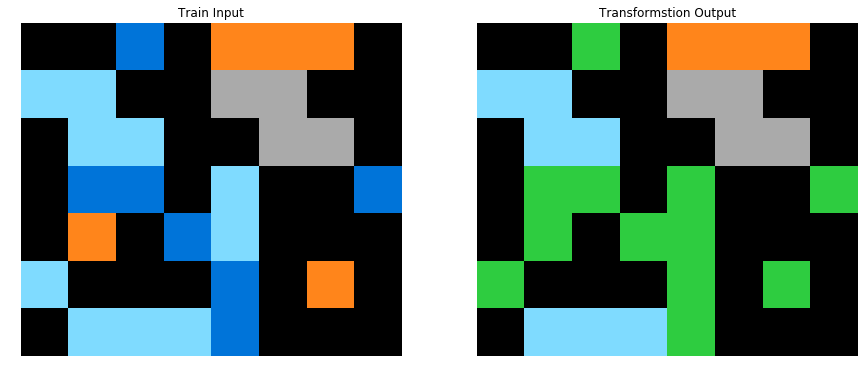

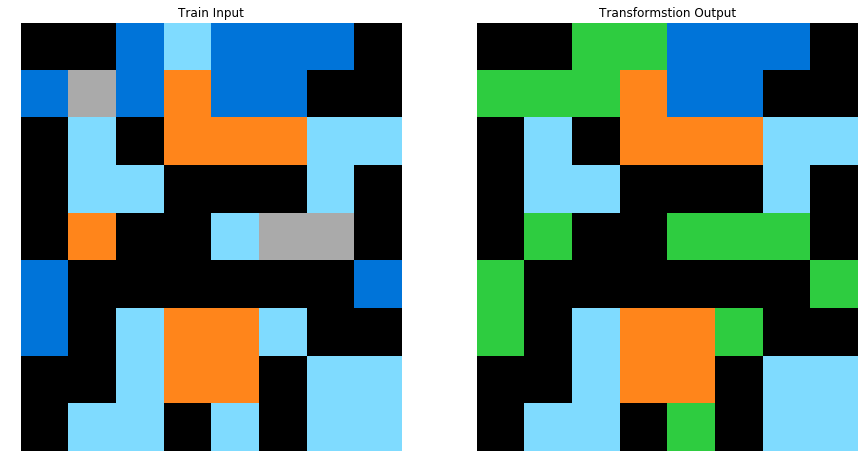

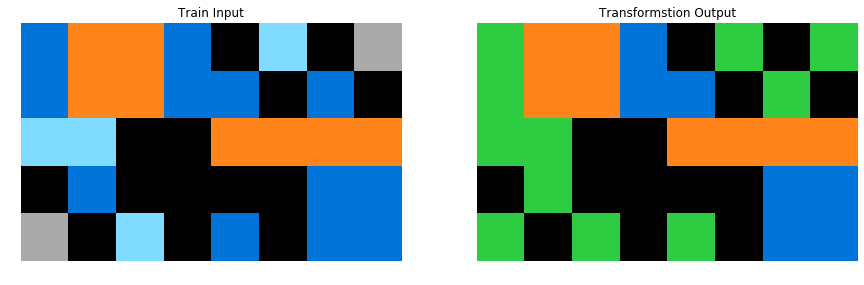

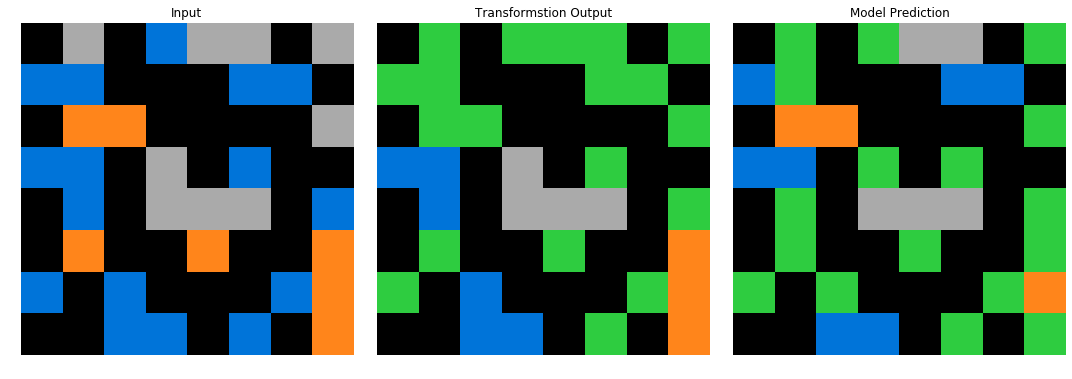

Number of input rows: 7 cols: 15
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/evaluation/136b0064.json

Made predictions for  13713586
ensemble accuracy 0.29239766081871343



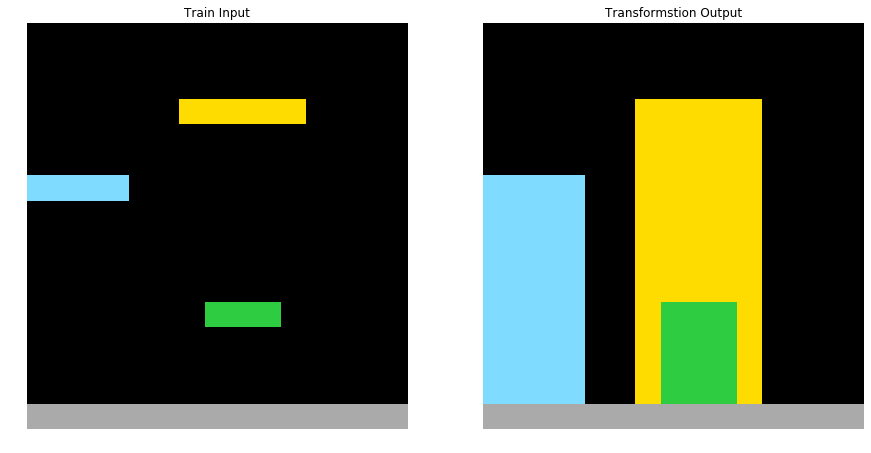

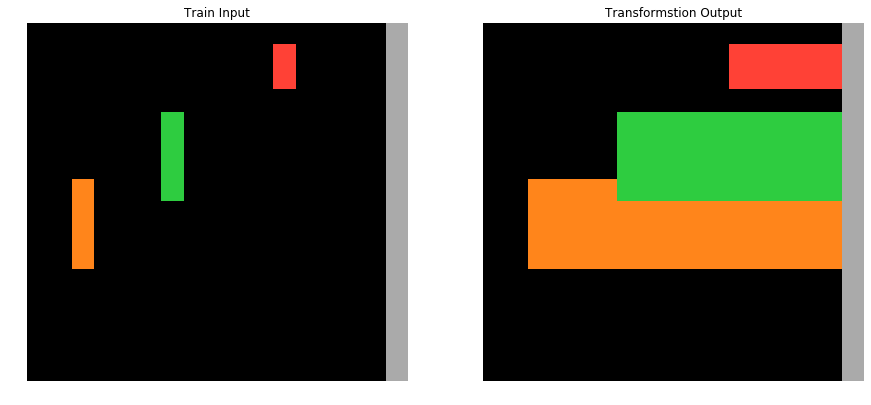

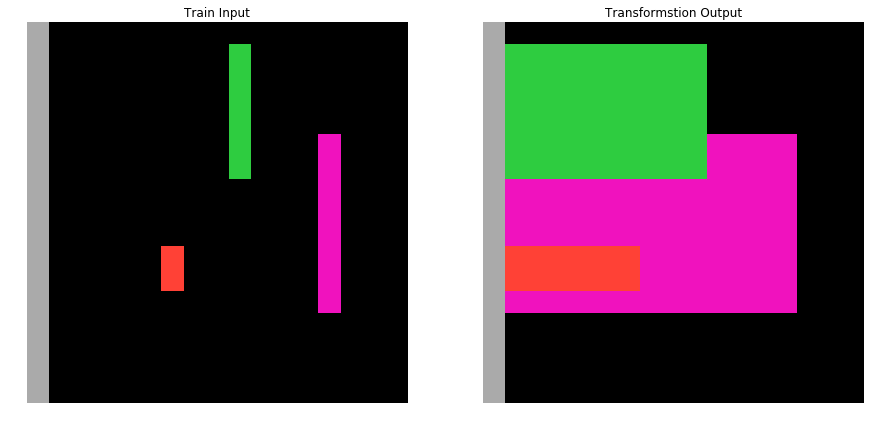

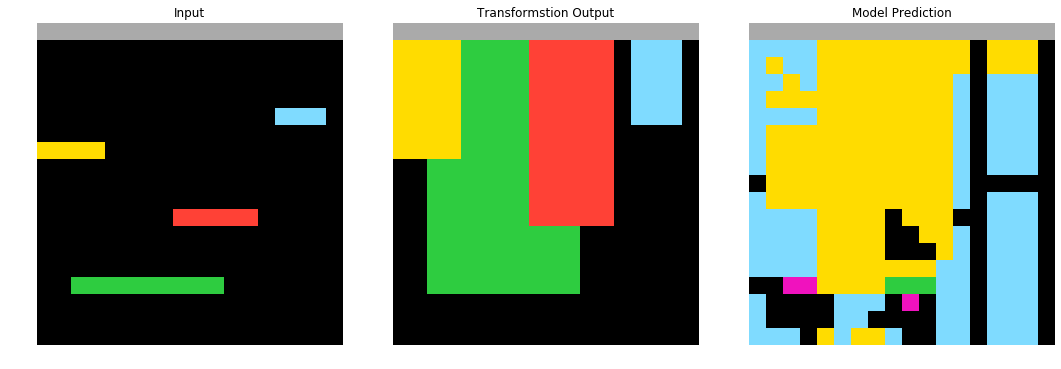

Made predictions for  137f0df0
ensemble accuracy 0.99
137f0df0.json



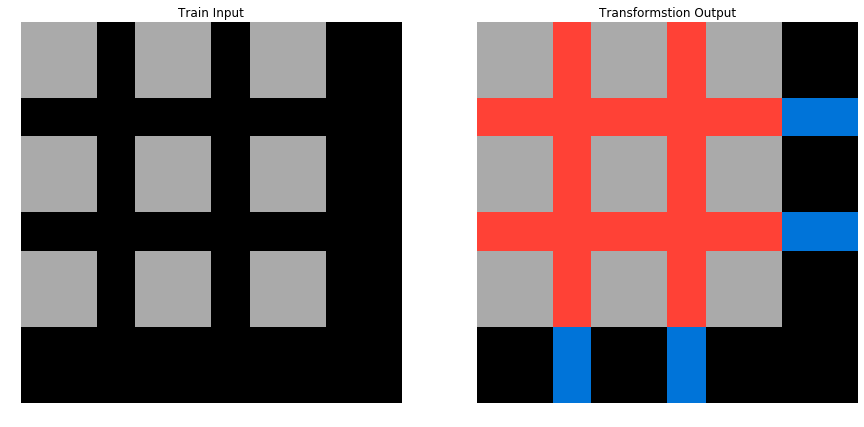

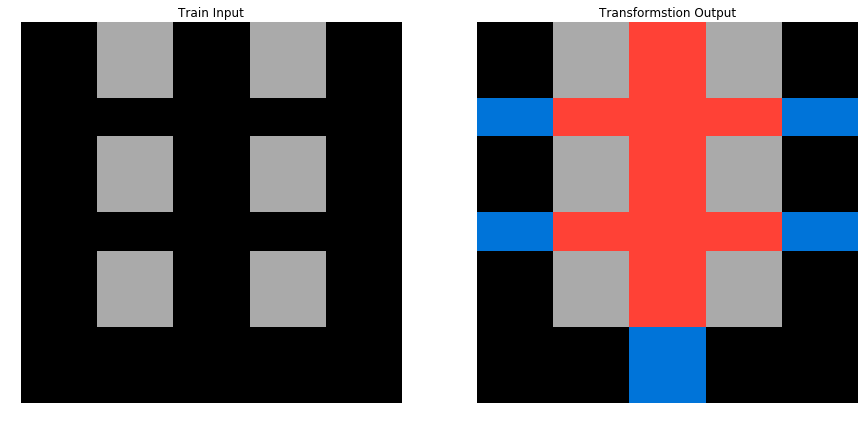

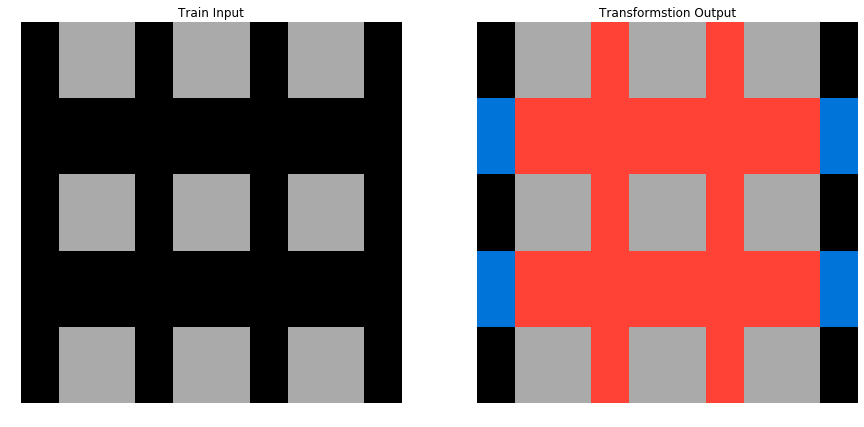

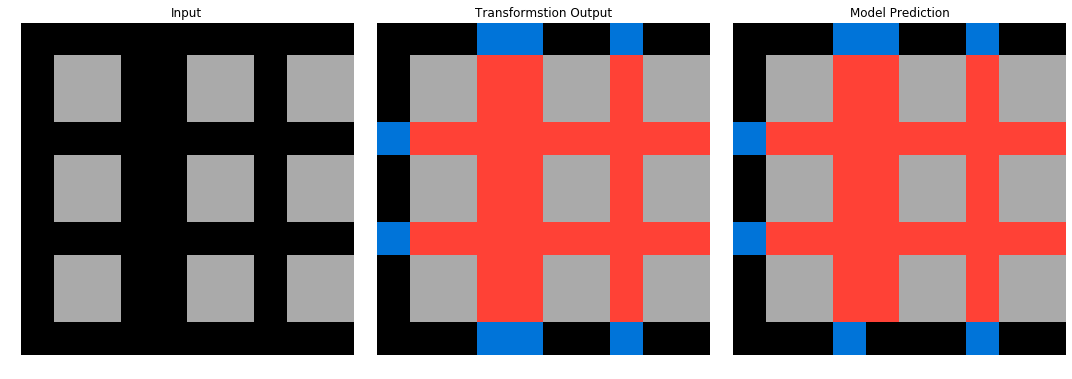

Made predictions for  140c817e
ensemble accuracy 0.9846938775510204
140c817e.json



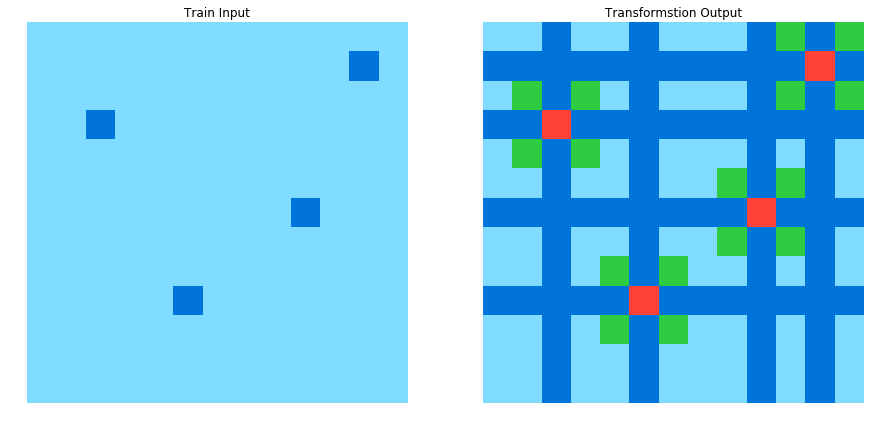

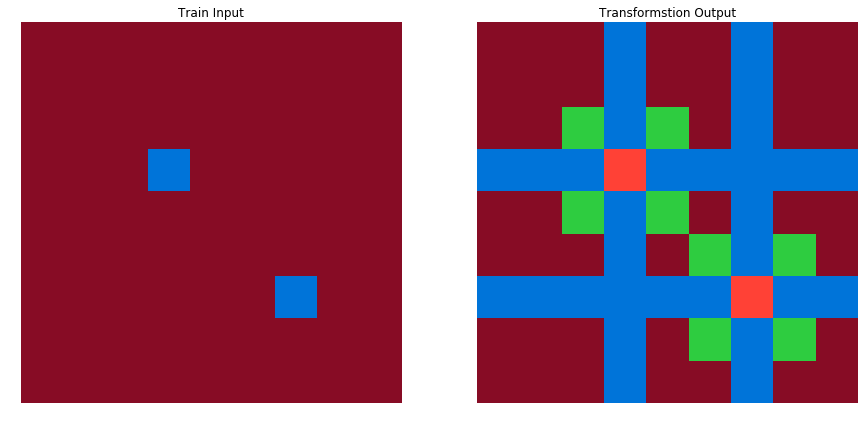

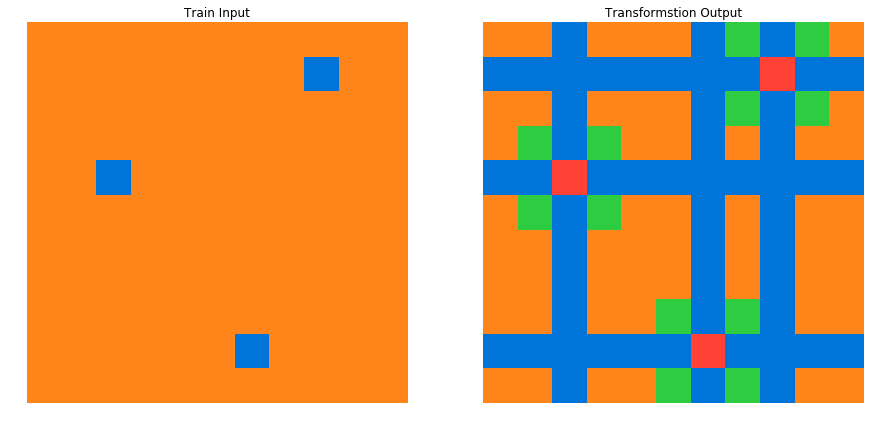

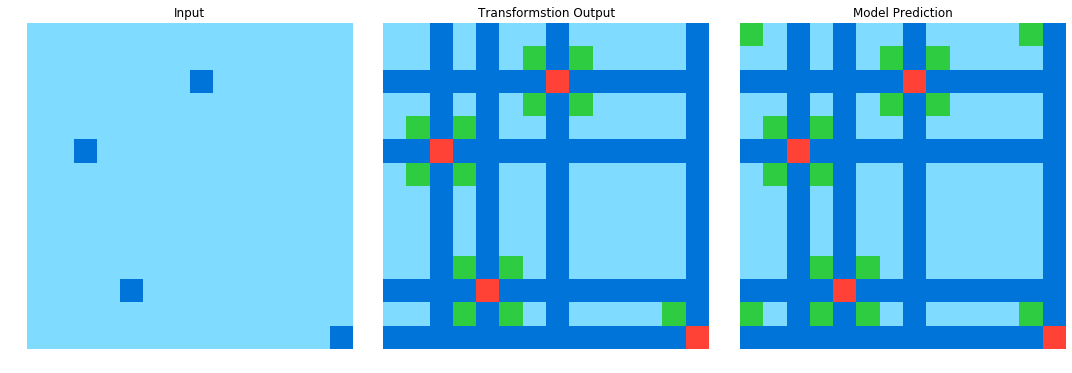

In [17]:
### Sample Output


mode = 'eval'
#mode = 'test'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 31
local_neighb = 5
valid_scores = {}
save_task_ids = []
model_accuracies = {'ens': []}
pred_taskids = []
for task_id in all_task_ids[25:30]:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    estimators = [
                    ('xgb', XGBClassifier(n_estimators=25, n_jobs=-1)),
                    ('extra_trees', ExtraTreesClassifier() ),
                    ('bagging', BaggingClassifier()),
                    ('LogisticRegression',LogisticRegression())
                 ]
    clf = StackingClassifier(
        estimators=estimators, final_estimator=XGBClassifier(n_estimators=10, n_jobs=-1)
    )


    clf.fit(feat, target)
#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    cur_idx = 0
    for task_num in range(num_test_pairs):
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])

        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = clf.predict(feat).reshape(nrows,ncols)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)
            

            model_accuracies['ens'].append(ens_acc)

            pred_taskids.append(f'{task_id[:-5]}_{task_num}')

            print('ensemble accuracy',(np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols))
            if (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols) >= 0.95:
                save_task_ids.append(task_id)
                print(task_id)
            print()
        
        preds = preds.astype(int).tolist()
        output_color = np.array(task['test'][task_num]['output'])
        
        
        # Example  no. 1
        input_train_color = np.array(task['train'][0]['input'])
        output_train_color = np.array(task['train'][0]['output'])
        
        nrows_, ncols_ = len(task['train'][0]['input']), len(
            task['train'][0]['input'][0])
        
        
        #Example No. 2
        input_train_color2 = np.array(task['train'][1]['input'])
        output_train_color2 = np.array(task['train'][1]['output'])
        
        nrows_1, ncols_1 = len(task['train'][1]['input']), len(
            task['train'][1]['input'][0])
        
        # Example 3
        input_train_color3 = np.array(task['train'][2]['input'])
        output_train_color3 = np.array(task['train'][2]['output'])
        
        nrows_2, ncols_2 = len(task['train'][2]['input']), len(
            task['train'][2]['input'][0])
        
        plot_sample_pattern(input_train_color, output_train_color, (nrows_, ncols_))
        plot_sample_pattern(input_train_color2, output_train_color2, (nrows_1, ncols_1))
        plot_sample_pattern(input_train_color3, output_train_color3, (nrows_2, ncols_2))
        plot_result(input_color, output_color,preds, (nrows, ncols))
        #plot_test(preds, task_id)
        if mode=='test':
            sample_sub.loc[f'{task_id[:-5]}_{task_num}',
                        'output'] = flattener(preds)


Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/007bbfb7.json

Made predictions for  00d62c1b
ensemble accuracy 0.8975



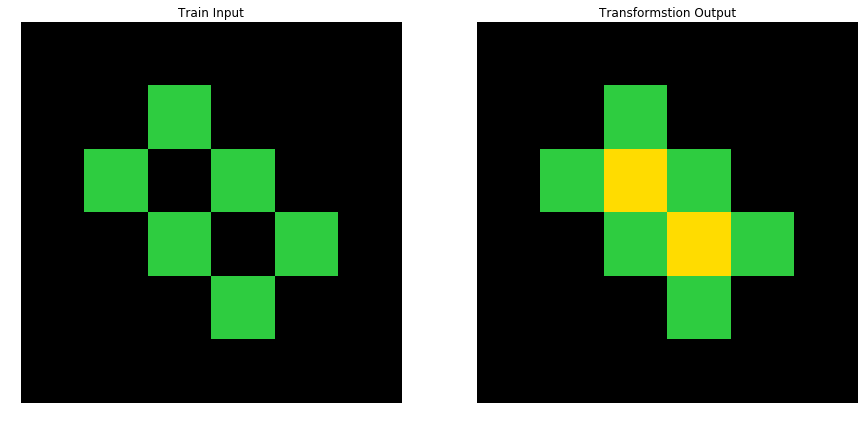

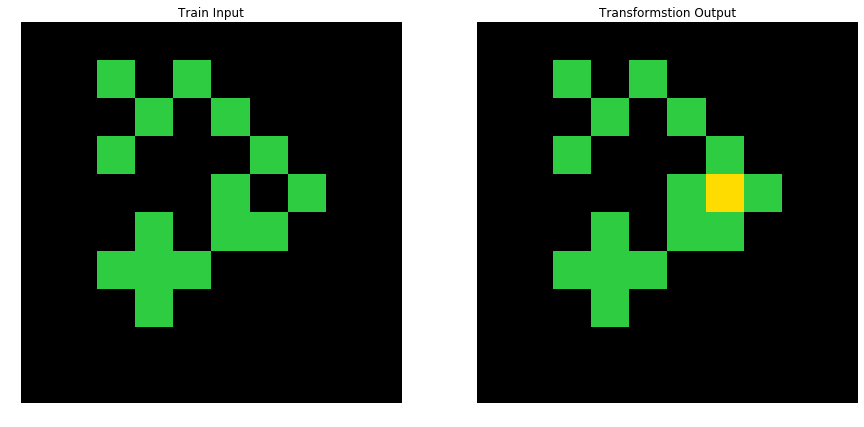

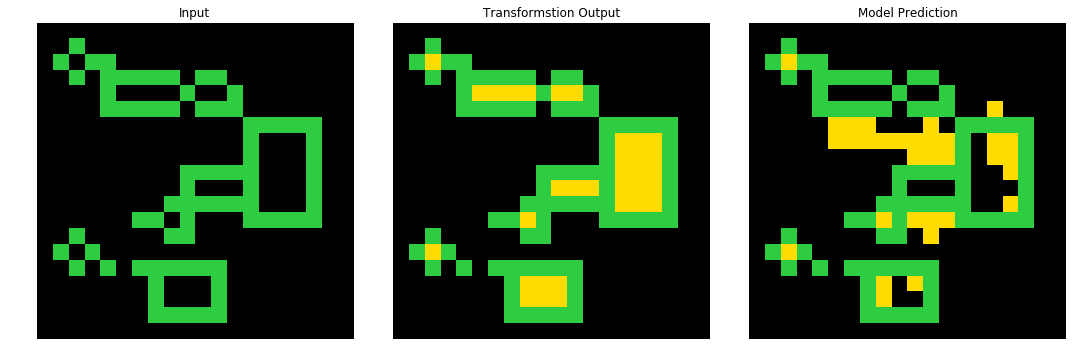

Number of input rows: 6 cols: 3
Number of target rows: 9 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/017c7c7b.json

Made predictions for  025d127b
ensemble accuracy 0.74



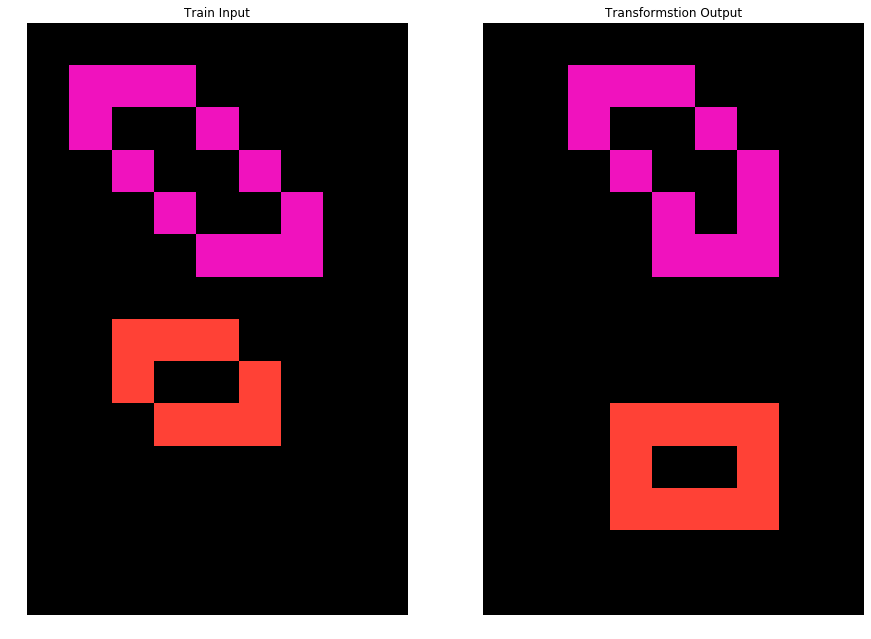

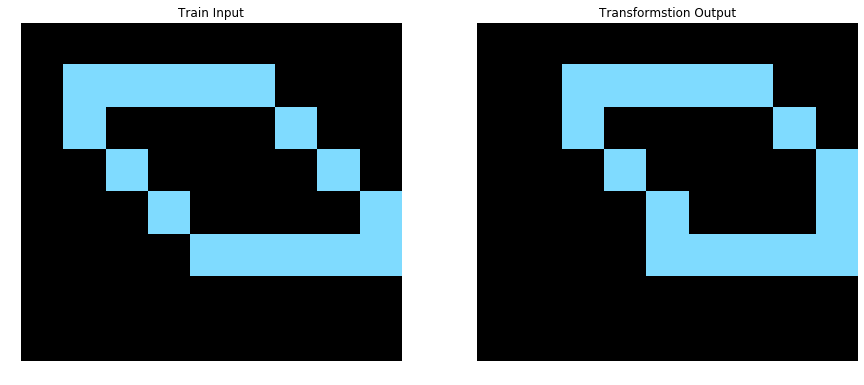

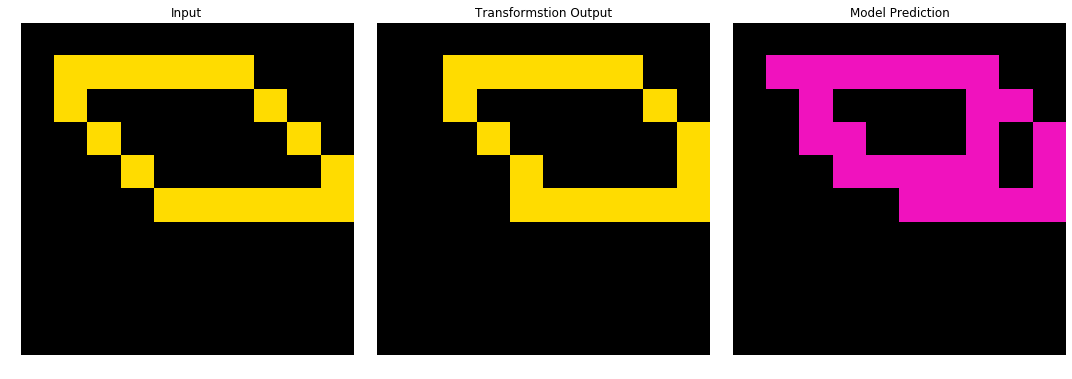

Made predictions for  045e512c
ensemble accuracy 0.8208616780045351



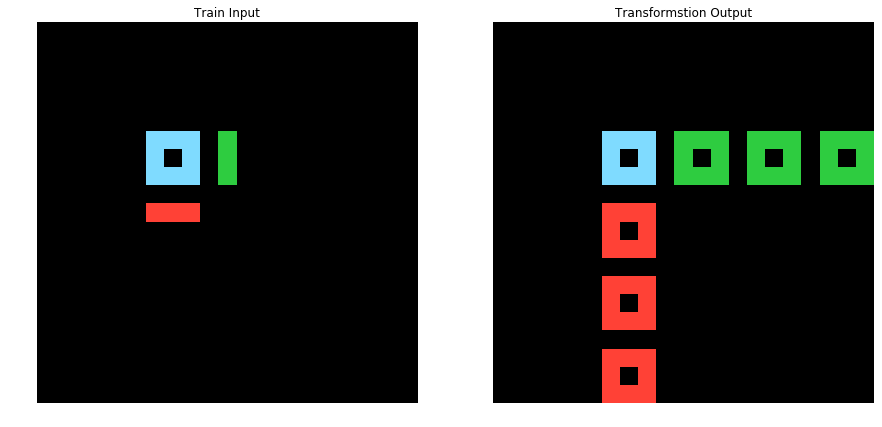

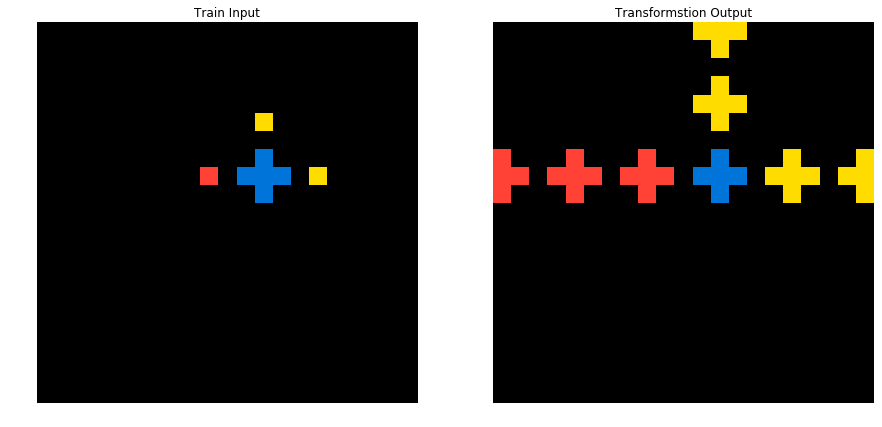

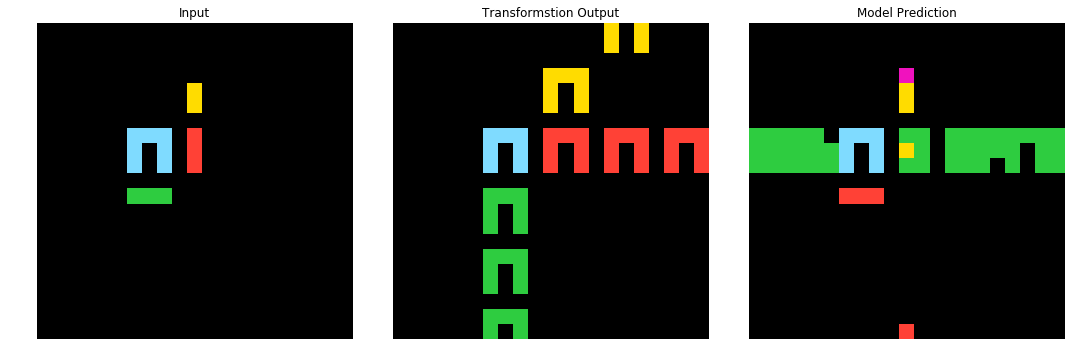

Number of input rows: 3 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/0520fde7.json

Made predictions for  05269061
ensemble accuracy 0.24489795918367346



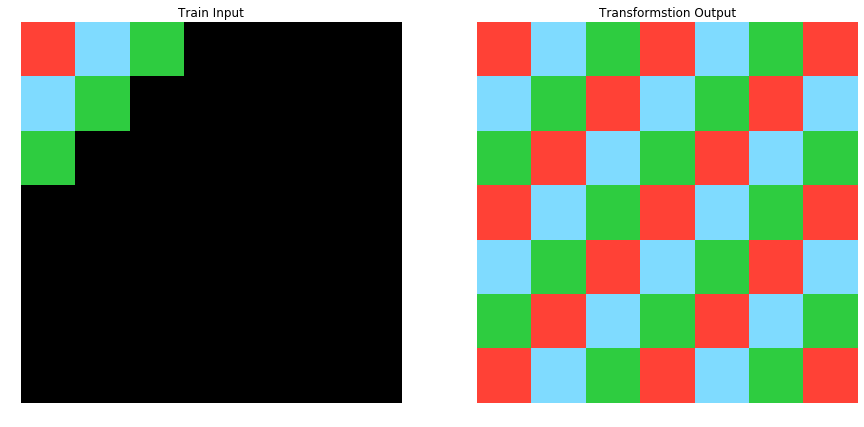

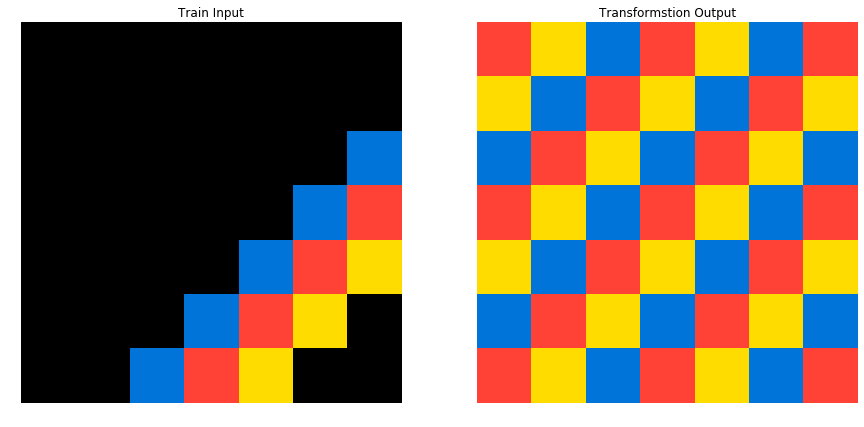

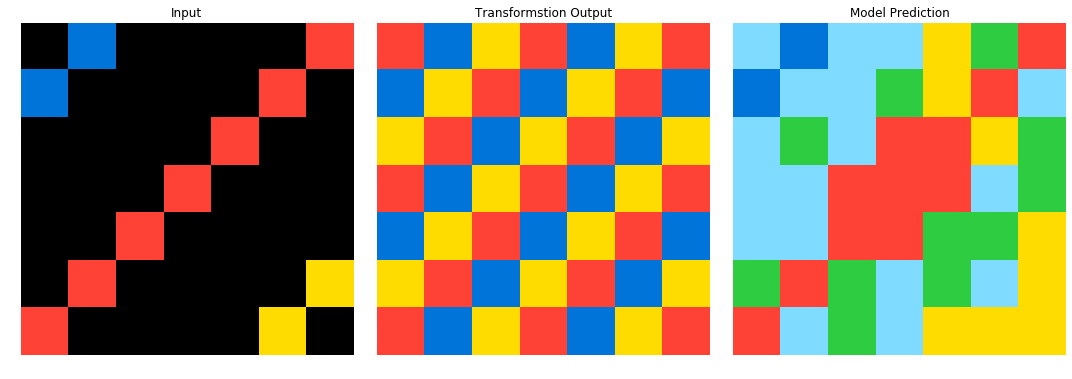

Made predictions for  05f2a901
ensemble accuracy 0.9363636363636364



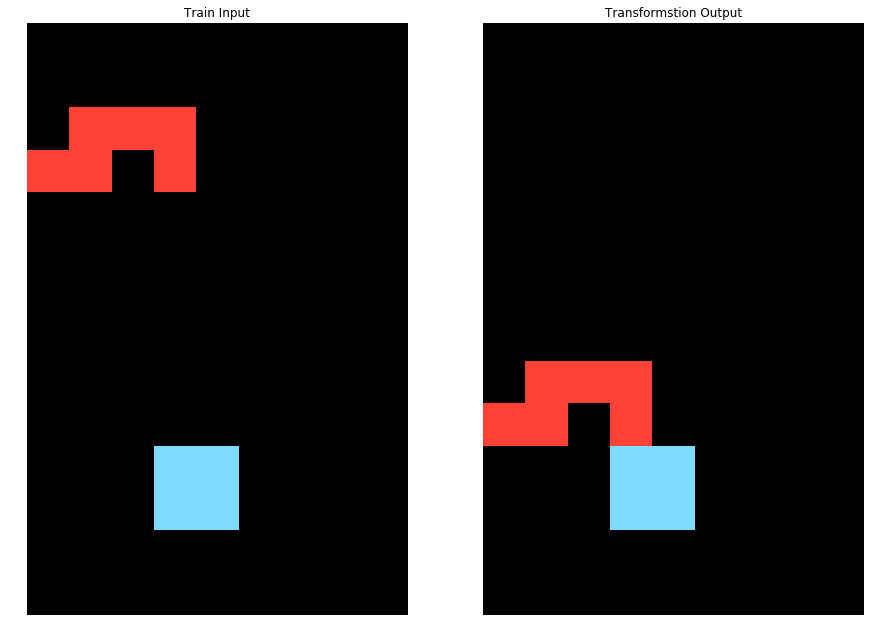

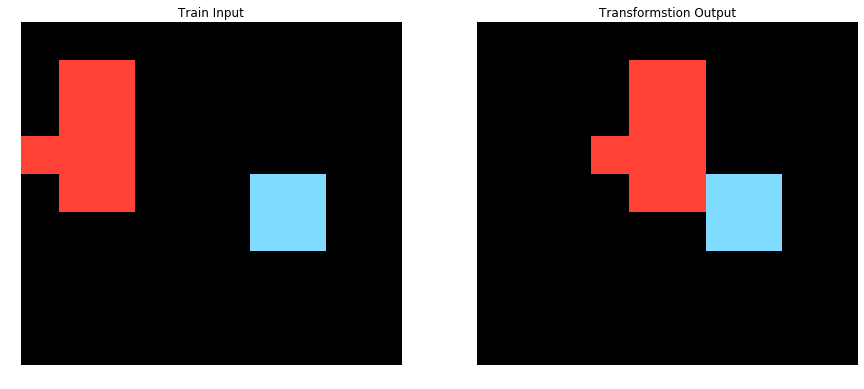

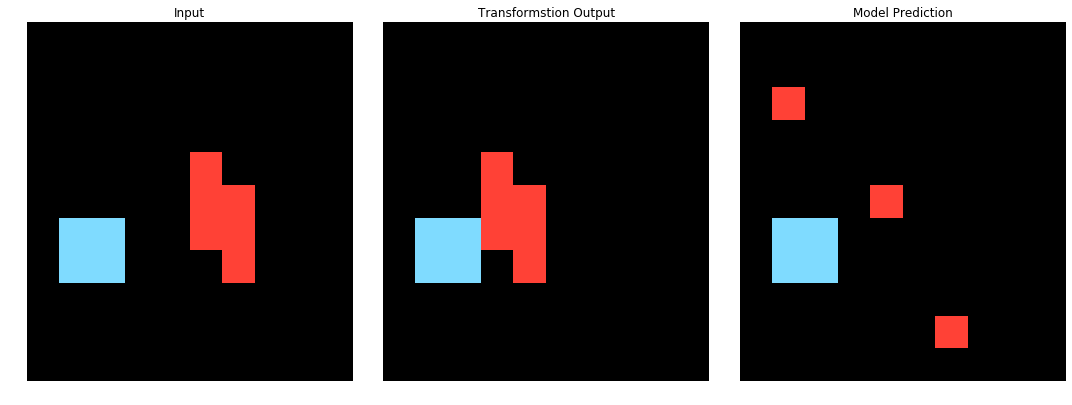

Made predictions for  06df4c85
ensemble accuracy 0.871301775147929



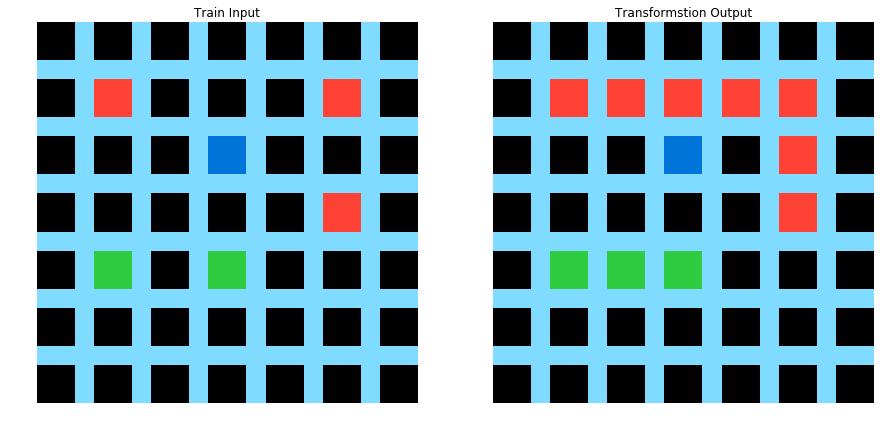

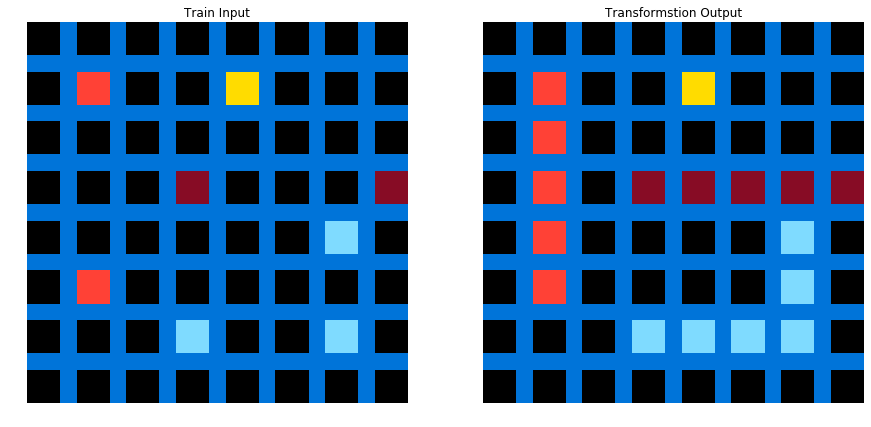

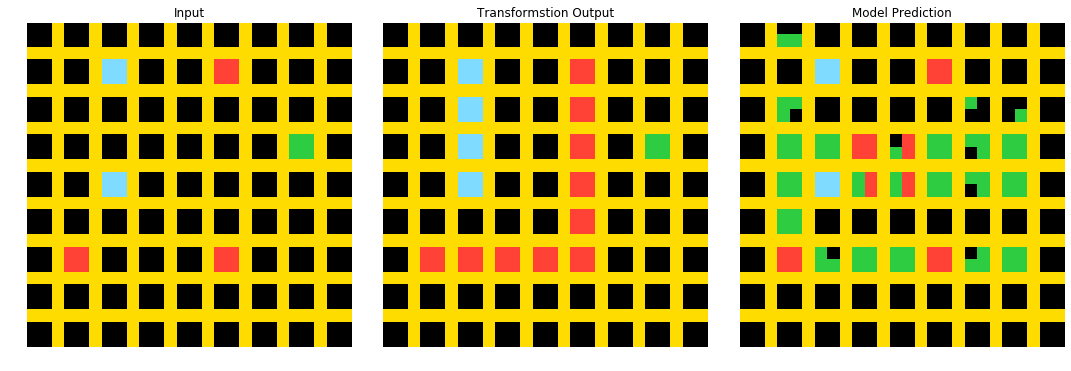

Made predictions for  08ed6ac7
ensemble accuracy 0.7777777777777778



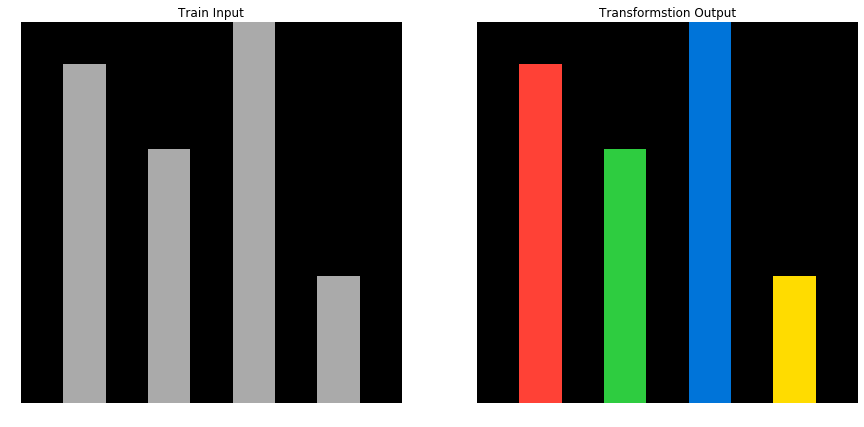

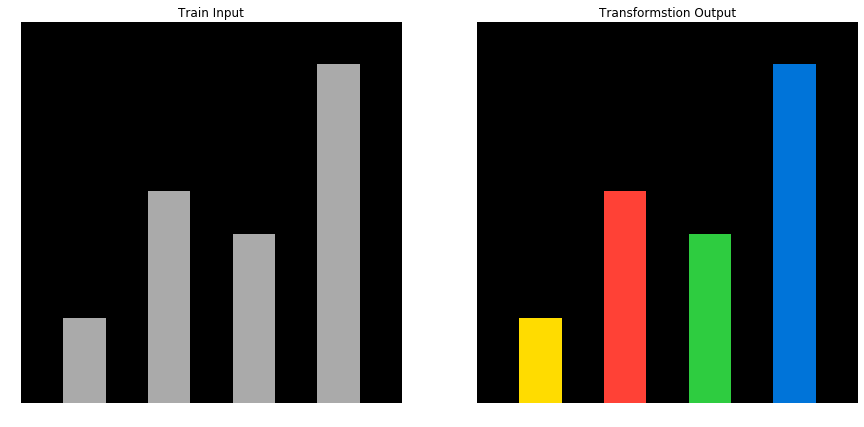

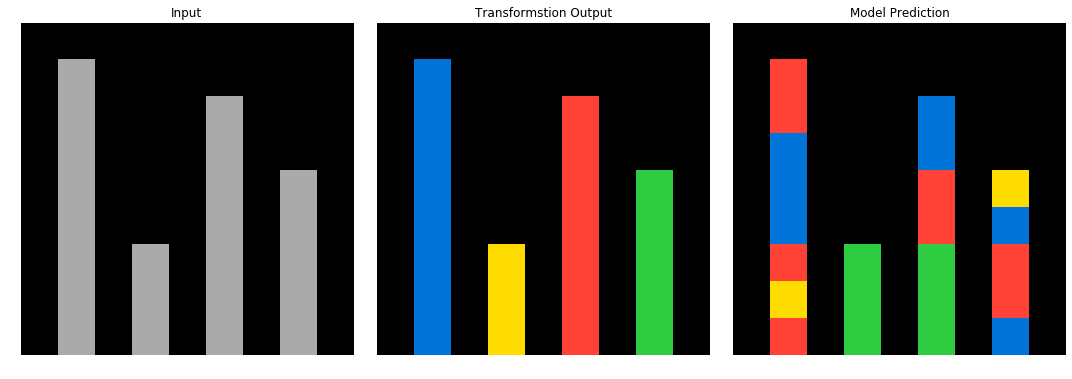

Made predictions for  09629e4f
ensemble accuracy 0.6859504132231405



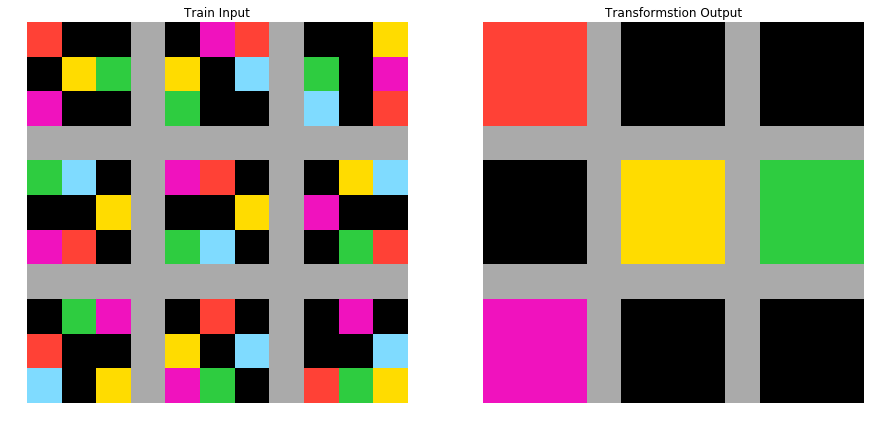

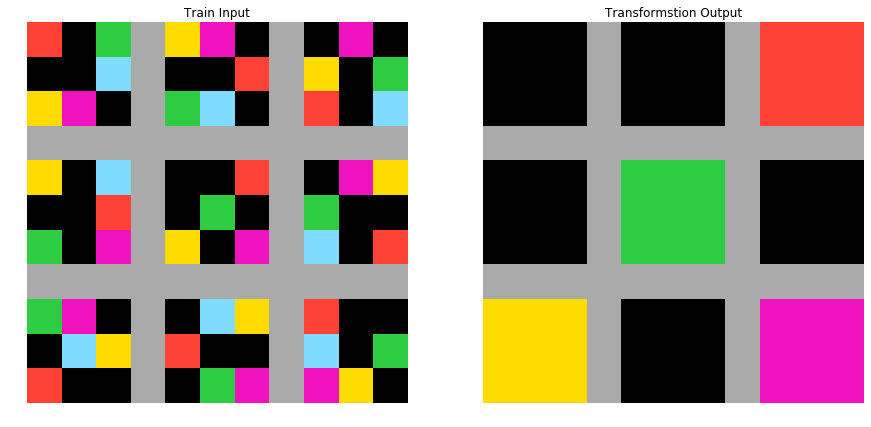

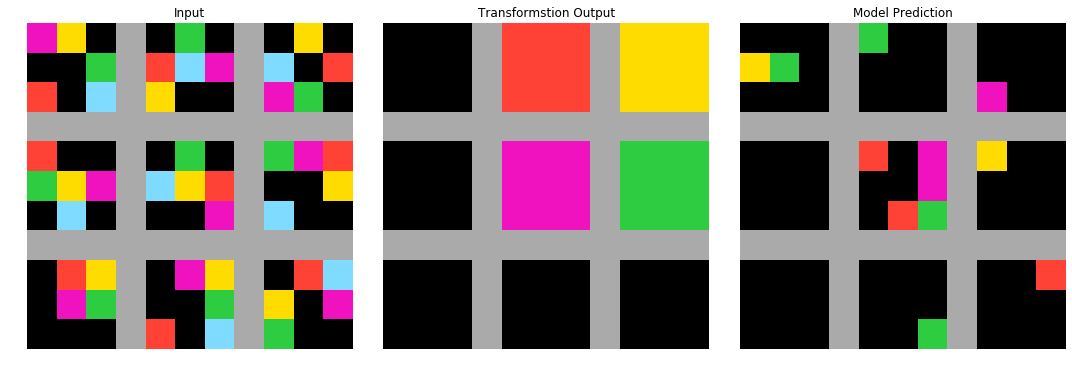

Made predictions for  0962bcdd
ensemble accuracy 0.7291666666666666



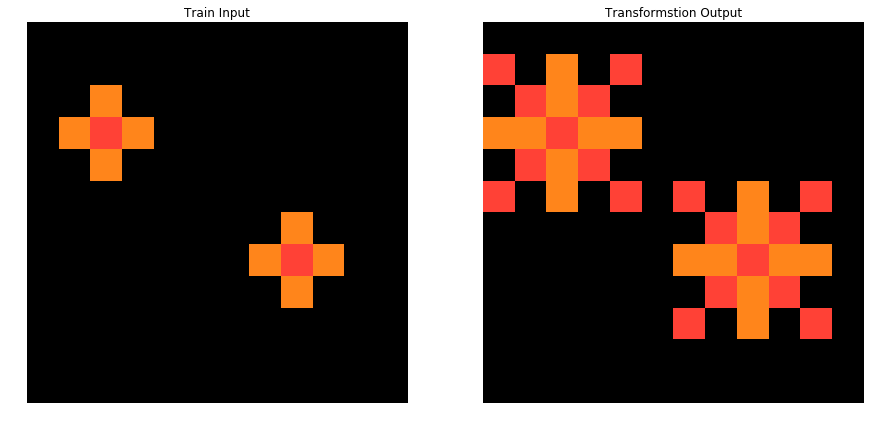

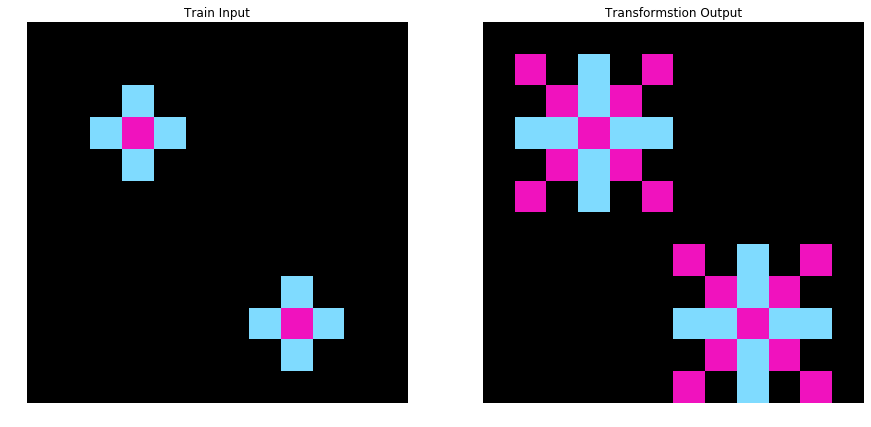

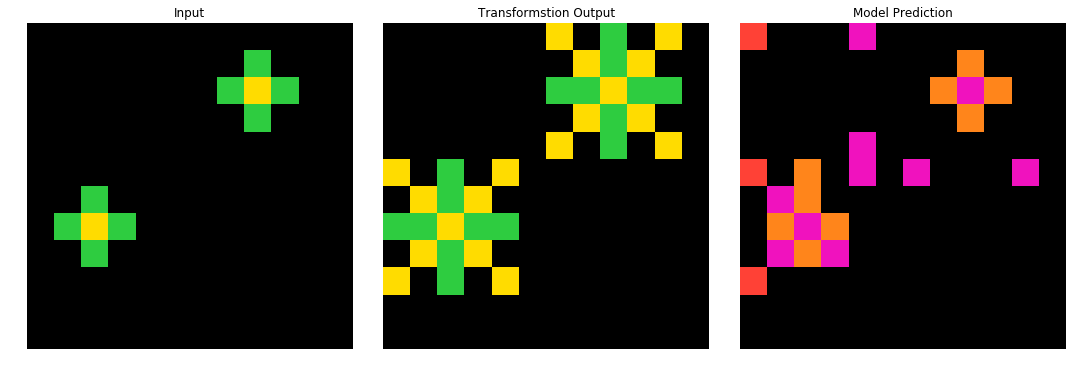

Made predictions for  0a938d79
ensemble accuracy 0.6060606060606061



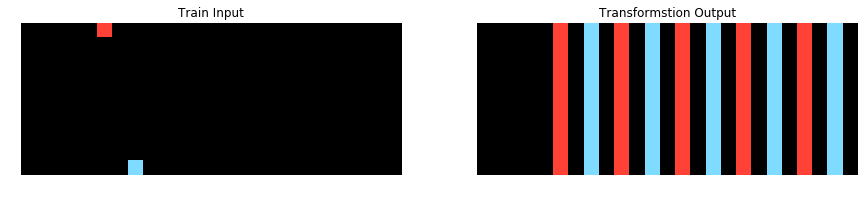

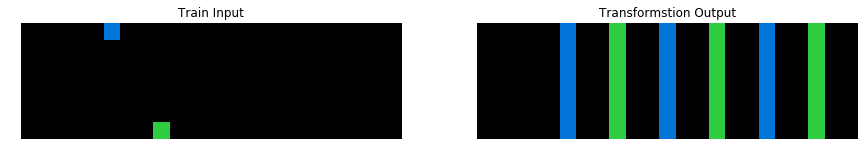

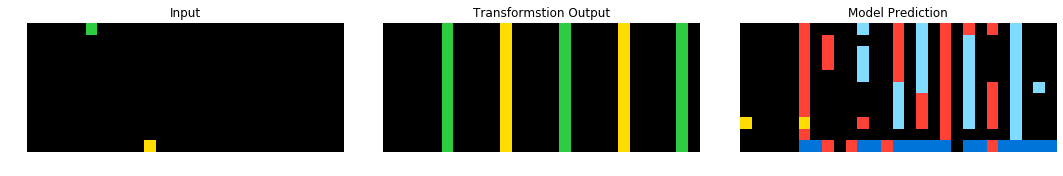

Number of input rows: 21 cols: 21
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/0b148d64.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  0ca9ddb6
ensemble accuracy 0.9876543209876543
0ca9ddb6.json



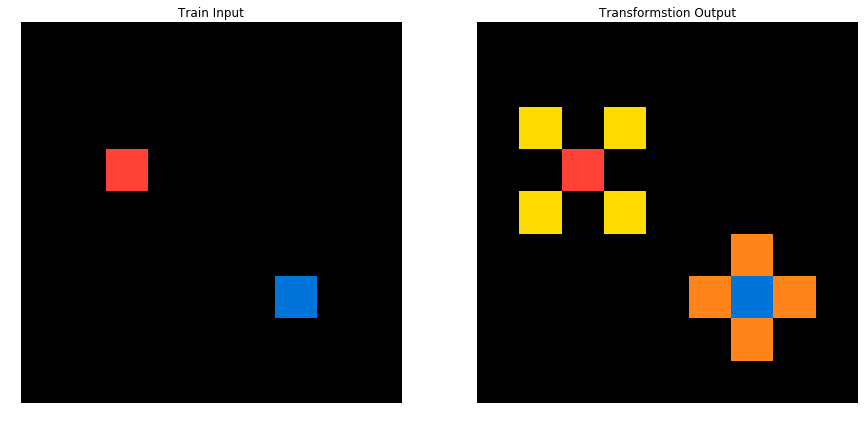

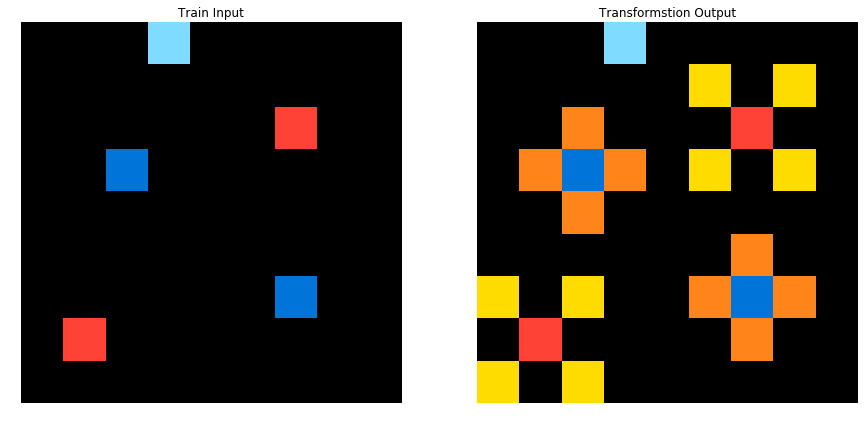

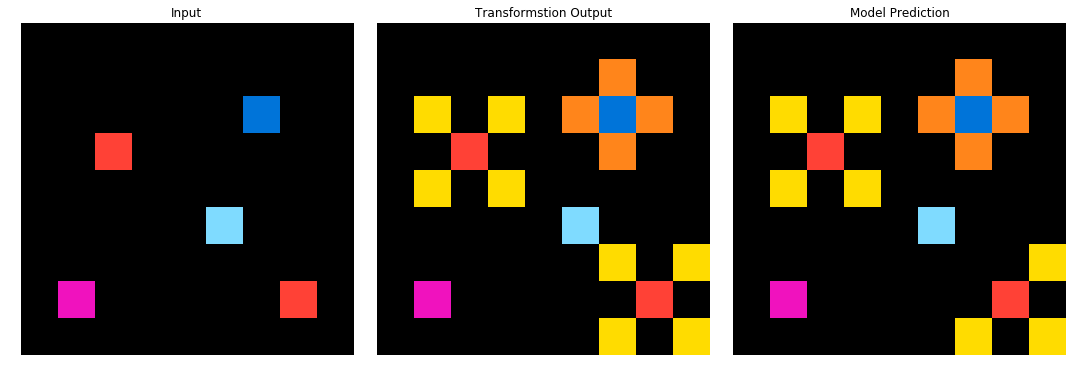

Made predictions for  0d3d703e
ensemble accuracy 1.0
0d3d703e.json



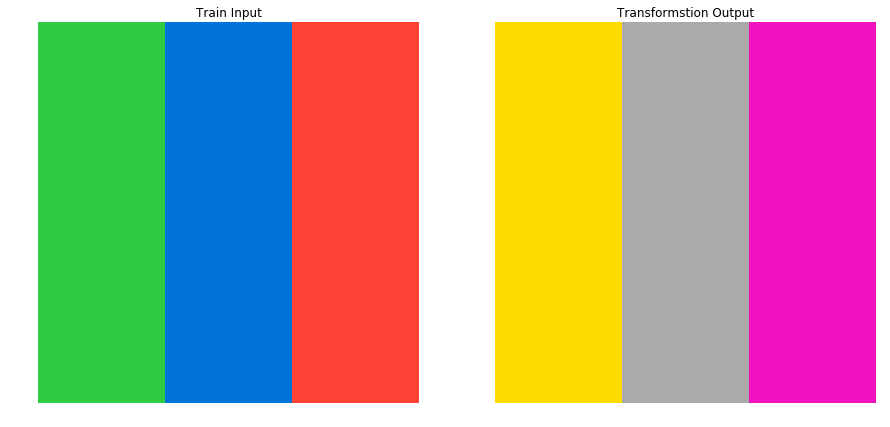

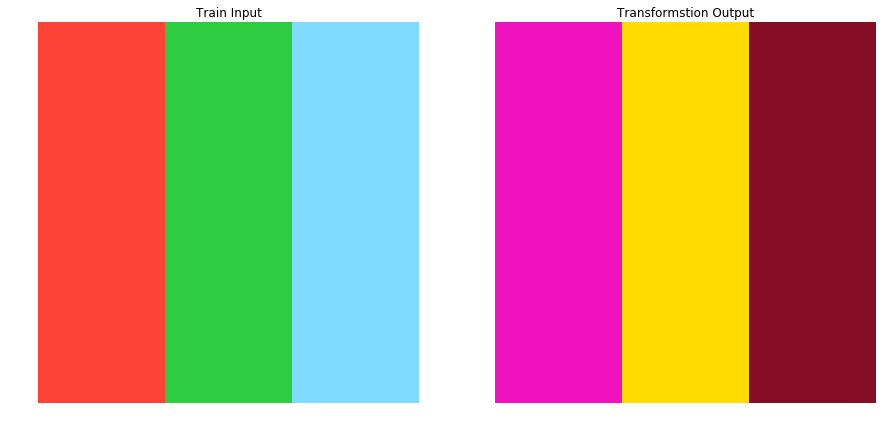

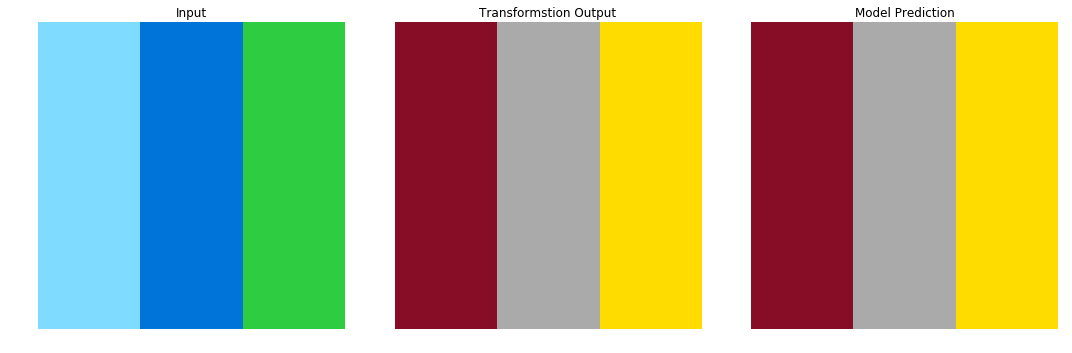

Made predictions for  0dfd9992
ensemble accuracy 0.6507936507936508



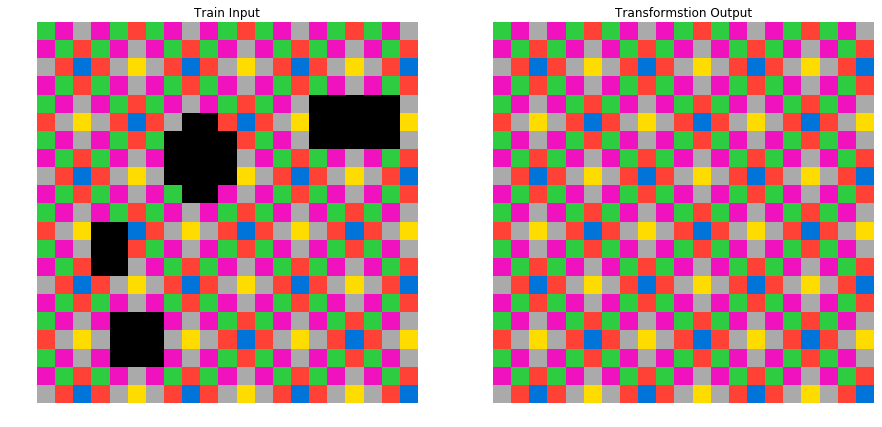

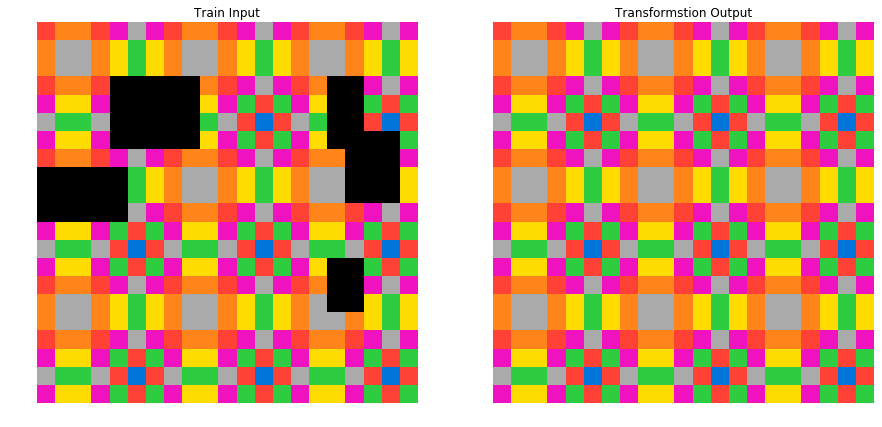

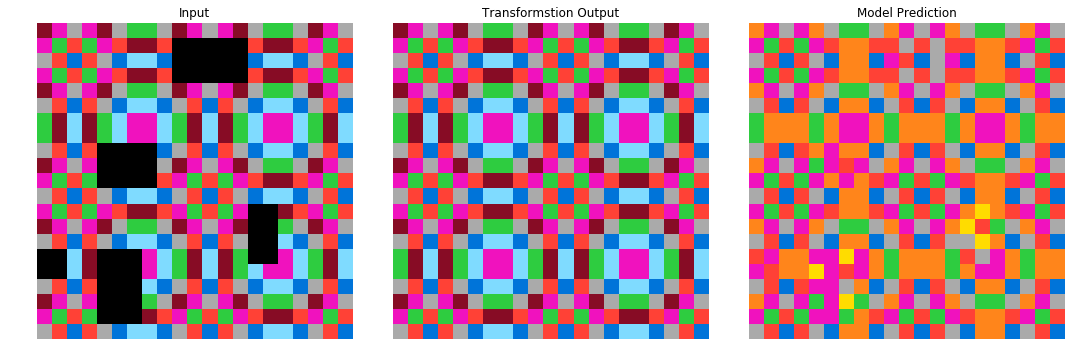

Made predictions for  0e206a2e
ensemble accuracy 0.9627192982456141
0e206a2e.json



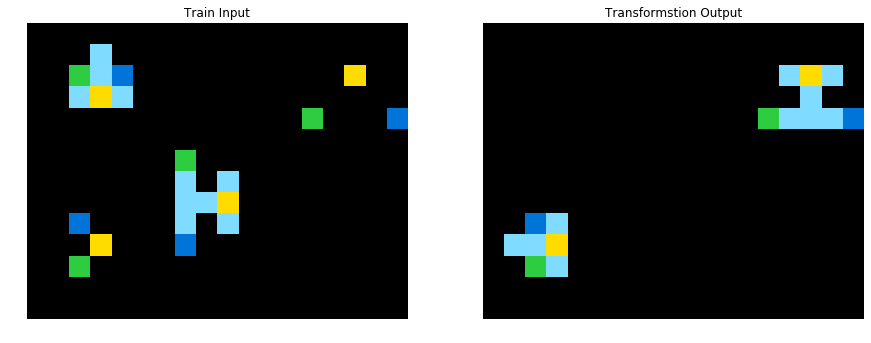

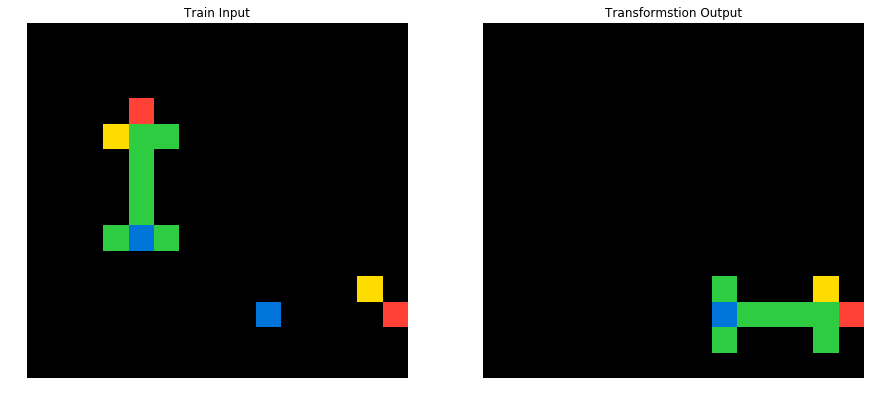

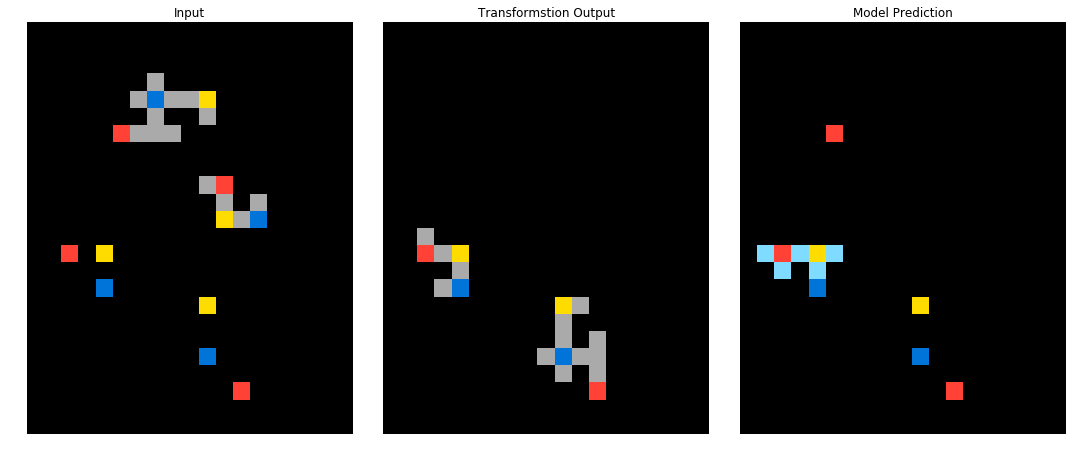

Number of input rows: 2 cols: 4
Number of target rows: 4 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/10fcaaa3.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  11852cab
ensemble accuracy 0.92



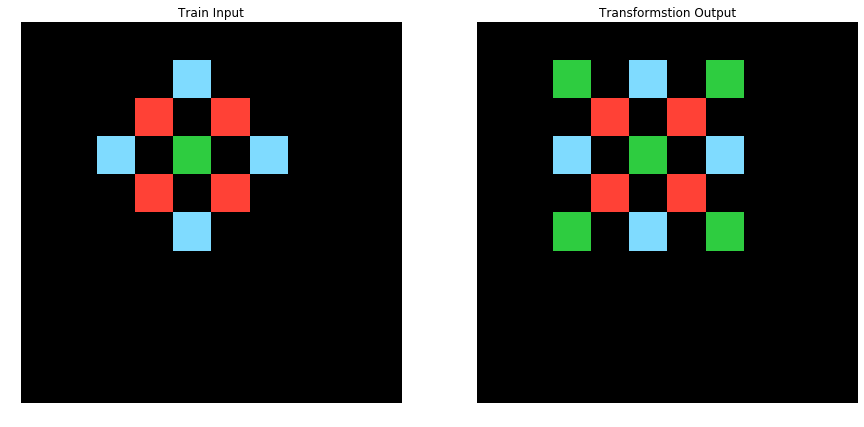

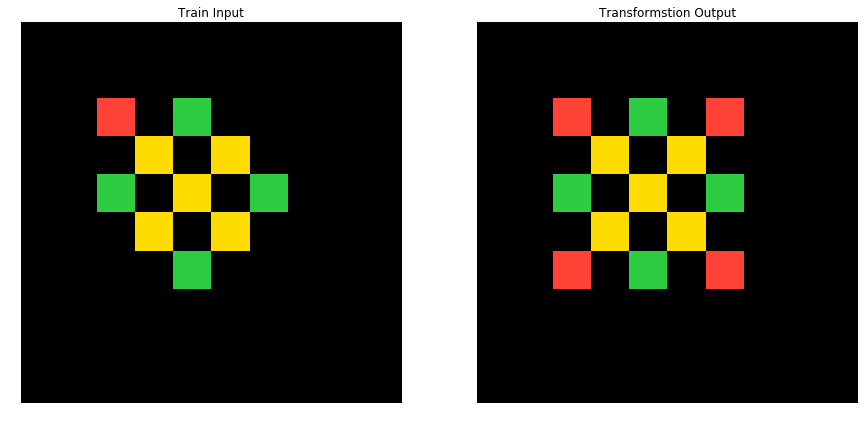

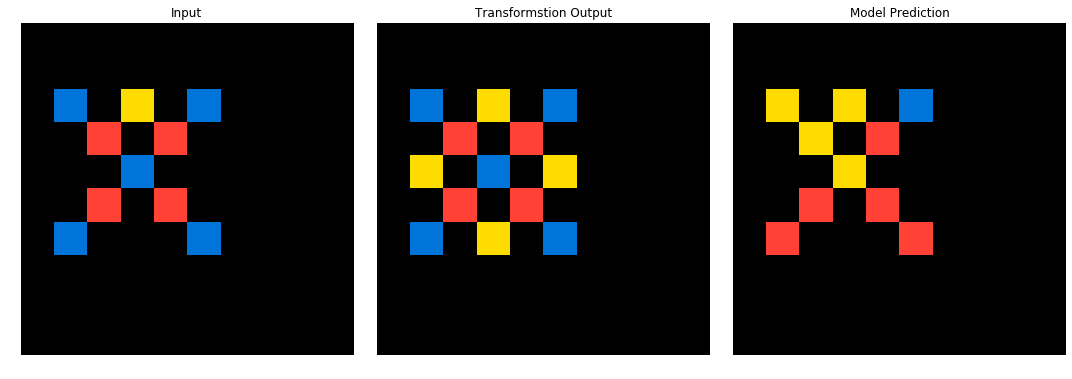

Number of input rows: 15 cols: 15
Number of target rows: 2 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1190e5a7.json

Number of input rows: 11 cols: 11
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/137eaa0f.json

Made predictions for  150deff5
ensemble accuracy 0.875



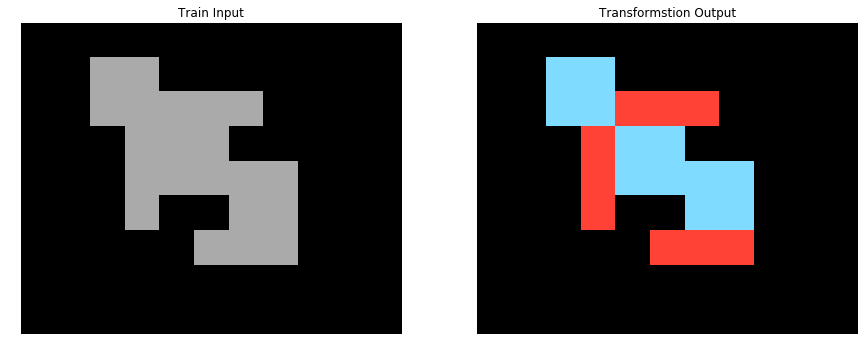

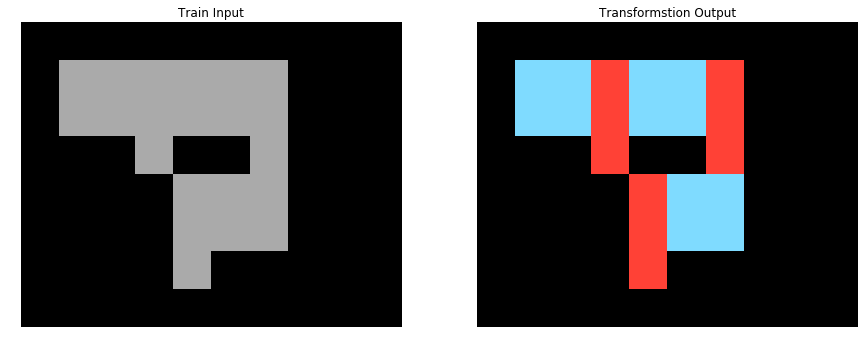

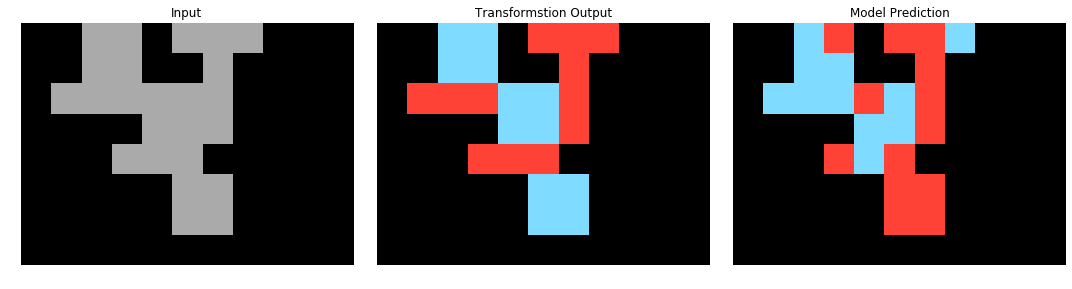

Made predictions for  178fcbfb
ensemble accuracy 0.6136363636363636



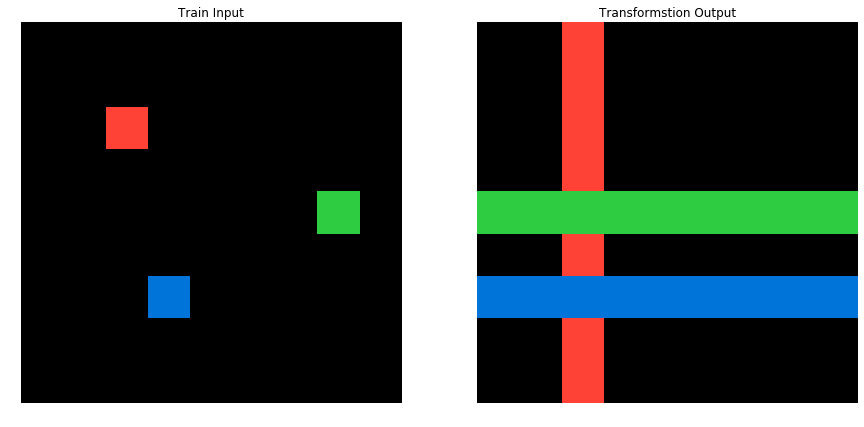

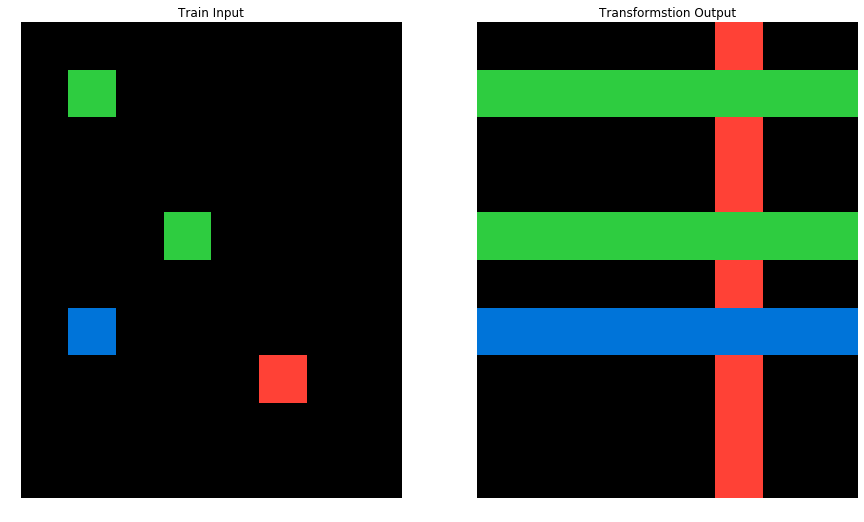

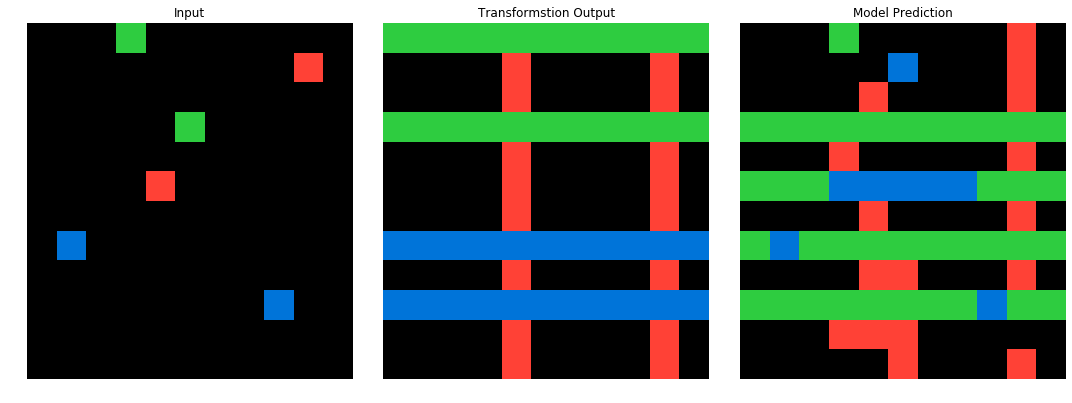

Made predictions for  1a07d186
ensemble accuracy 0.9453441295546559



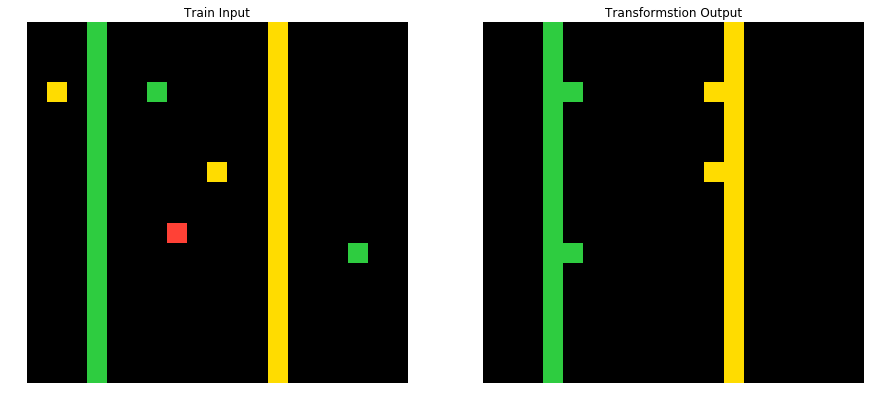

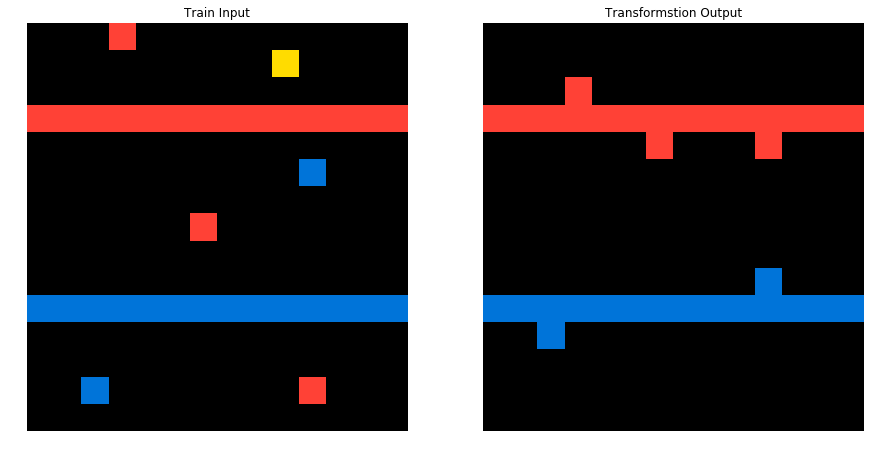

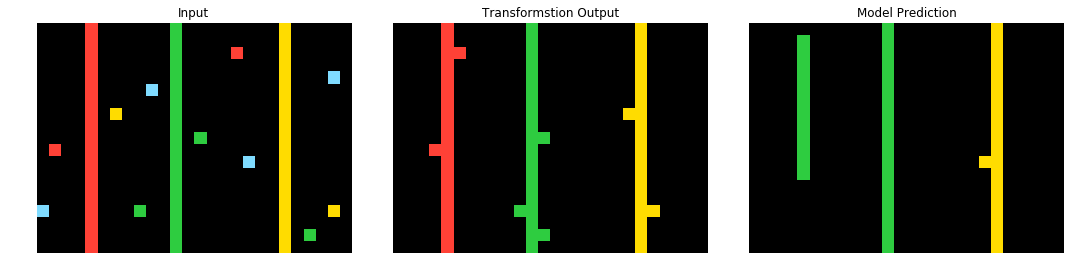

Number of input rows: 5 cols: 7
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1b2d62fb.json

Made predictions for  1b60fb0c
ensemble accuracy 0.96
1b60fb0c.json



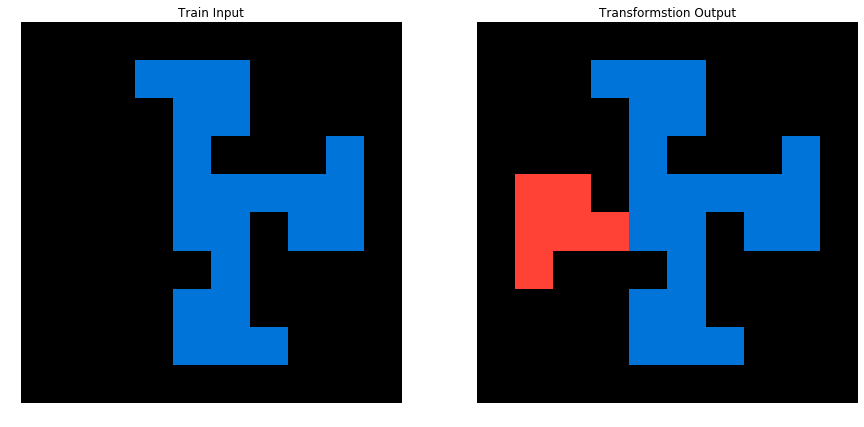

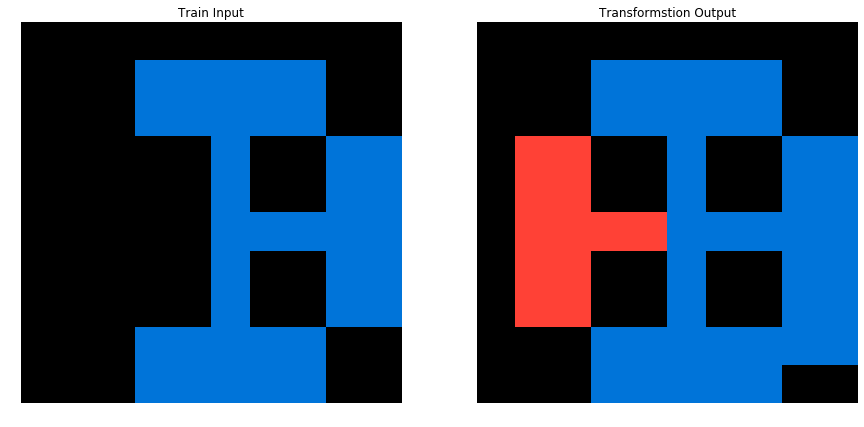

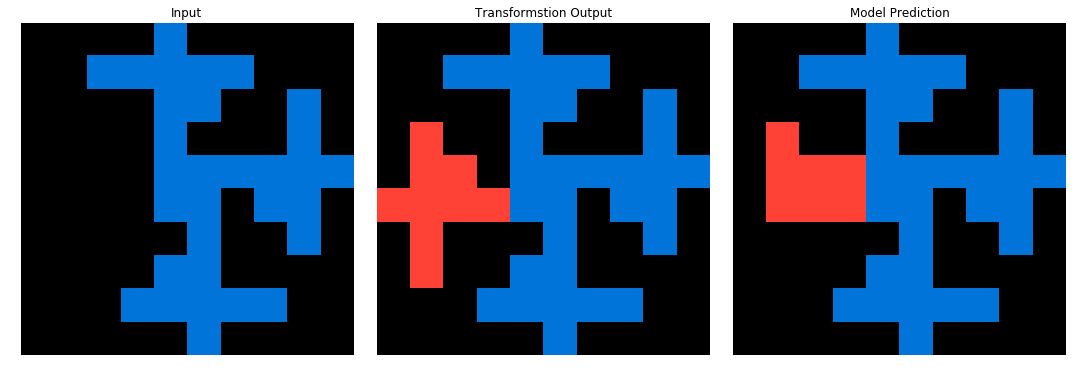

Made predictions for  1bfc4729
ensemble accuracy 0.48



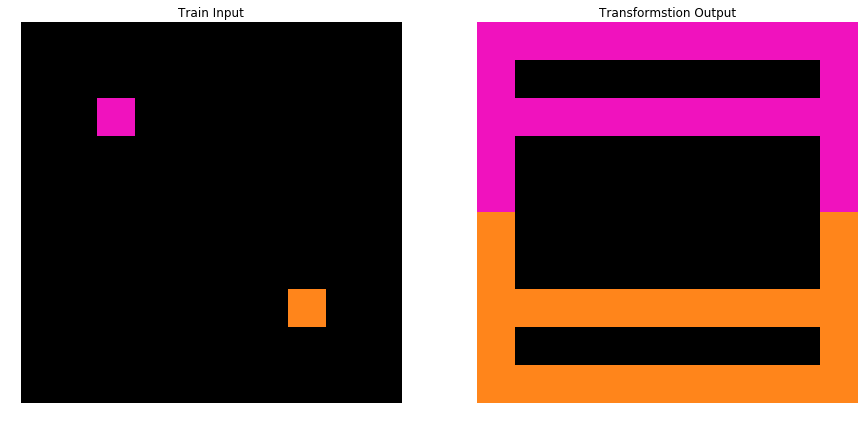

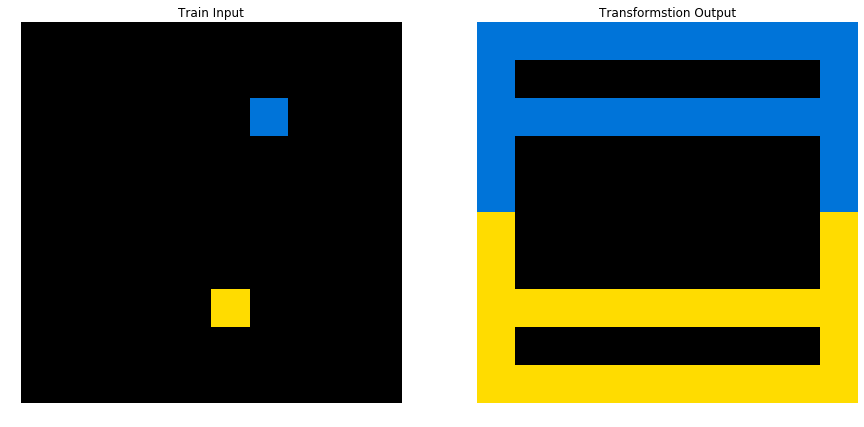

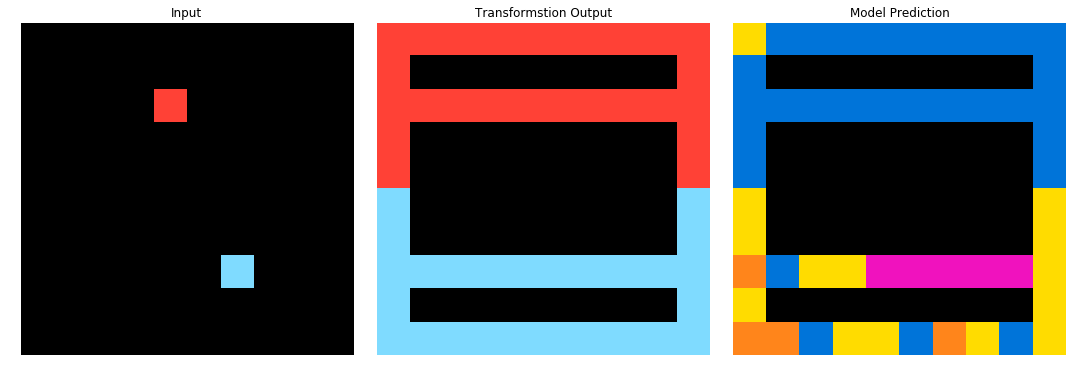

Number of input rows: 23 cols: 21
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1c786137.json

Made predictions for  1caeab9d
ensemble accuracy 0.79



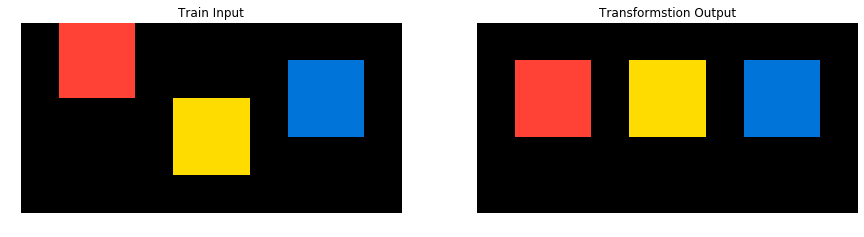

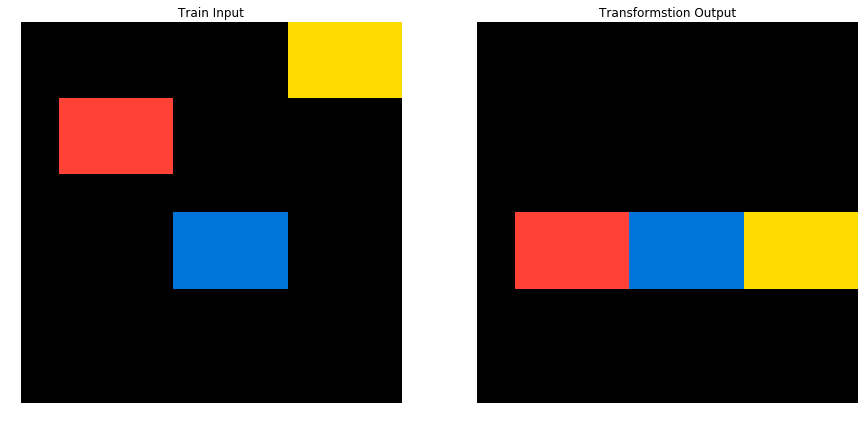

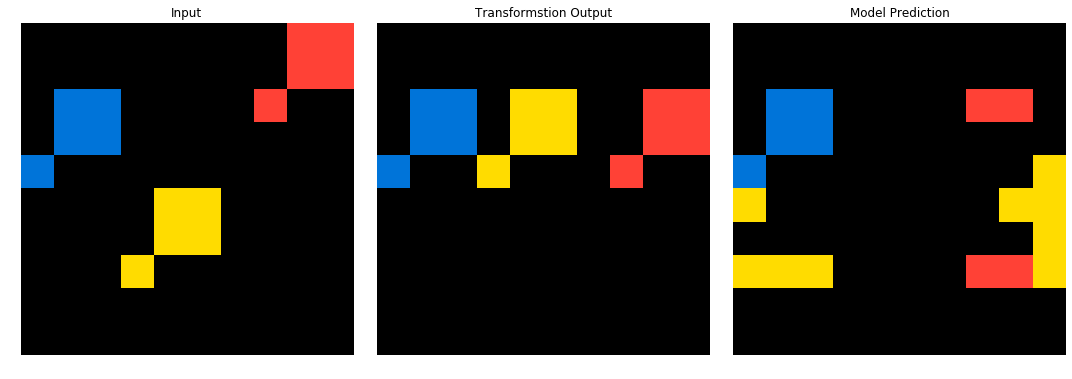

Number of input rows: 10 cols: 12
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1cf80156.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  1e0a9b12
ensemble accuracy 0.64



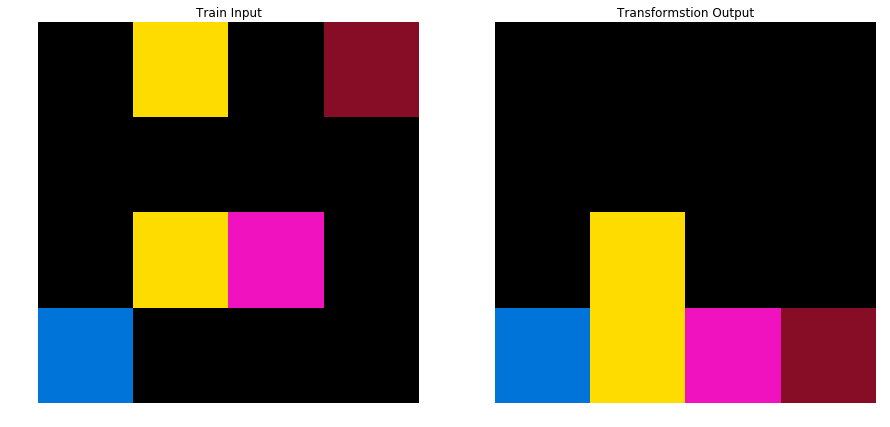

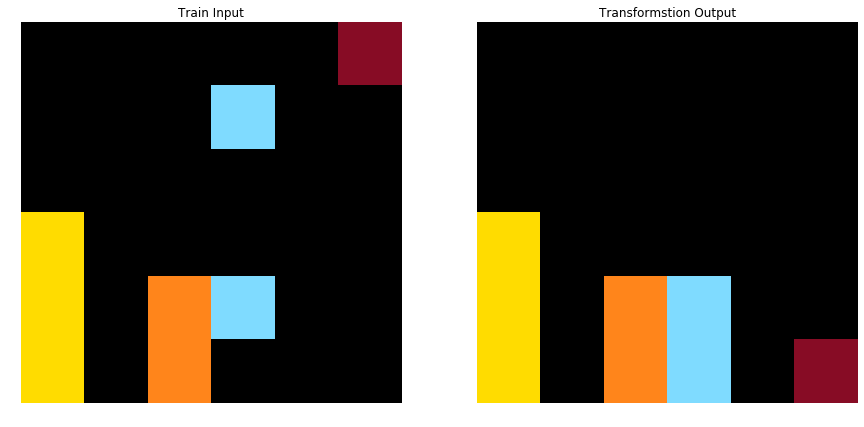

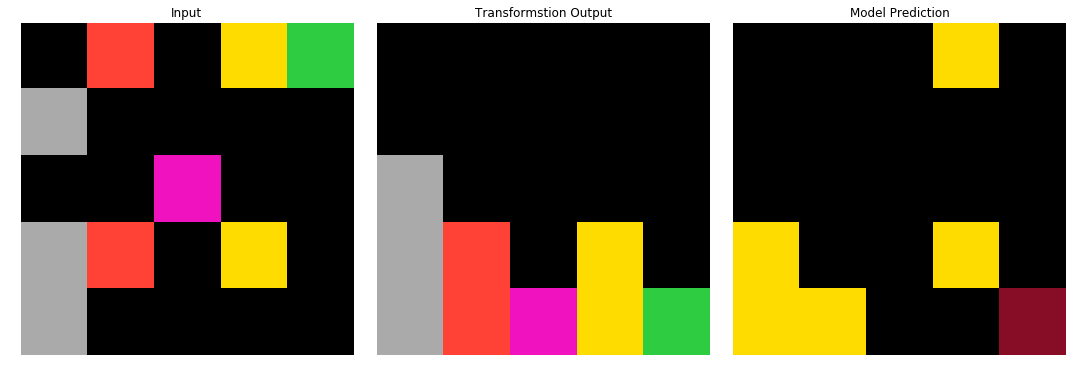

Made predictions for  1e32b0e9
ensemble accuracy 0.5086505190311419



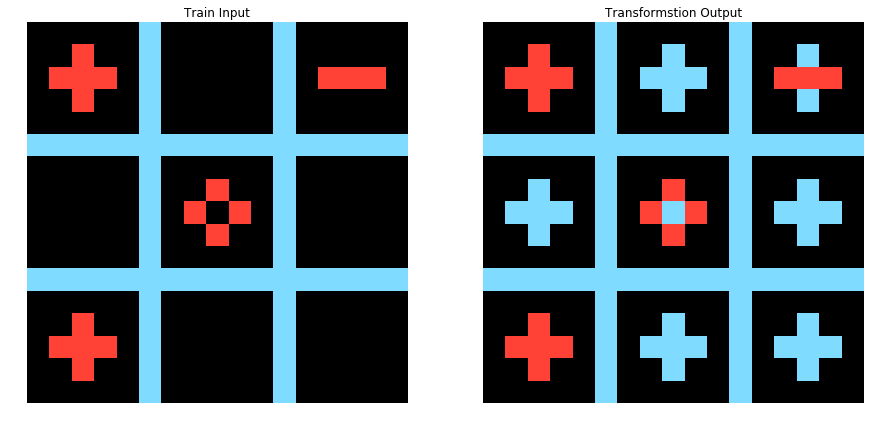

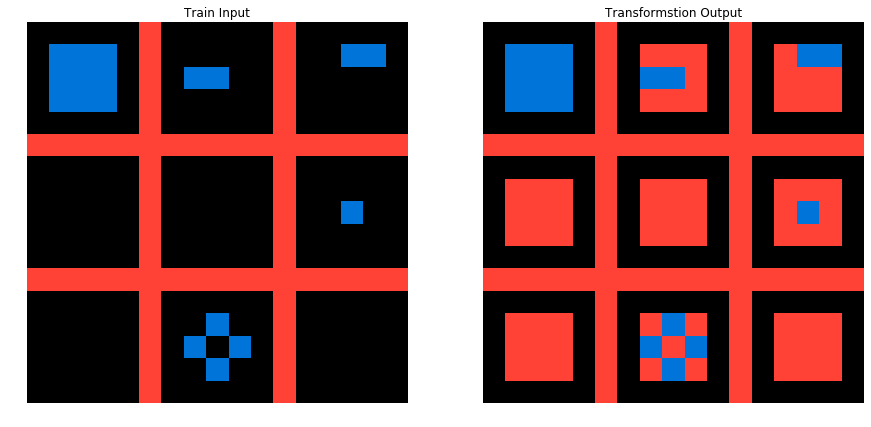

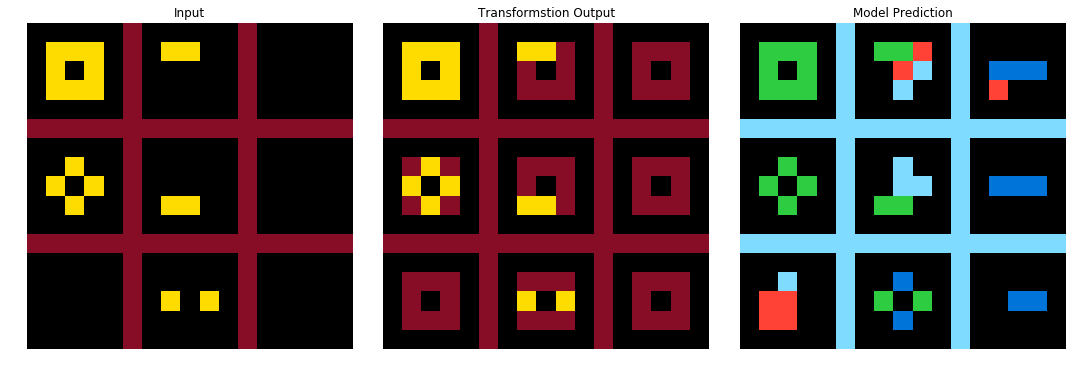

Made predictions for  1f0c79e5
ensemble accuracy 0.6666666666666666



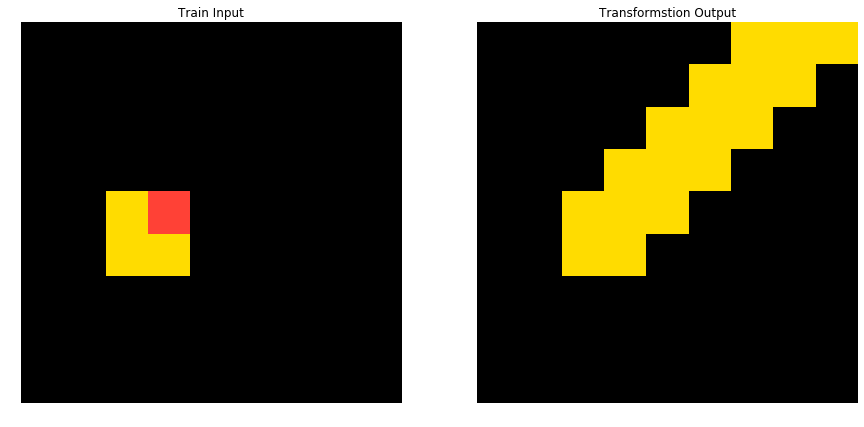

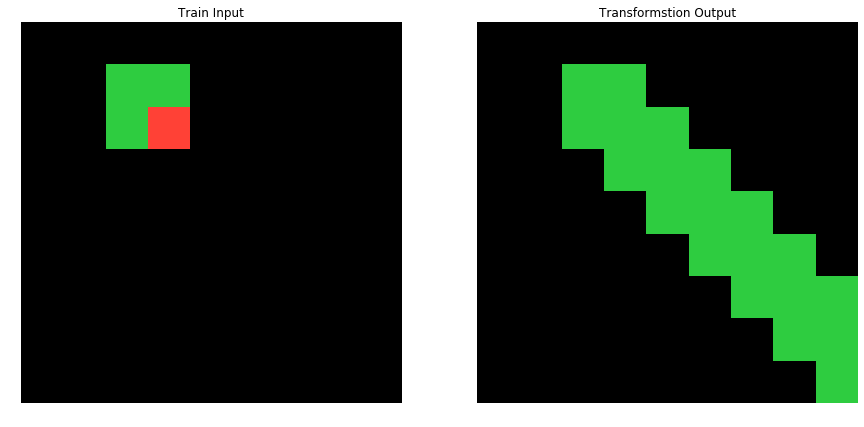

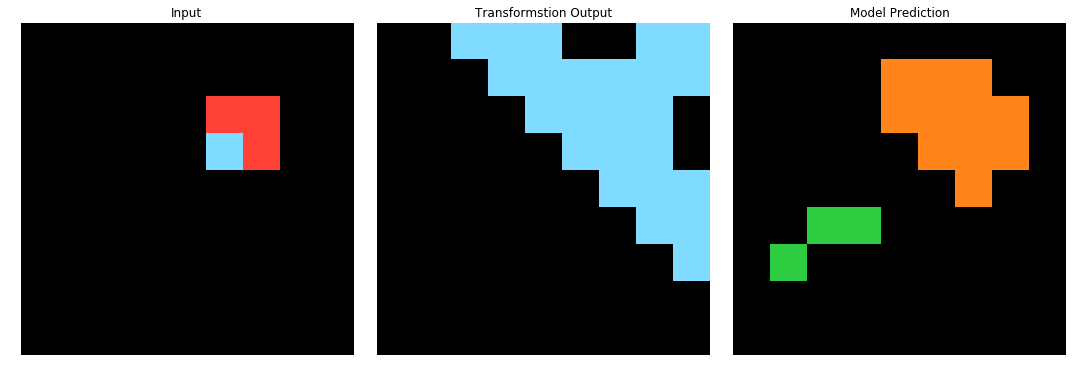

Made predictions for  1f642eb9
ensemble accuracy 0.87



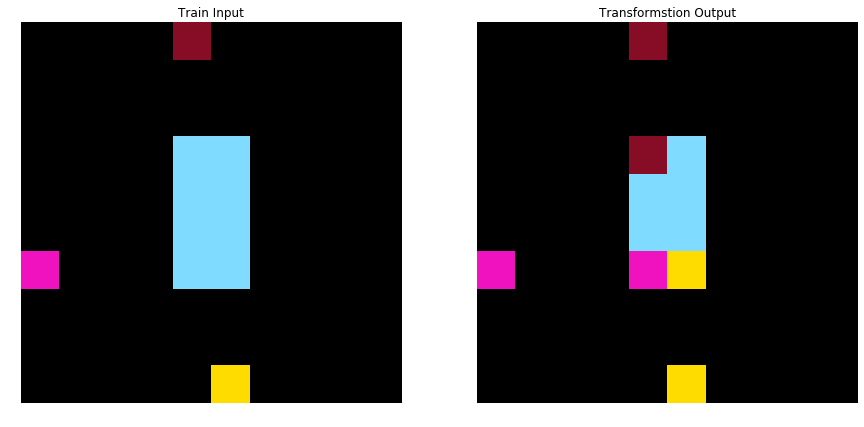

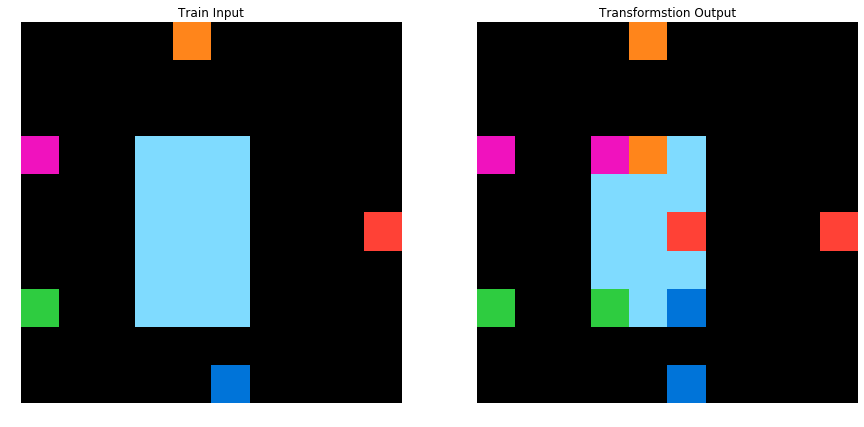

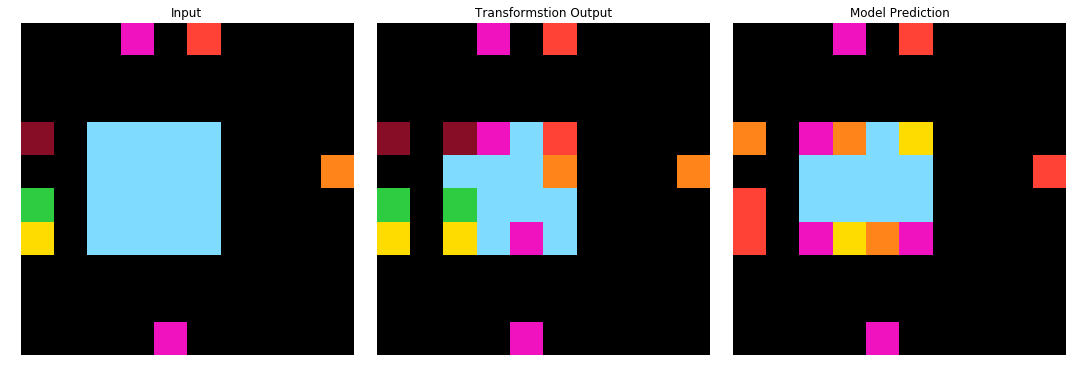

Number of input rows: 30 cols: 30
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1f85a75f.json

Made predictions for  1f876c06
ensemble accuracy 0.87



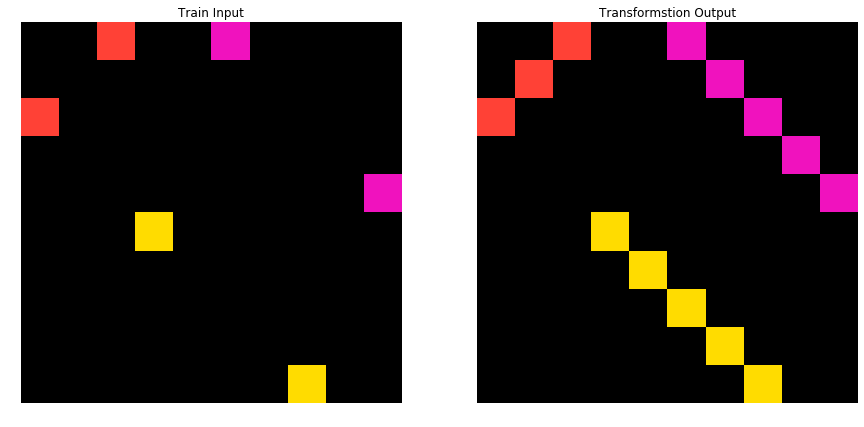

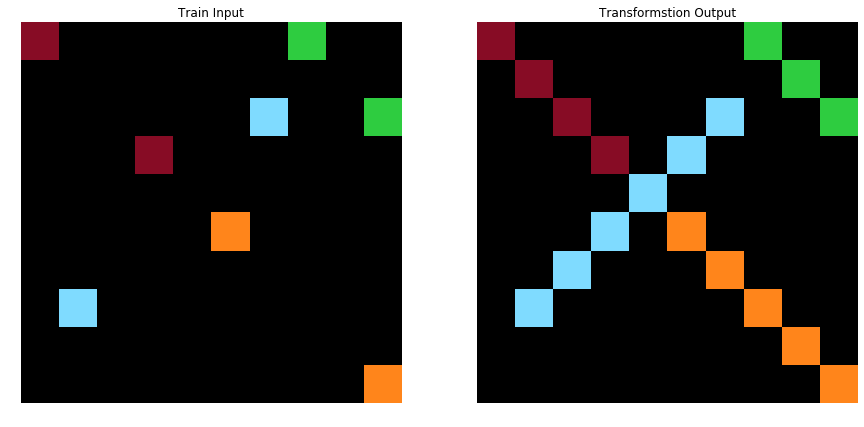

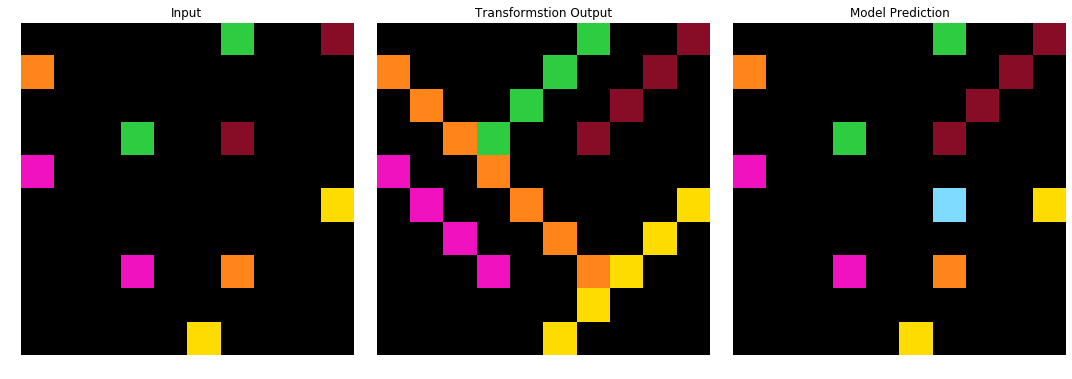

Number of input rows: 9 cols: 9
Number of target rows: 1 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1fad071e.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/2013d3e2.json

Made predictions for  2204b7a8
ensemble accuracy 0.81



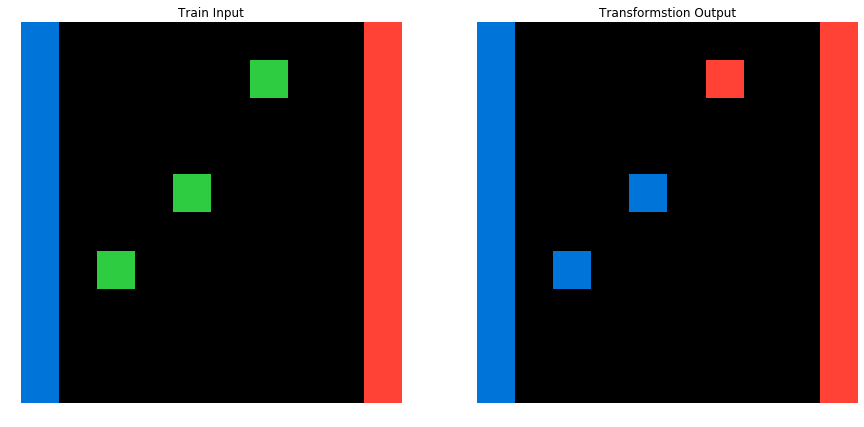

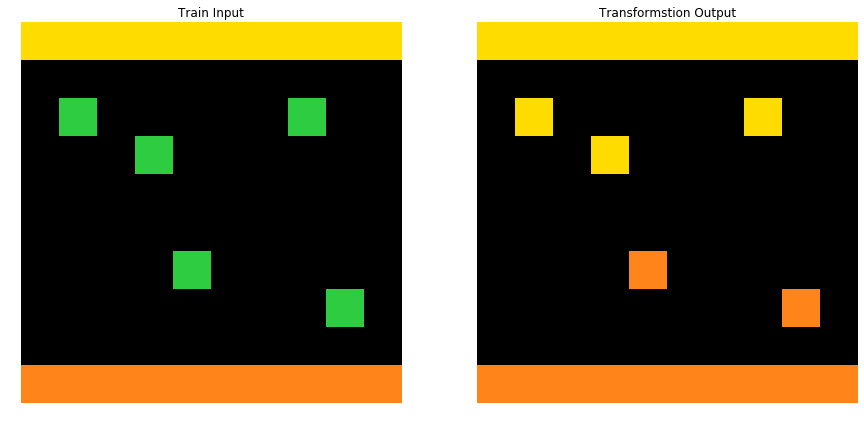

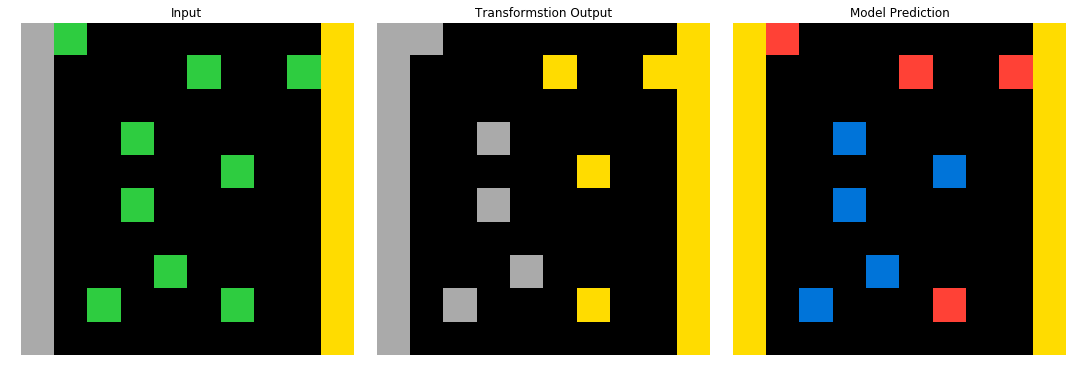

Made predictions for  22168020
ensemble accuracy 0.77



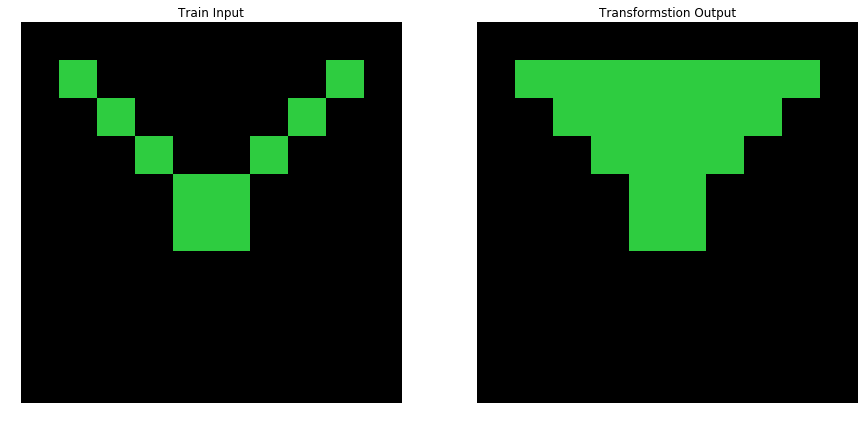

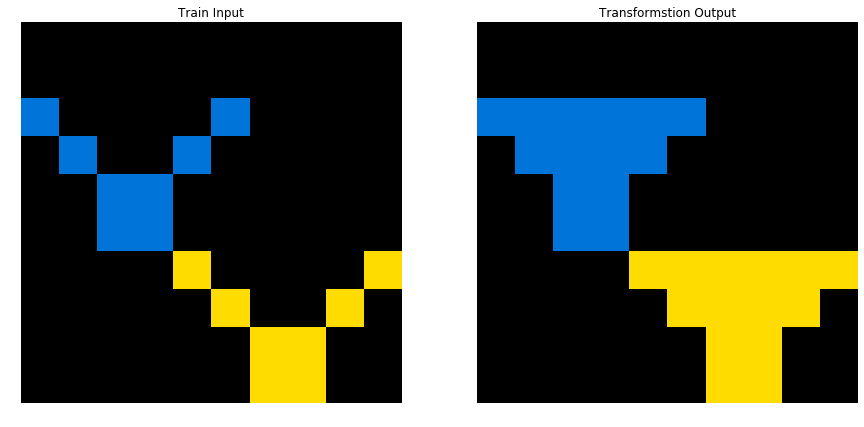

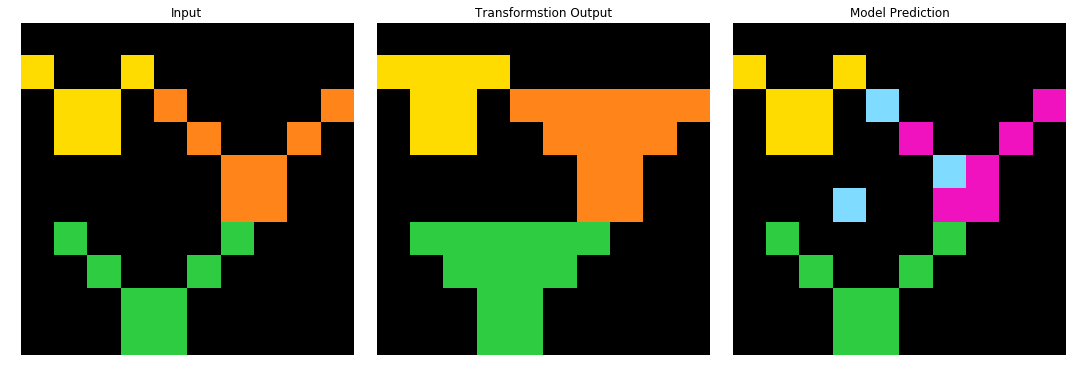

Made predictions for  22233c11
ensemble accuracy 0.93



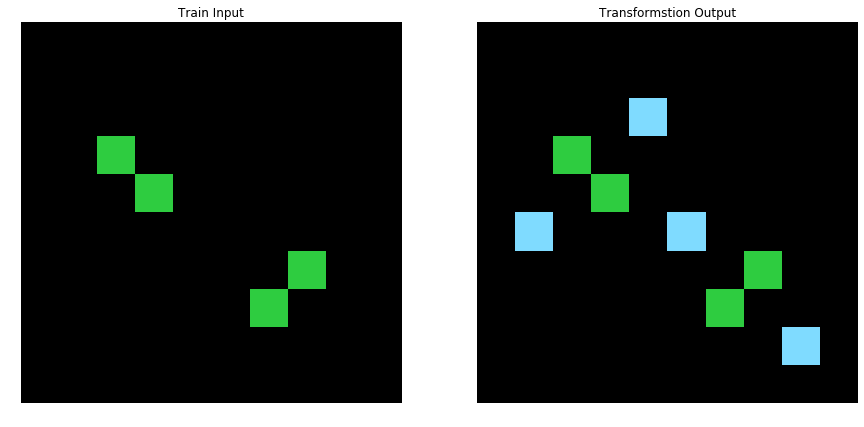

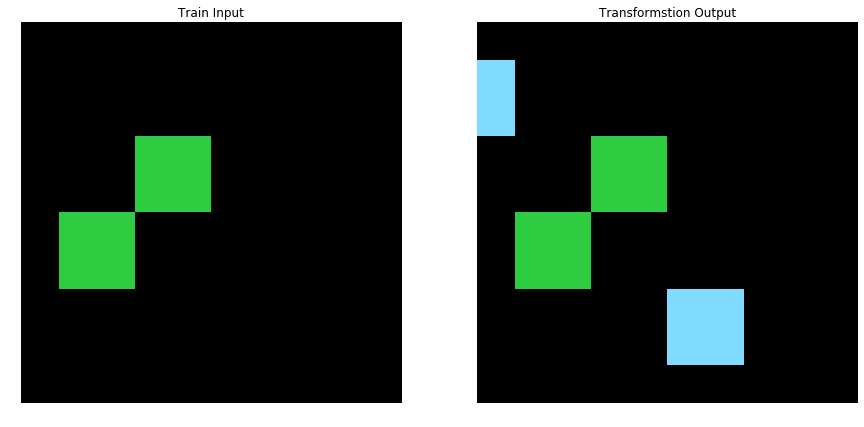

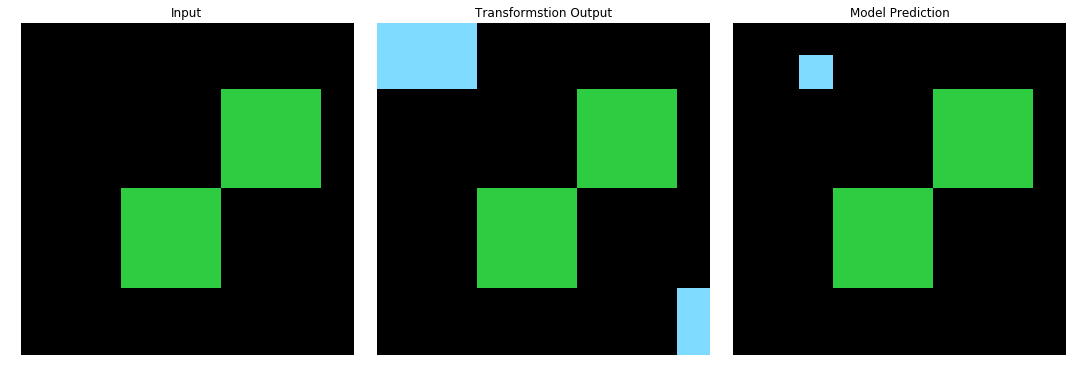

Made predictions for  2281f1f4
ensemble accuracy 1.0
2281f1f4.json



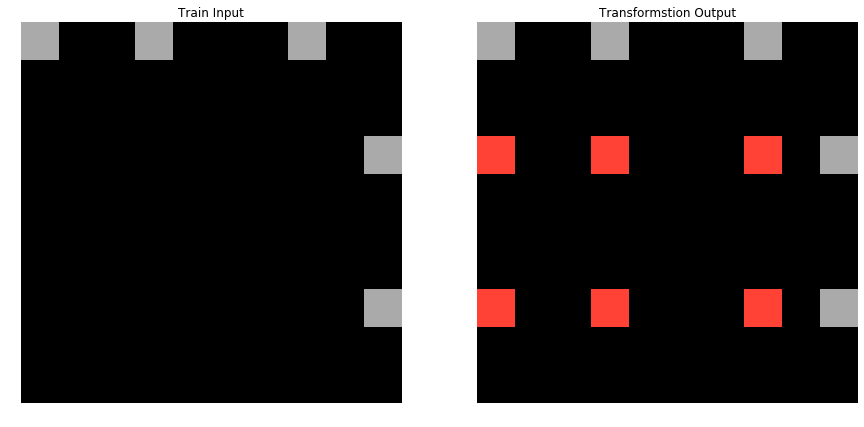

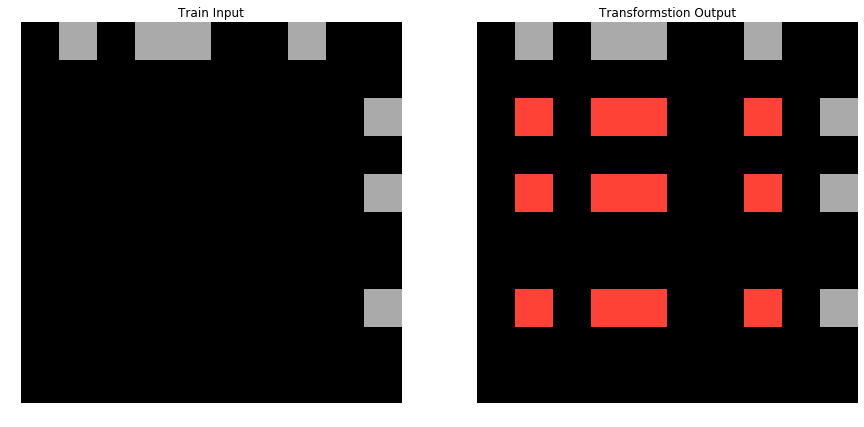

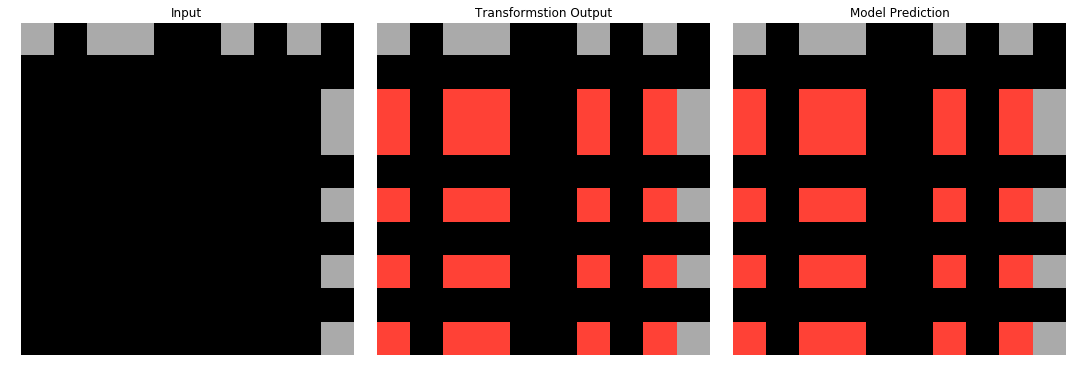

Made predictions for  228f6490
ensemble accuracy 0.79



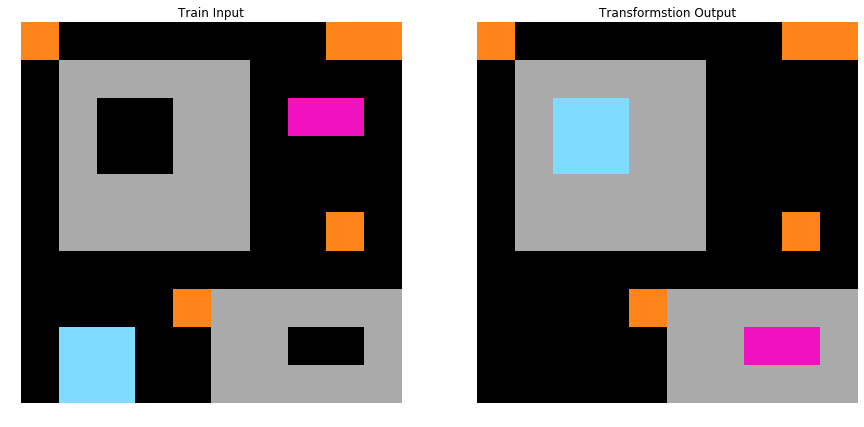

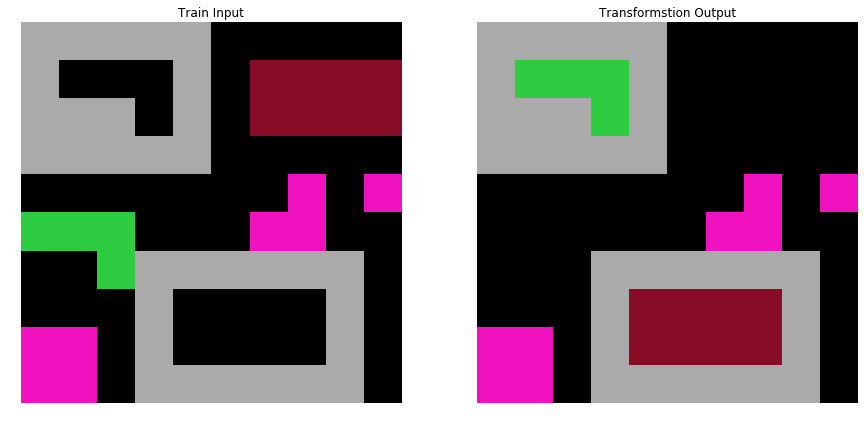

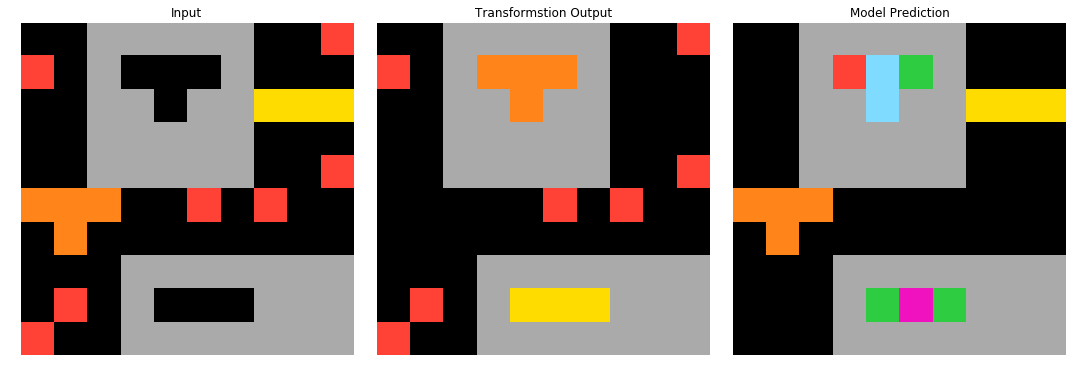

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  22eb0ac0
ensemble accuracy 0.8



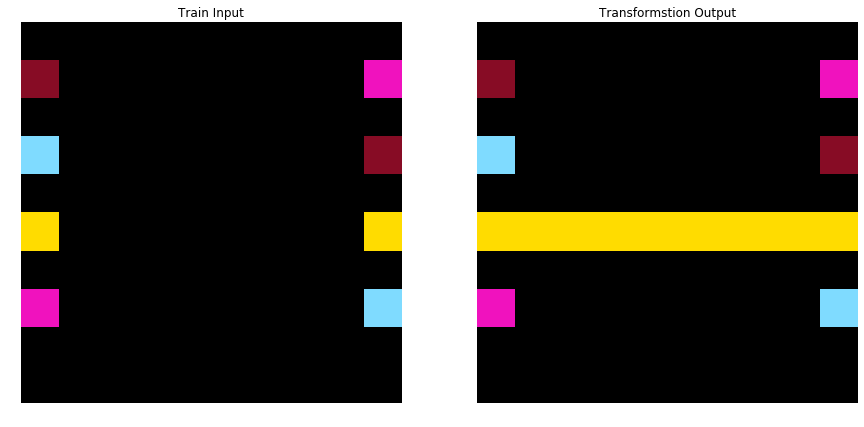

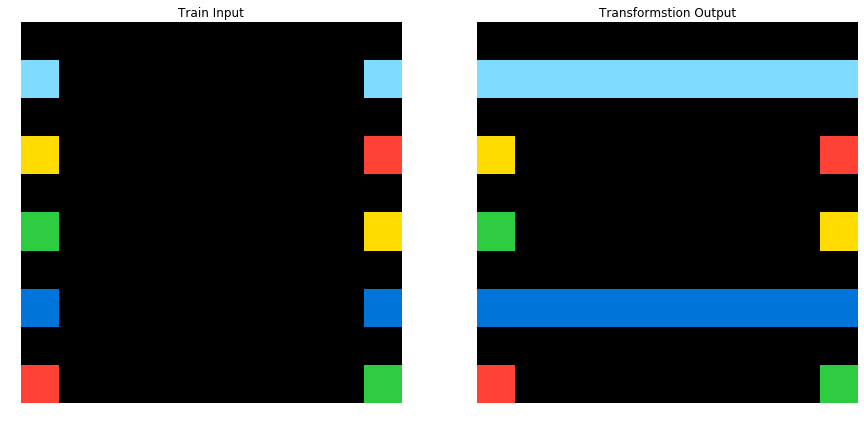

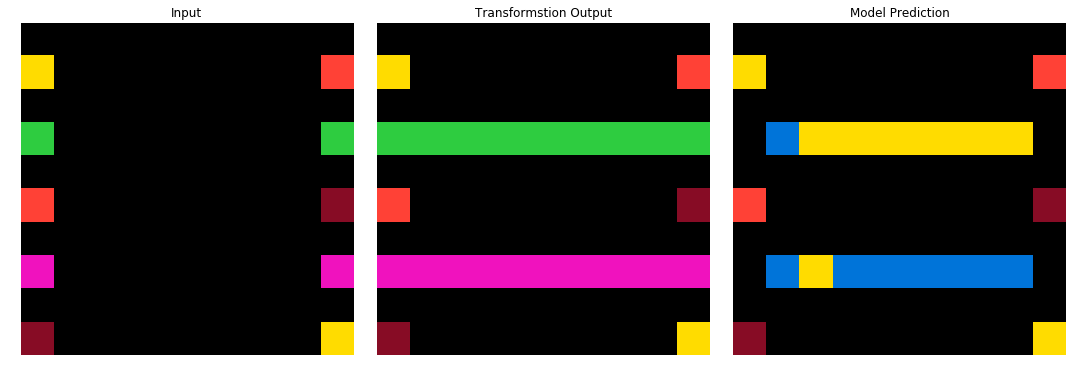

Number of input rows: 3 cols: 9
Number of target rows: 3 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/234bbc79.json

Made predictions for  23581191
ensemble accuracy 0.8888888888888888



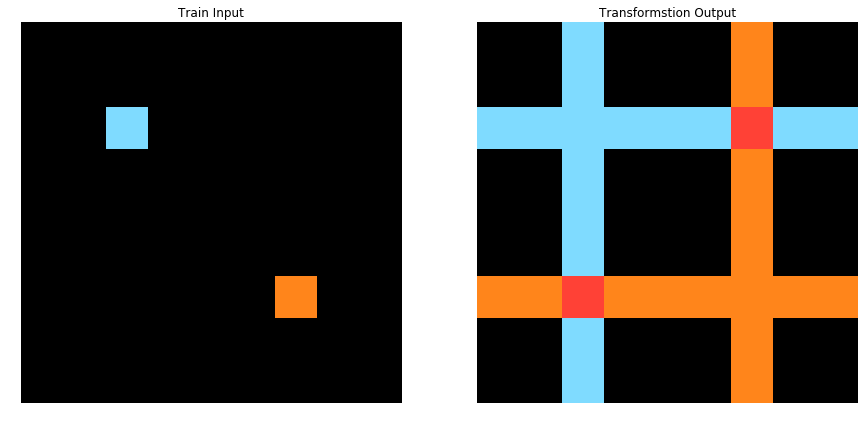

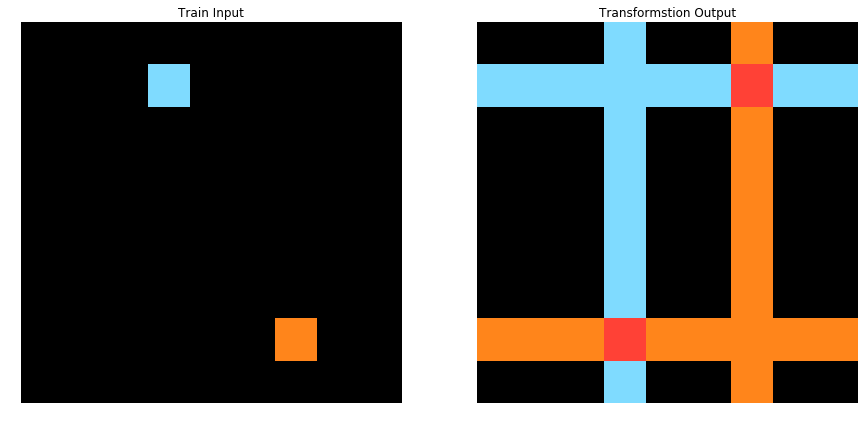

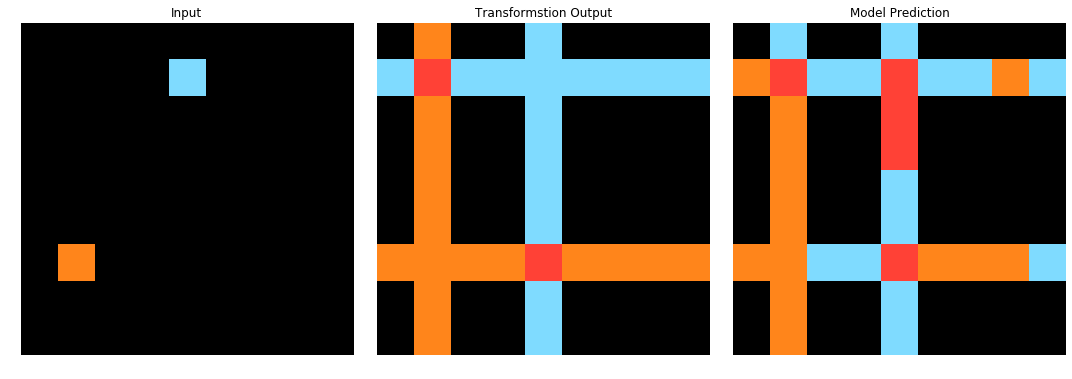

Number of input rows: 5 cols: 5
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/239be575.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/23b5c85d.json

Made predictions for  253bf280
ensemble accuracy 0.8782051282051282



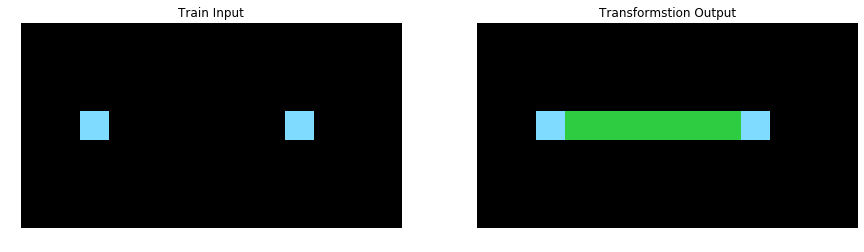

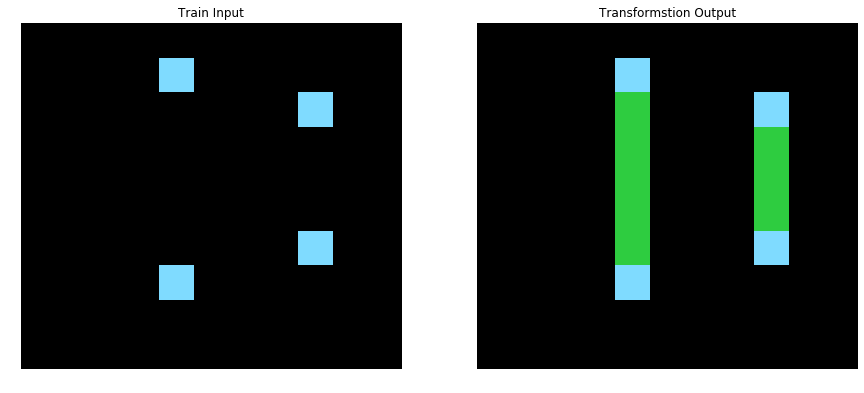

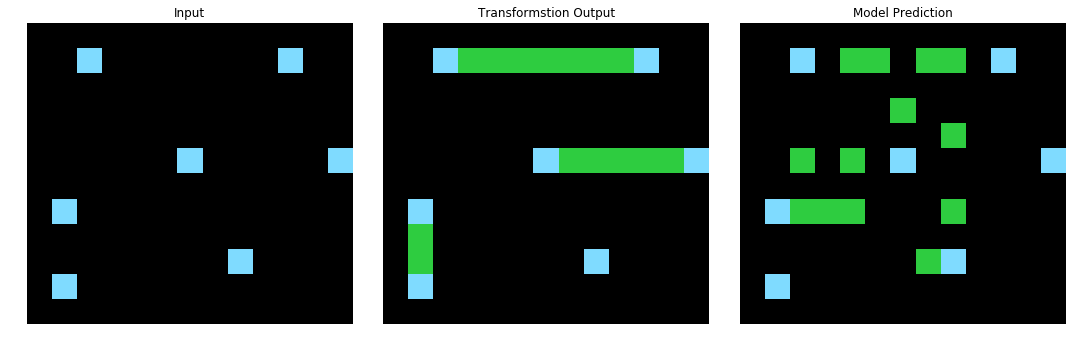

Made predictions for  25d487eb
ensemble accuracy 0.8522727272727273



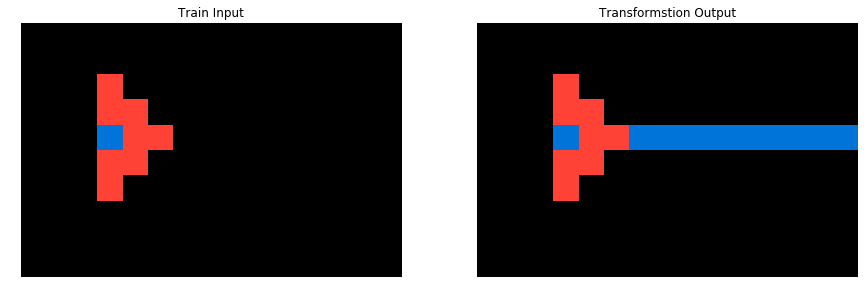

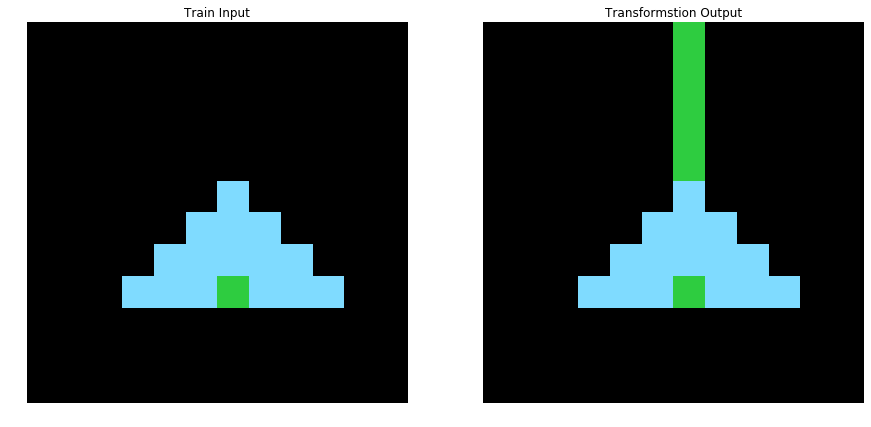

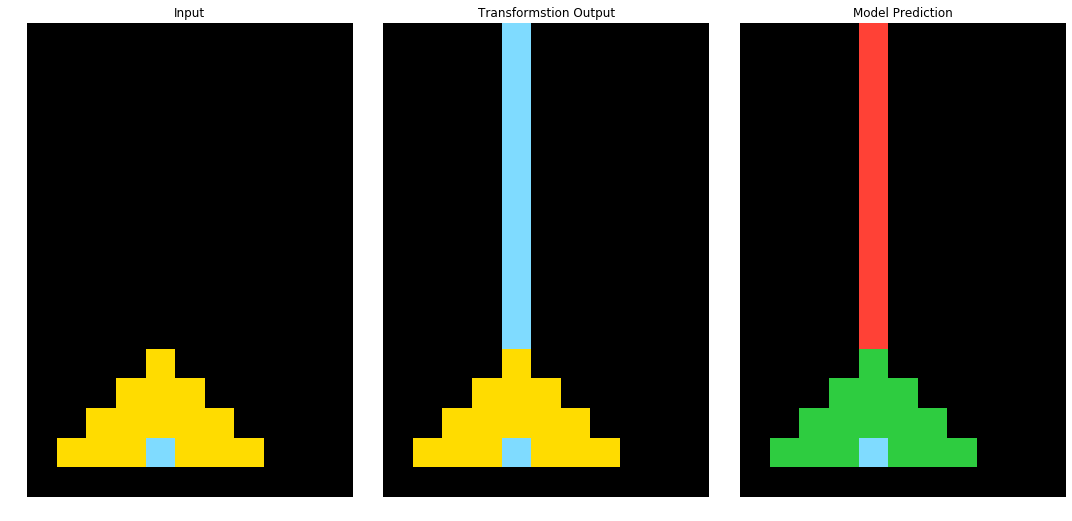

Made predictions for  25d8a9c8
ensemble accuracy 1.0
25d8a9c8.json



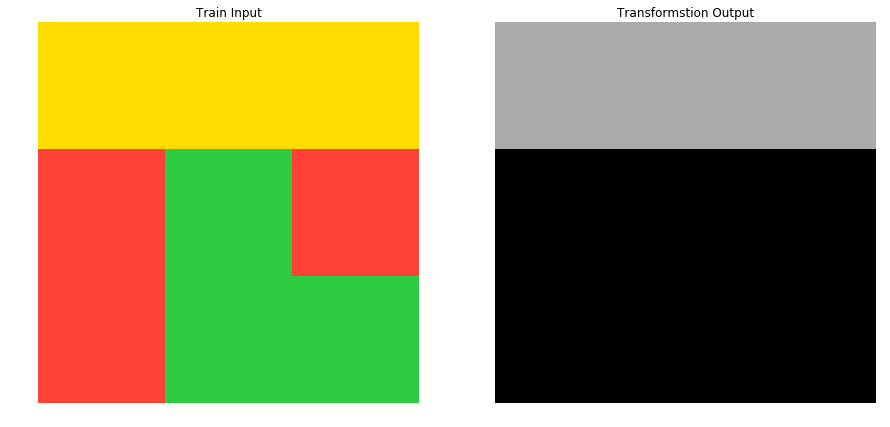

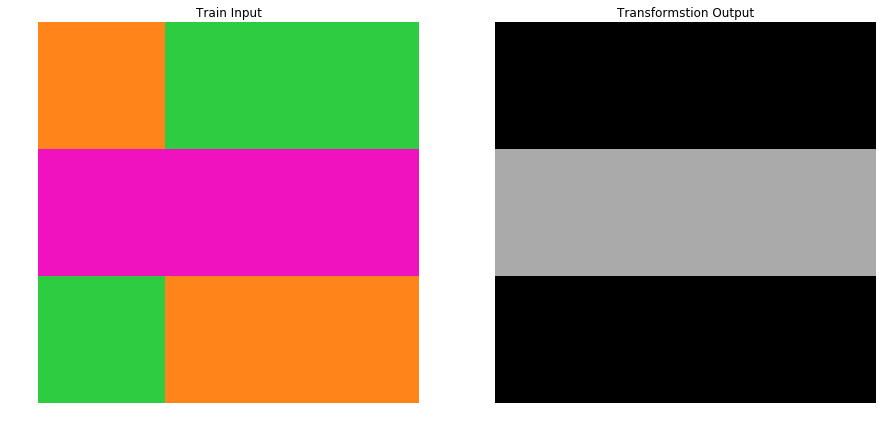

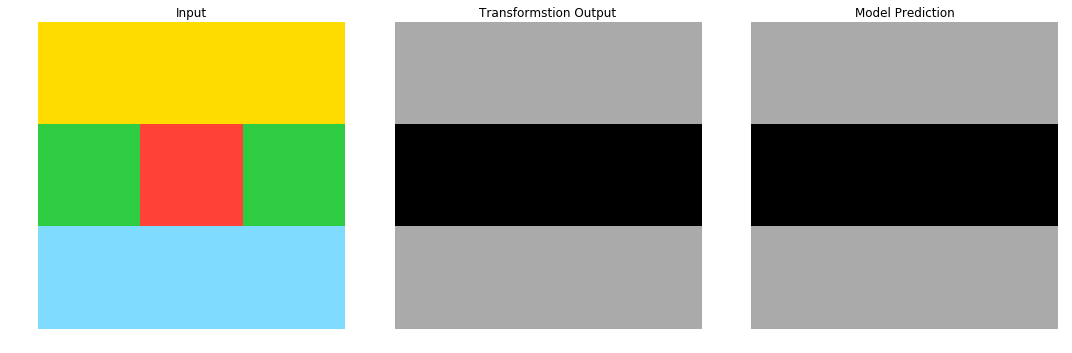

Made predictions for  25ff71a9
ensemble accuracy 1.0
25ff71a9.json



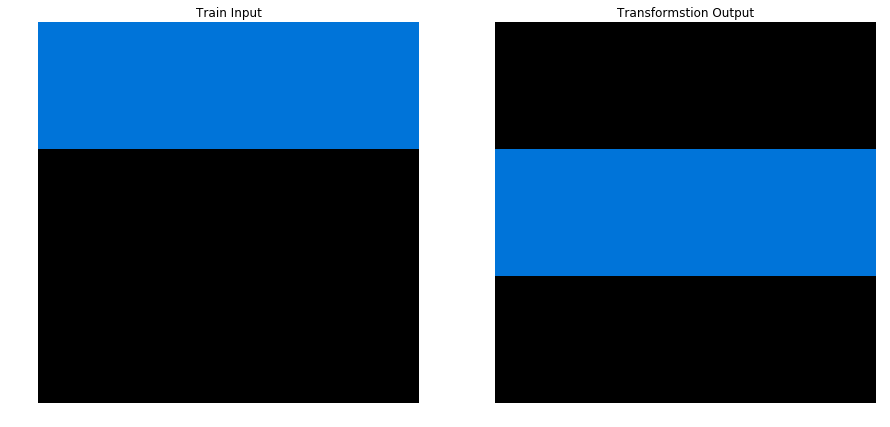

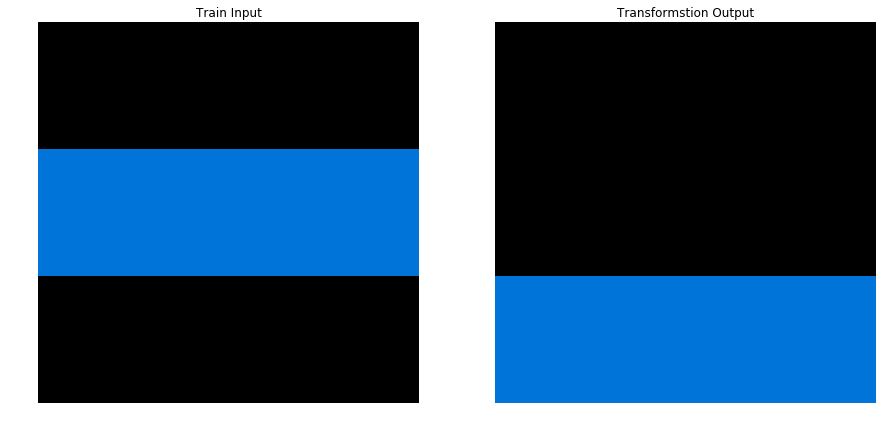

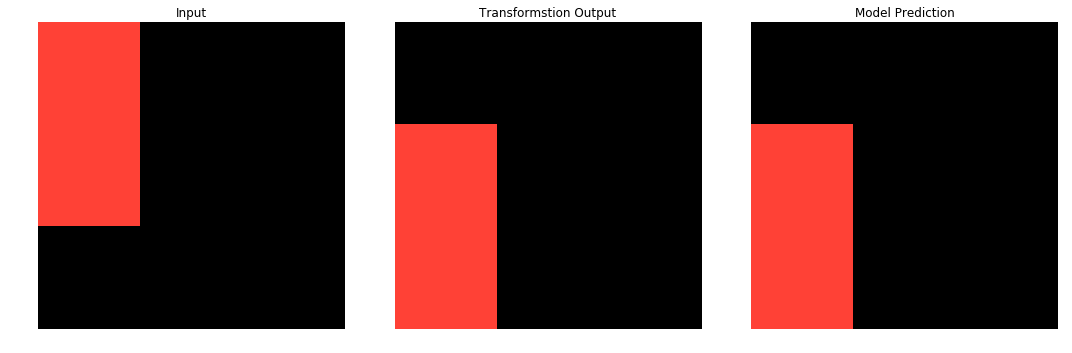

Made predictions for  25ff71a9
ensemble accuracy 0.7777777777777778



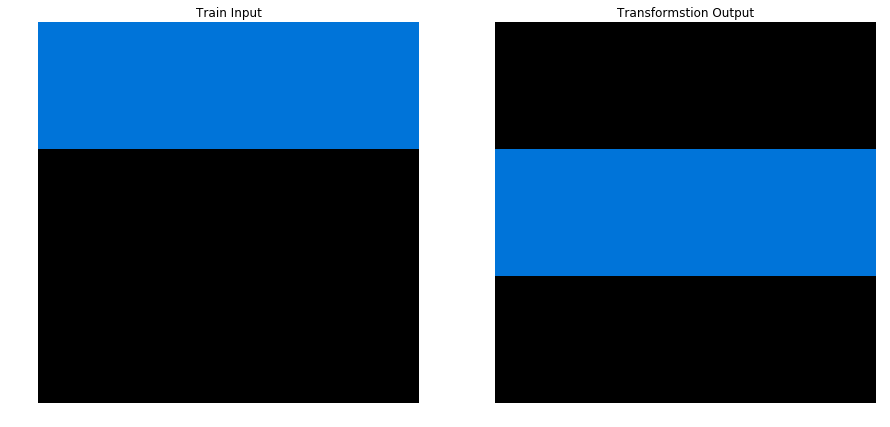

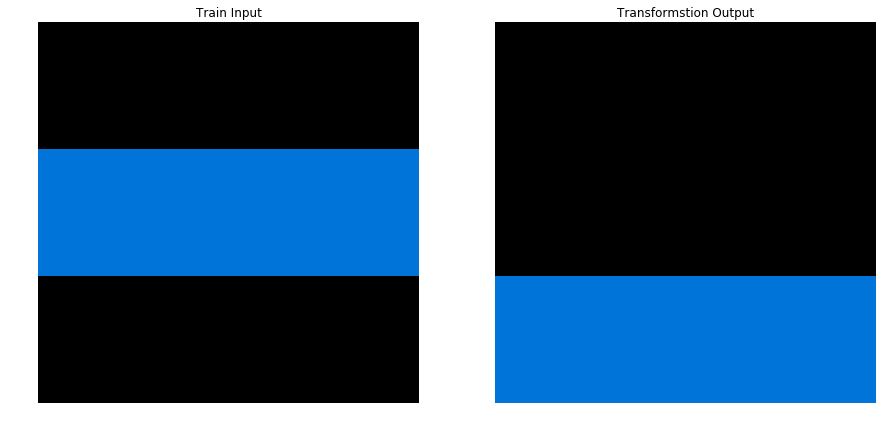

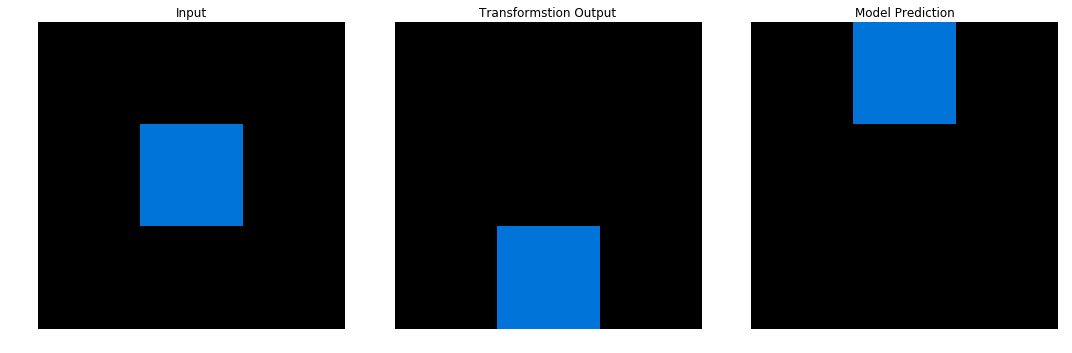

Made predictions for  264363fd
ensemble accuracy 0.39111111111111113



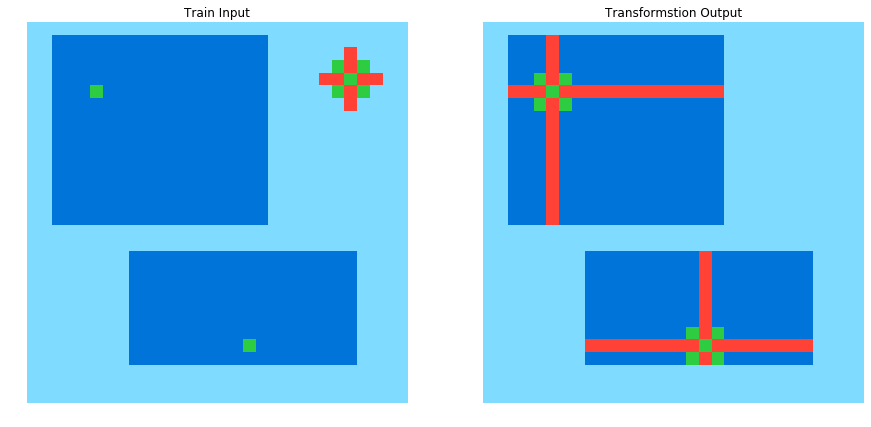

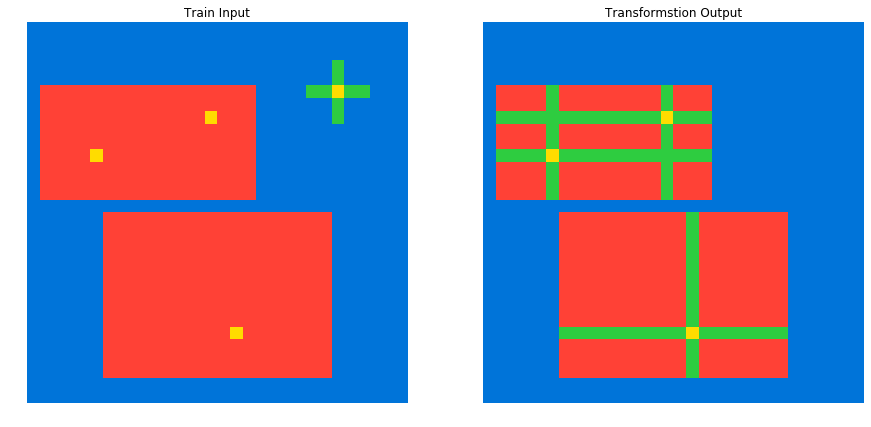

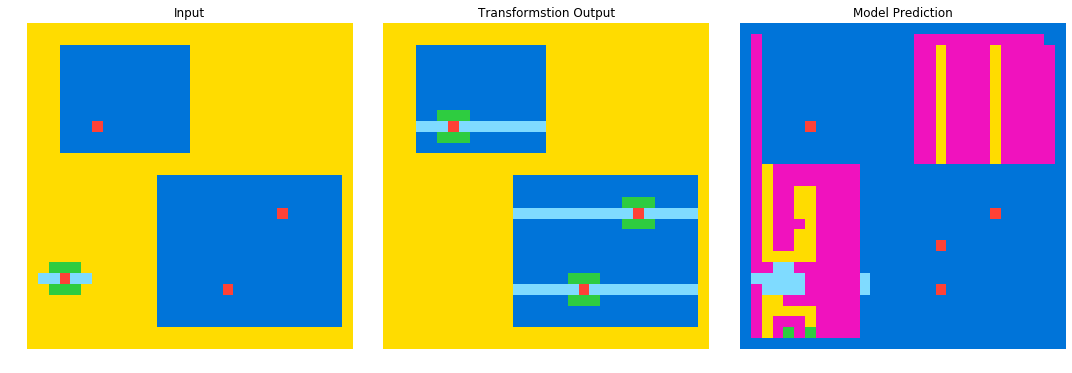

Made predictions for  272f95fa
ensemble accuracy 0.49019607843137253



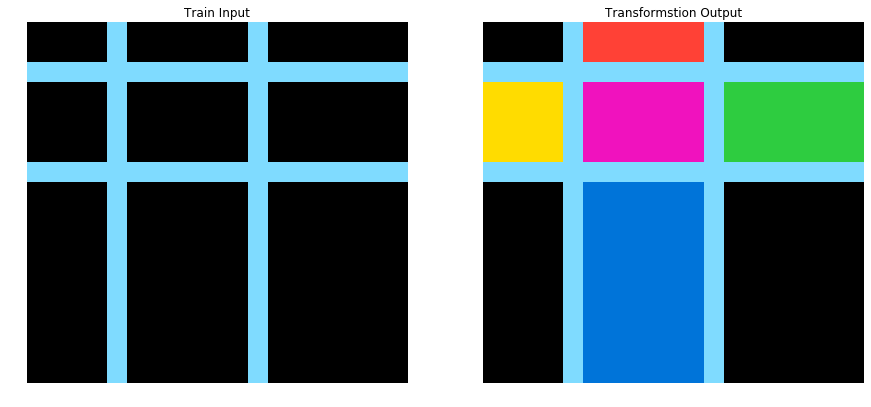

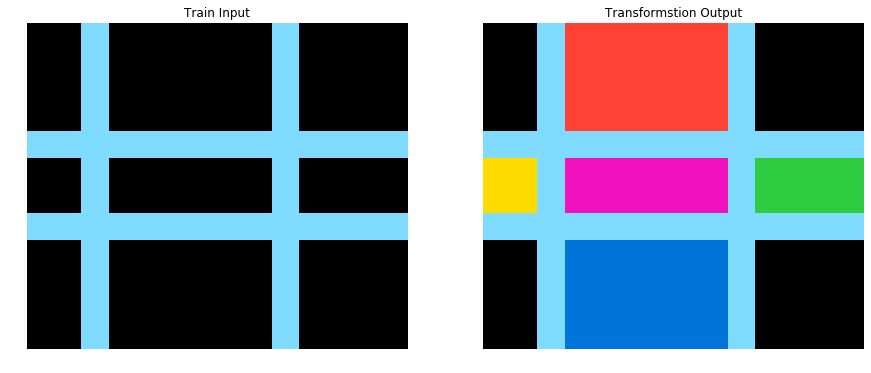

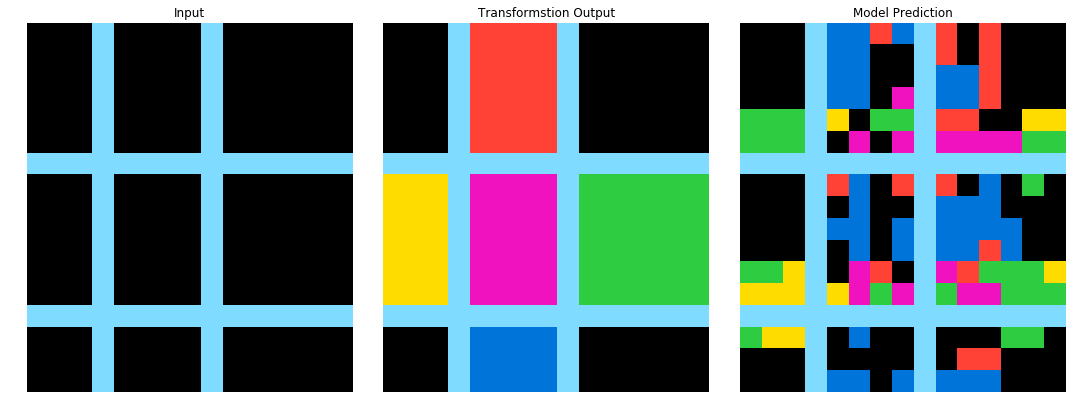

Number of input rows: 3 cols: 3
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/27a28665.json

Number of input rows: 8 cols: 8
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/28bf18c6.json

Made predictions for  28e73c20
ensemble accuracy 0.7376543209876543



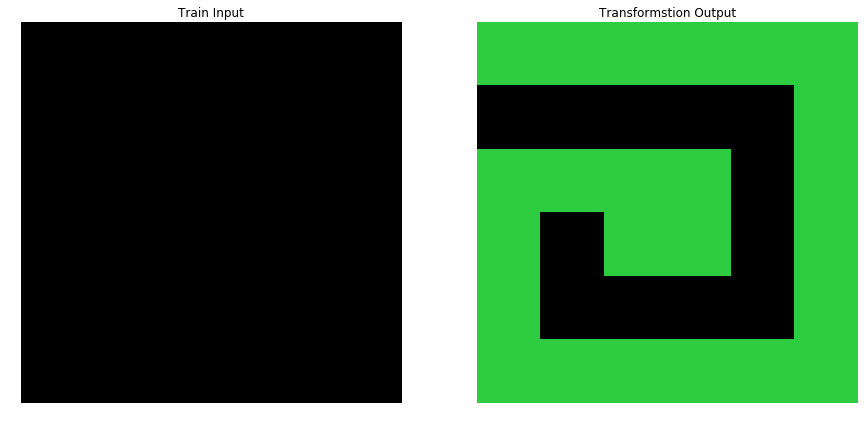

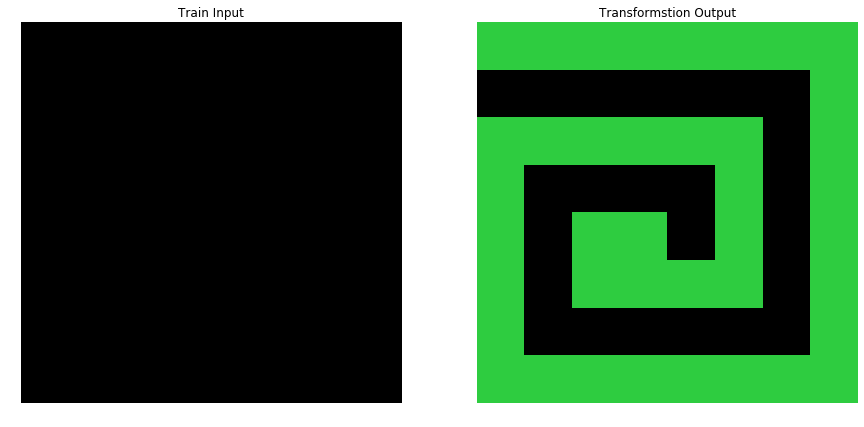

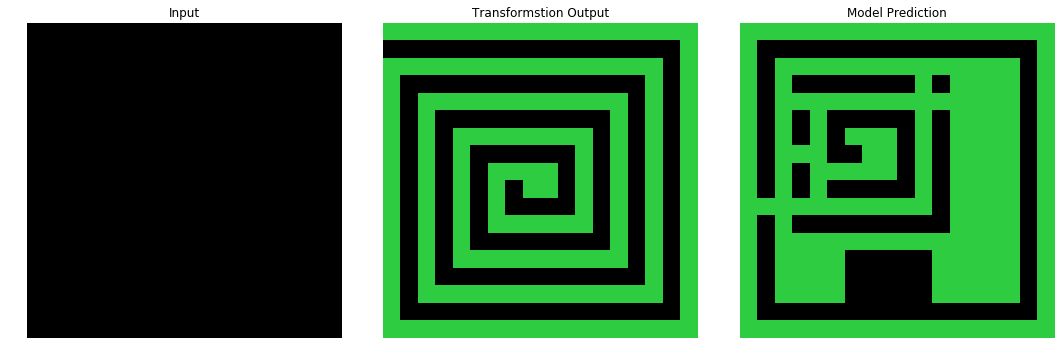

Made predictions for  29623171
ensemble accuracy 0.6859504132231405



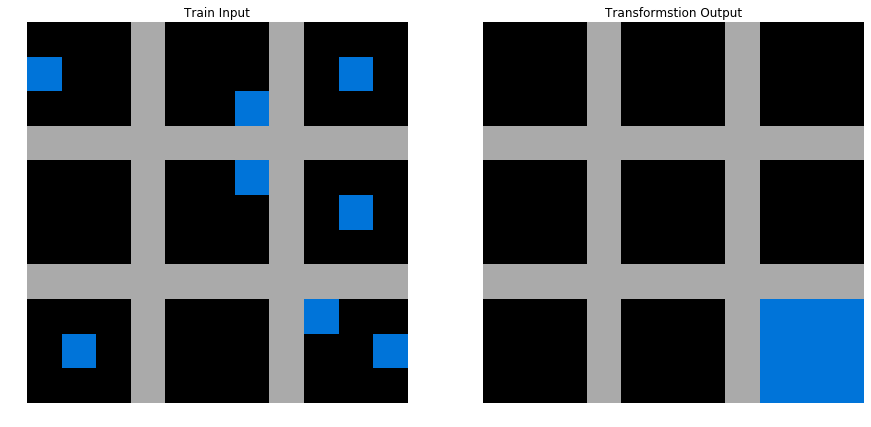

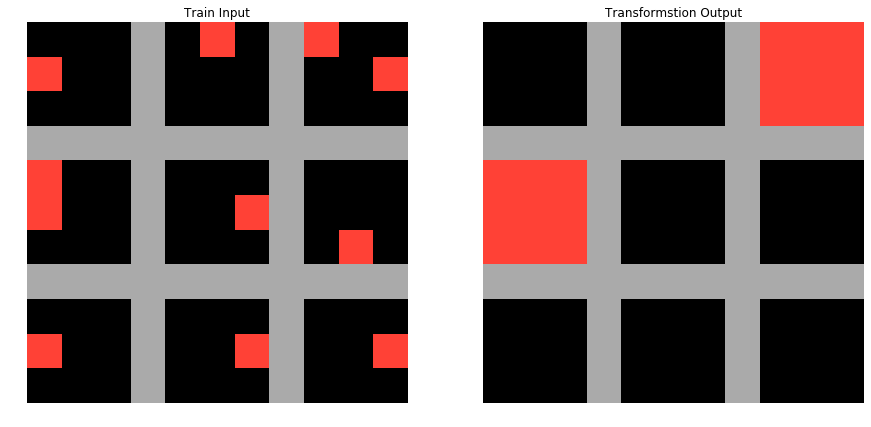

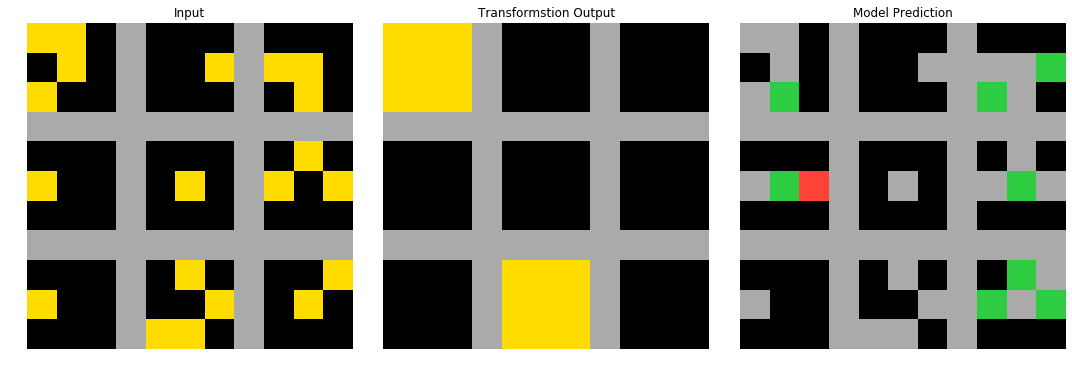

Made predictions for  29c11459
ensemble accuracy 0.6363636363636364



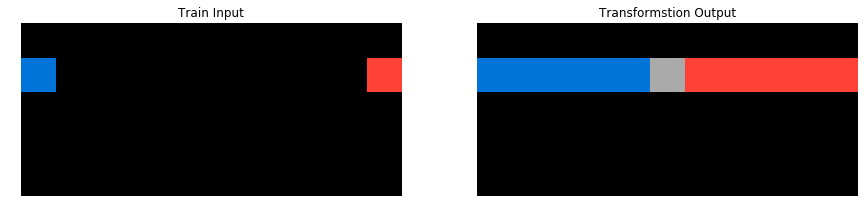

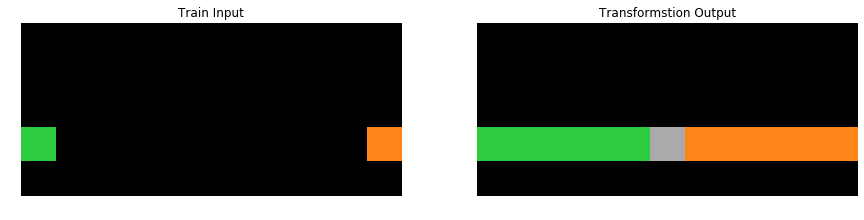

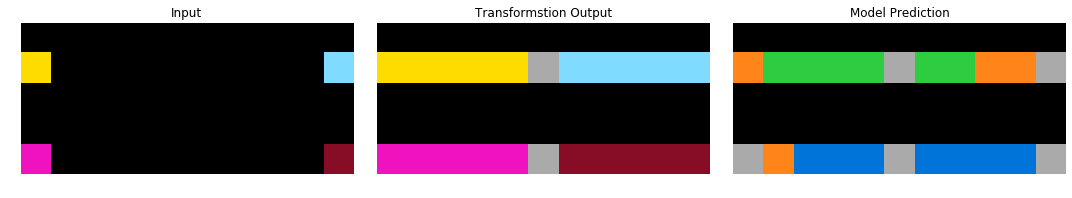

Made predictions for  29ec7d0e
ensemble accuracy 0.808641975308642



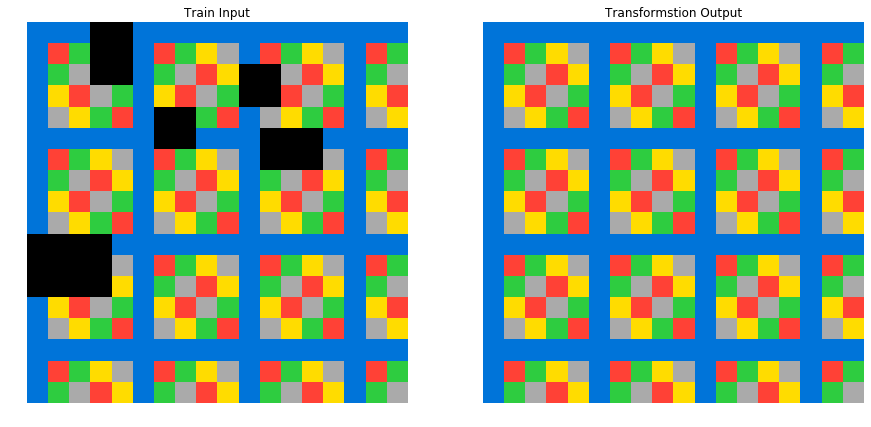

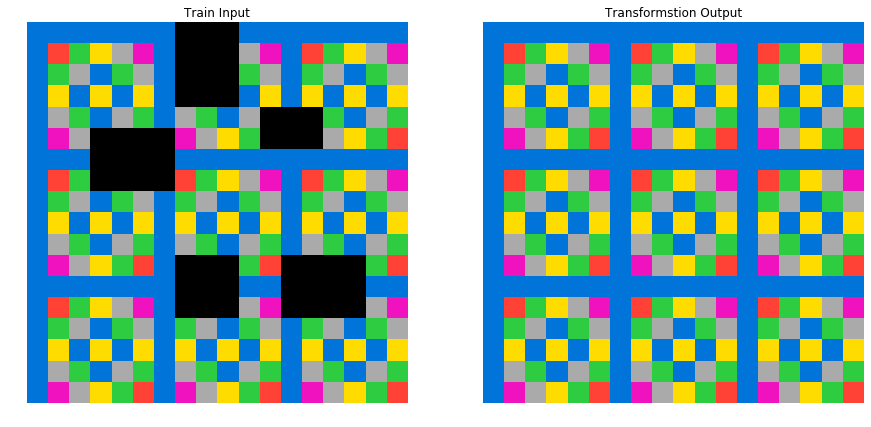

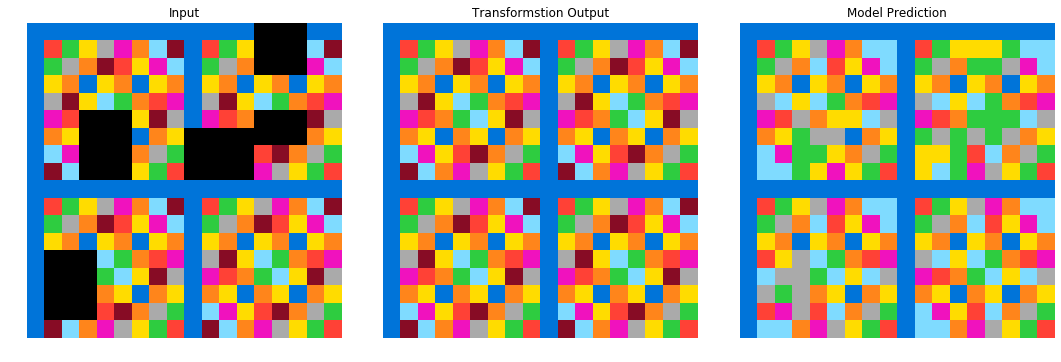

Made predictions for  2bcee788
ensemble accuracy 0.9



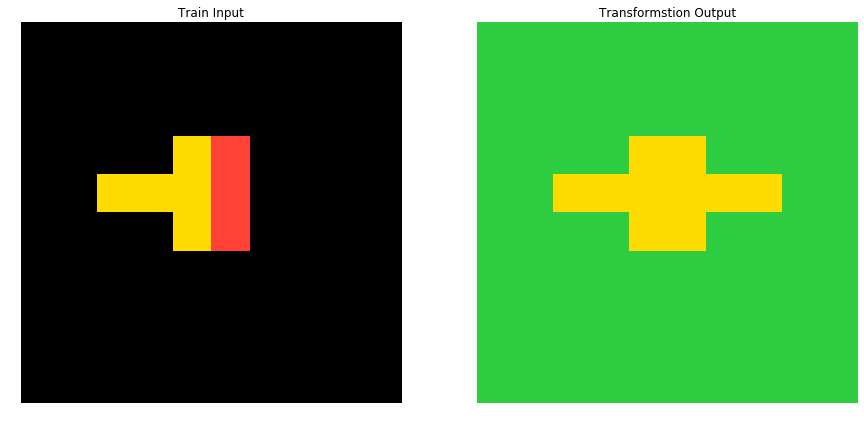

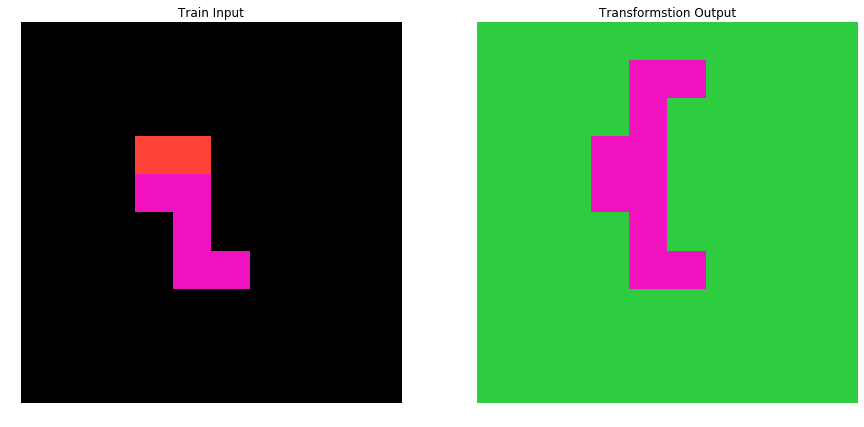

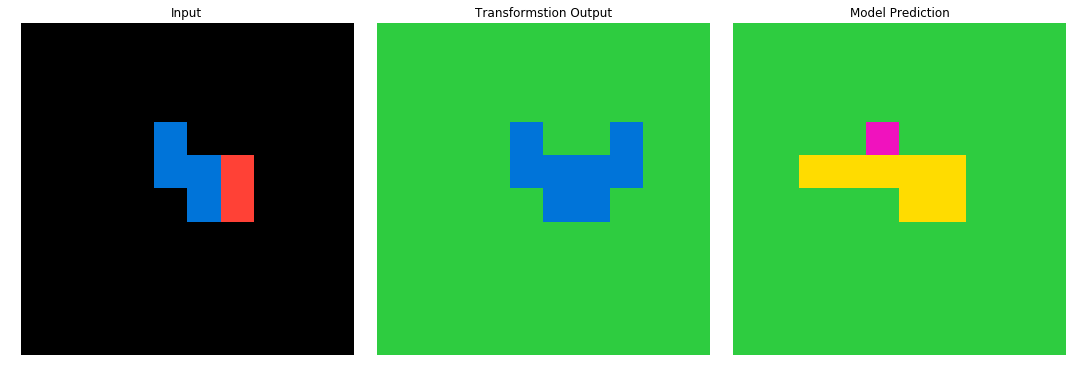

Made predictions for  2bee17df
ensemble accuracy 0.7295918367346939



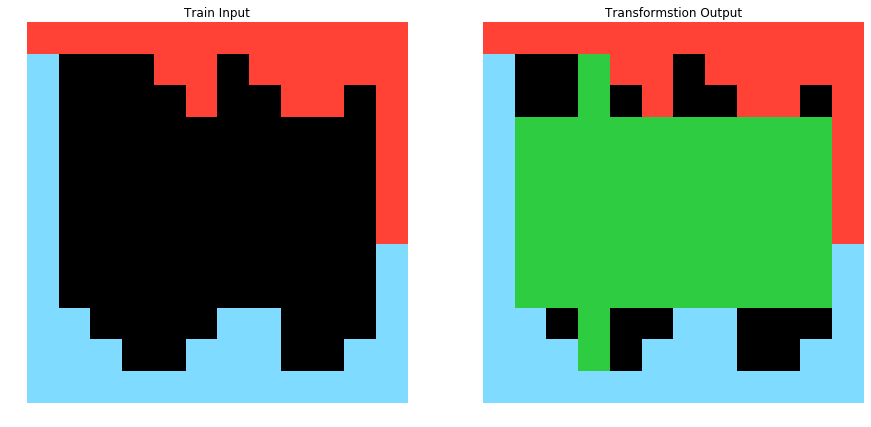

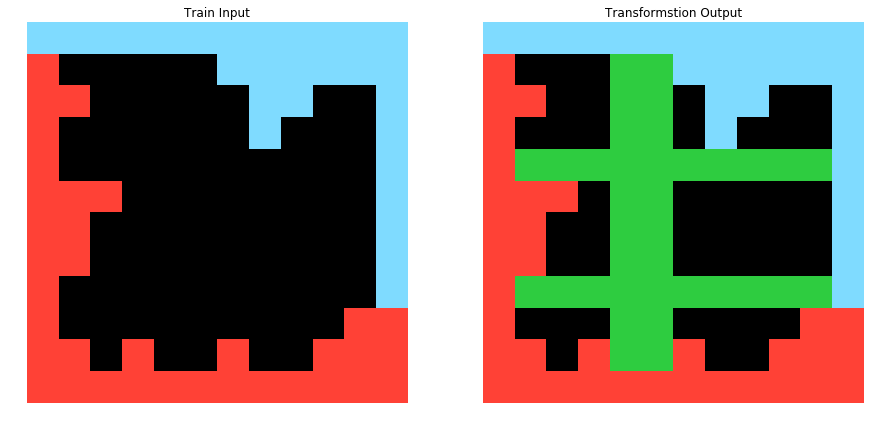

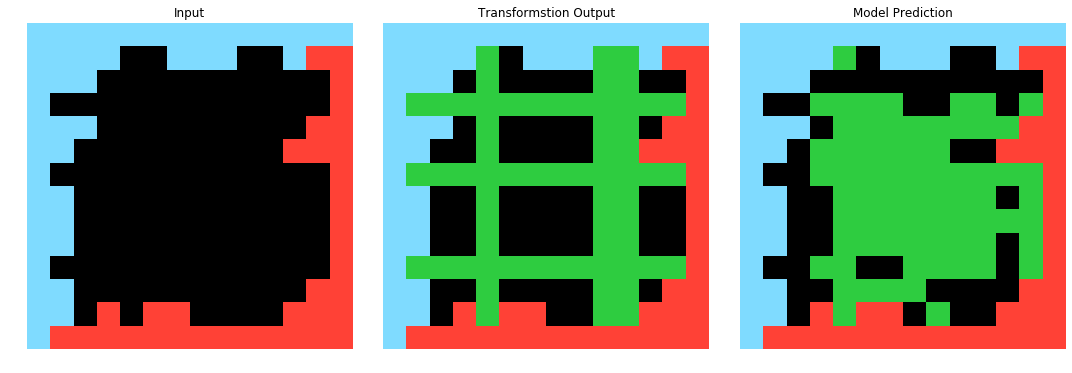

Made predictions for  2c608aff
ensemble accuracy 0.9298245614035088



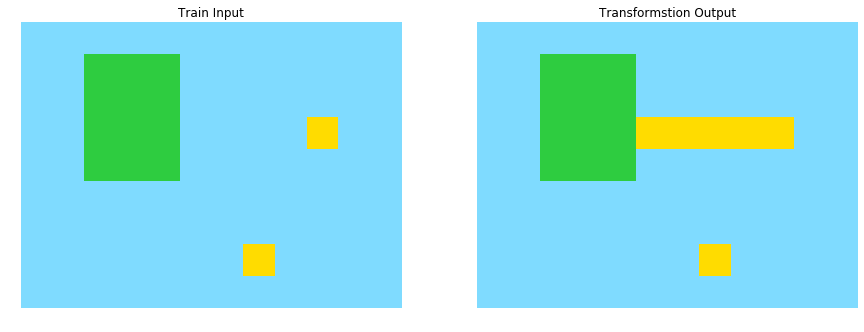

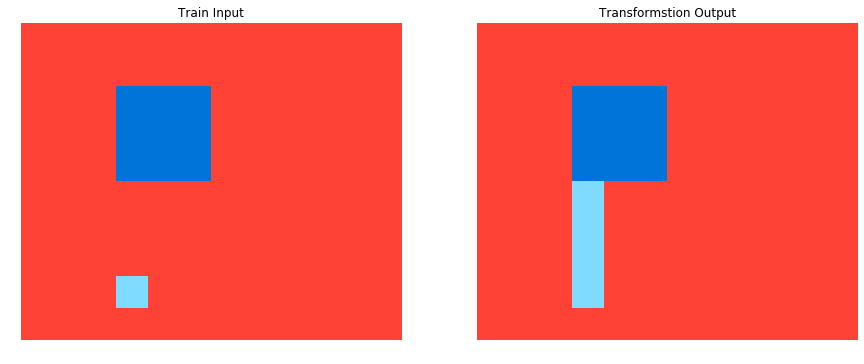

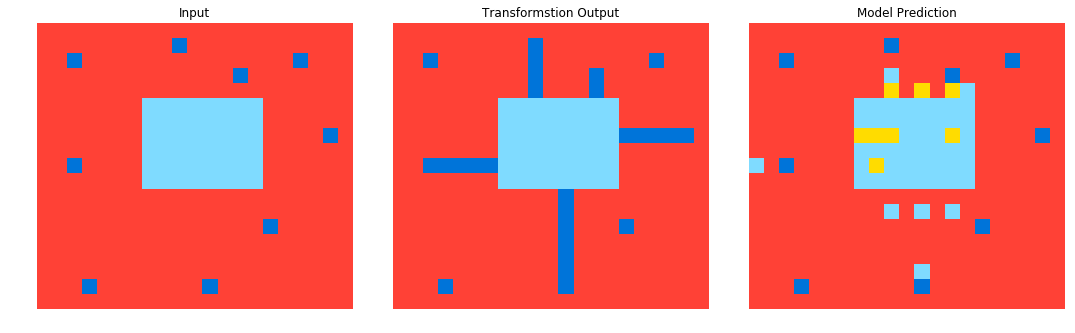

Number of input rows: 5 cols: 5
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/2dc579da.json

Made predictions for  2dd70a9a
ensemble accuracy 0.893491124260355



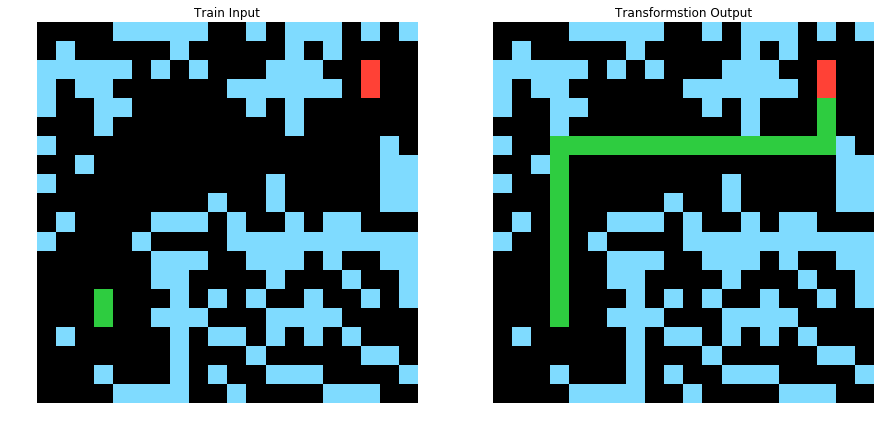

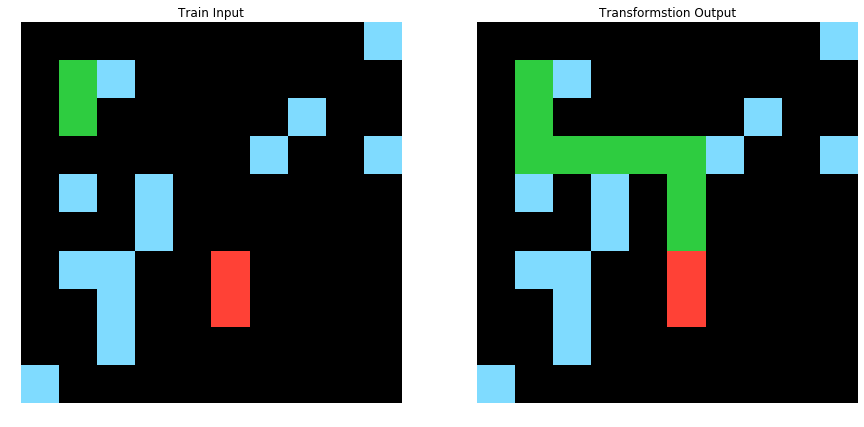

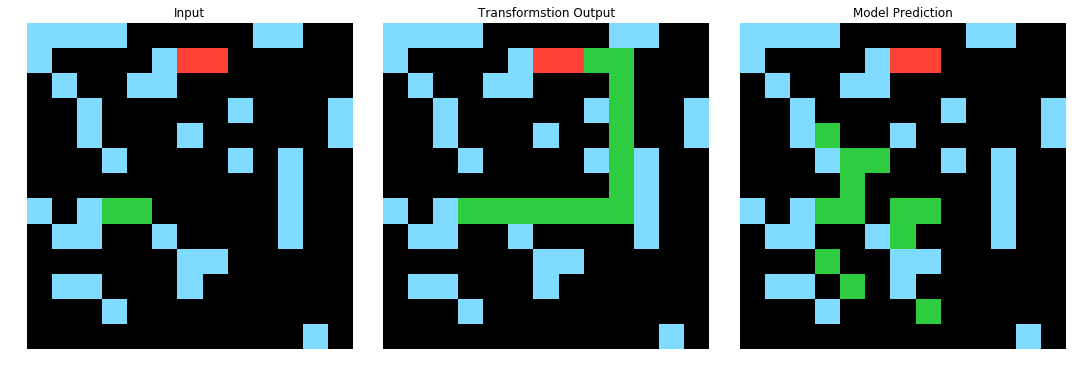

Number of input rows: 3 cols: 9
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/2dee498d.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  31aa019c
ensemble accuracy 0.87



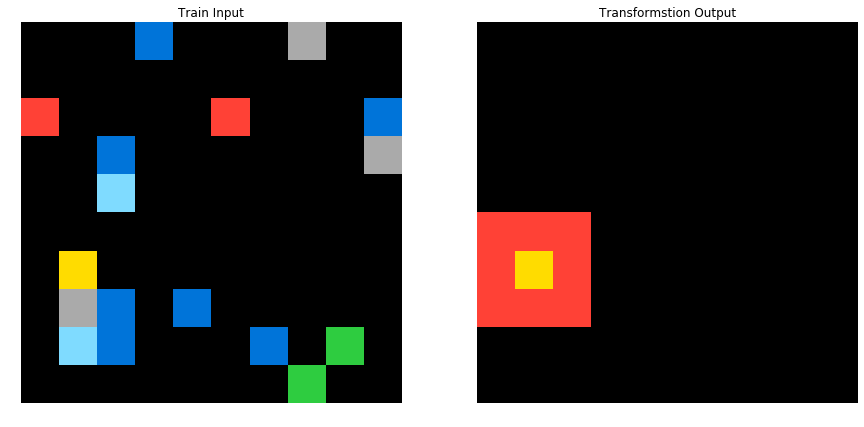

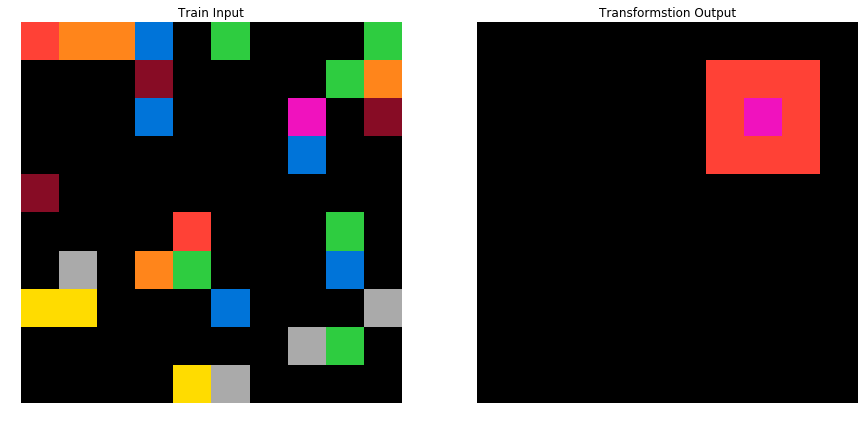

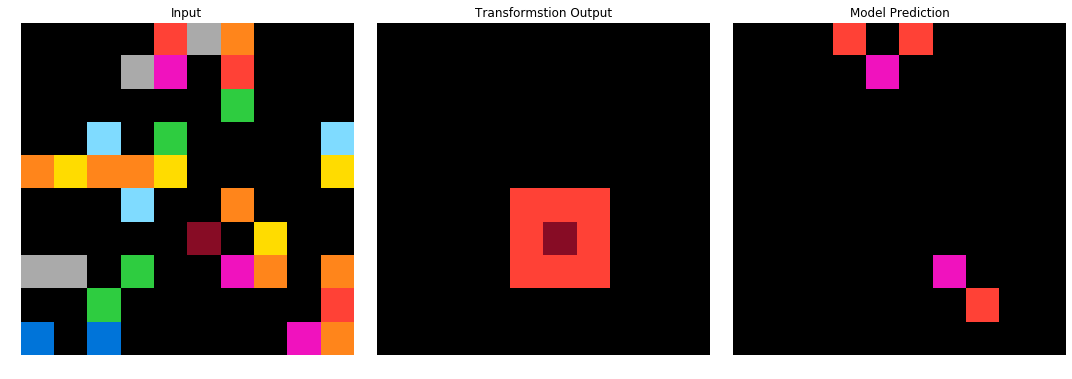

Made predictions for  321b1fc6
ensemble accuracy 0.79



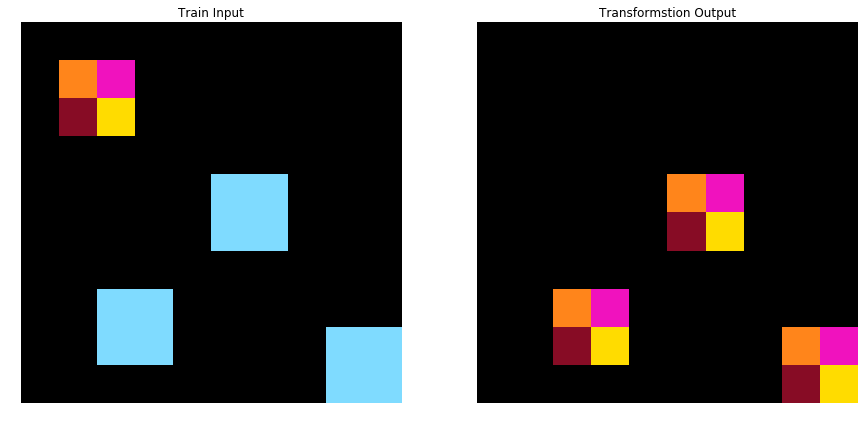

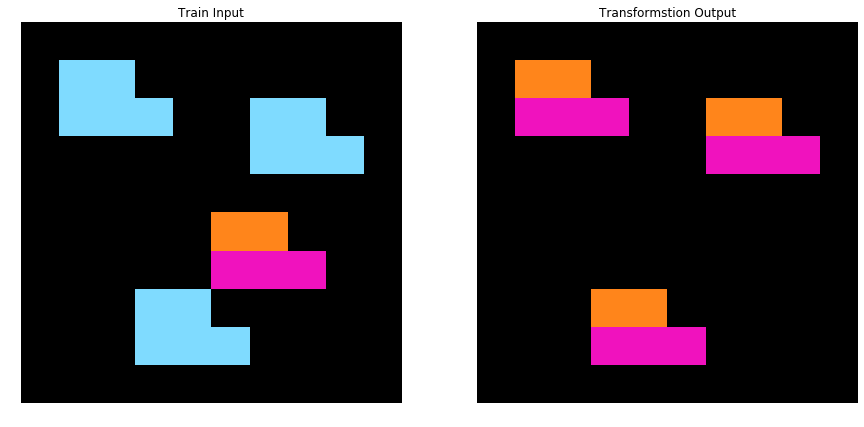

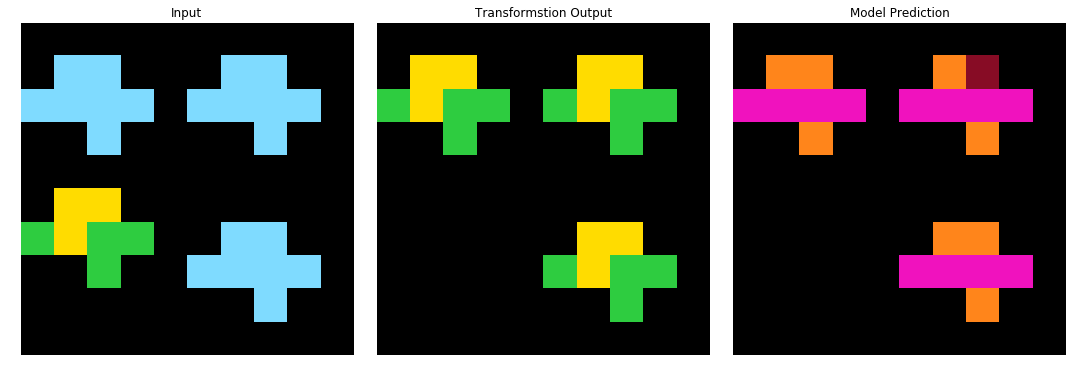

Made predictions for  32597951
ensemble accuracy 1.0
32597951.json



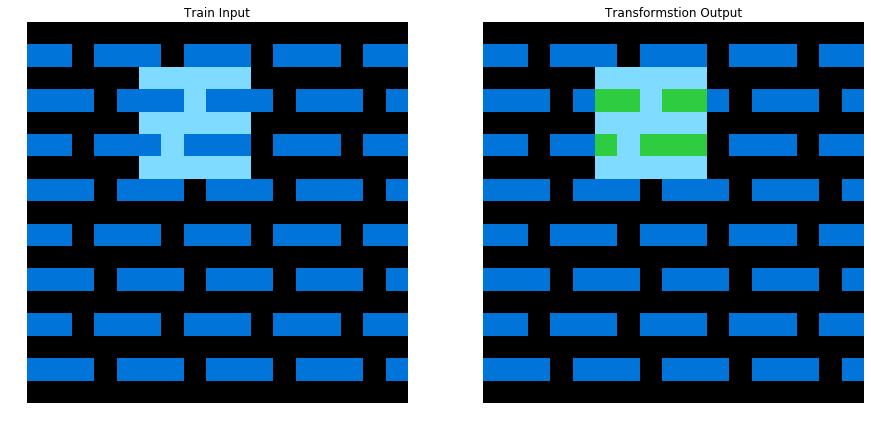

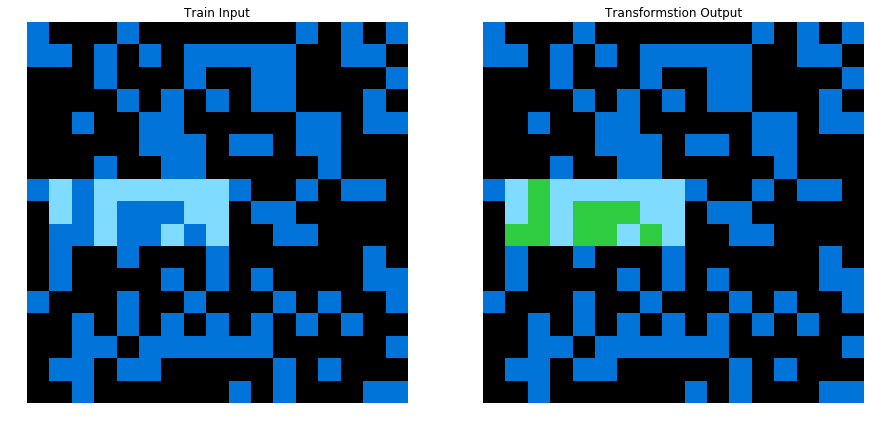

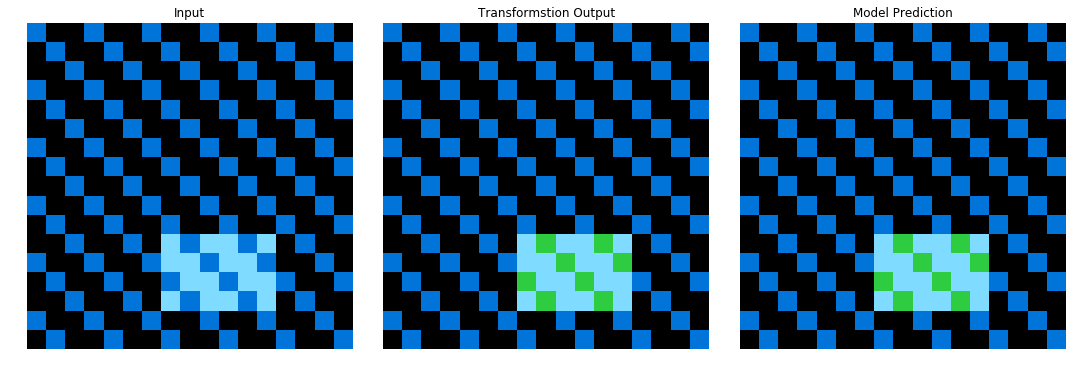

Made predictions for  3345333e
ensemble accuracy 0.8125



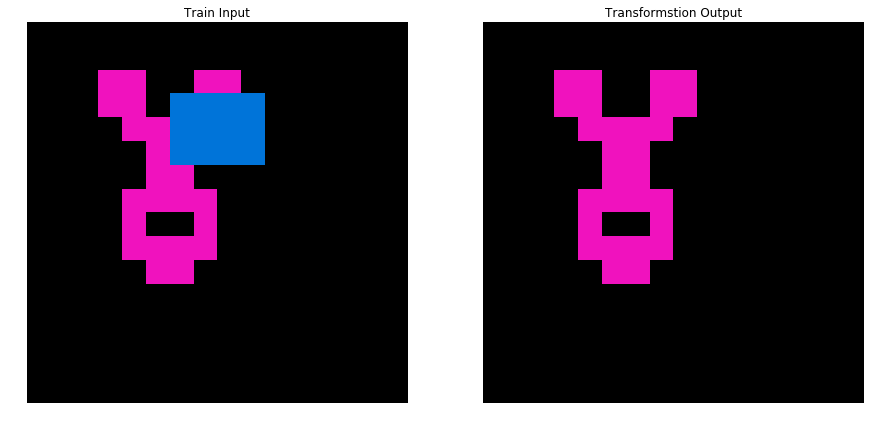

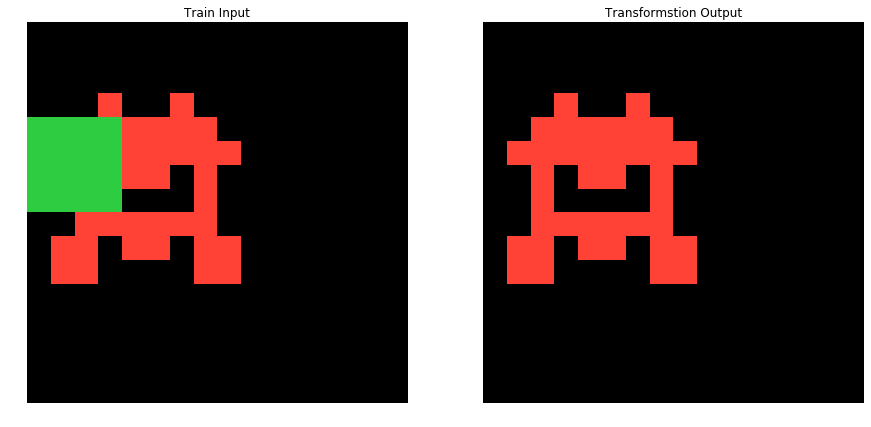

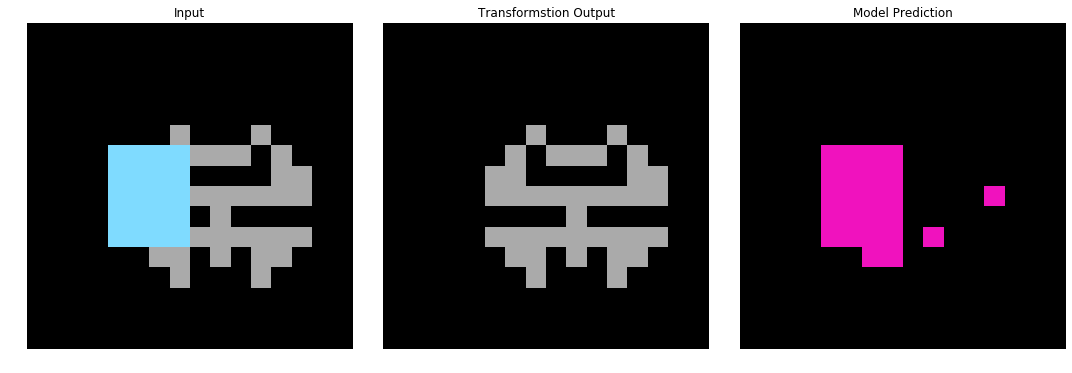

Number of input rows: 13 cols: 5
Number of target rows: 6 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/3428a4f5.json

Made predictions for  3618c87e
ensemble accuracy 1.0
3618c87e.json



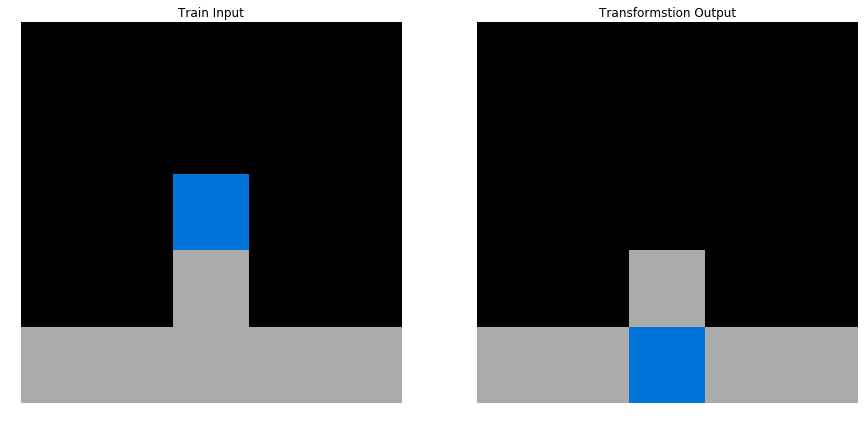

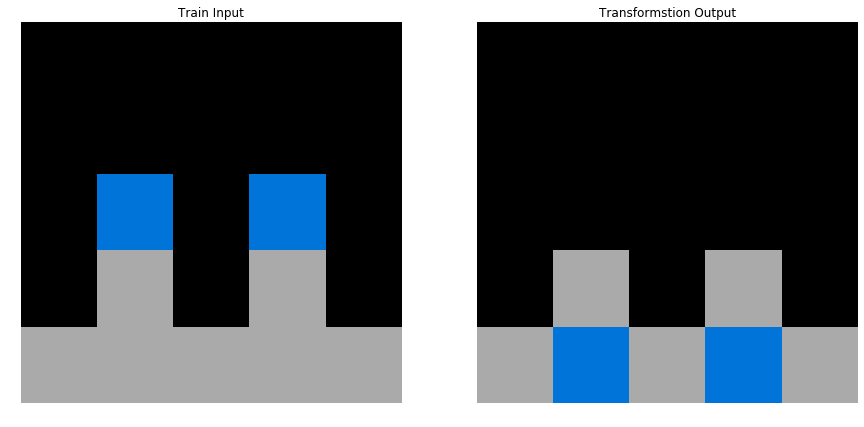

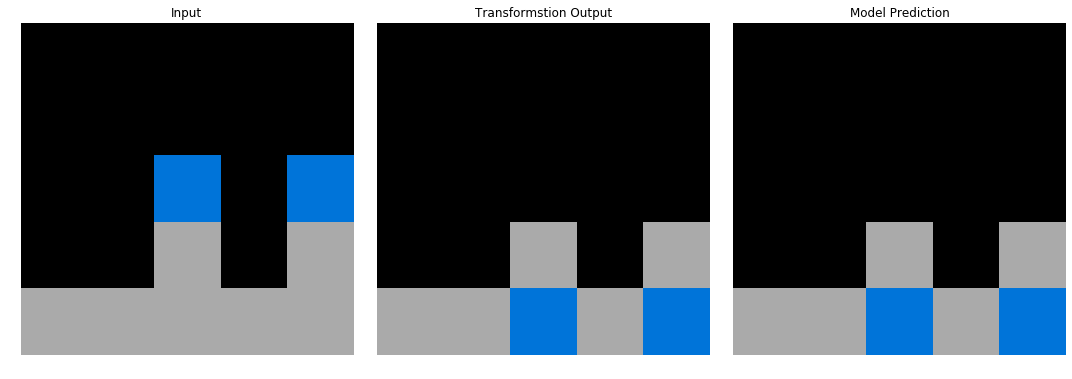

Made predictions for  3631a71a
ensemble accuracy 0.96
3631a71a.json



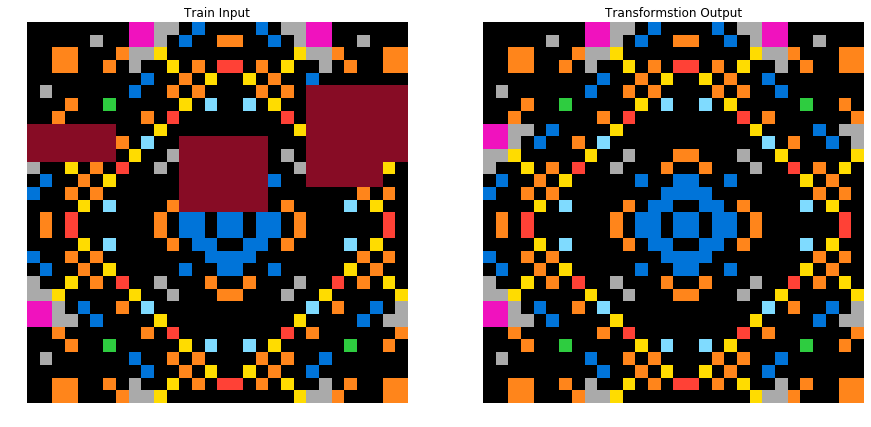

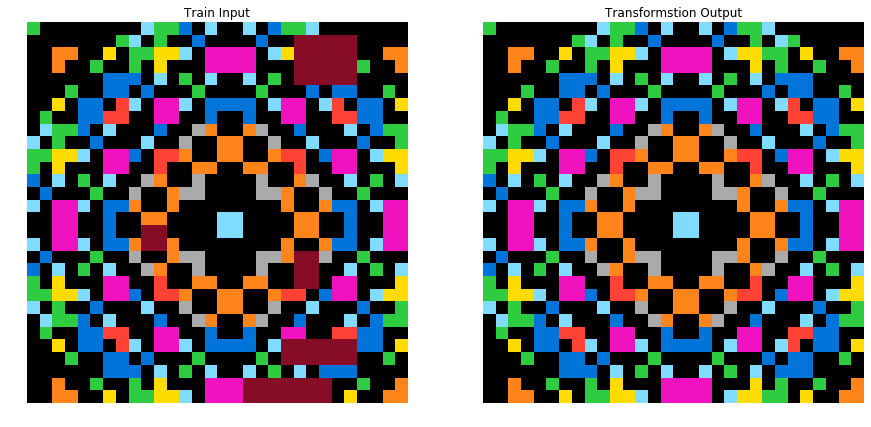

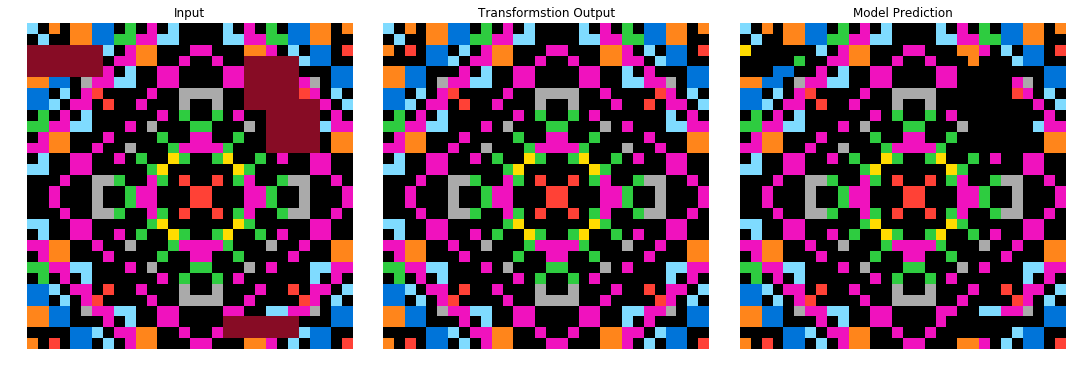

Made predictions for  363442ee
ensemble accuracy 0.5299145299145299



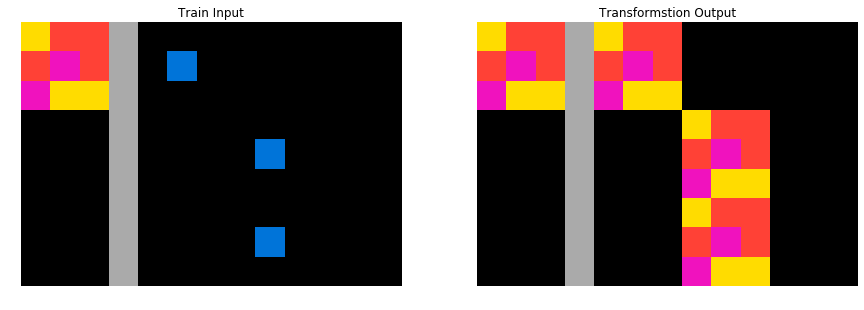

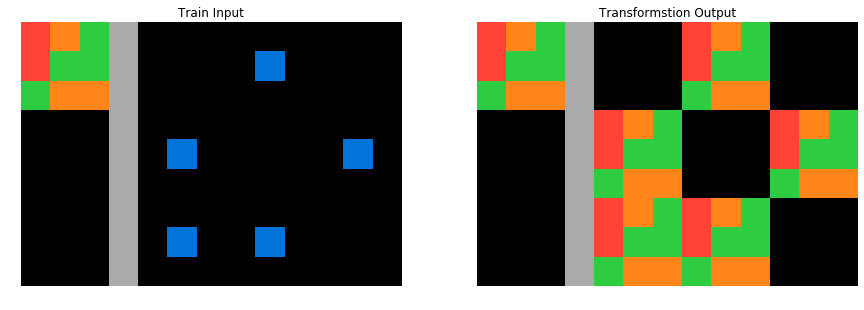

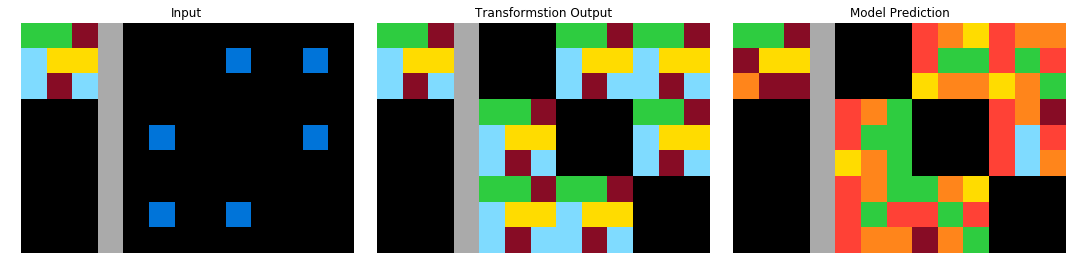

Made predictions for  36d67576
ensemble accuracy 0.9142857142857143



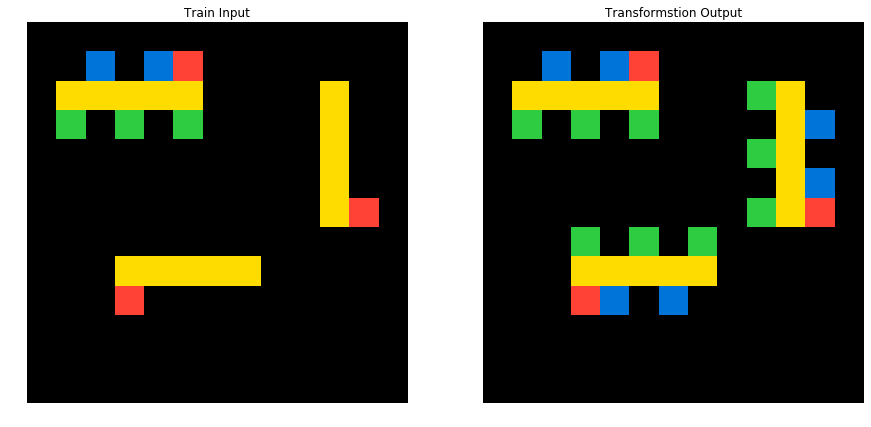

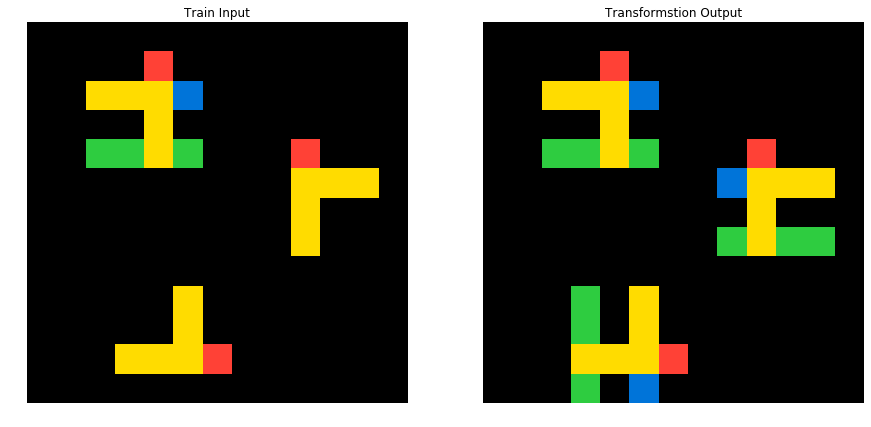

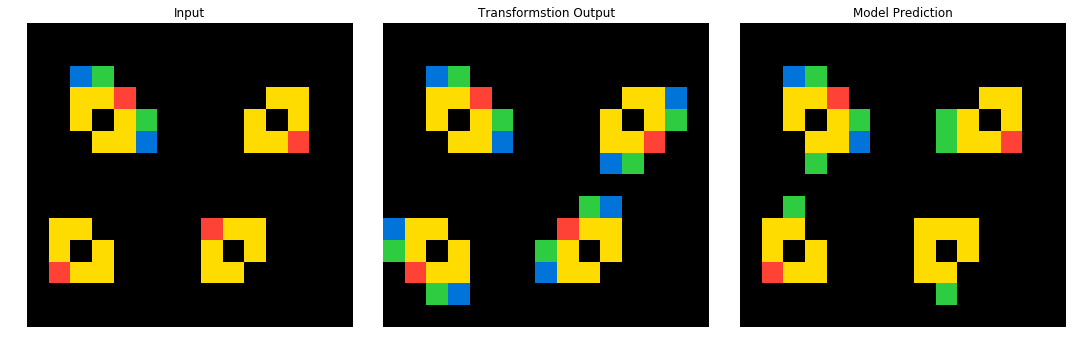

Made predictions for  36fdfd69
ensemble accuracy 0.5947712418300654



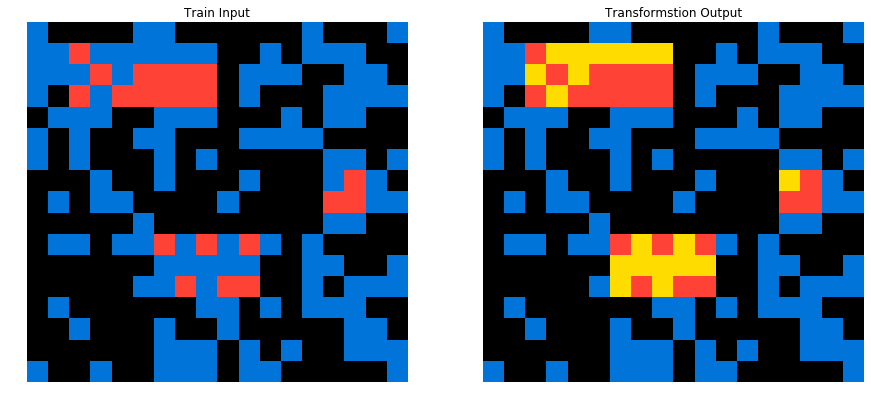

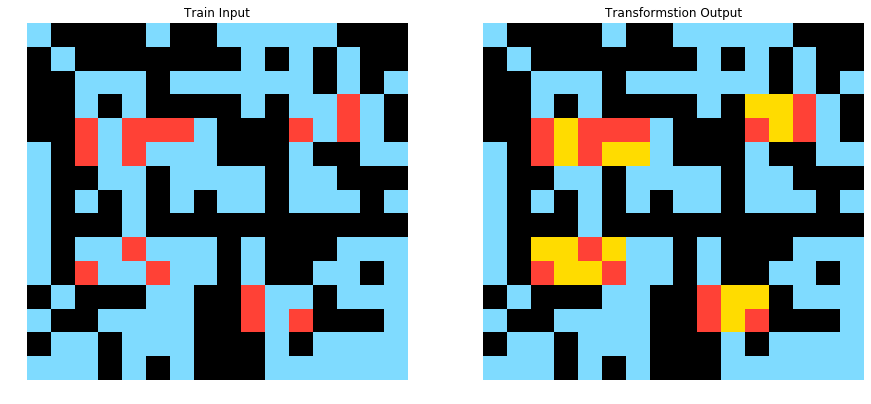

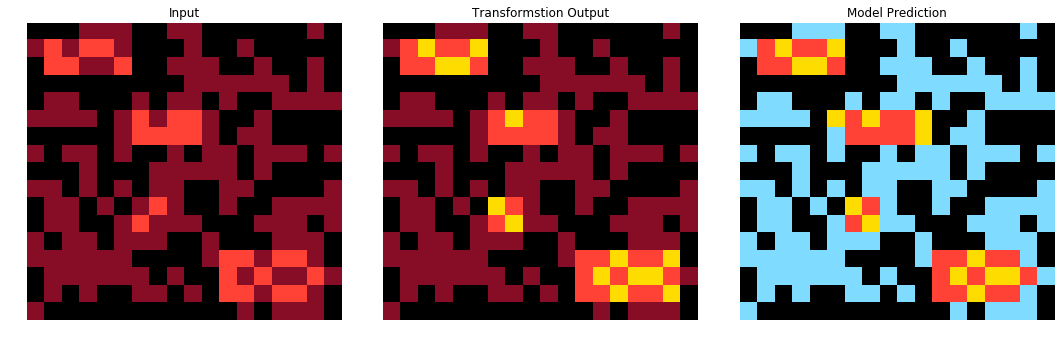

Made predictions for  3906de3d
ensemble accuracy 0.9



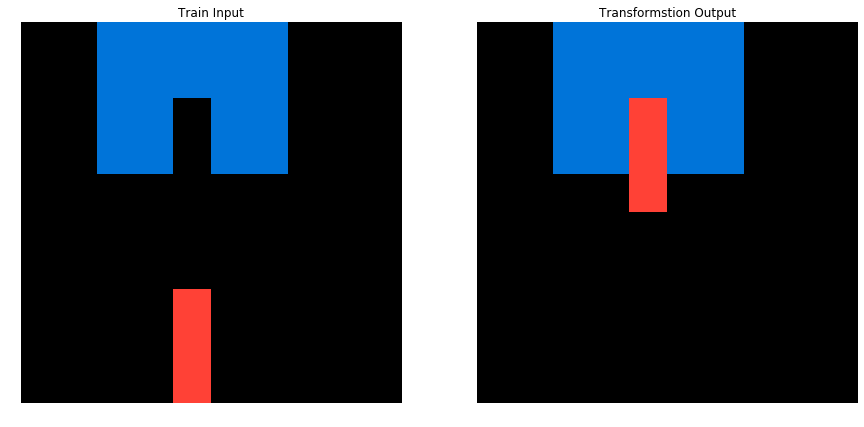

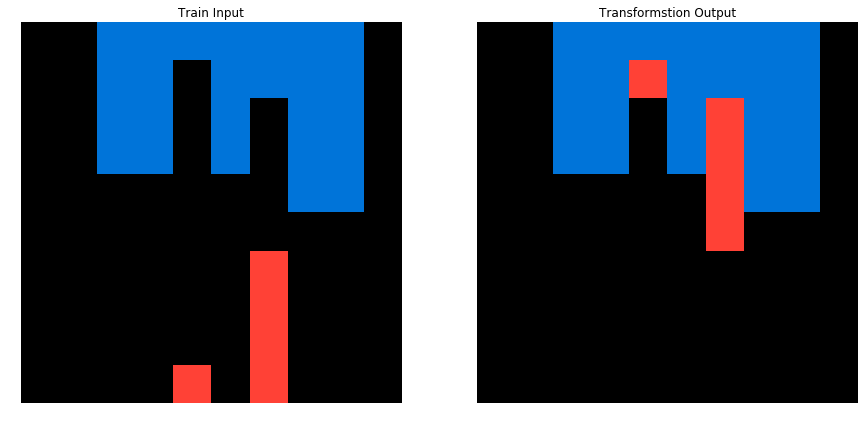

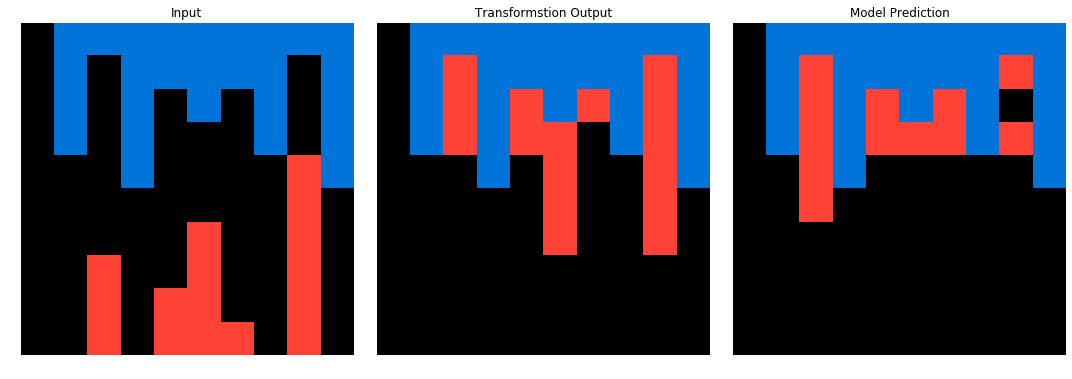

Number of input rows: 14 cols: 14
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/39a8645d.json

Made predictions for  39e1d7f9
ensemble accuracy 0.8953626634958383



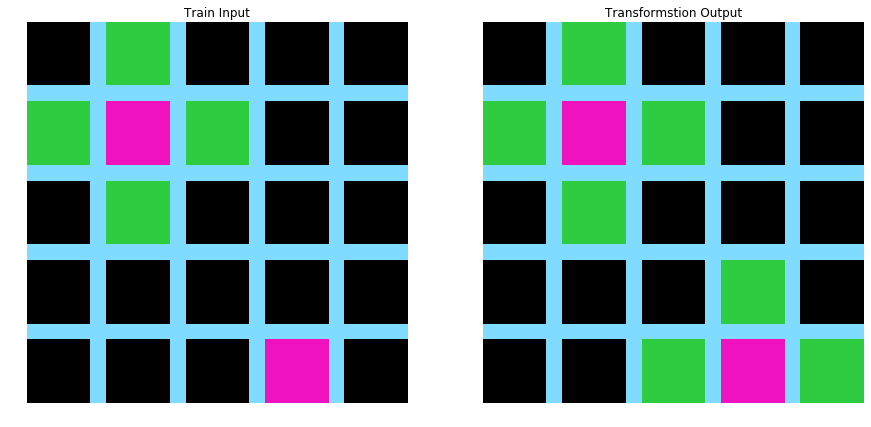

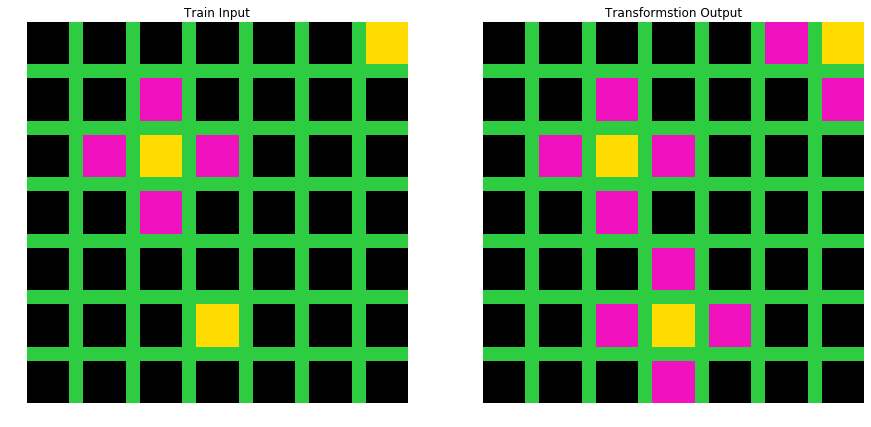

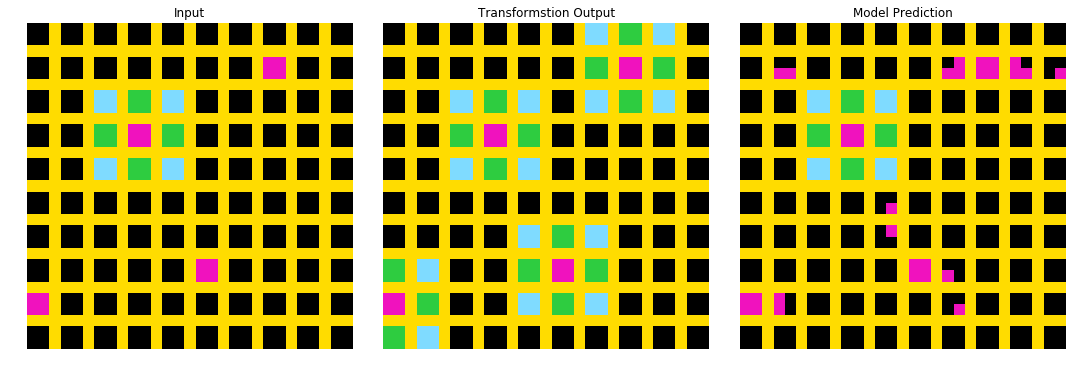

Made predictions for  3aa6fb7a
ensemble accuracy 1.0
3aa6fb7a.json



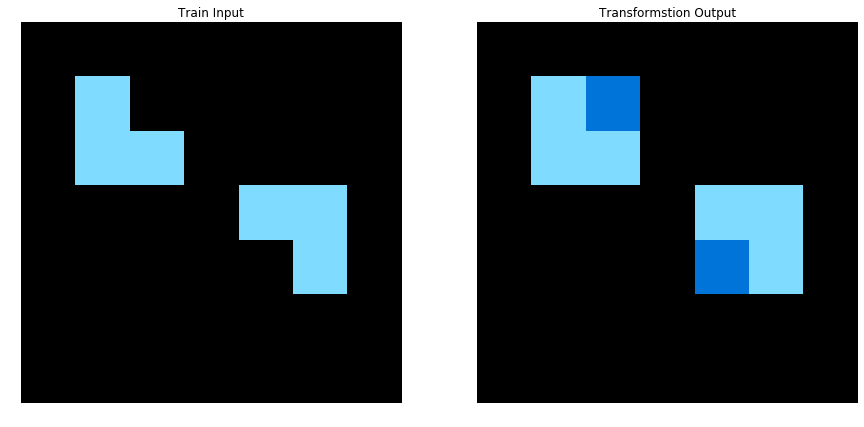

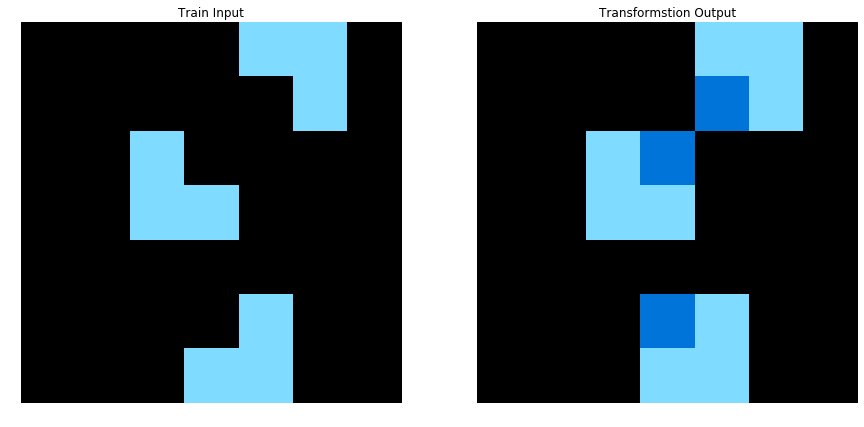

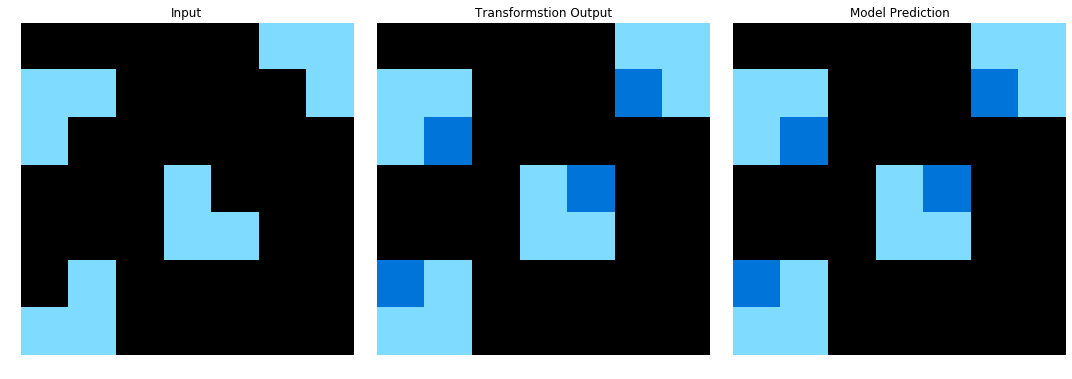

Made predictions for  3ac3eb23
ensemble accuracy 0.4722222222222222



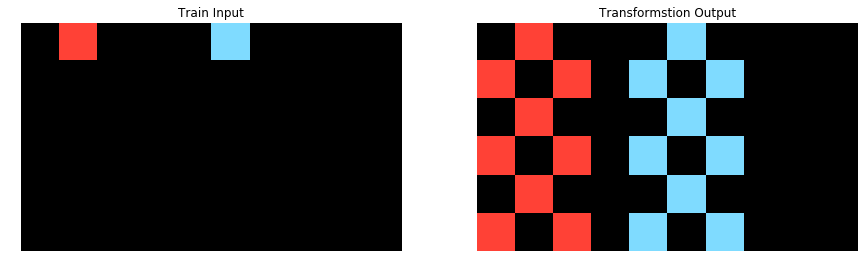

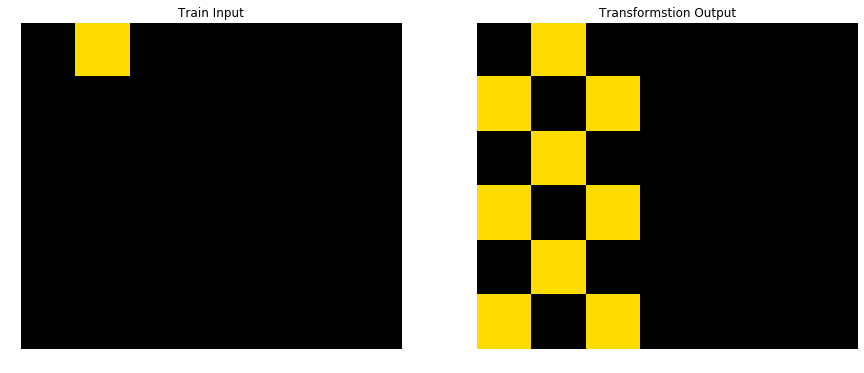

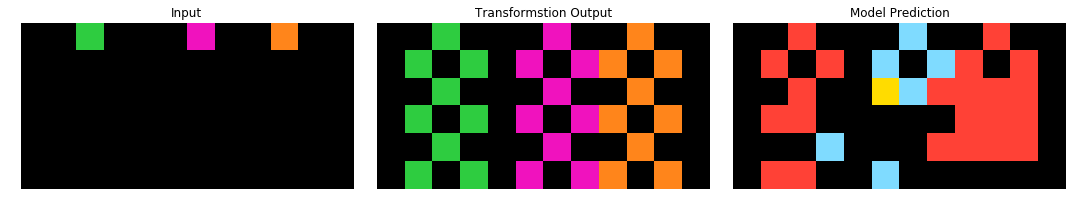

Number of input rows: 3 cols: 4
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/3af2c5a8.json

Made predictions for  3bd67248
ensemble accuracy 0.73



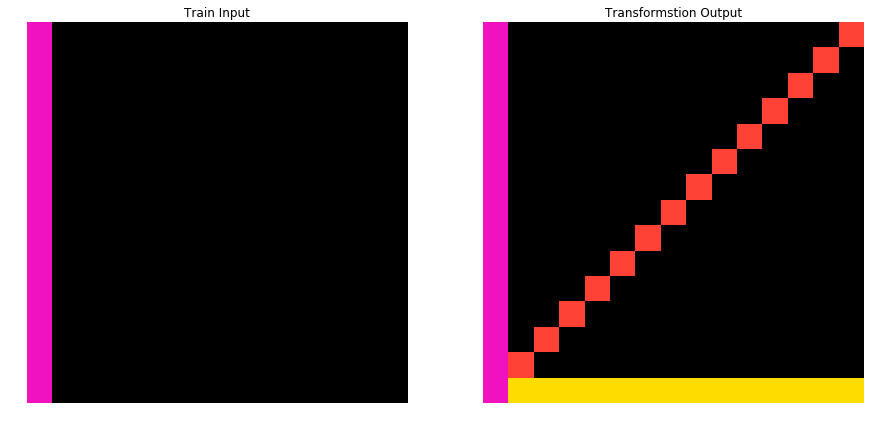

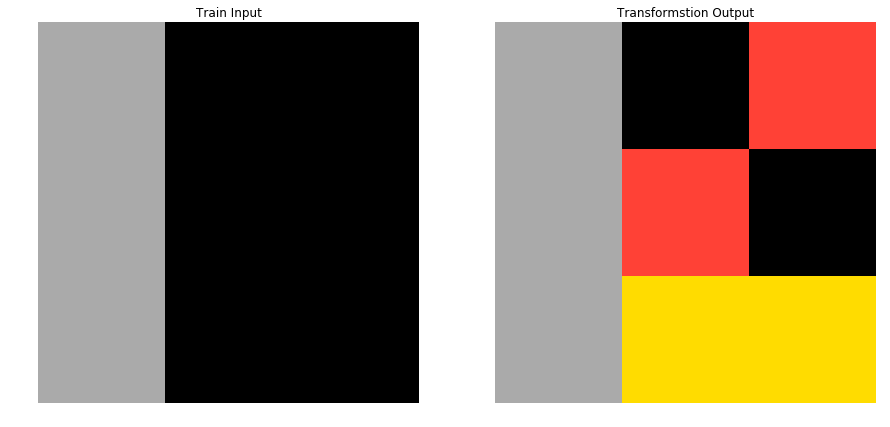

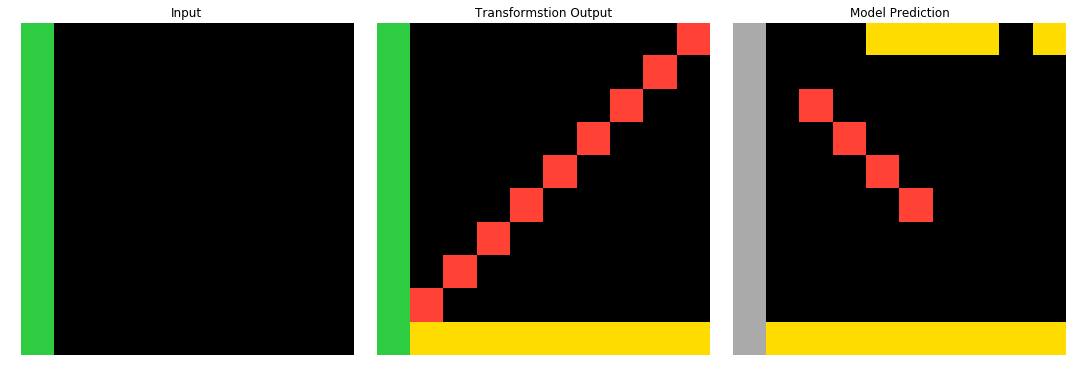

Made predictions for  3bdb4ada
ensemble accuracy 0.8909090909090909



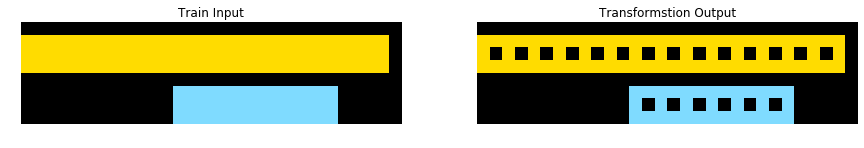

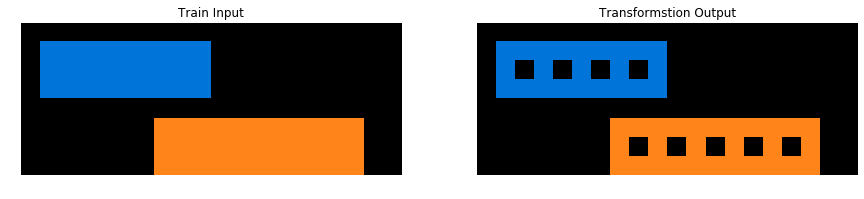

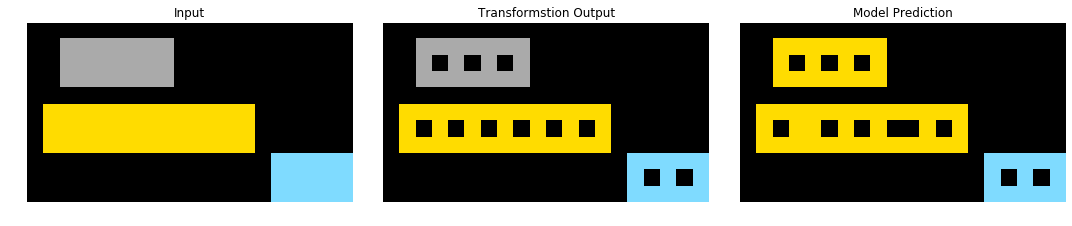

Made predictions for  3befdf3e
ensemble accuracy 0.5208333333333334



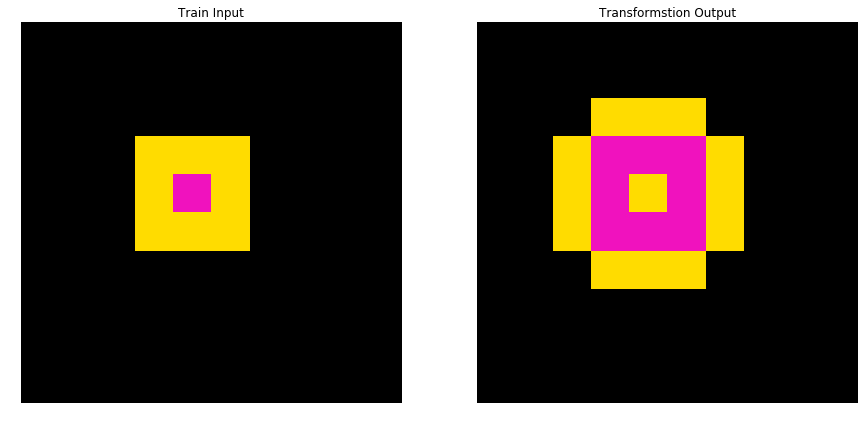

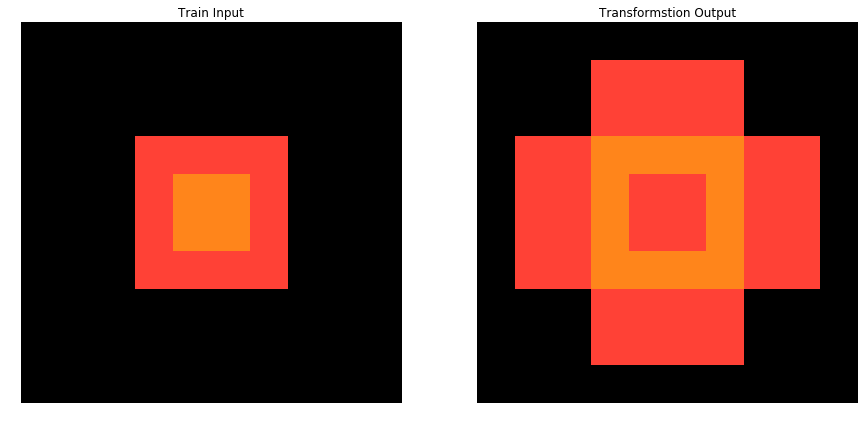

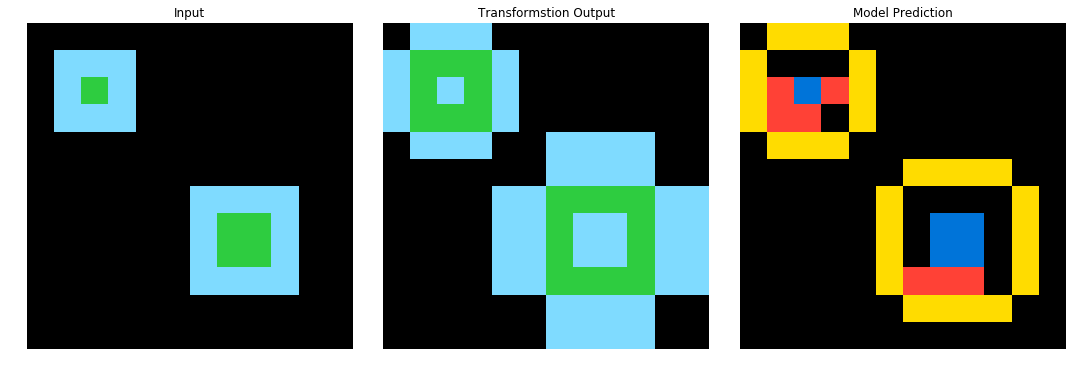

Made predictions for  3c9b0459
ensemble accuracy 0.0



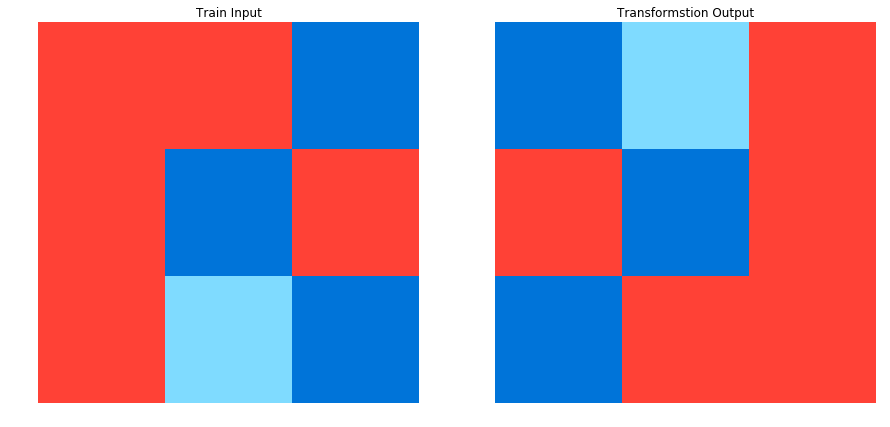

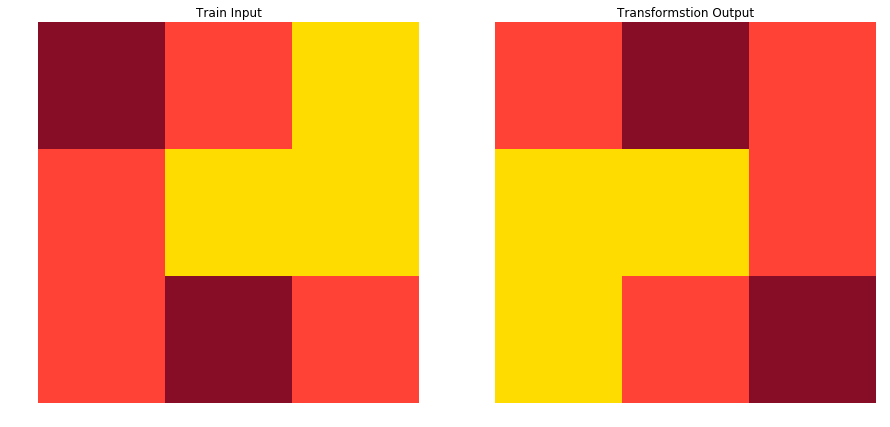

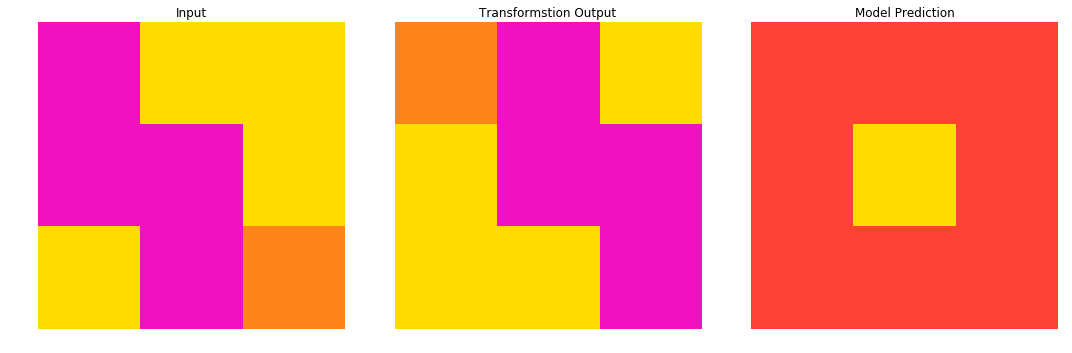

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/3de23699.json

Made predictions for  3e980e27
ensemble accuracy 0.863905325443787



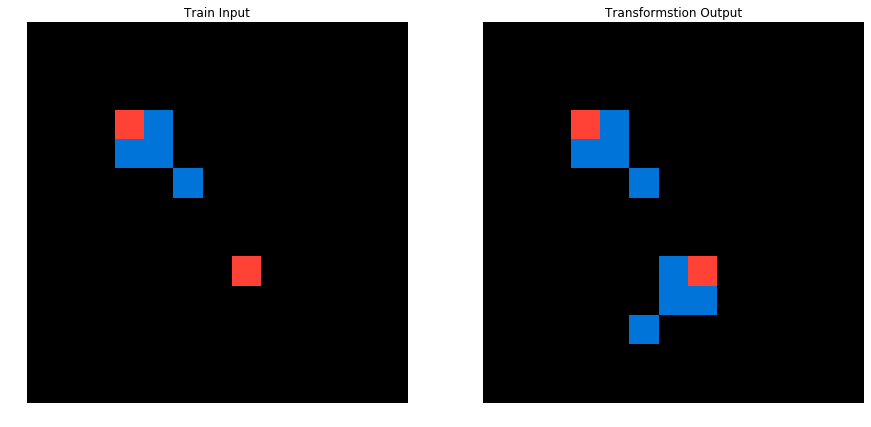

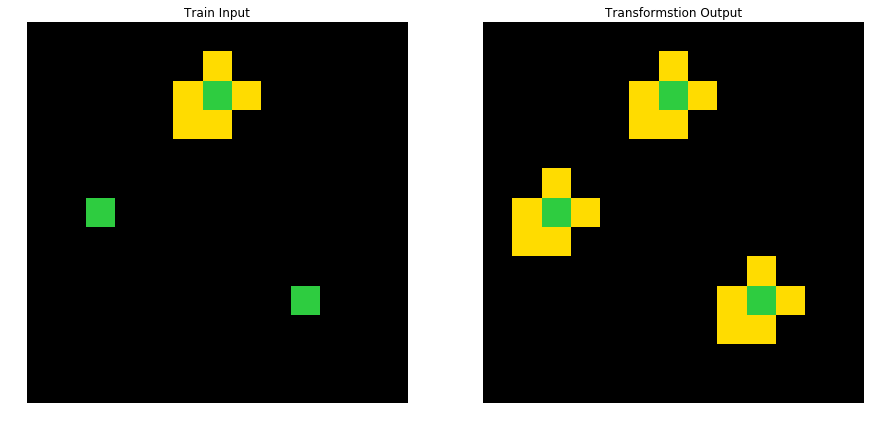

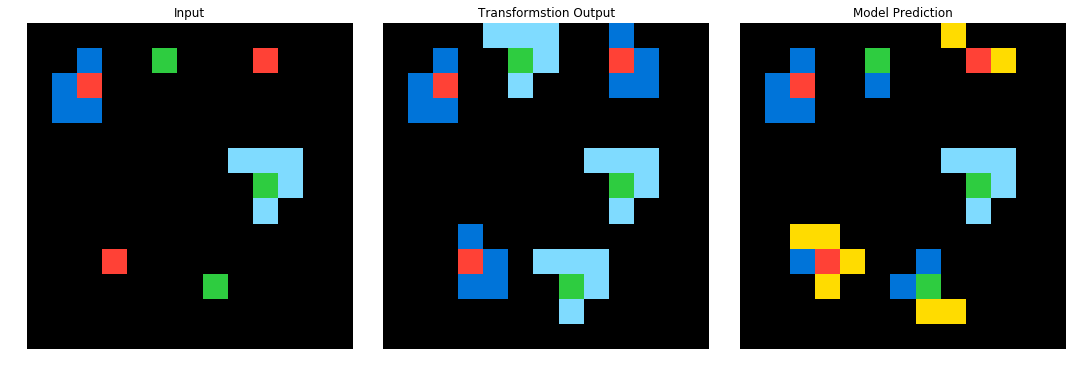

Made predictions for  3eda0437
ensemble accuracy 0.9479166666666666



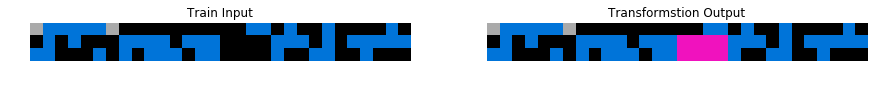

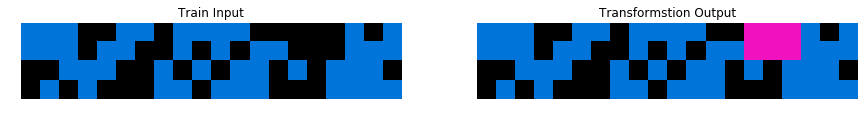

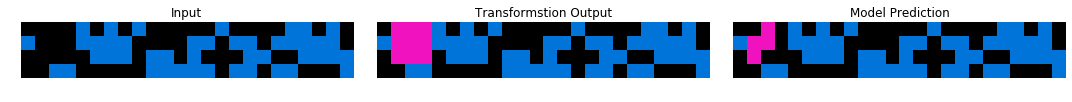

Number of input rows: 9 cols: 9
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/3f7978a0.json

Made predictions for  40853293
ensemble accuracy 0.875



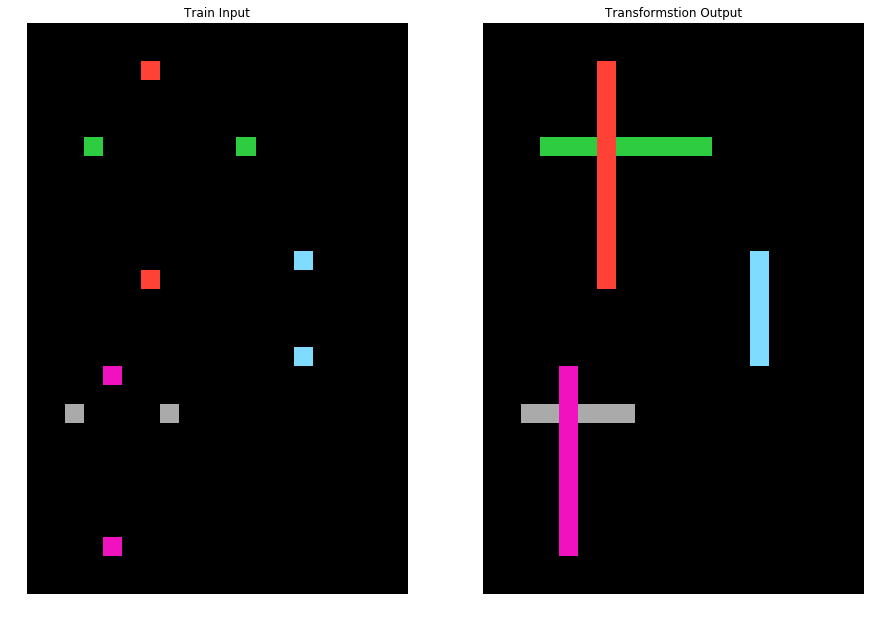

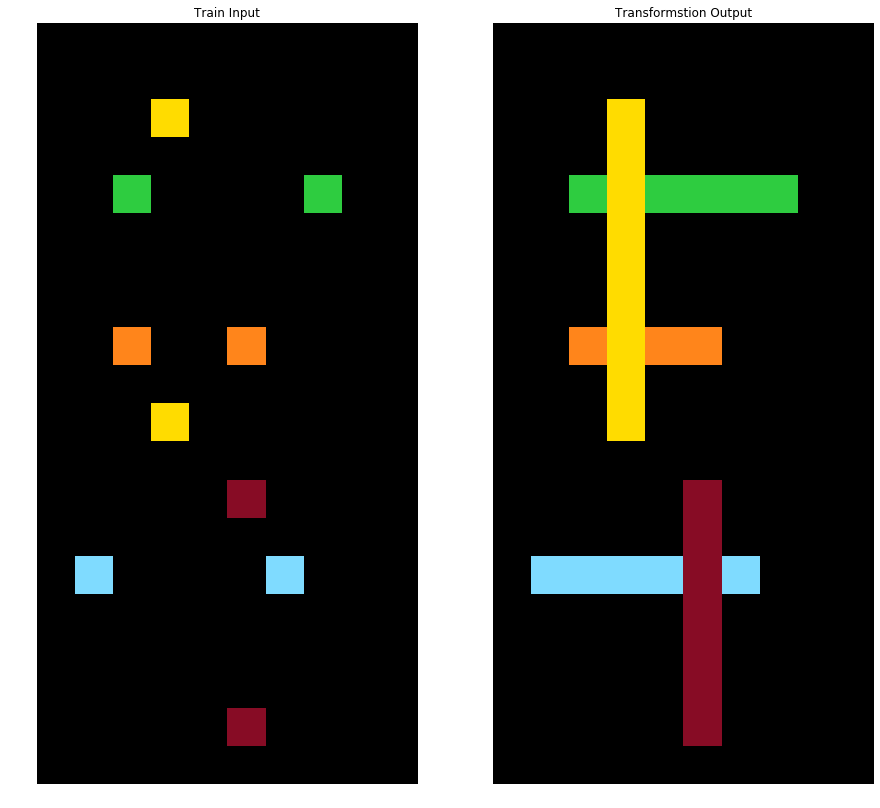

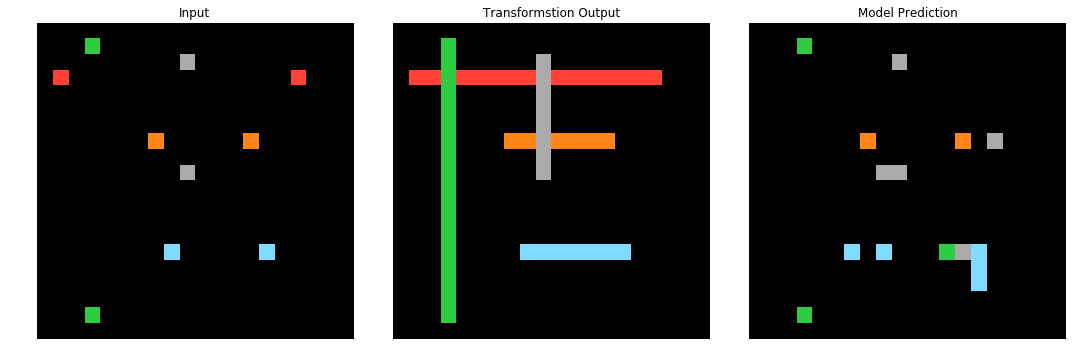

Made predictions for  4093f84a
ensemble accuracy 0.923469387755102



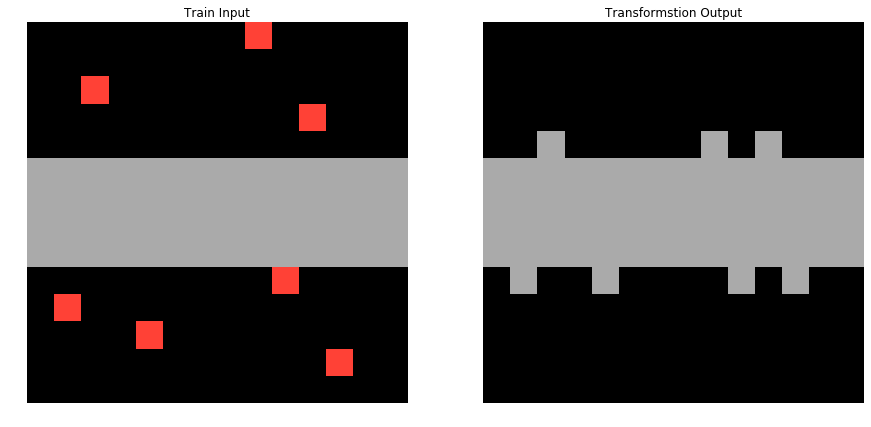

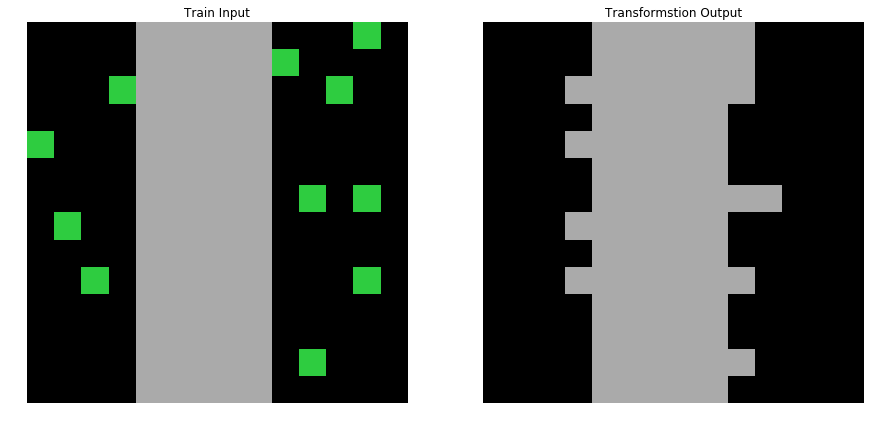

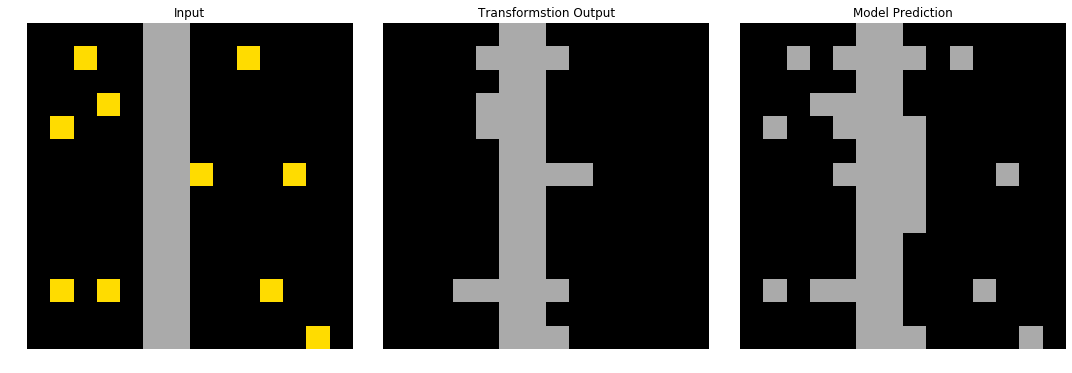

Made predictions for  41e4d17e
ensemble accuracy 0.8755555555555555



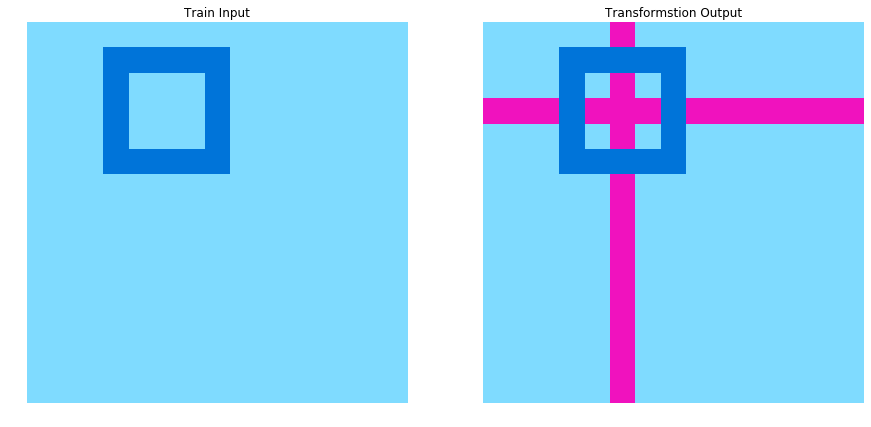

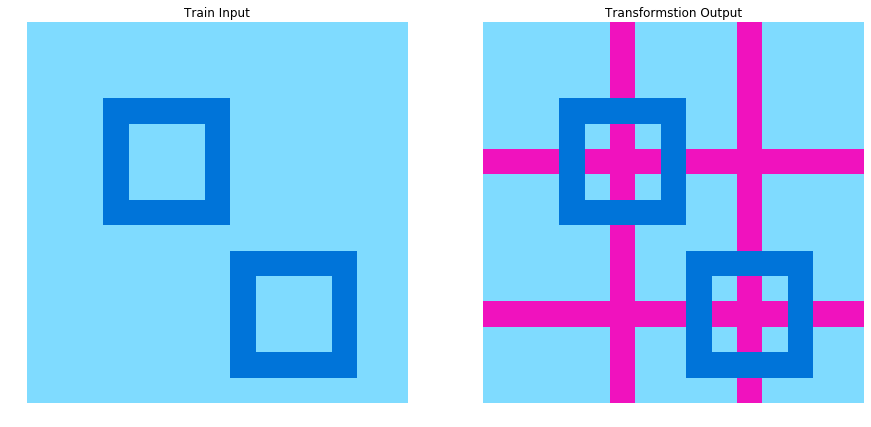

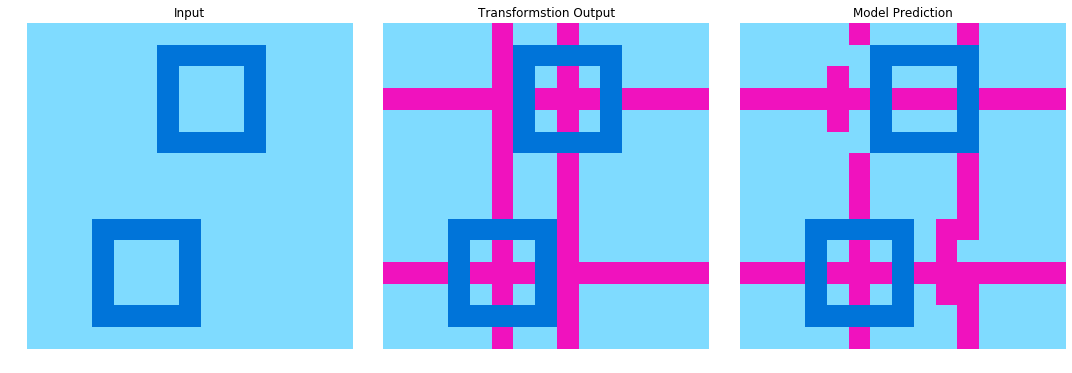

Made predictions for  4258a5f9
ensemble accuracy 1.0
4258a5f9.json



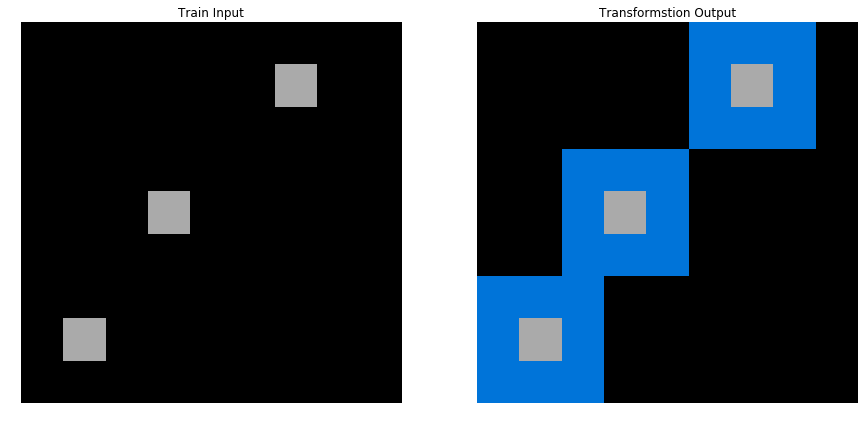

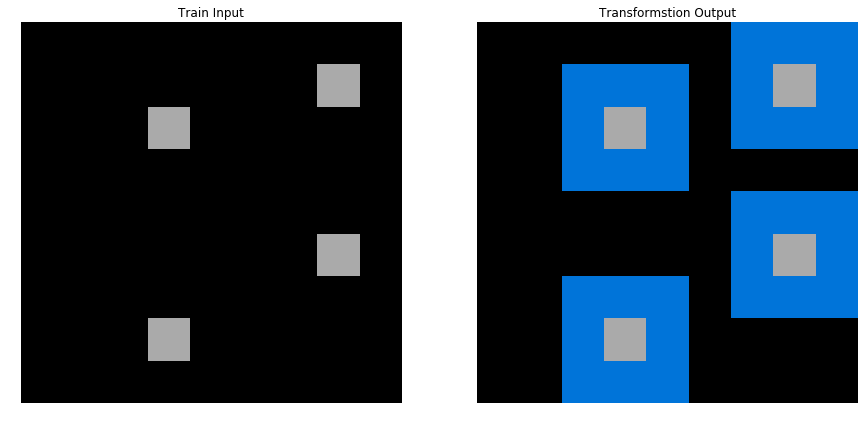

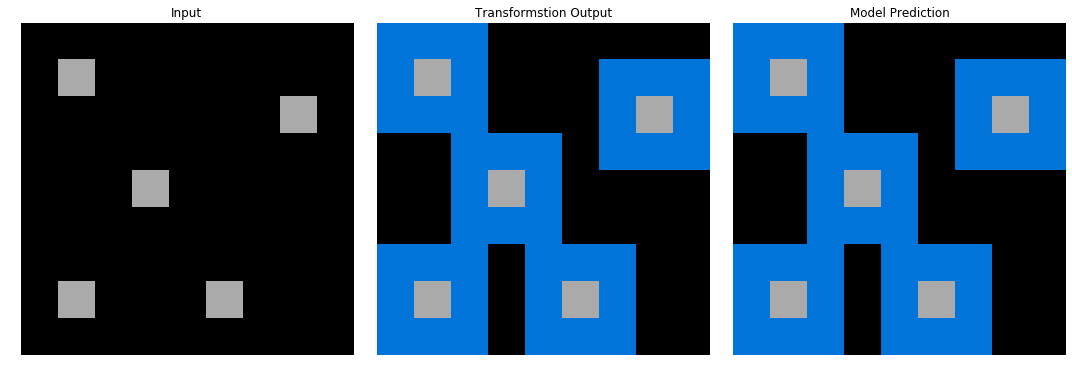

Number of input rows: 13 cols: 17
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/4290ef0e.json

Made predictions for  42a50994
ensemble accuracy 0.8109243697478992



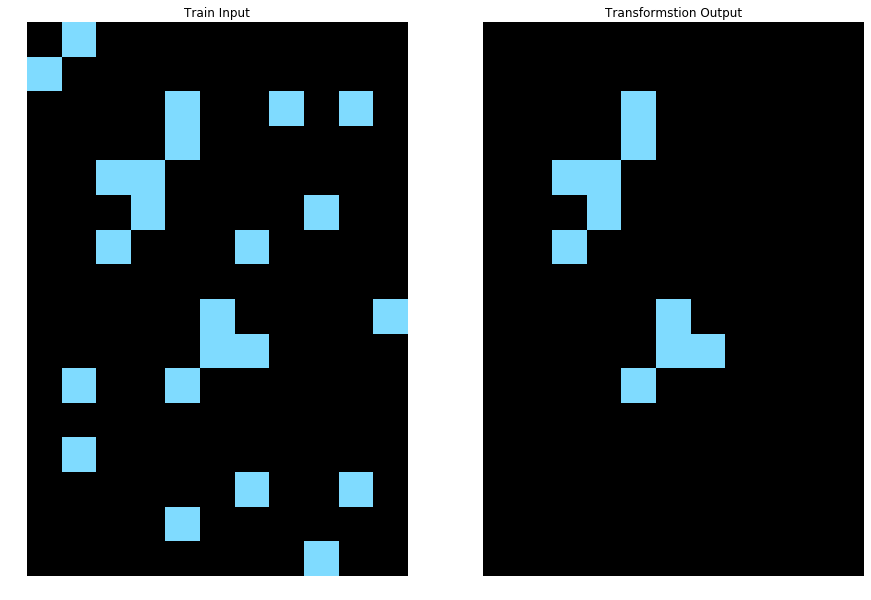

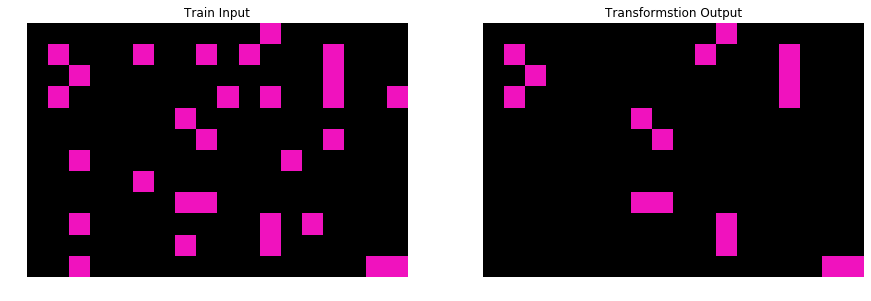

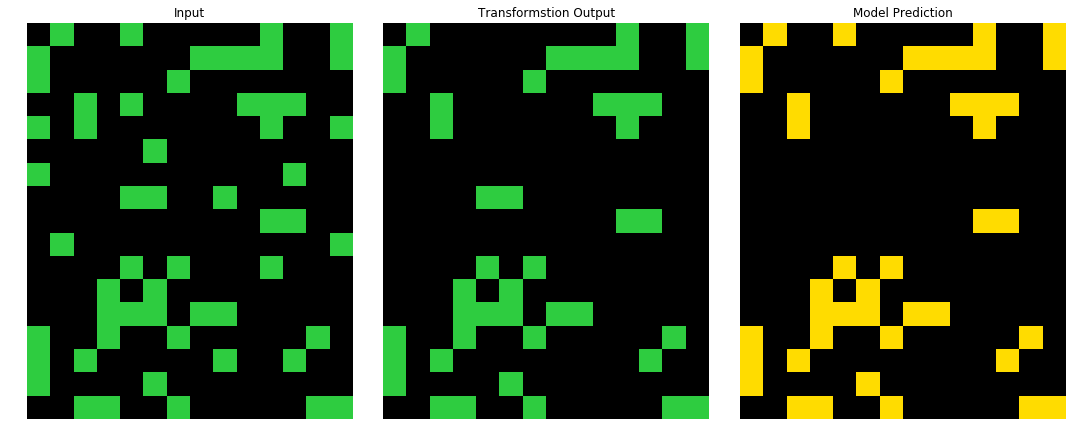

Made predictions for  4347f46a
ensemble accuracy 0.9256965944272446



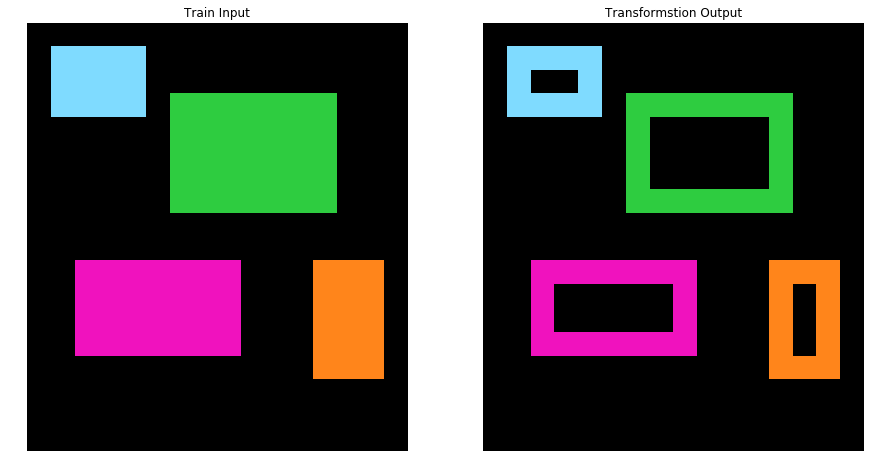

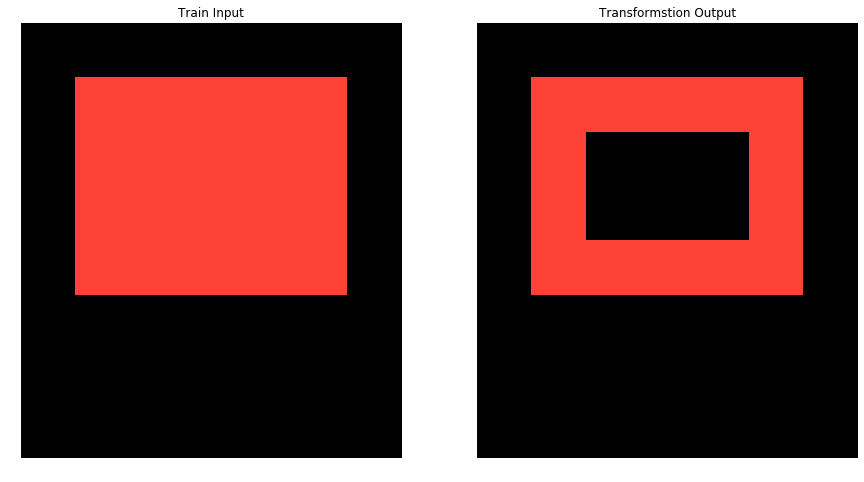

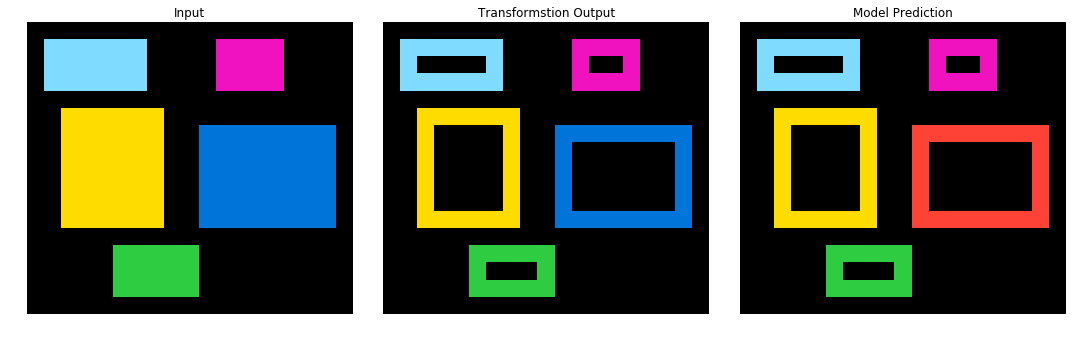

Made predictions for  444801d8
ensemble accuracy 0.74



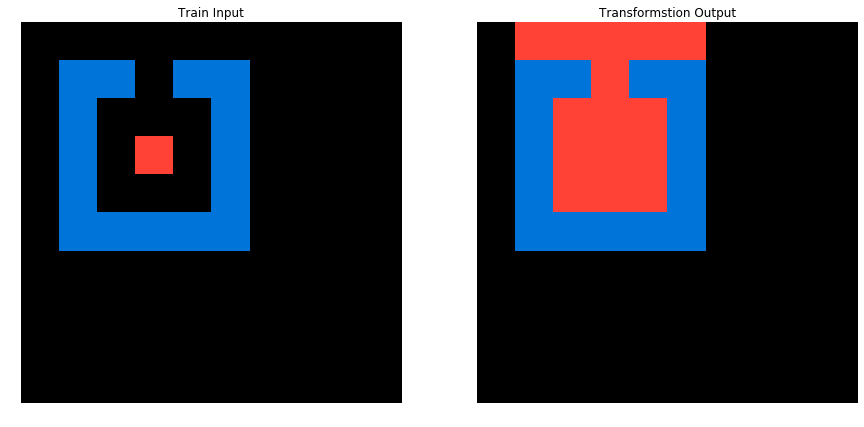

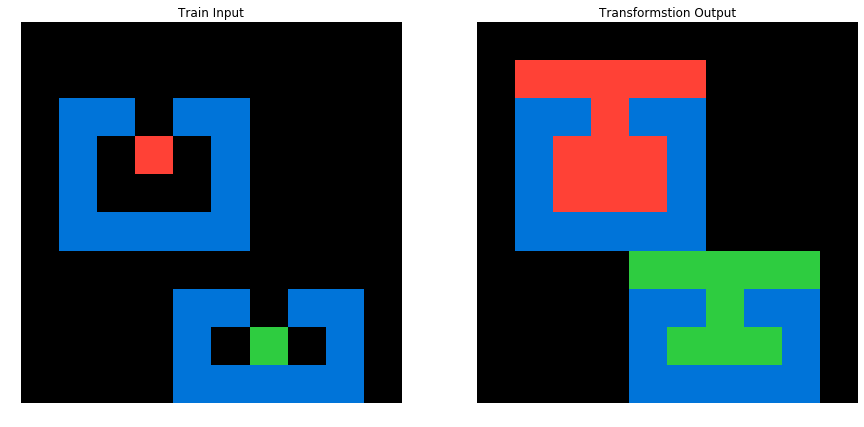

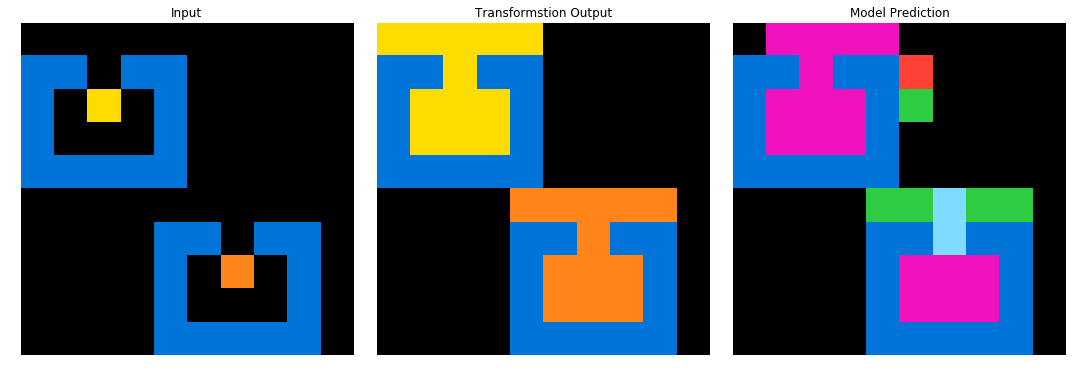

Number of input rows: 10 cols: 10
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/445eab21.json

Made predictions for  447fd412
ensemble accuracy 0.7815126050420168



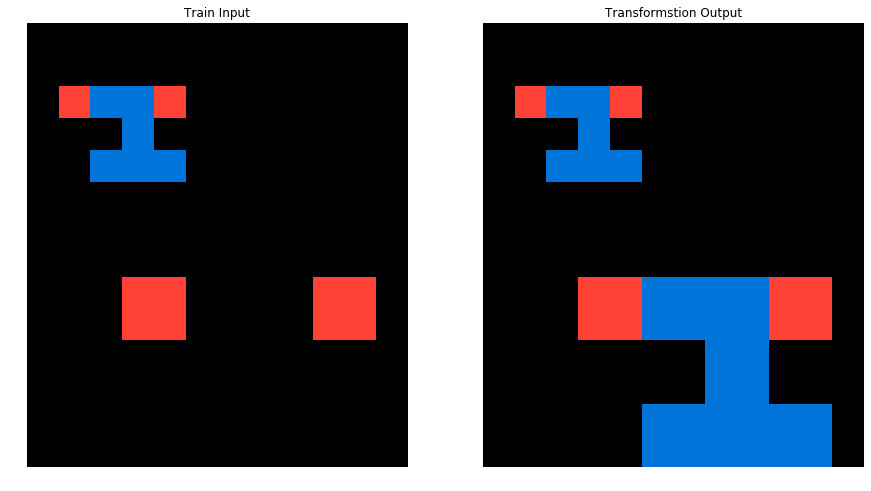

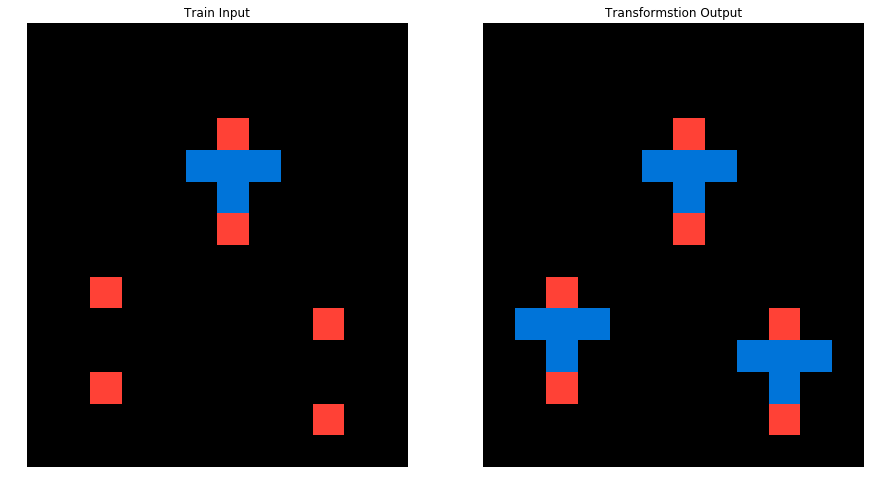

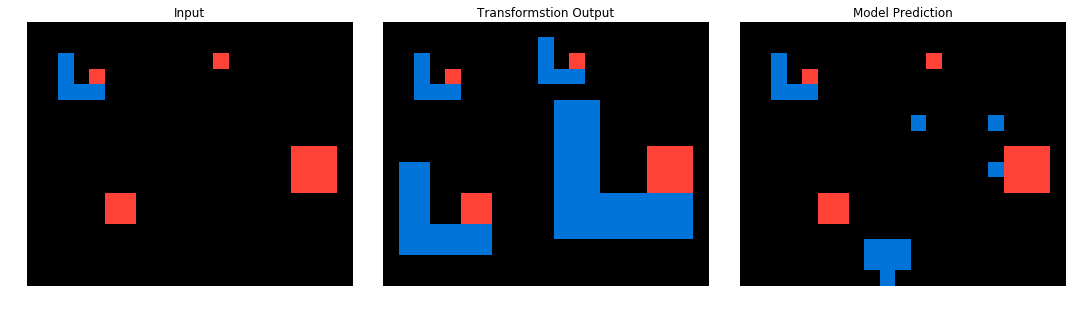

Made predictions for  44d8ac46
ensemble accuracy 0.9236111111111112



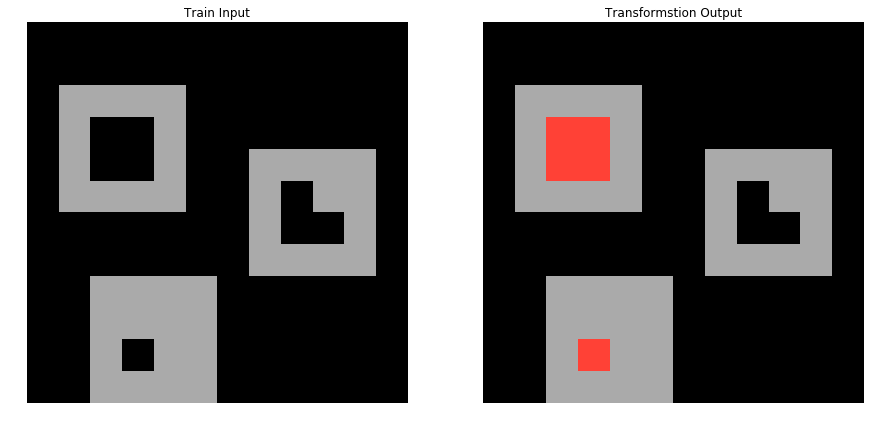

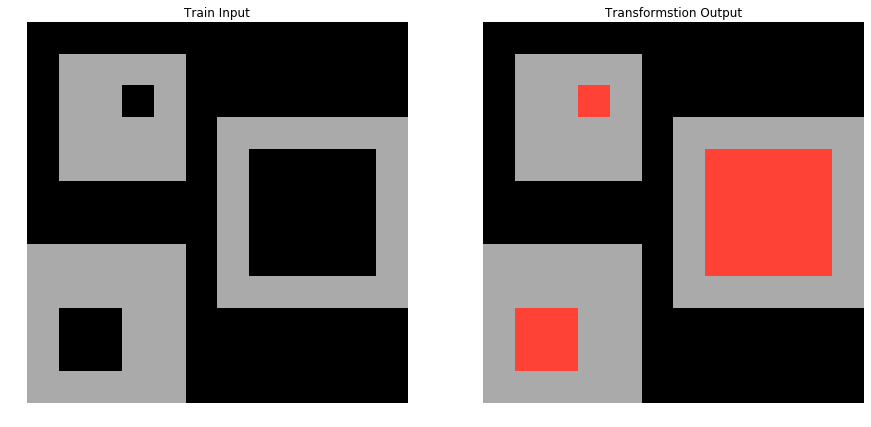

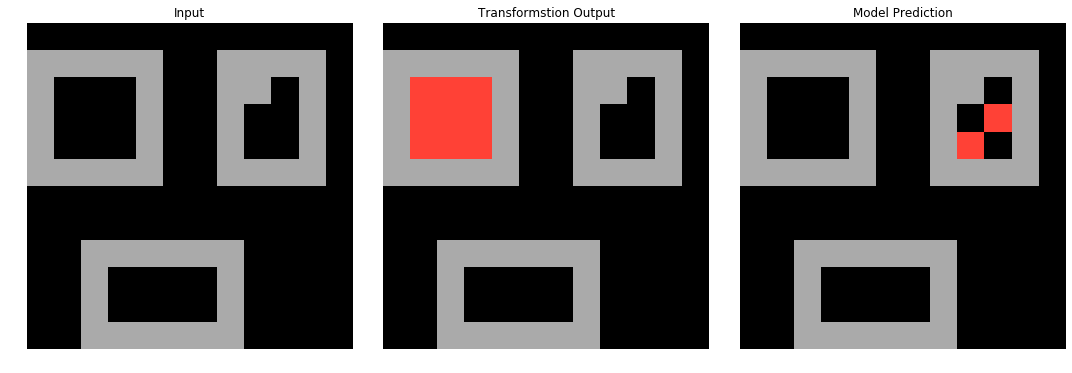

Number of input rows: 3 cols: 3
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/44f52bb0.json

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/4522001f.json

Made predictions for  4612dd53
ensemble accuracy 1.0
4612dd53.json



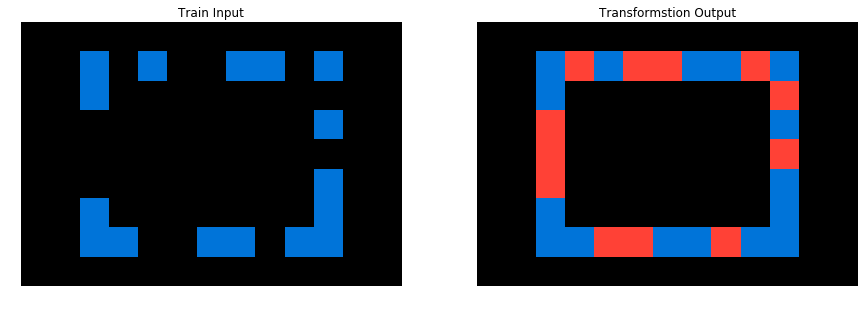

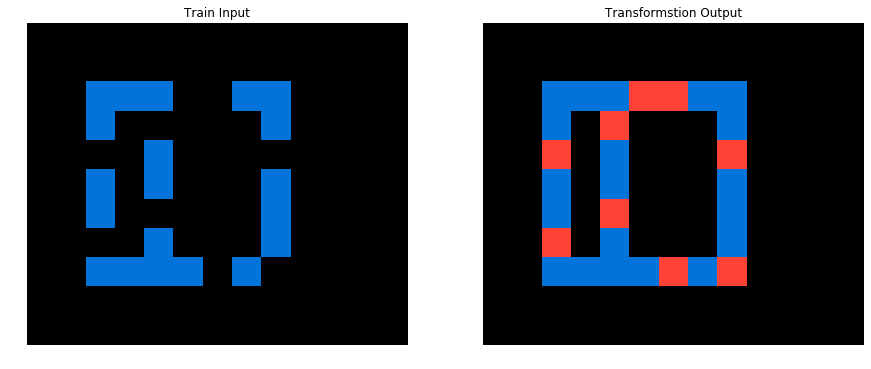

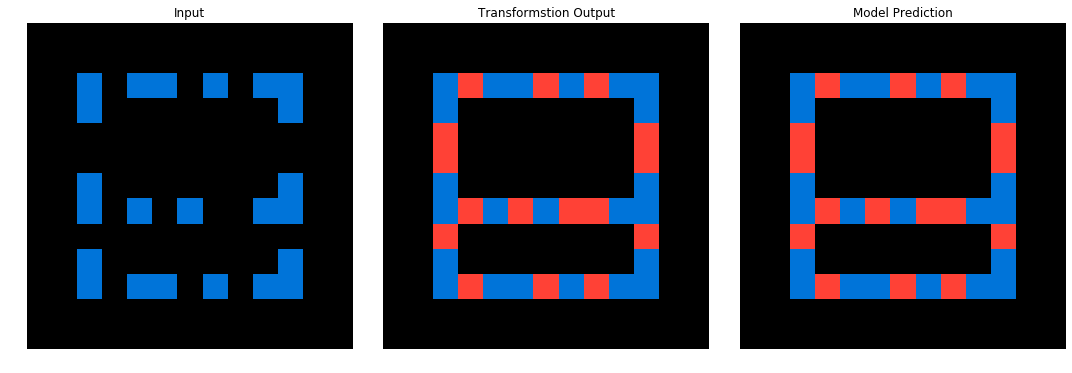

Number of input rows: 2 cols: 2
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/46442a0e.json

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/469497ad.json

Number of input rows: 10 cols: 10
Number of target rows: 20 cols: 20
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/46f33fce.json

Number of input rows: 11 cols: 11
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/47c1f68c.json

Made predictions for  484b58aa
ensemble accuracy 0.8133174791914387



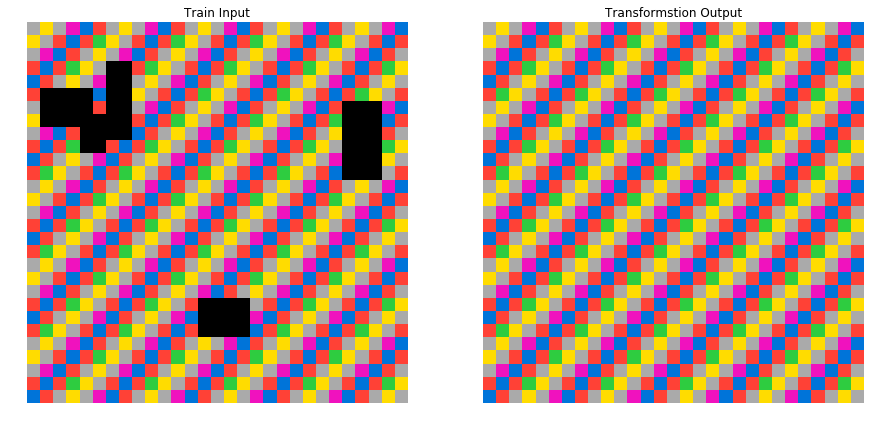

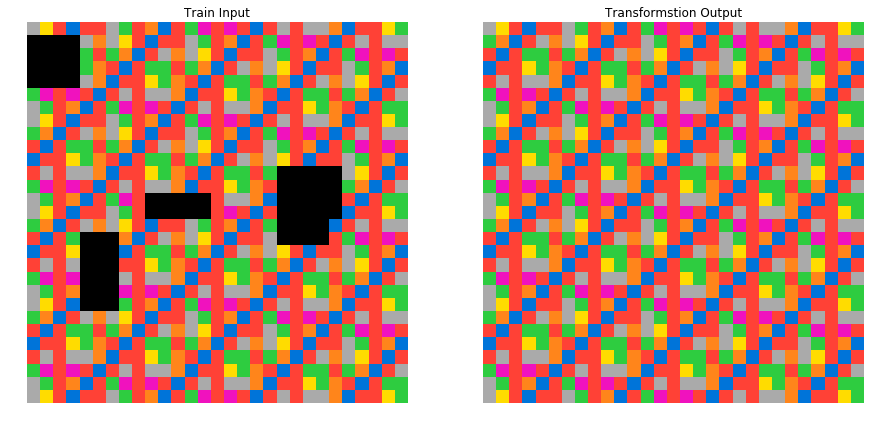

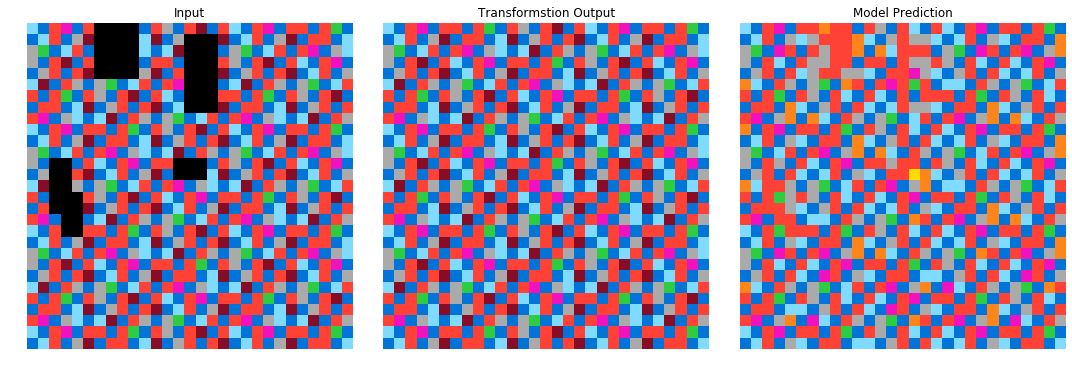

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/48d8fb45.json

Made predictions for  4938f0c2
ensemble accuracy 0.9087301587301587



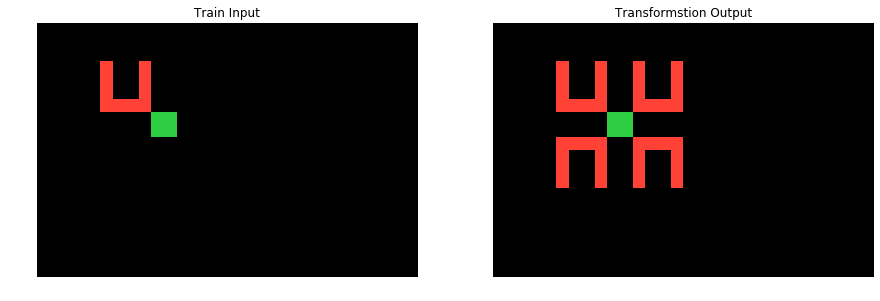

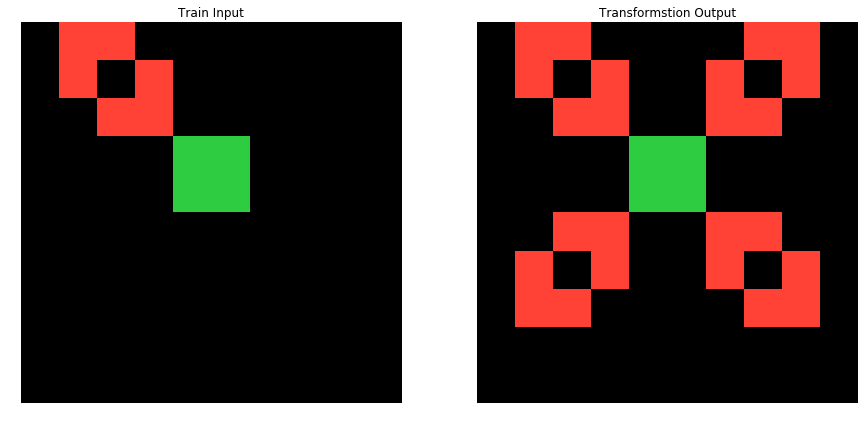

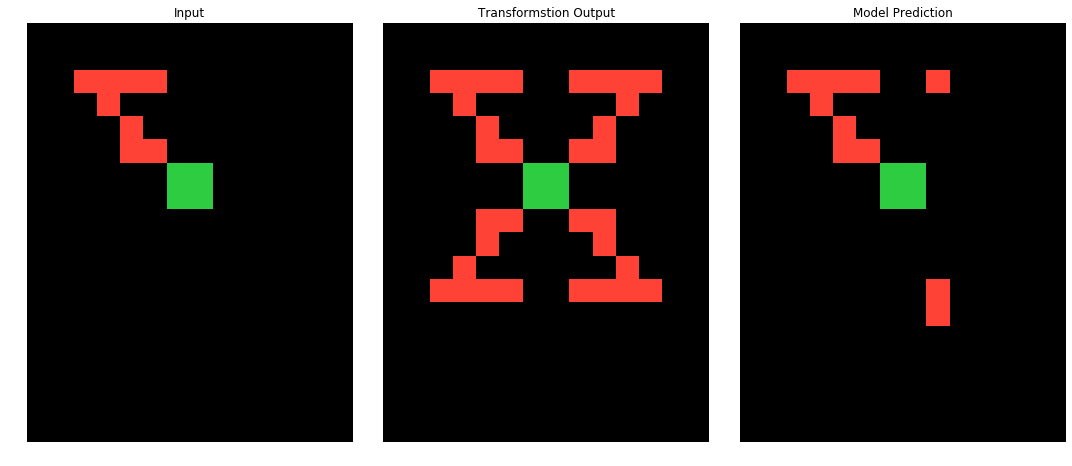

Made predictions for  496994bd
ensemble accuracy 0.5



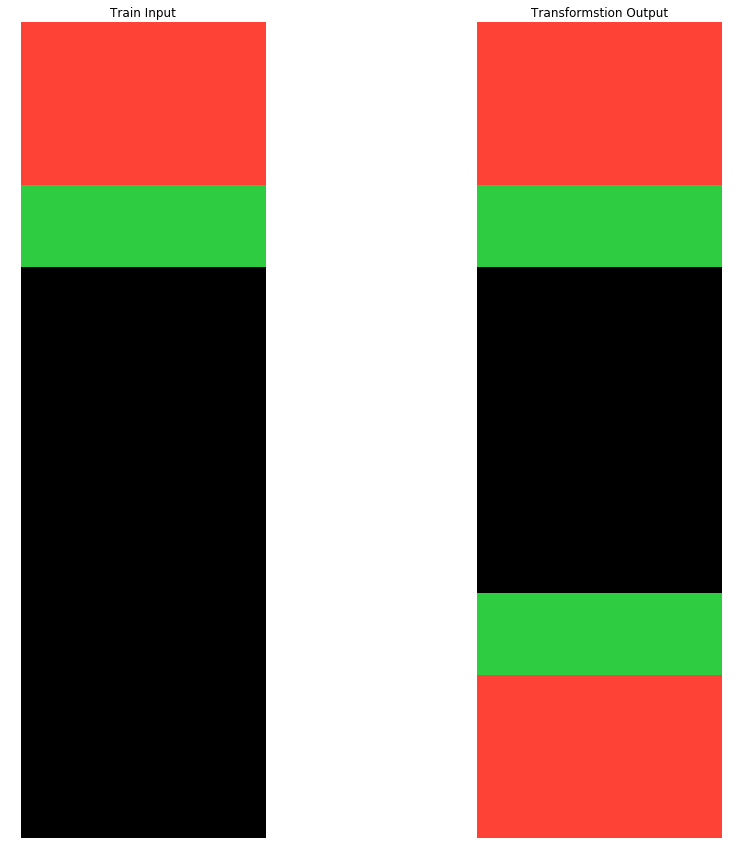

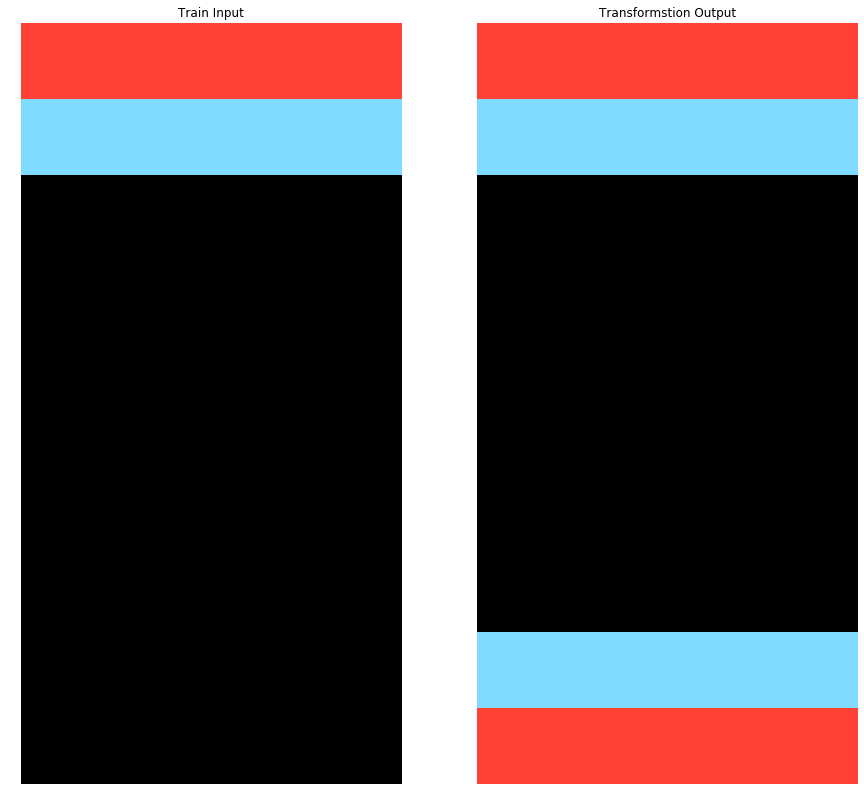

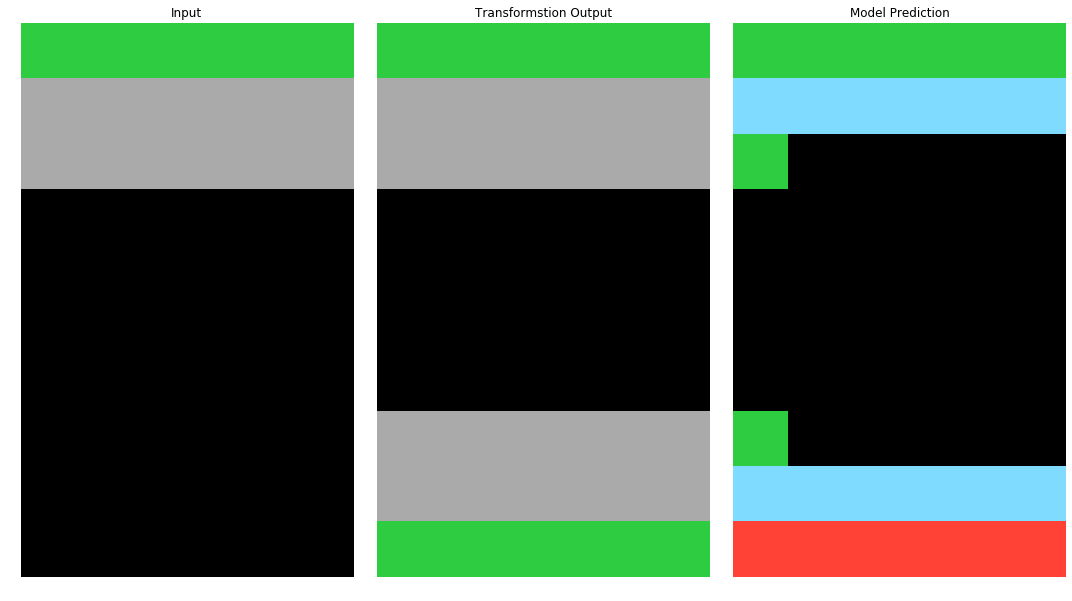

Number of input rows: 2 cols: 2
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/49d1d64f.json

Number of input rows: 14 cols: 16
Number of target rows: 1 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/4be741c5.json

Number of input rows: 3 cols: 4
Number of target rows: 6 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/4c4377d9.json

Made predictions for  4c5c2cf0
ensemble accuracy 0.7733333333333333



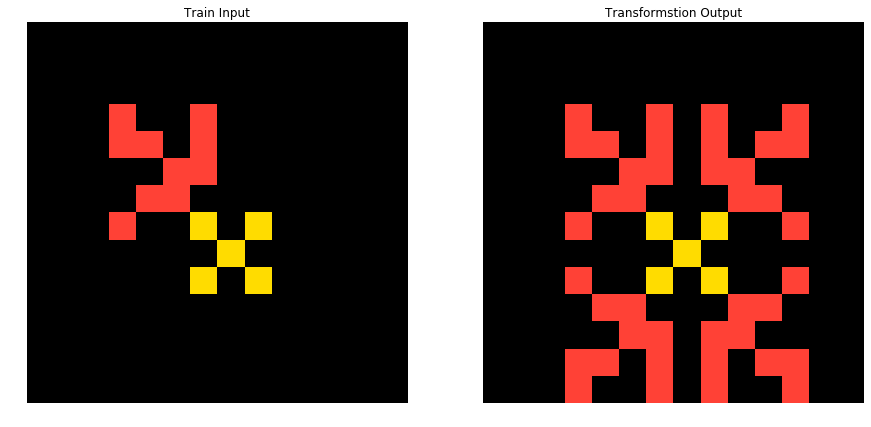

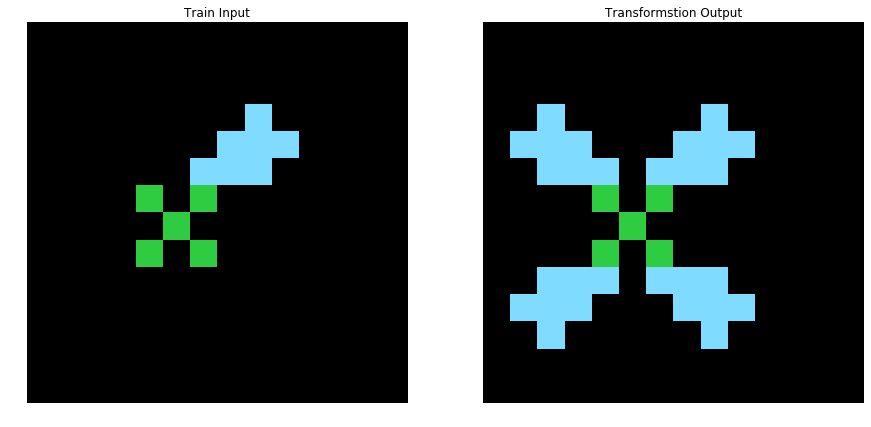

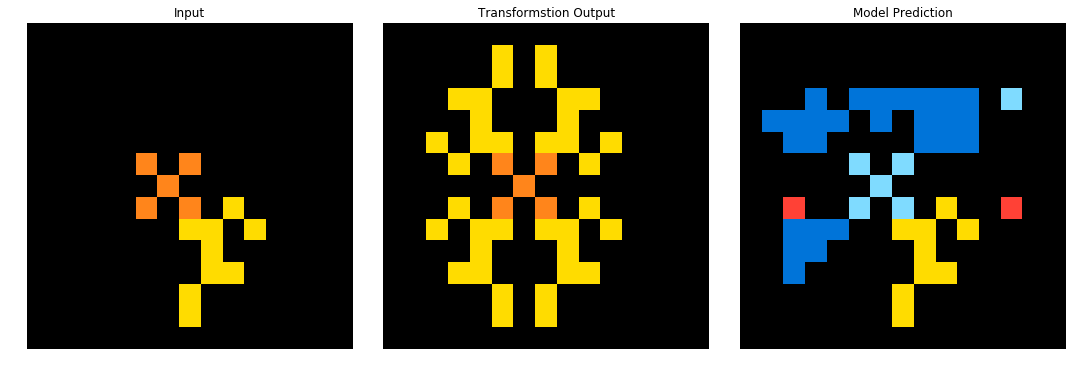

Made predictions for  50846271
ensemble accuracy 0.9617224880382775
50846271.json



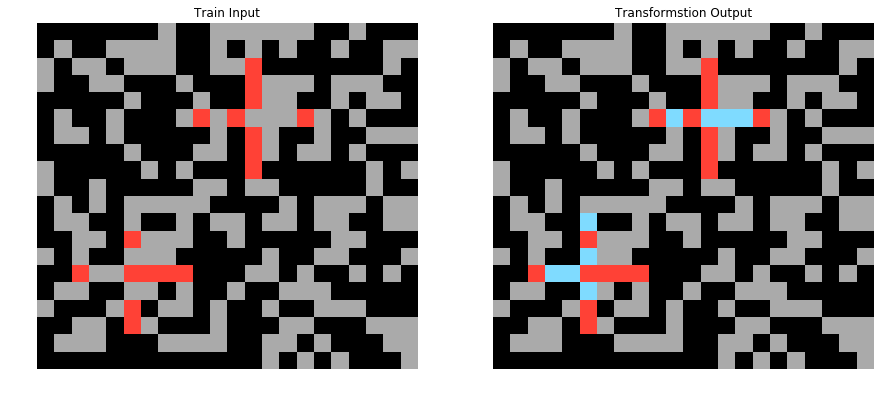

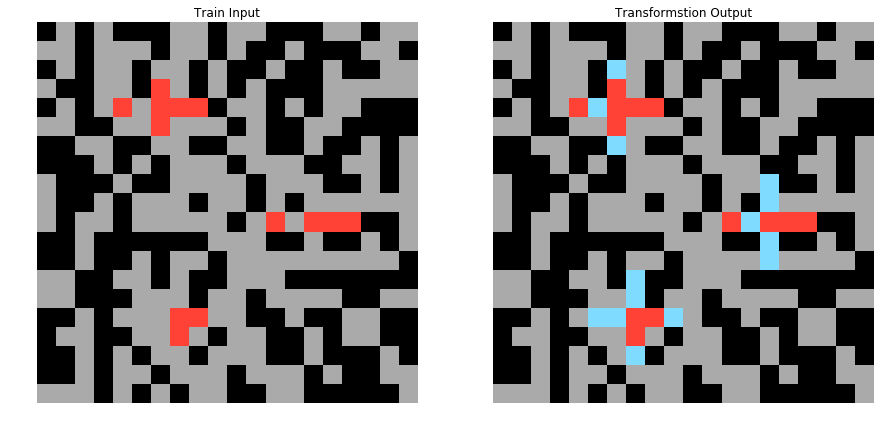

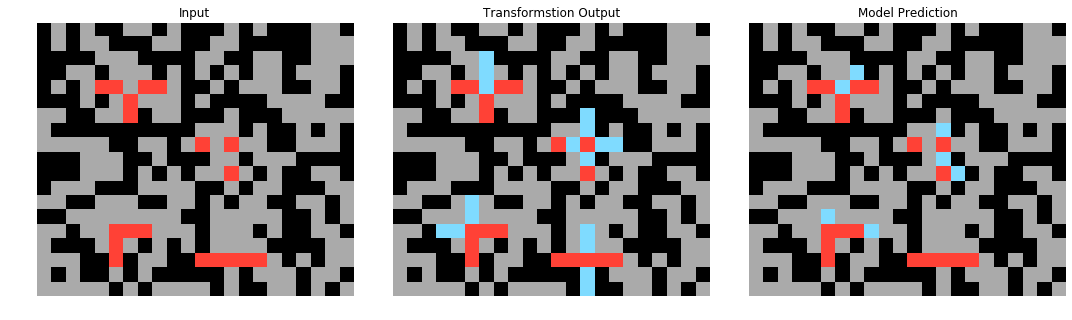

Made predictions for  508bd3b6
ensemble accuracy 0.9375



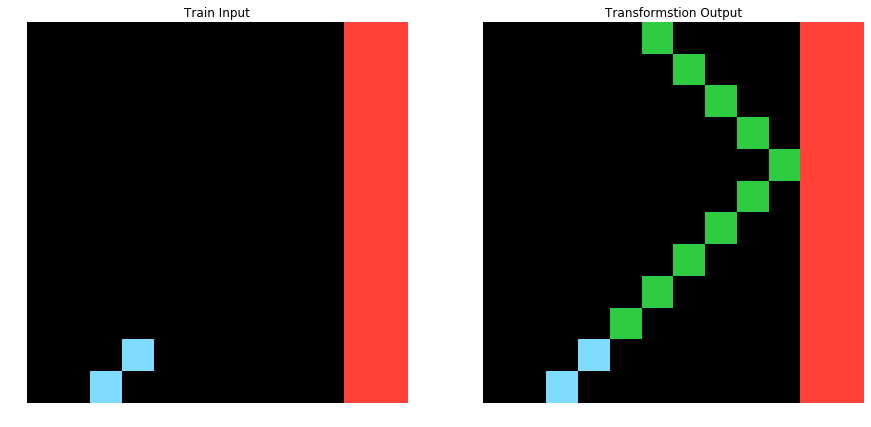

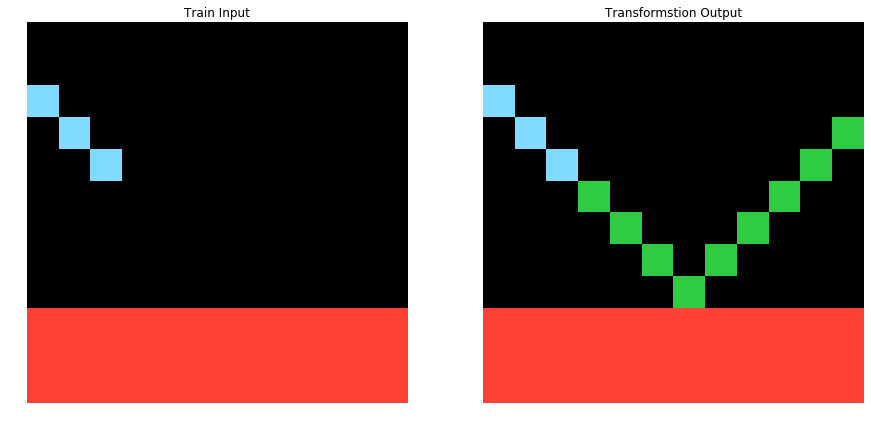

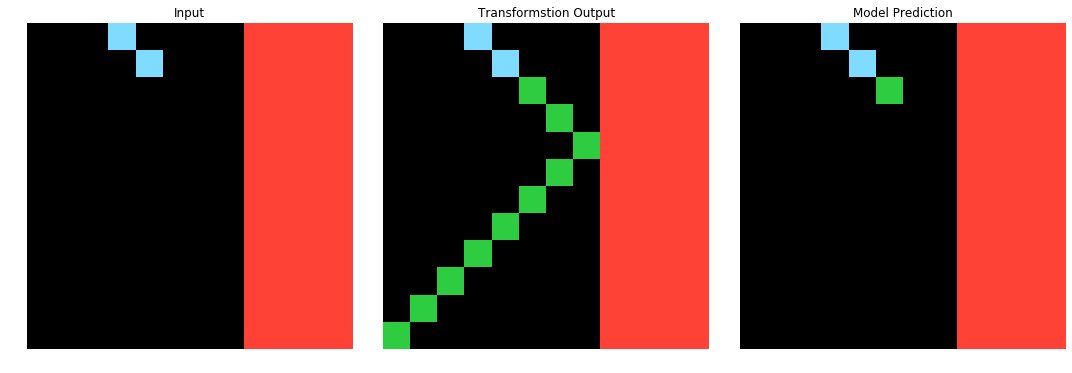

Made predictions for  50cb2852
ensemble accuracy 1.0
50cb2852.json



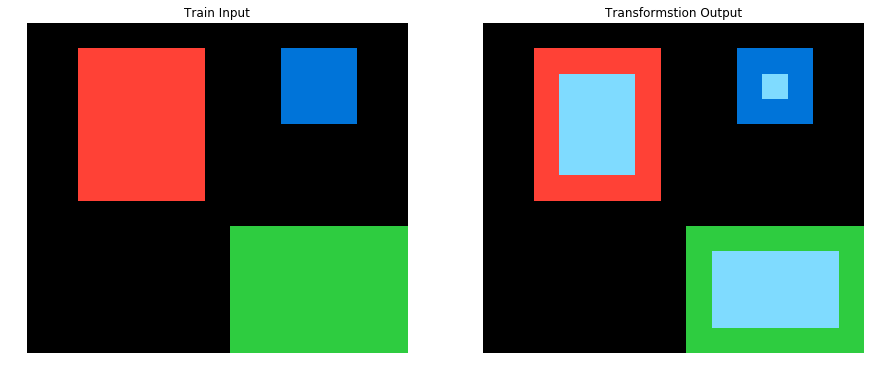

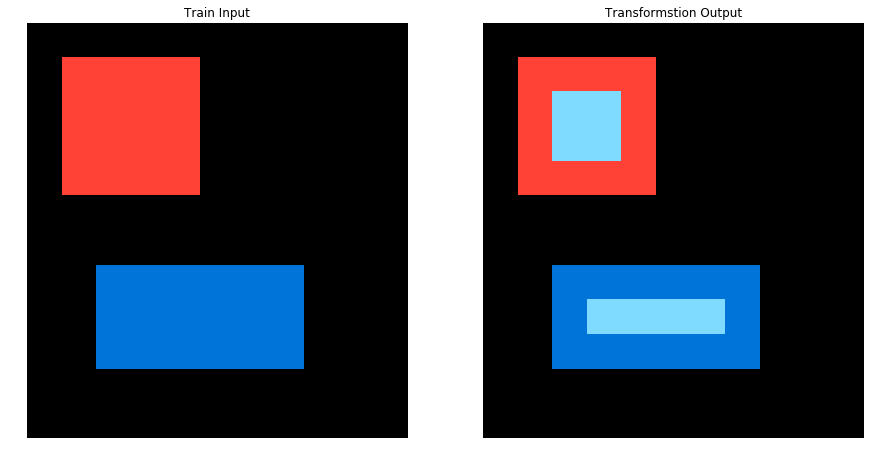

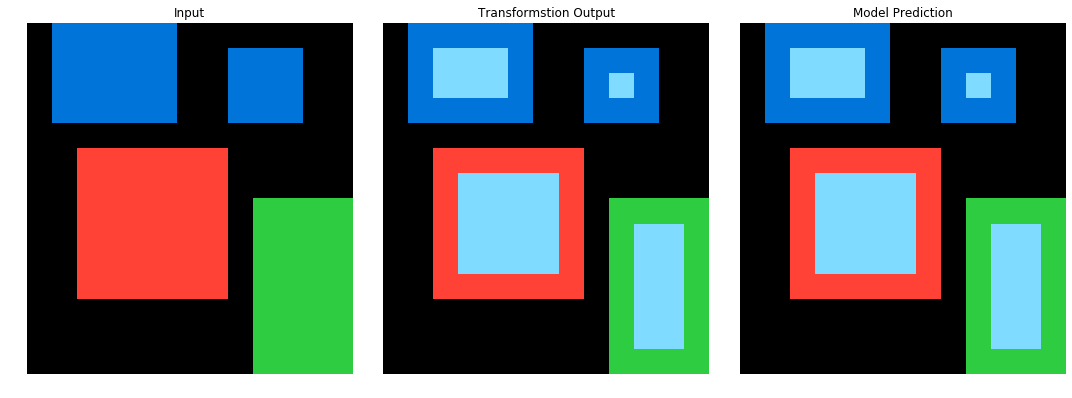

Number of input rows: 13 cols: 13
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/5117e062.json

Made predictions for  5168d44c
ensemble accuracy 0.9159663865546218



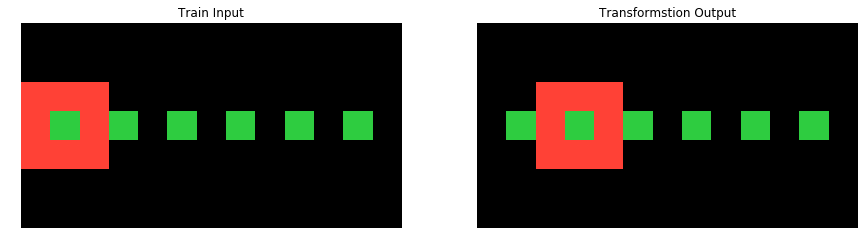

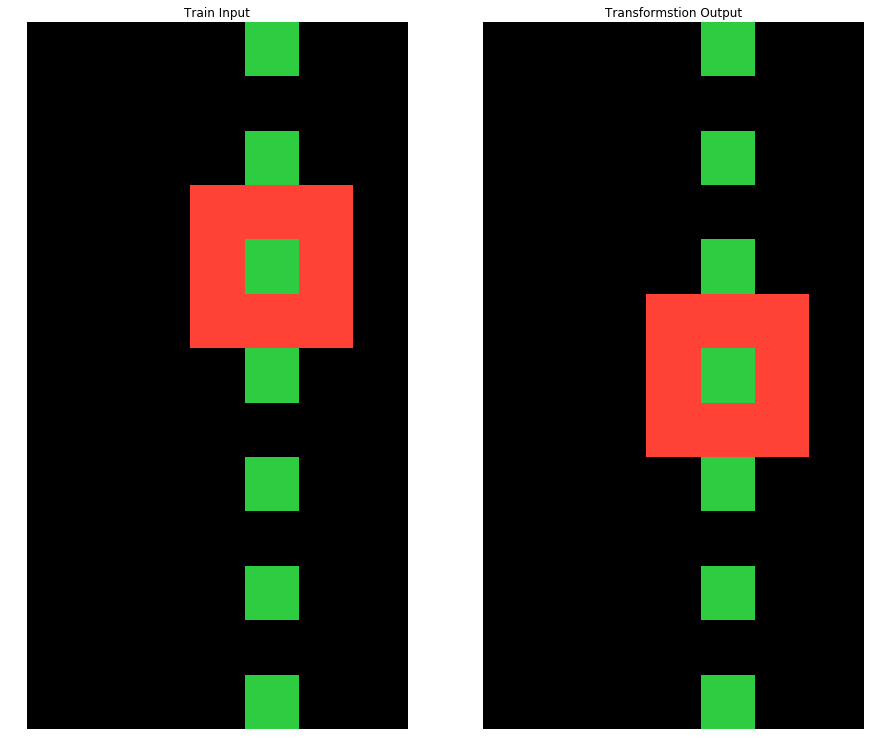

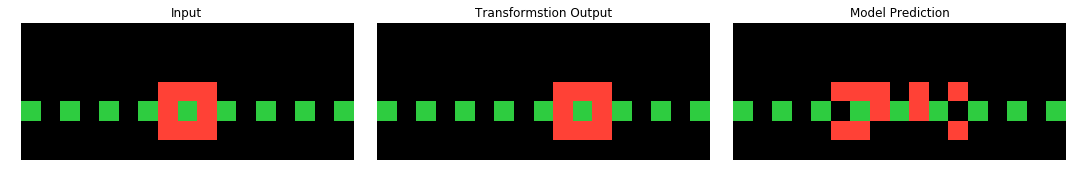

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/539a4f51.json

Number of input rows: 6 cols: 10
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/53b68214.json

Made predictions for  543a7ed5
ensemble accuracy 1.0
543a7ed5.json



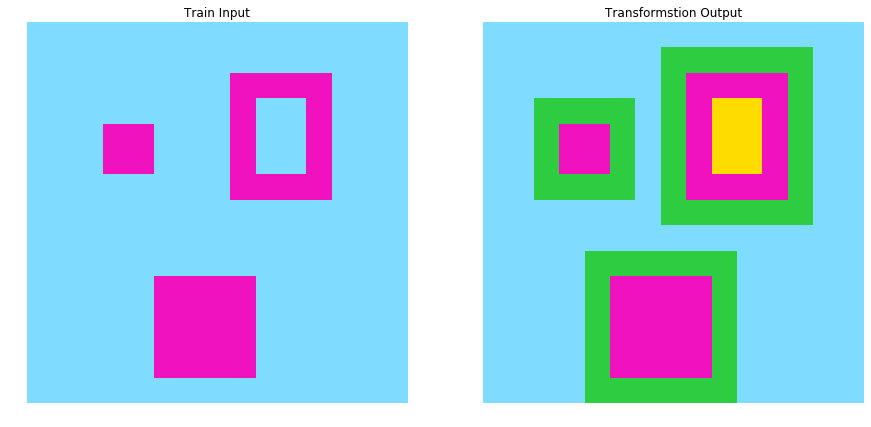

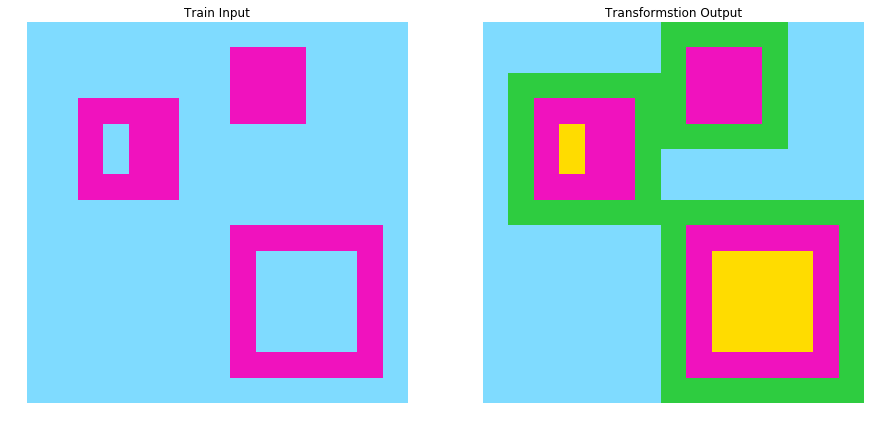

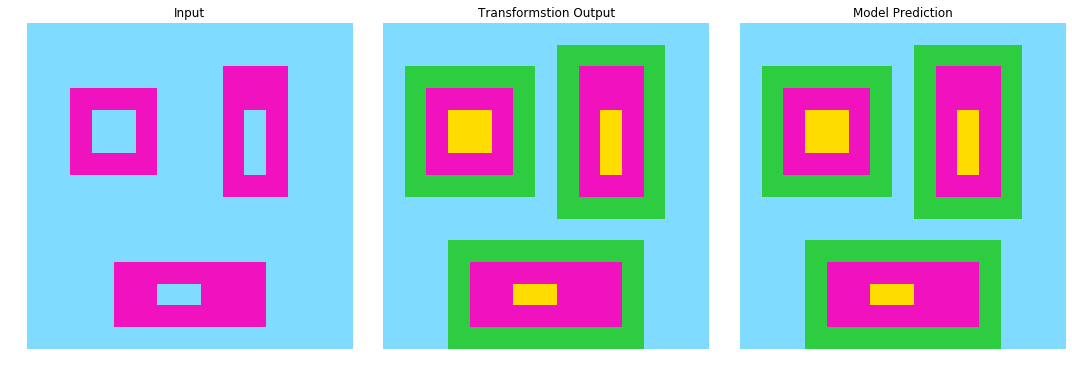

Made predictions for  54d82841
ensemble accuracy 0.9090909090909091



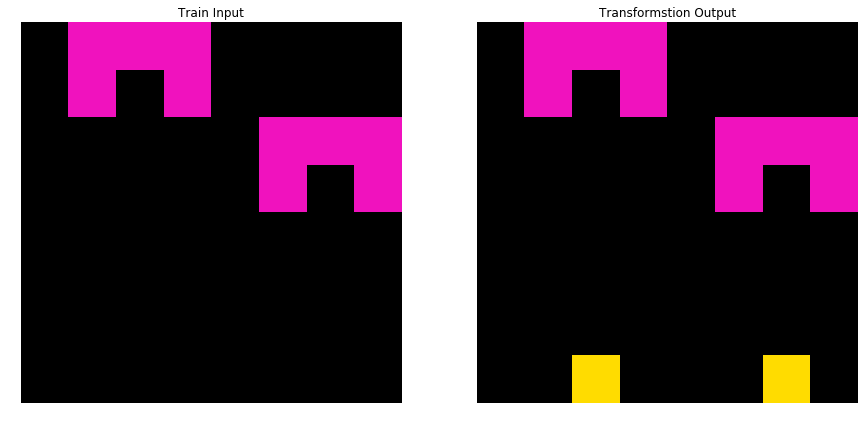

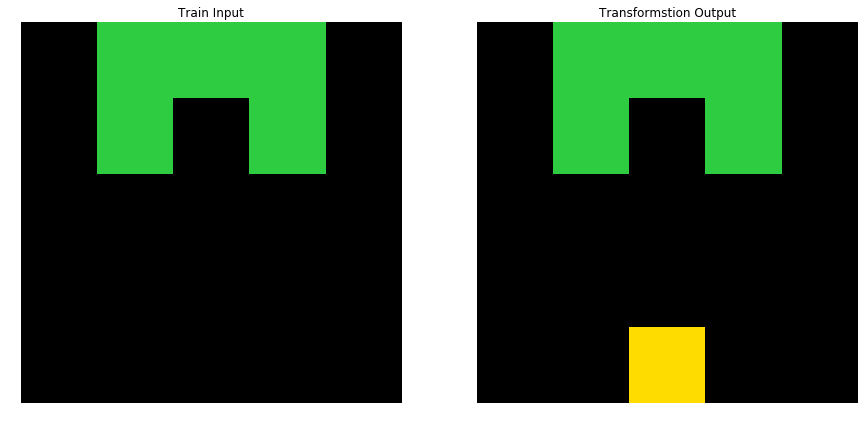

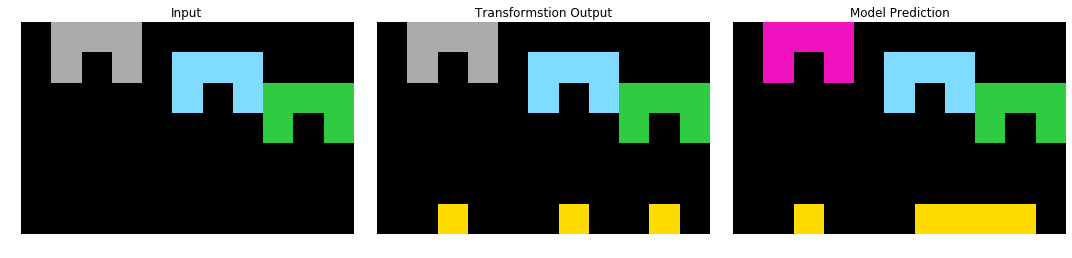

Made predictions for  54d9e175
ensemble accuracy 0.8961038961038961



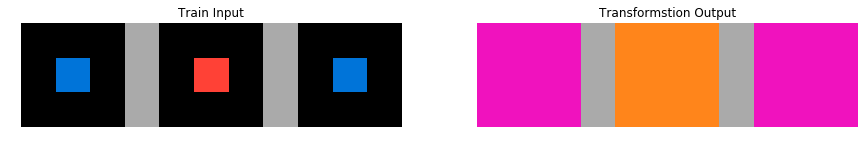

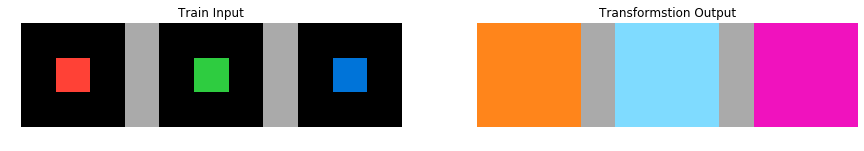

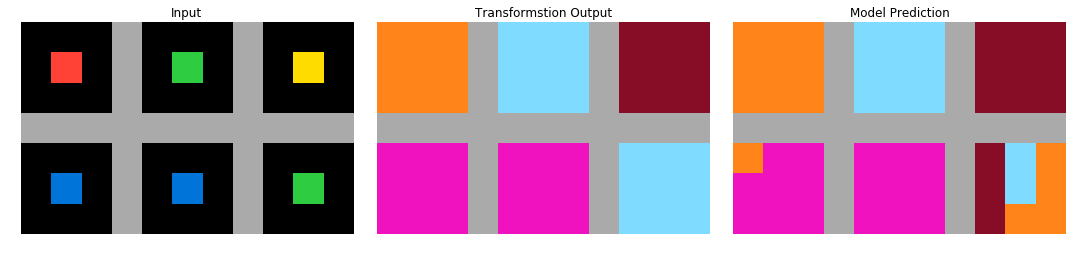

Made predictions for  5521c0d9
ensemble accuracy 0.8311111111111111



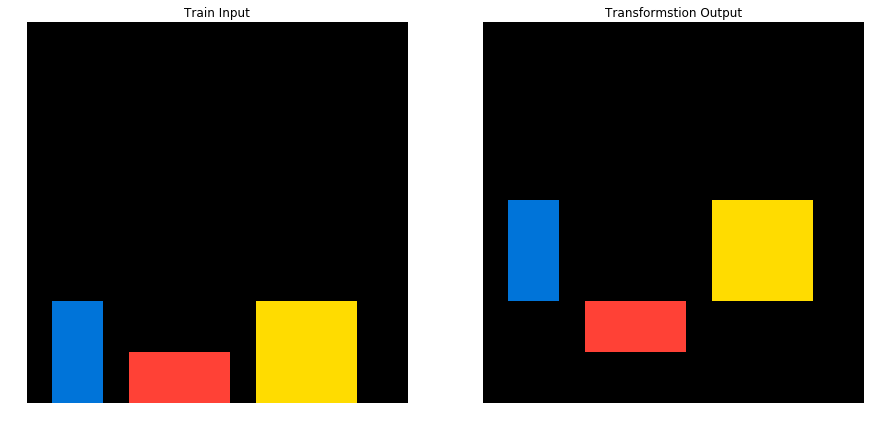

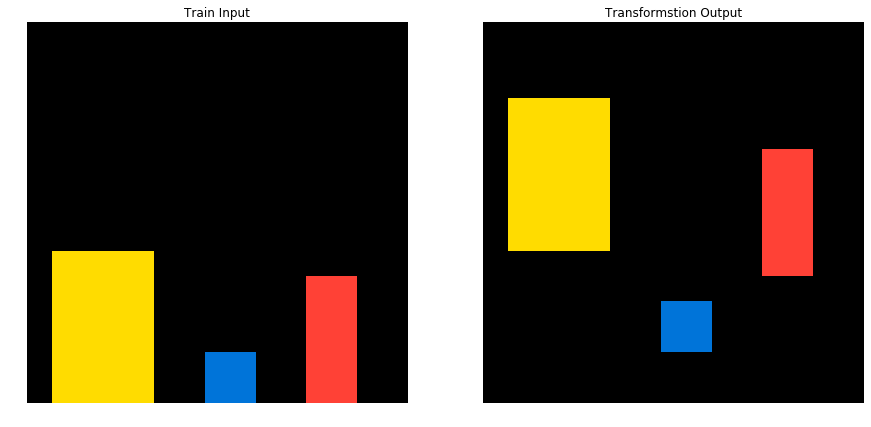

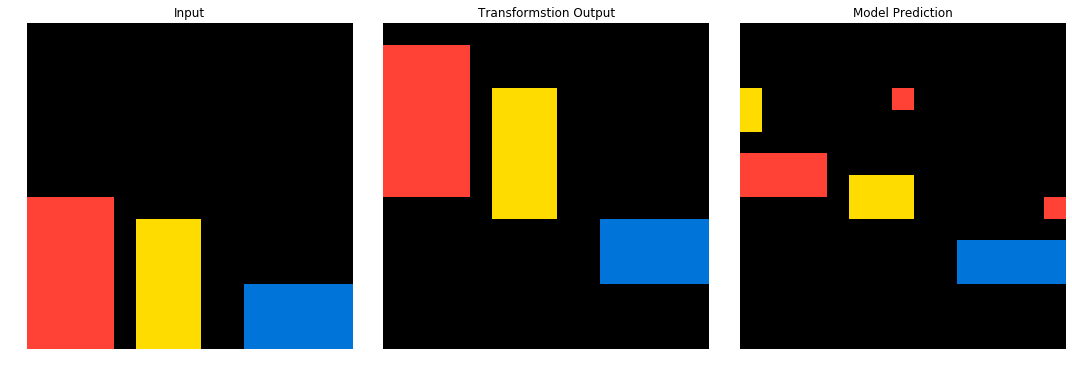

Made predictions for  5582e5ca
ensemble accuracy 0.0



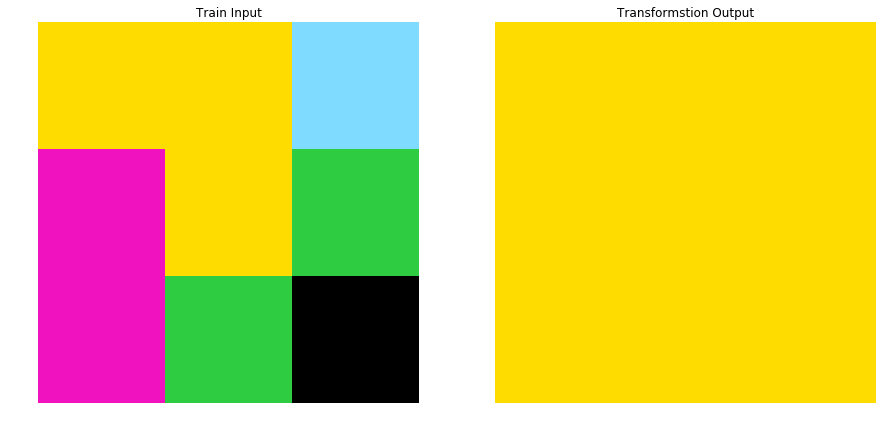

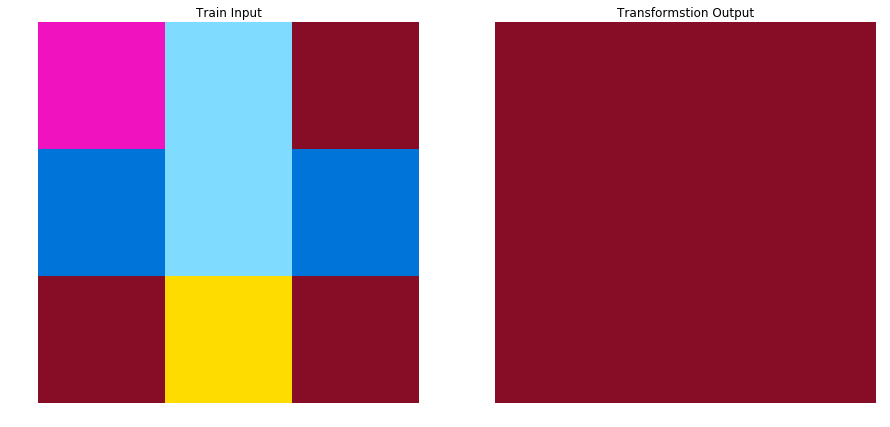

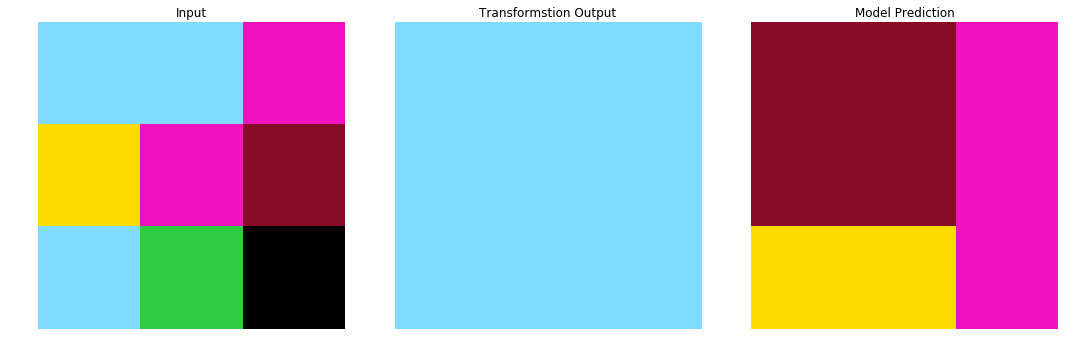

Number of input rows: 9 cols: 9
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/5614dbcf.json

Made predictions for  56dc2b01
ensemble accuracy 0.75



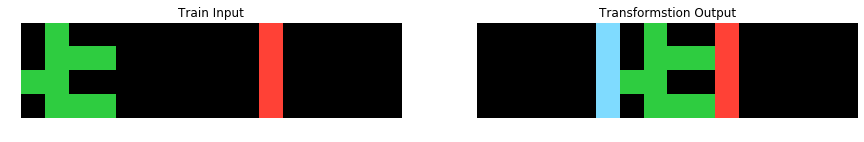

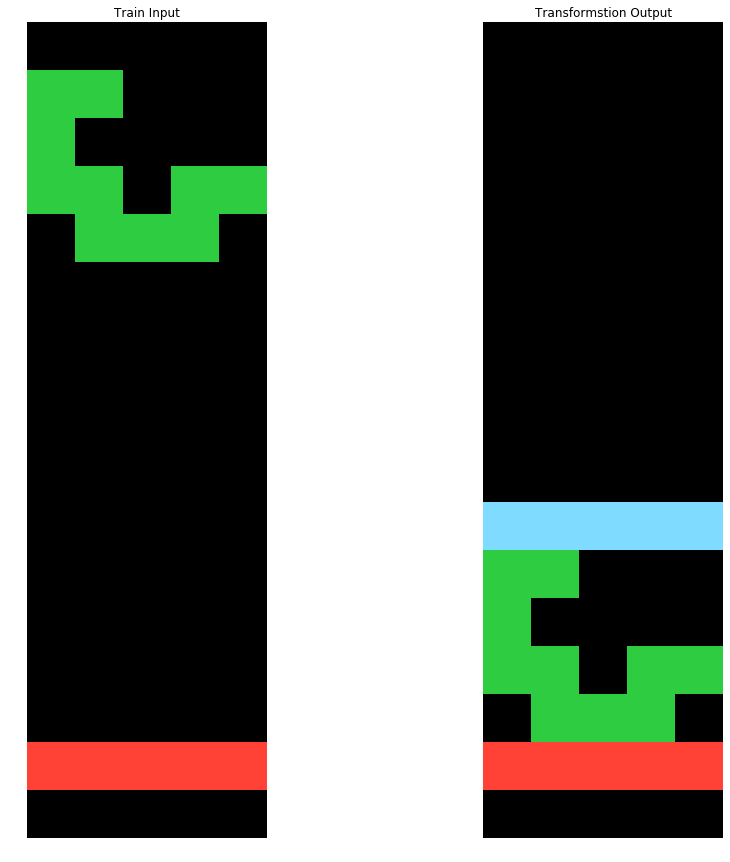

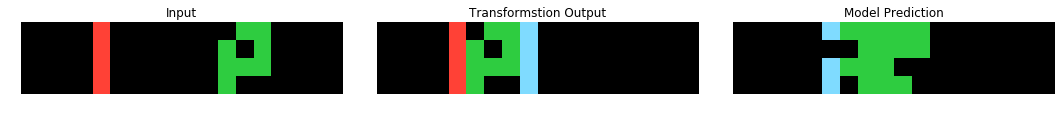

Made predictions for  56ff96f3
ensemble accuracy 0.5



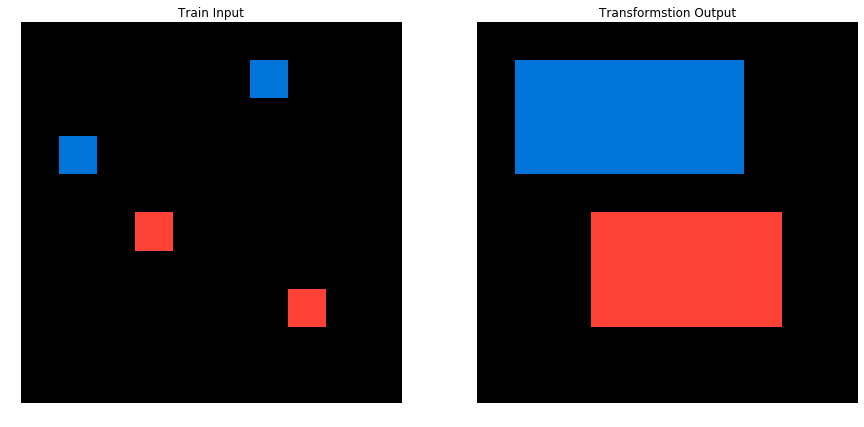

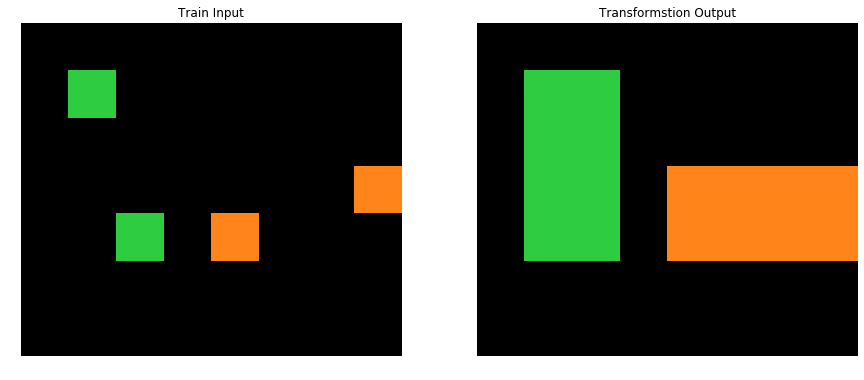

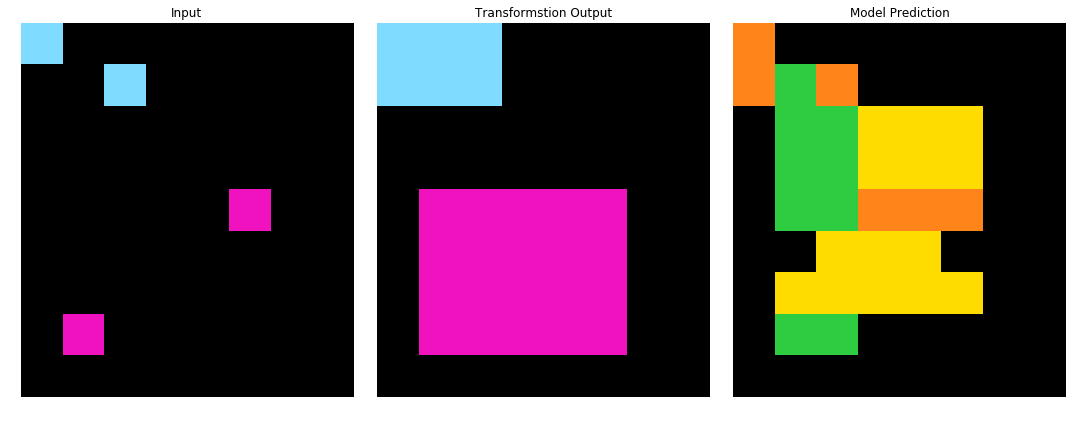

Made predictions for  57aa92db
ensemble accuracy 0.7456140350877193



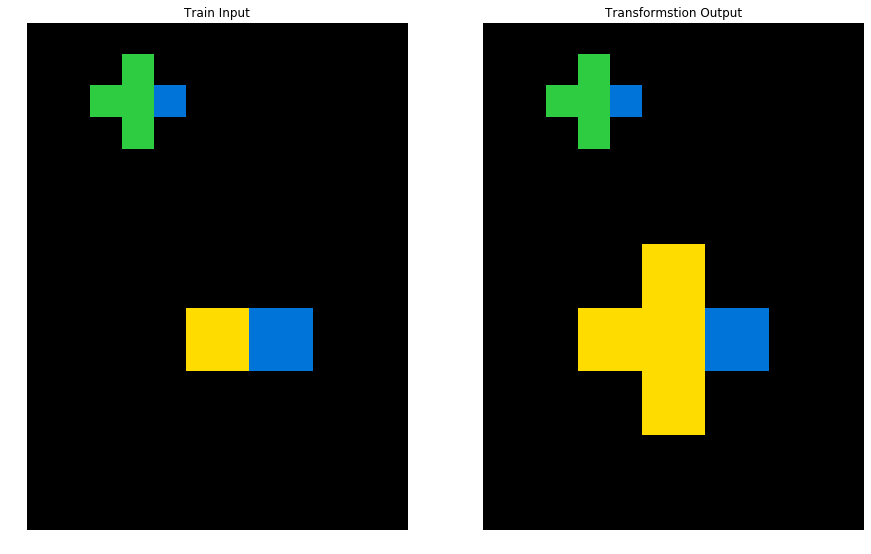

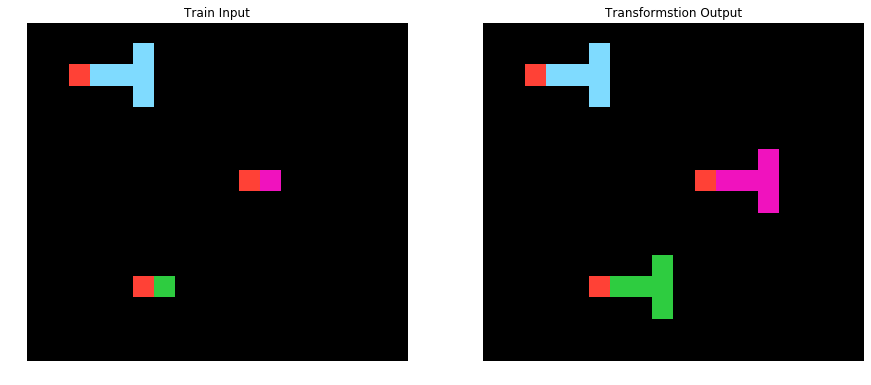

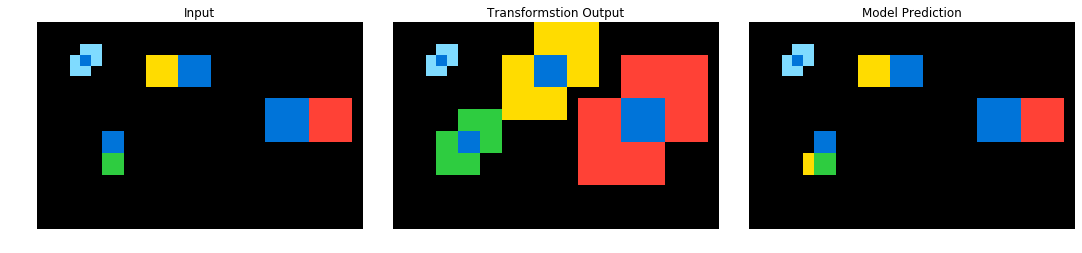

Number of input rows: 20 cols: 24
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/5ad4f10b.json

Number of input rows: 9 cols: 9
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/5bd6f4ac.json

Made predictions for  5c0a986e
ensemble accuracy 0.91



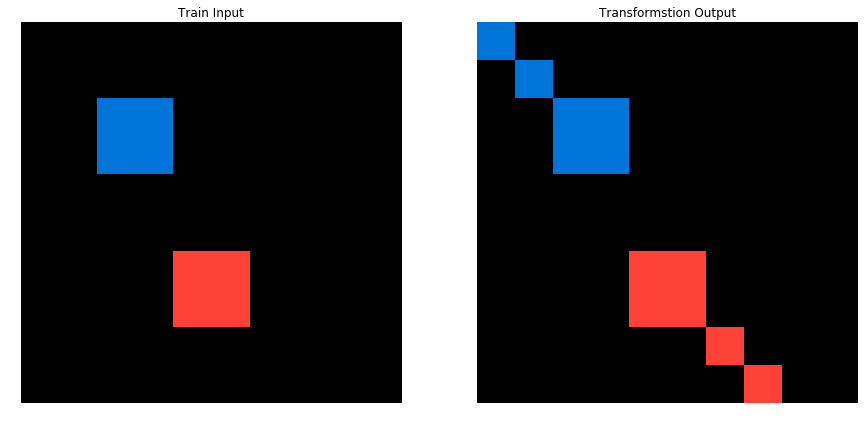

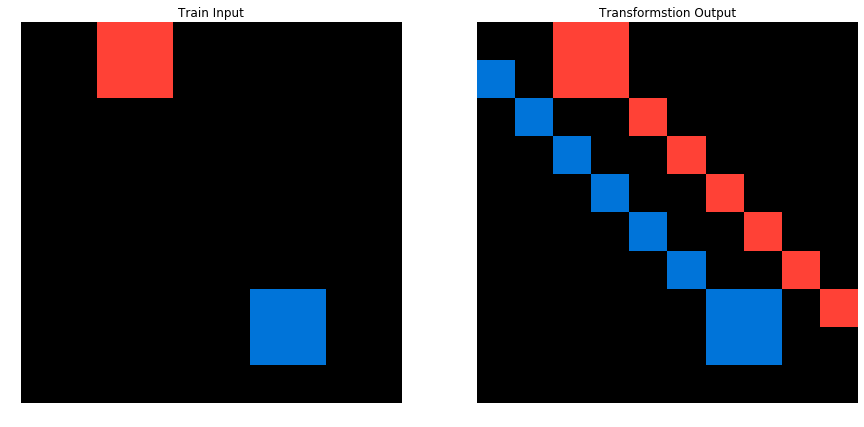

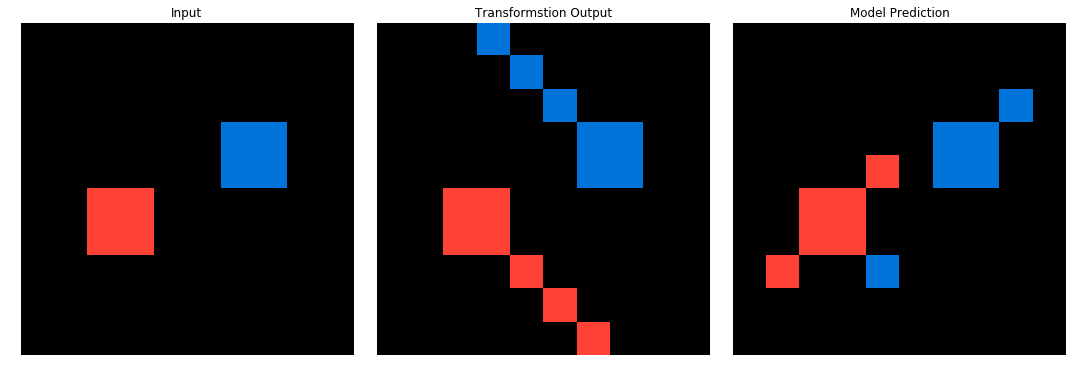

Made predictions for  5c2c9af4
ensemble accuracy 0.6760204081632653



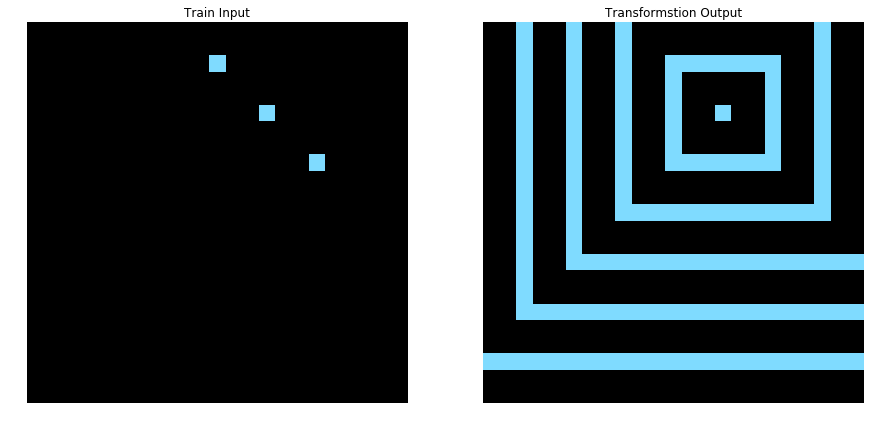

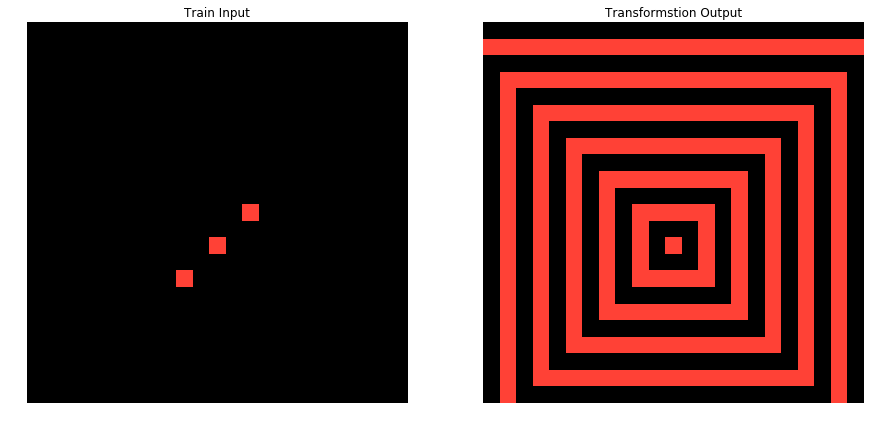

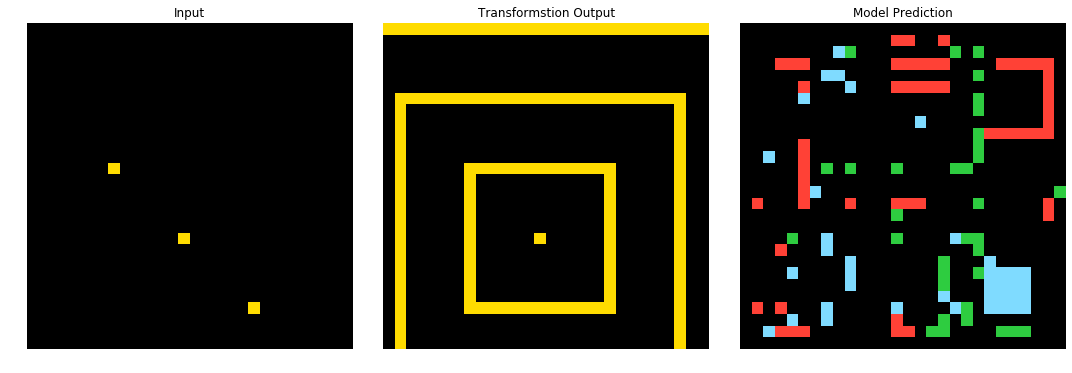

Number of input rows: 22 cols: 22
Number of target rows: 15 cols: 12
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/5daaa586.json

Made predictions for  60b61512
ensemble accuracy 0.9259259259259259



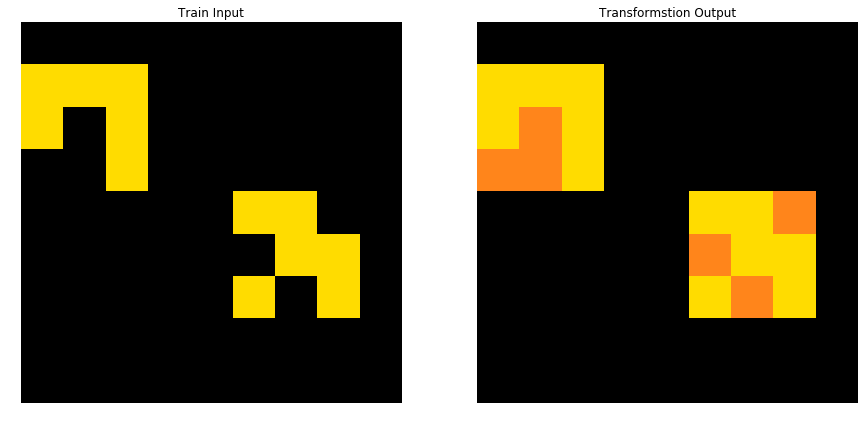

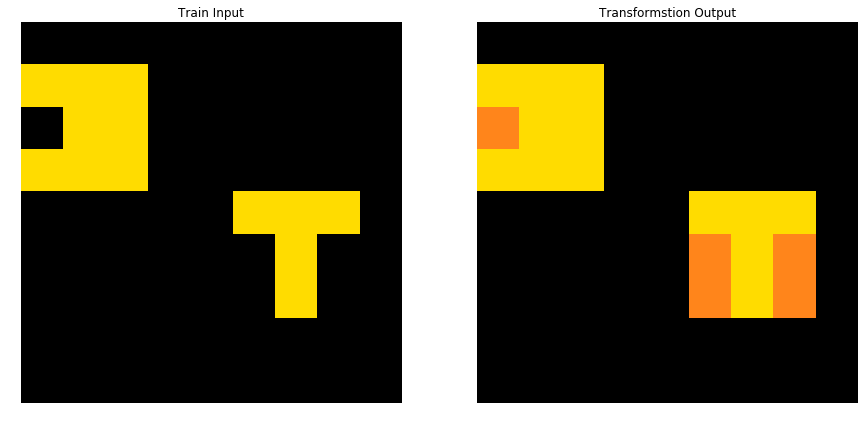

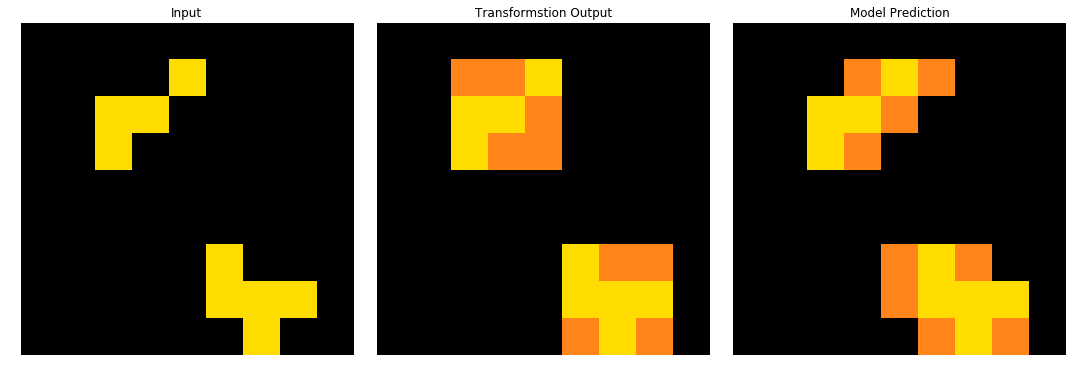

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  6150a2bd
ensemble accuracy 0.2222222222222222



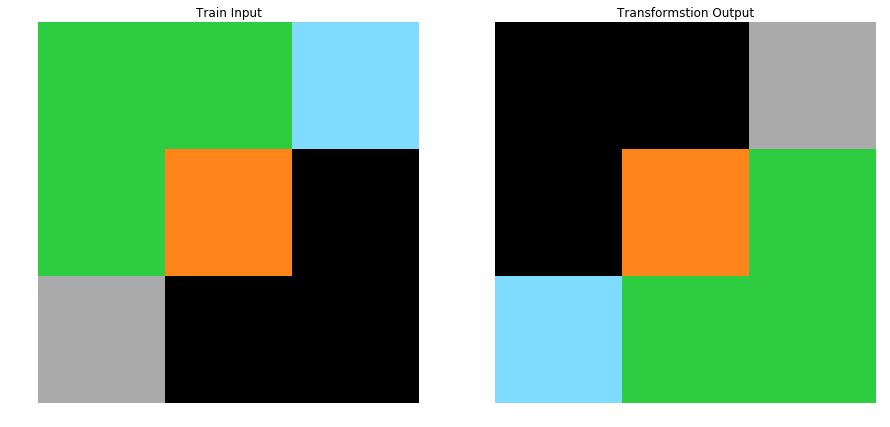

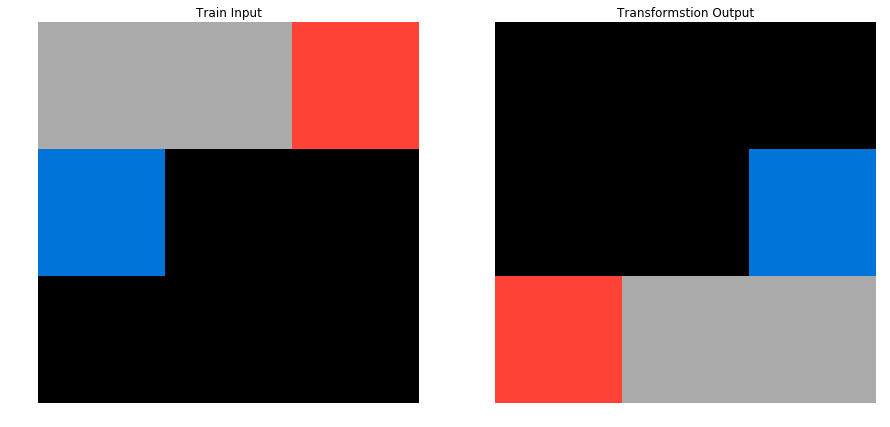

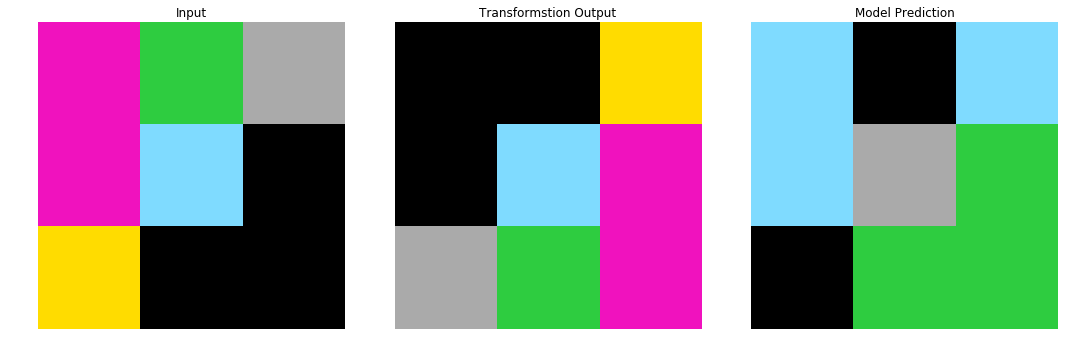

Made predictions for  623ea044
ensemble accuracy 0.9134948096885813



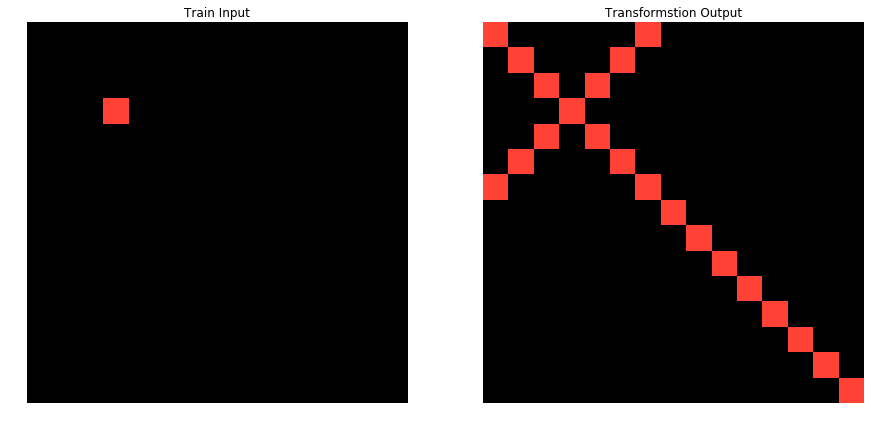

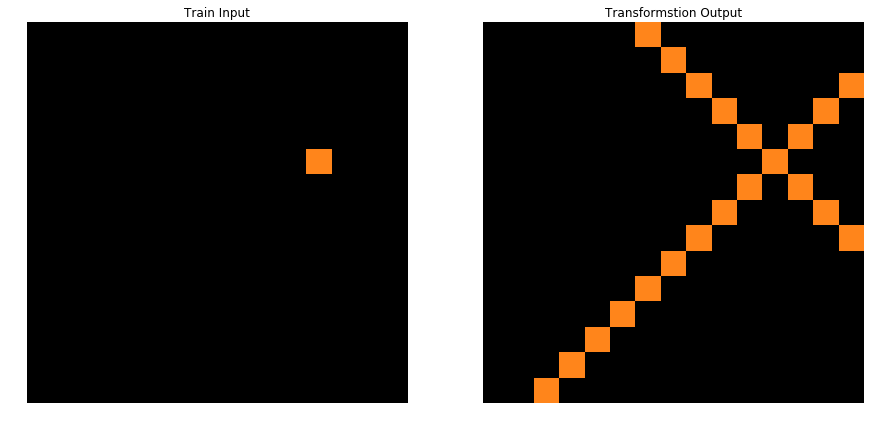

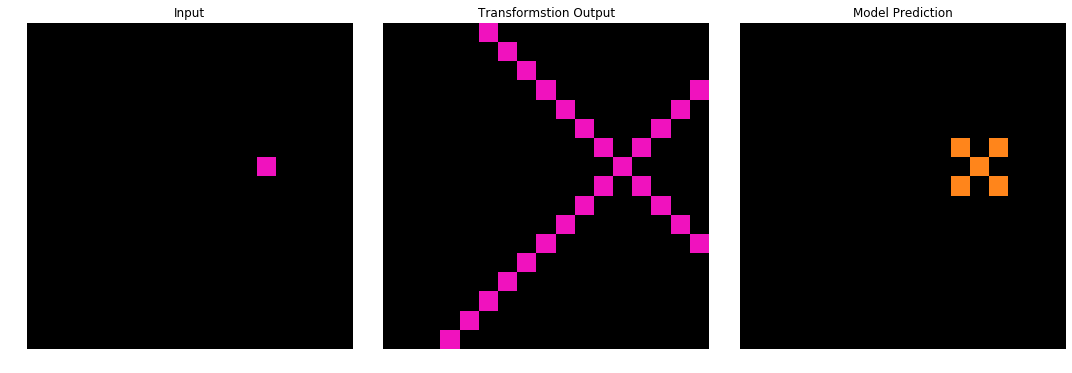

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/62c24649.json

Made predictions for  63613498
ensemble accuracy 0.88



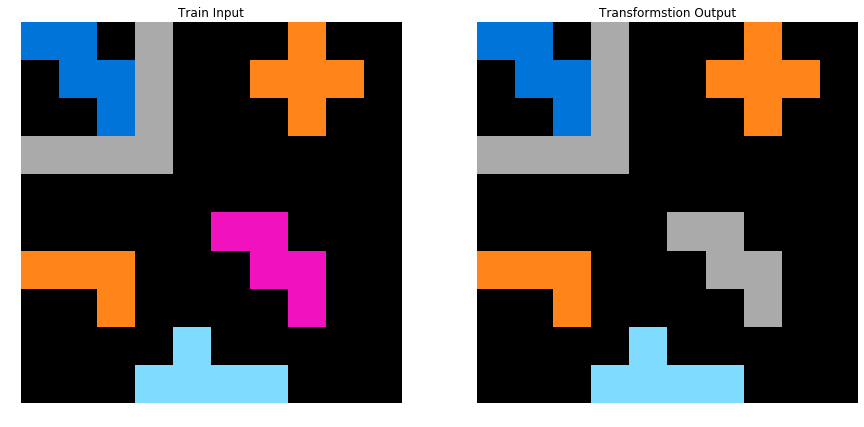

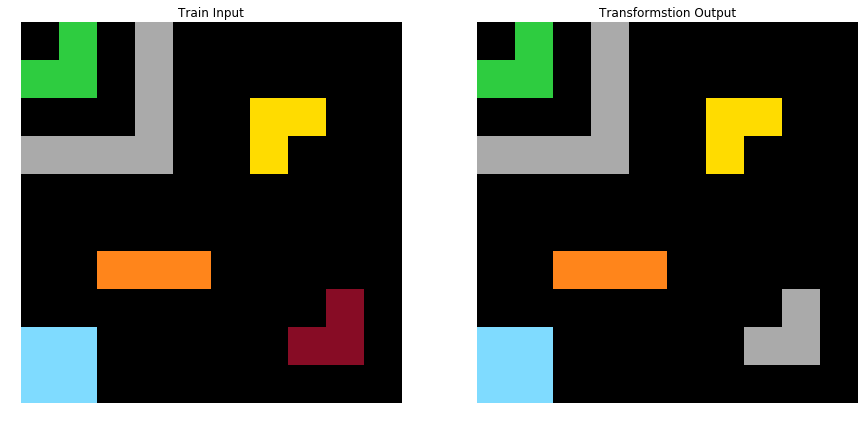

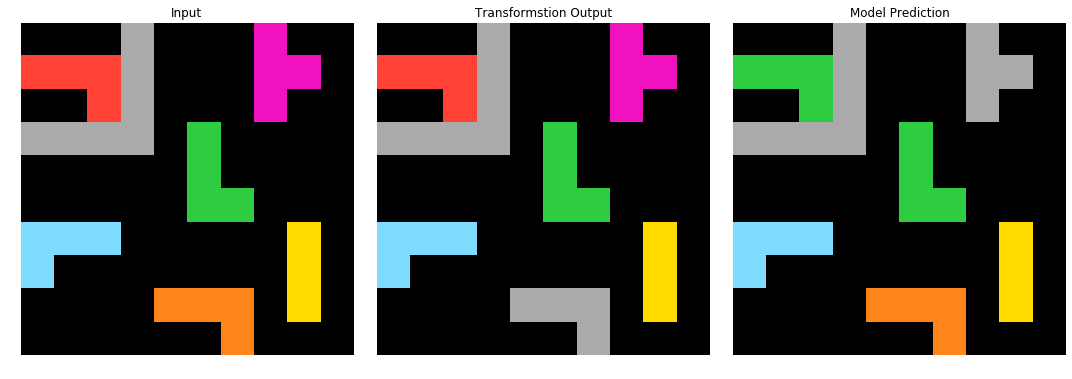

Number of input rows: 9 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6430c8c4.json

Made predictions for  6455b5f5
ensemble accuracy 0.7596153846153846



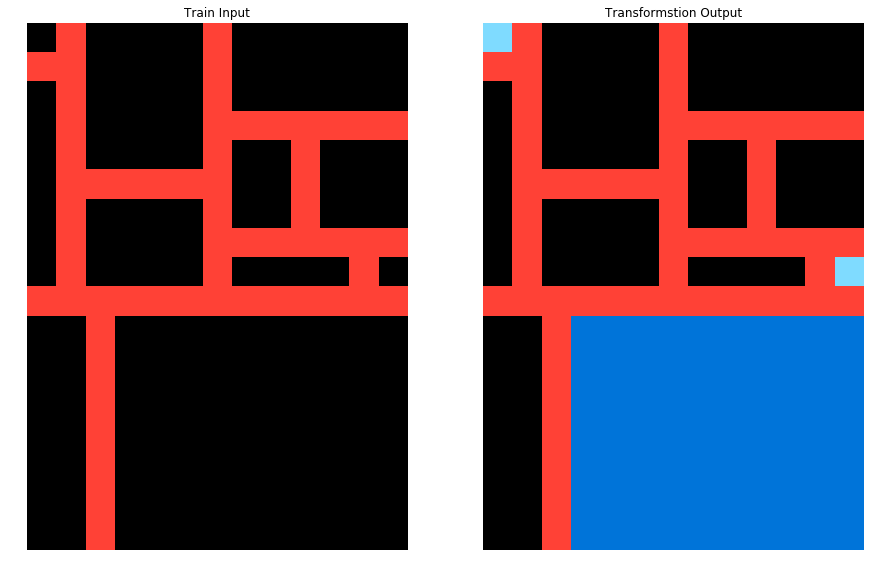

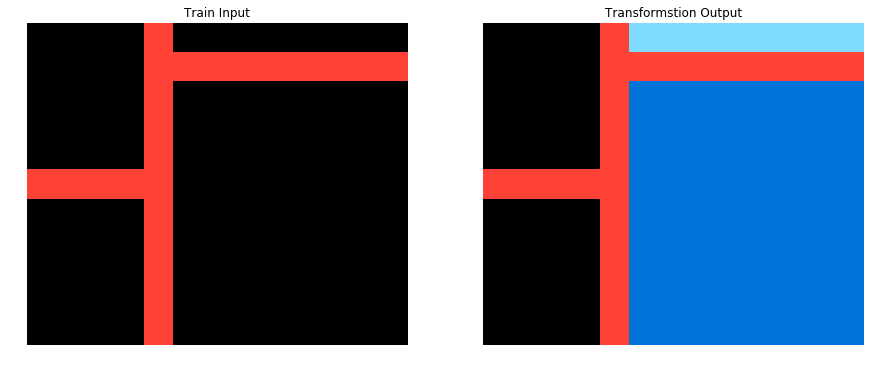

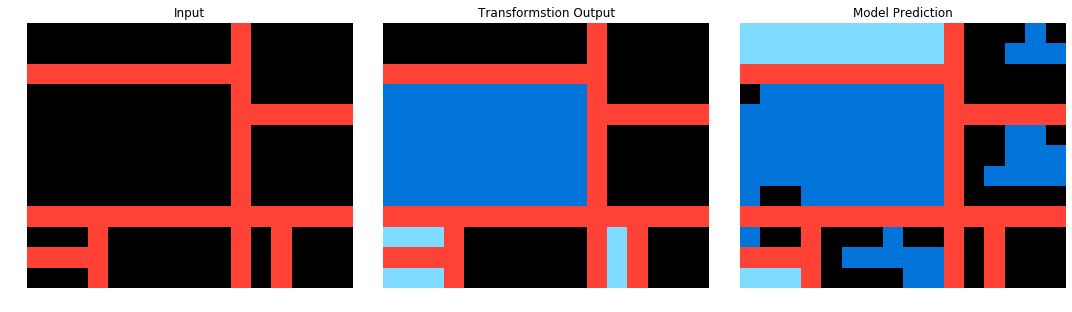

Number of input rows: 9 cols: 3
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/662c240a.json

Made predictions for  67385a82
ensemble accuracy 1.0
67385a82.json



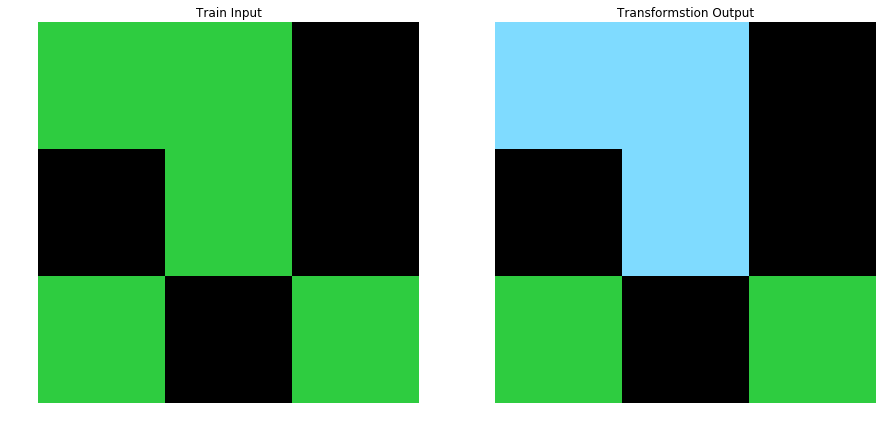

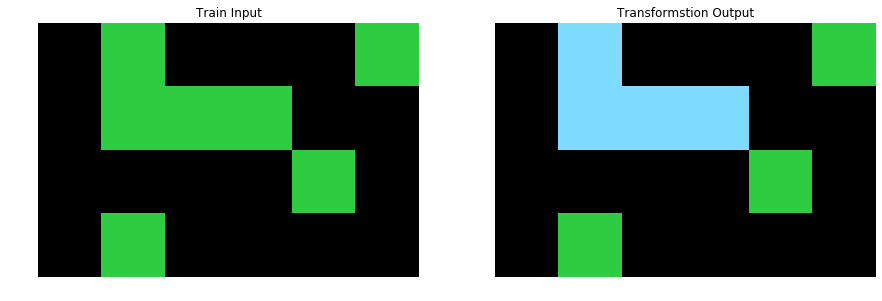

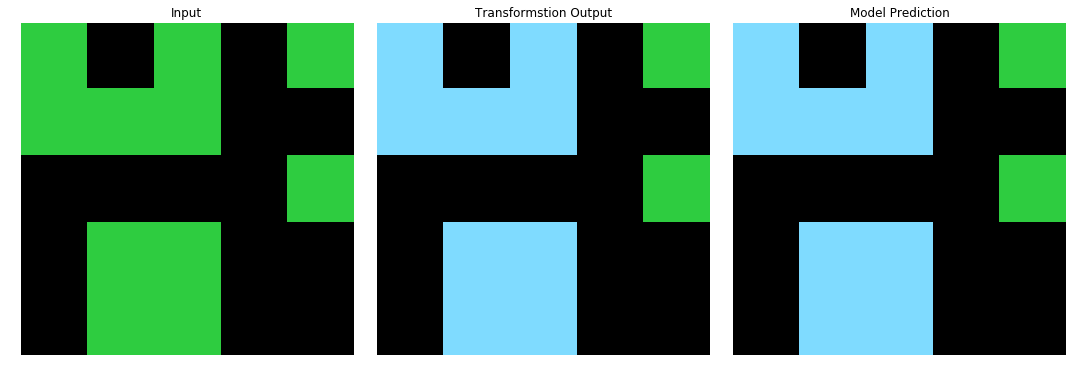

Made predictions for  673ef223
ensemble accuracy 0.8611111111111112



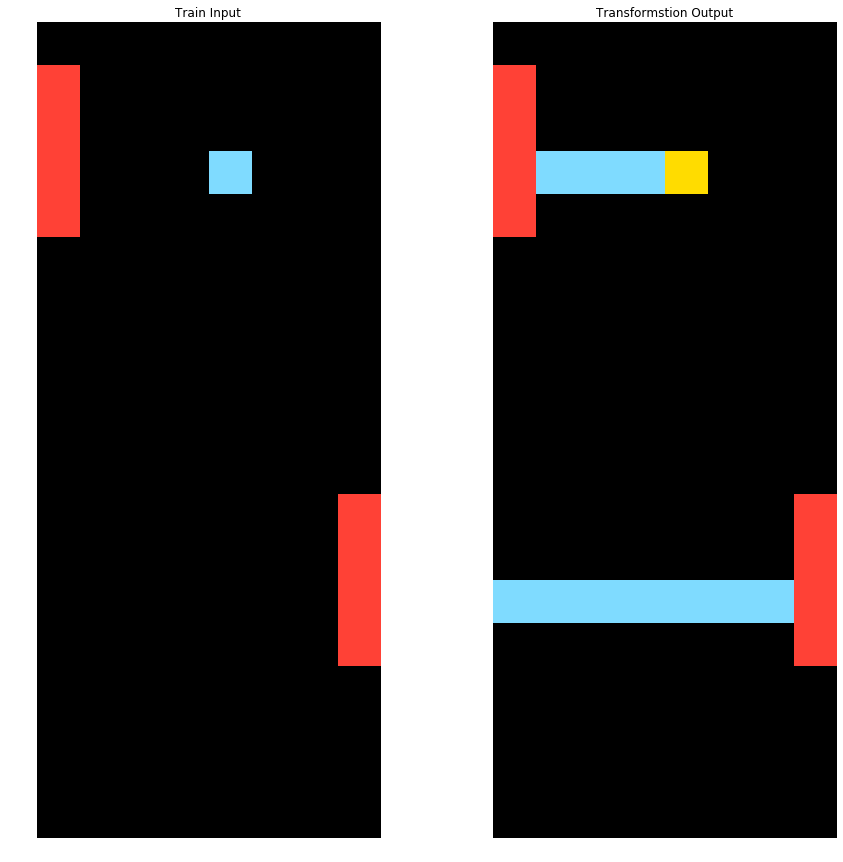

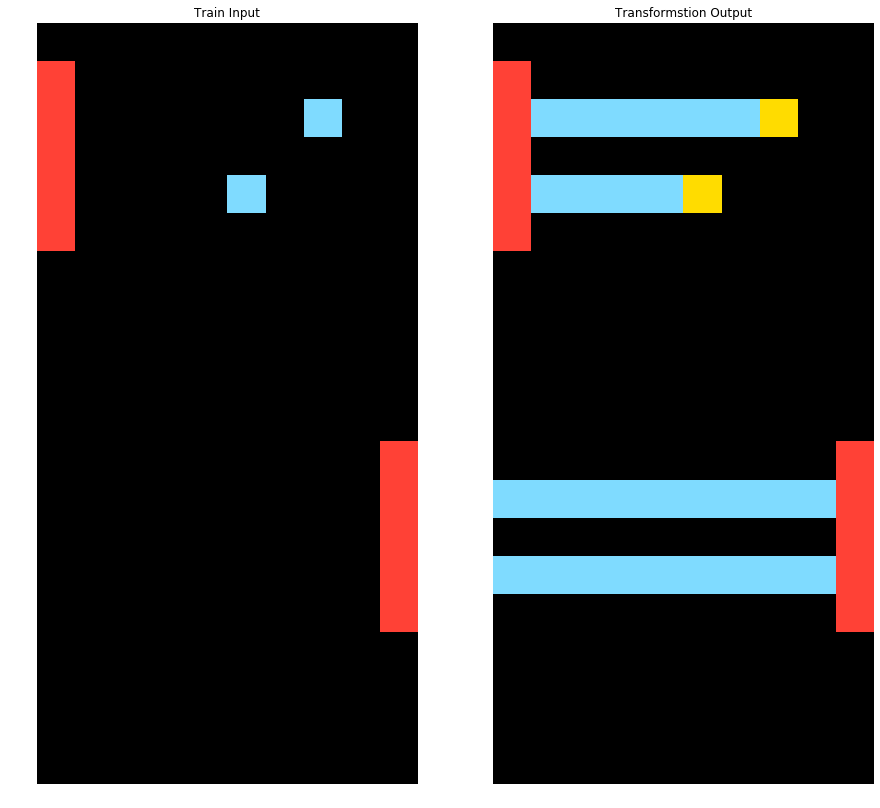

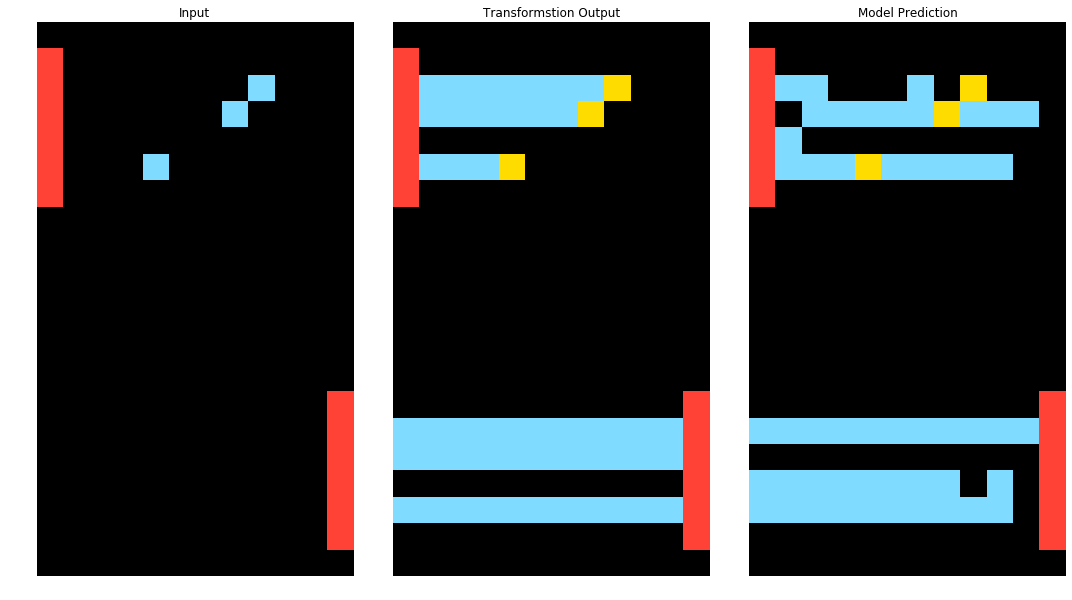

Number of input rows: 11 cols: 11
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6773b310.json

Made predictions for  67a3c6ac
ensemble accuracy 0.2222222222222222



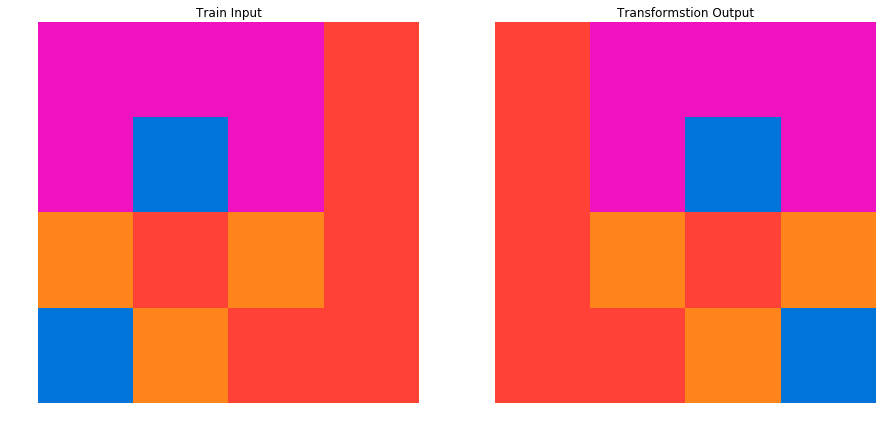

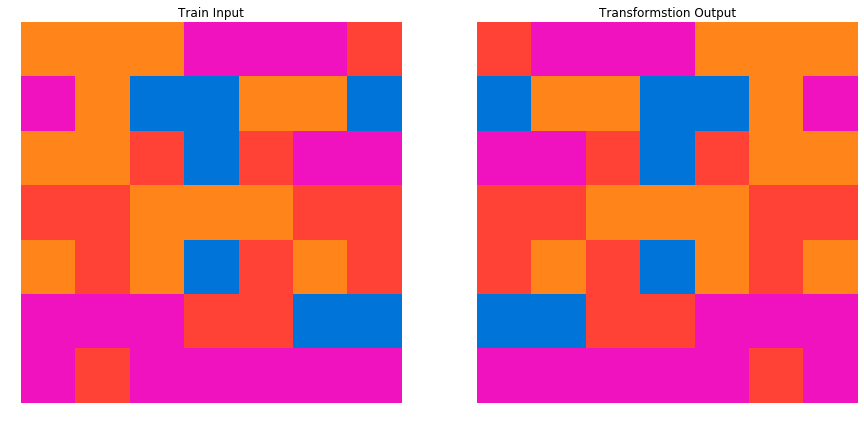

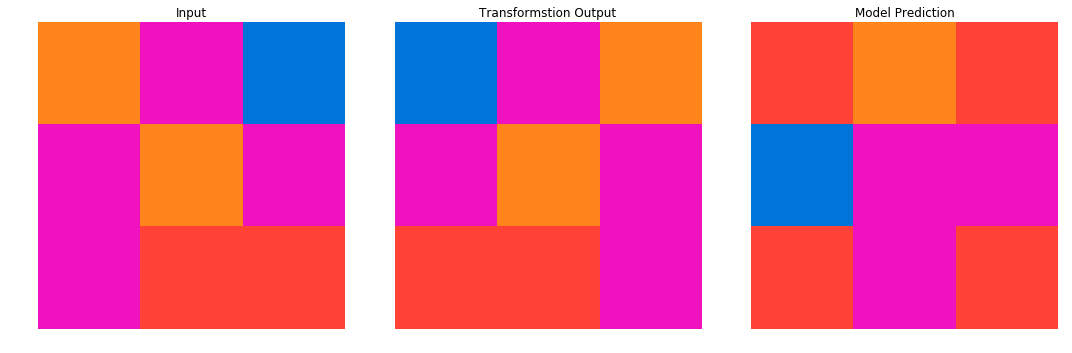

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  67a423a3
ensemble accuracy 0.9305555555555556



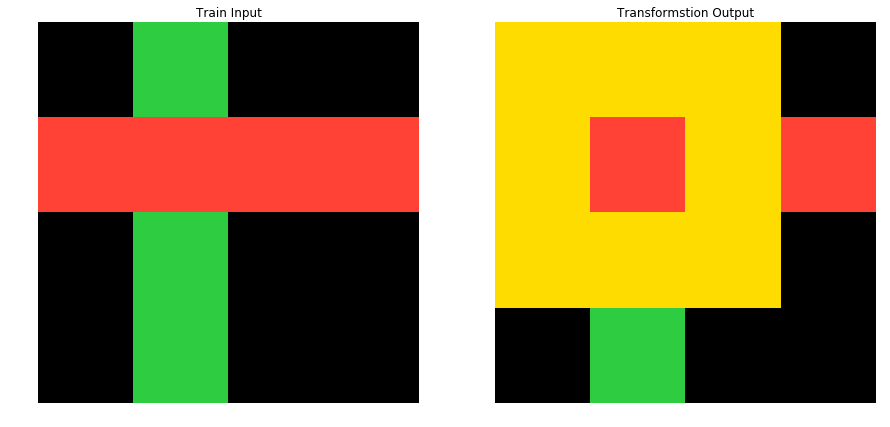

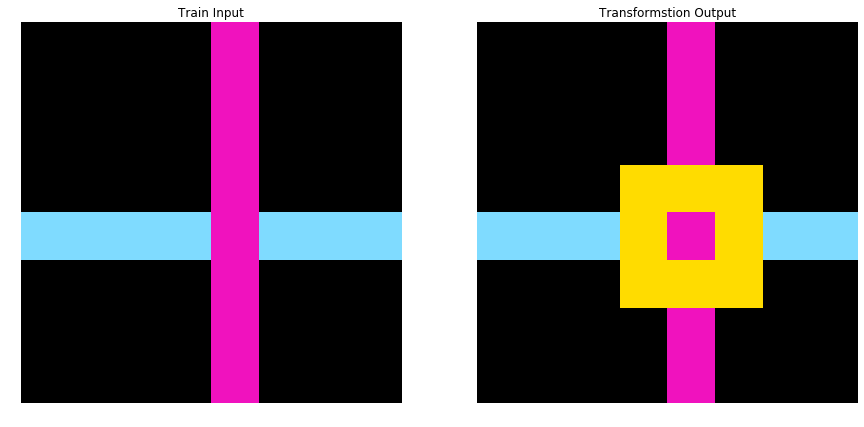

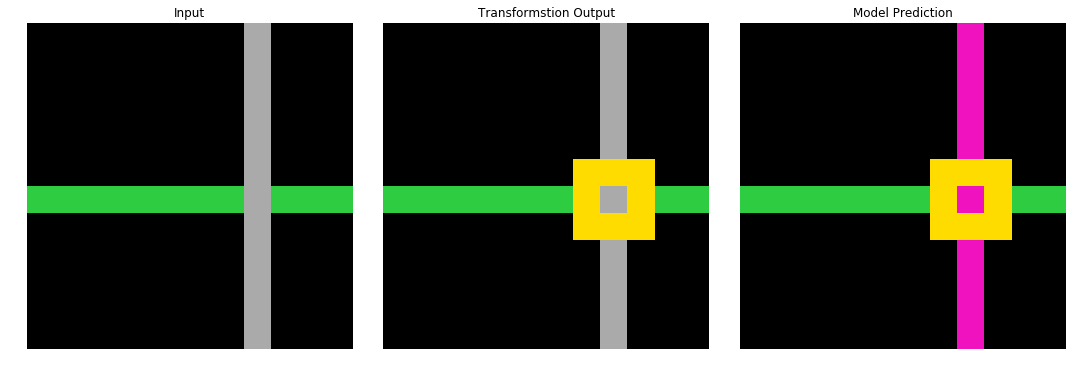

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/67e8384a.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/681b3aeb.json

Made predictions for  6855a6e4
ensemble accuracy 0.9422222222222222



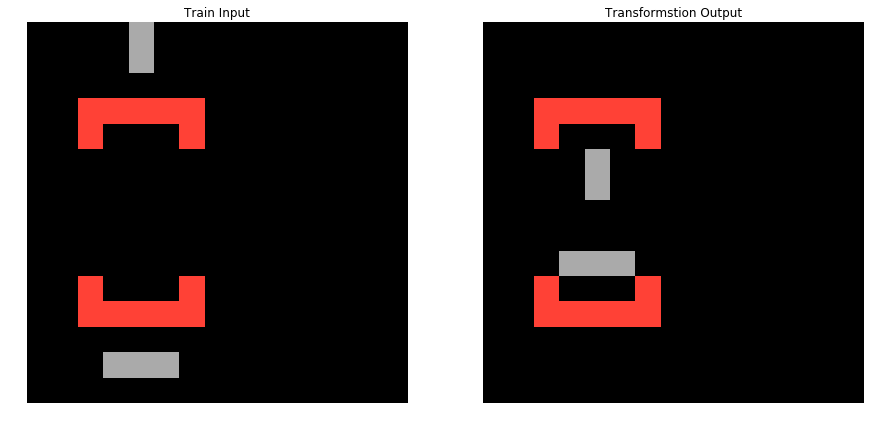

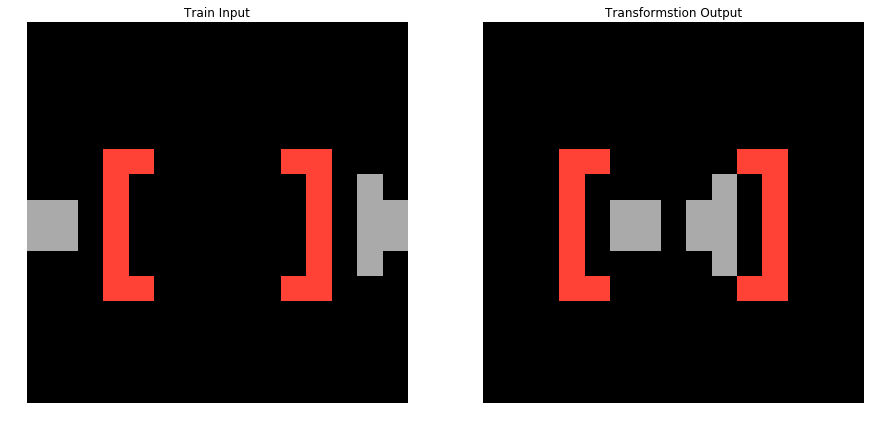

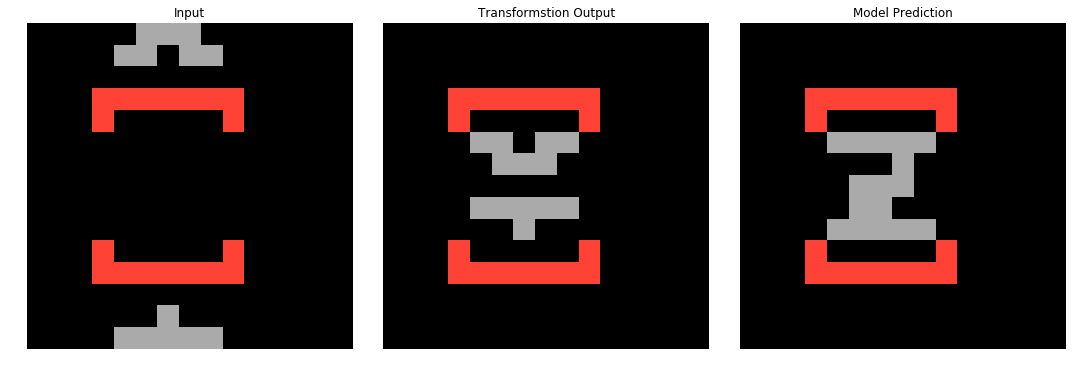

Made predictions for  68b16354
ensemble accuracy 0.30612244897959184



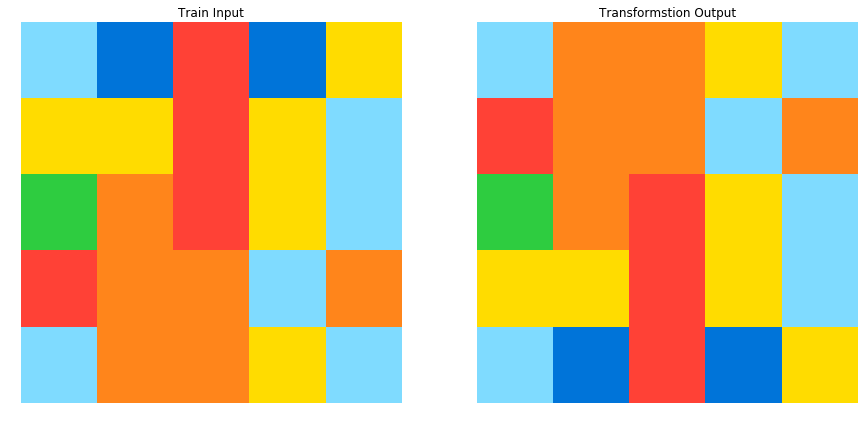

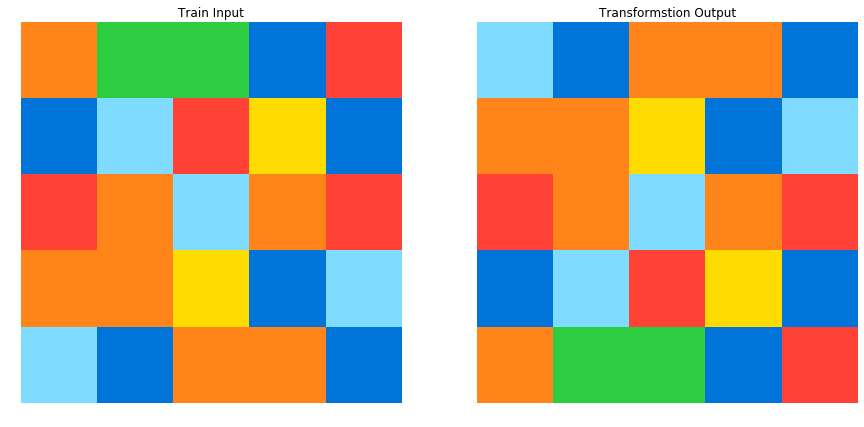

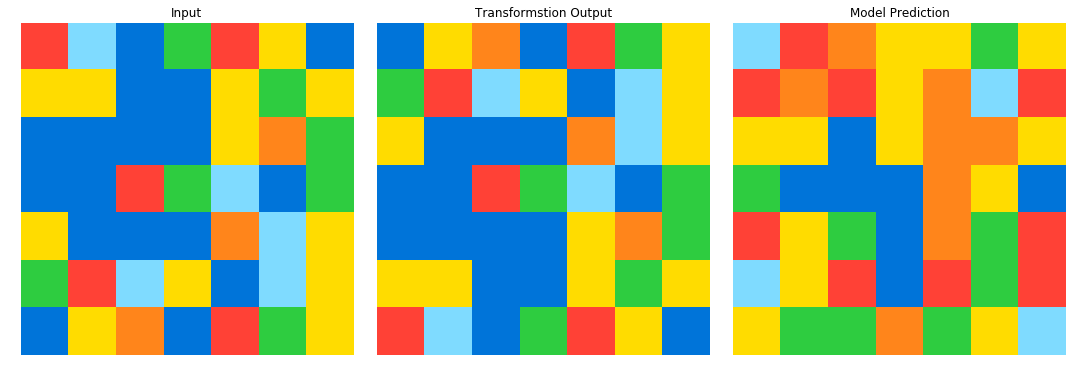

Made predictions for  694f12f3
ensemble accuracy 0.88



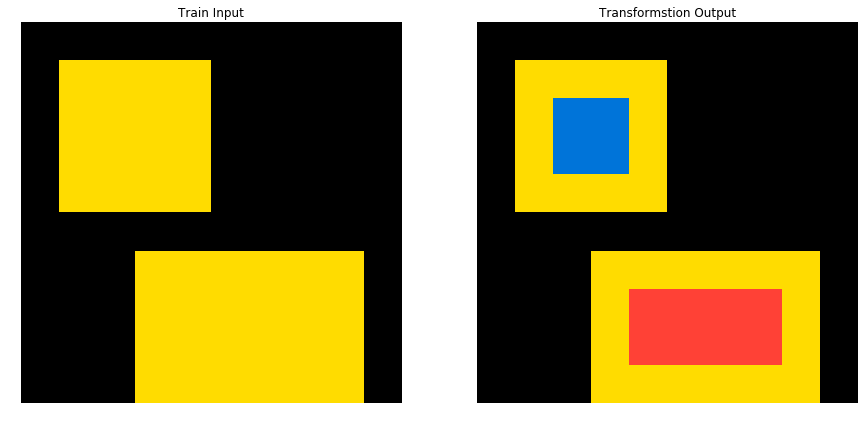

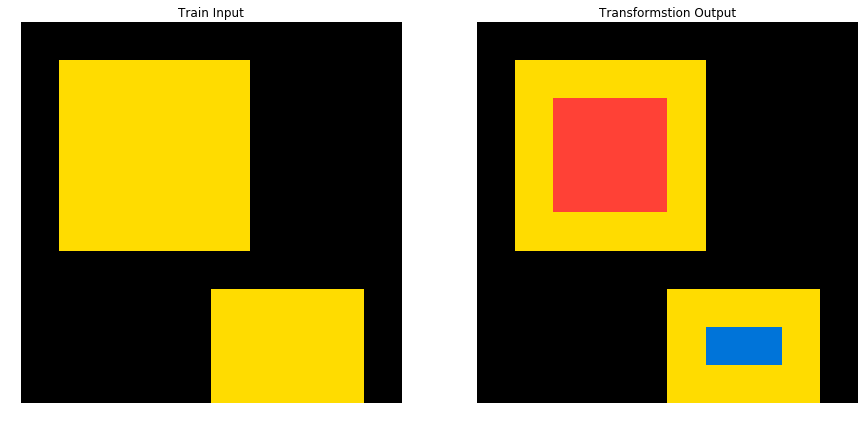

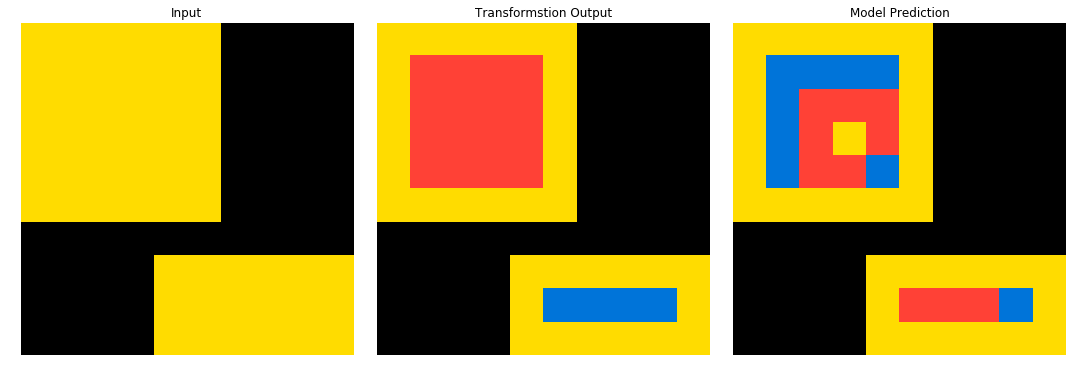

Made predictions for  6a1e5592
ensemble accuracy 0.9333333333333333



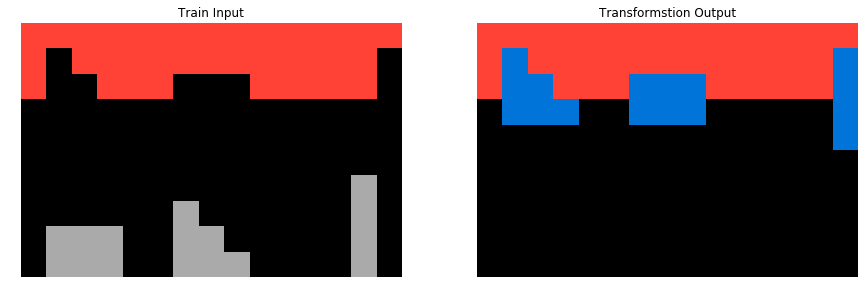

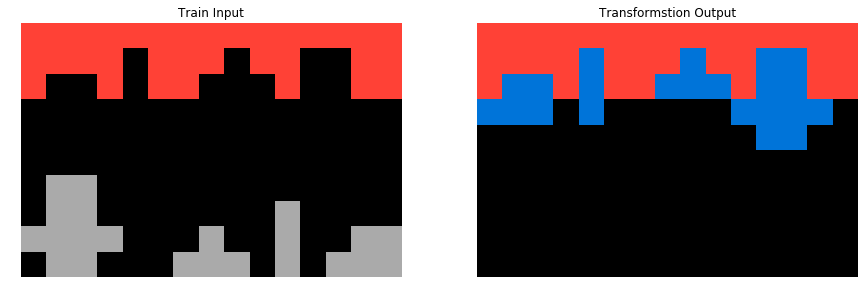

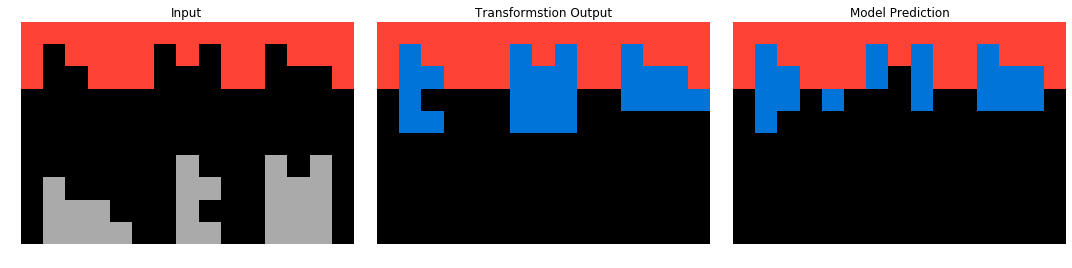

Made predictions for  6aa20dc0
ensemble accuracy 0.8842975206611571



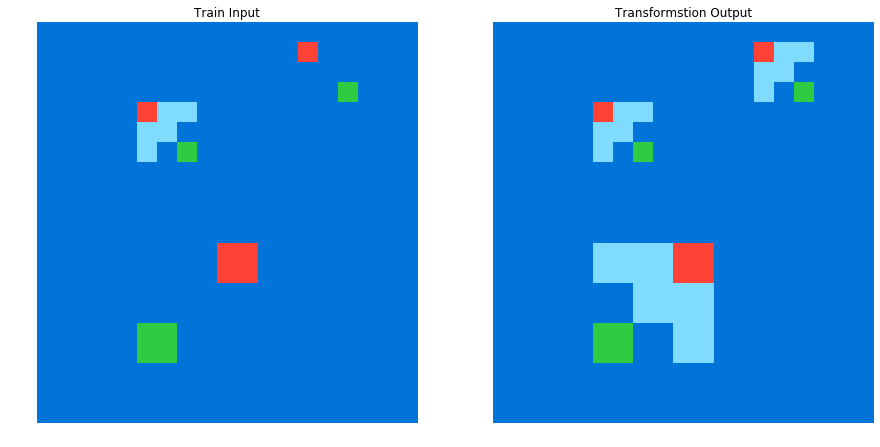

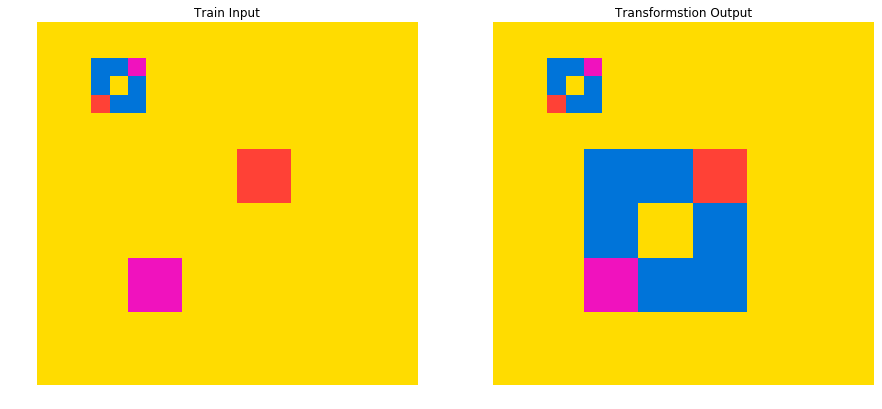

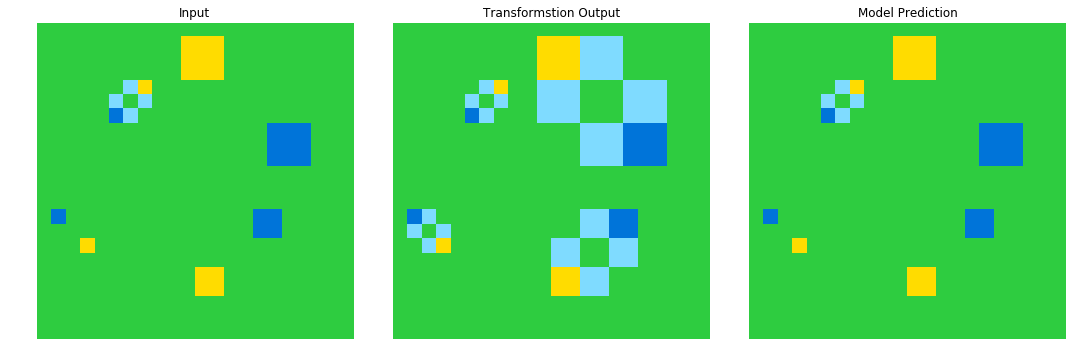

Number of input rows: 18 cols: 21
Number of target rows: 8 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6b9890af.json

Made predictions for  6c434453
ensemble accuracy 1.0
6c434453.json



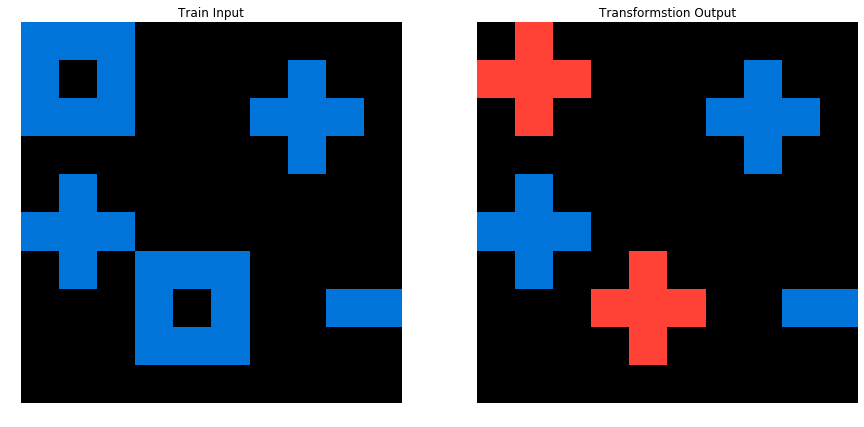

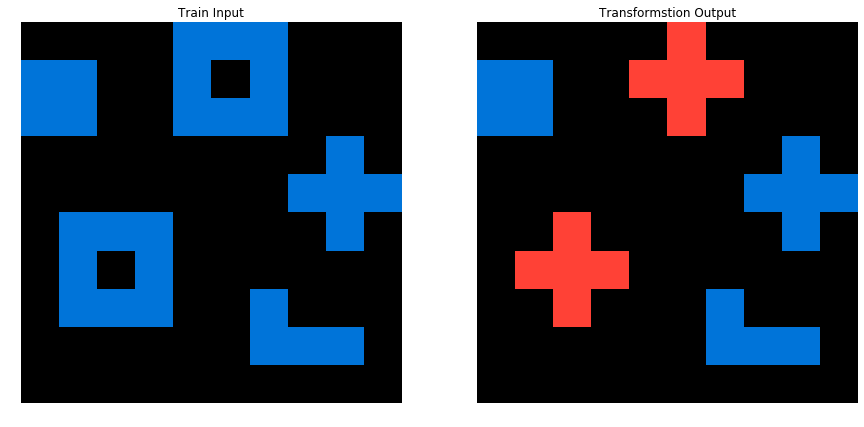

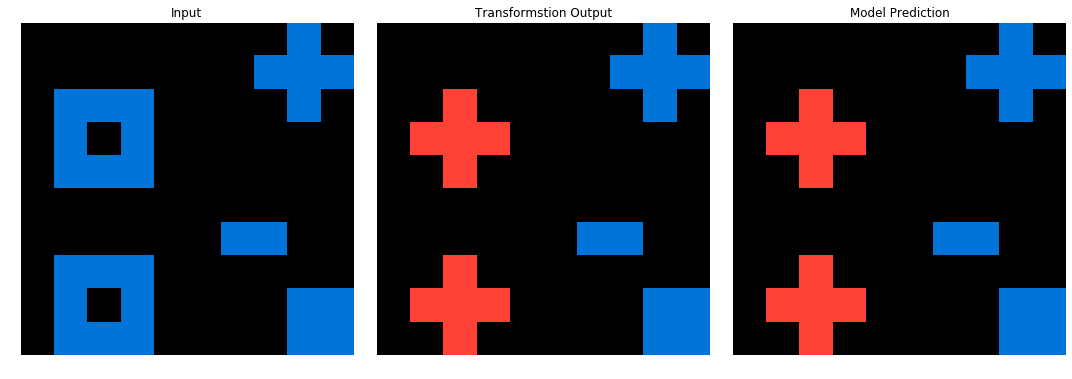

Made predictions for  6cdd2623
ensemble accuracy 0.8421052631578947



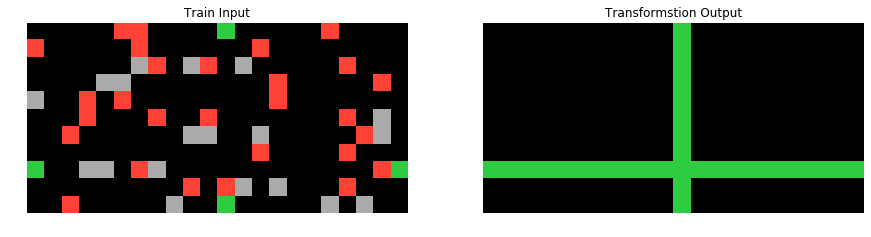

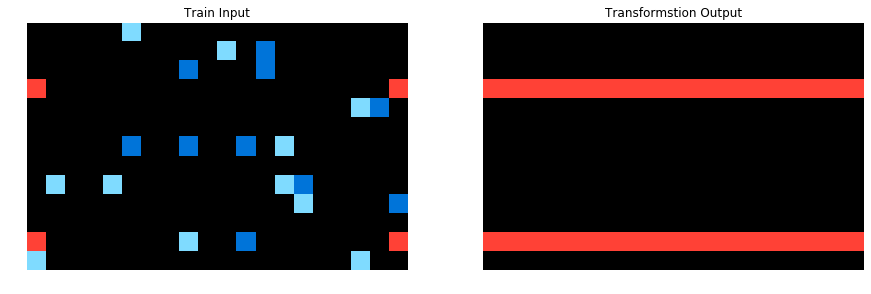

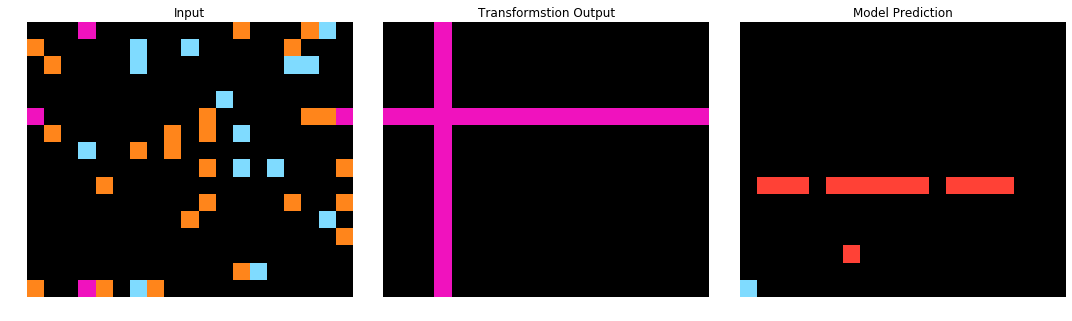

Made predictions for  6cf79266
ensemble accuracy 0.45



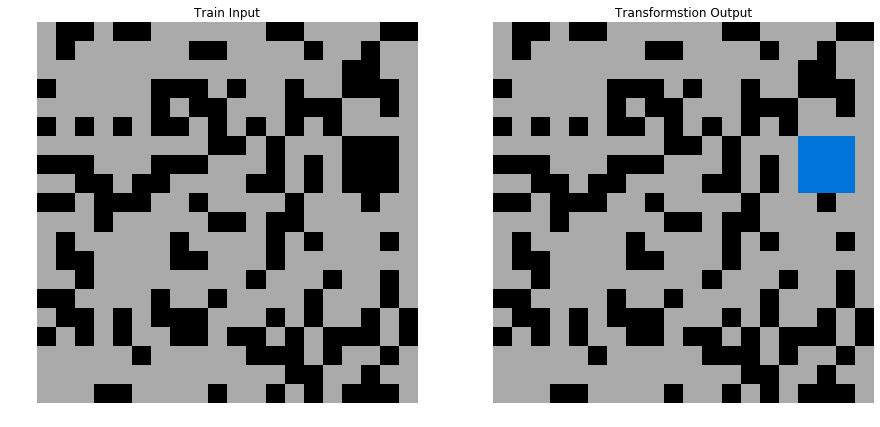

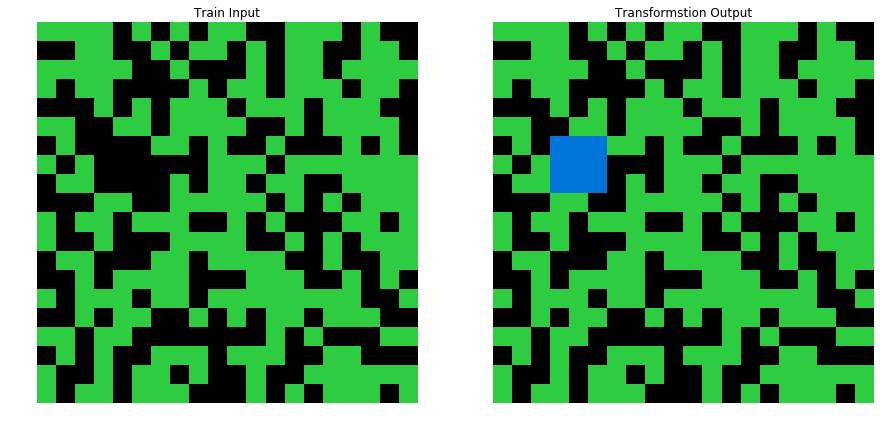

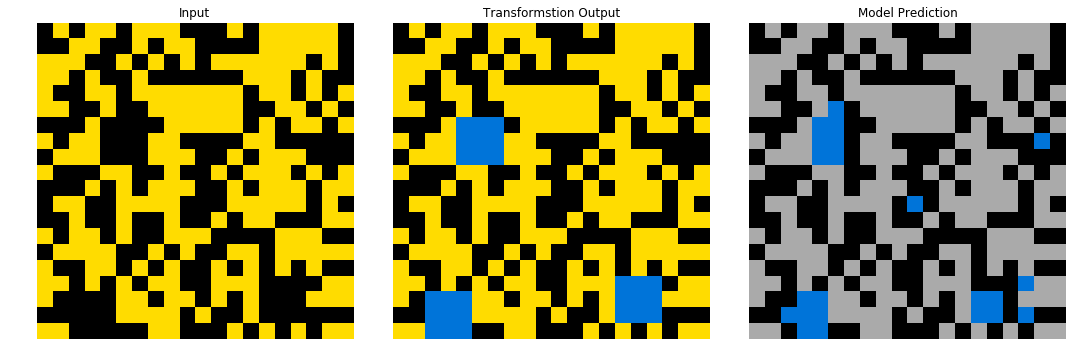

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  6d0160f0
ensemble accuracy 0.9669421487603306
6d0160f0.json



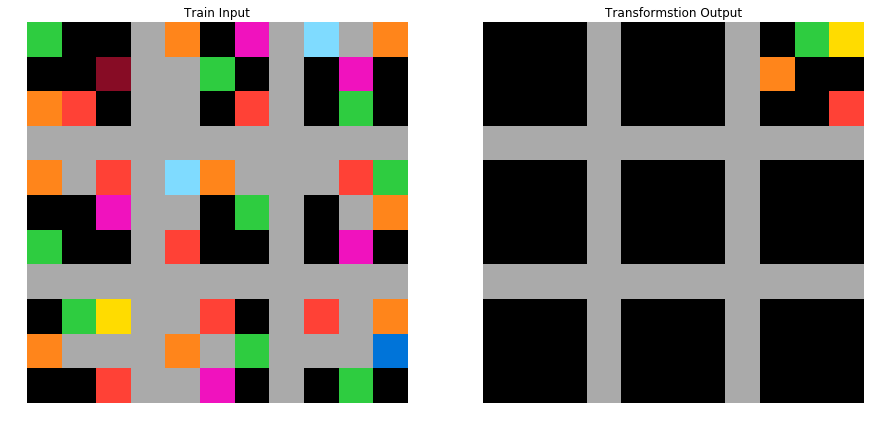

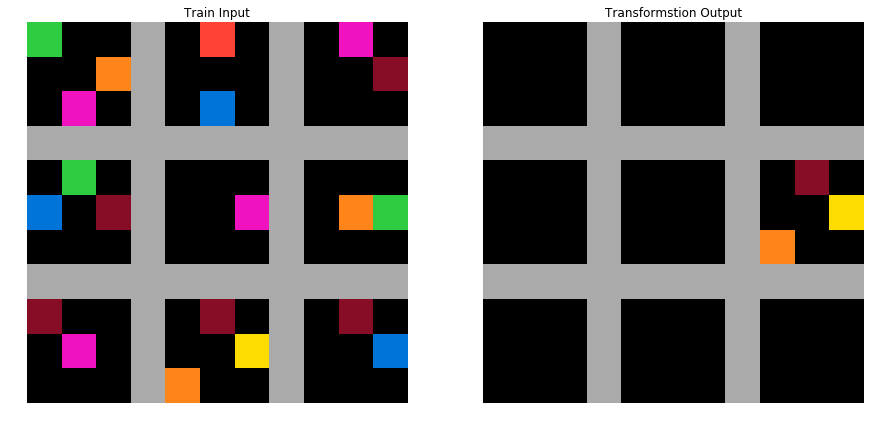

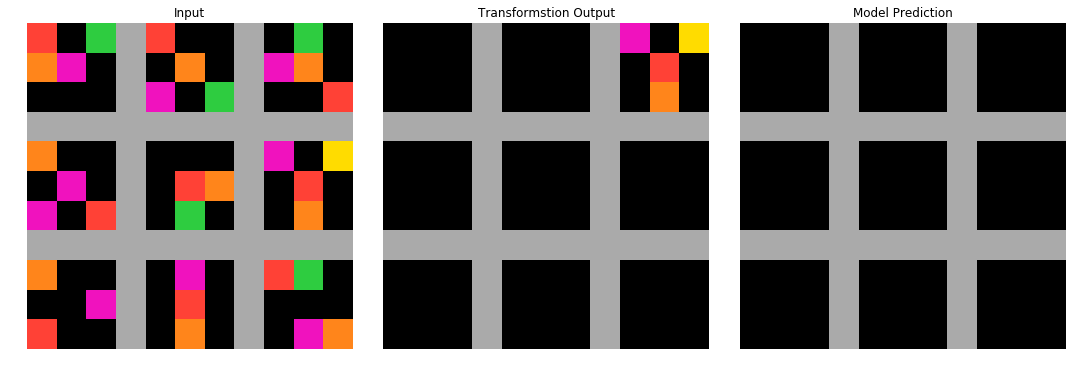

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6d0aefbc.json

Made predictions for  6d58a25d
ensemble accuracy 0.83



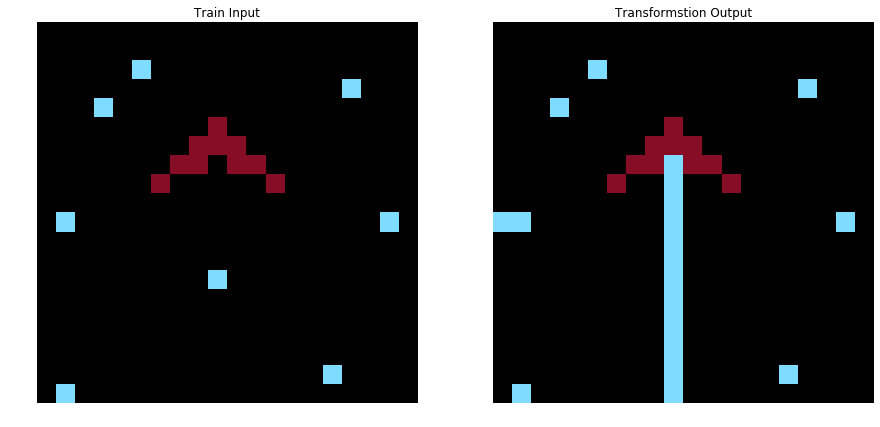

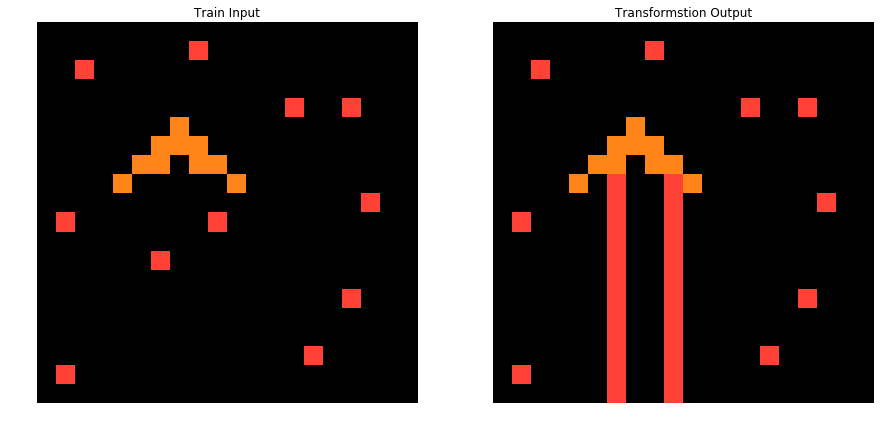

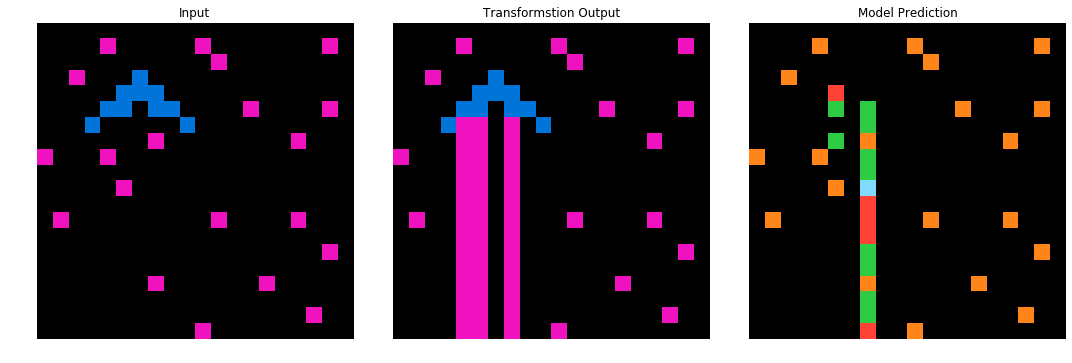

Made predictions for  6d75e8bb
ensemble accuracy 1.0
6d75e8bb.json



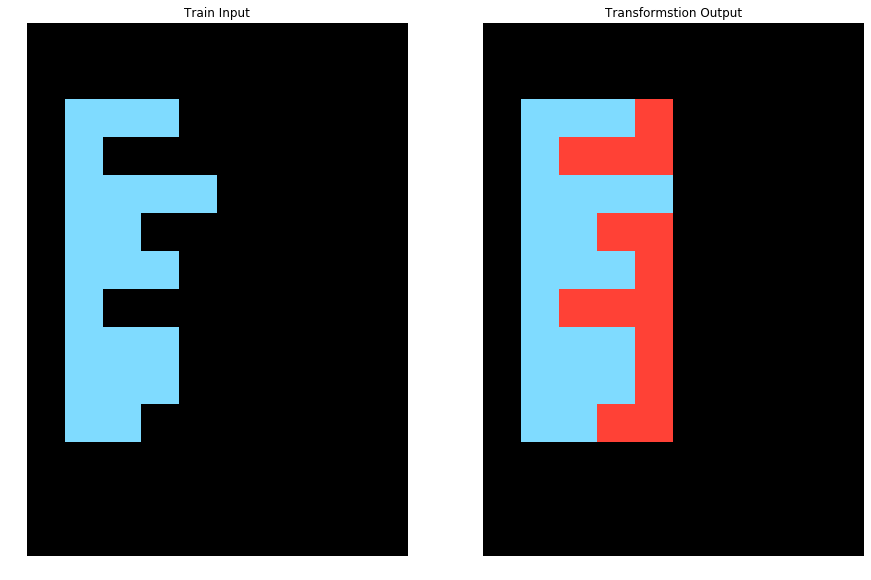

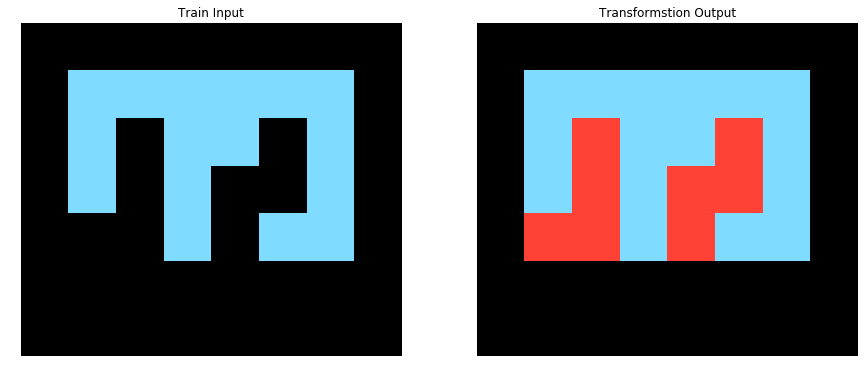

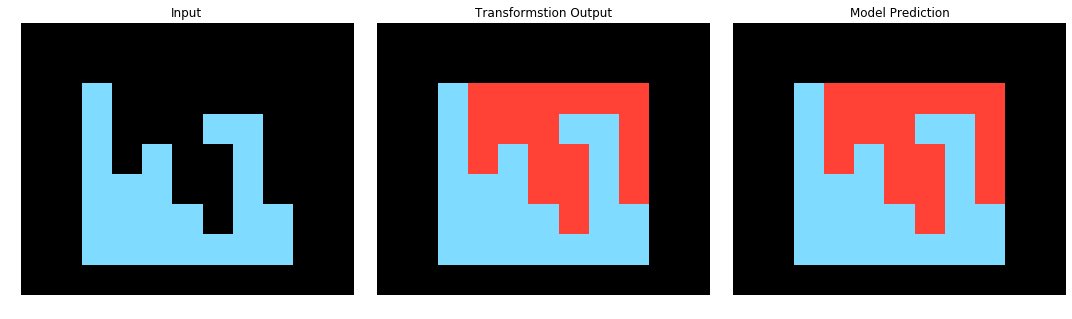

Made predictions for  6e02f1e3
ensemble accuracy 0.5555555555555556



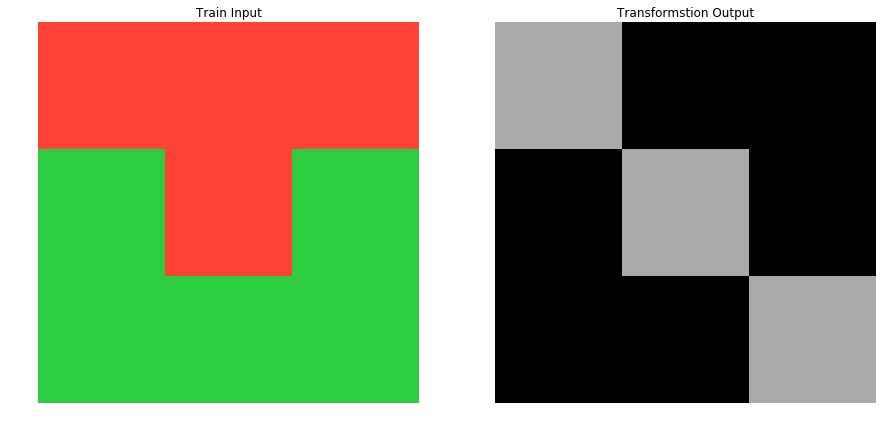

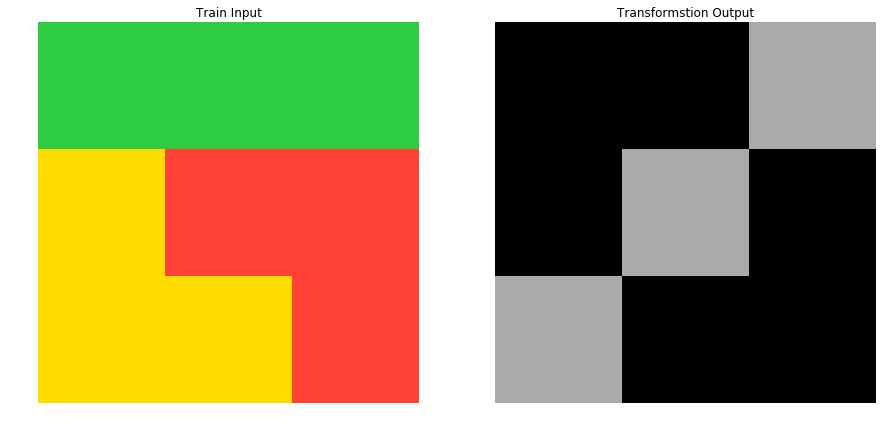

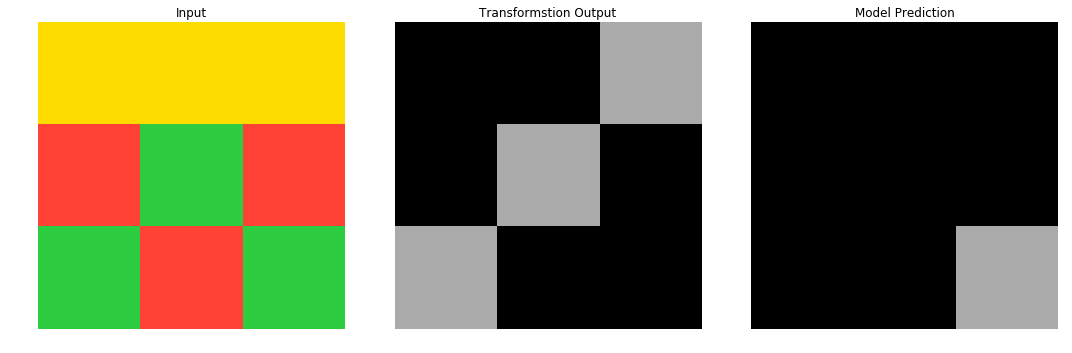

Made predictions for  6e19193c
ensemble accuracy 0.86



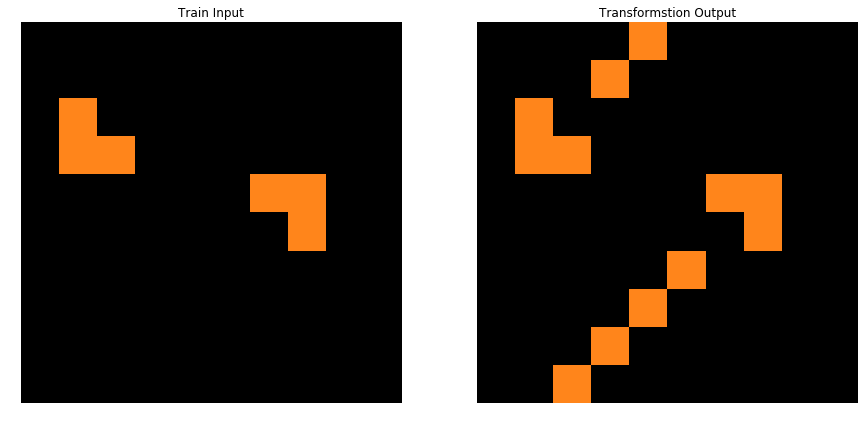

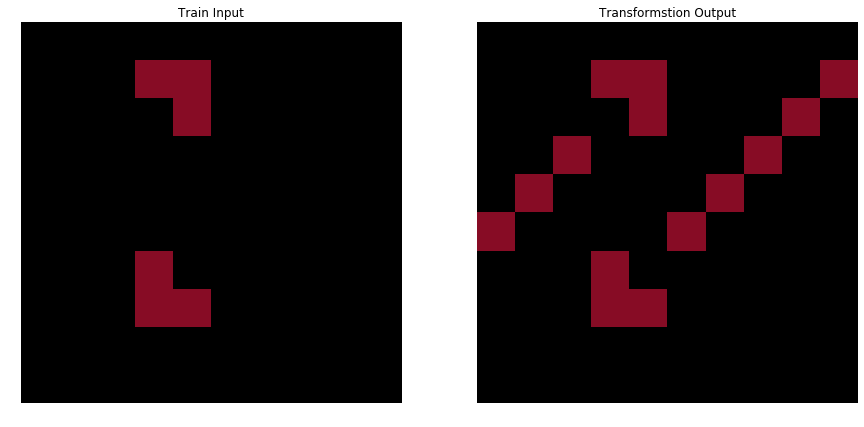

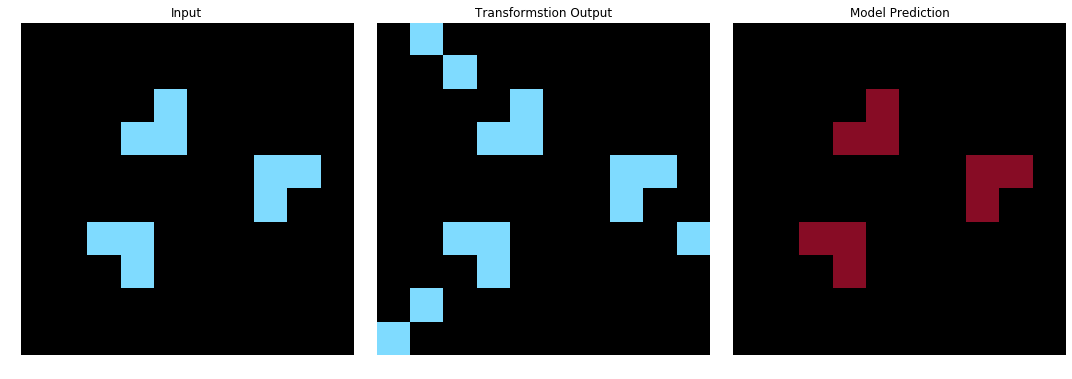

Made predictions for  6e82a1ae
ensemble accuracy 0.95
6e82a1ae.json



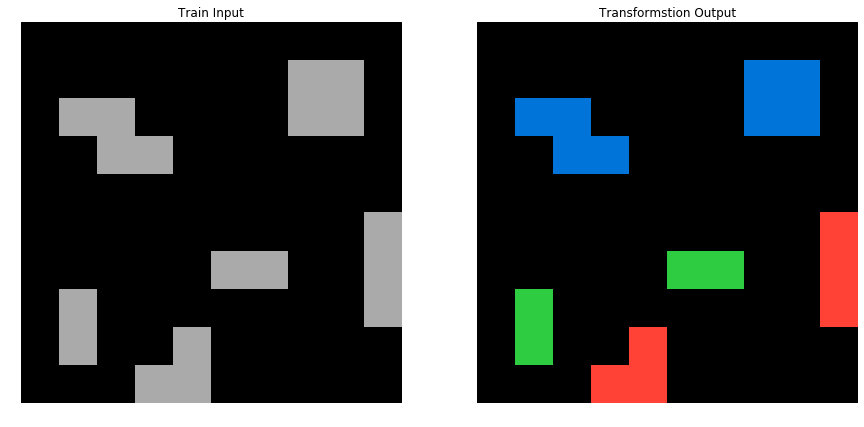

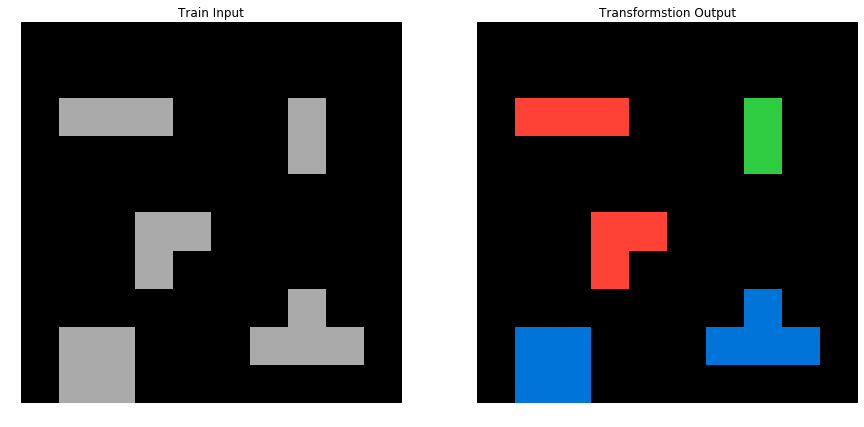

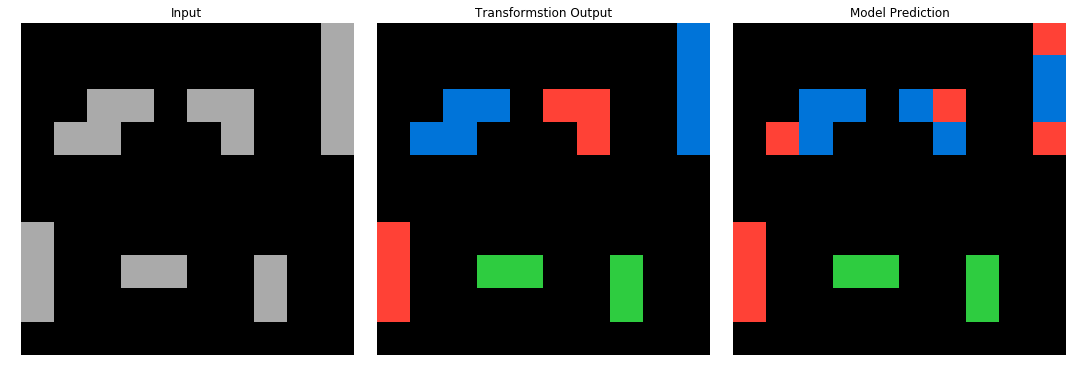

Number of input rows: 27 cols: 21
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6ecd11f4.json

Made predictions for  6f8cd79b
ensemble accuracy 1.0
6f8cd79b.json



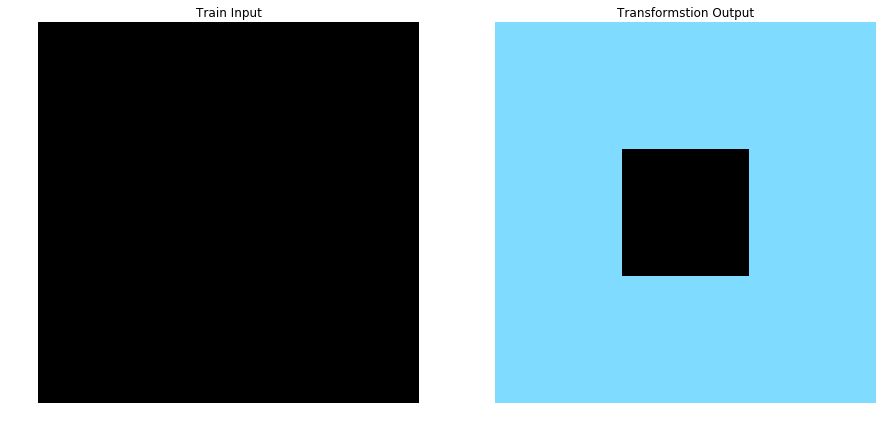

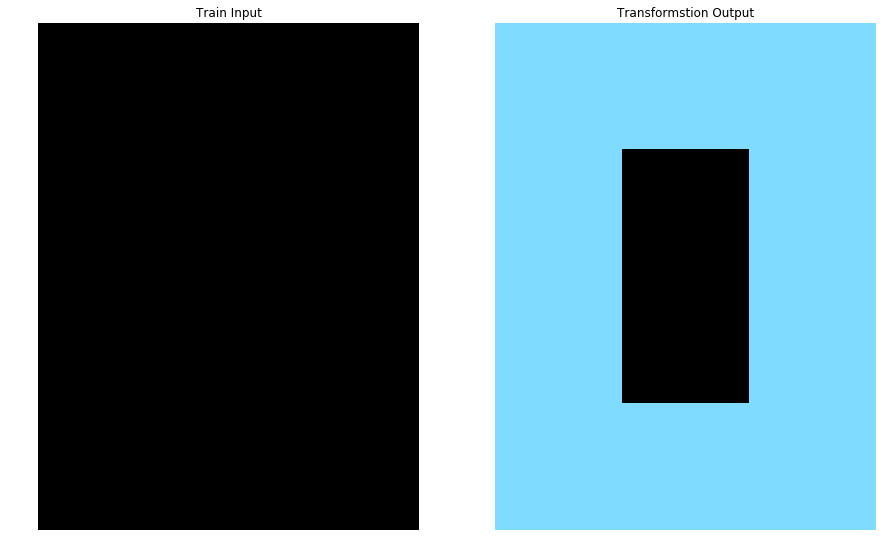

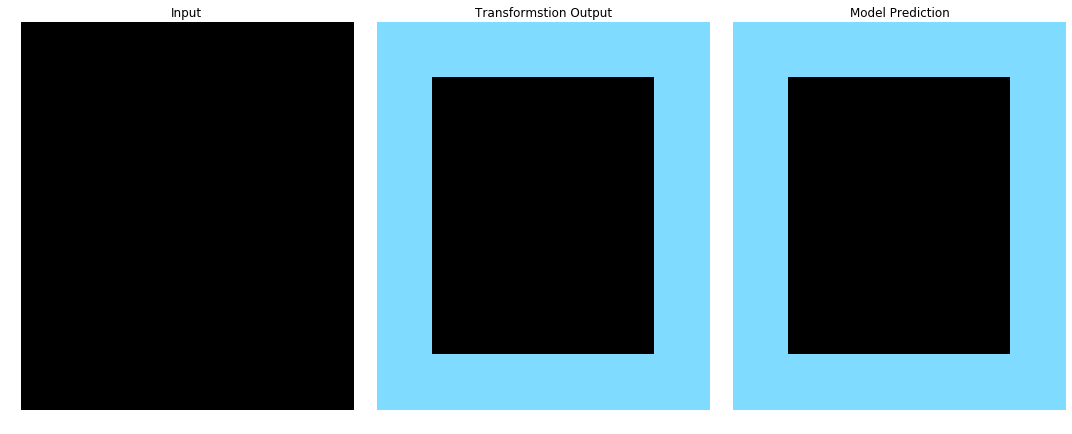

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6fa7a44f.json

Made predictions for  72322fa7
ensemble accuracy 0.9445983379501385



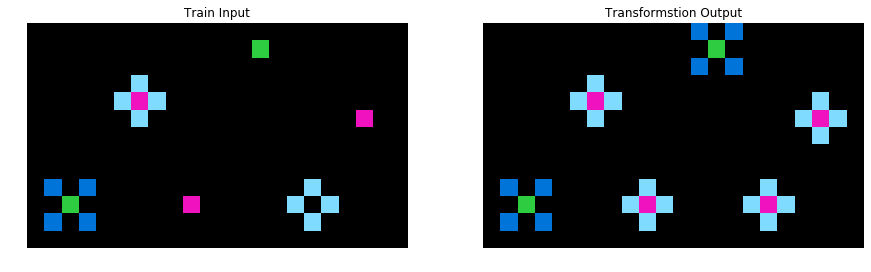

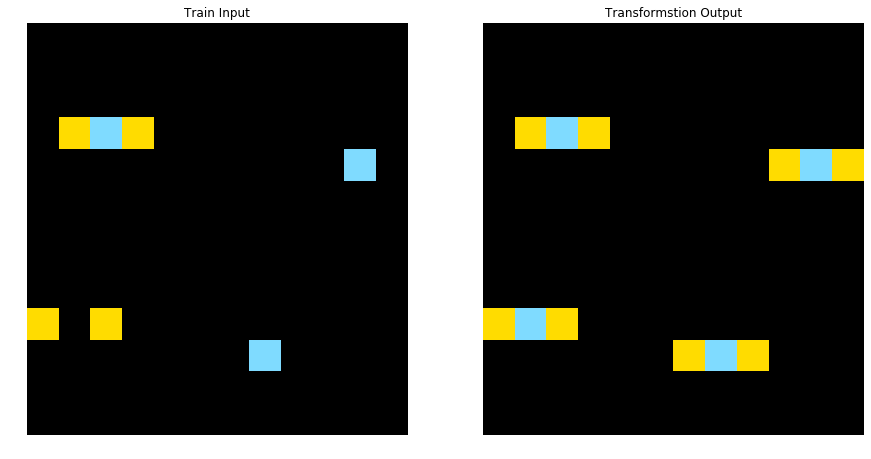

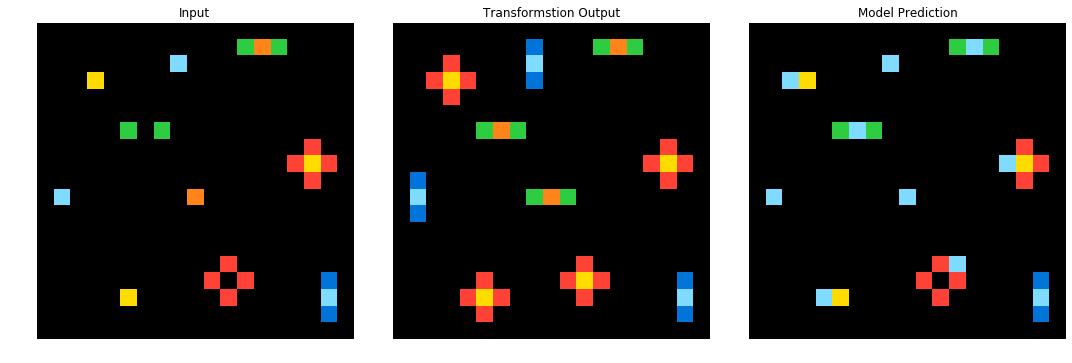

Number of input rows: 10 cols: 10
Number of target rows: 2 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/72ca375d.json

Made predictions for  73251a56
ensemble accuracy 0.8435374149659864



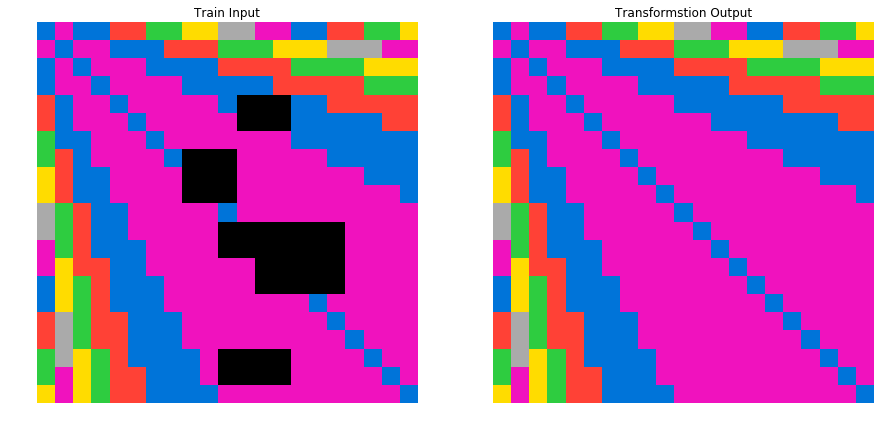

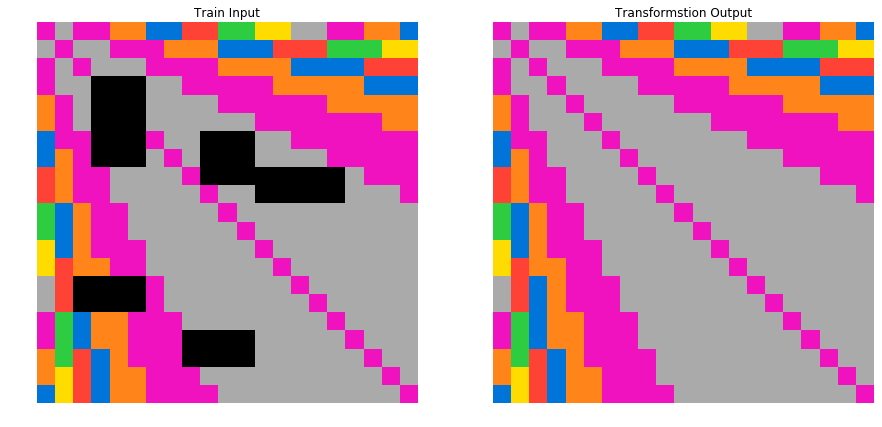

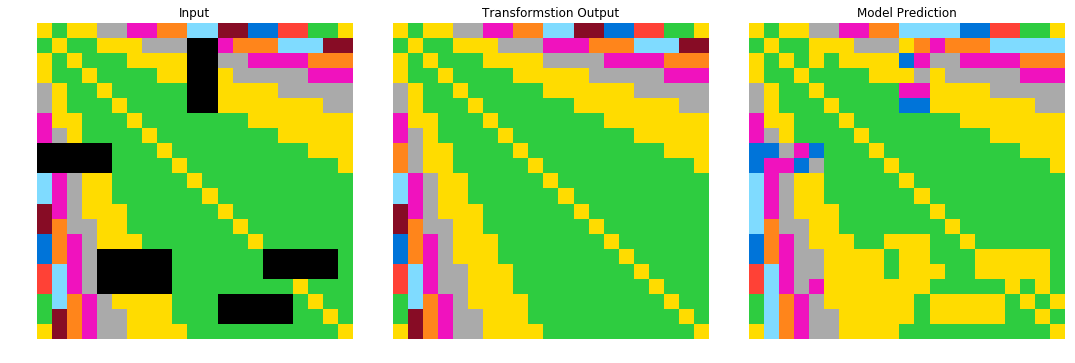

Made predictions for  7447852a
ensemble accuracy 0.8933333333333333



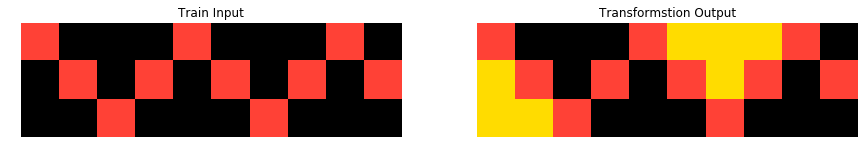

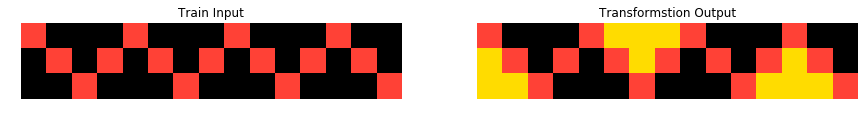

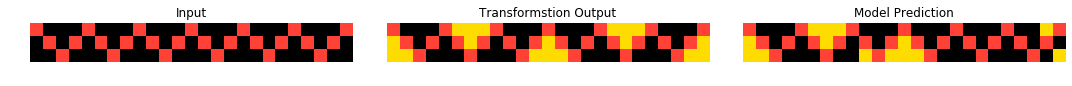

Number of input rows: 10 cols: 15
Number of target rows: 4 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/7468f01a.json

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/746b3537.json

Made predictions for  74dd1130
ensemble accuracy 0.1111111111111111



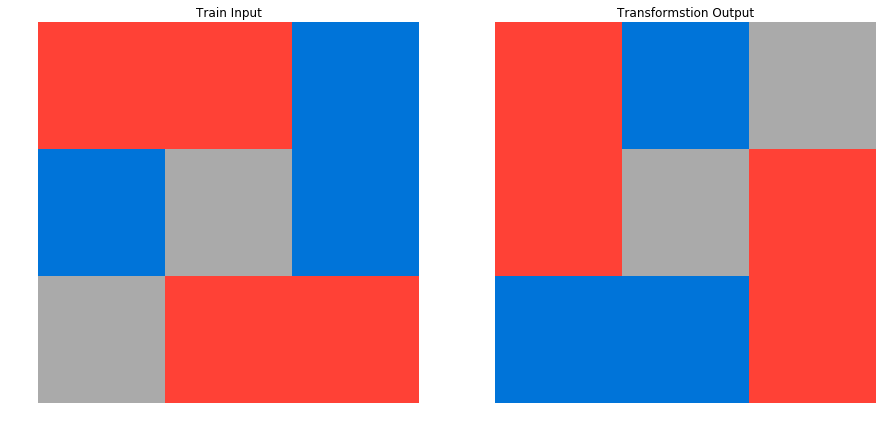

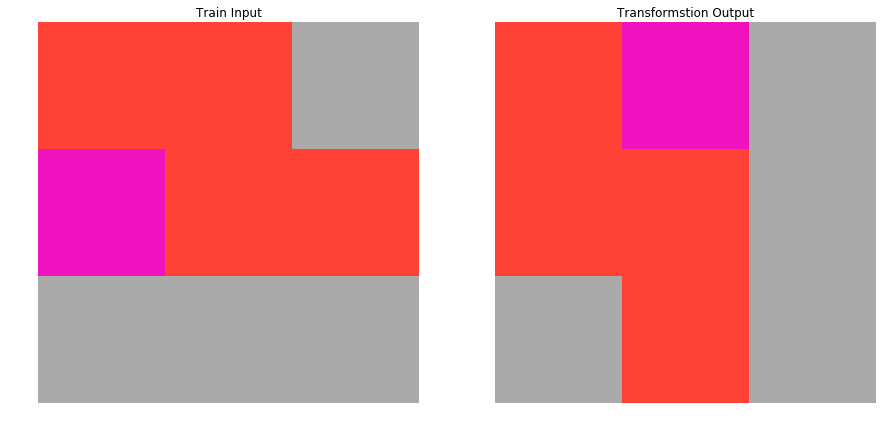

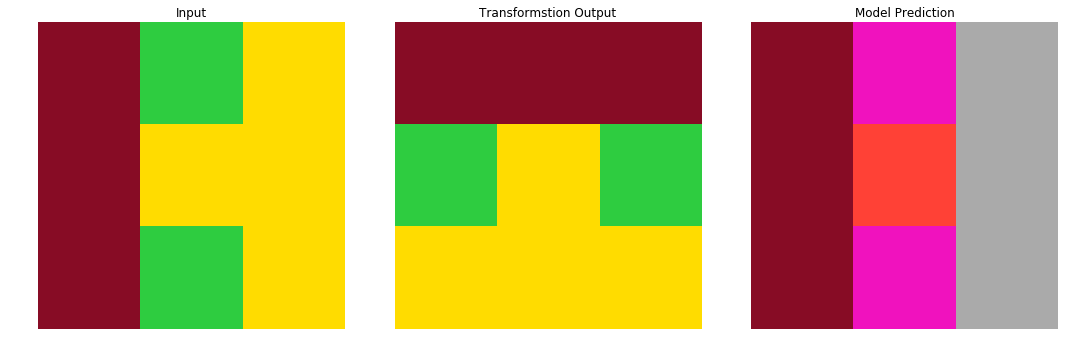

Number of input rows: 8 cols: 8
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/75b8110e.json

Made predictions for  760b3cac
ensemble accuracy 0.8888888888888888



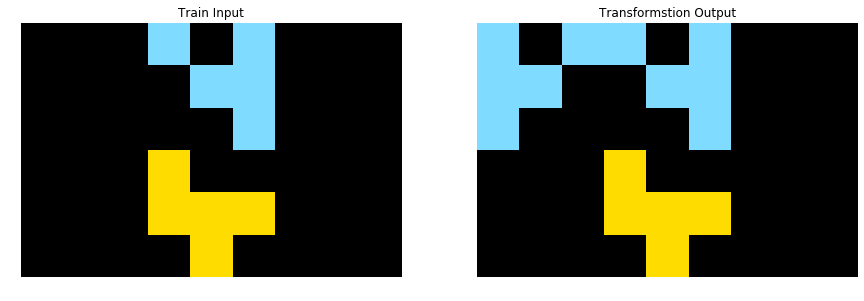

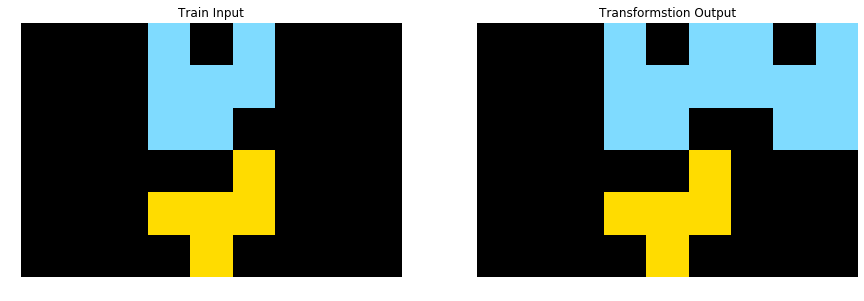

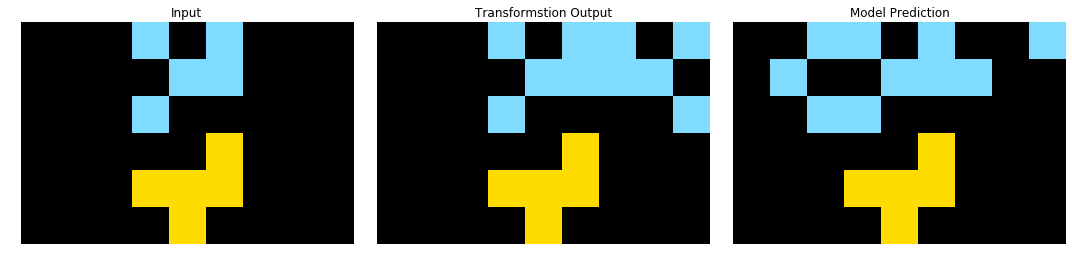

Made predictions for  776ffc46
ensemble accuracy 0.9425



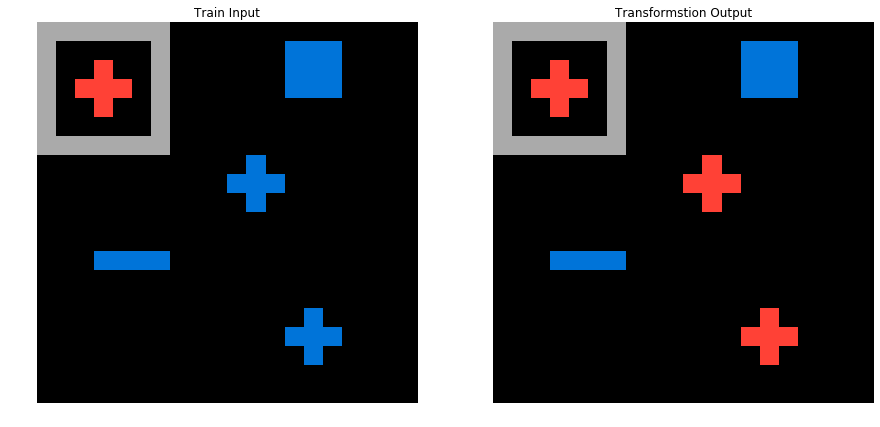

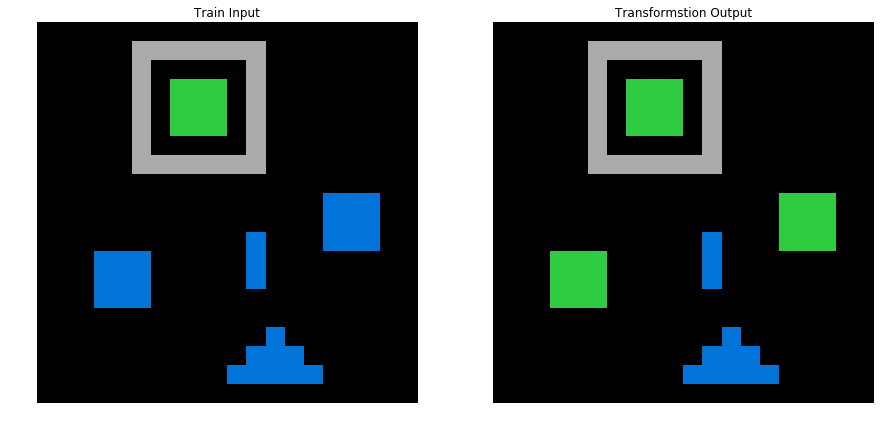

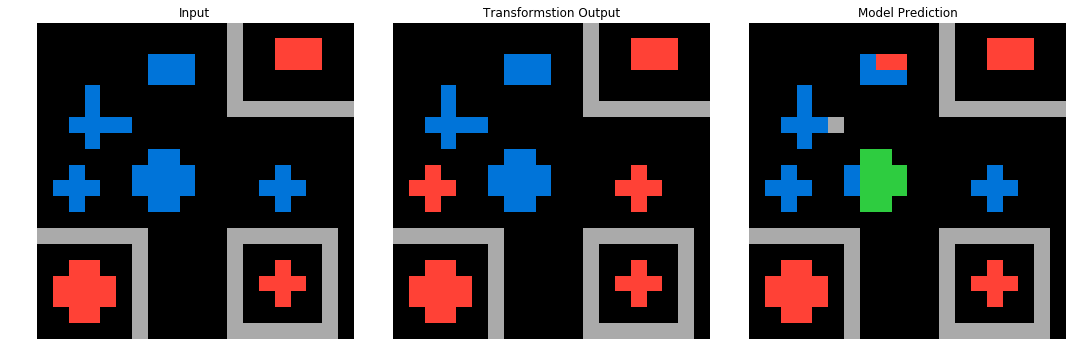

Number of input rows: 8 cols: 8
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/77fdfe62.json

Number of input rows: 20 cols: 20
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/780d0b14.json

Number of input rows: 29 cols: 29
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/7837ac64.json

Made predictions for  794b24be
ensemble accuracy 0.6666666666666666



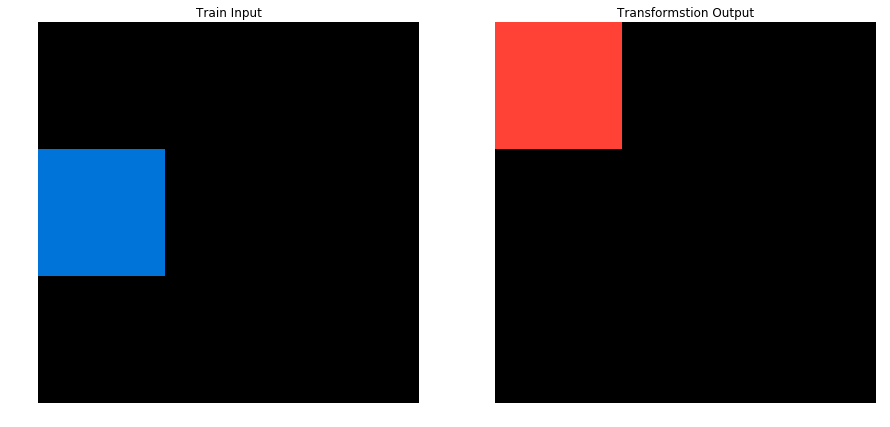

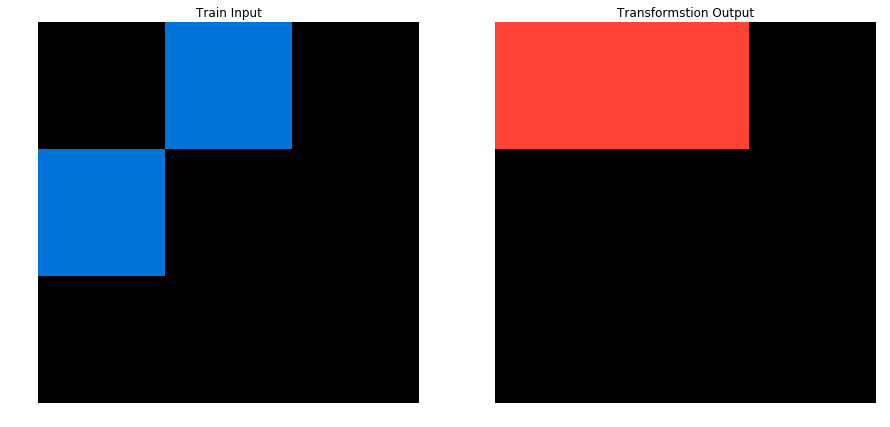

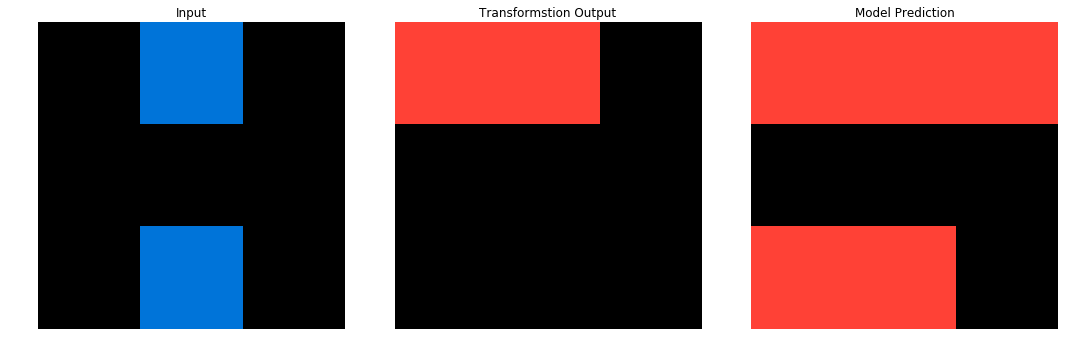

Made predictions for  794b24be
ensemble accuracy 0.6666666666666666



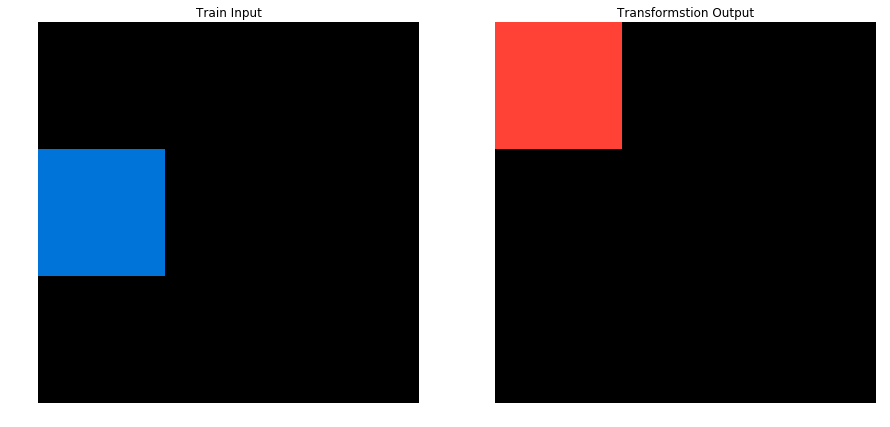

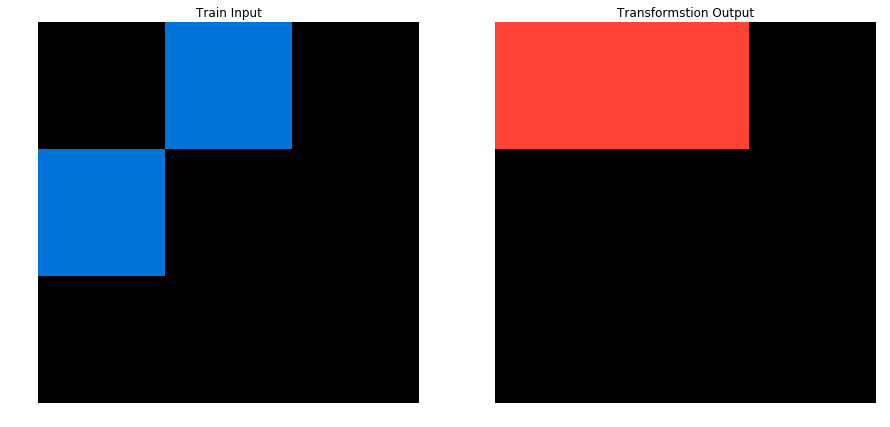

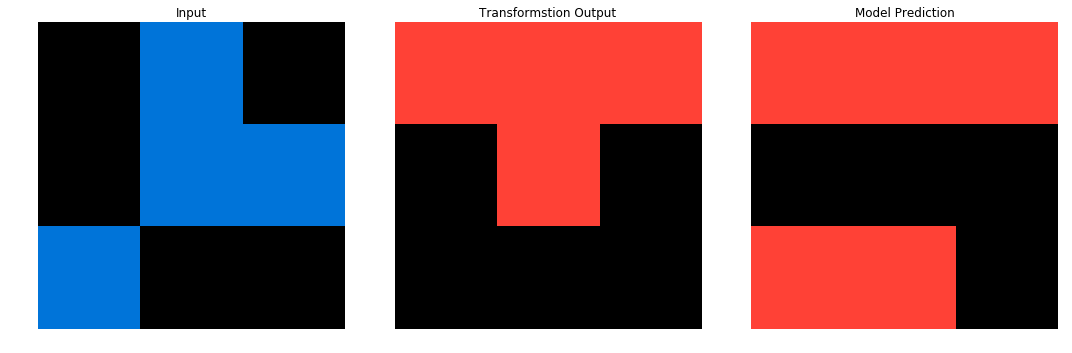

Made predictions for  7b6016b9
ensemble accuracy 0.6963636363636364



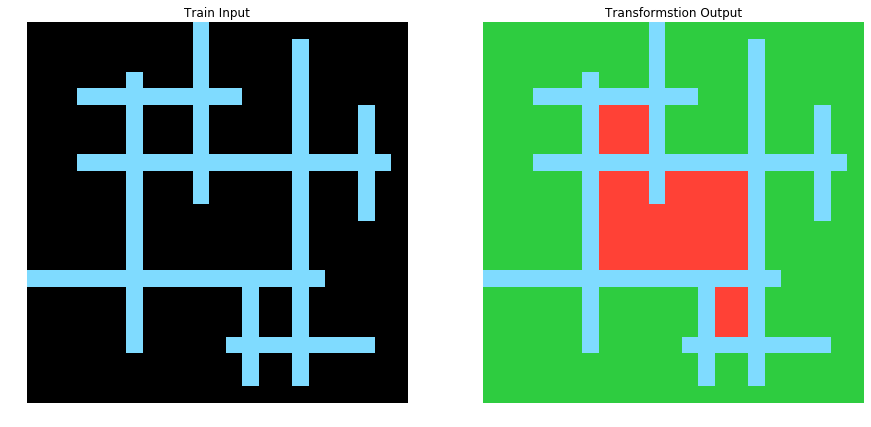

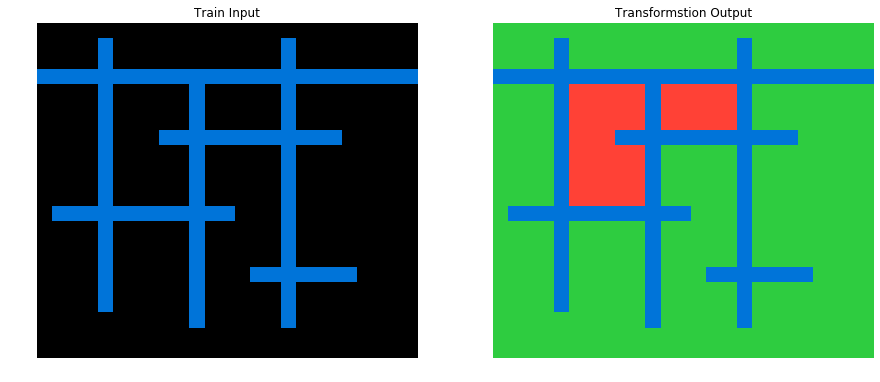

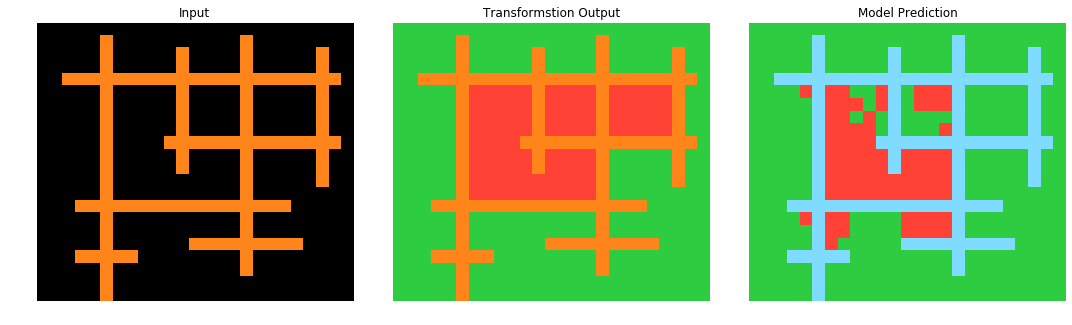

Number of input rows: 4 cols: 8
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/7b7f7511.json

Number of input rows: 9 cols: 9
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/7c008303.json

Made predictions for  7ddcd7ec
ensemble accuracy 0.85



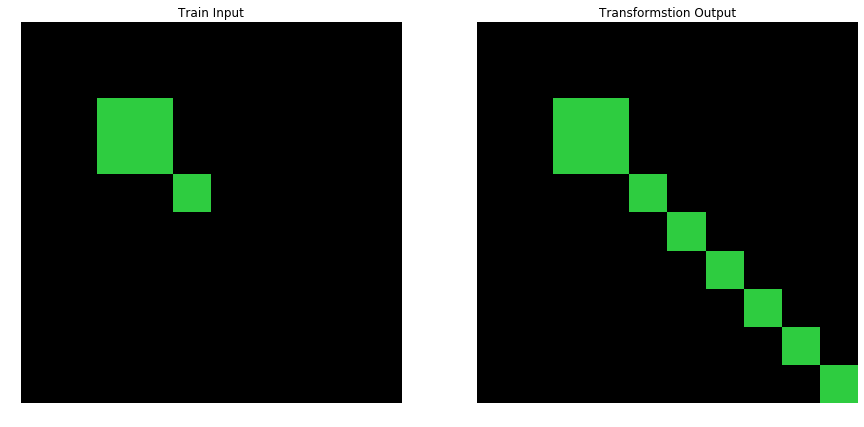

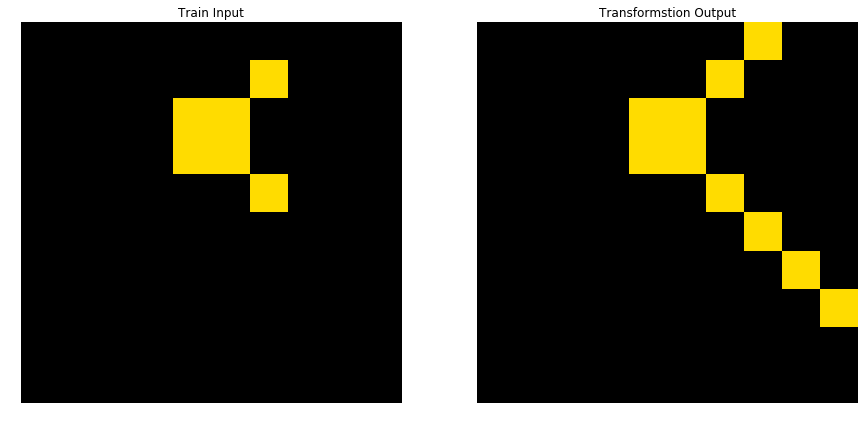

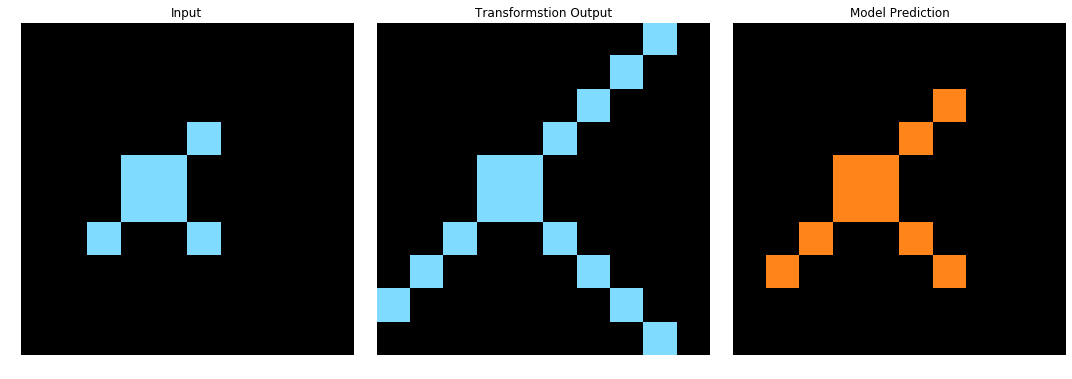

Made predictions for  7df24a62
ensemble accuracy 0.9168241965973535



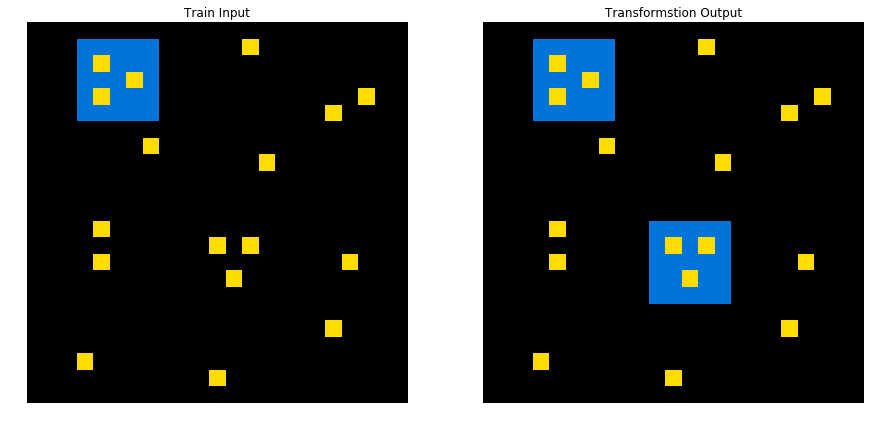

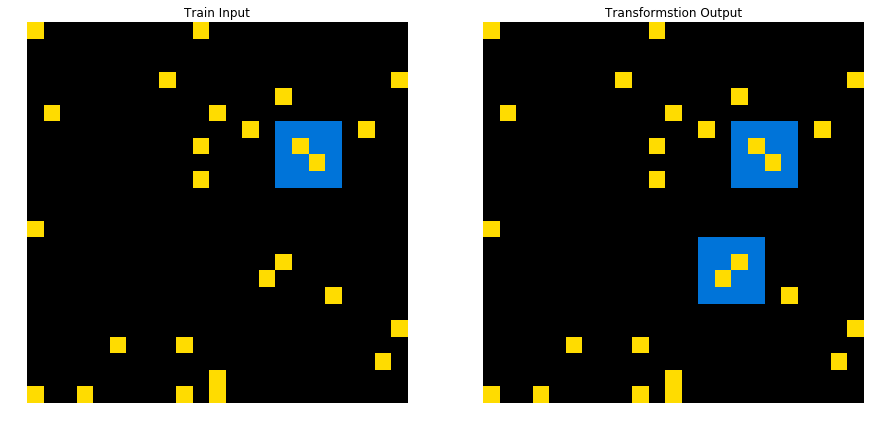

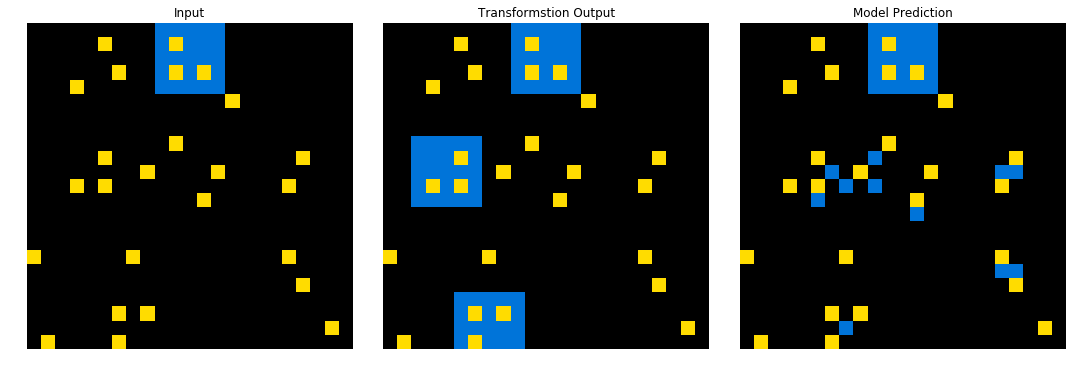

Made predictions for  7e0986d6
ensemble accuracy 0.5392156862745098



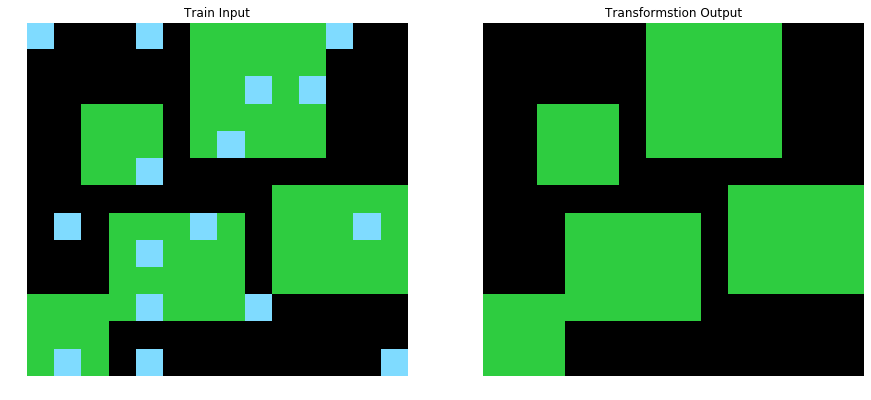

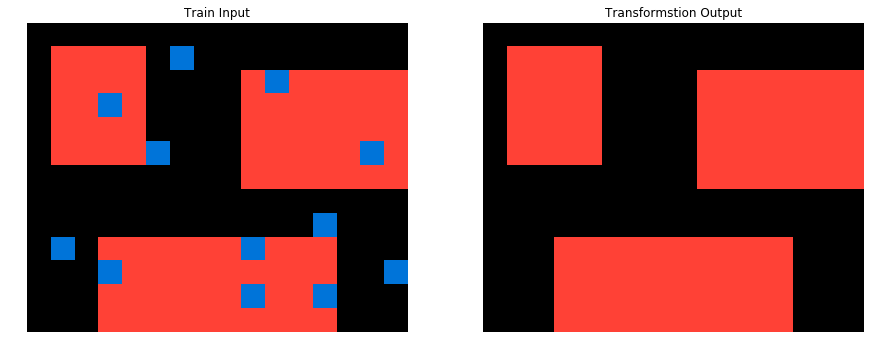

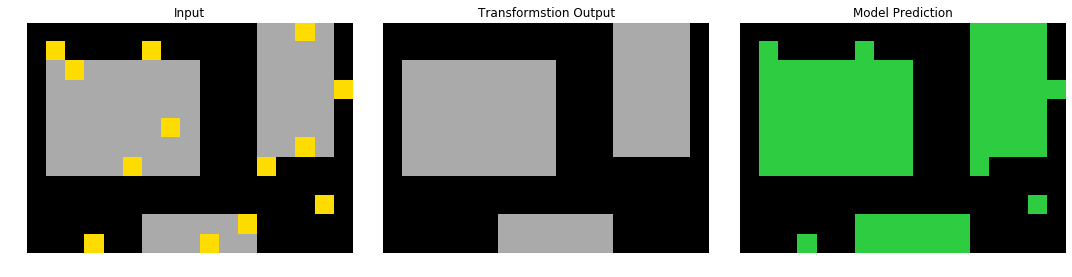

Made predictions for  7f4411dc
ensemble accuracy 0.78



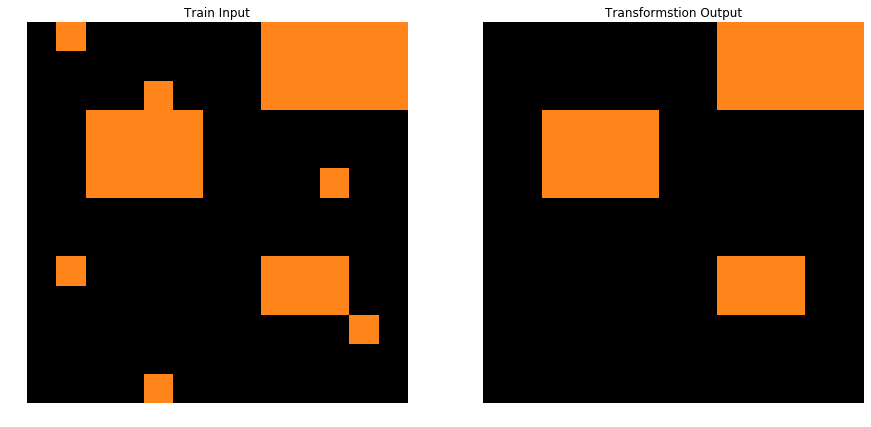

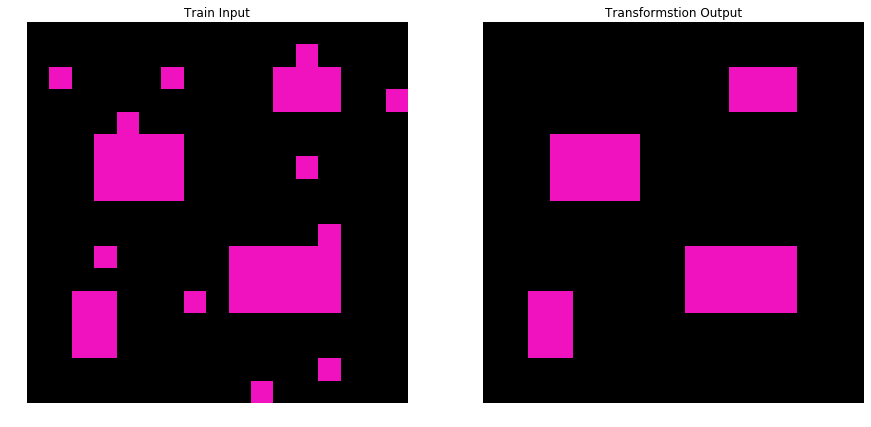

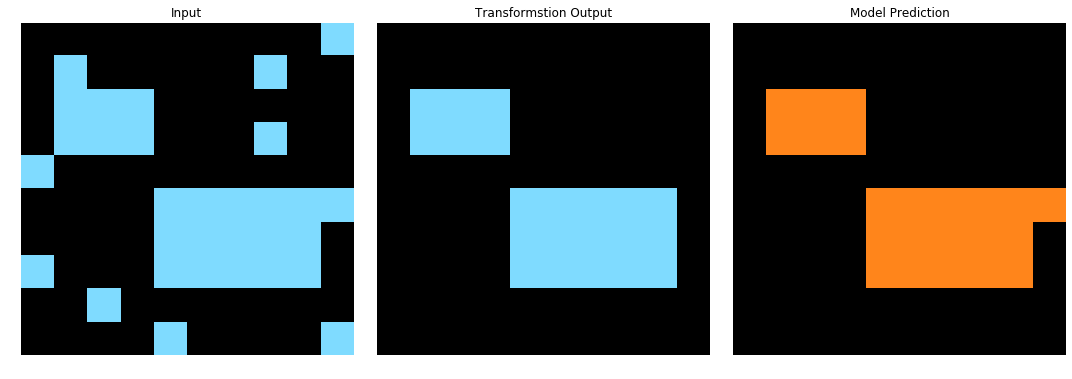

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/7fe24cdd.json

Number of input rows: 16 cols: 18
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/80af3007.json

Made predictions for  810b9b61
ensemble accuracy 0.9027777777777778



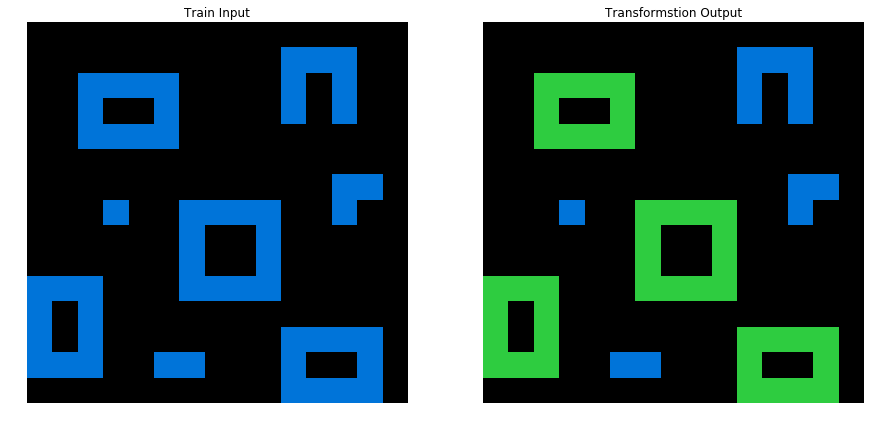

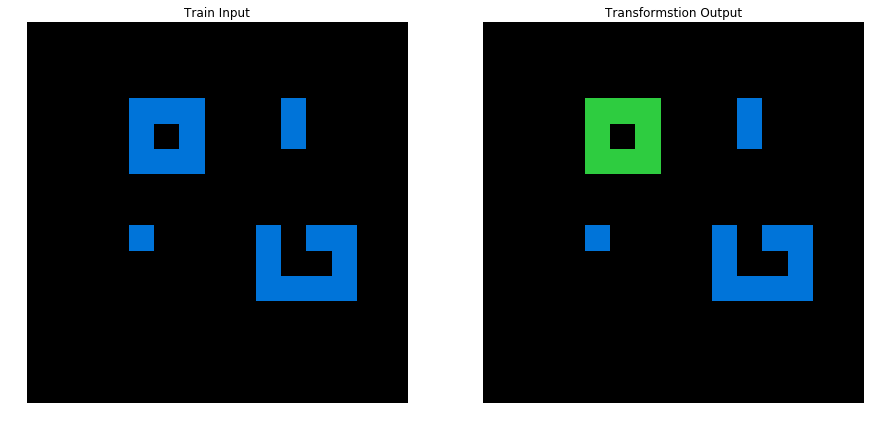

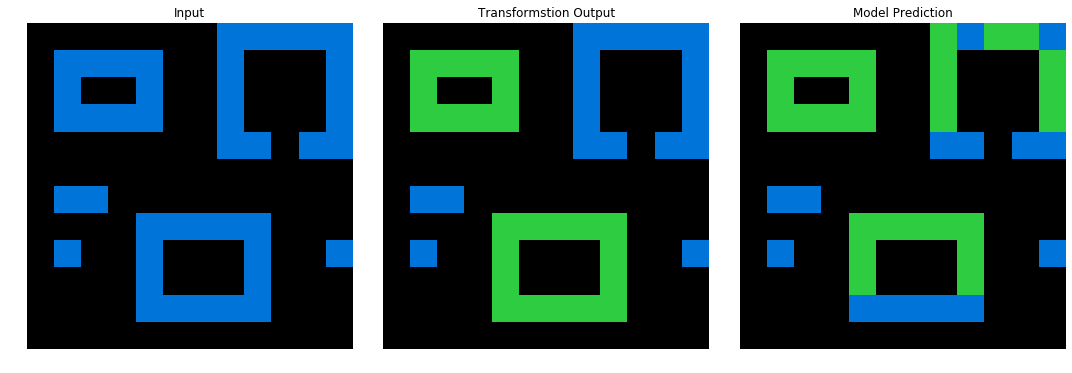

Made predictions for  82819916
ensemble accuracy 0.8428571428571429



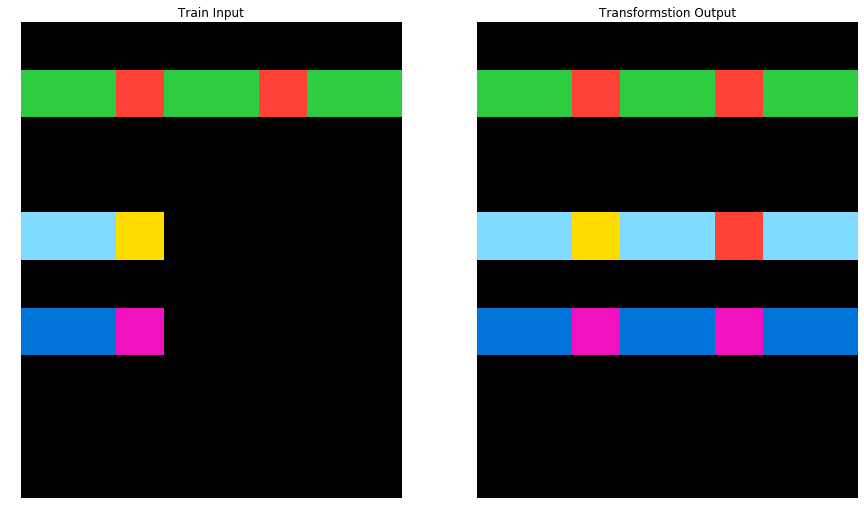

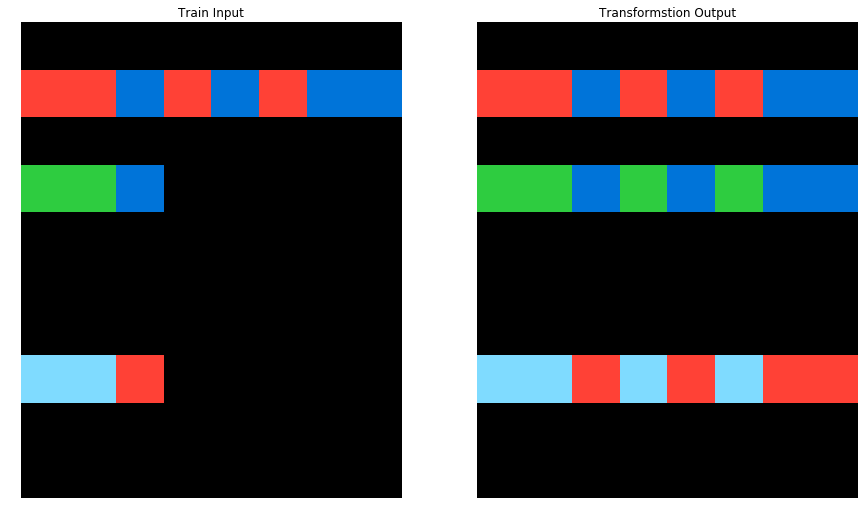

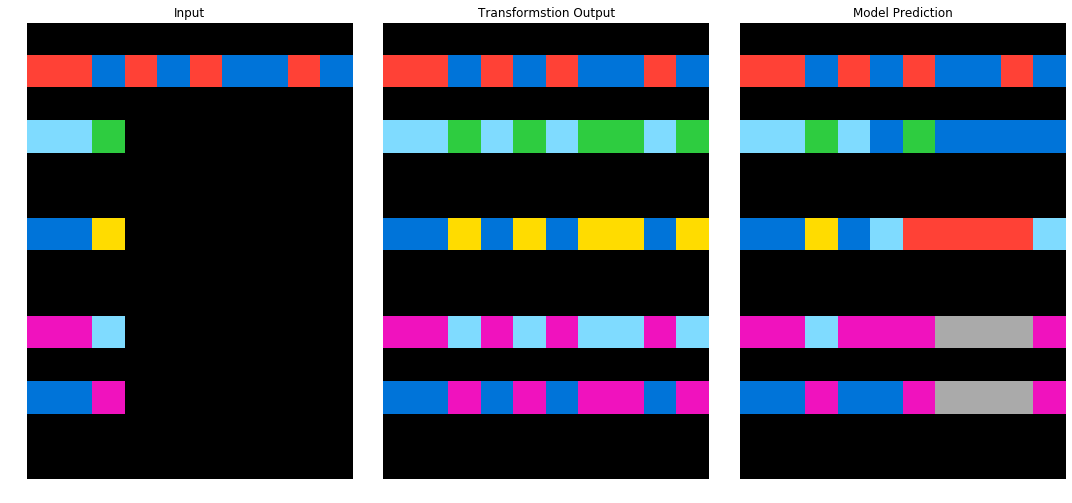

Made predictions for  83302e8f
ensemble accuracy 0.3991769547325103



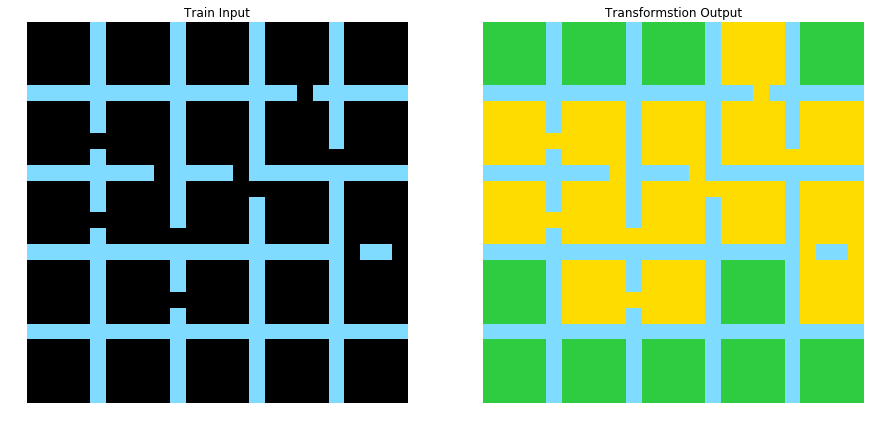

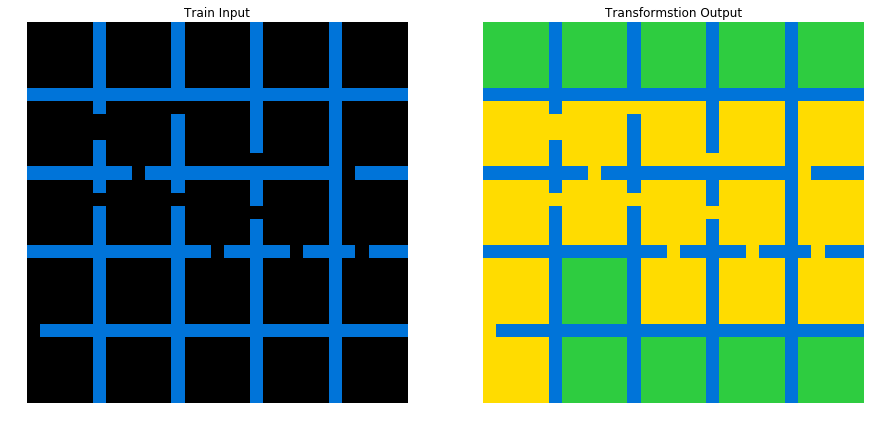

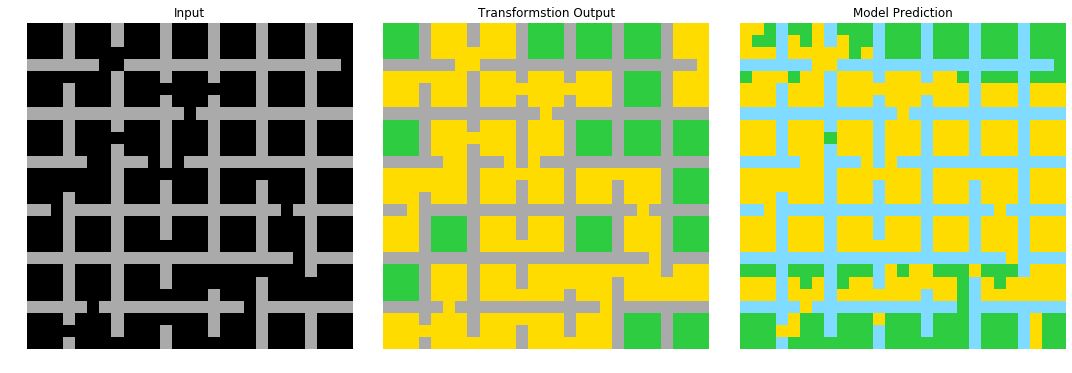

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  834ec97d
ensemble accuracy 0.8472222222222222



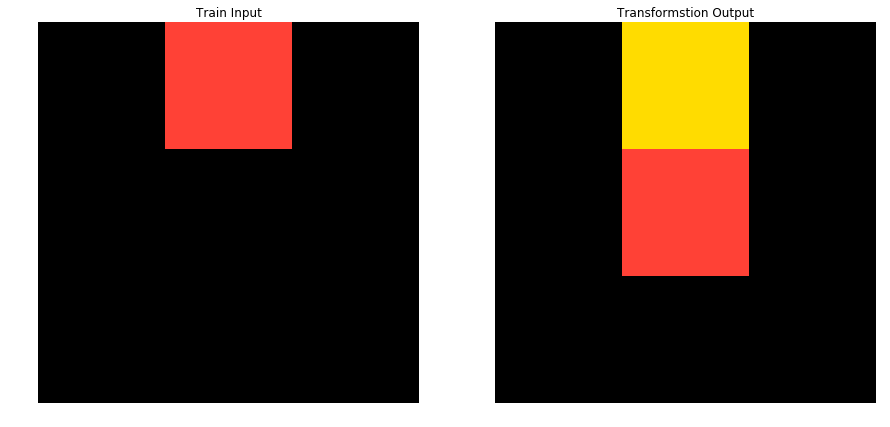

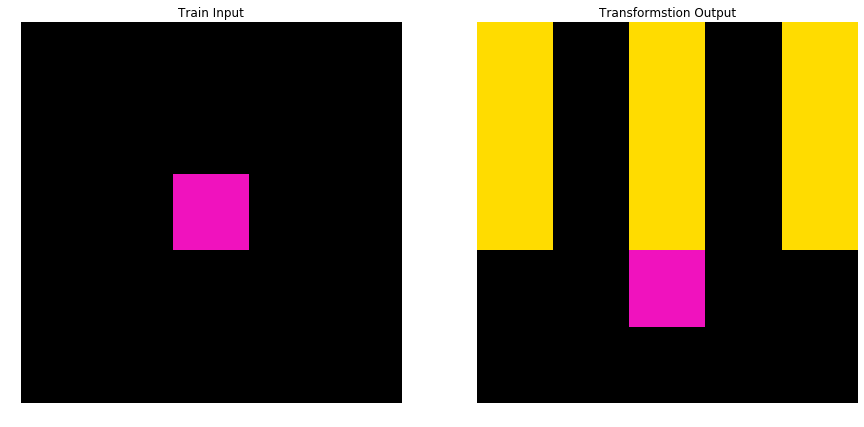

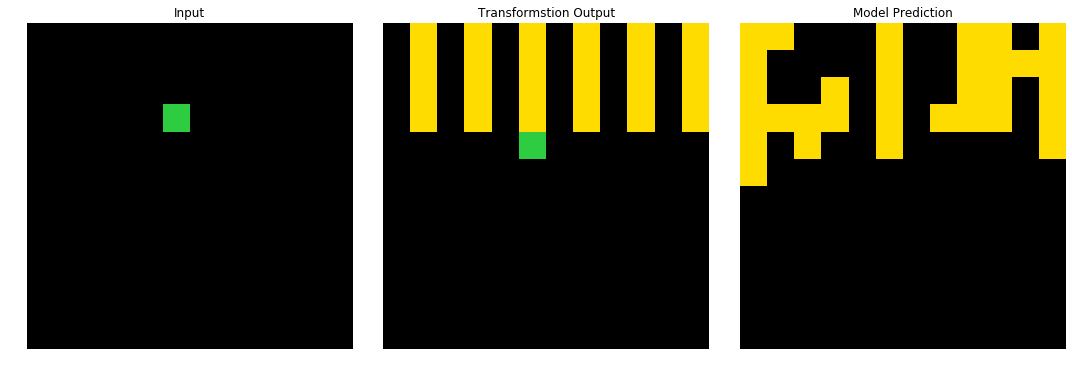

Made predictions for  8403a5d5
ensemble accuracy 0.46



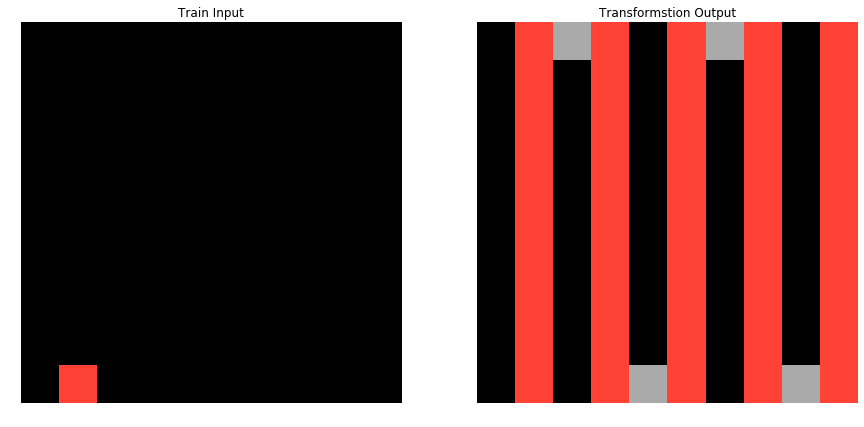

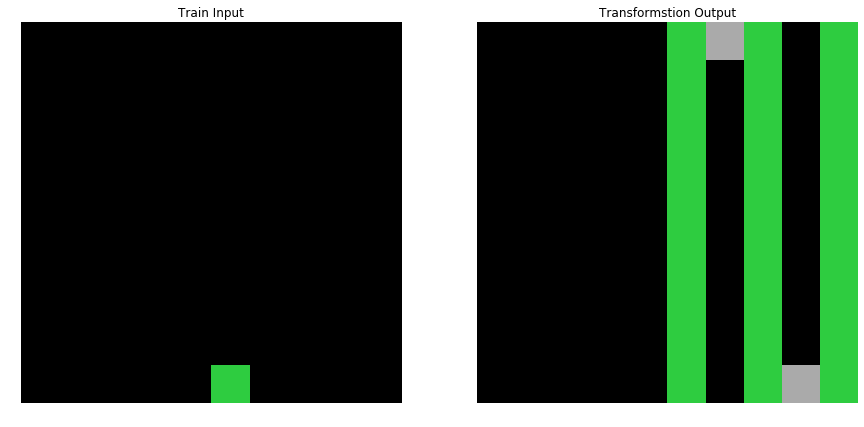

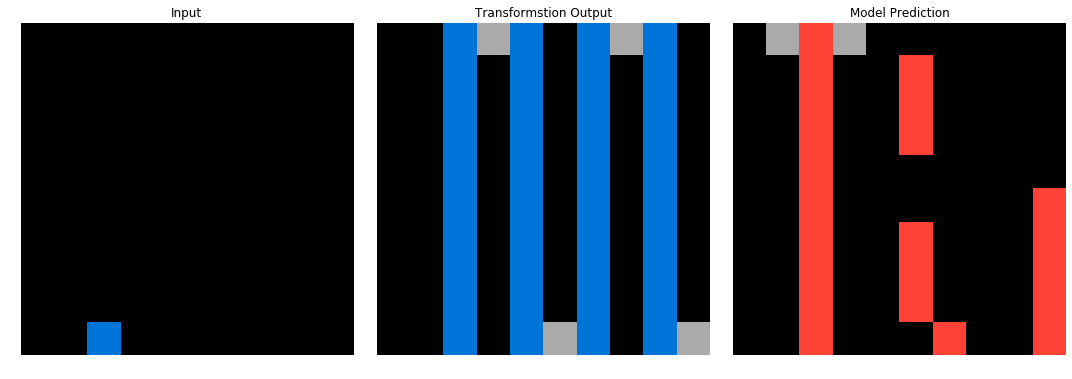

Number of input rows: 13 cols: 13
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/846bdb03.json

Made predictions for  855e0971
ensemble accuracy 0.6



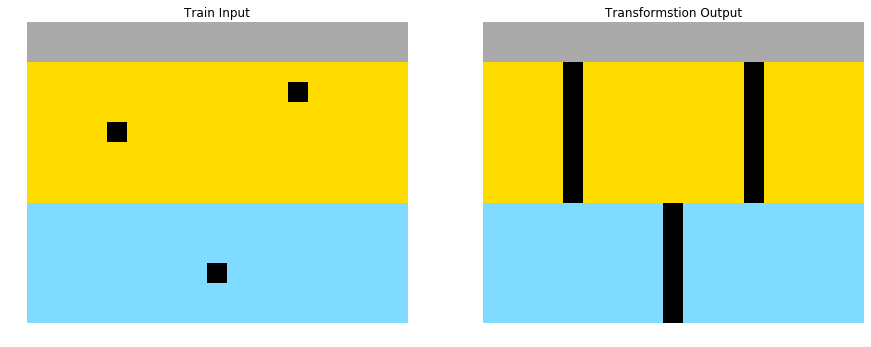

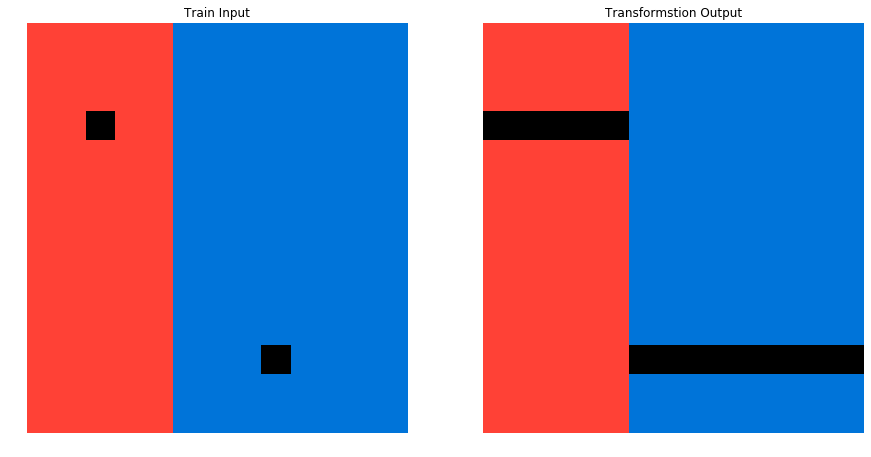

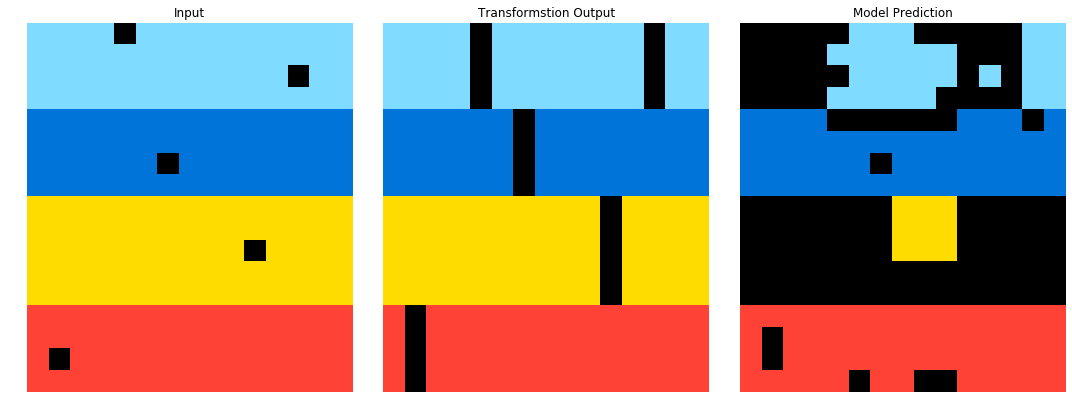

Made predictions for  85c4e7cd
ensemble accuracy 0.061224489795918366



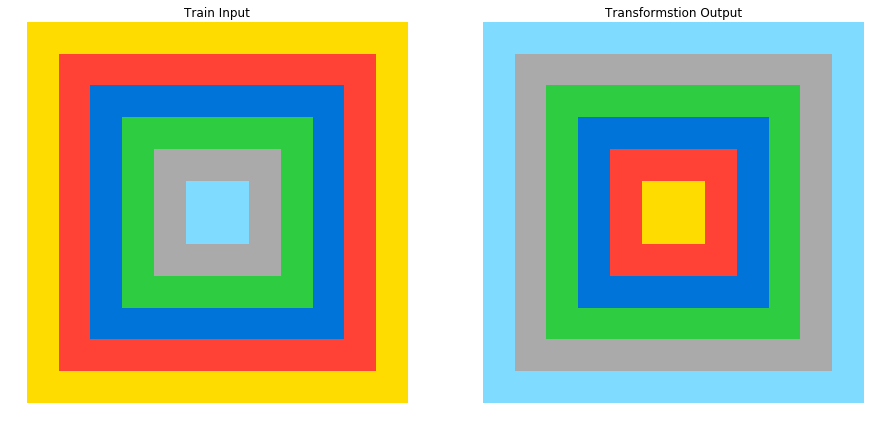

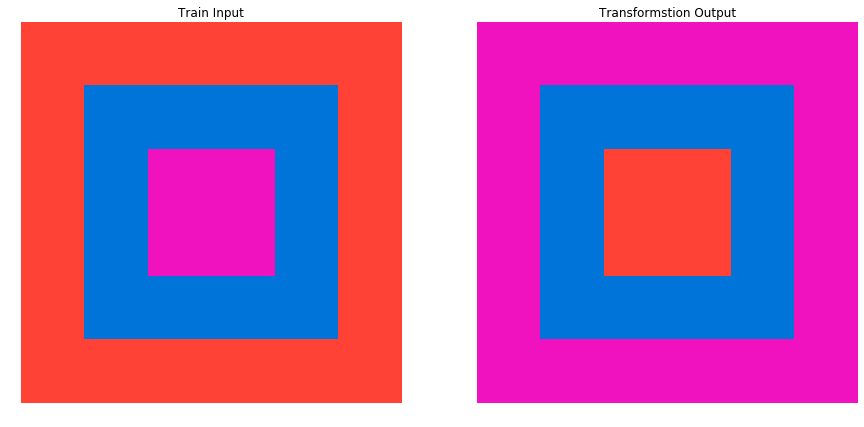

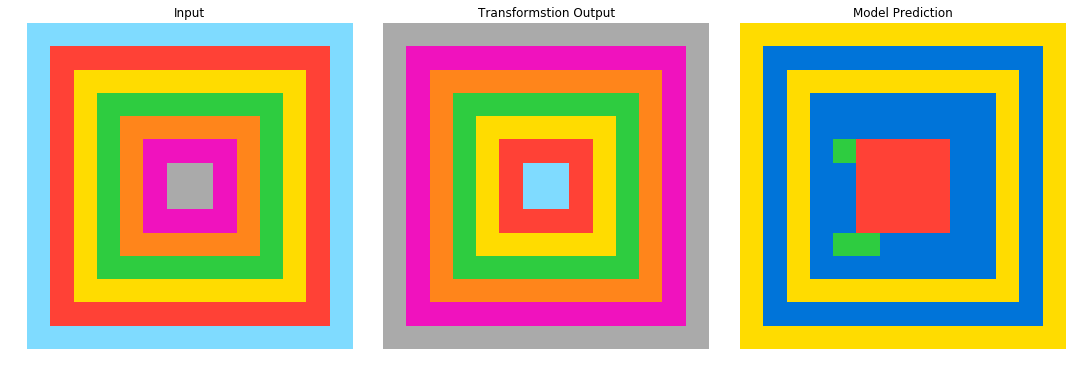

Made predictions for  868de0fa
ensemble accuracy 0.7375



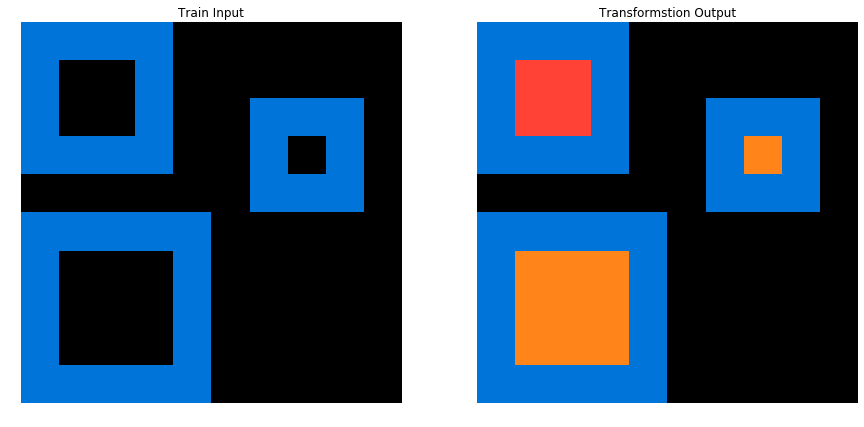

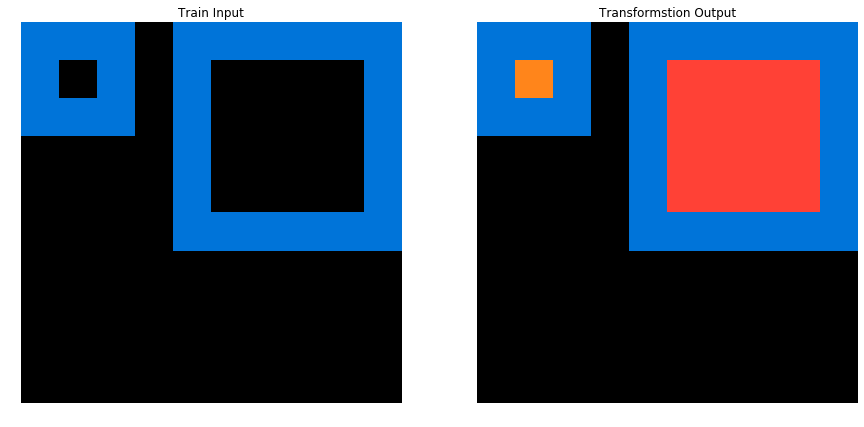

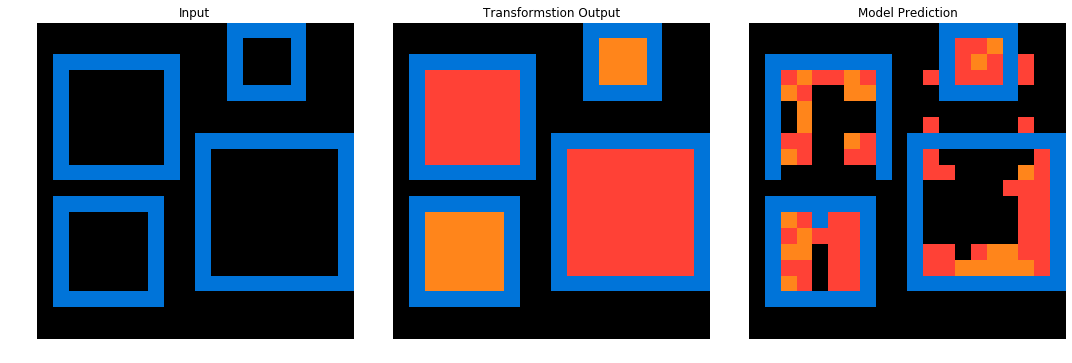

Number of input rows: 17 cols: 23
Number of target rows: 7 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8731374e.json

Made predictions for  88a10436
ensemble accuracy 0.9272727272727272



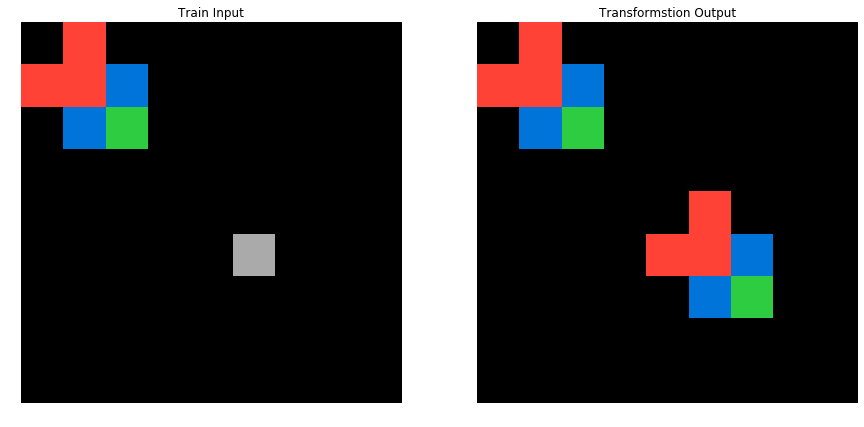

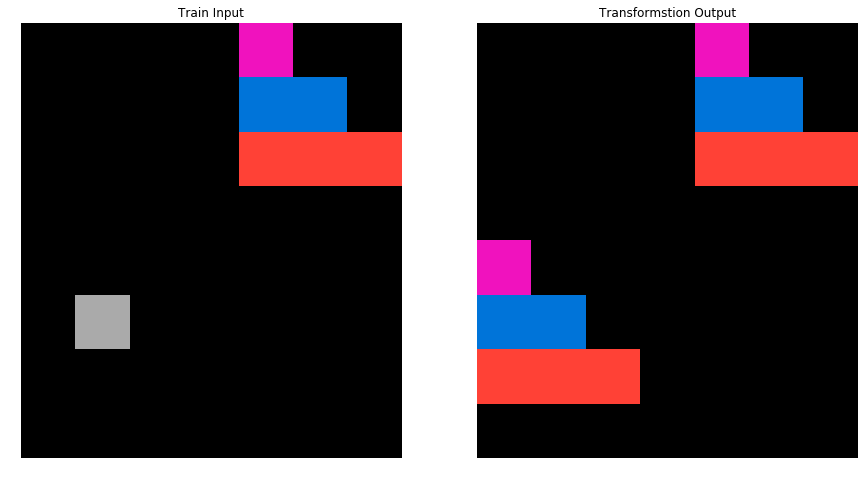

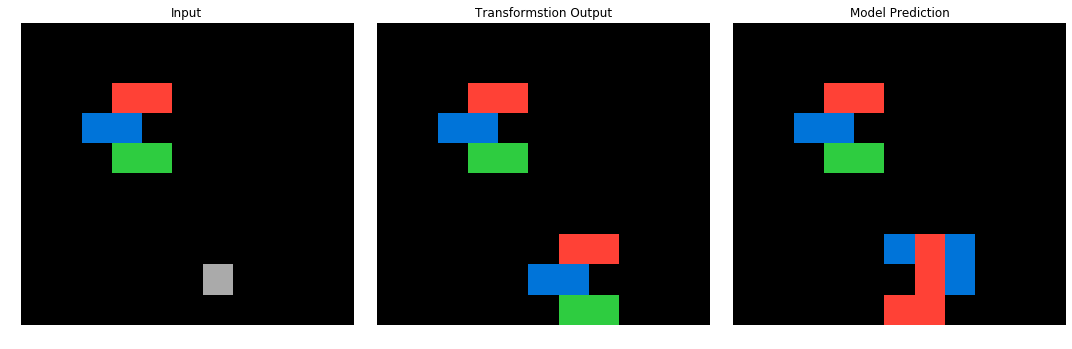

Number of input rows: 5 cols: 5
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/88a62173.json

Made predictions for  890034e9
ensemble accuracy 0.9410430839002267



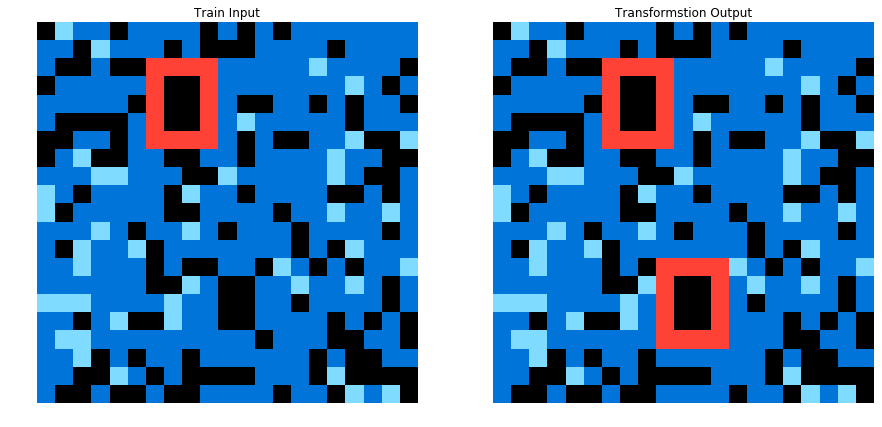

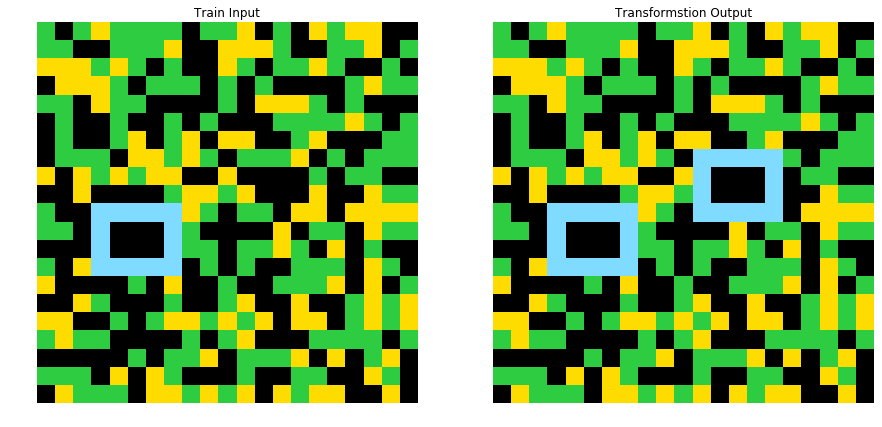

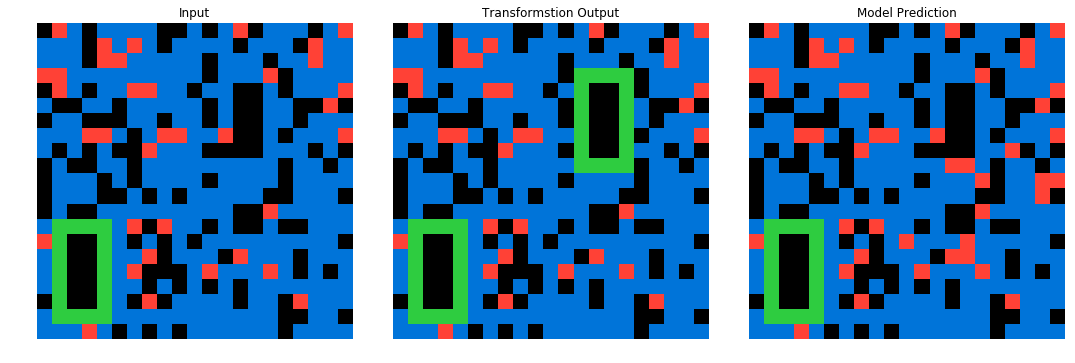

Number of input rows: 17 cols: 17
Number of target rows: 9 cols: 14
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8a004b2b.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8be77c9e.json

Number of input rows: 3 cols: 2
Number of target rows: 9 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8d5021e8.json

Made predictions for  8d510a79
ensemble accuracy 0.93



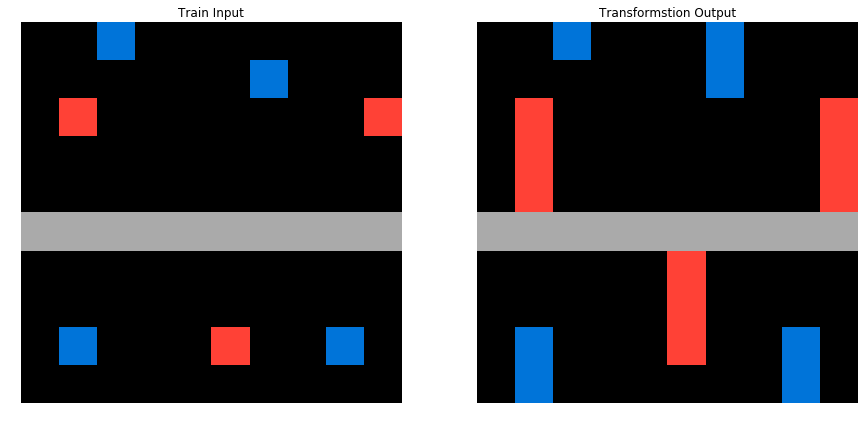

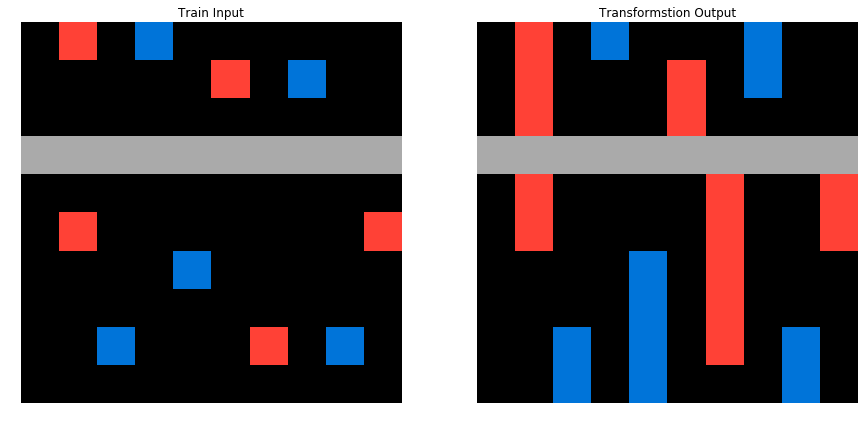

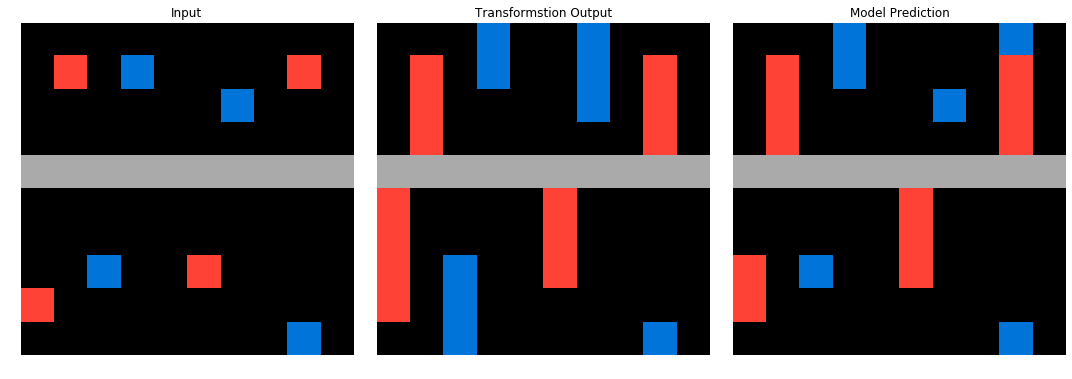

Number of input rows: 18 cols: 15
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8e1813be.json

Made predictions for  8e5a5113
ensemble accuracy 0.2727272727272727



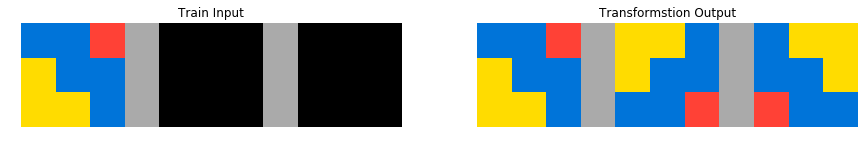

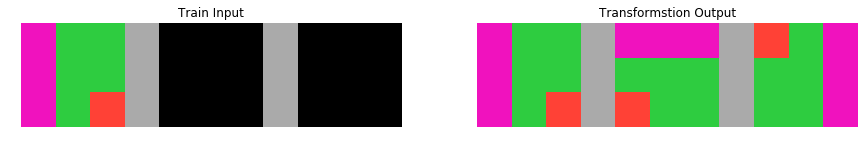

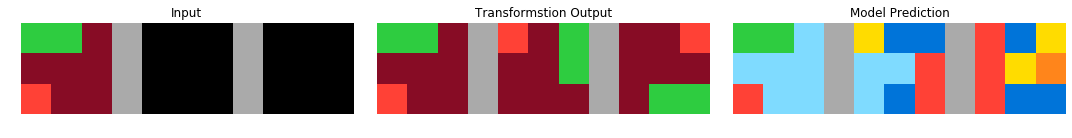

Made predictions for  8eb1be9a
ensemble accuracy 0.2802197802197802



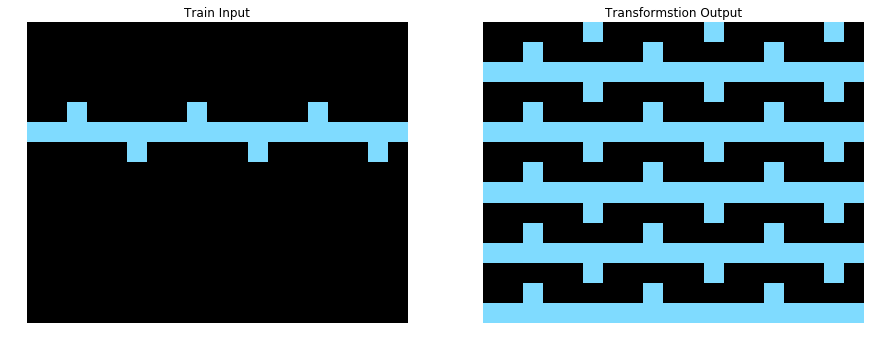

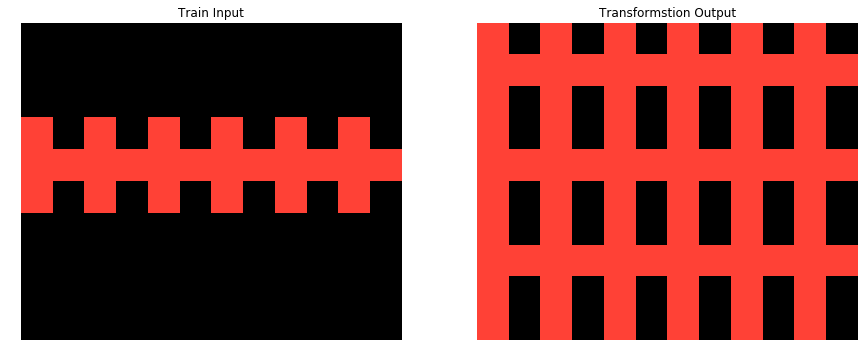

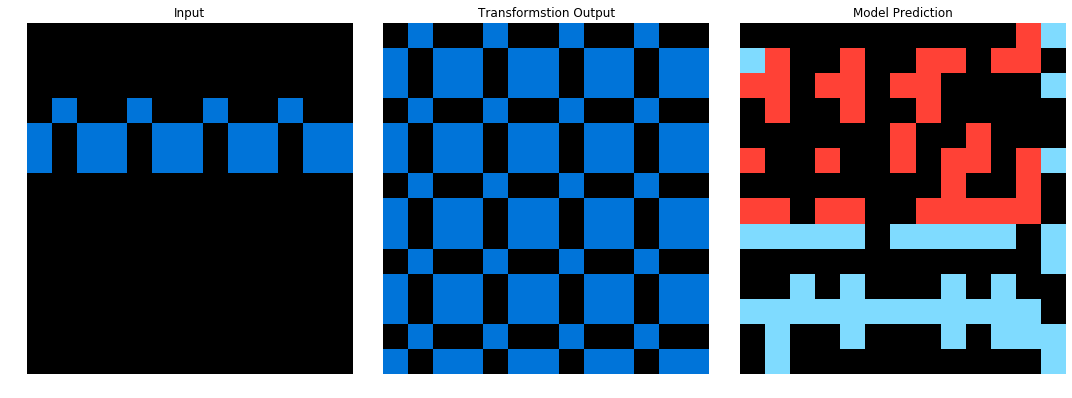

Number of input rows: 20 cols: 20
Number of target rows: 5 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8efcae92.json

Made predictions for  8f2ea7aa
ensemble accuracy 0.654320987654321



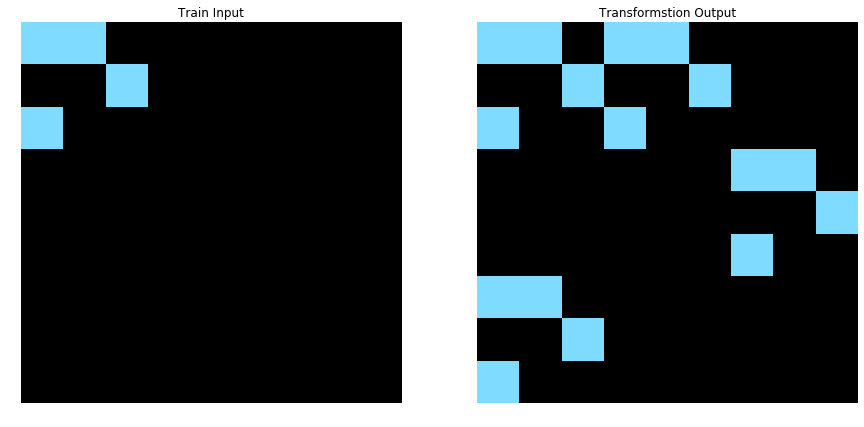

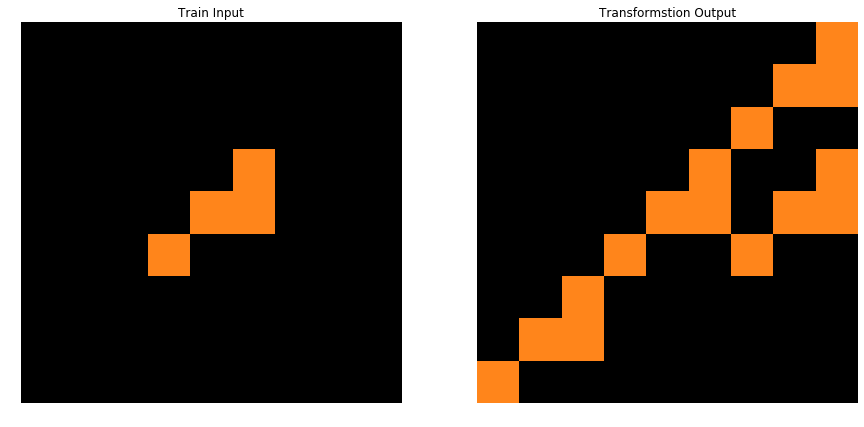

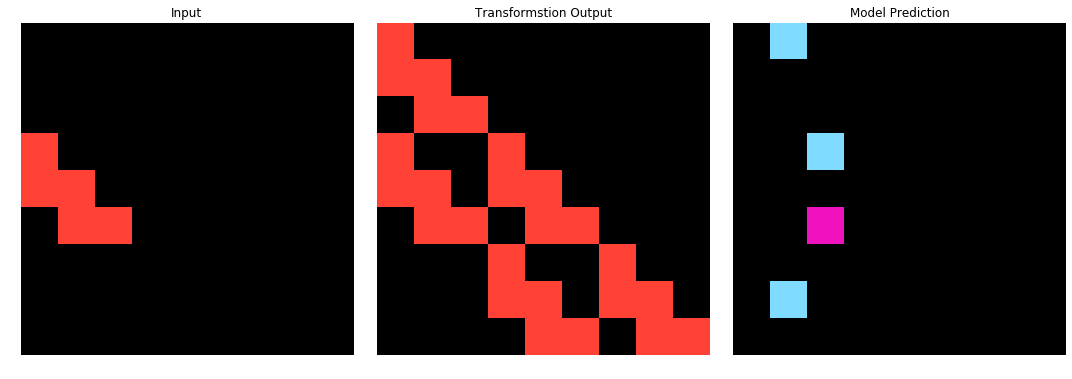

Number of input rows: 21 cols: 21
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/90c28cc7.json

Made predictions for  90f3ed37
ensemble accuracy 0.94



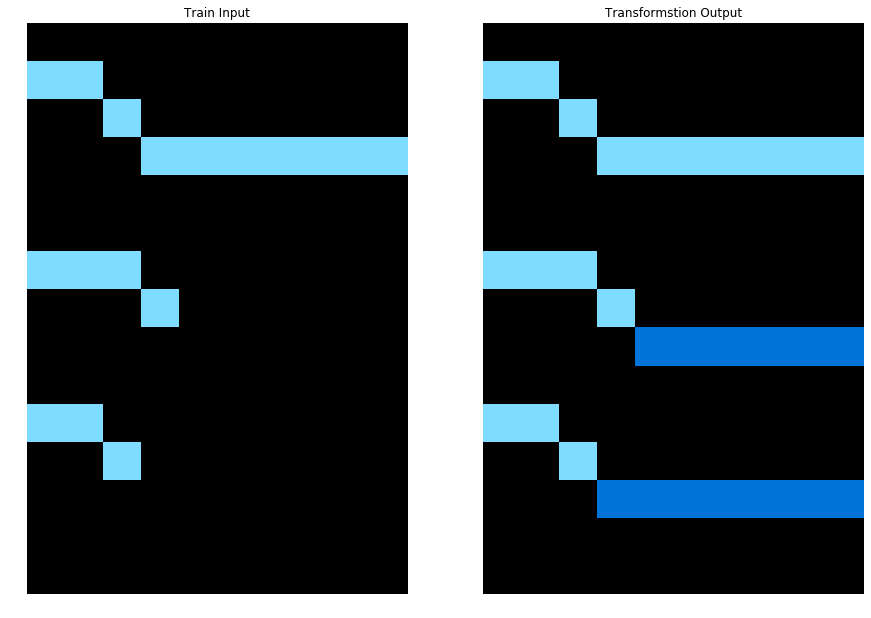

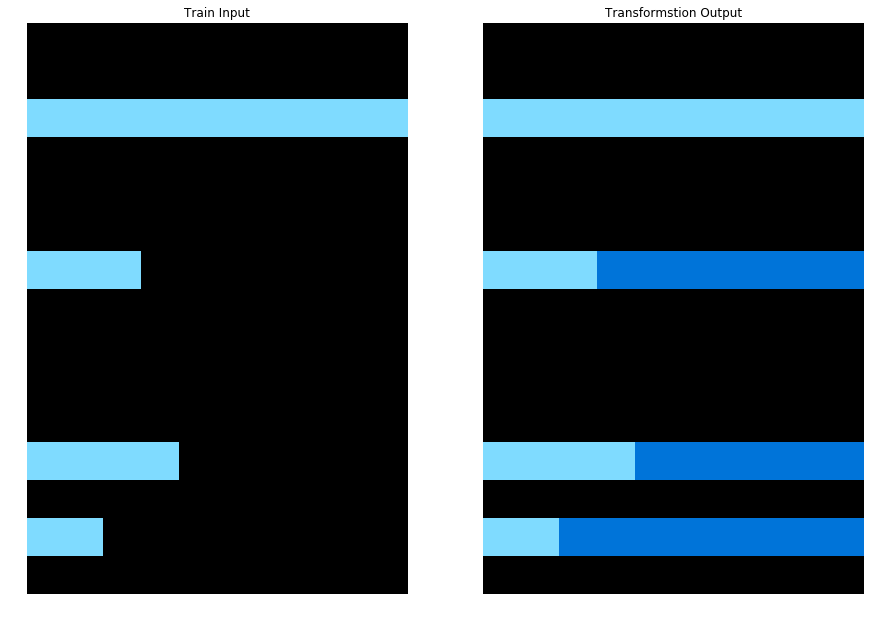

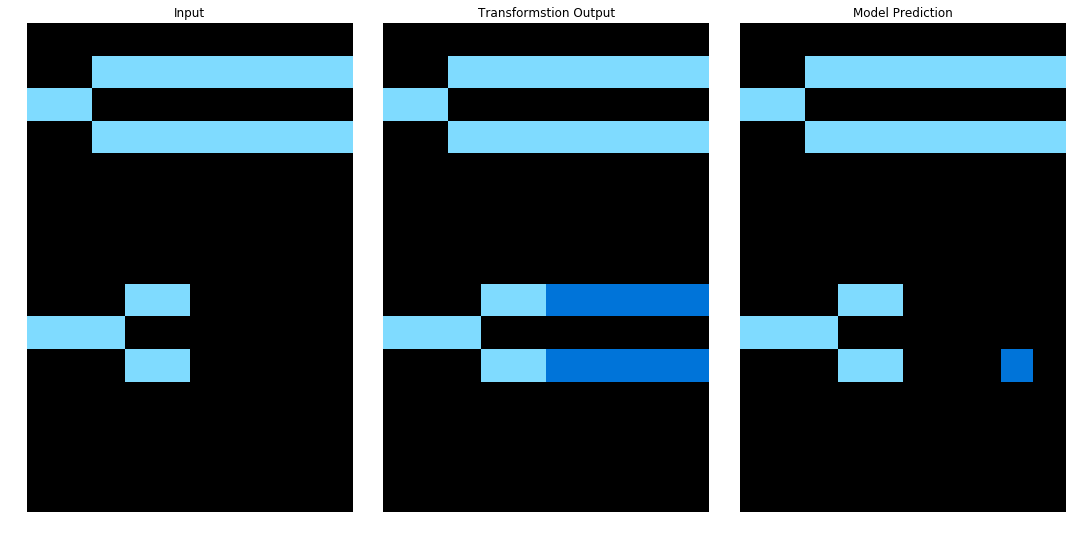

Made predictions for  913fb3ed
ensemble accuracy 0.98828125
913fb3ed.json



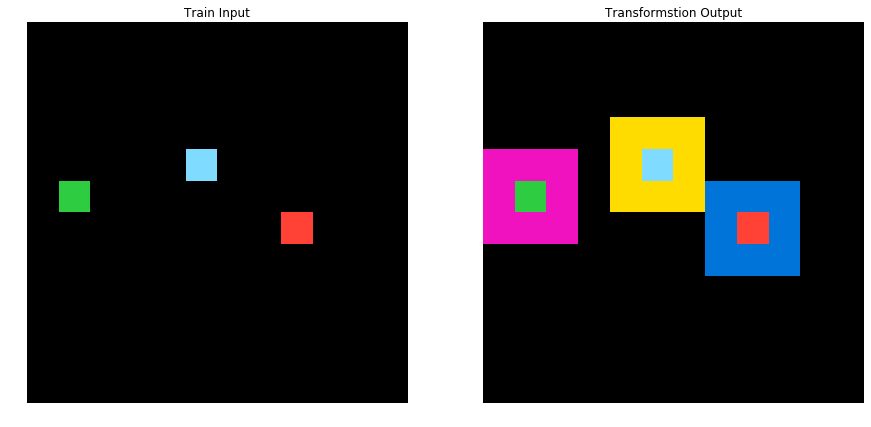

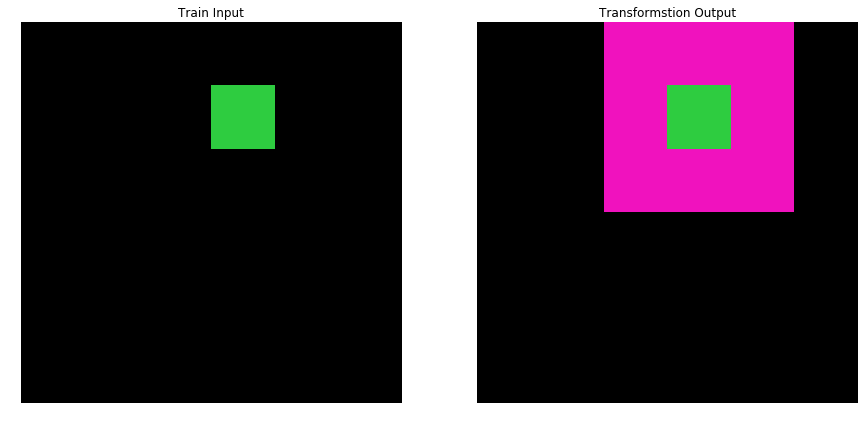

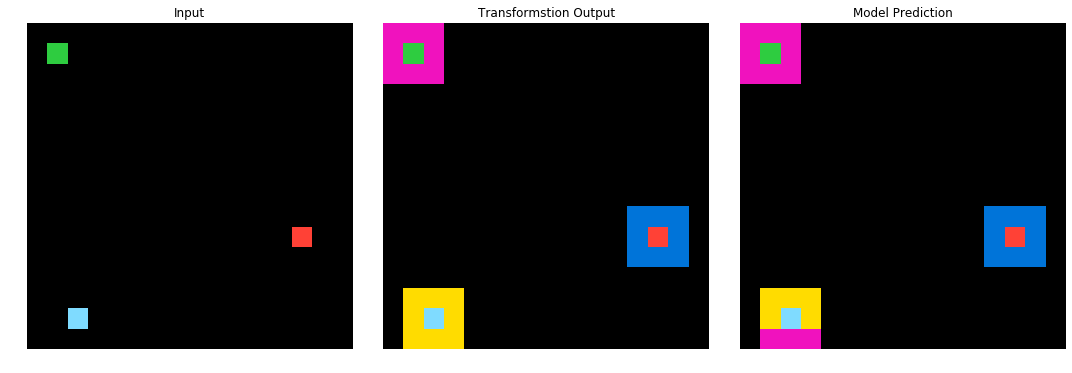

Number of input rows: 3 cols: 3
Number of target rows: 12 cols: 12
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/91413438.json

Made predictions for  91714a58
ensemble accuracy 0.953125
91714a58.json



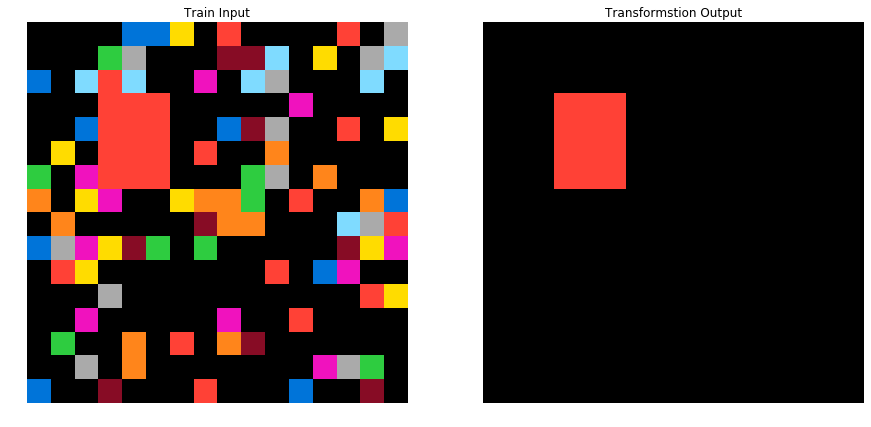

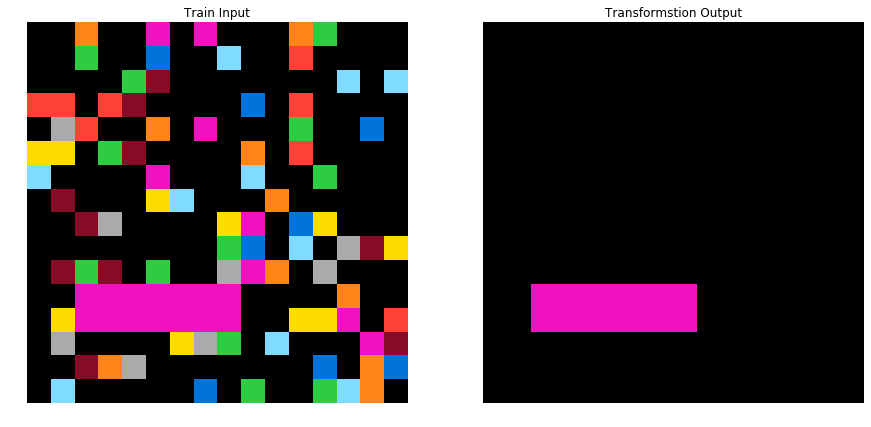

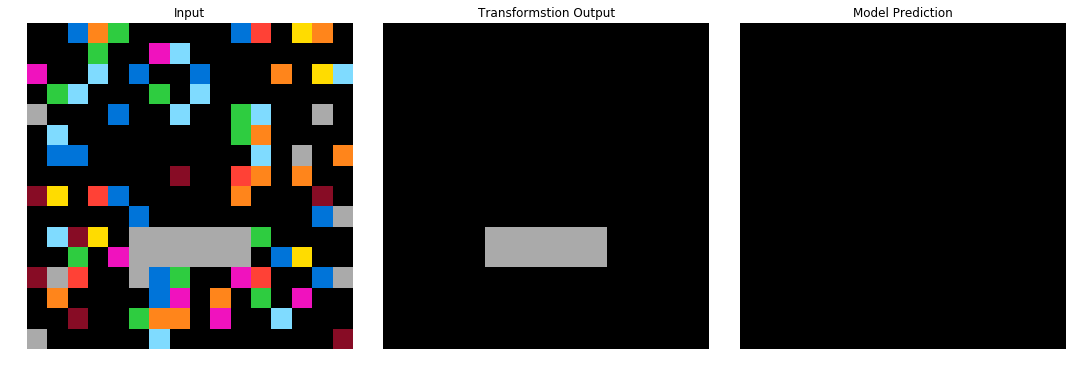

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9172f3a0.json

Made predictions for  928ad970
ensemble accuracy 0.7911111111111111



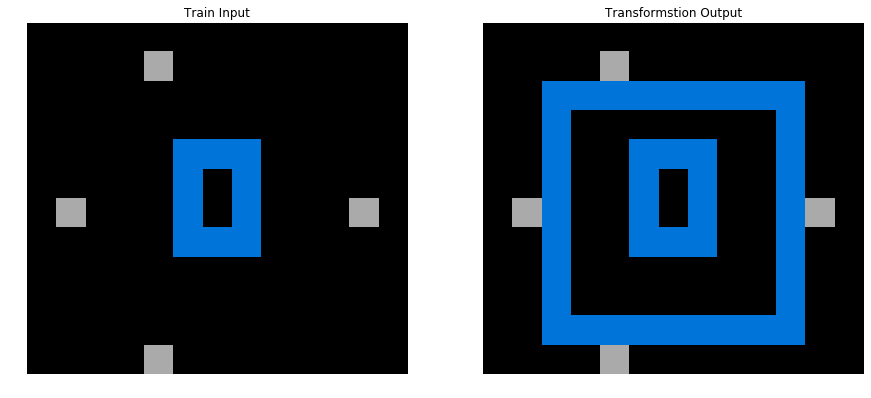

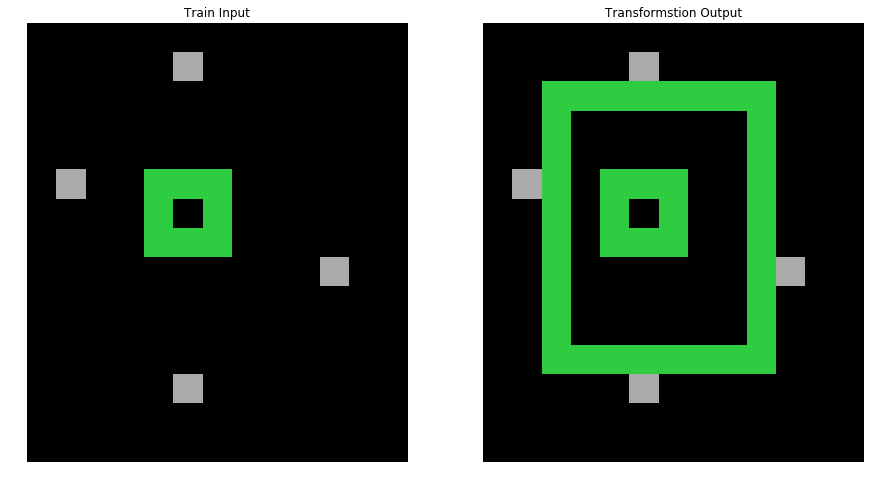

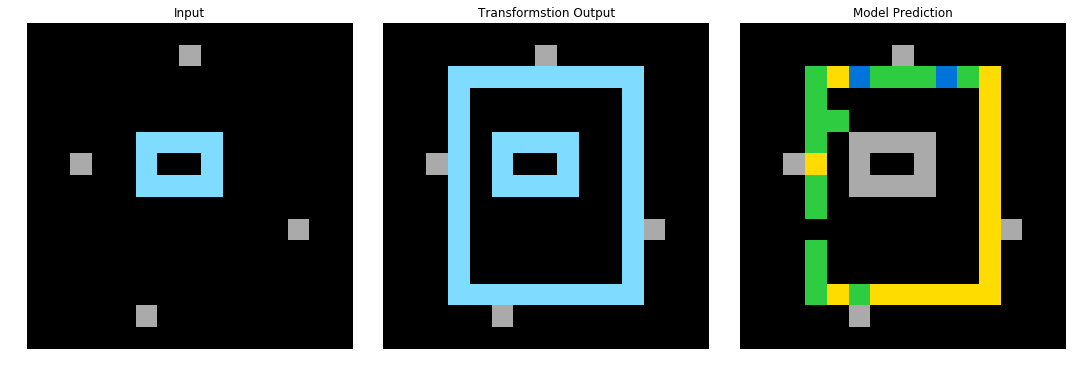

Made predictions for  93b581b8
ensemble accuracy 0.6666666666666666



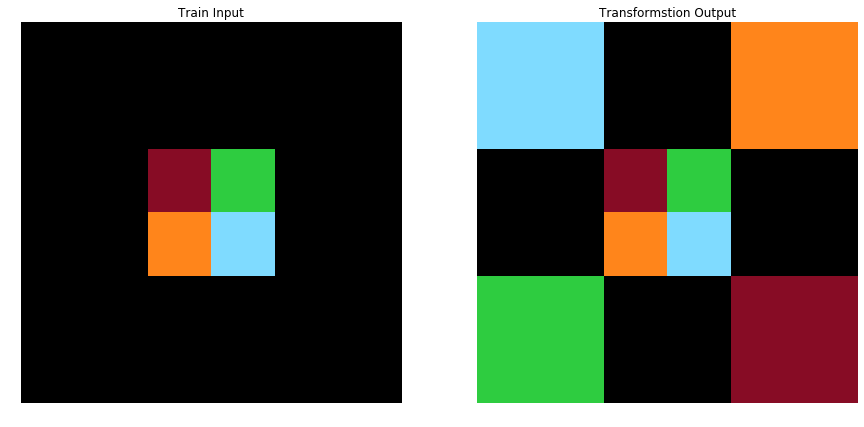

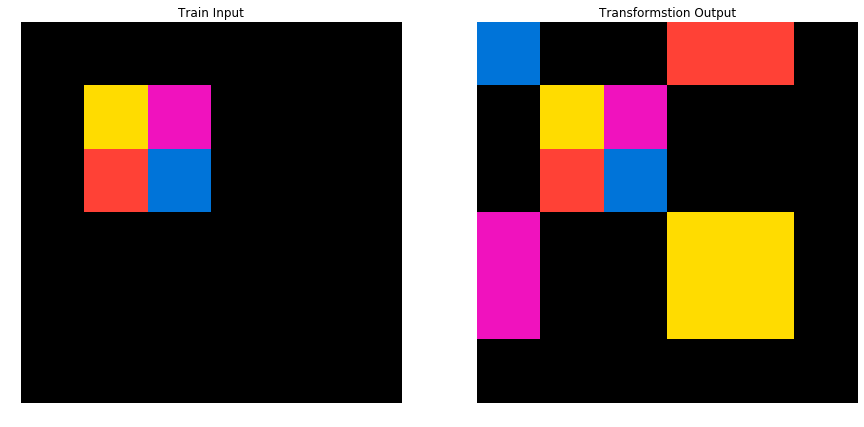

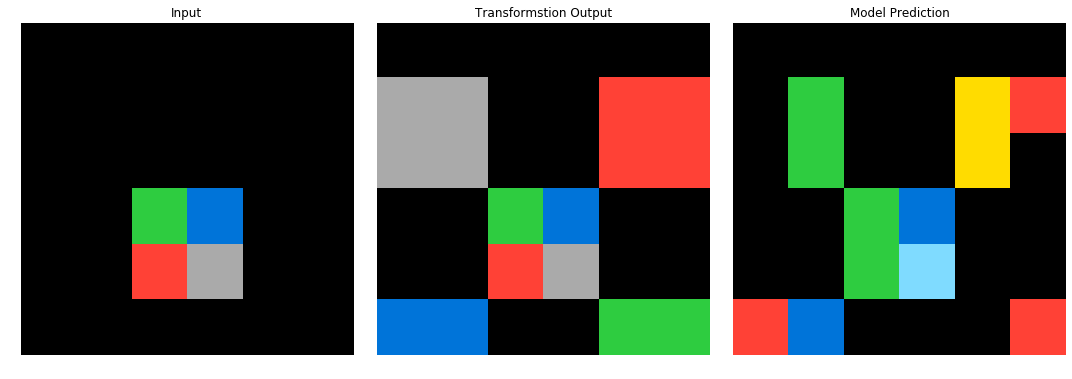

Made predictions for  941d9a10
ensemble accuracy 0.95
941d9a10.json



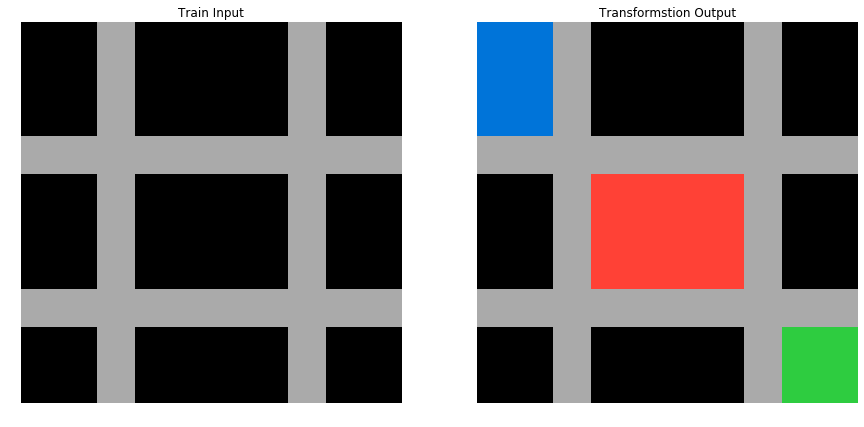

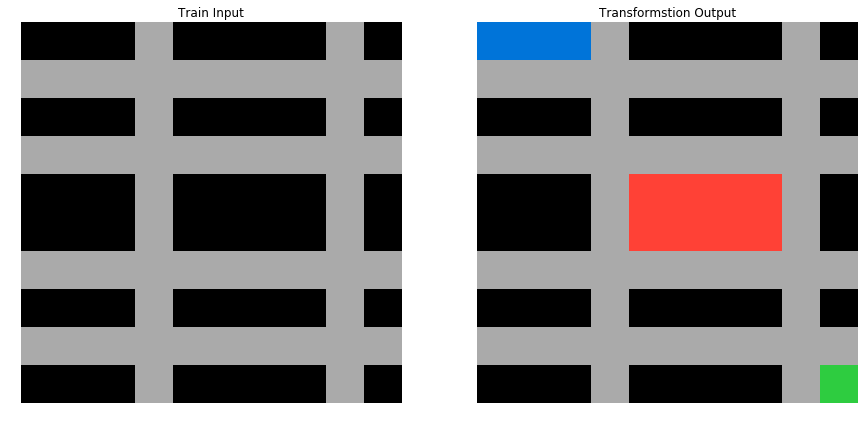

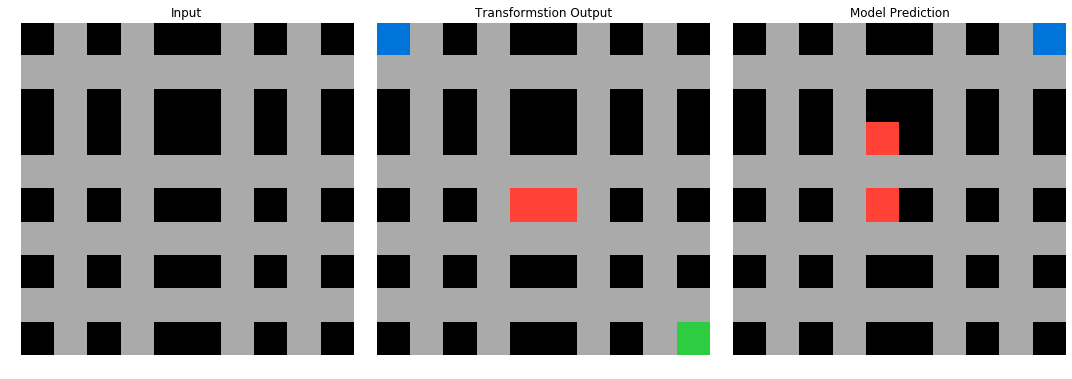

Number of input rows: 8 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/94f9d214.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  952a094c
ensemble accuracy 0.79



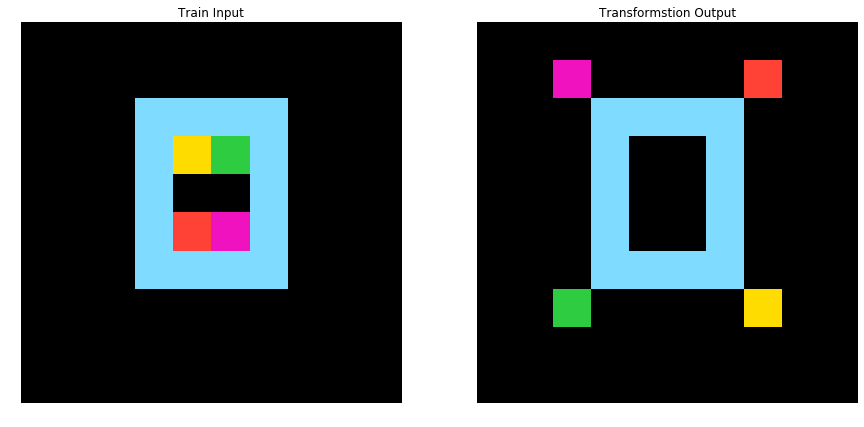

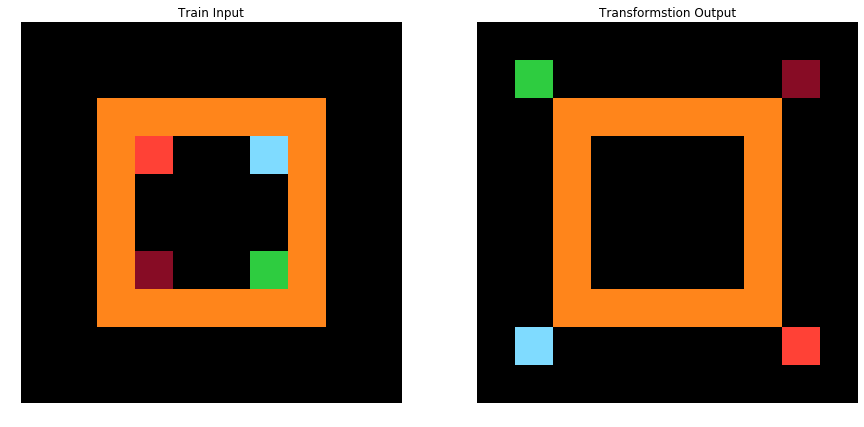

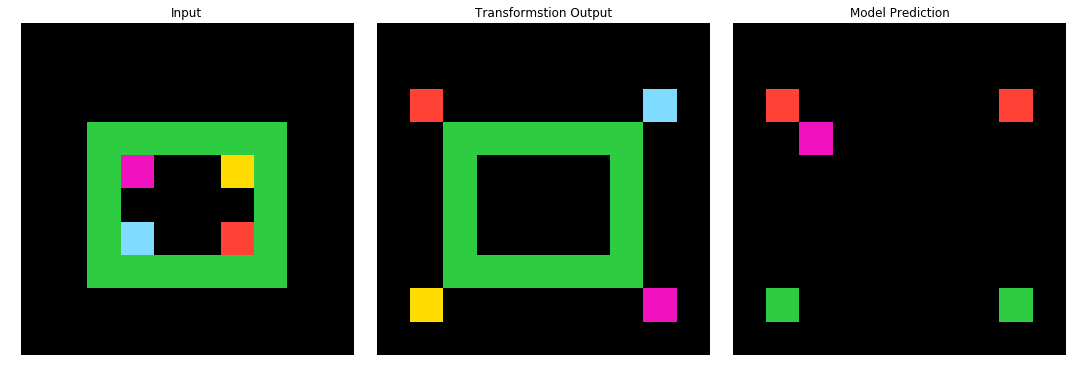

Made predictions for  9565186b
ensemble accuracy 0.0



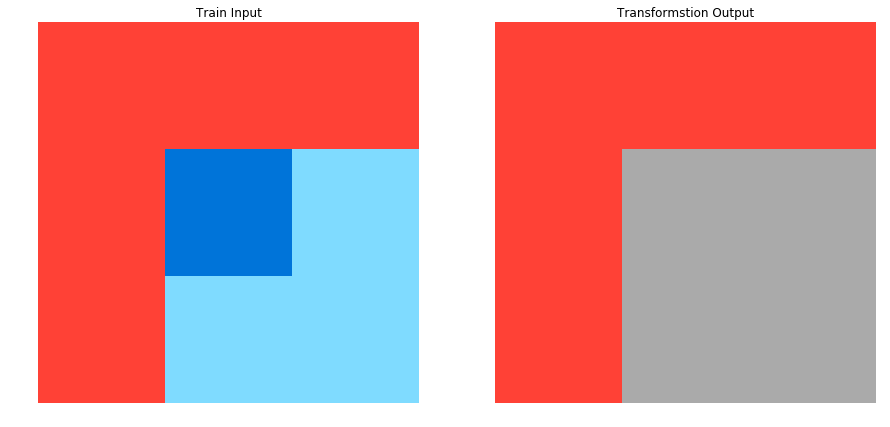

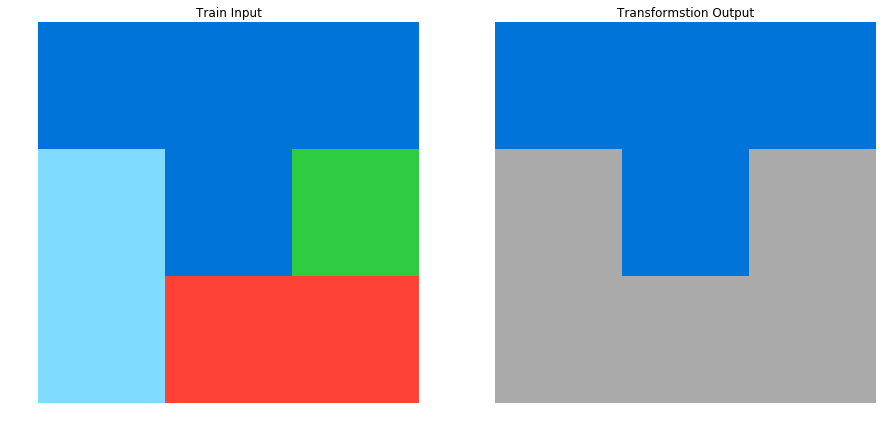

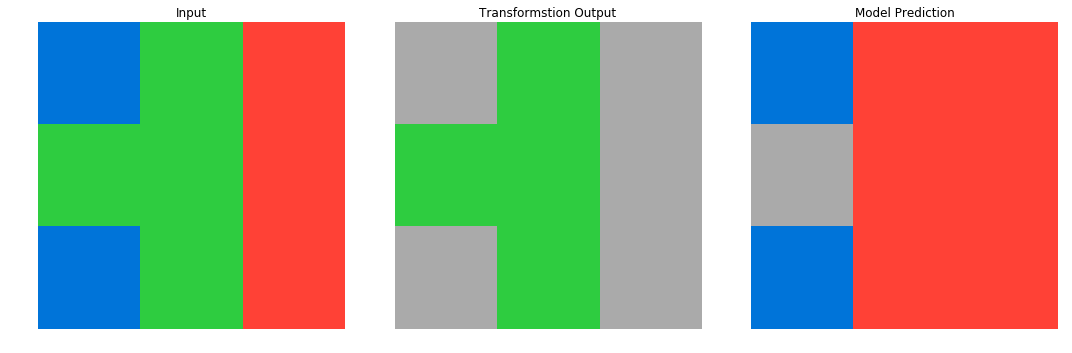

Made predictions for  95990924
ensemble accuracy 0.9244444444444444



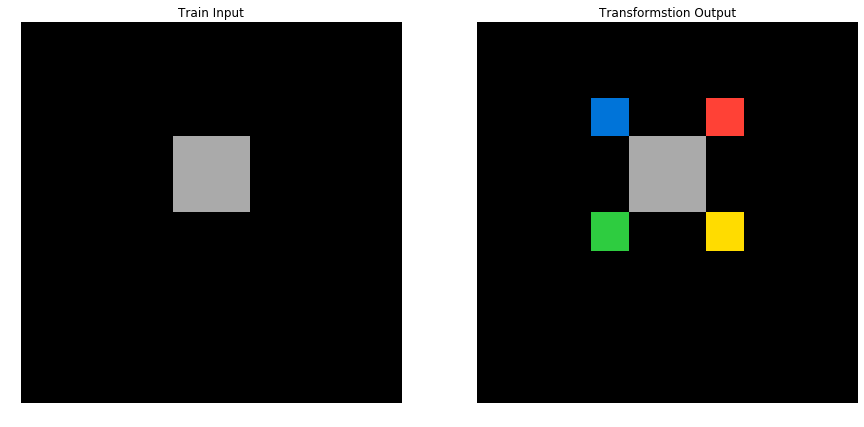

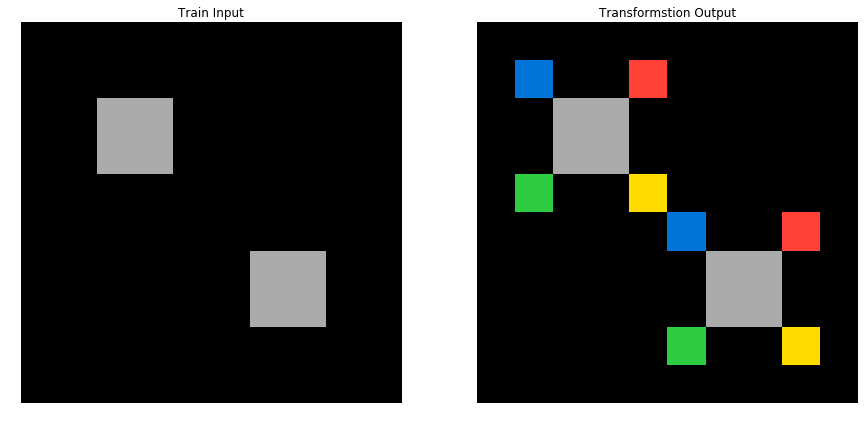

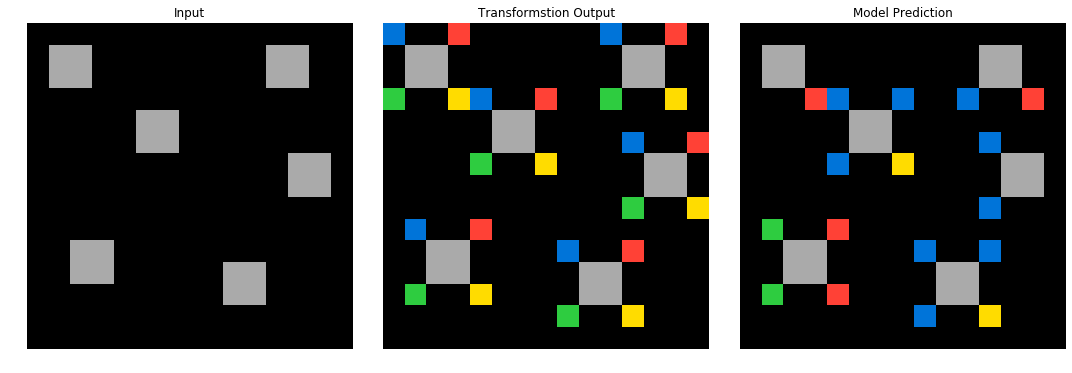

Number of input rows: 5 cols: 6
Number of target rows: 5 cols: 12
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/963e52fc.json

Made predictions for  97999447
ensemble accuracy 0.7777777777777778



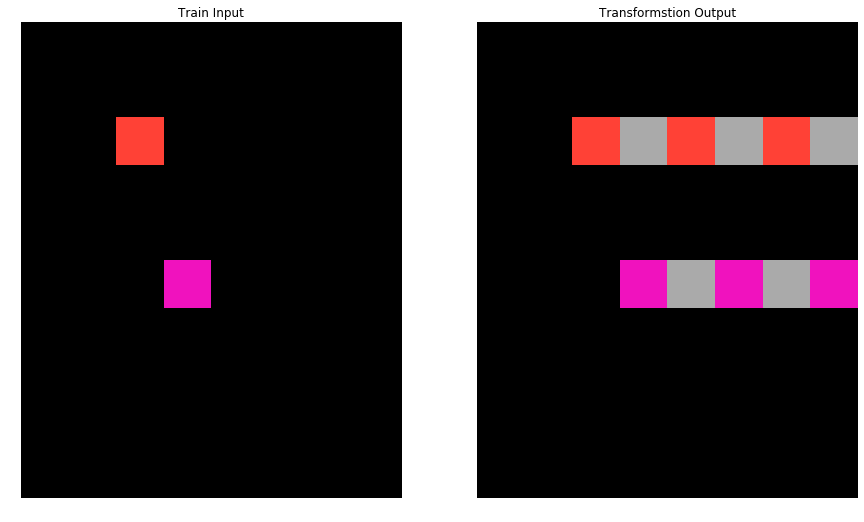

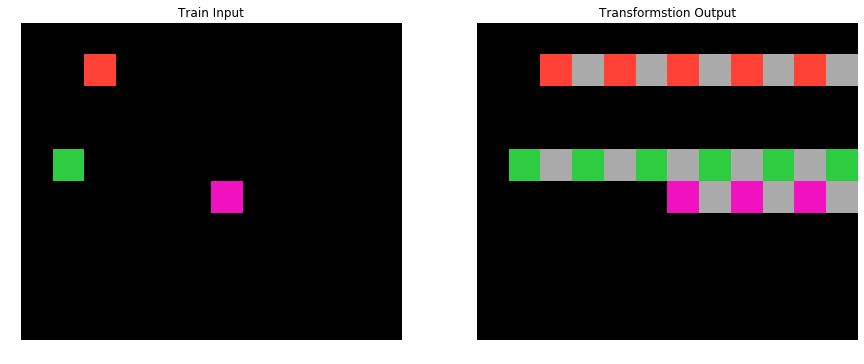

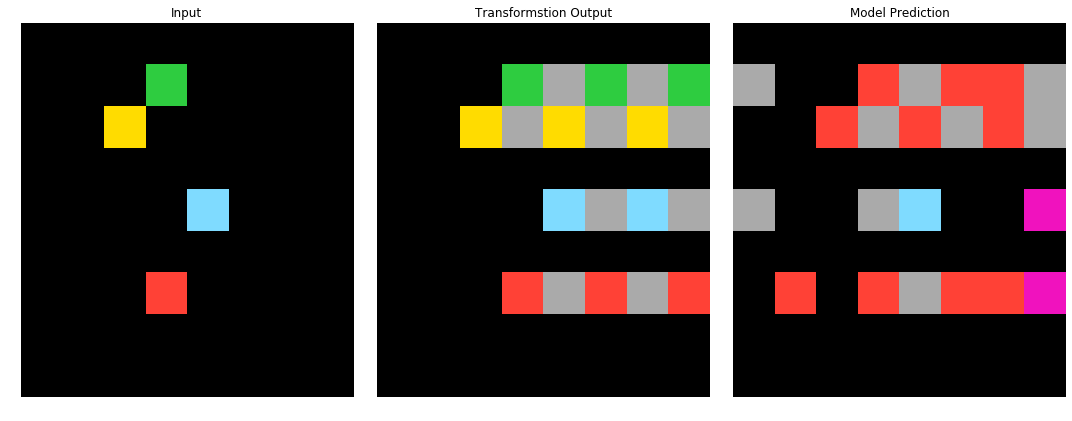

Number of input rows: 24 cols: 19
Number of target rows: 17 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/97a05b5b.json

Made predictions for  98cf29f8
ensemble accuracy 0.7205882352941176



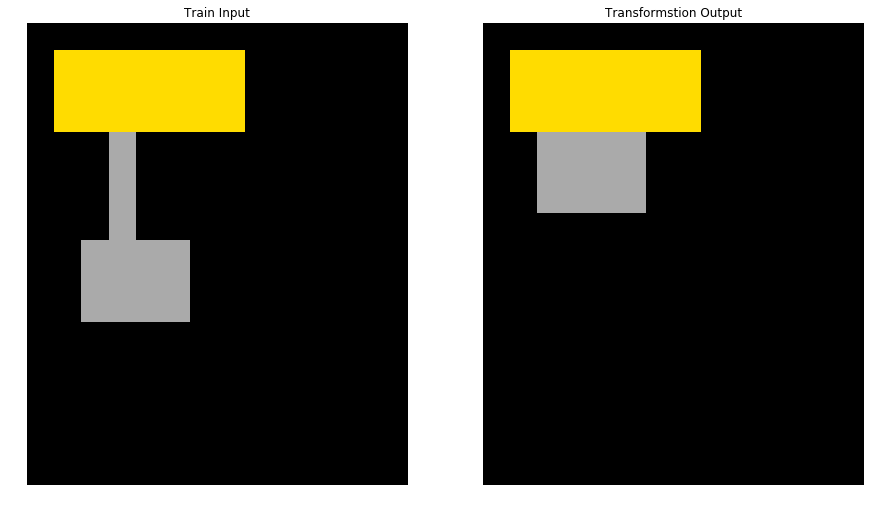

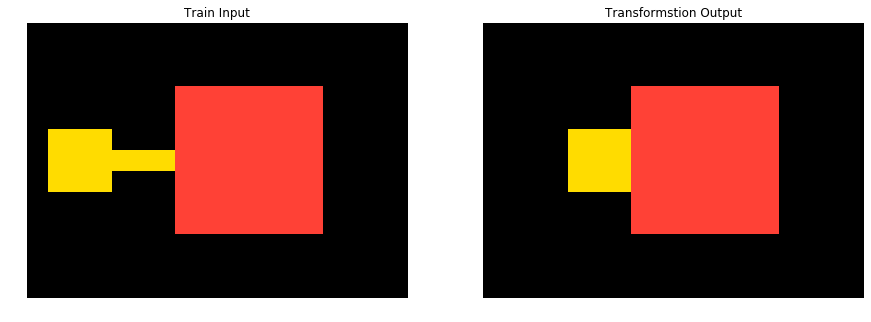

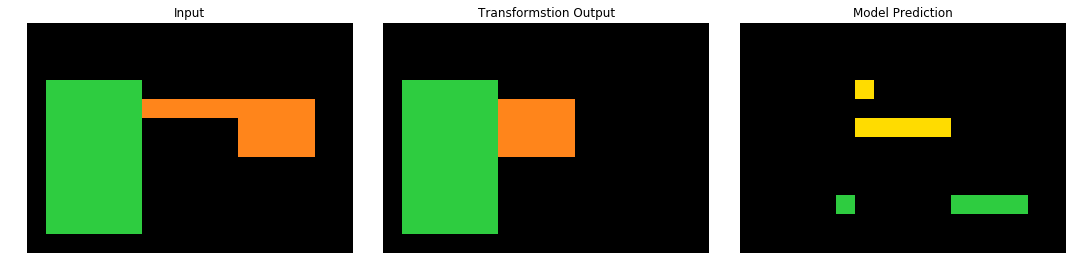

Number of input rows: 4 cols: 14
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/995c5fa3.json

Number of input rows: 9 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/99b1bc43.json

Made predictions for  99fa7670
ensemble accuracy 0.5535714285714286



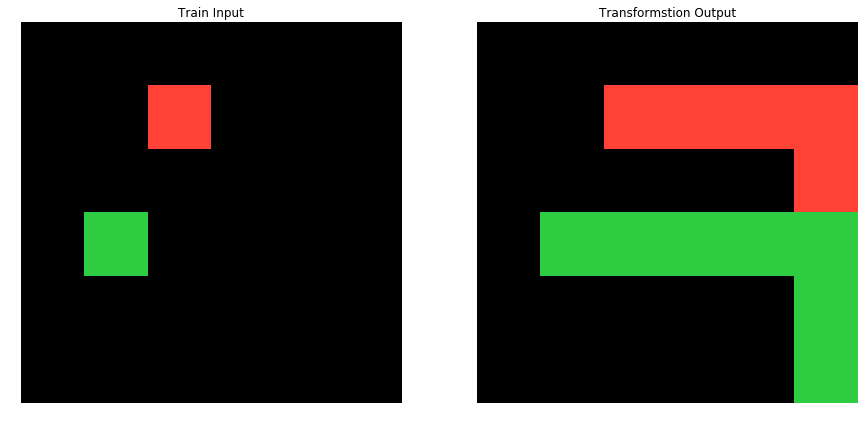

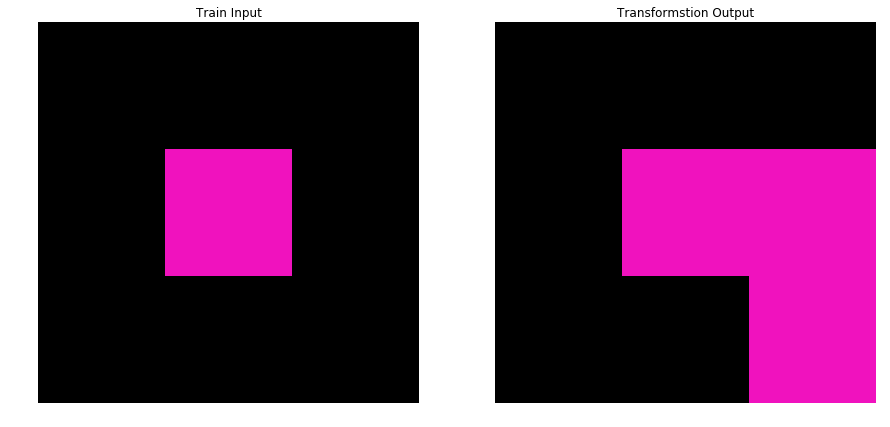

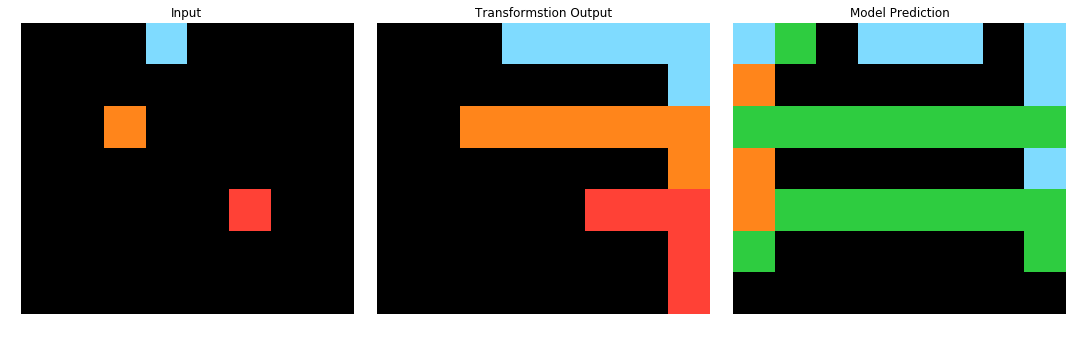

Number of input rows: 15 cols: 16
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9aec4887.json

Number of input rows: 3 cols: 3
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9af7a82c.json

Made predictions for  9d9215db
ensemble accuracy 0.889196675900277



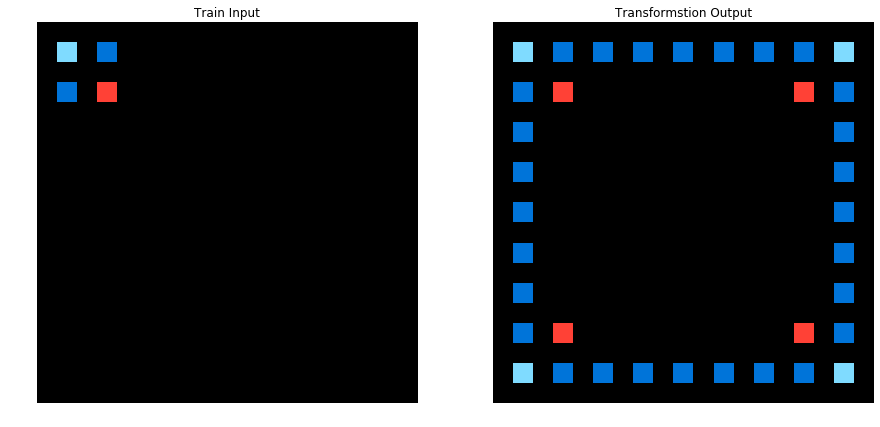

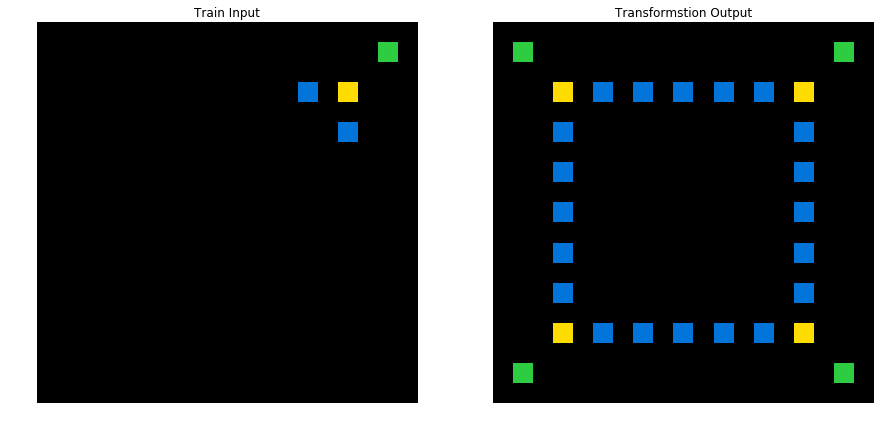

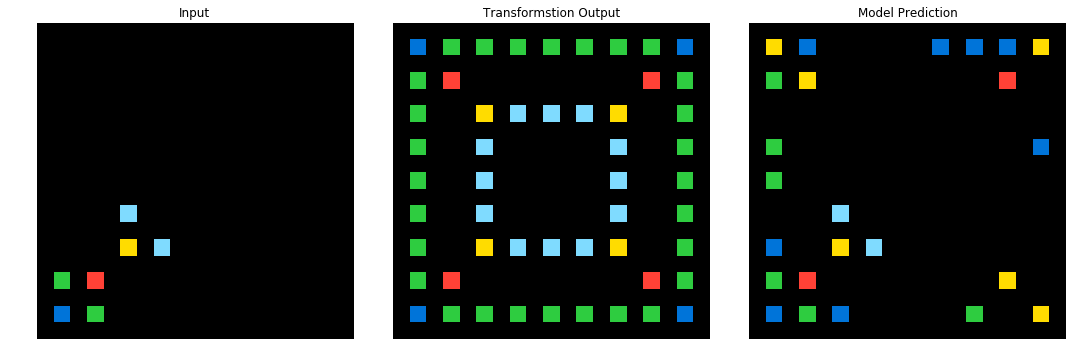

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  9dfd6313
ensemble accuracy 0.6666666666666666



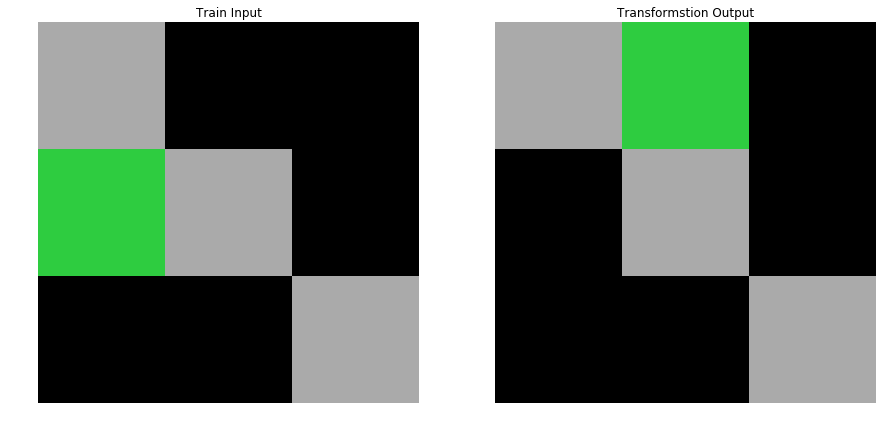

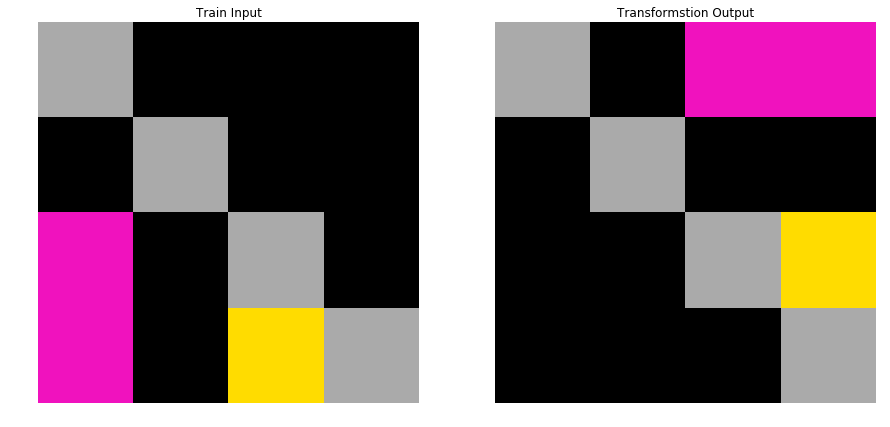

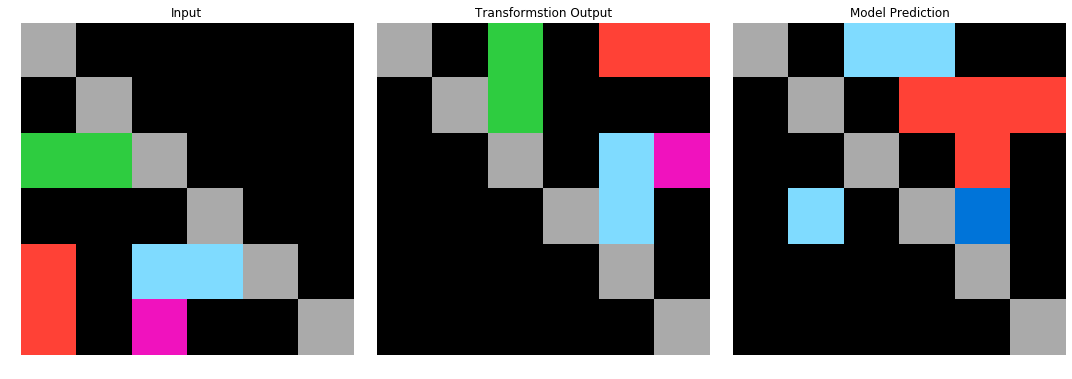

Number of input rows: 16 cols: 16
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9ecd008a.json

Made predictions for  9edfc990
ensemble accuracy 0.859375



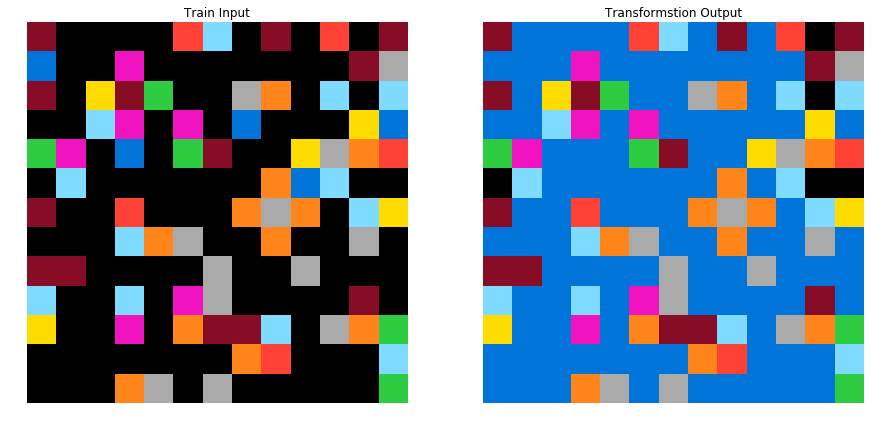

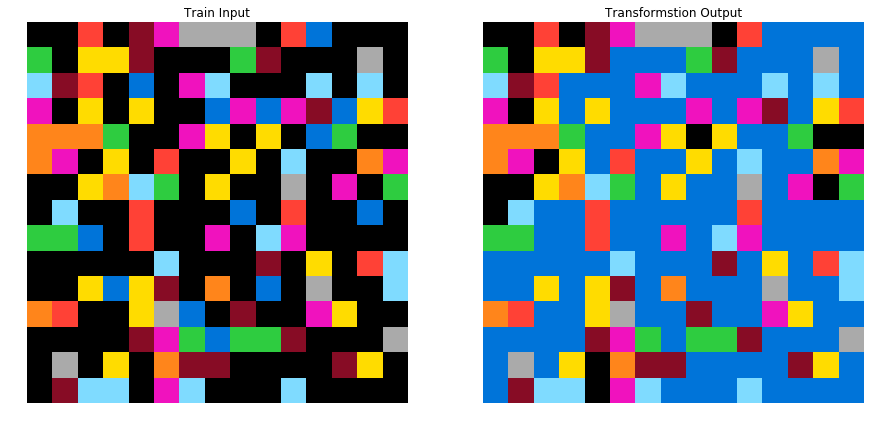

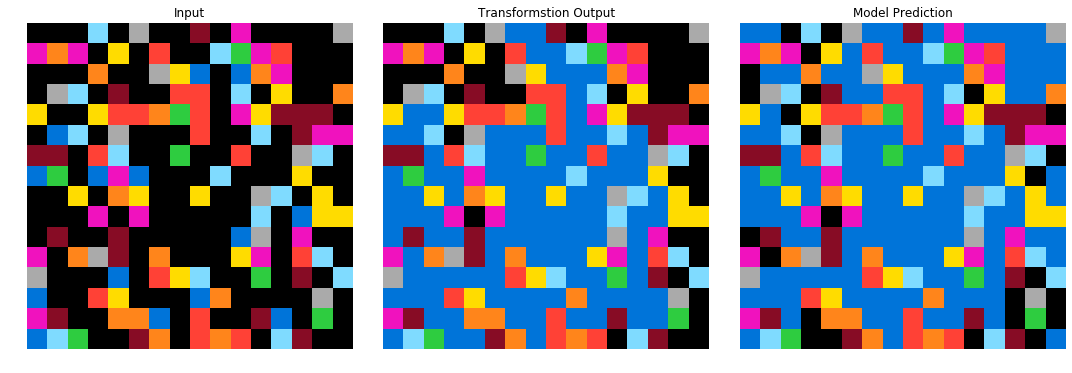

Number of input rows: 19 cols: 19
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9f236235.json

Made predictions for  a1570a43
ensemble accuracy 0.8375



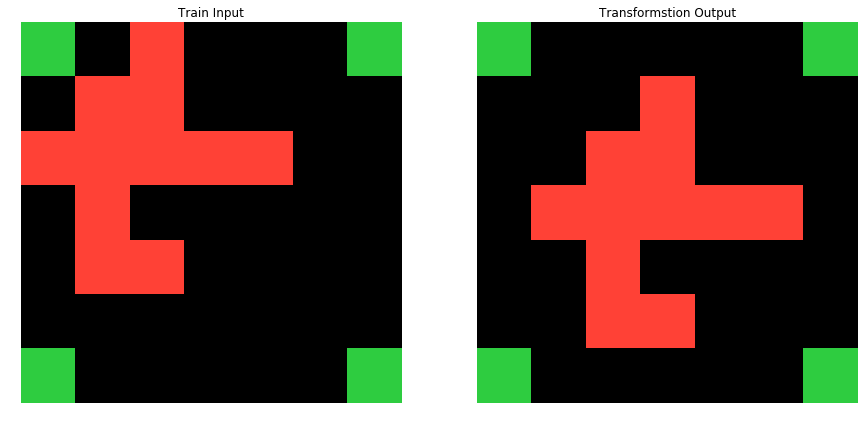

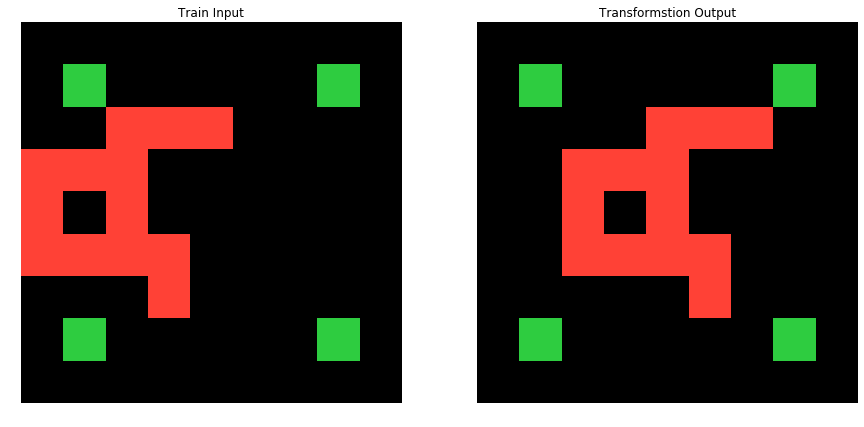

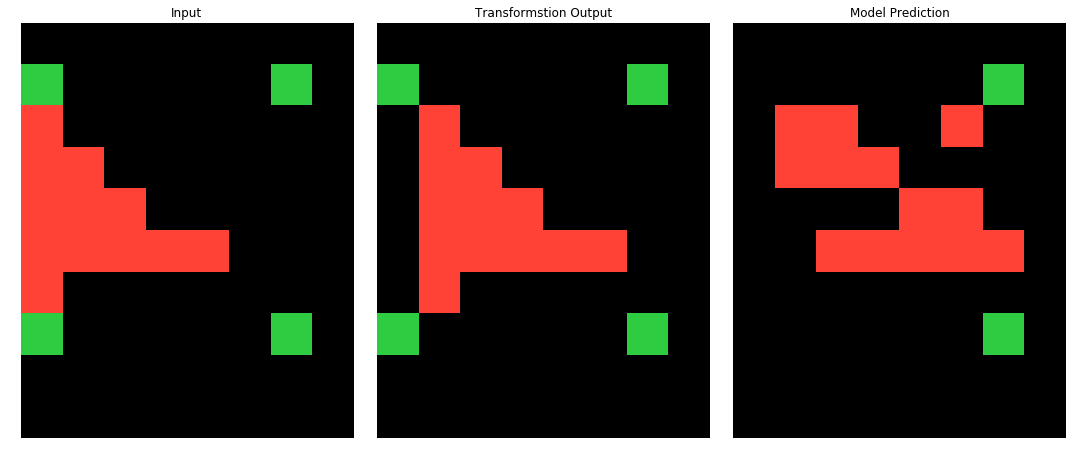

Made predictions for  a2fd1cf0
ensemble accuracy 0.9345238095238095



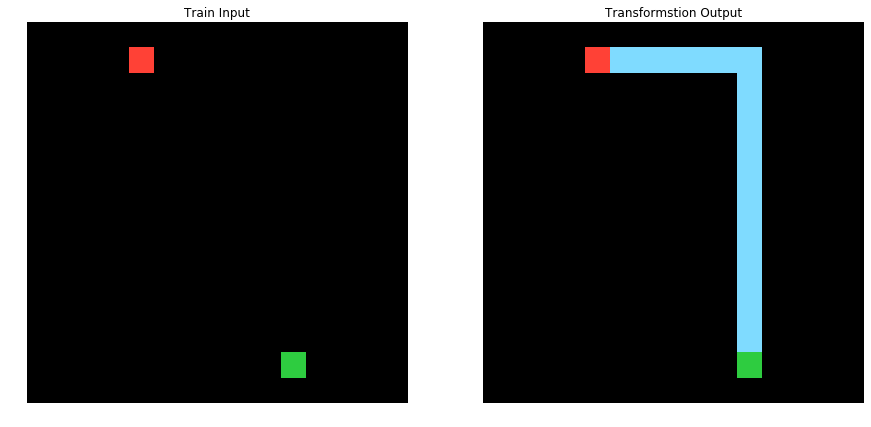

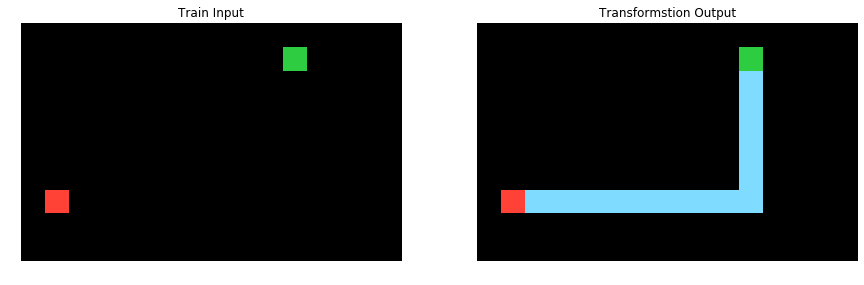

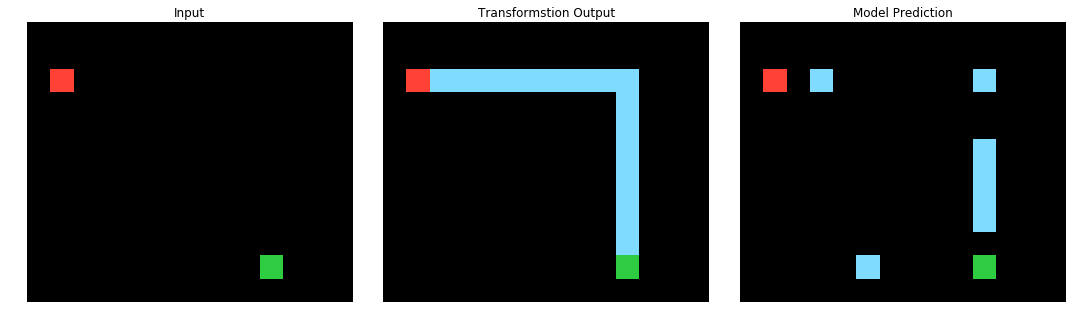

Number of input rows: 10 cols: 10
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a3325580.json

Made predictions for  a3df8b1e
ensemble accuracy 0.74



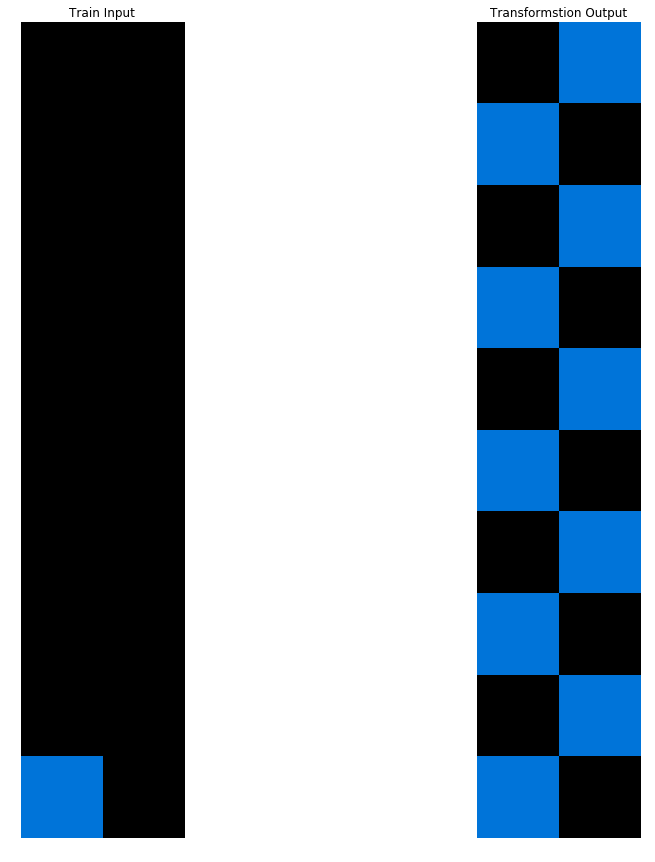

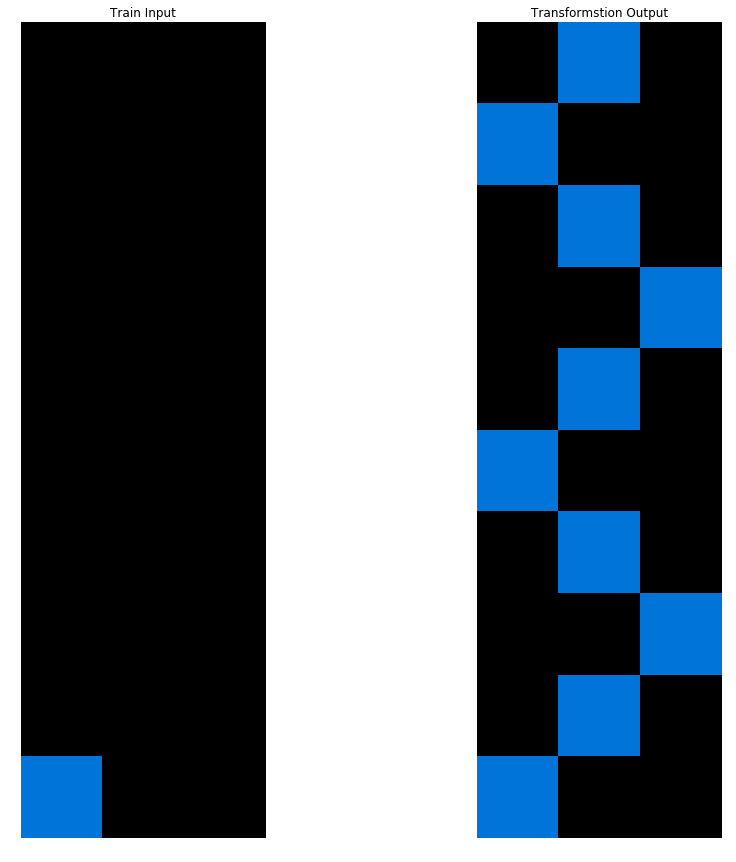

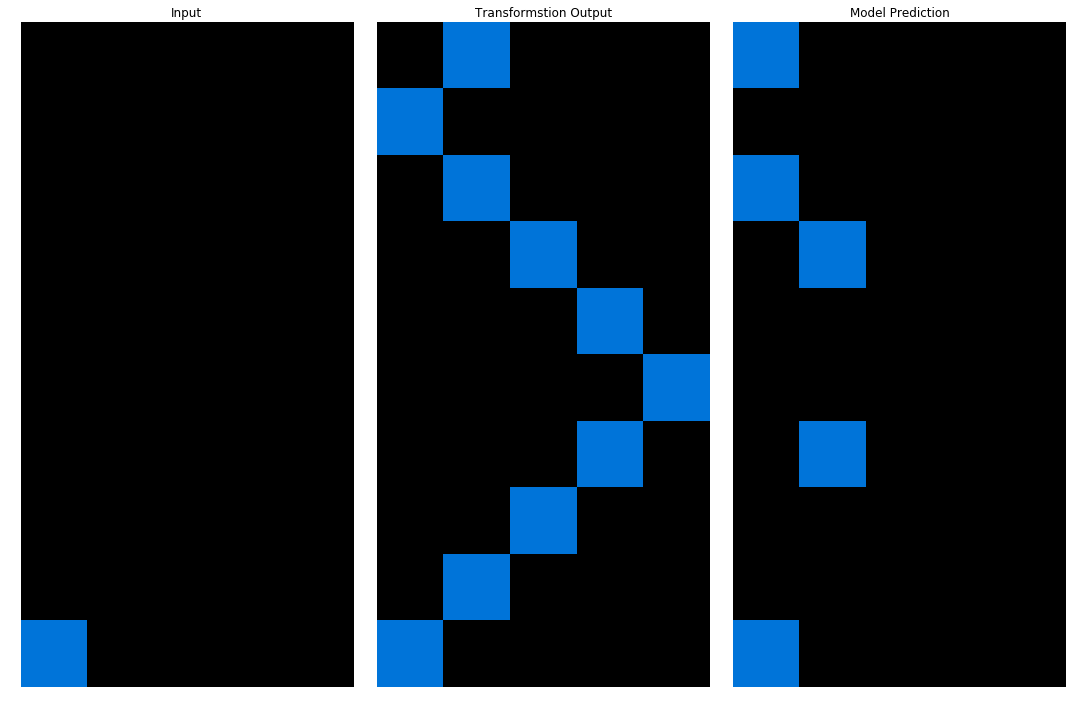

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a416b8f3.json

Made predictions for  a48eeaf7
ensemble accuracy 0.97
a48eeaf7.json



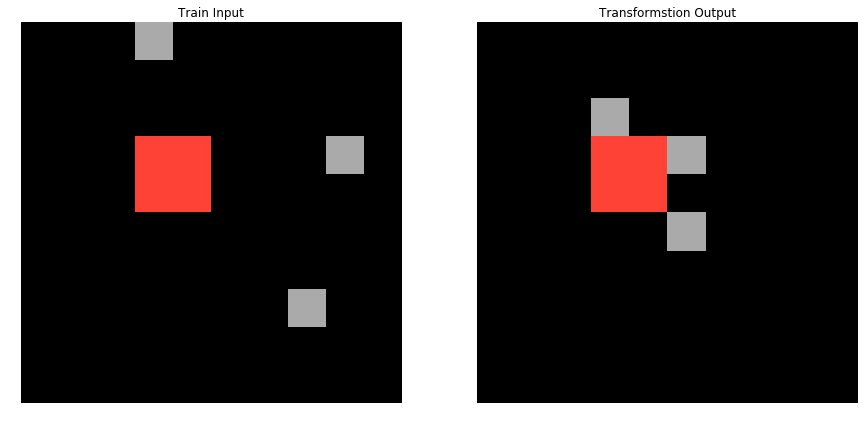

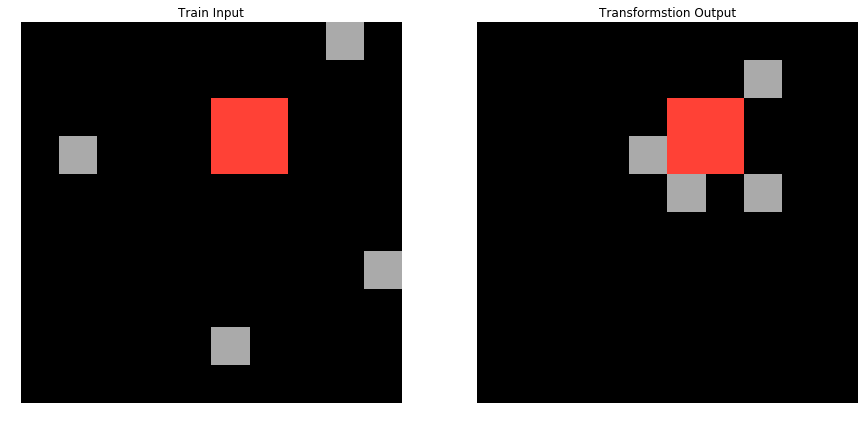

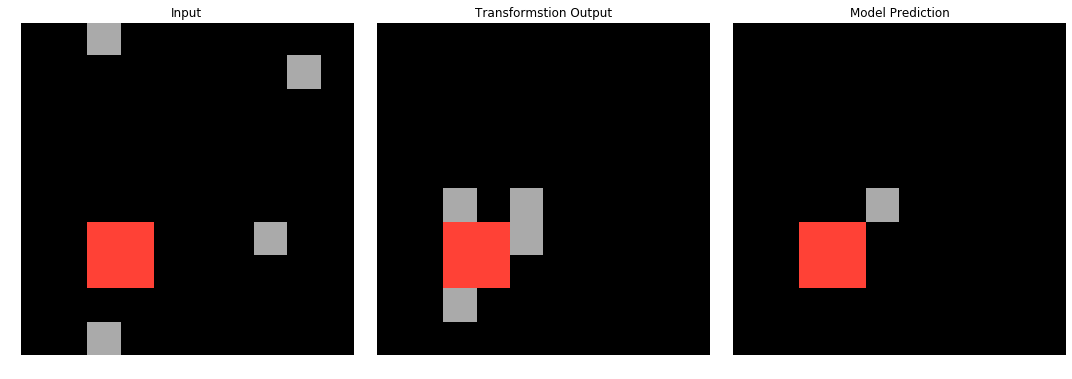

Made predictions for  a5313dff
ensemble accuracy 0.9259259259259259



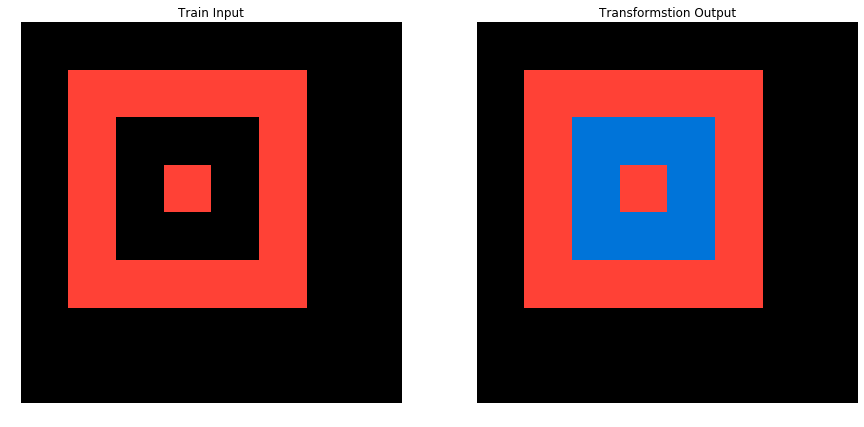

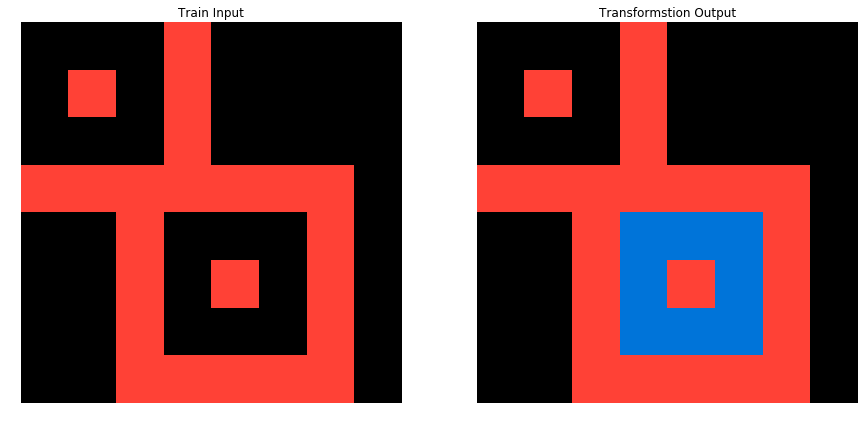

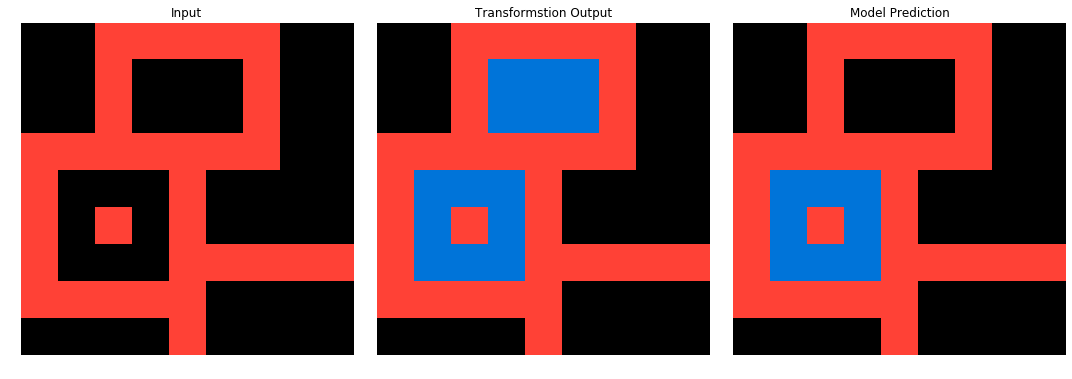

Made predictions for  a5f85a15
ensemble accuracy 0.8888888888888888



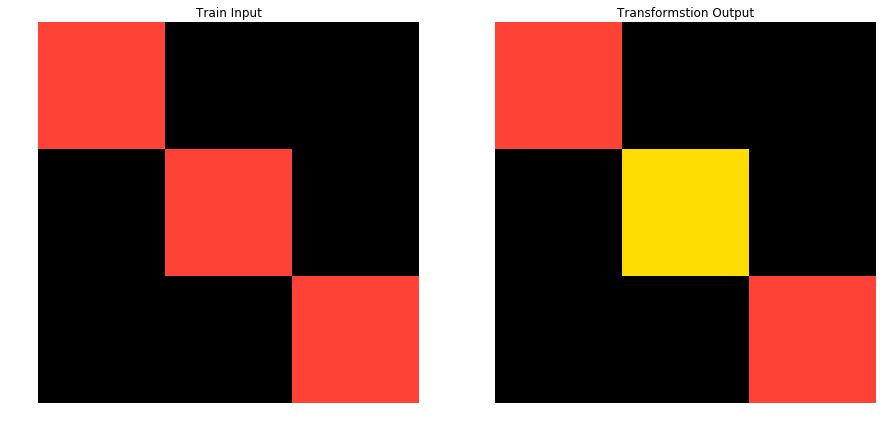

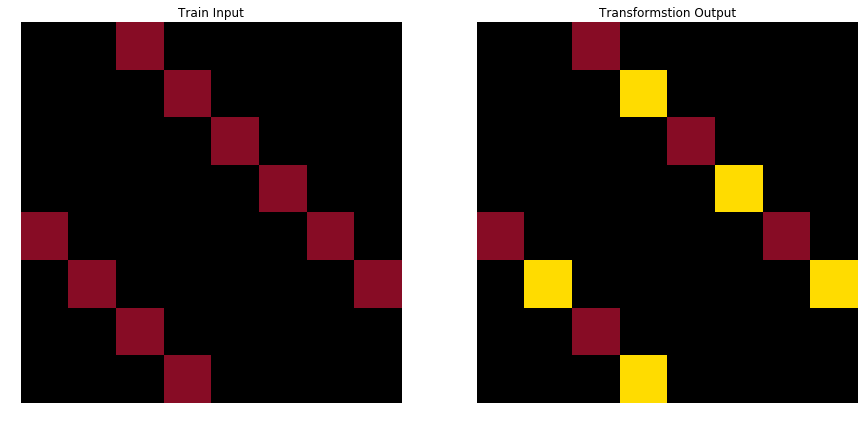

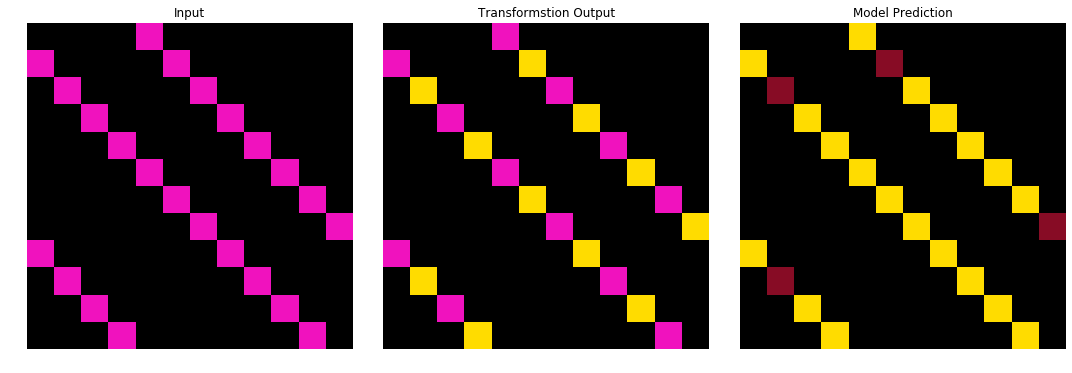

Number of input rows: 13 cols: 13
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a61ba2ce.json

Made predictions for  a61f2674
ensemble accuracy 0.8888888888888888



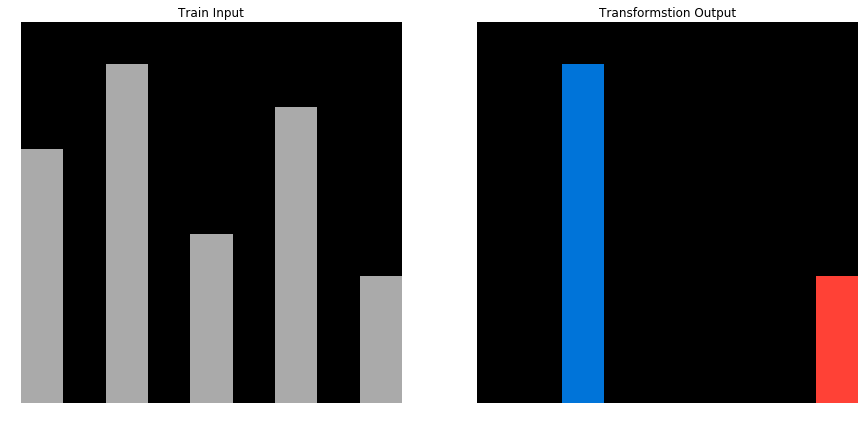

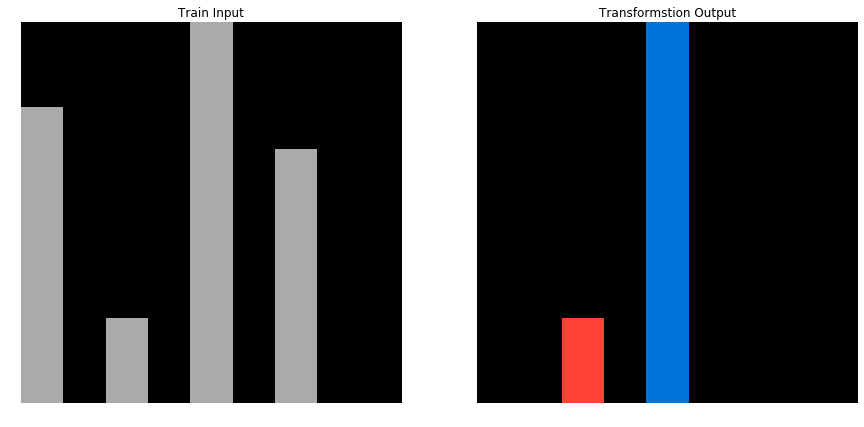

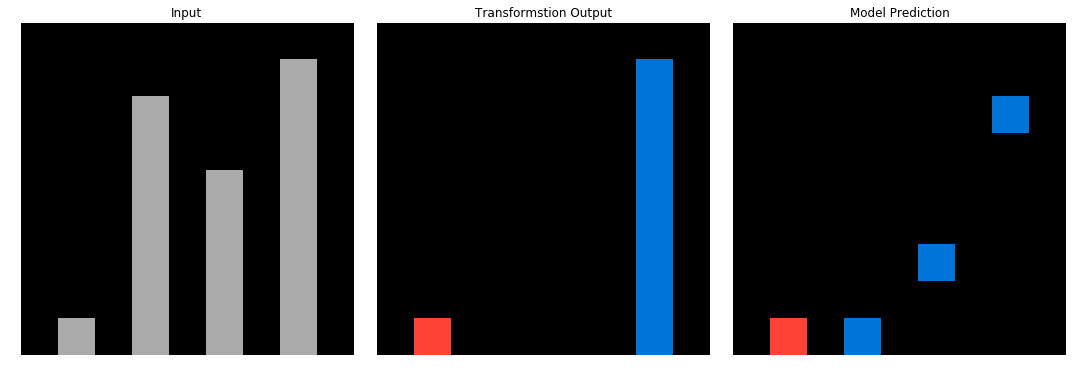

Made predictions for  a64e4611
ensemble accuracy 0.6922222222222222



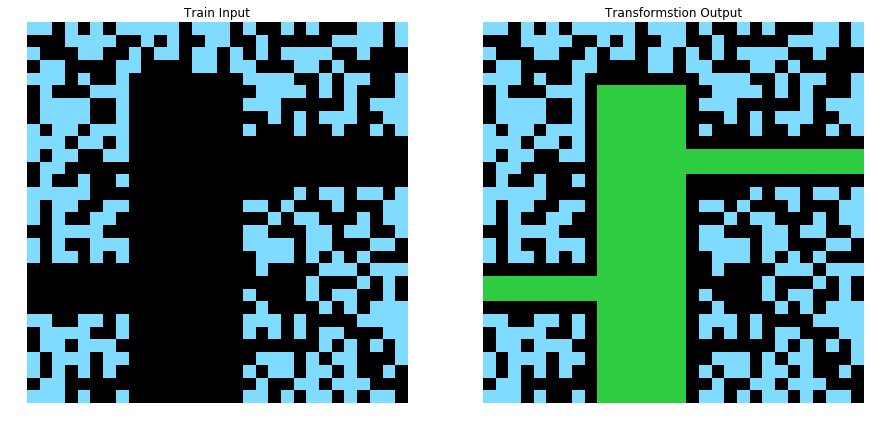

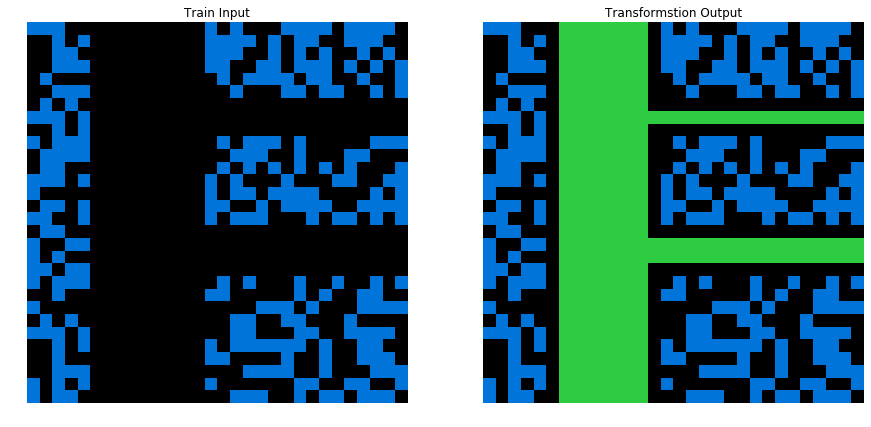

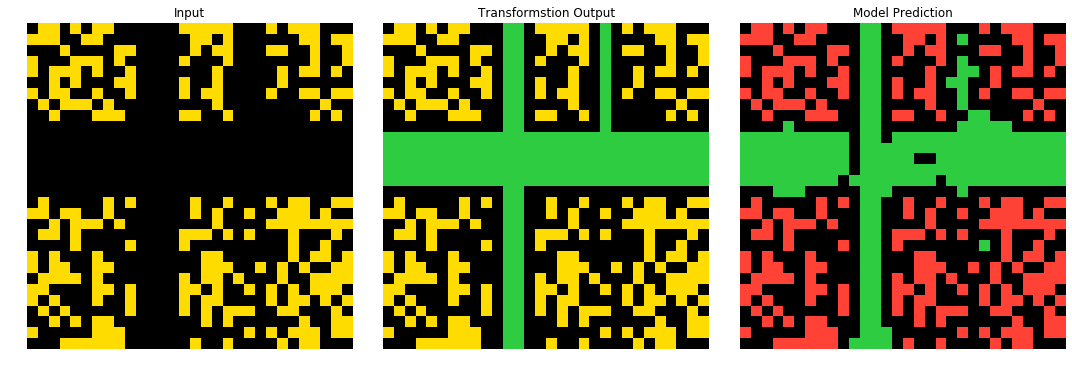

Made predictions for  a65b410d
ensemble accuracy 0.8641975308641975



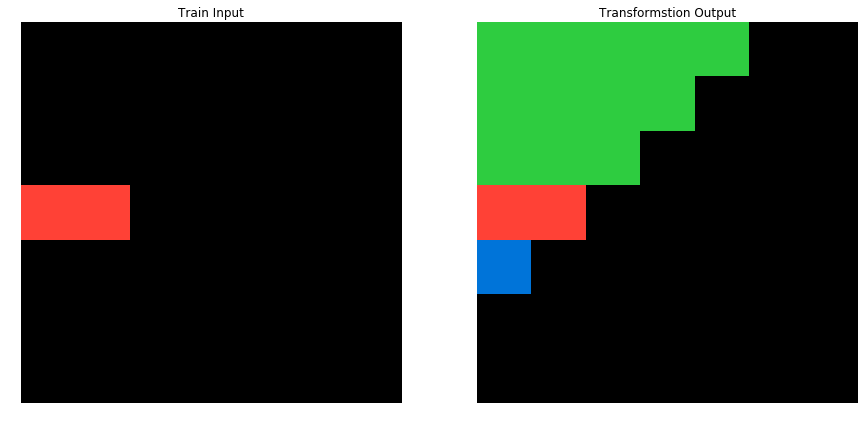

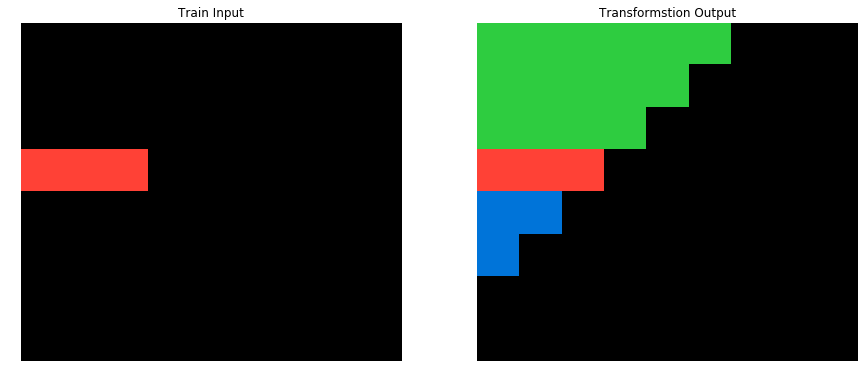

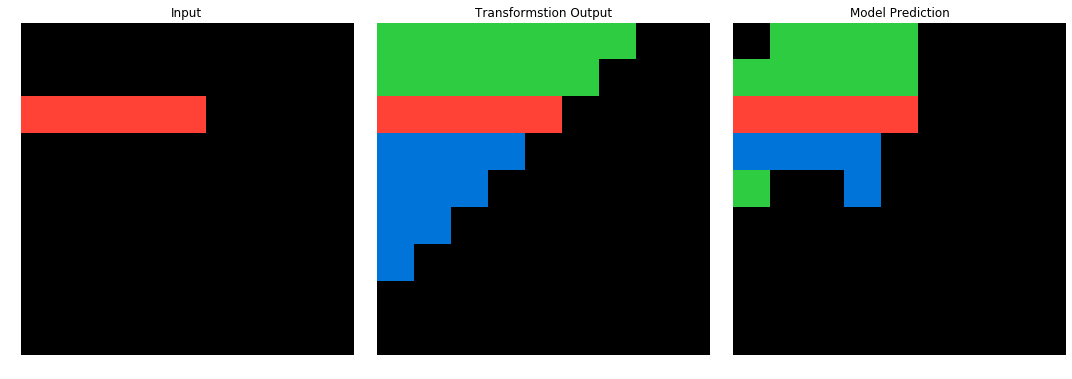

Number of input rows: 9 cols: 9
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a68b268e.json

Made predictions for  a699fb00
ensemble accuracy 1.0
a699fb00.json



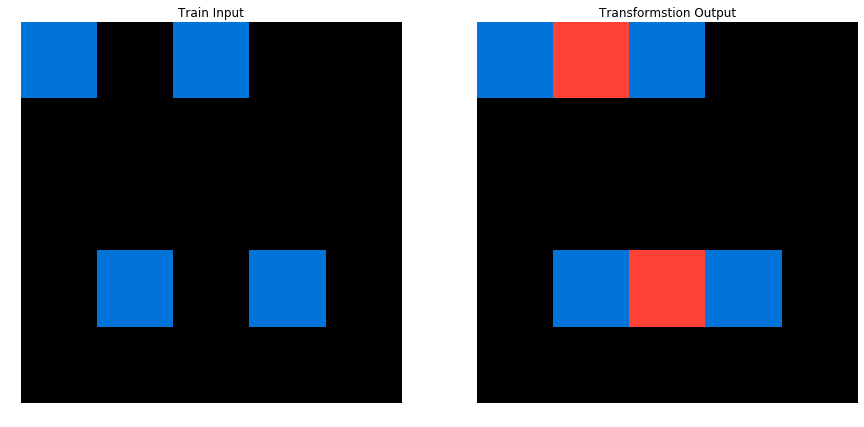

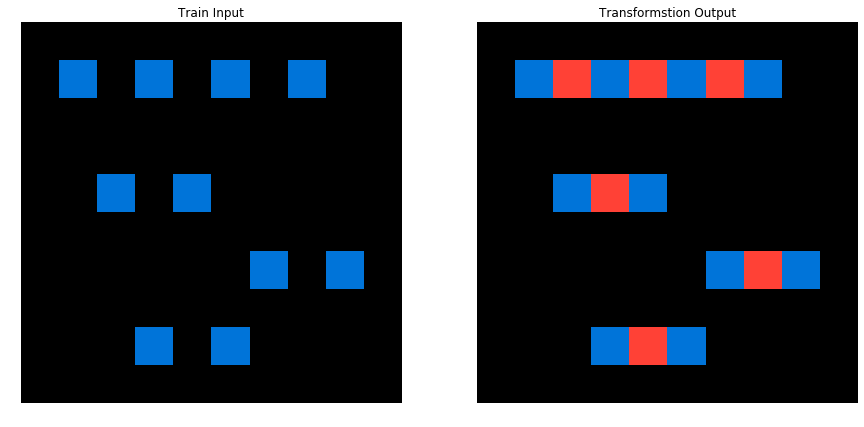

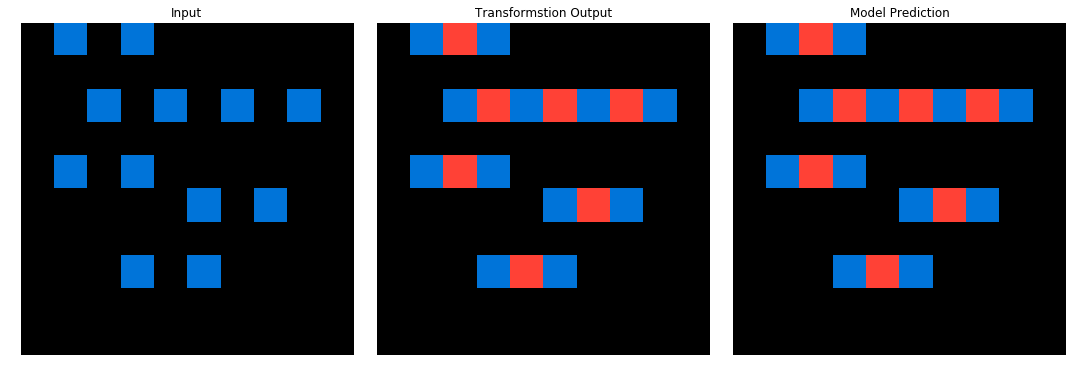

Number of input rows: 5 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a740d043.json

Made predictions for  a78176bb
ensemble accuracy 0.81



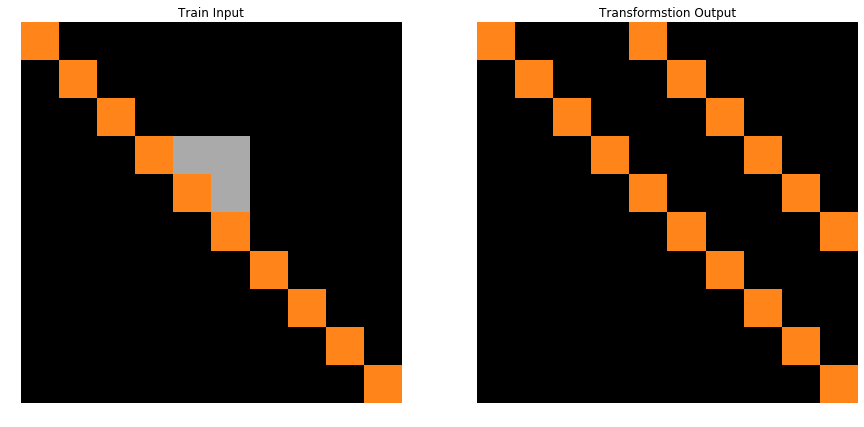

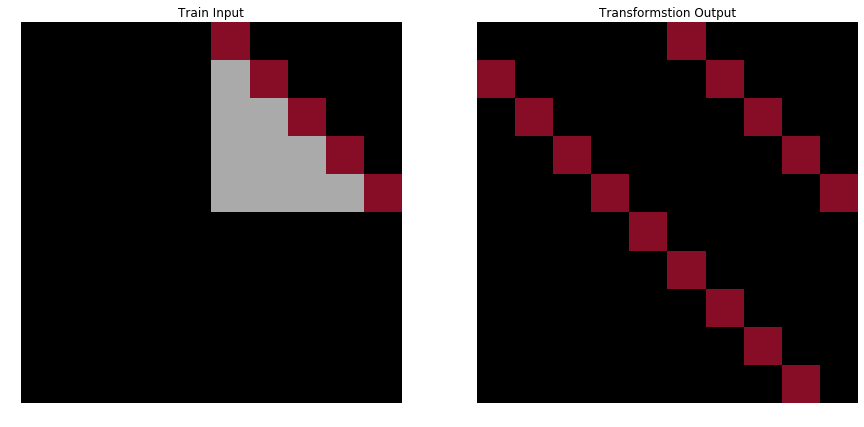

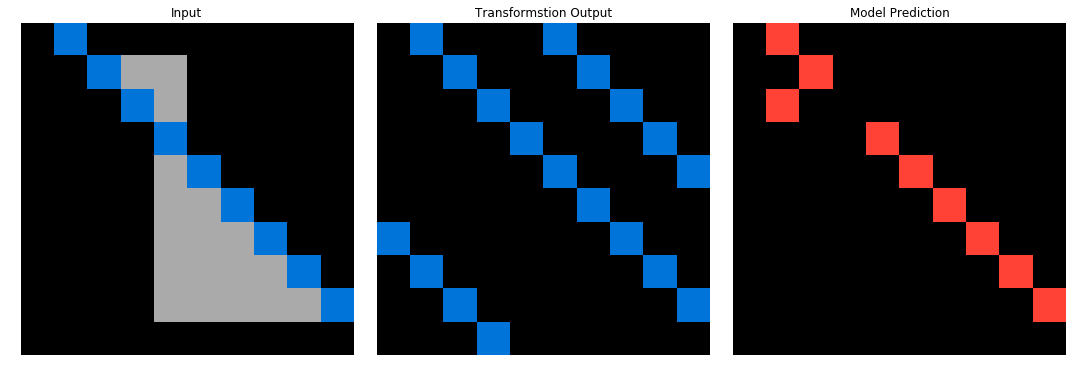

Made predictions for  a79310a0
ensemble accuracy 0.96
a79310a0.json



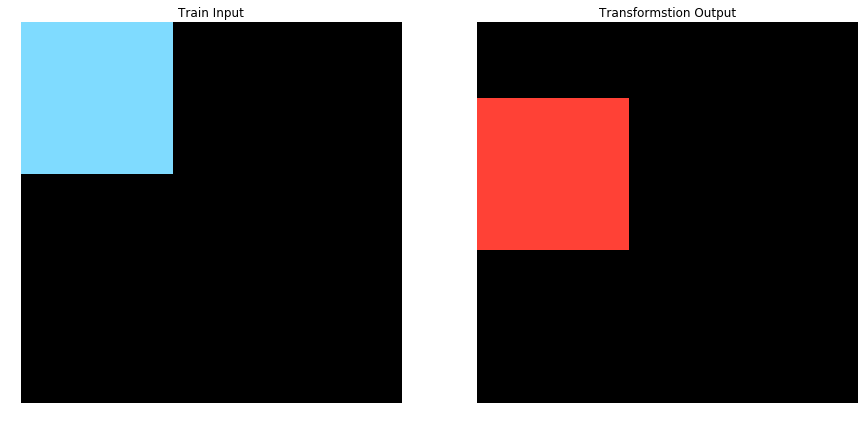

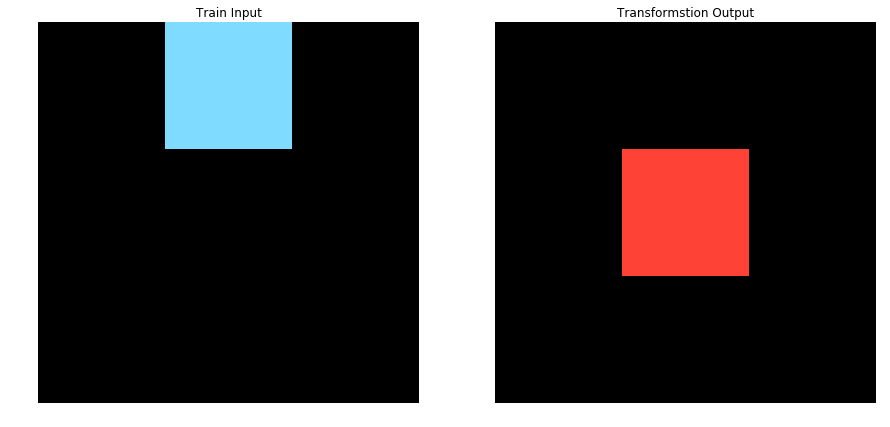

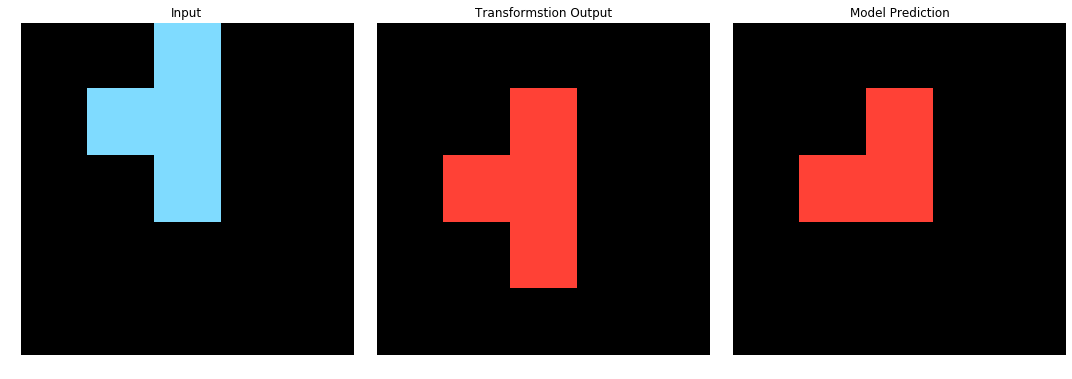

Made predictions for  a85d4709
ensemble accuracy 0.5555555555555556



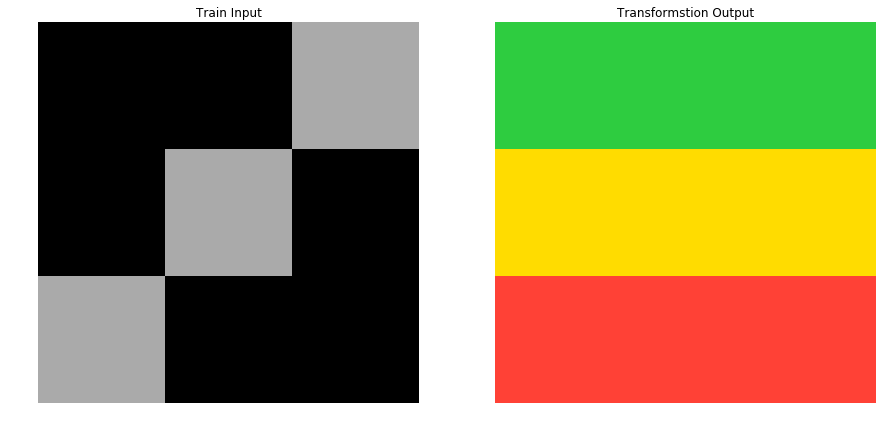

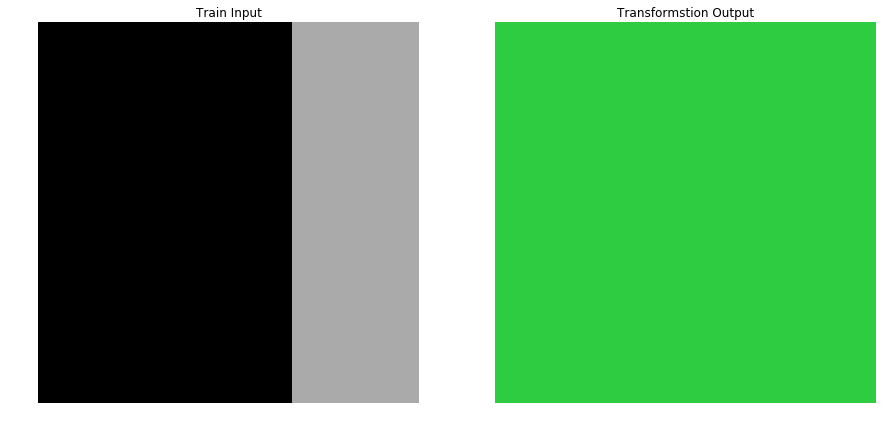

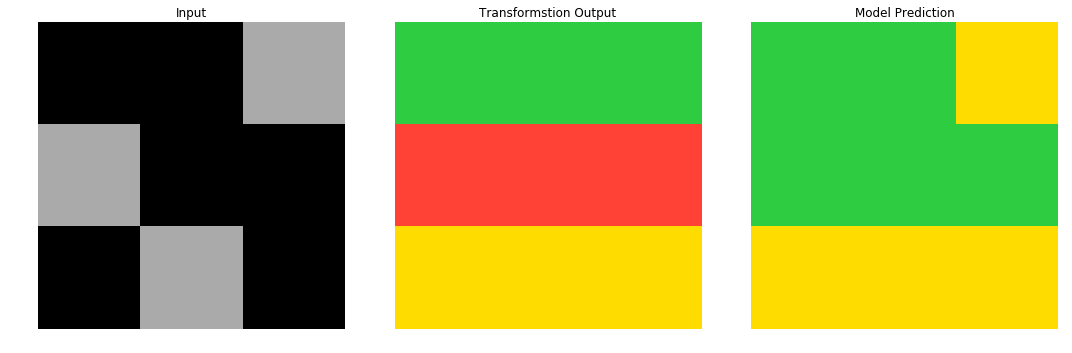

Number of input rows: 9 cols: 3
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a87f7484.json

Number of input rows: 14 cols: 14
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a8c38be5.json

Made predictions for  a8d7556c
ensemble accuracy 1.0
a8d7556c.json



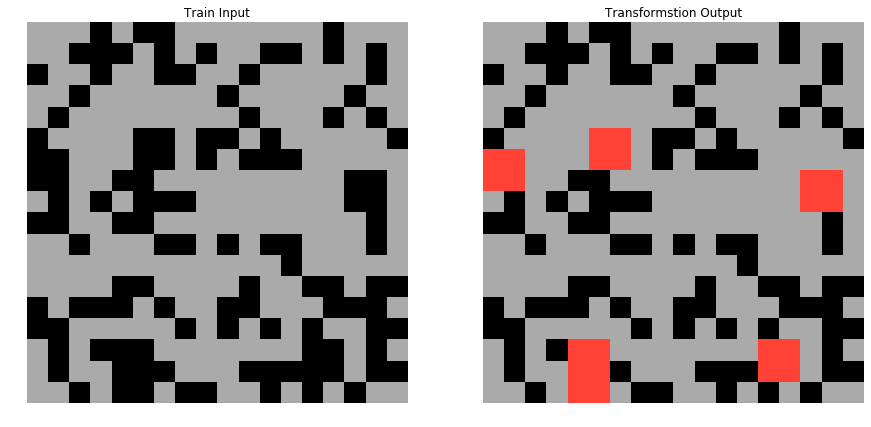

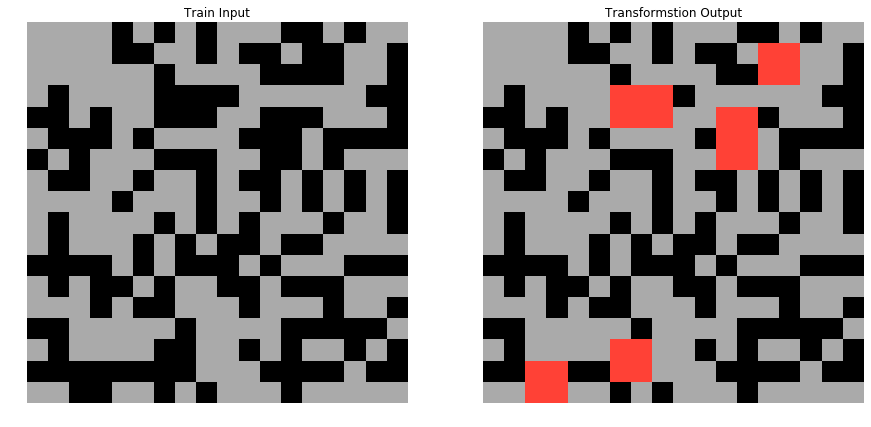

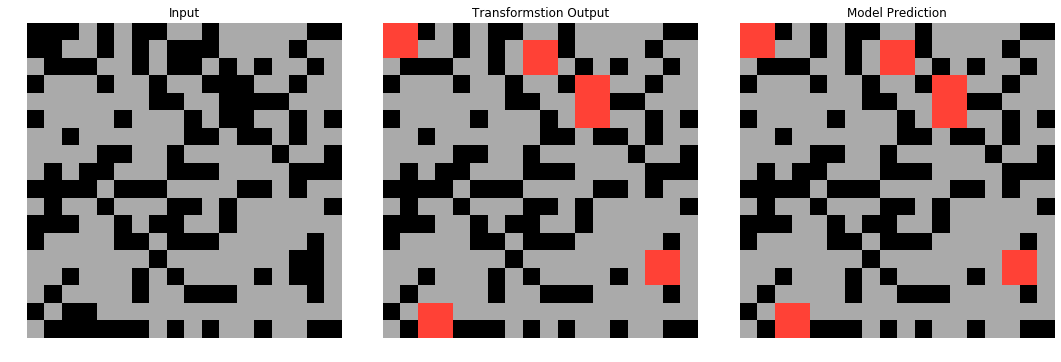

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  a9f96cdd
ensemble accuracy 0.8666666666666667



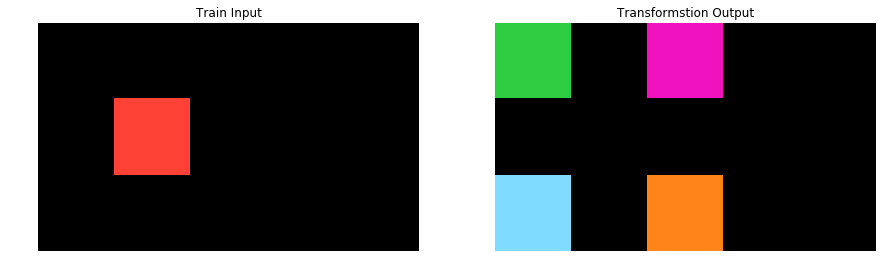

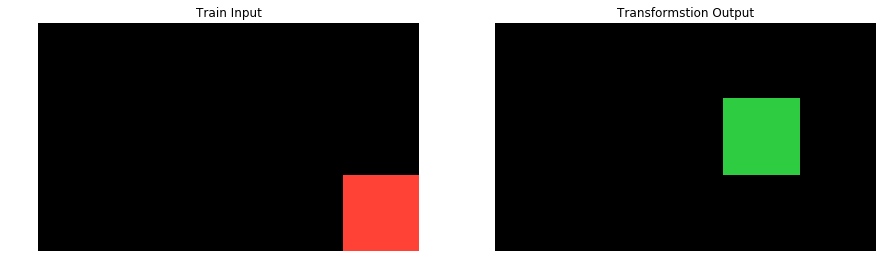

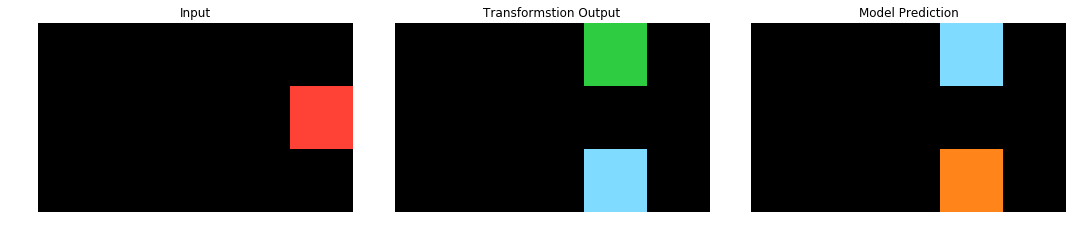

Made predictions for  aabf363d
ensemble accuracy 0.673469387755102



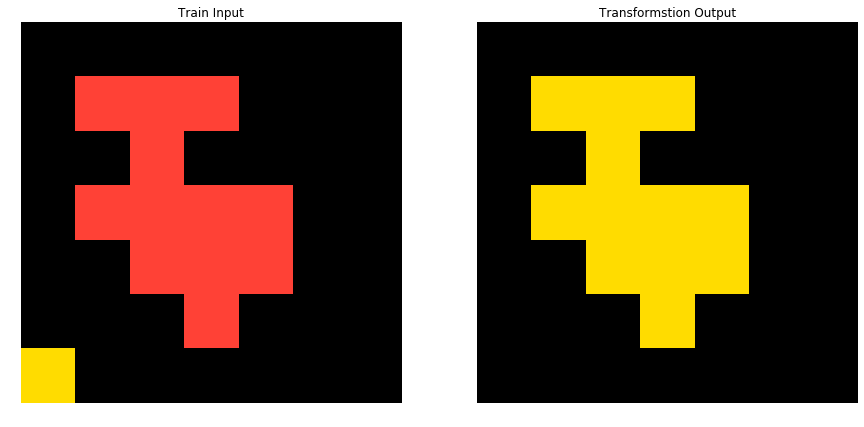

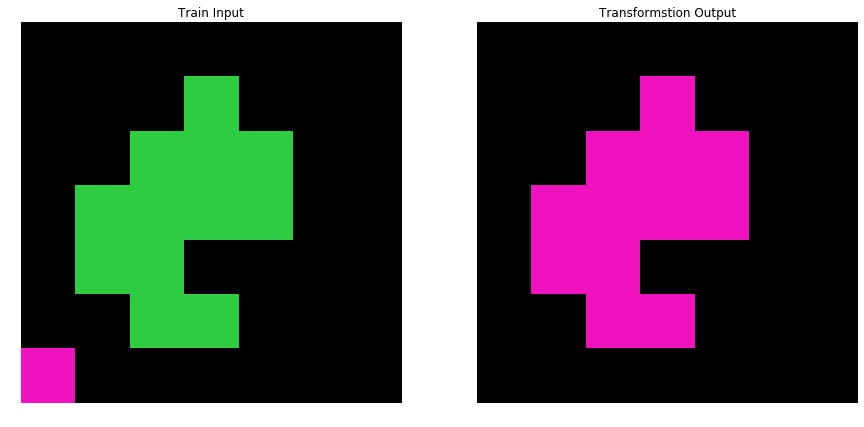

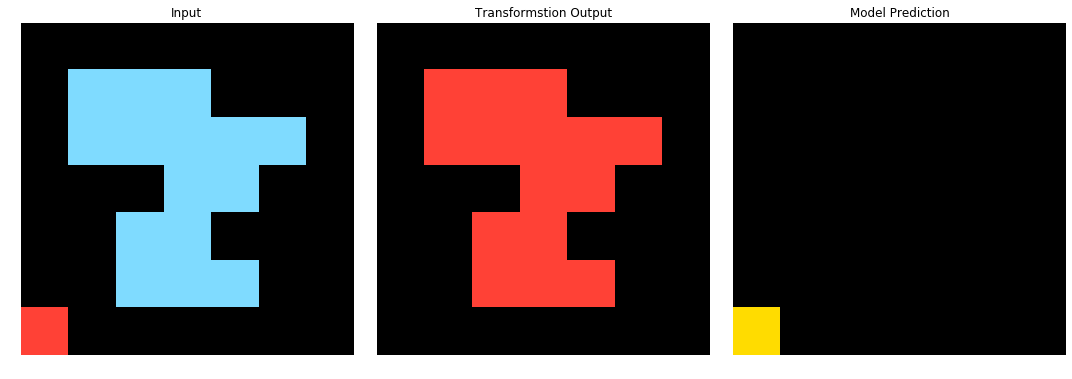

Made predictions for  aba27056
ensemble accuracy 0.57



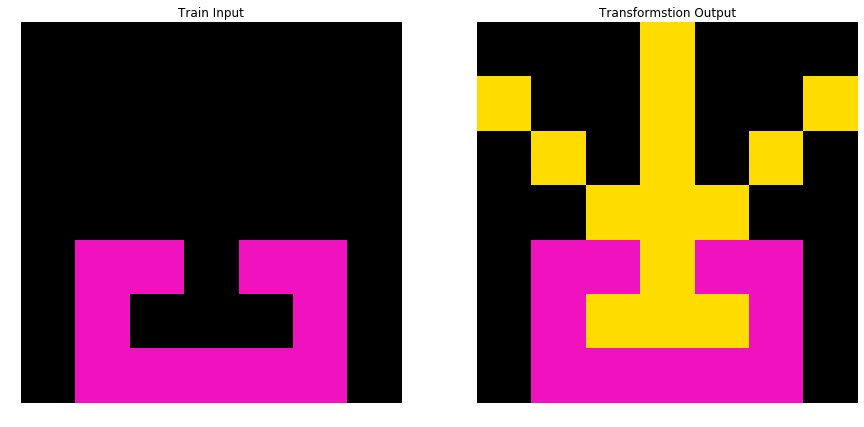

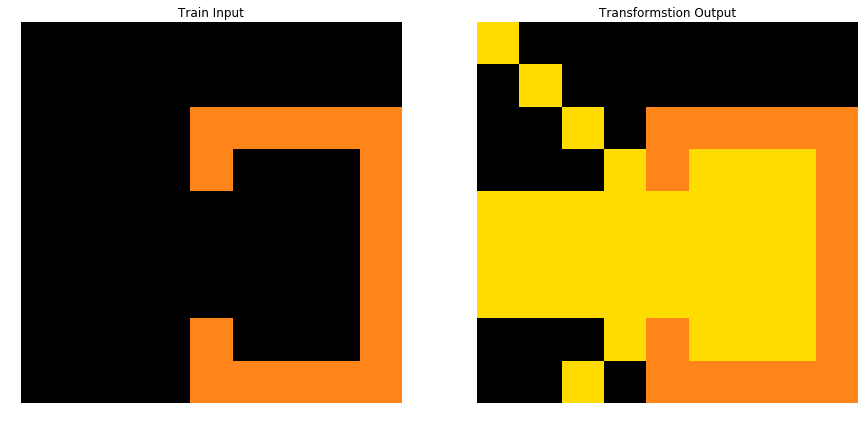

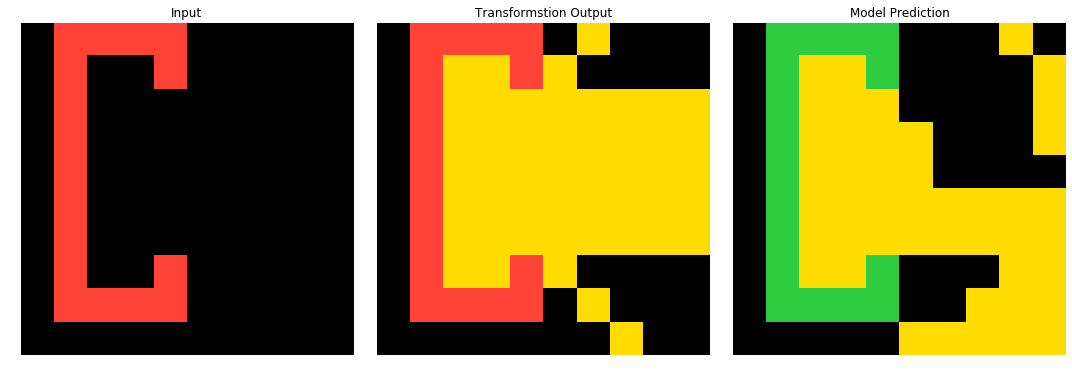

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ac0a08a4.json

Made predictions for  ae3edfdc
ensemble accuracy 0.9777777777777777
ae3edfdc.json



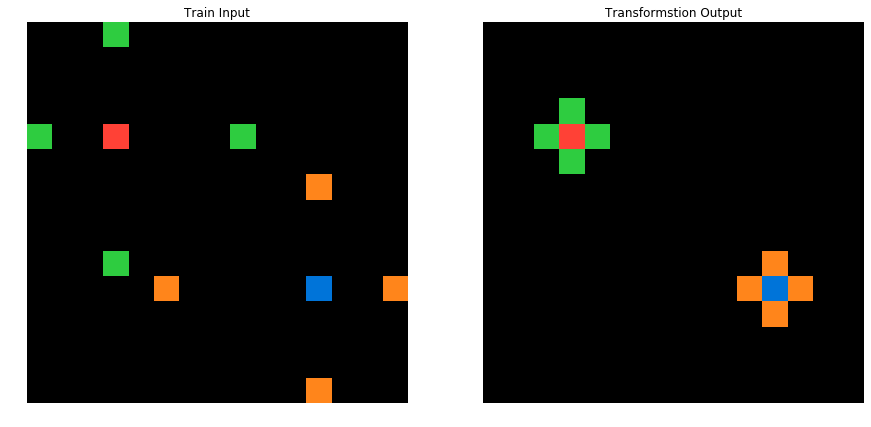

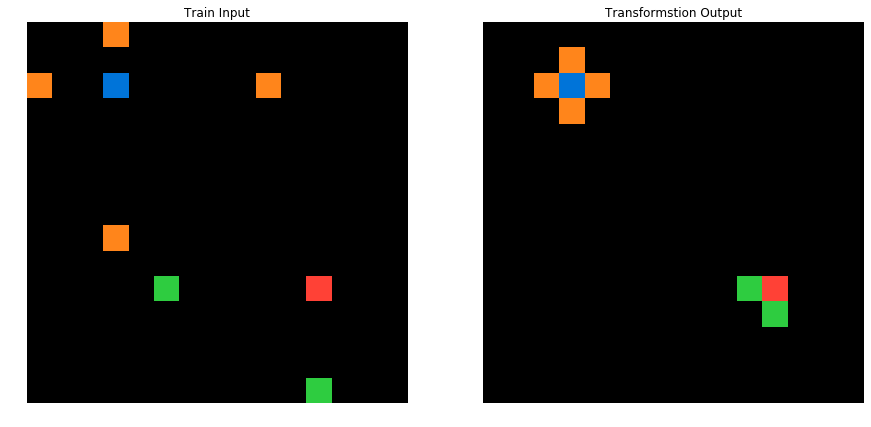

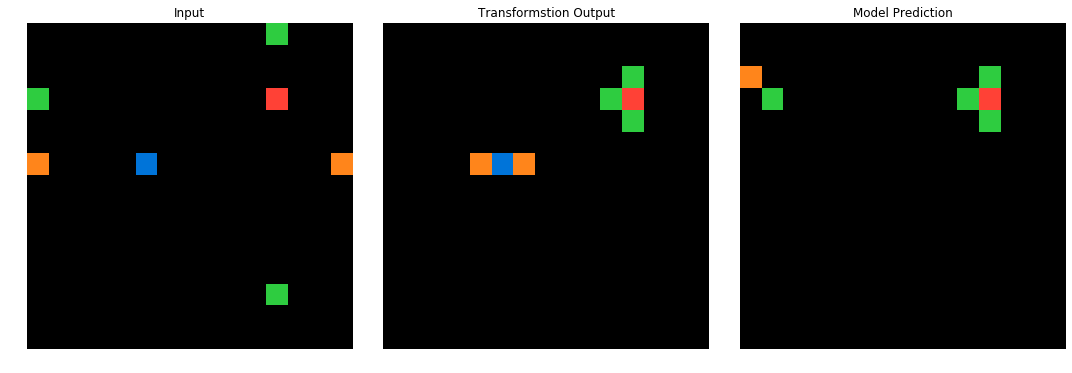

Number of input rows: 9 cols: 9
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ae4f1146.json

Made predictions for  aedd82e4
ensemble accuracy 1.0
aedd82e4.json



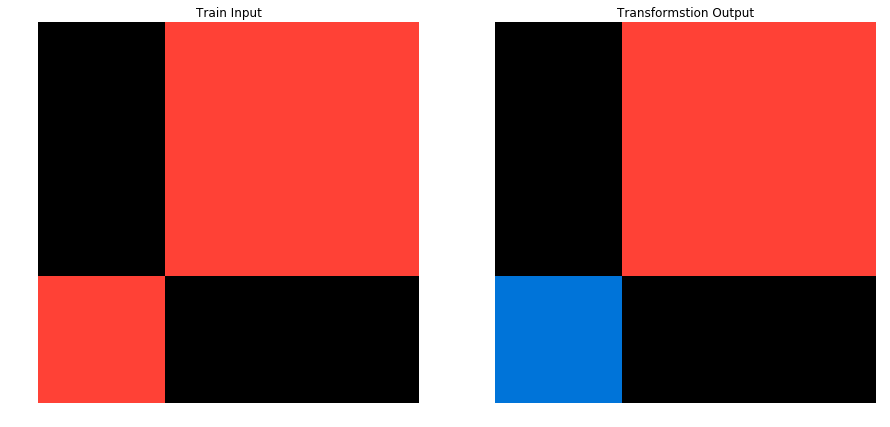

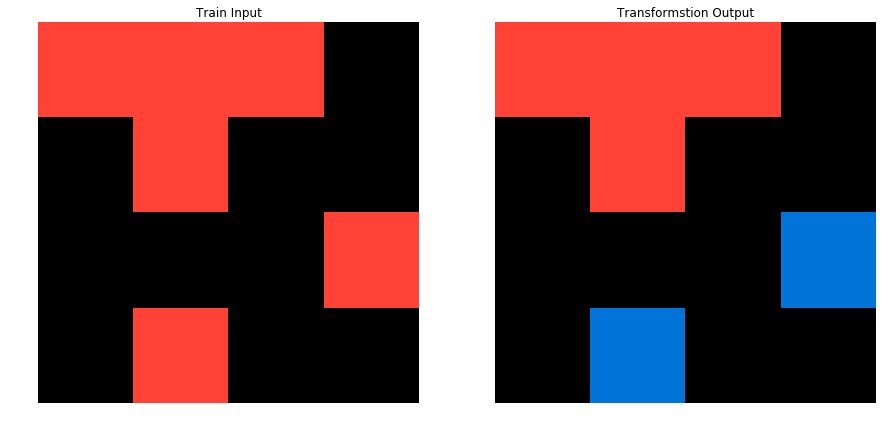

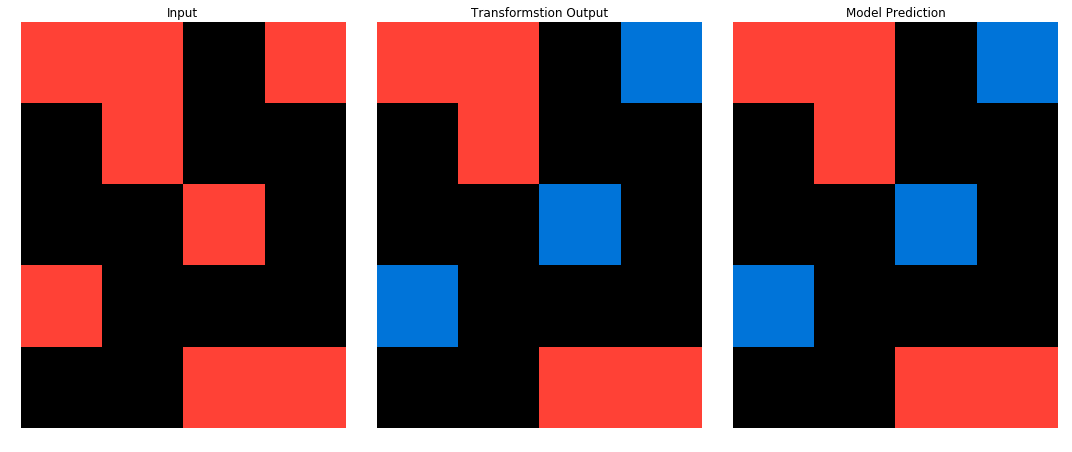

Made predictions for  af902bf9
ensemble accuracy 0.89



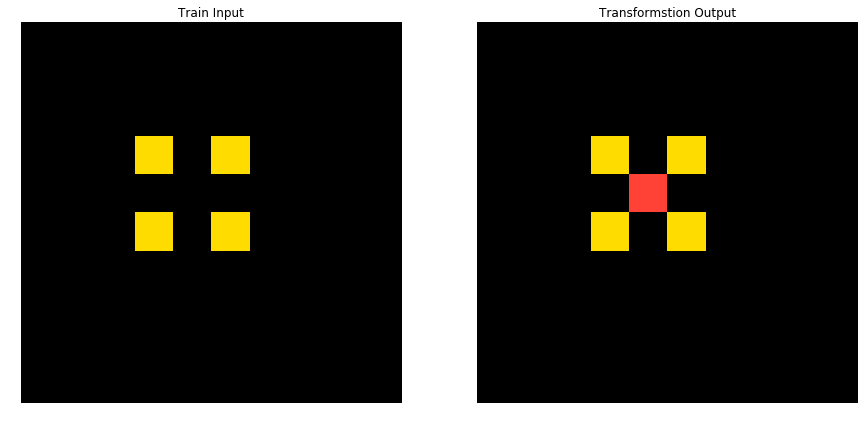

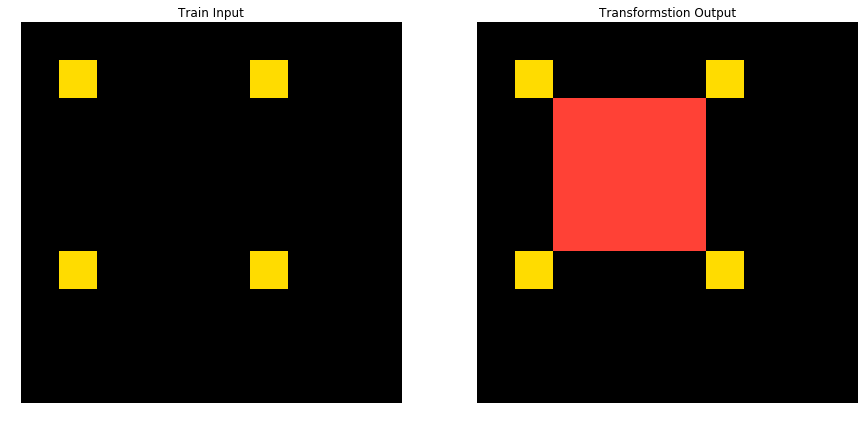

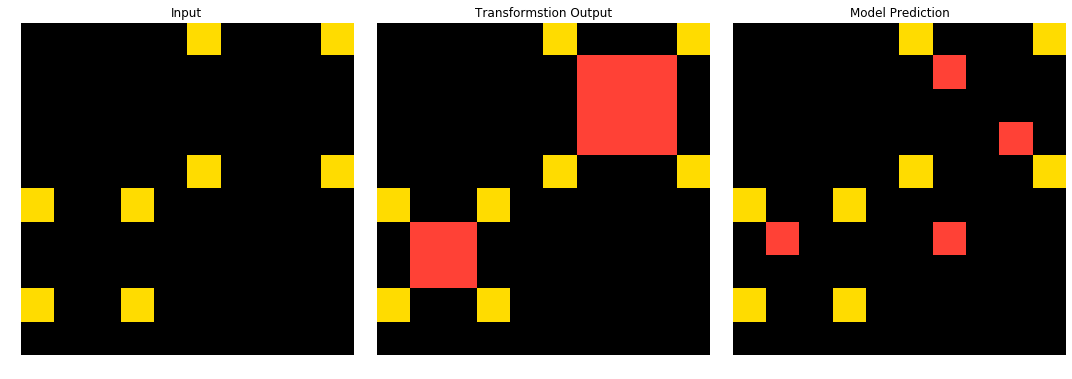

Number of input rows: 6 cols: 6
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b0c4d837.json

Number of input rows: 3 cols: 6
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b190f7f5.json

Made predictions for  b1948b0a
ensemble accuracy 1.0
b1948b0a.json



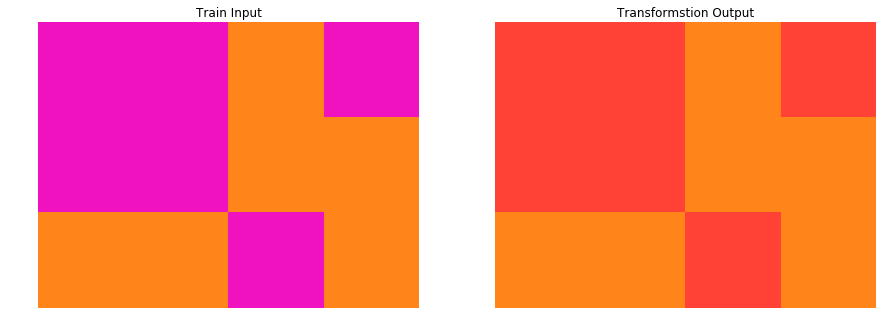

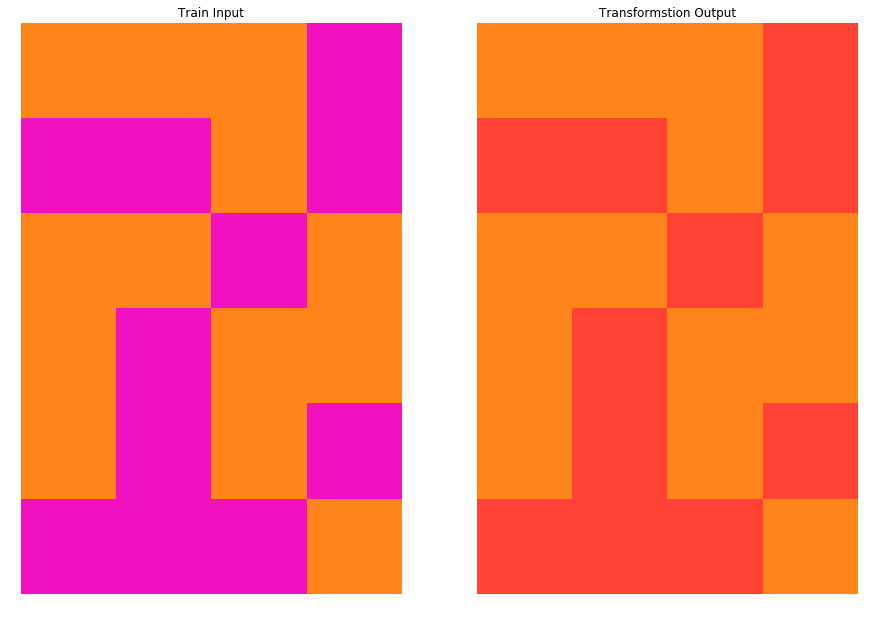

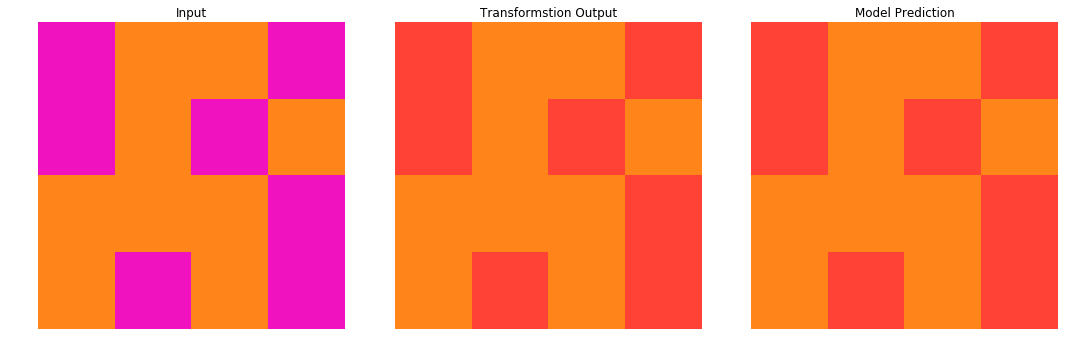

Made predictions for  b230c067
ensemble accuracy 0.9



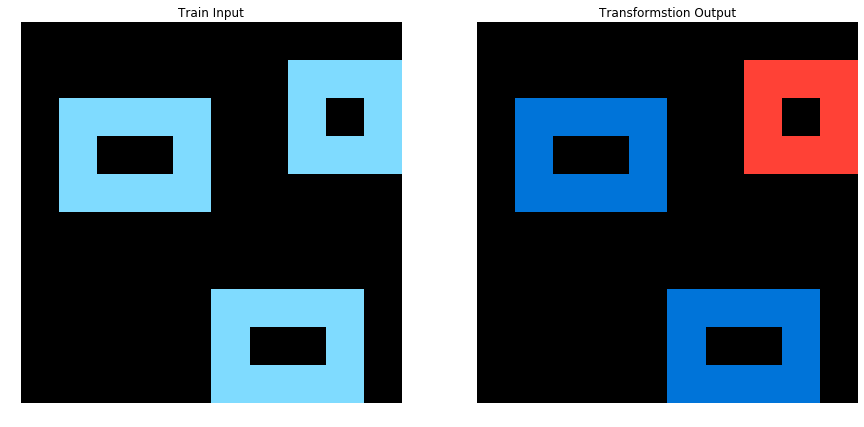

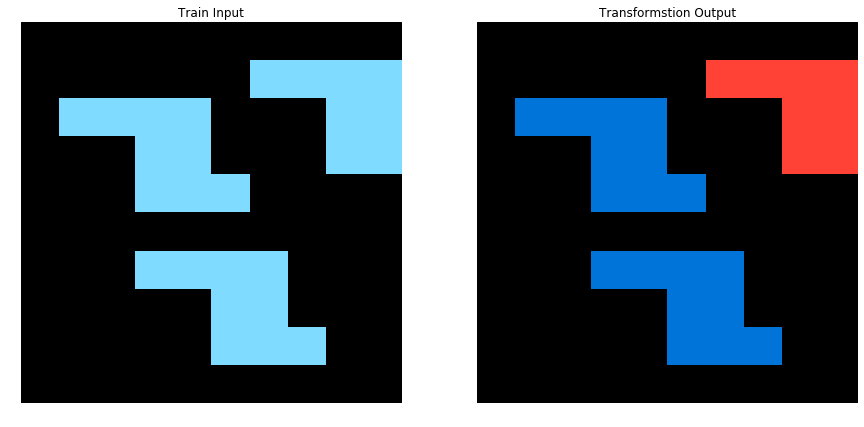

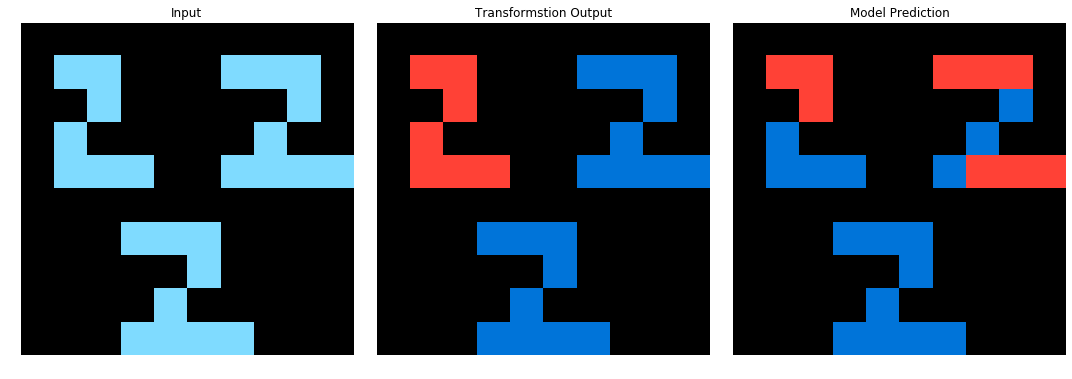

Made predictions for  b27ca6d3
ensemble accuracy 0.8492647058823529



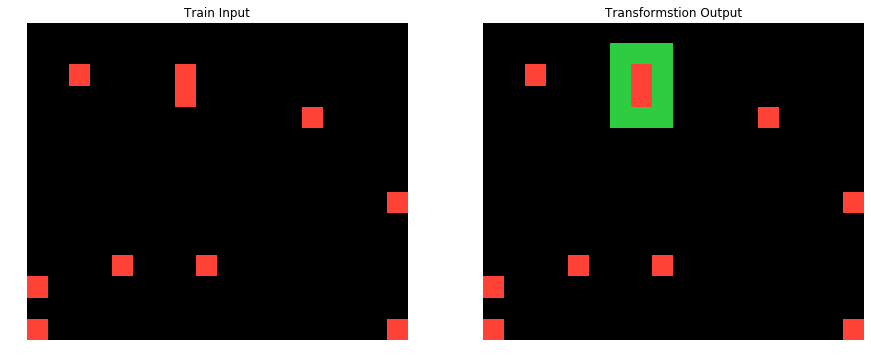

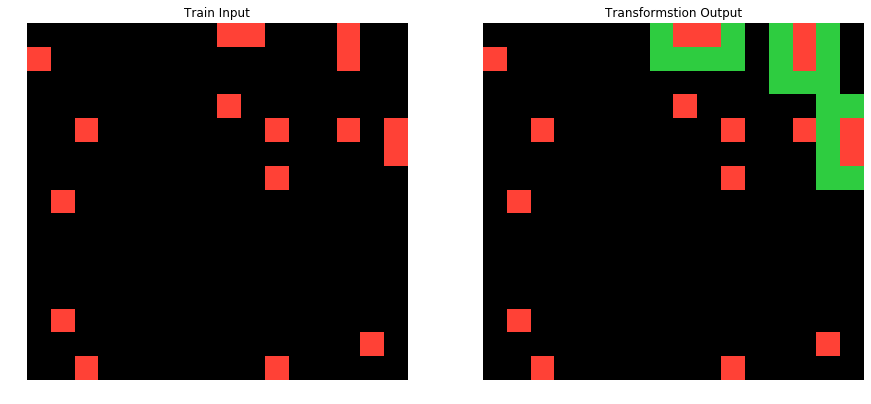

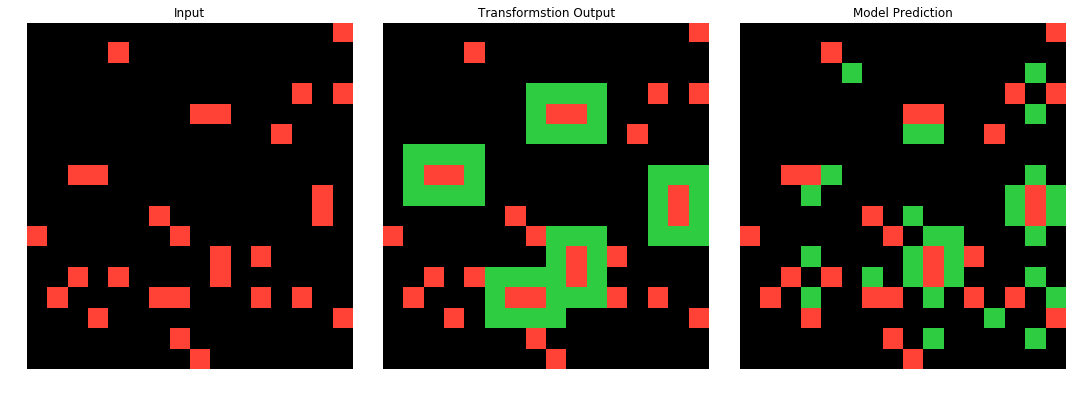

Made predictions for  b2862040
ensemble accuracy 0.8708333333333333



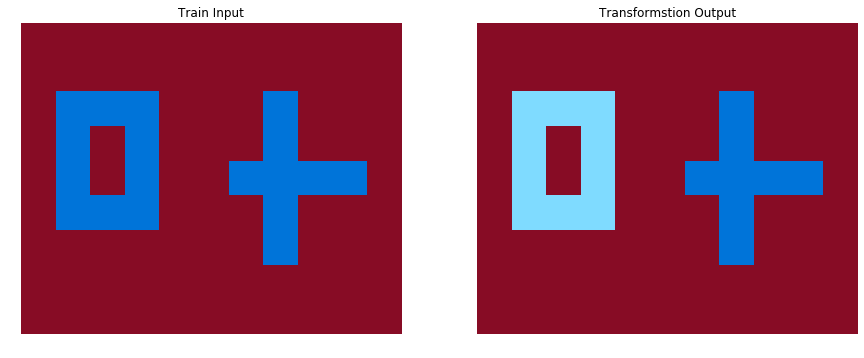

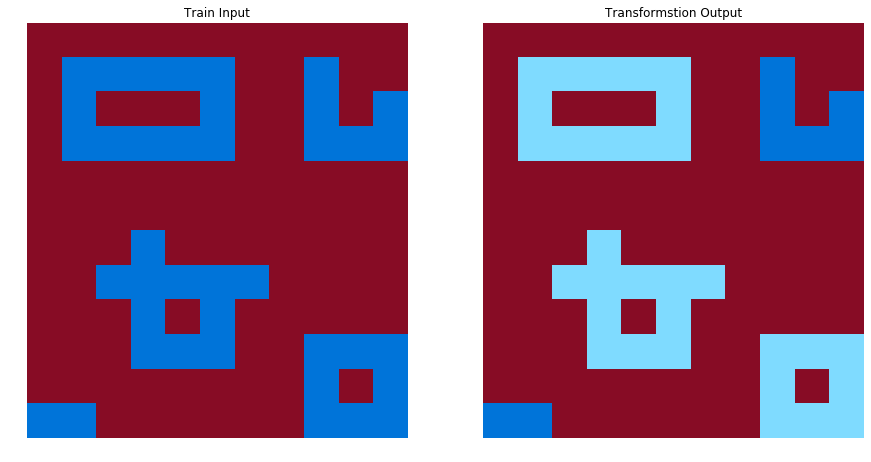

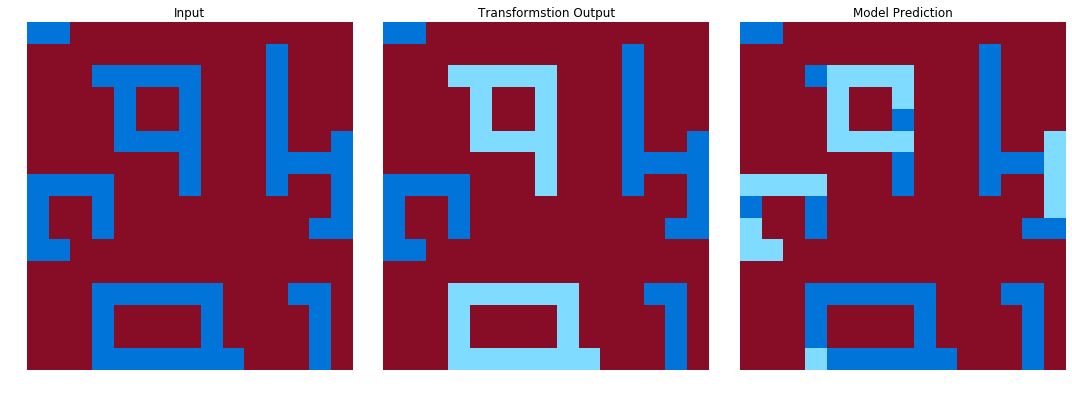

Made predictions for  b527c5c6
ensemble accuracy 0.7175



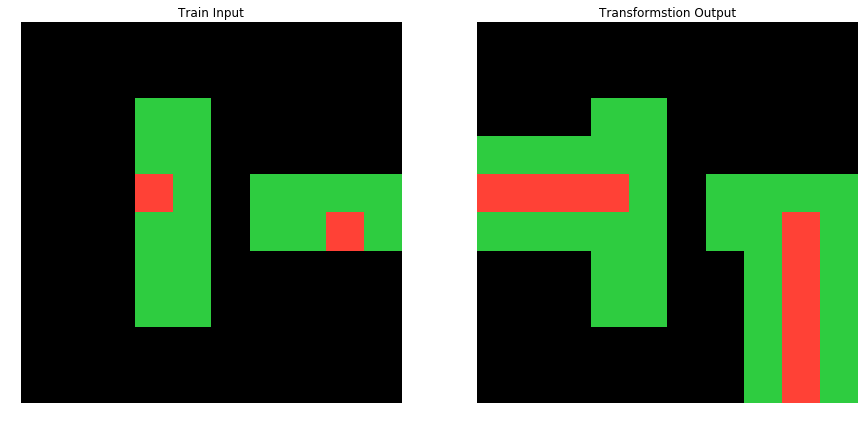

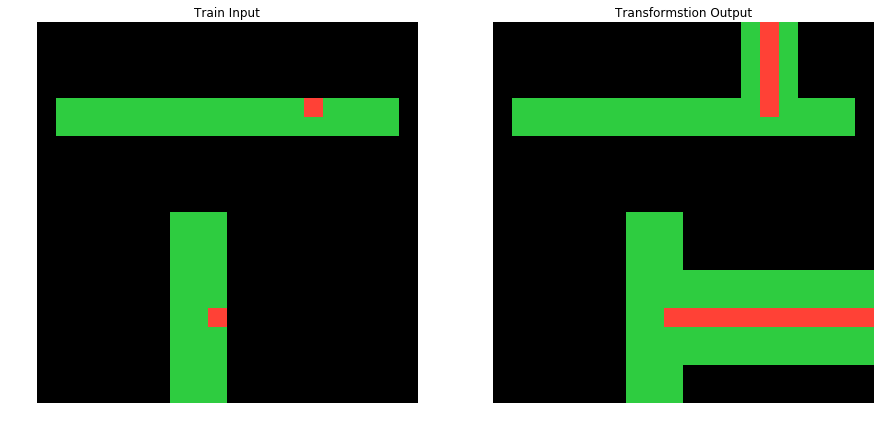

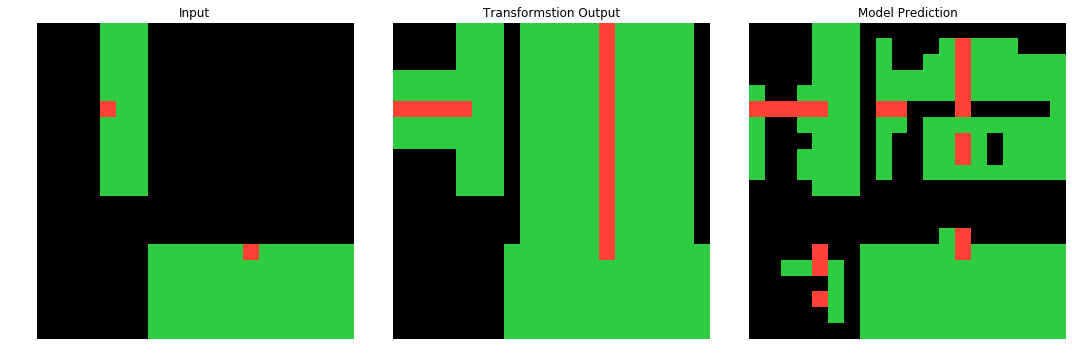

Made predictions for  b548a754
ensemble accuracy 0.5680473372781065



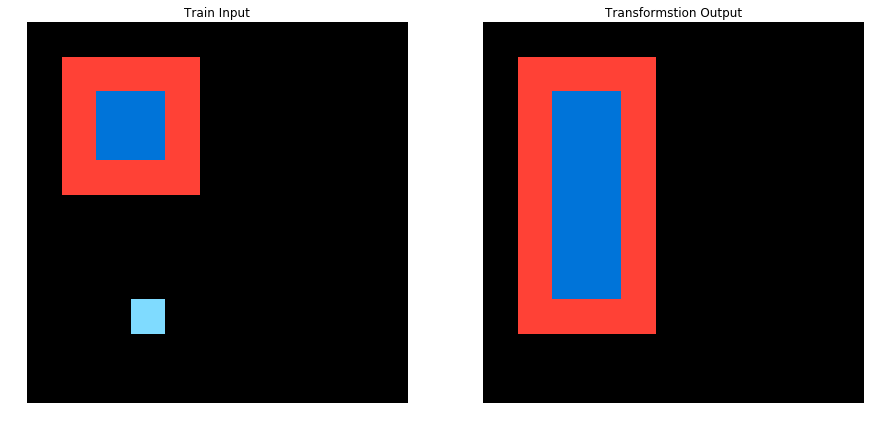

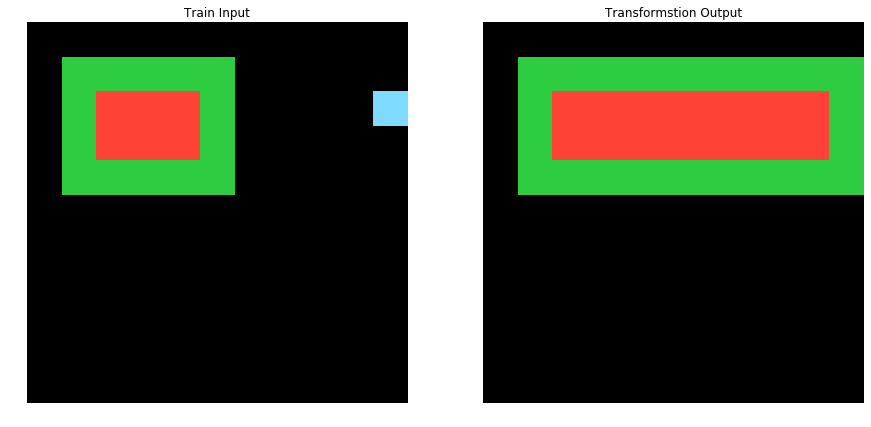

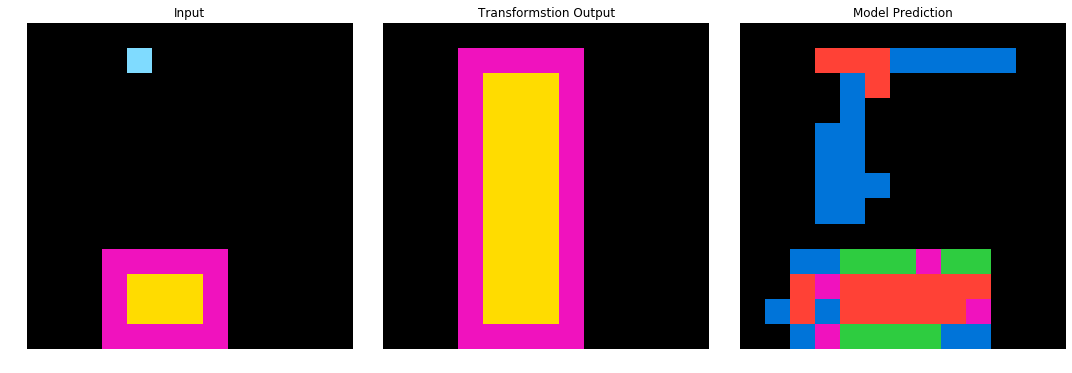

Made predictions for  b60334d2
ensemble accuracy 1.0
b60334d2.json



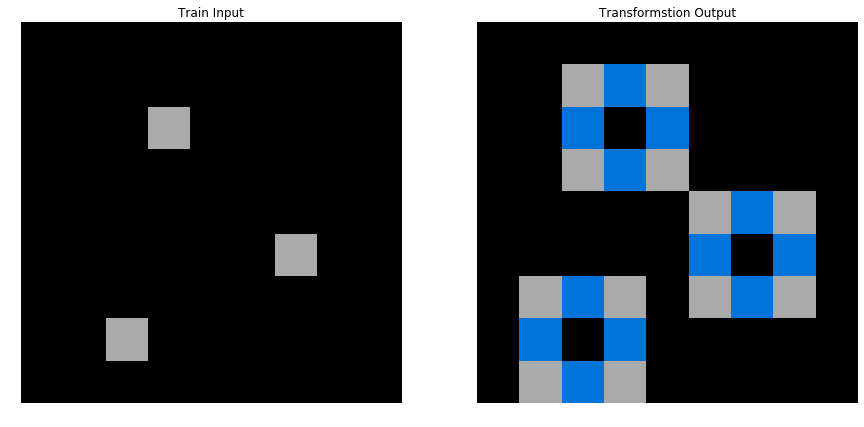

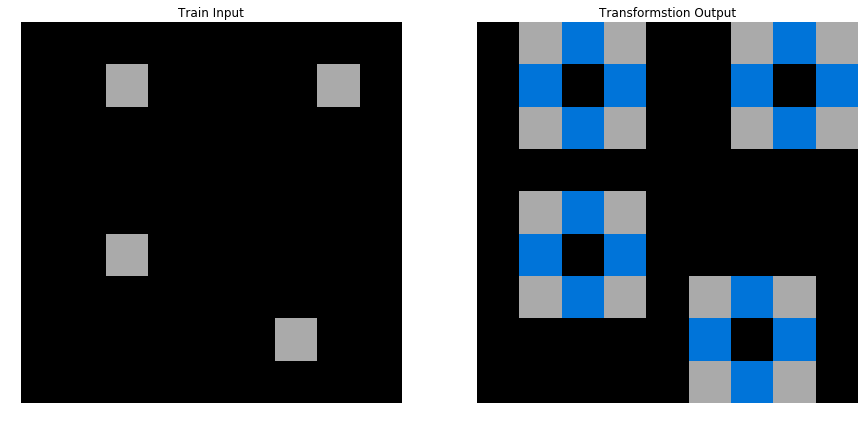

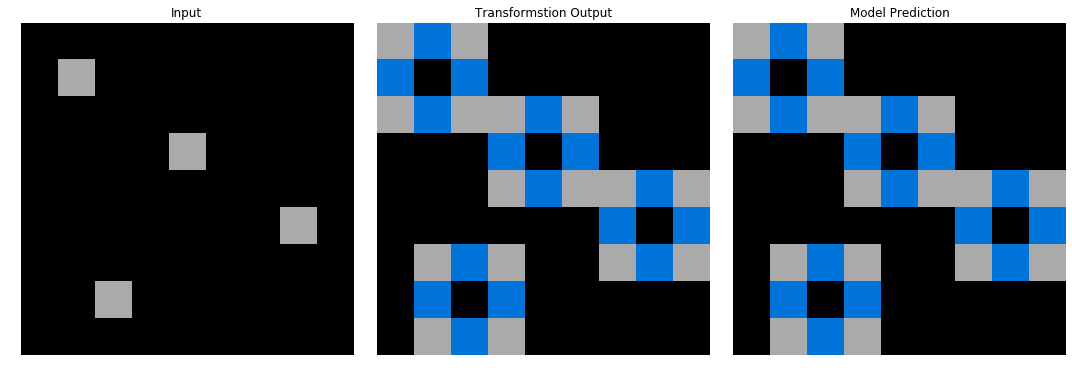

Made predictions for  b6afb2da
ensemble accuracy 0.99
b6afb2da.json



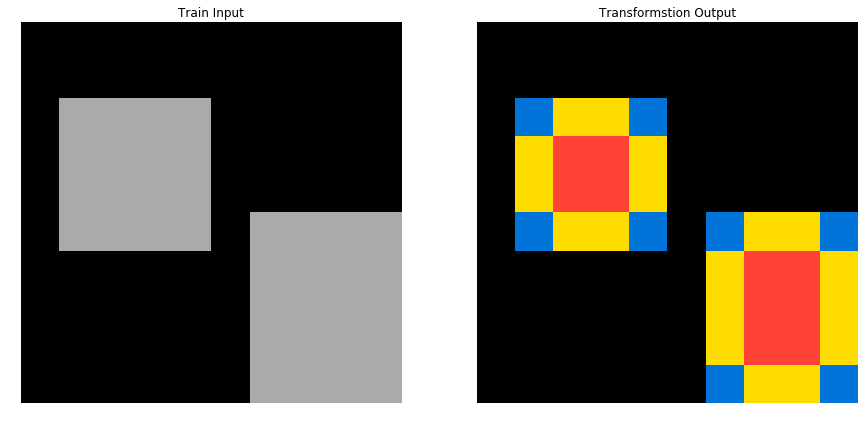

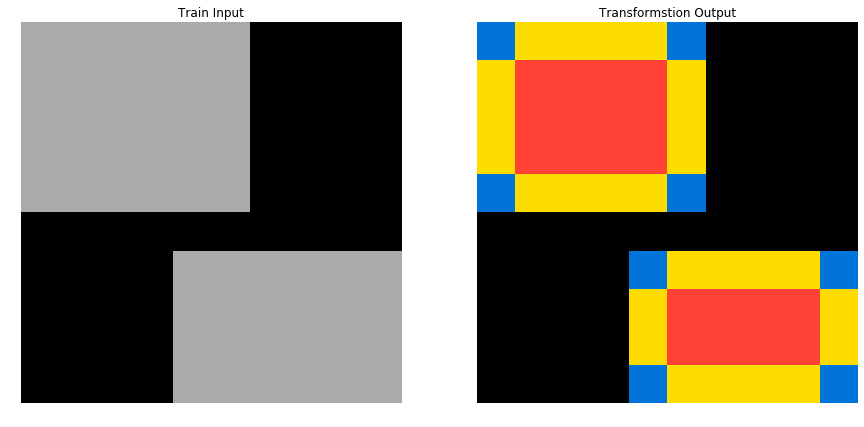

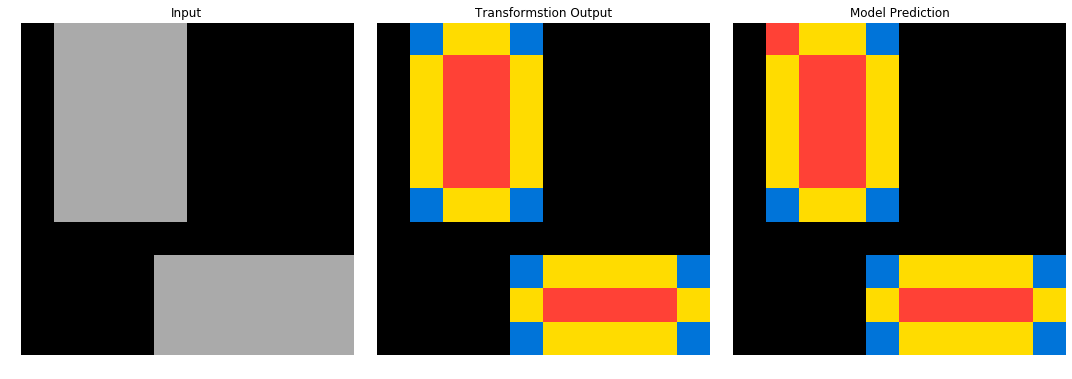

Made predictions for  b7249182
ensemble accuracy 0.8304093567251462



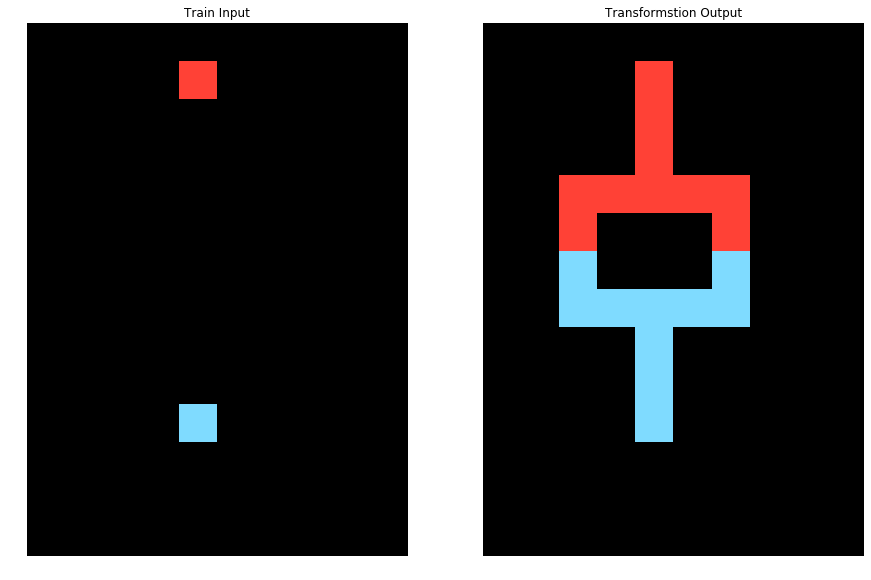

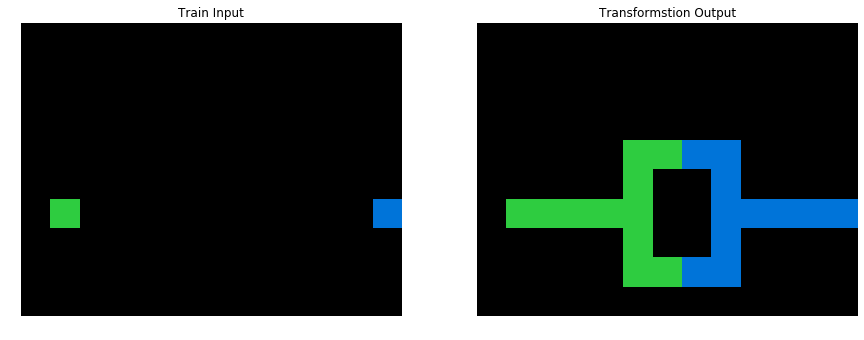

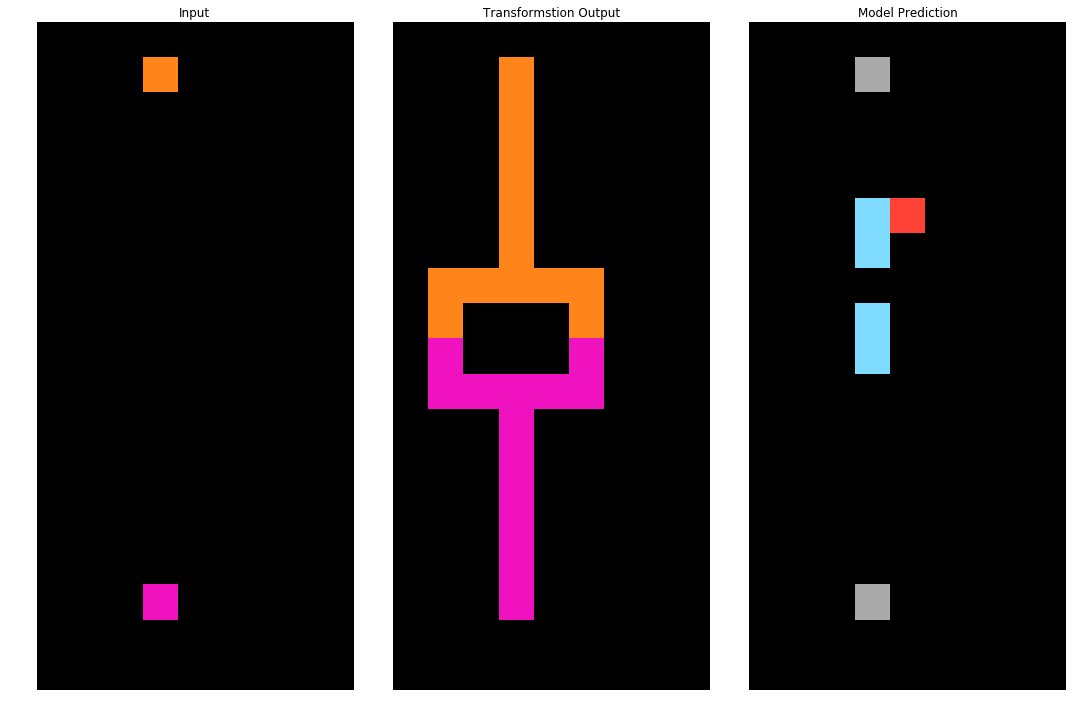

Made predictions for  b775ac94
ensemble accuracy 0.9288194444444444



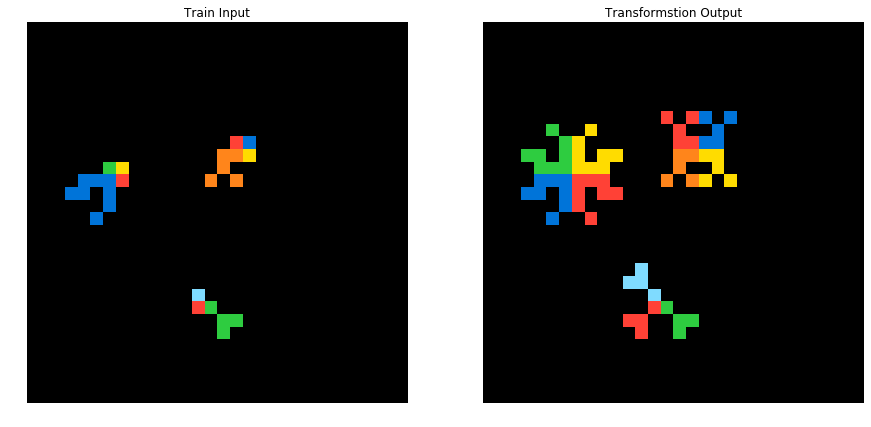

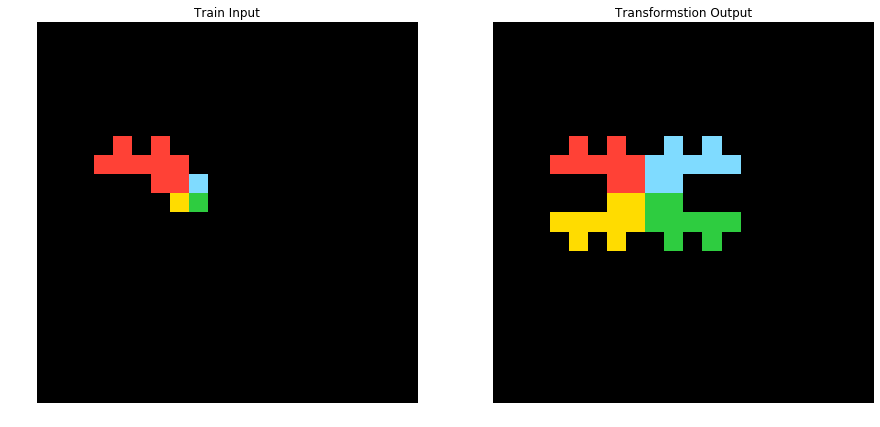

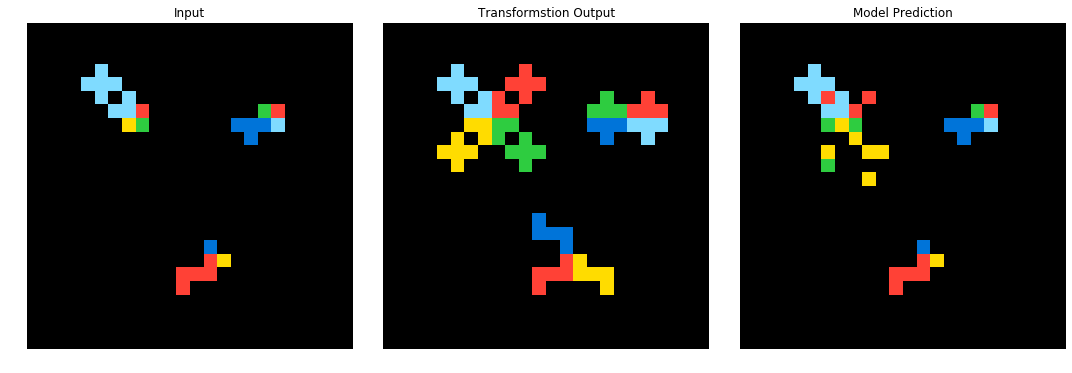

Made predictions for  b782dc8a
ensemble accuracy 0.7155555555555555



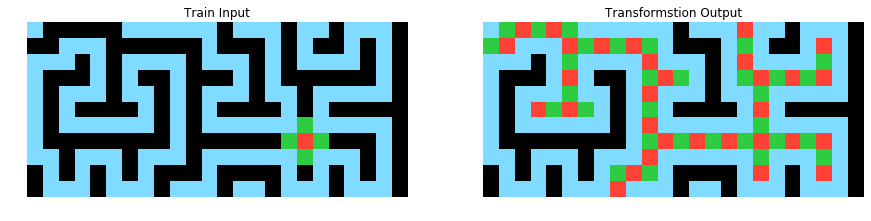

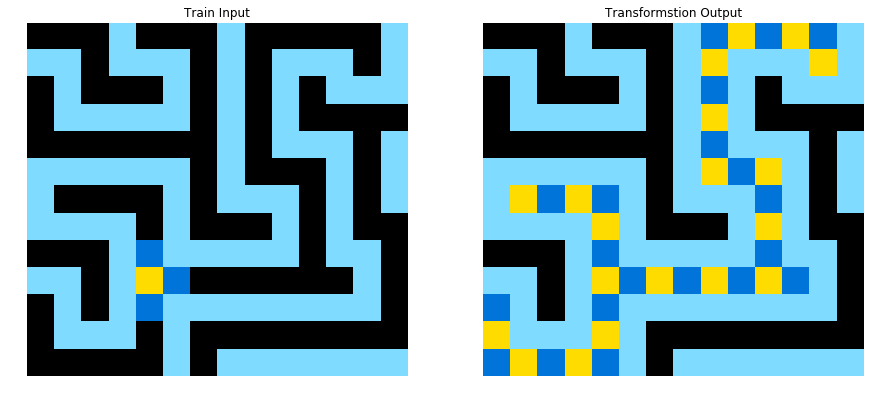

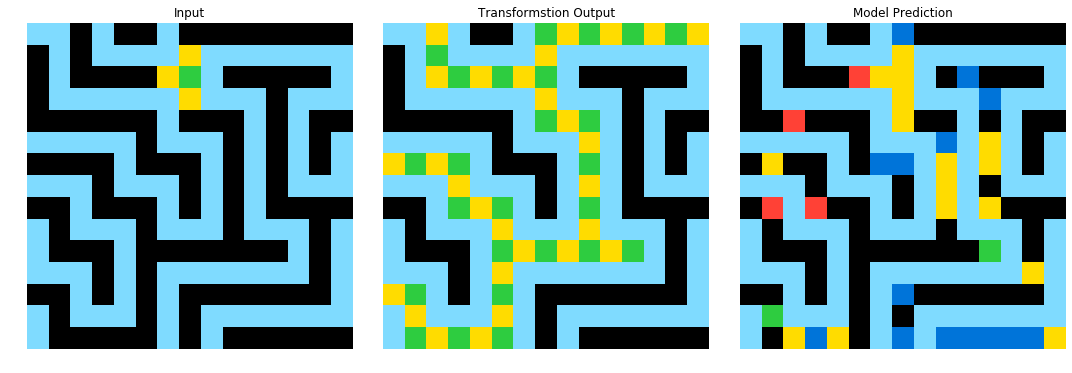

Made predictions for  b8825c91
ensemble accuracy 0.92578125



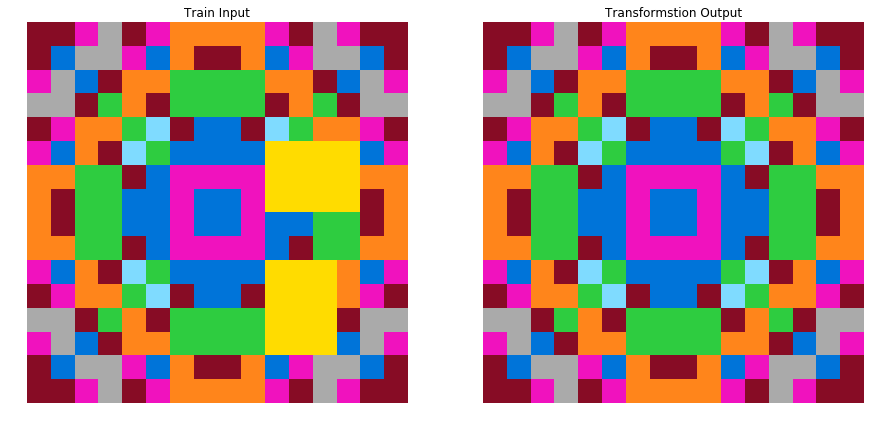

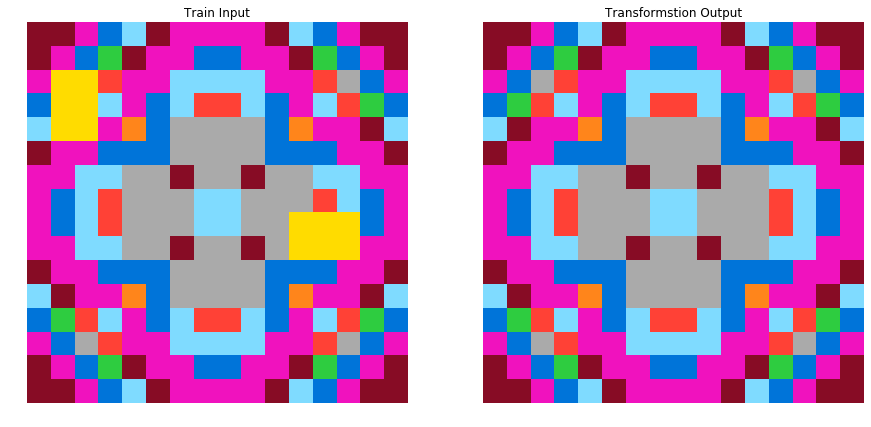

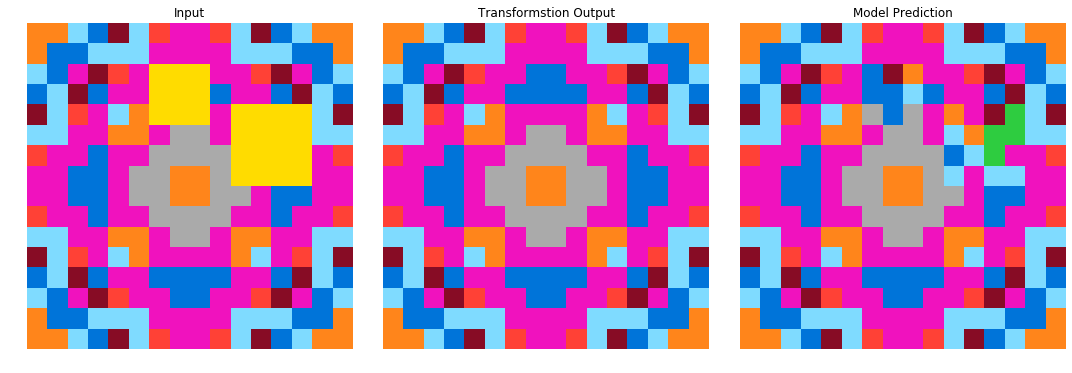

Made predictions for  b8cdaf2b
ensemble accuracy 0.8765432098765432



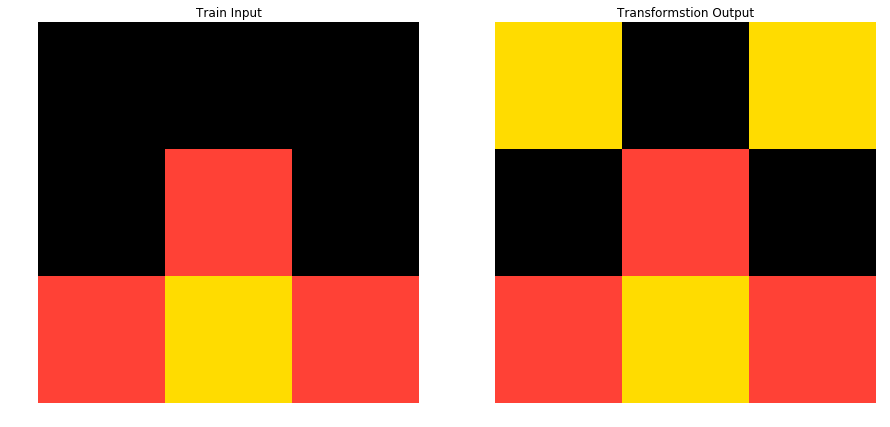

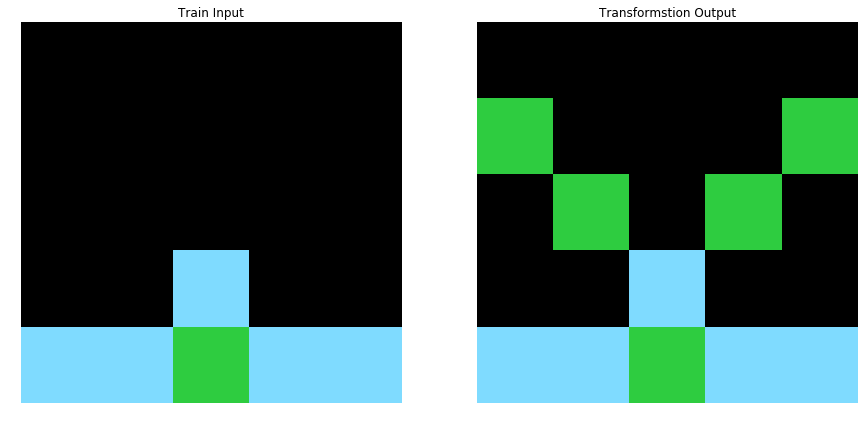

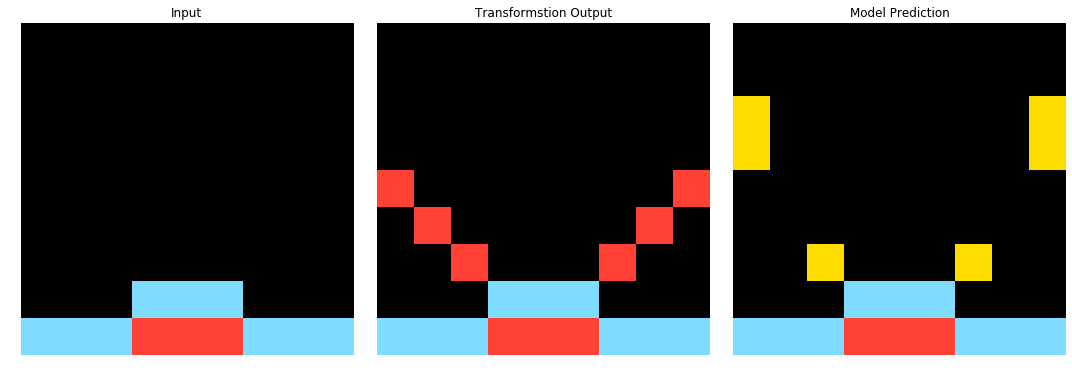

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b91ae062.json

Number of input rows: 12 cols: 13
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b94a9452.json

Number of input rows: 15 cols: 13
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b9b7f026.json

Made predictions for  ba26e723
ensemble accuracy 0.8823529411764706



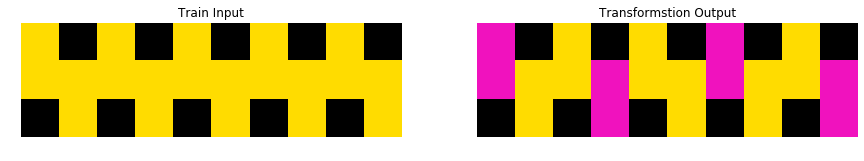

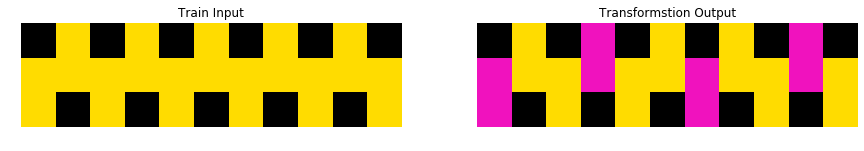

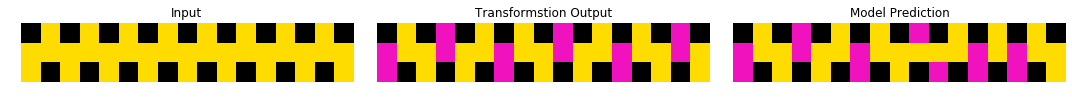

Made predictions for  ba97ae07
ensemble accuracy 0.5454545454545454



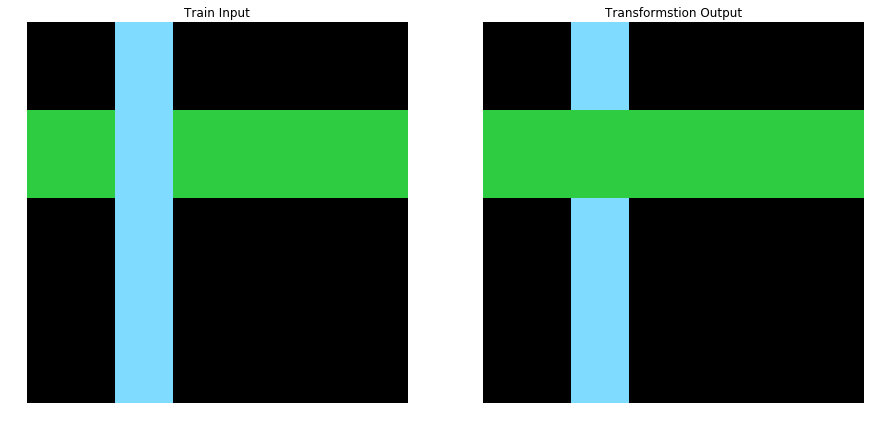

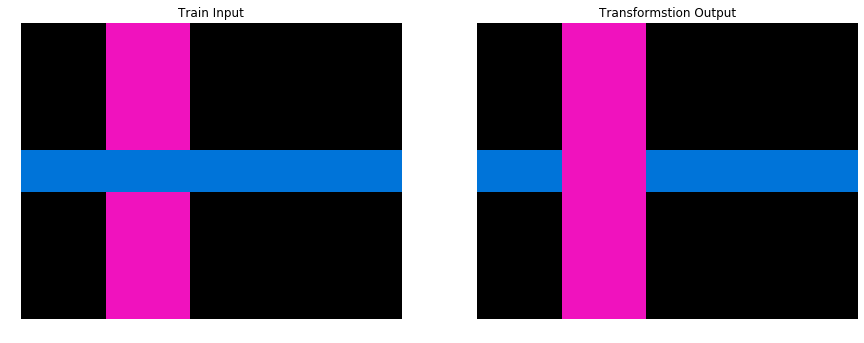

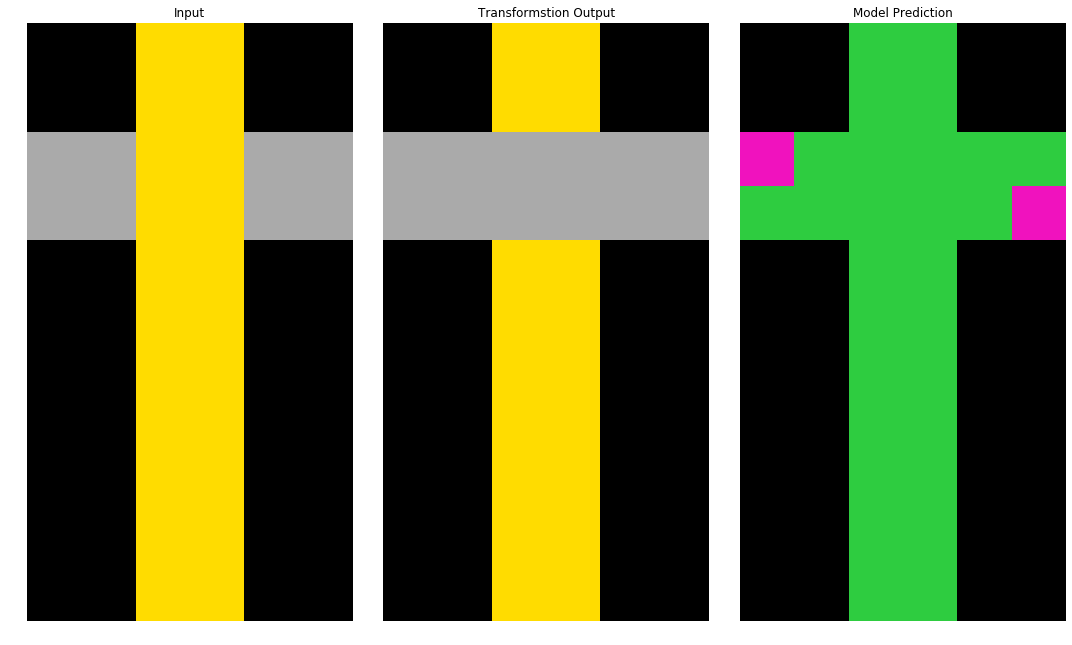

Made predictions for  bb43febb
ensemble accuracy 1.0
bb43febb.json



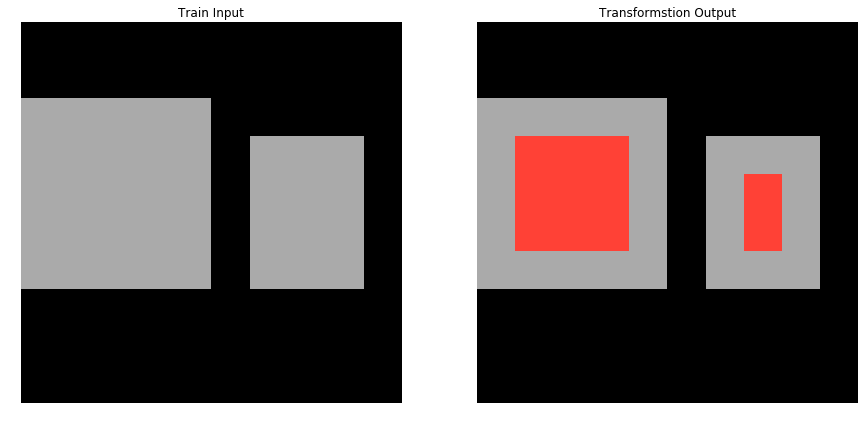

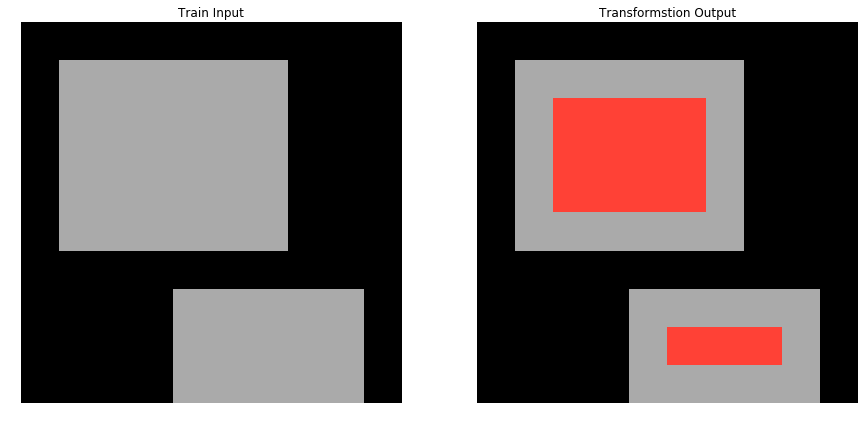

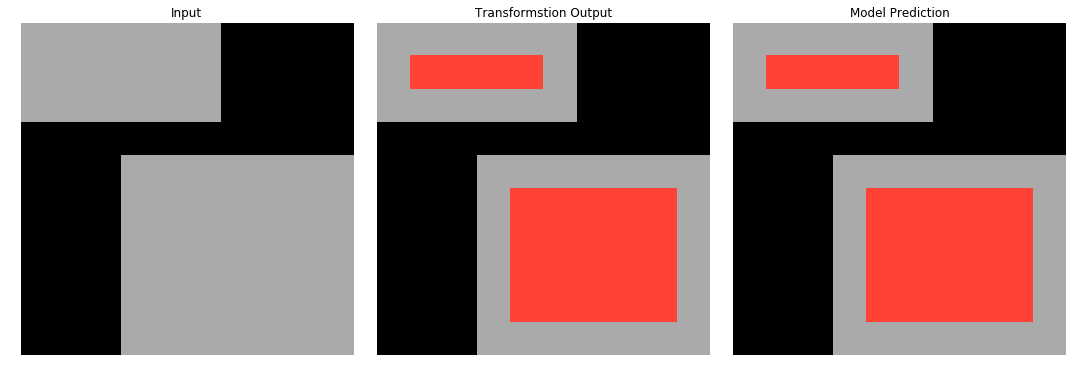

Number of input rows: 1 cols: 6
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/bbc9ae5d.json

Number of input rows: 5 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/bc1d5164.json

Made predictions for  bd4472b8
ensemble accuracy 0.43333333333333335



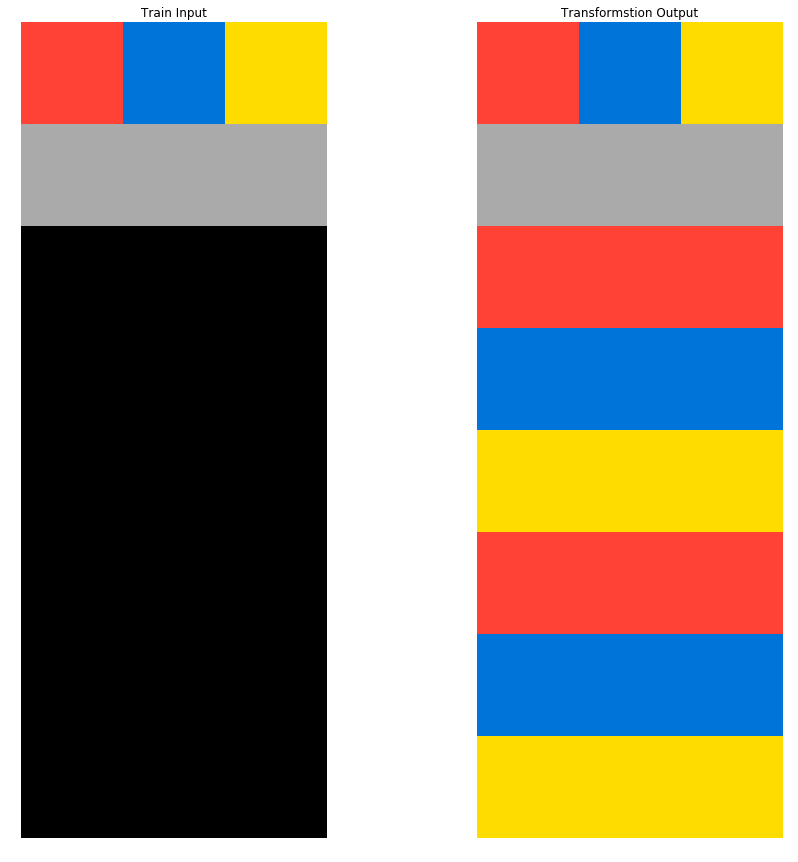

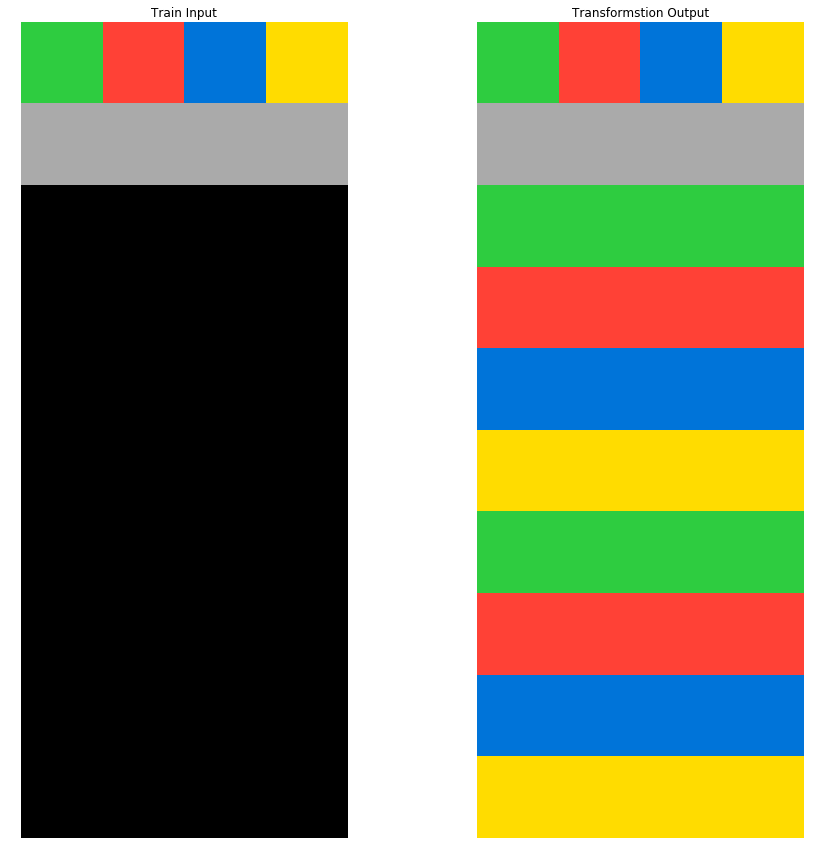

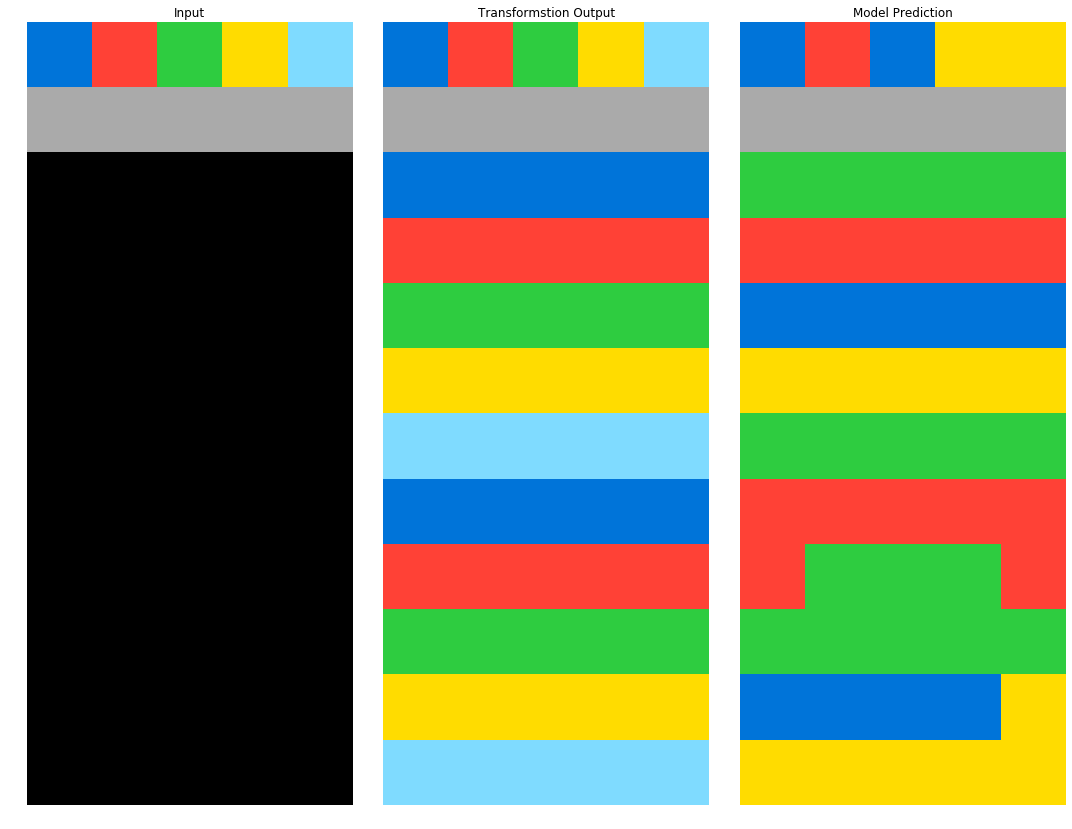

Made predictions for  bda2d7a6
ensemble accuracy 0.0



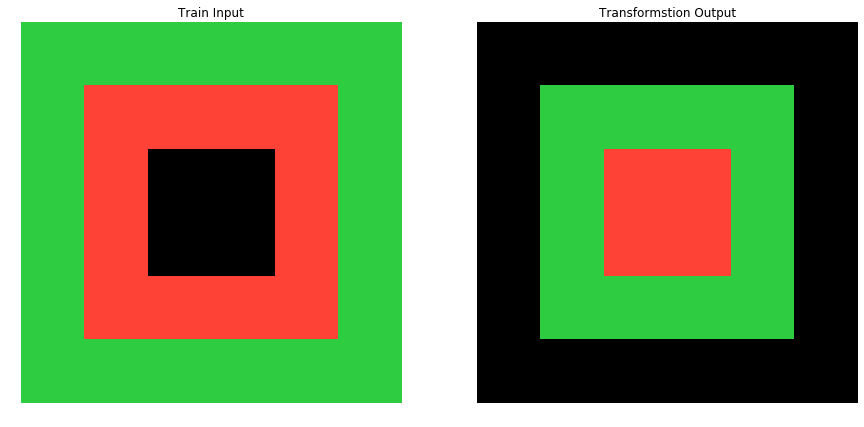

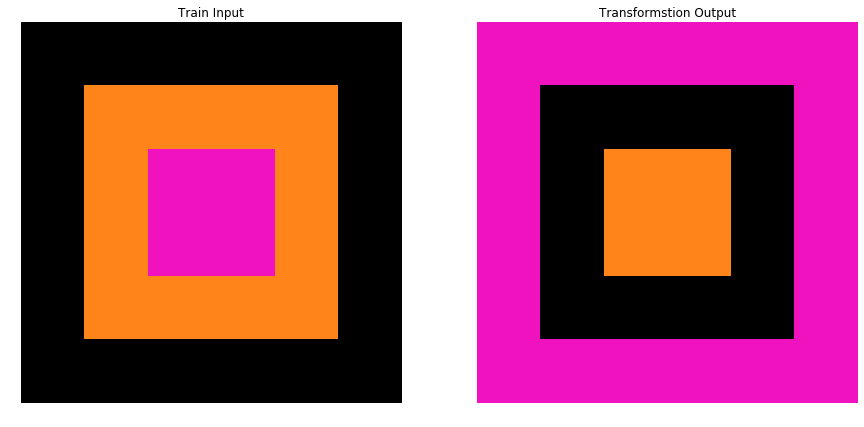

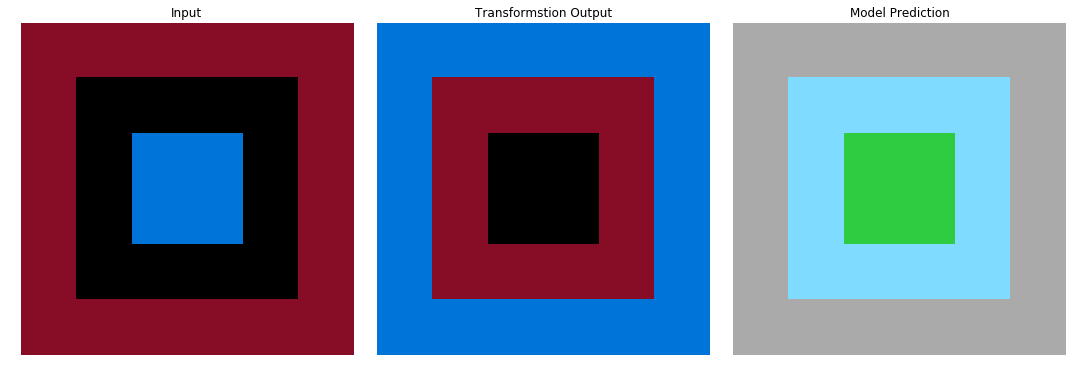

Made predictions for  bda2d7a6
ensemble accuracy 0.078125



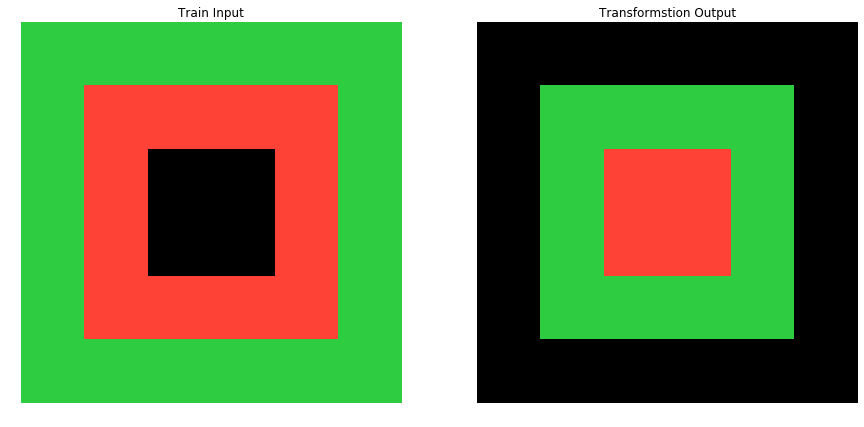

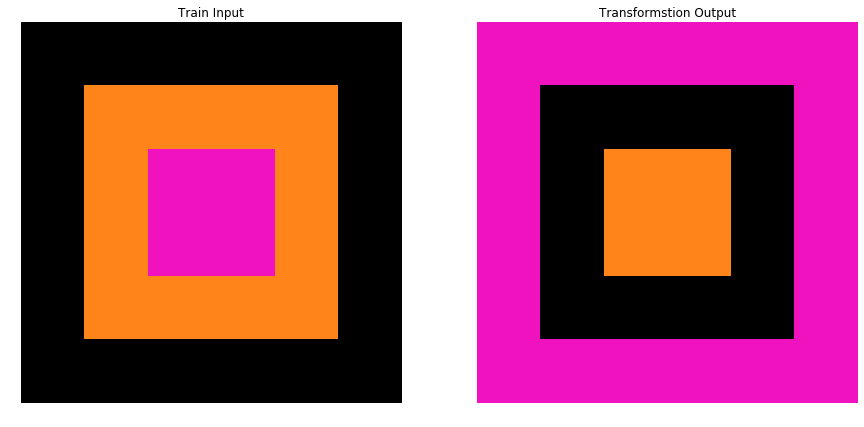

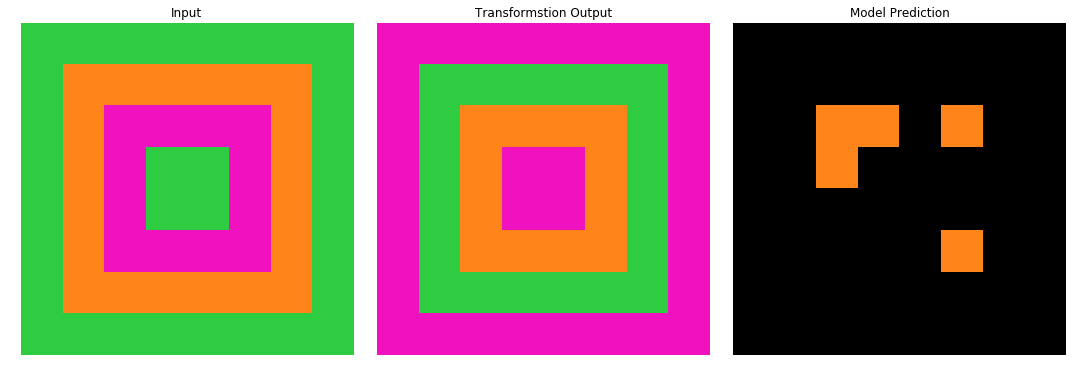

Made predictions for  bdad9b1f
ensemble accuracy 0.8611111111111112



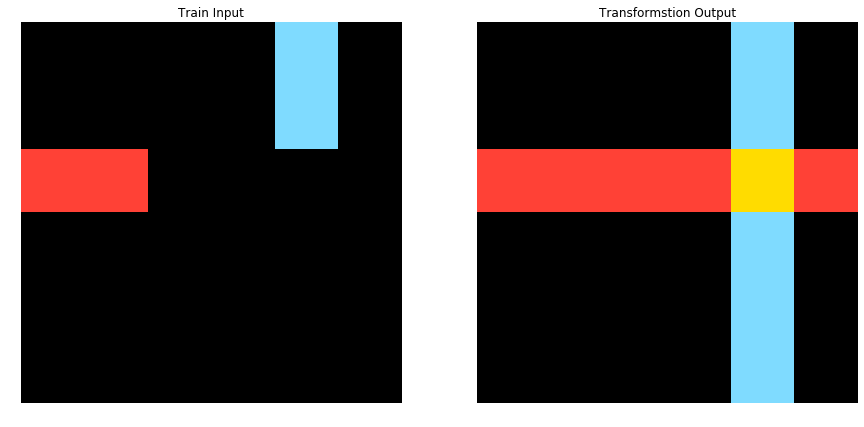

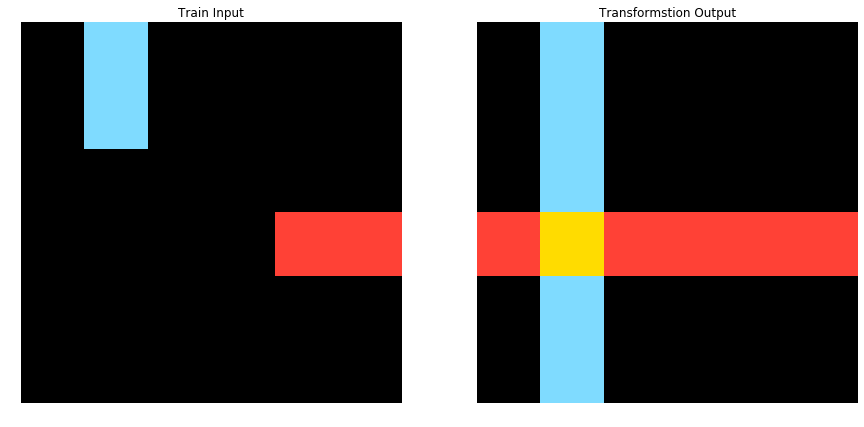

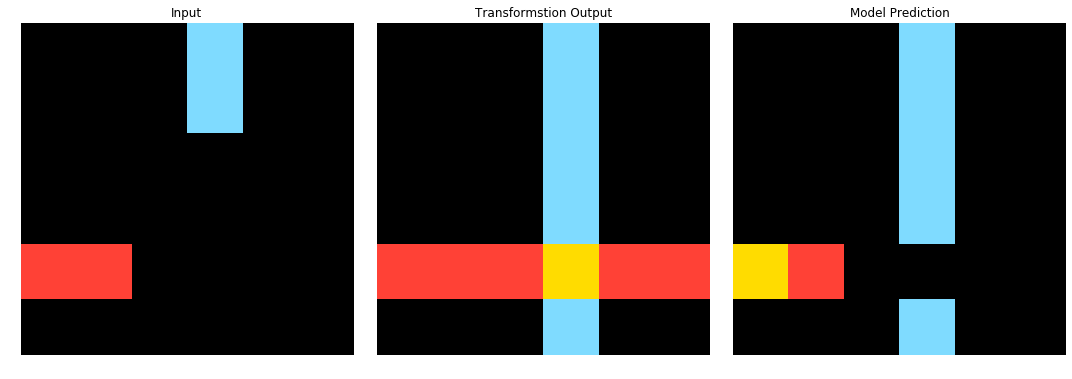

Number of input rows: 7 cols: 13
Number of target rows: 4 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/be94b721.json

Made predictions for  beb8660c
ensemble accuracy 0.6136363636363636



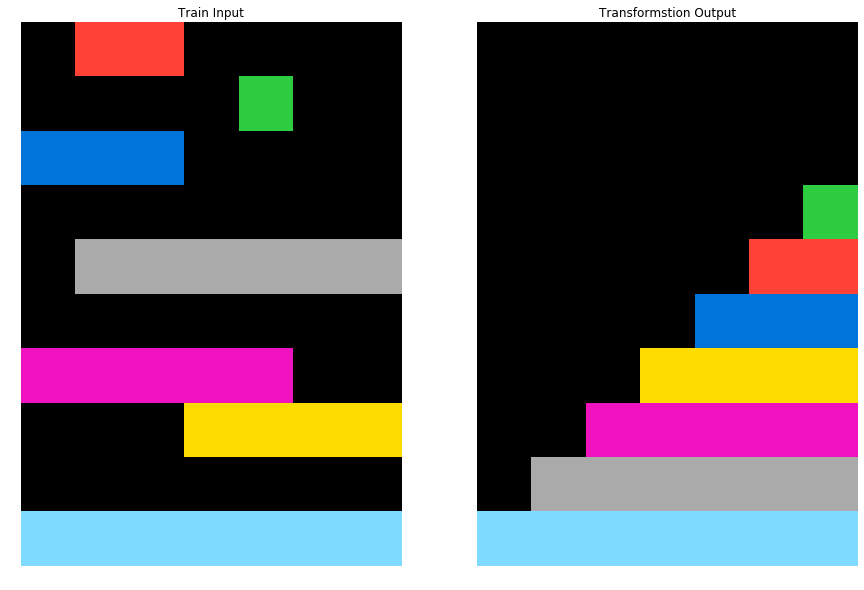

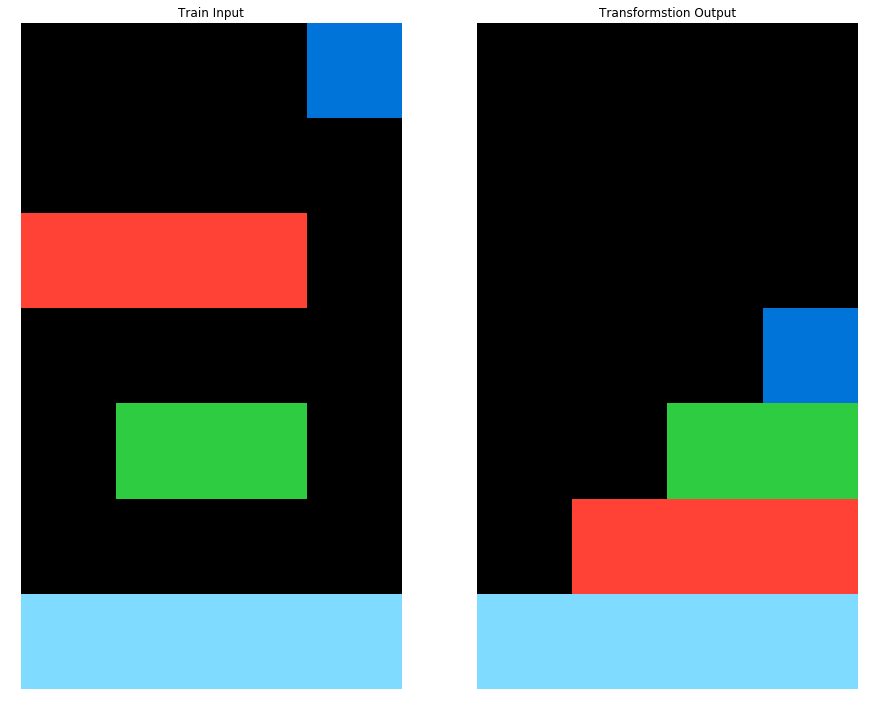

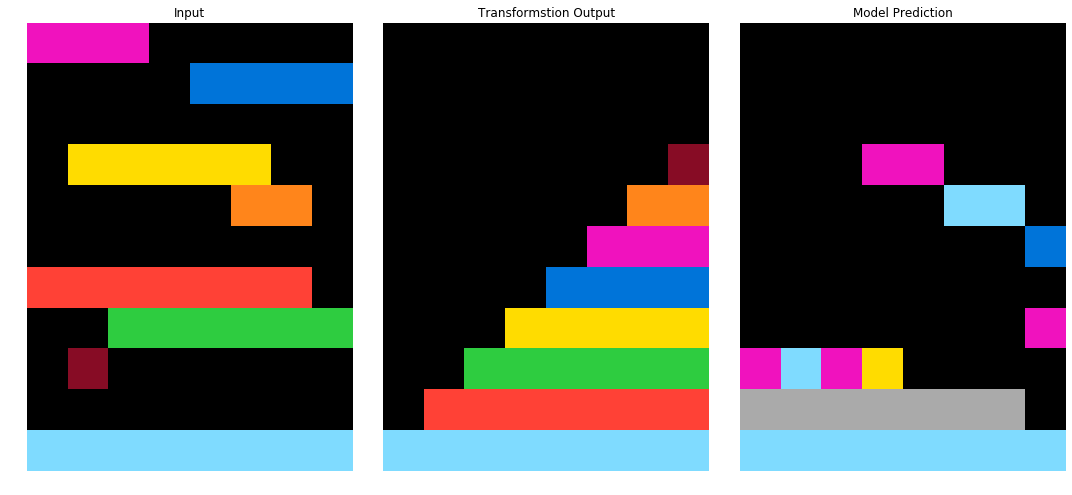

Made predictions for  c0f76784
ensemble accuracy 1.0
c0f76784.json



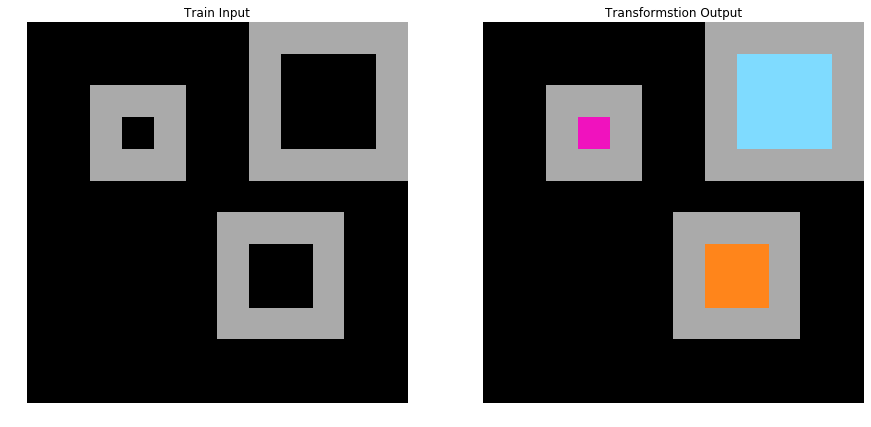

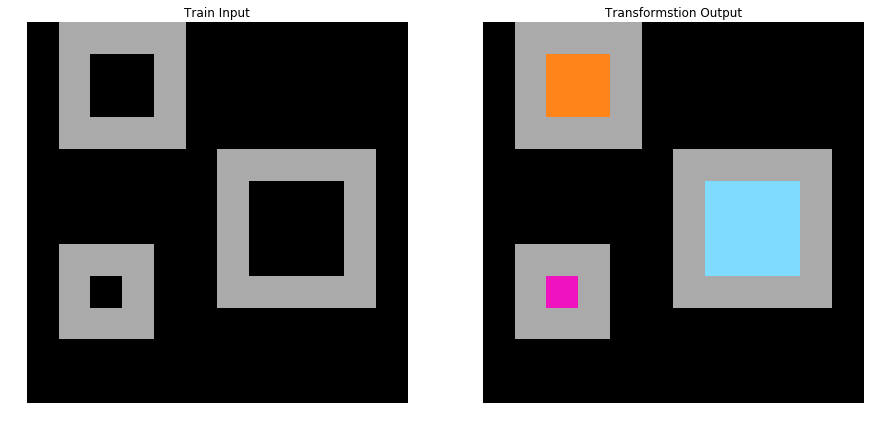

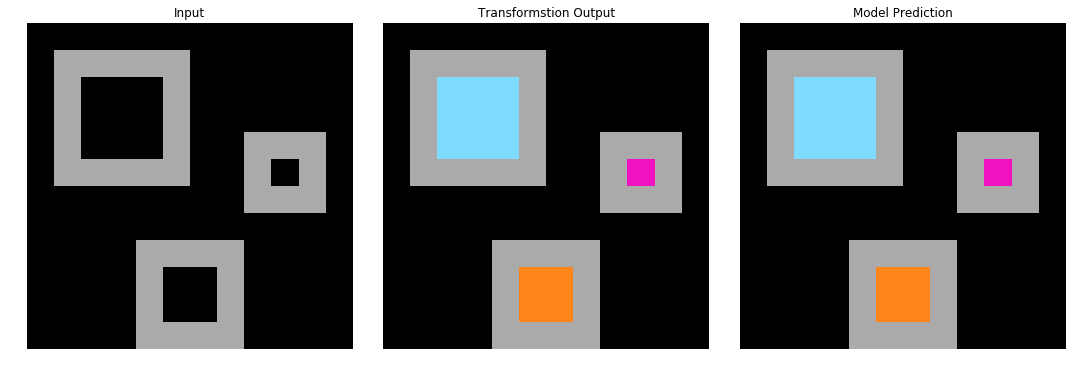

Made predictions for  c1d99e64
ensemble accuracy 0.4148148148148148



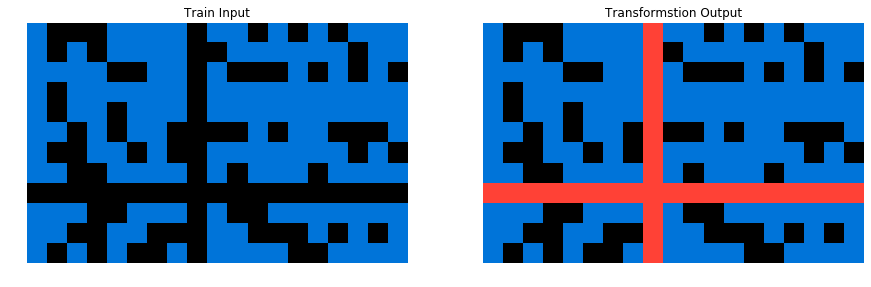

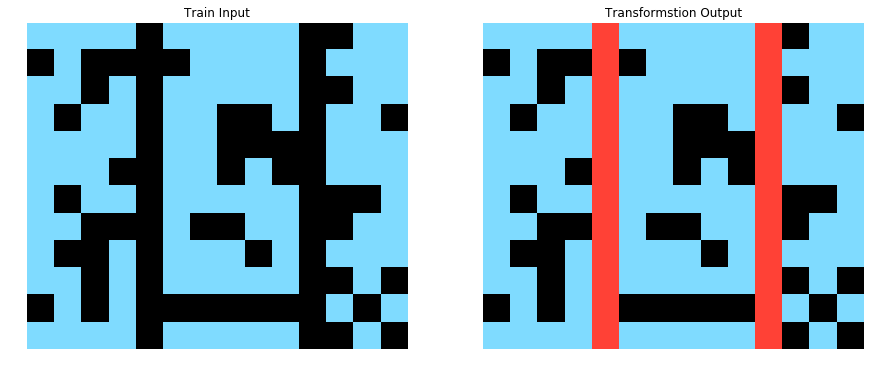

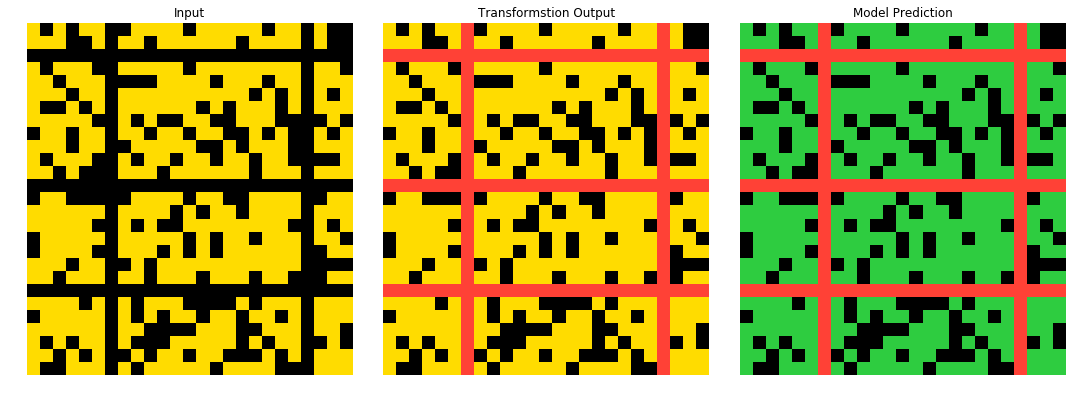

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/c3e719e8.json

Made predictions for  c3f564a4
ensemble accuracy 0.82421875



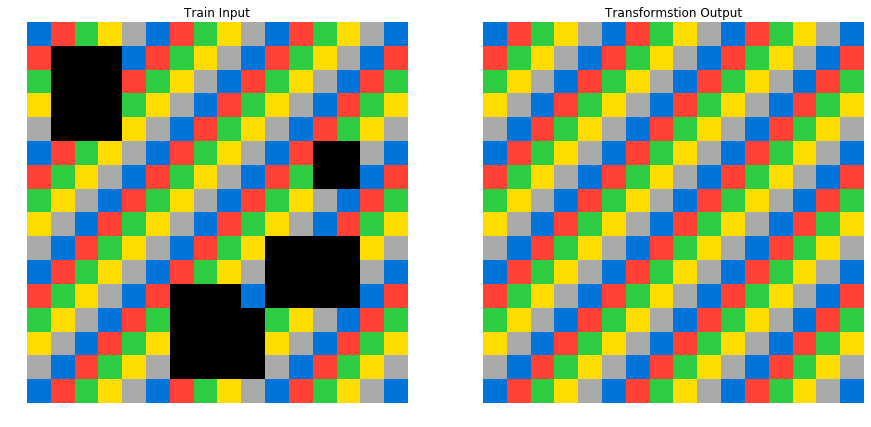

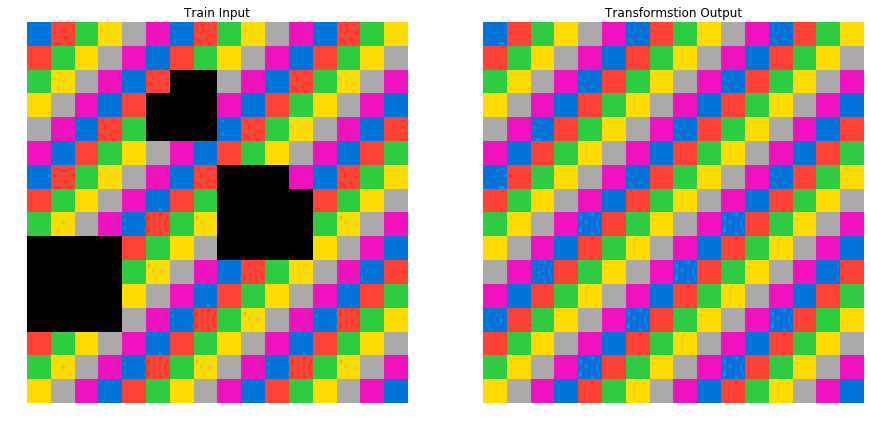

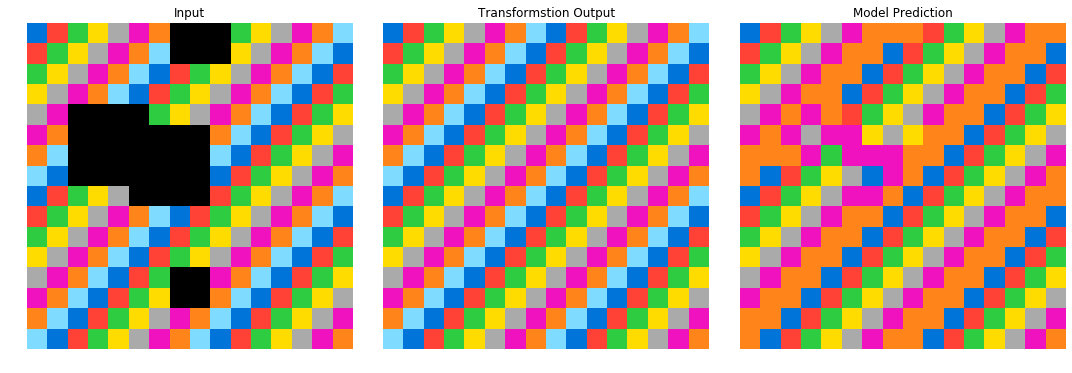

Made predictions for  c444b776
ensemble accuracy 0.8620689655172413



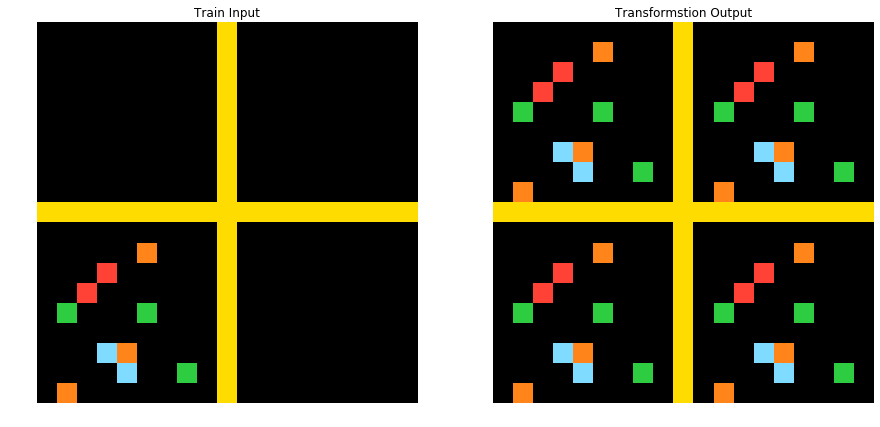

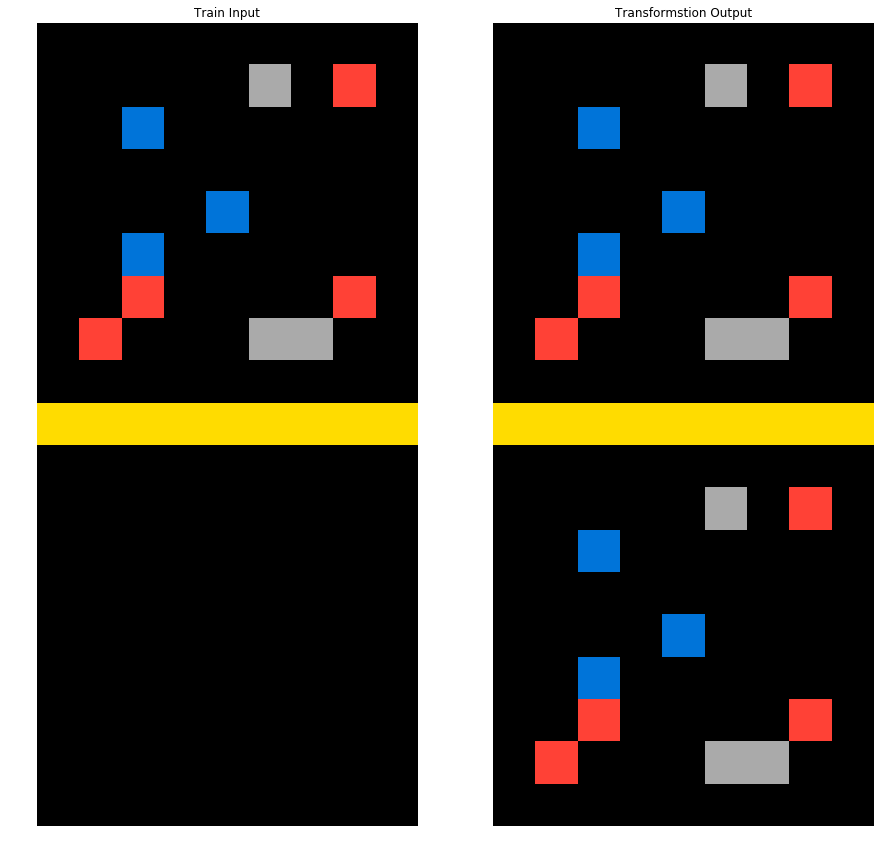

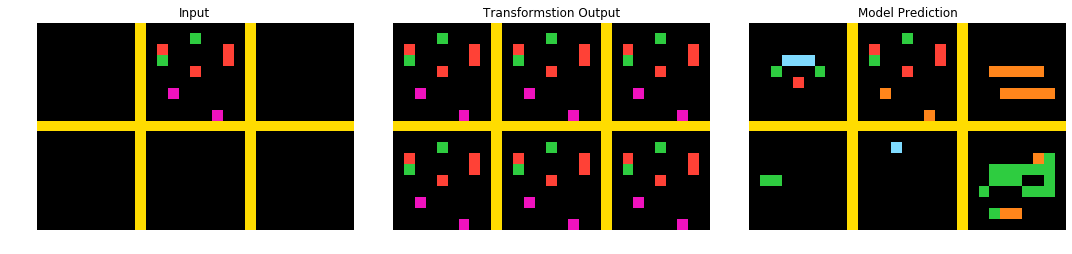

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/c59eb873.json

Number of input rows: 12 cols: 11
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/c8cbb738.json

Made predictions for  c8f0f002
ensemble accuracy 1.0
c8f0f002.json



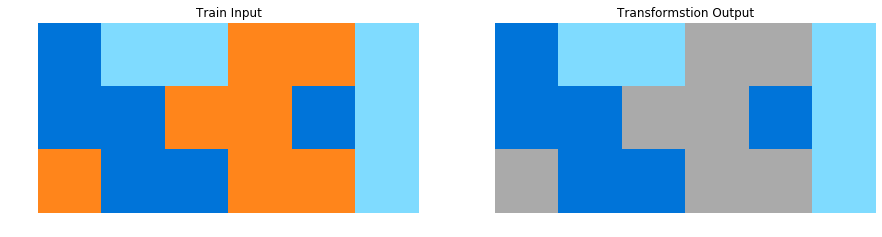

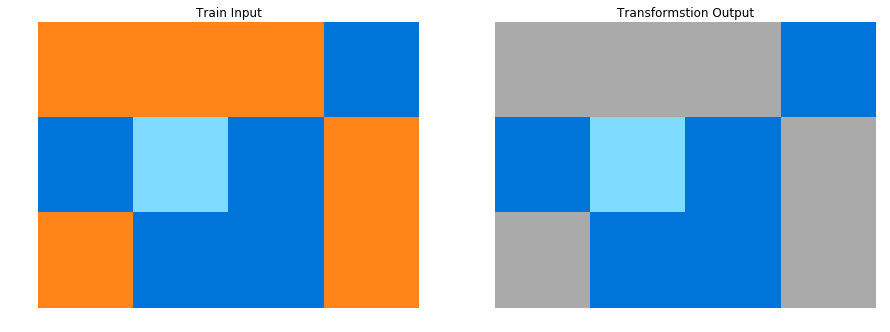

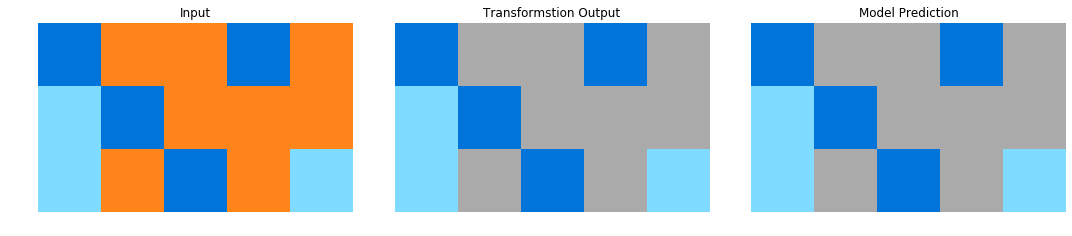

Number of input rows: 24 cols: 24
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/c909285e.json

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/c9e6f938.json

Made predictions for  c9f8e694
ensemble accuracy 0.4513888888888889



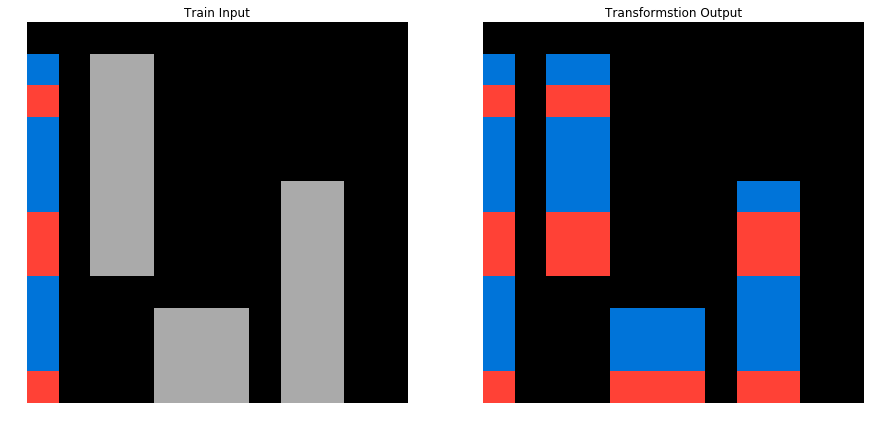

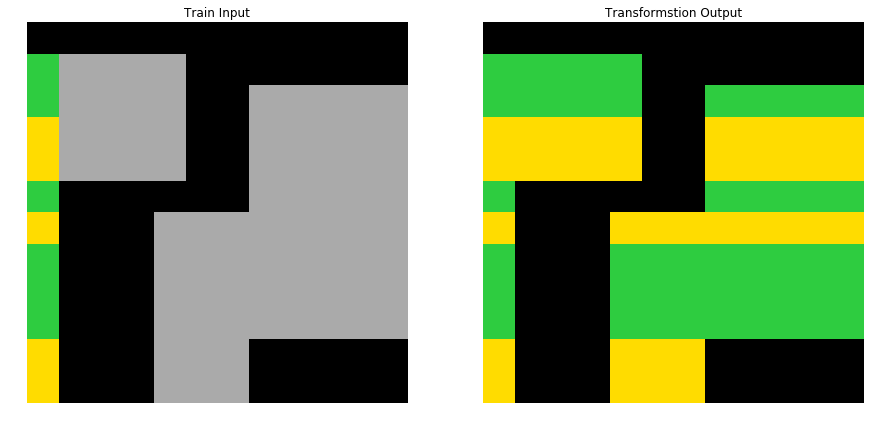

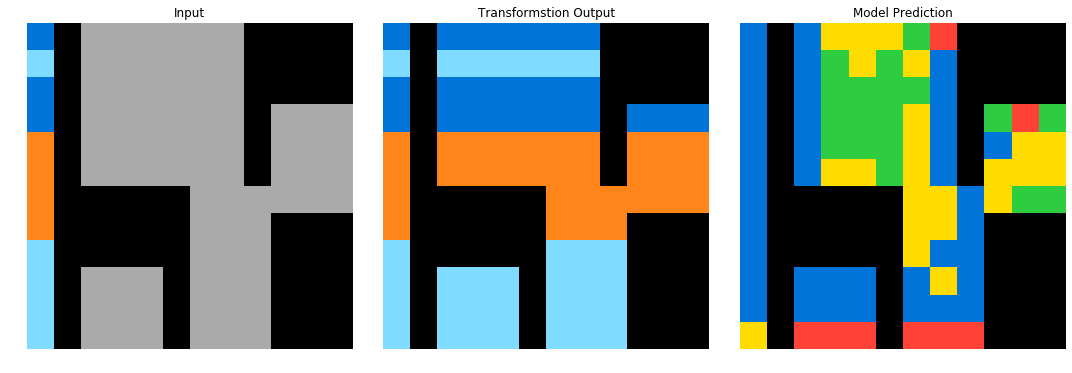

Made predictions for  caa06a1f
ensemble accuracy 0.11728395061728394



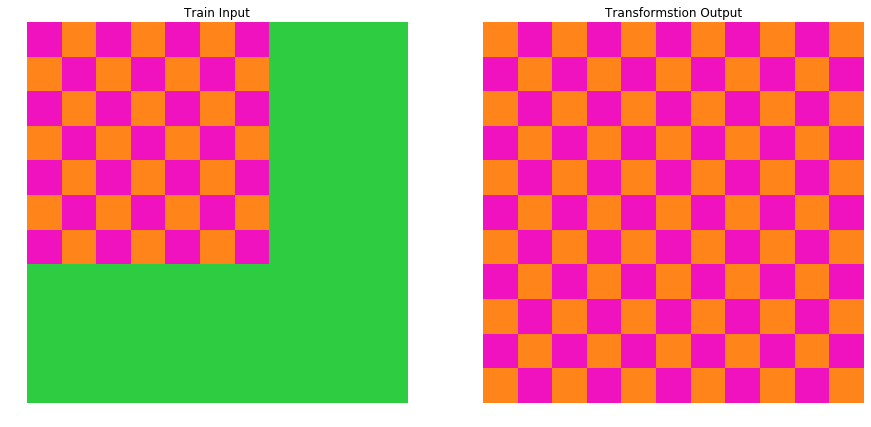

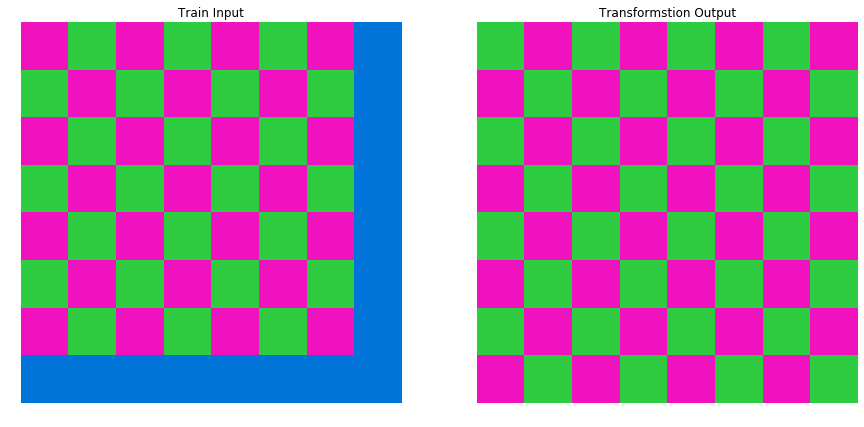

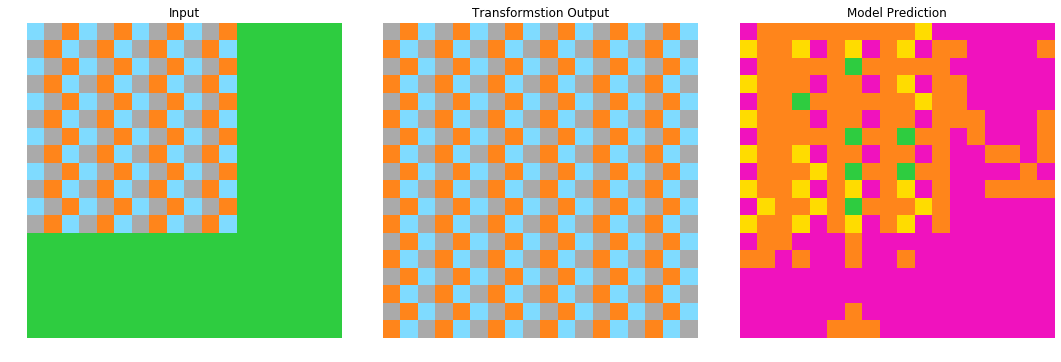

Made predictions for  cbded52d
ensemble accuracy 0.84375



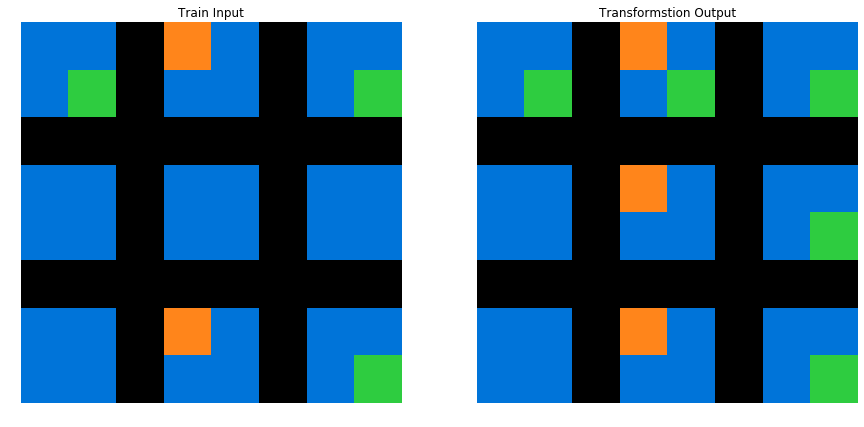

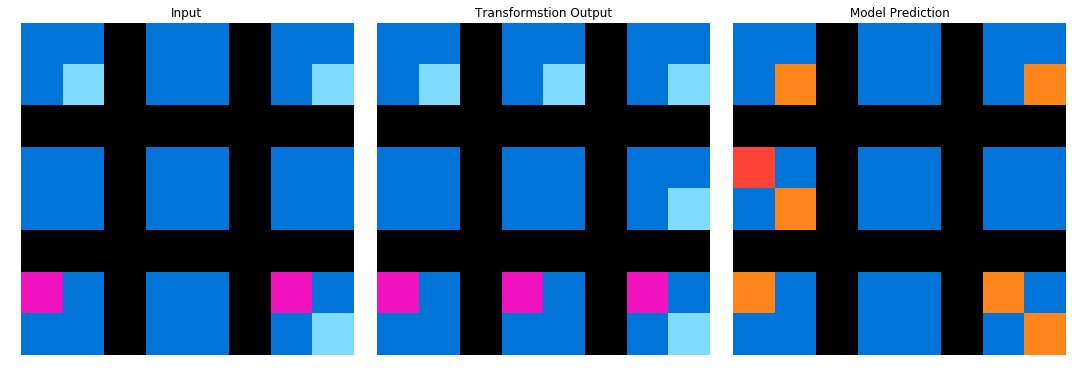

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/cce03e0d.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/cdecee7f.json

Made predictions for  ce22a75a
ensemble accuracy 1.0
ce22a75a.json



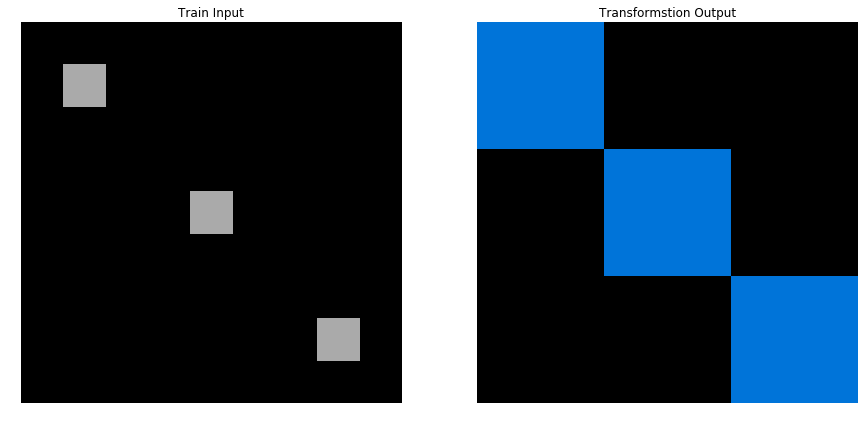

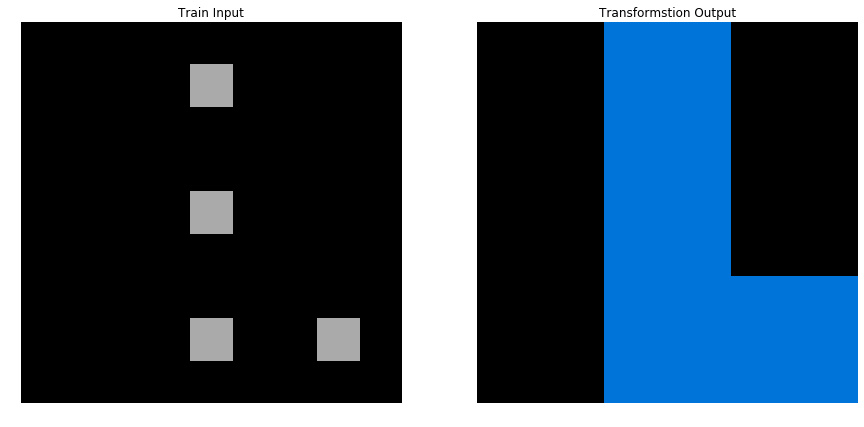

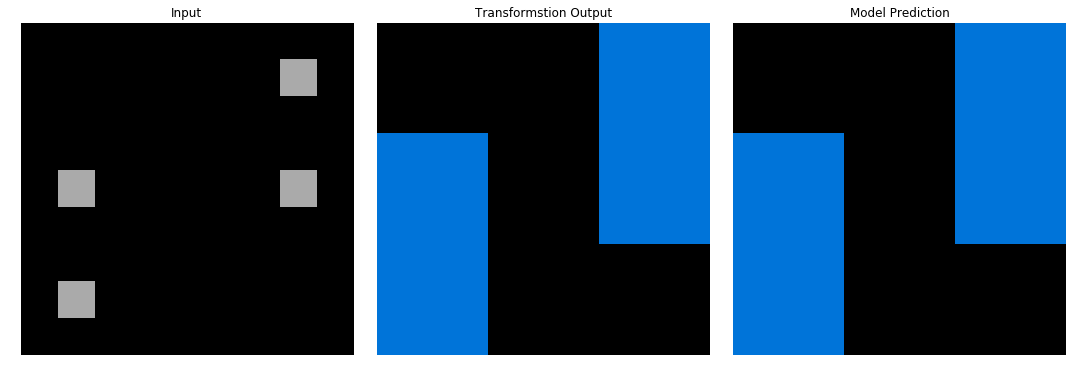

Number of input rows: 9 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ce4f8723.json

Number of input rows: 17 cols: 17
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ce602527.json

Made predictions for  ce9e57f2
ensemble accuracy 0.9696969696969697
ce9e57f2.json



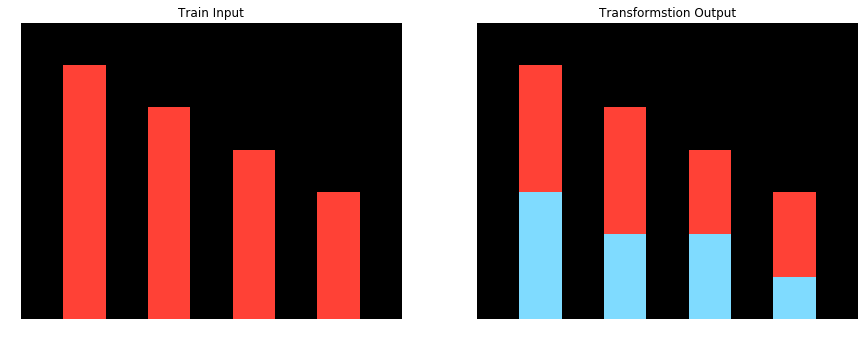

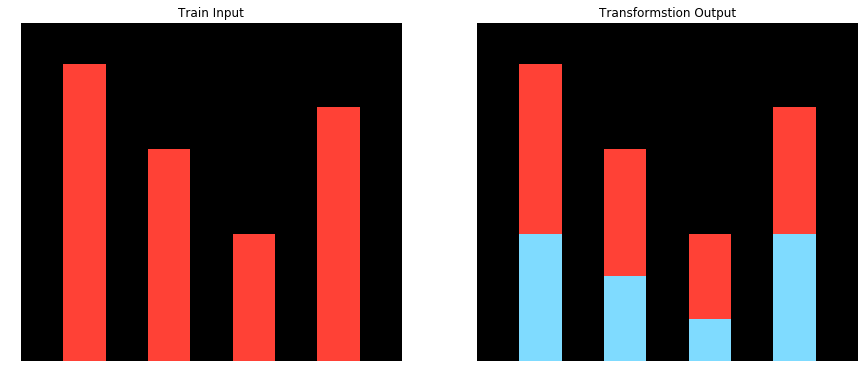

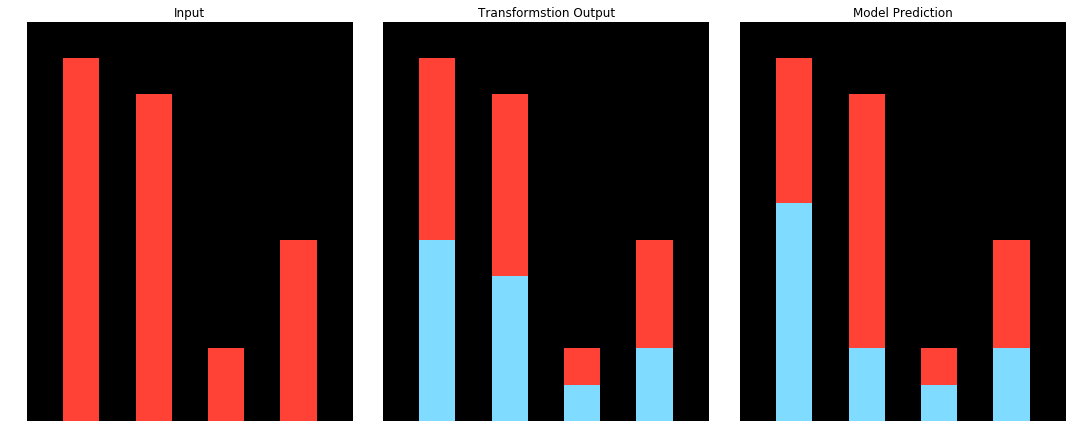

Number of input rows: 4 cols: 14
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/cf98881b.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d037b0a7
ensemble accuracy 0.2222222222222222



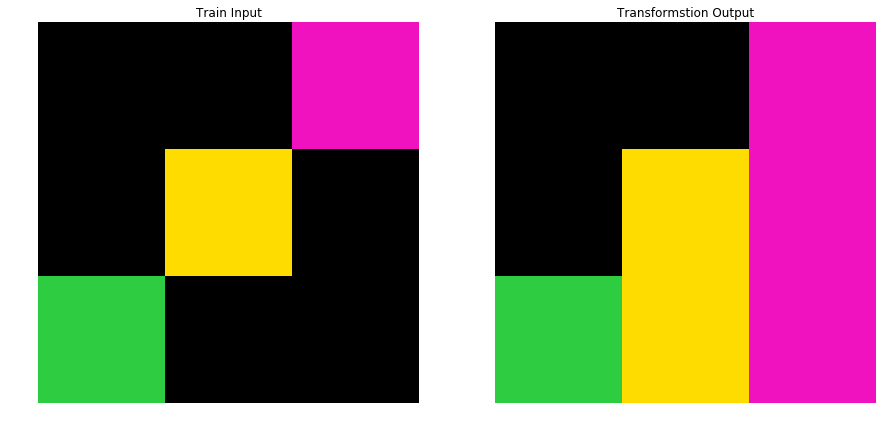

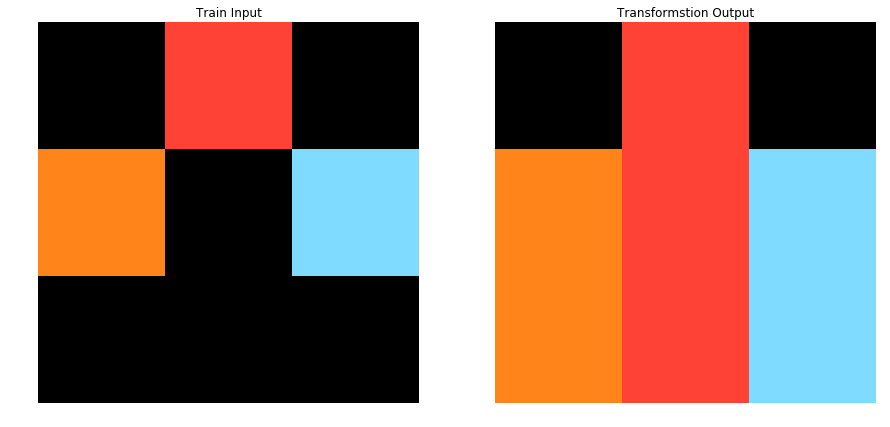

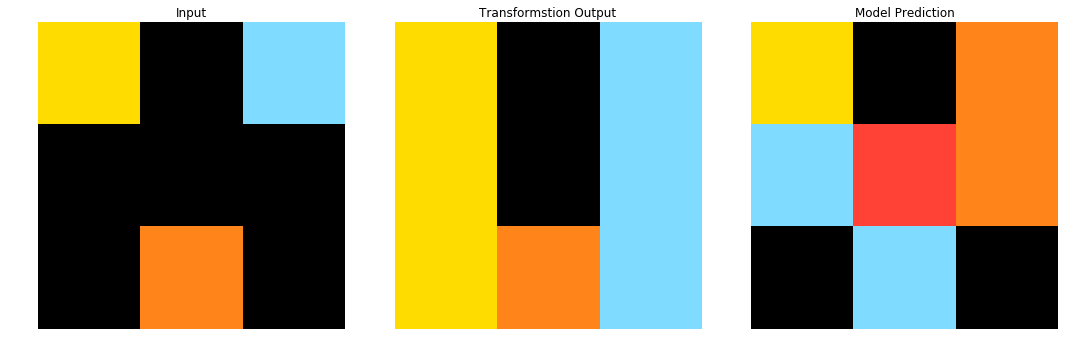

Made predictions for  d06dbe63
ensemble accuracy 0.9053254437869822



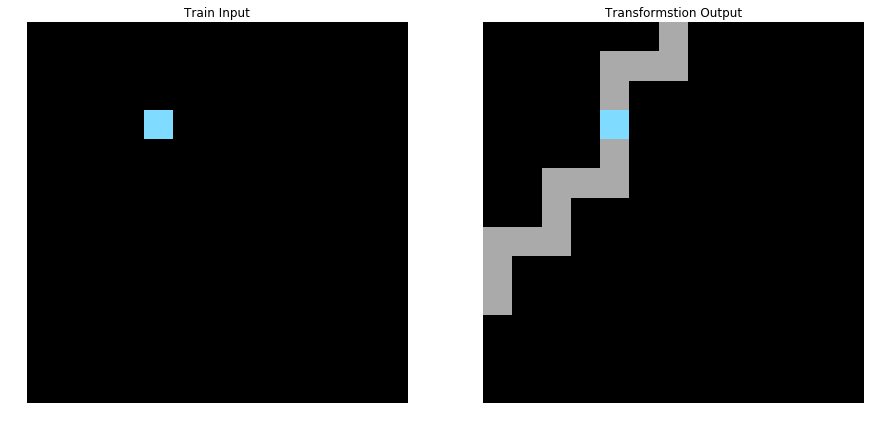

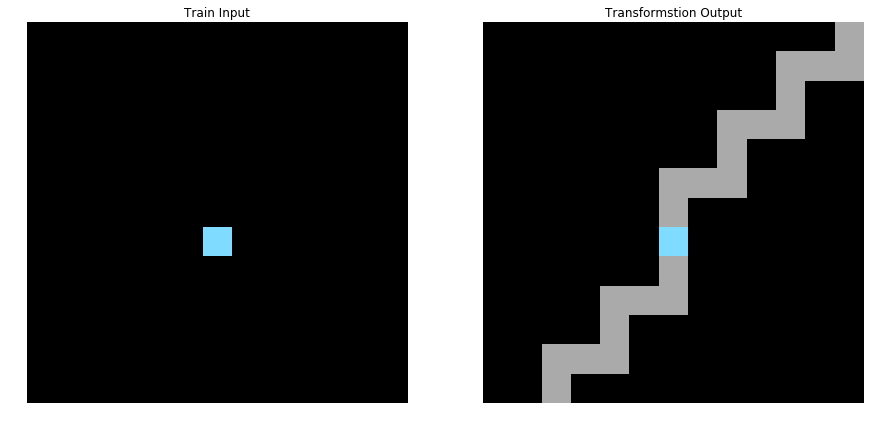

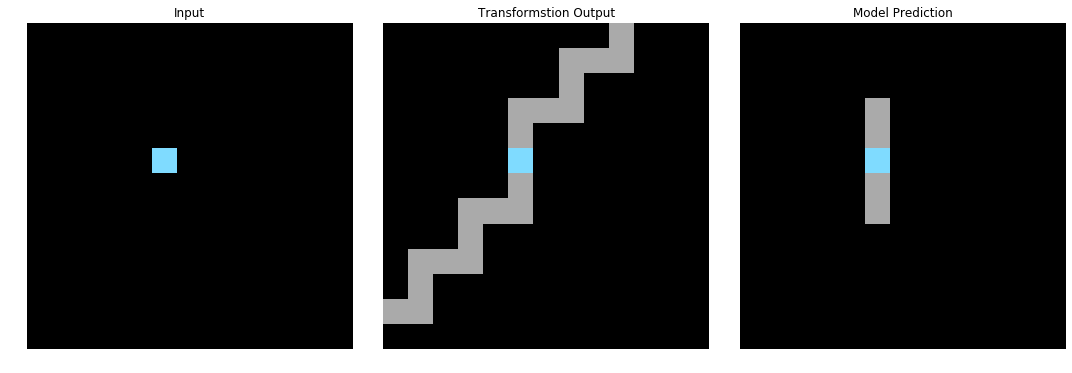

Made predictions for  d07ae81c
ensemble accuracy 0.8637770897832817



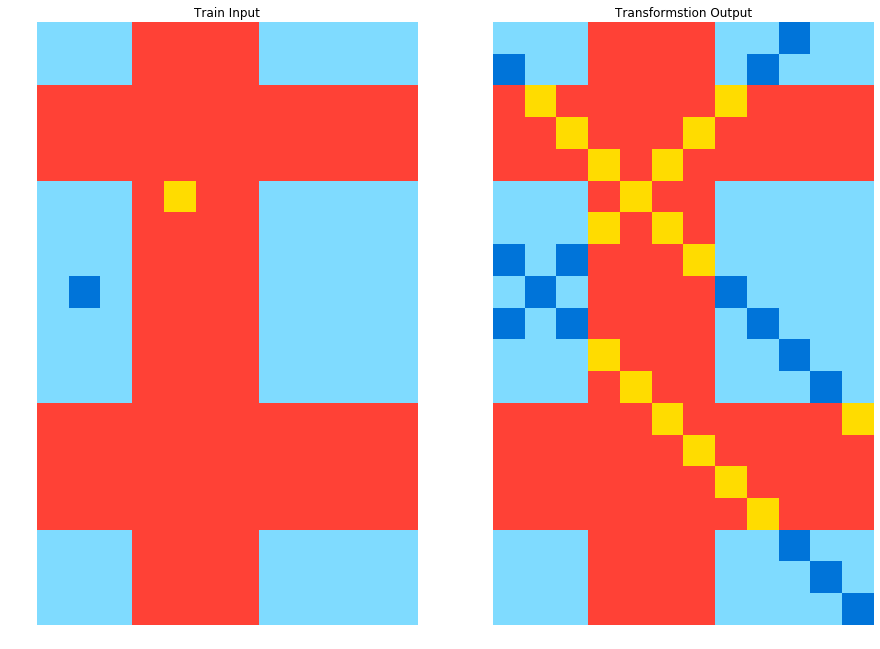

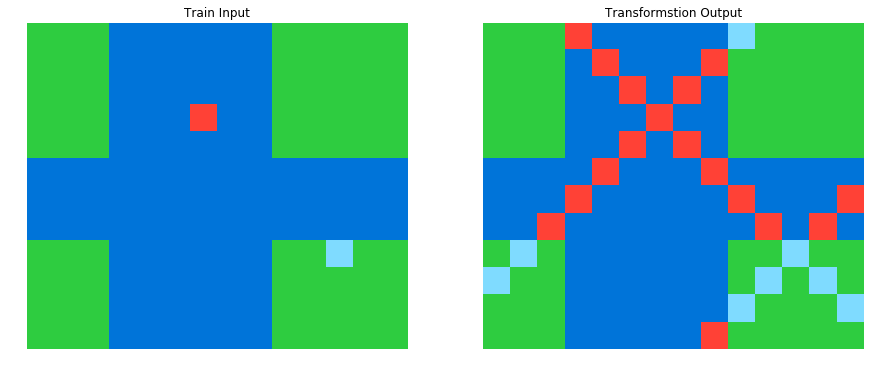

Number of input rows: 16 cols: 10
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d0f5fe59.json

Number of input rows: 6 cols: 6
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d10ecb37.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d13f3404.json

Made predictions for  d22278a0
ensemble accuracy 0.40484429065743943



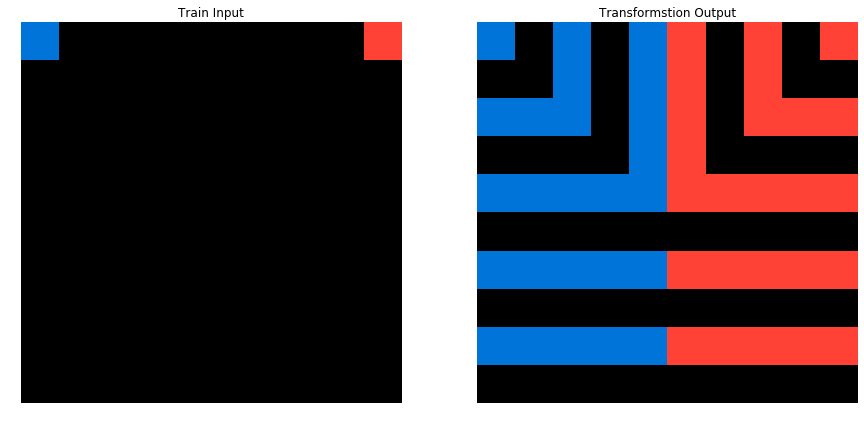

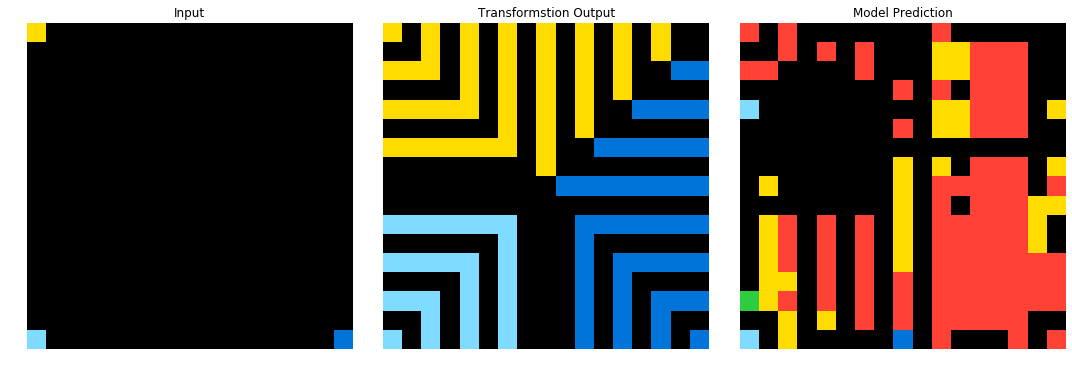

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d23f8c26
ensemble accuracy 0.8775510204081632



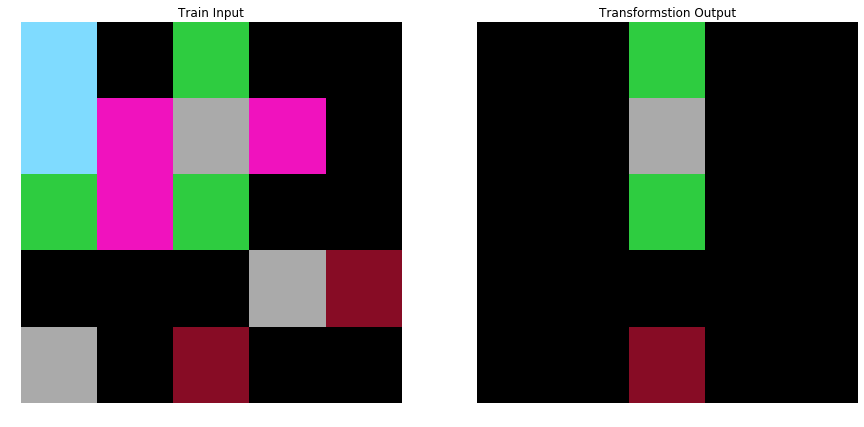

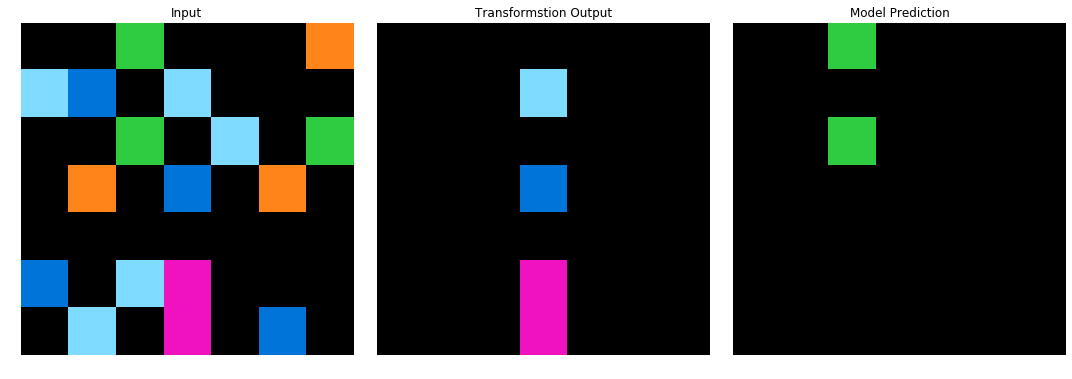

Made predictions for  d2abd087
ensemble accuracy 0.87



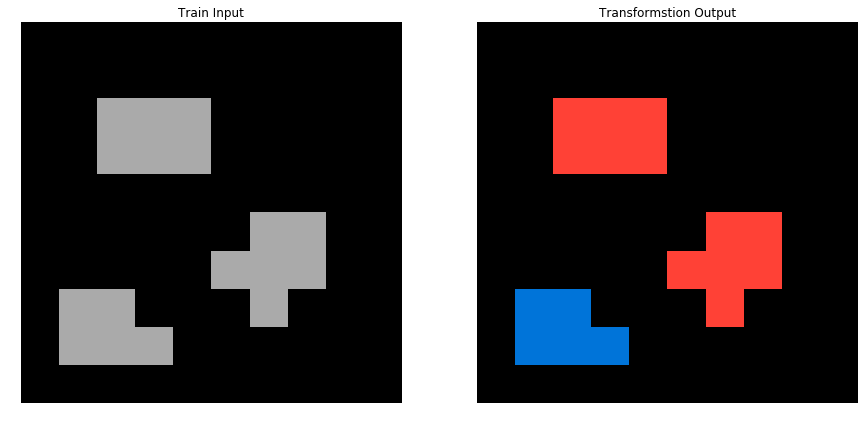

Made predictions for  d364b489
ensemble accuracy 0.86



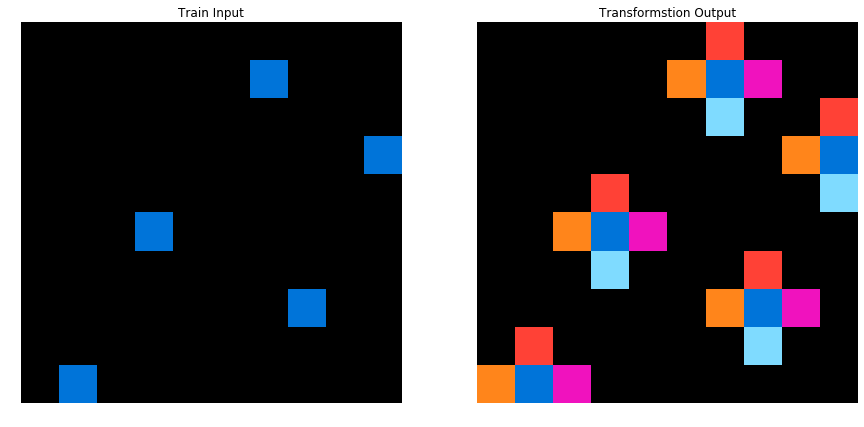

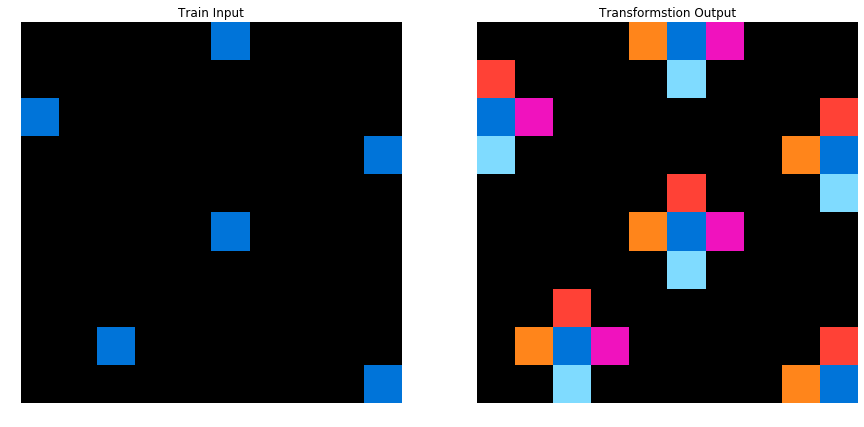

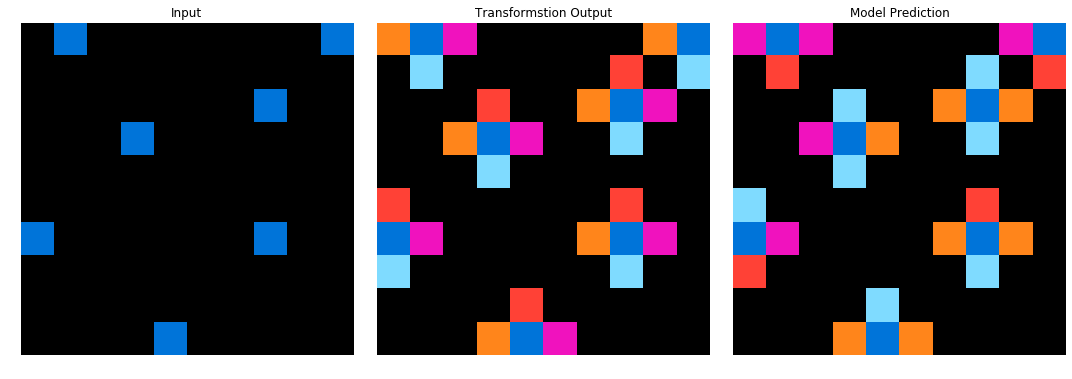

Made predictions for  d406998b
ensemble accuracy 0.803921568627451



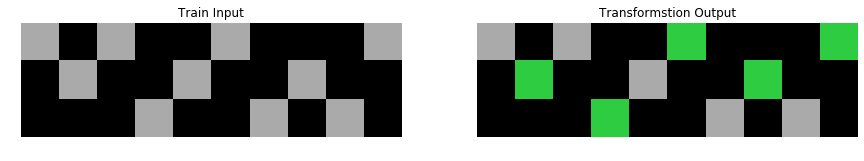

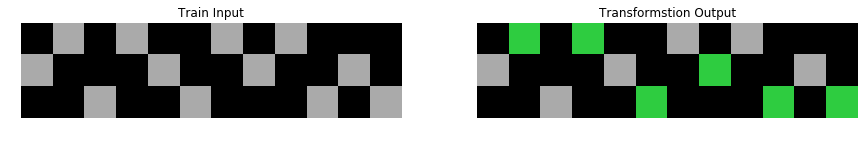

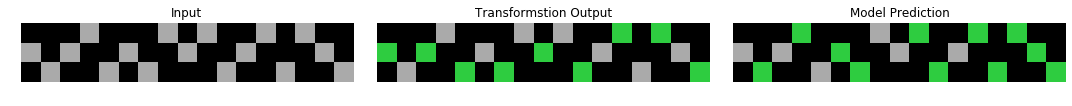

Made predictions for  d43fd935
ensemble accuracy 0.85



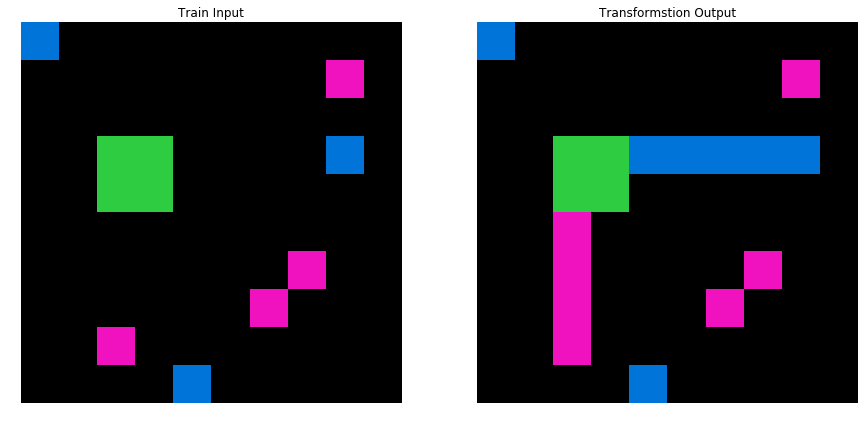

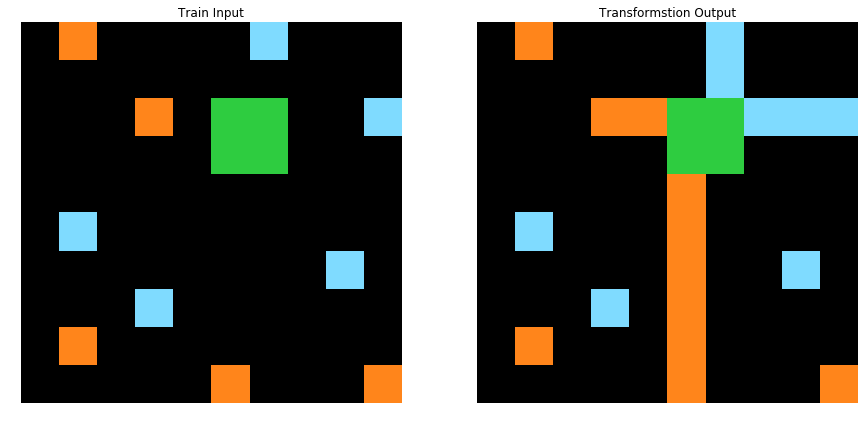

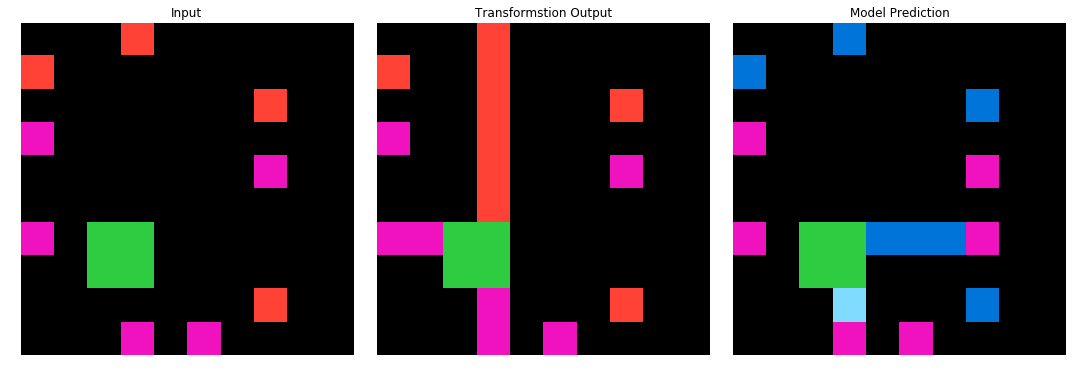

Number of input rows: 5 cols: 5
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d4469b4b.json

Made predictions for  d4a91cb9
ensemble accuracy 0.9423076923076923



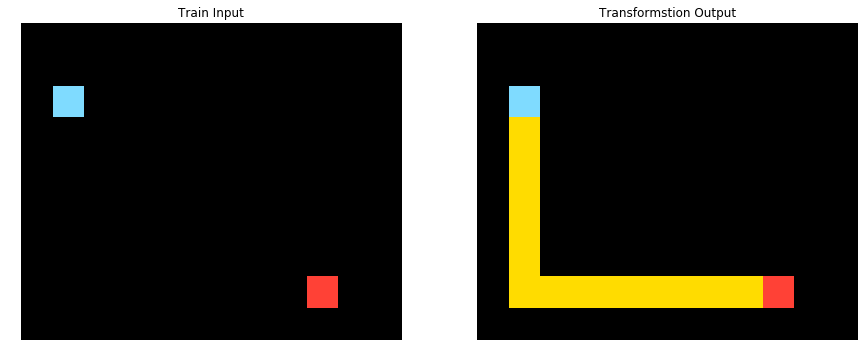

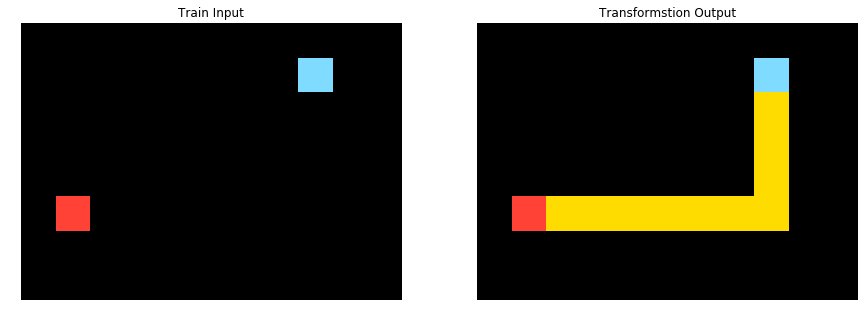

Made predictions for  d4f3cd78
ensemble accuracy 0.96
d4f3cd78.json



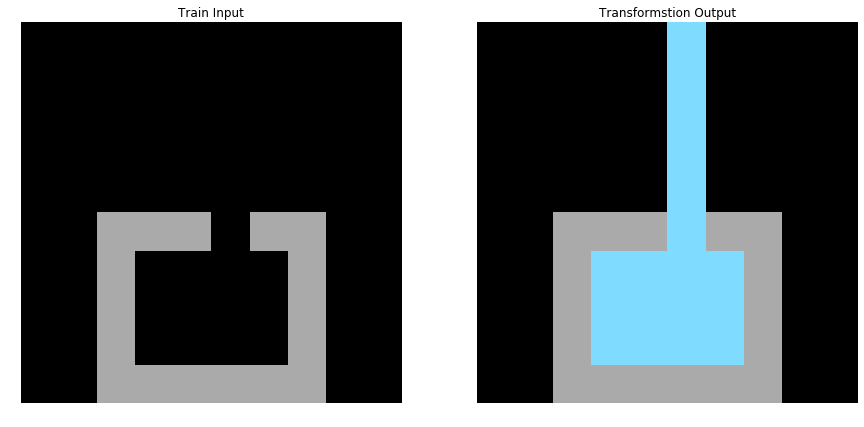

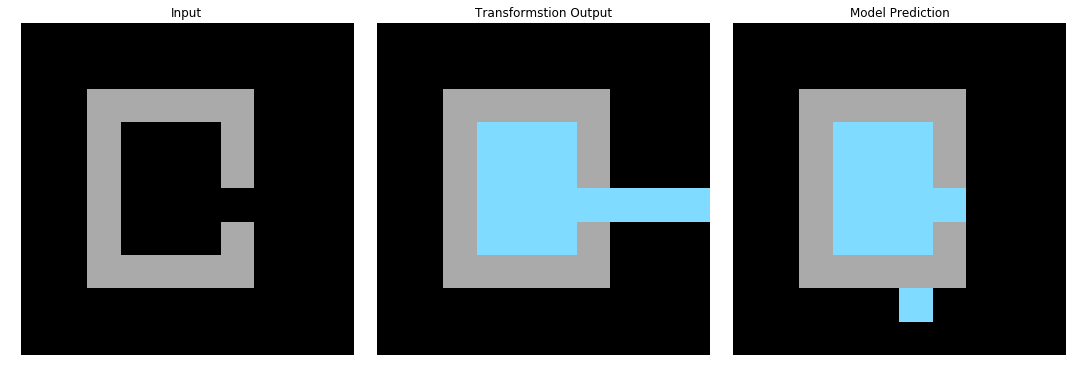

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d511f180
ensemble accuracy 0.9375



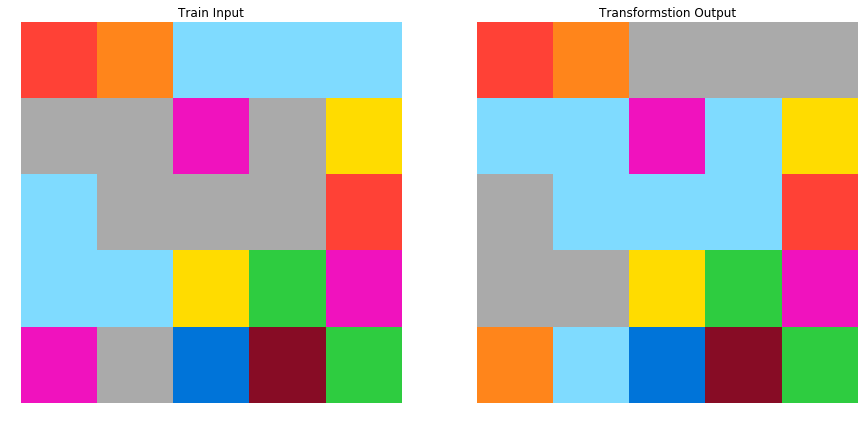

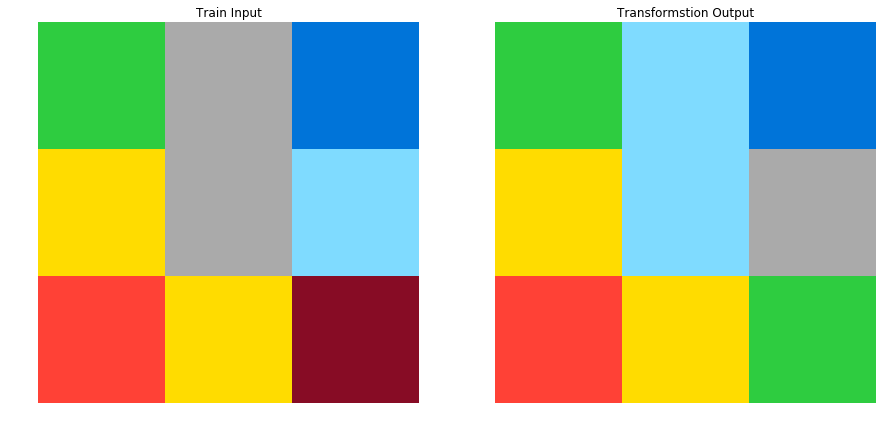

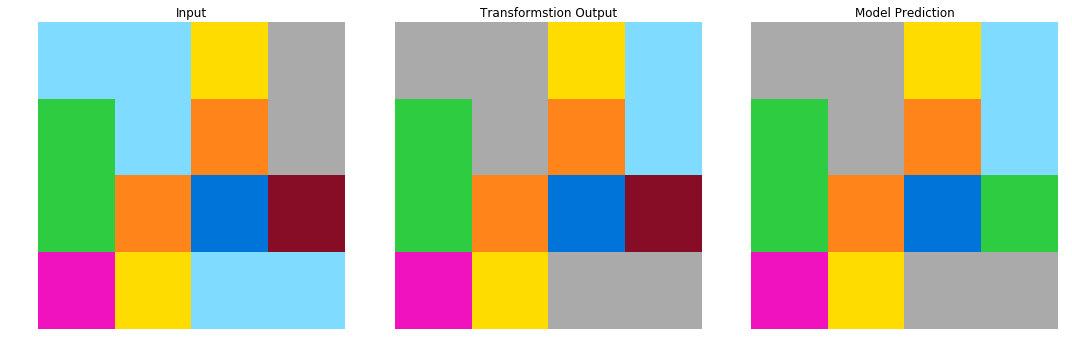

Made predictions for  d5d6de2d
ensemble accuracy 0.8



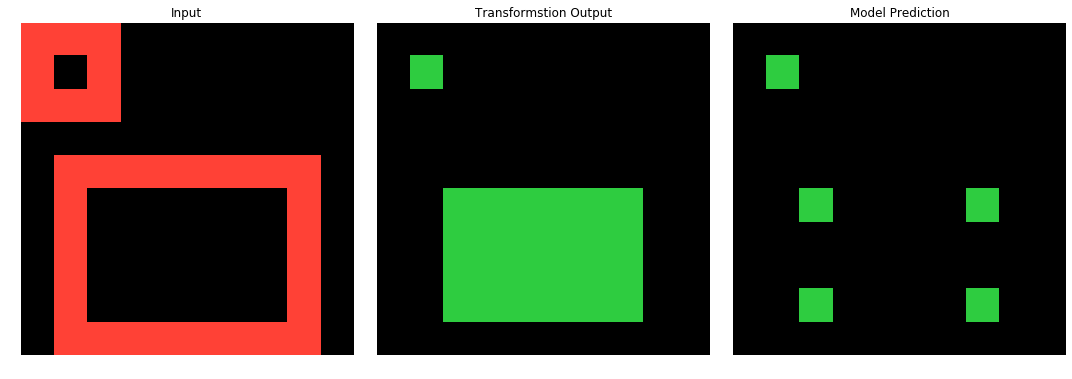

Made predictions for  d5d6de2d
ensemble accuracy 0.9744
d5d6de2d.json



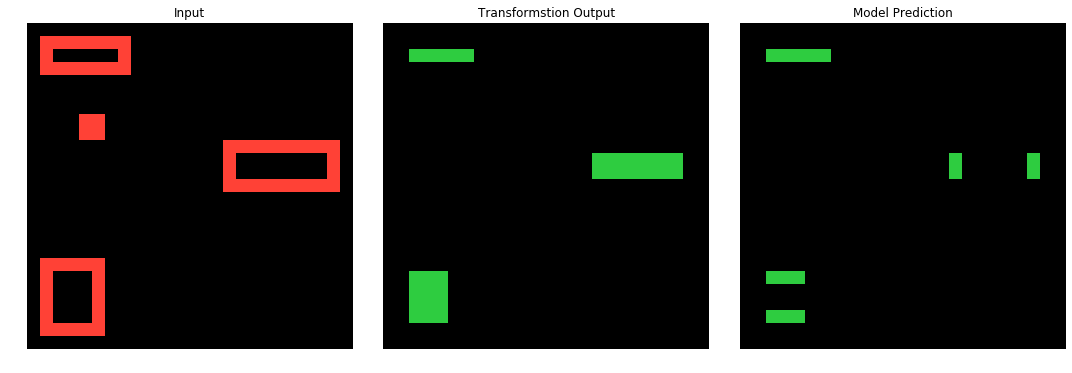

Number of input rows: 3 cols: 3
Number of target rows: 1 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d631b094.json

Made predictions for  d687bc17
ensemble accuracy 0.907563025210084



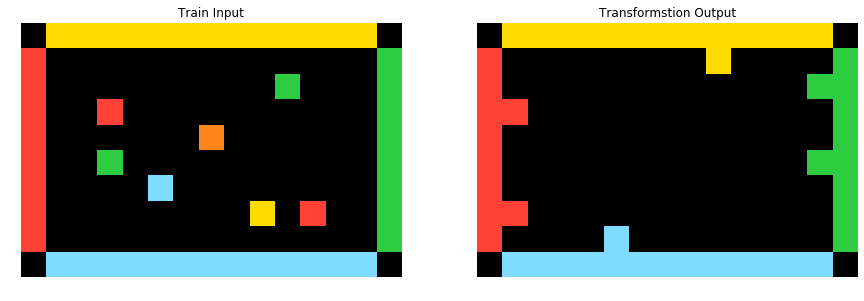

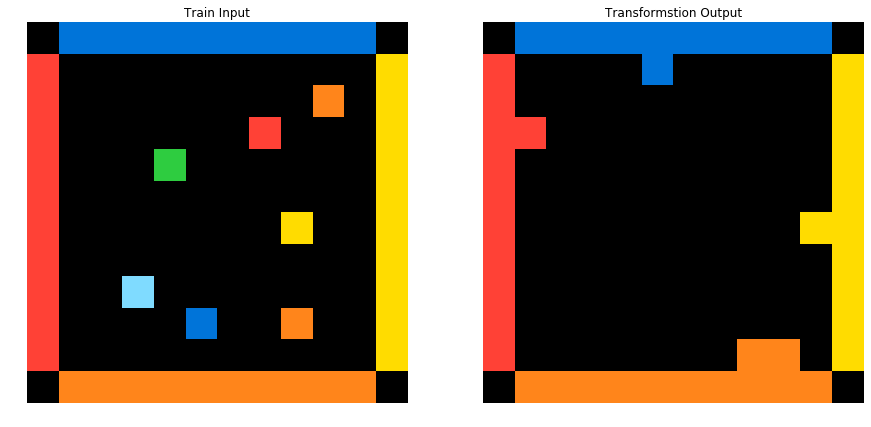

Made predictions for  d6ad076f
ensemble accuracy 0.45



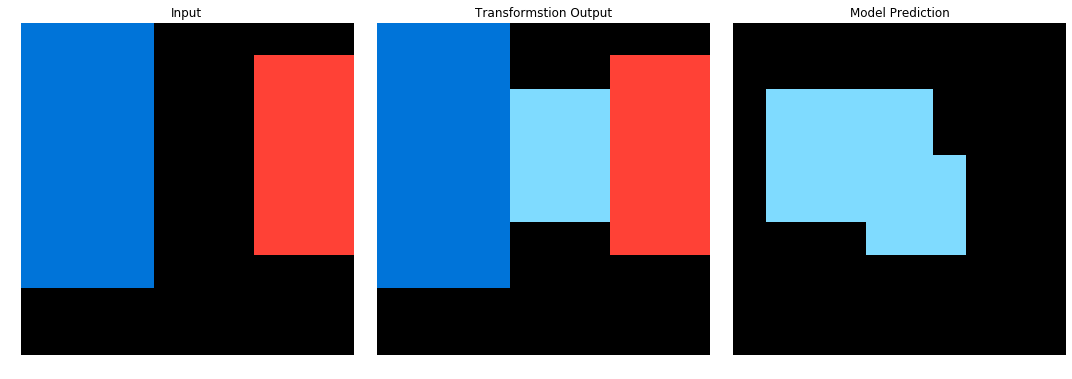

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d89b689b
ensemble accuracy 0.96
d89b689b.json



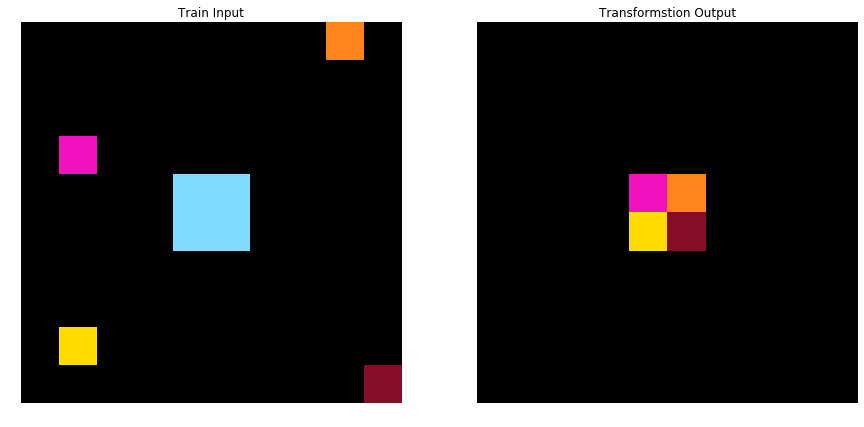

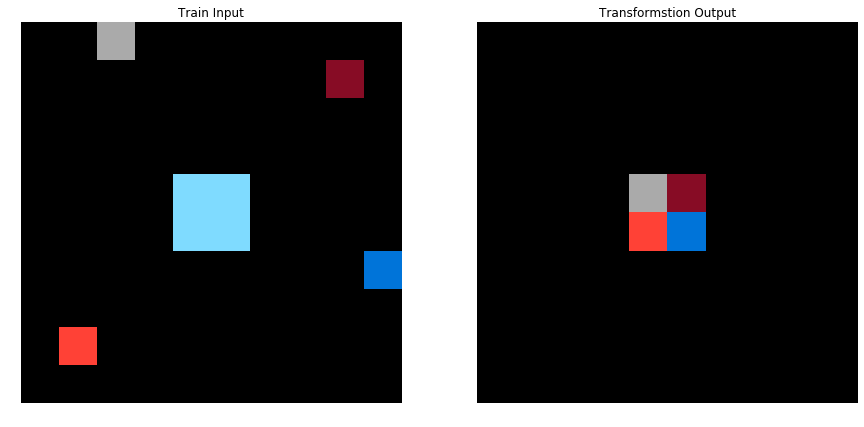

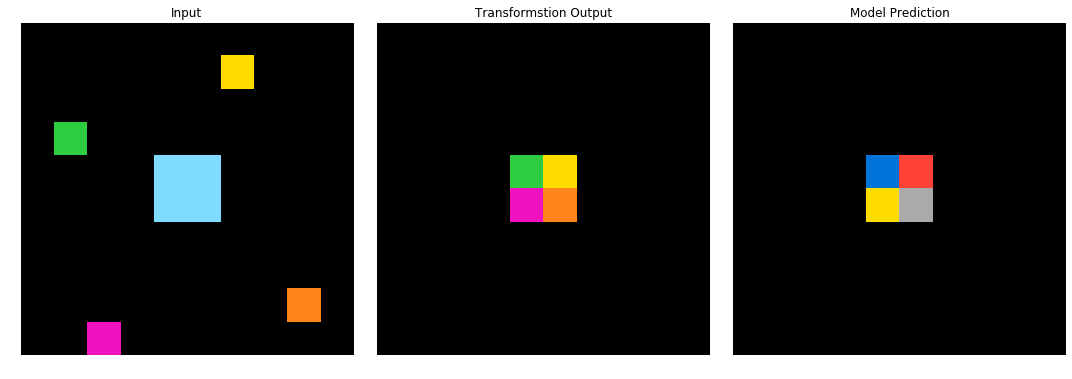

Made predictions for  d8c310e9
ensemble accuracy 0.72



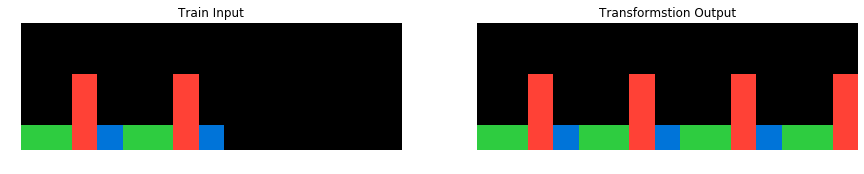

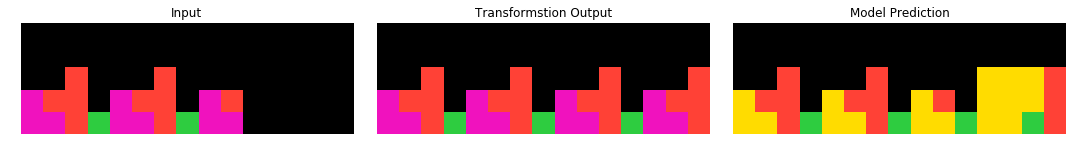

Made predictions for  d90796e8
ensemble accuracy 0.9206349206349206



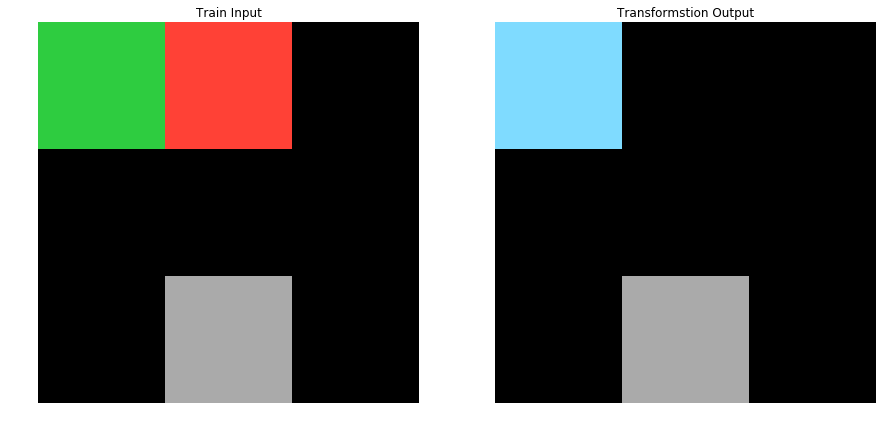

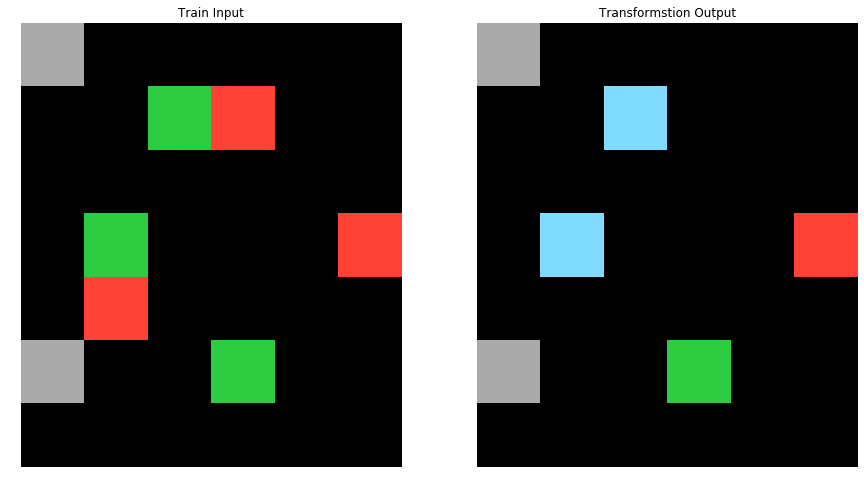

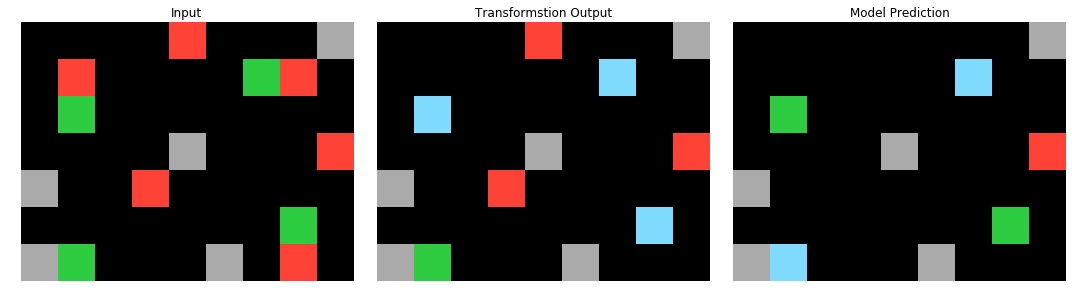

Made predictions for  d9f24cd1
ensemble accuracy 0.69



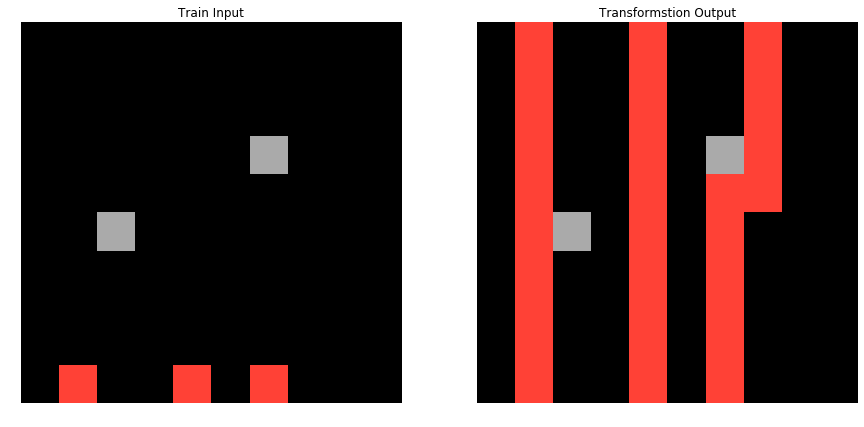

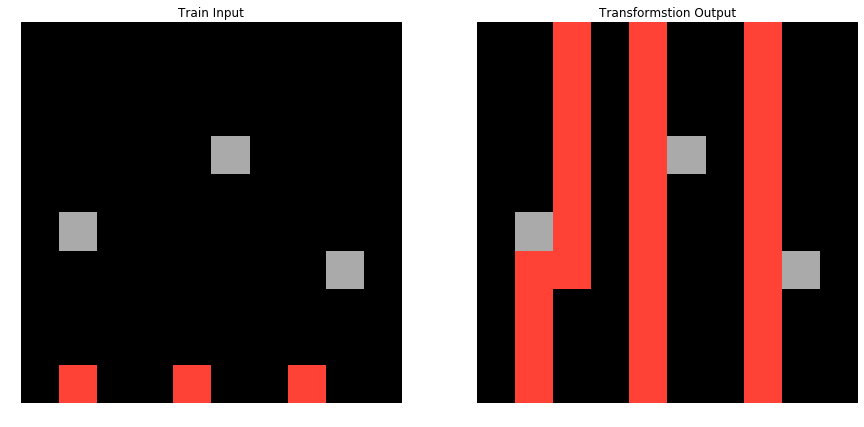

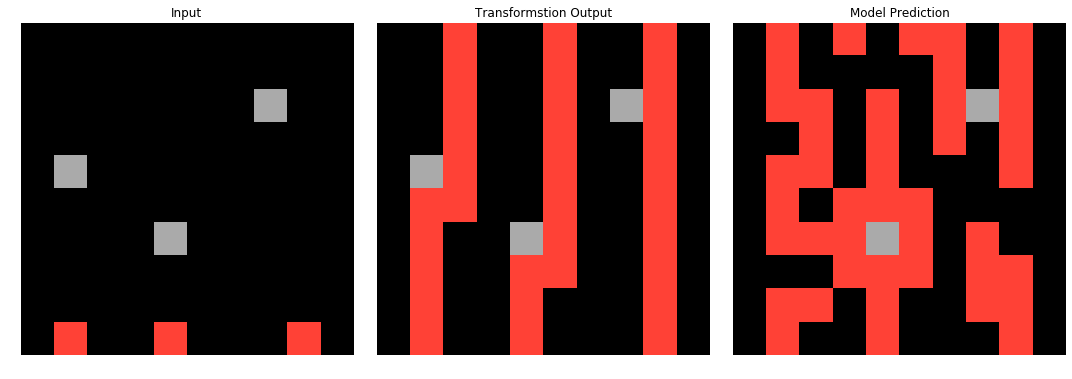

Number of input rows: 5 cols: 9
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d9fac9be.json

Number of input rows: 3 cols: 6
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/dae9d2b5.json

Made predictions for  db3e9e38
ensemble accuracy 0.8148148148148148



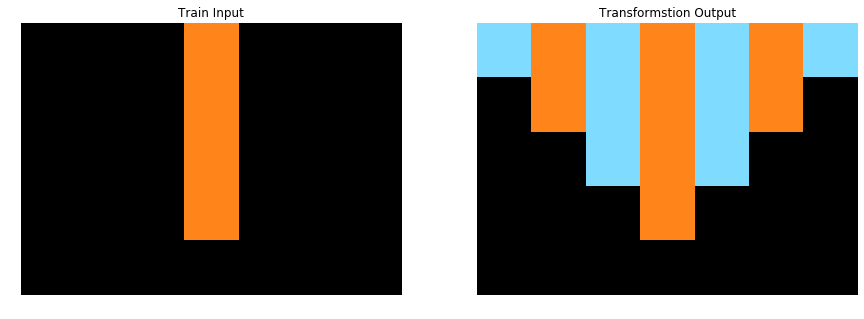

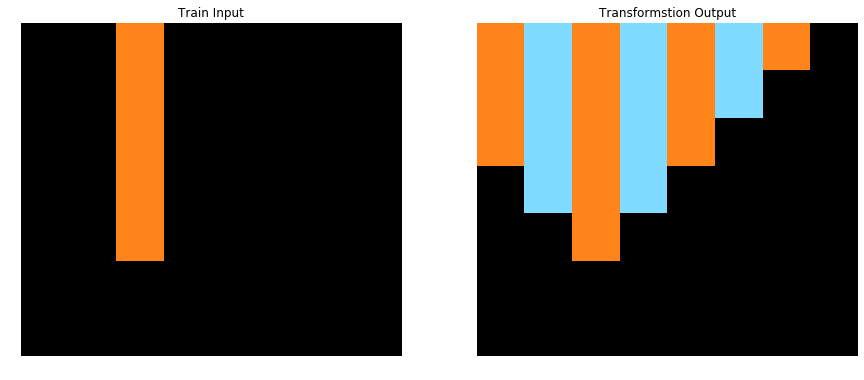

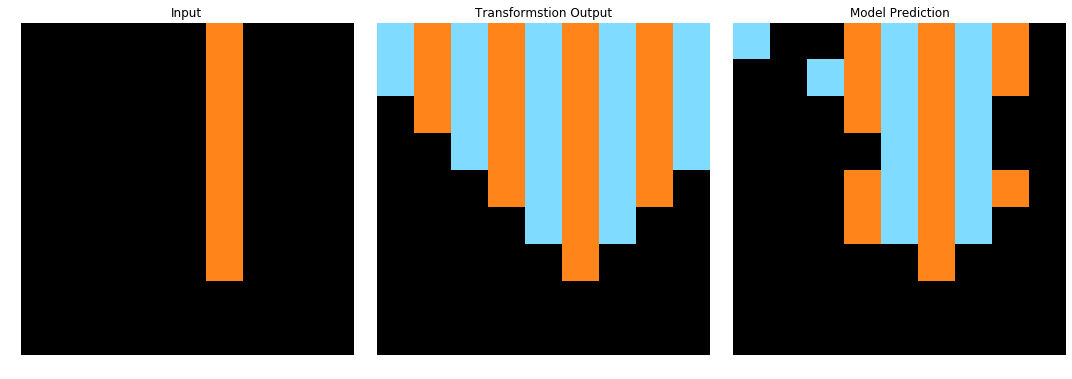

Made predictions for  db93a21d
ensemble accuracy 0.7233333333333334



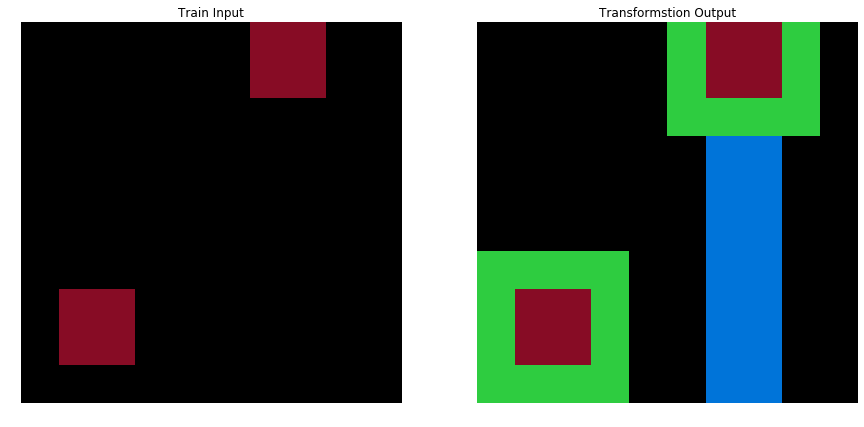

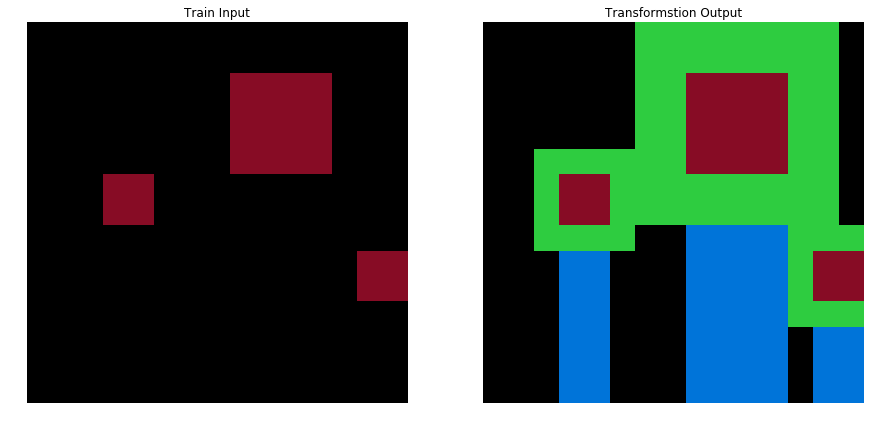

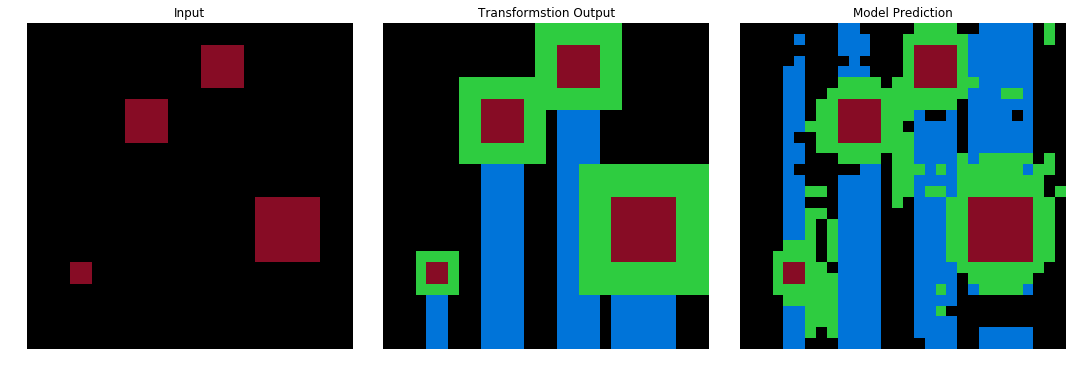

Made predictions for  dbc1a6ce
ensemble accuracy 0.8320802005012531



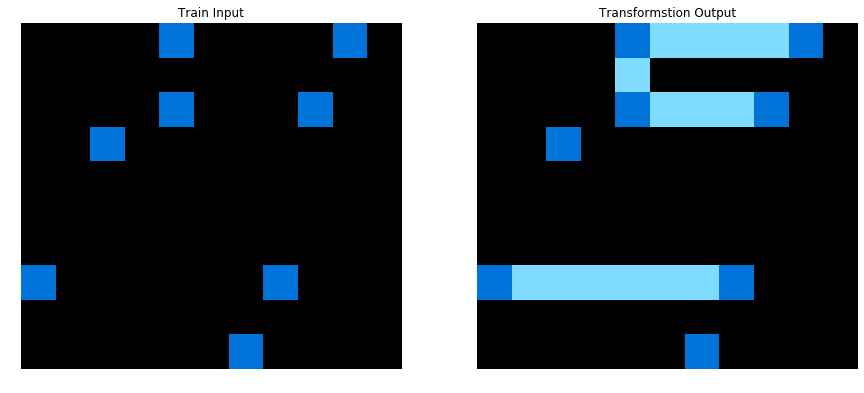

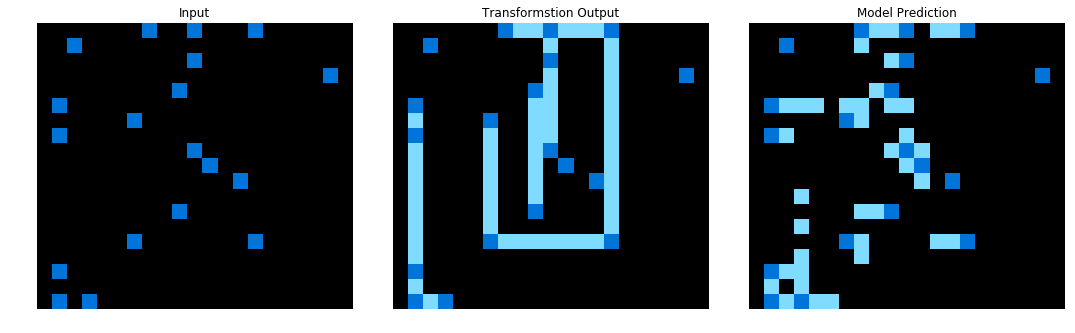

Number of input rows: 16 cols: 16
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/dc0a314f.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  dc1df850
ensemble accuracy 0.94



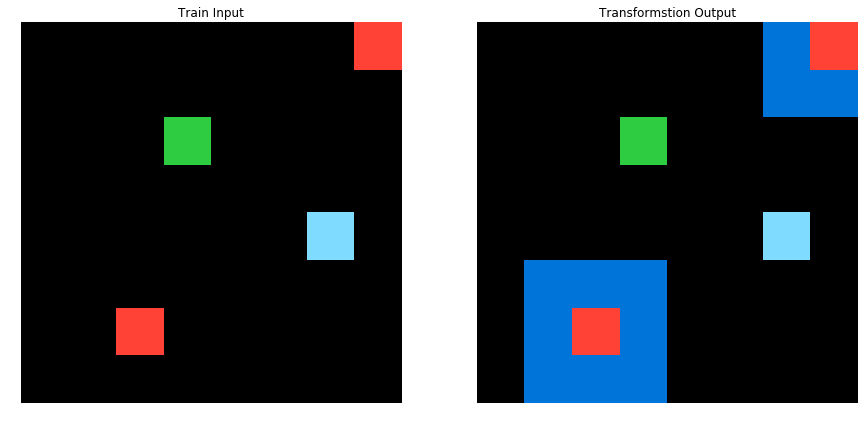

Made predictions for  dc433765
ensemble accuracy 1.0
dc433765.json



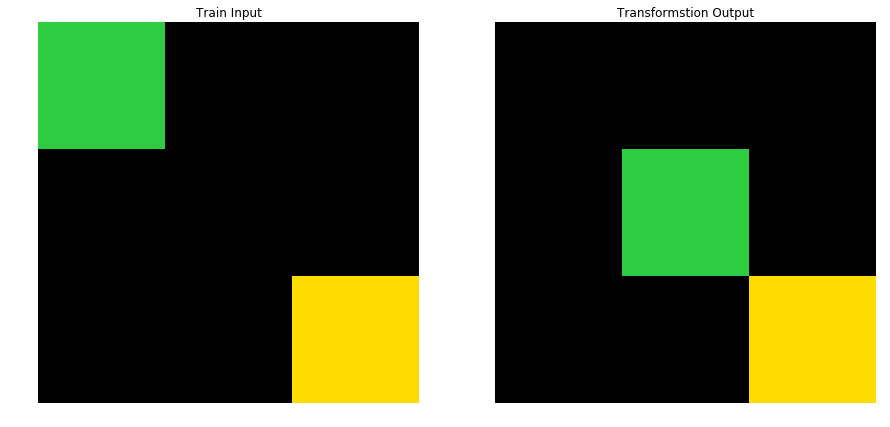

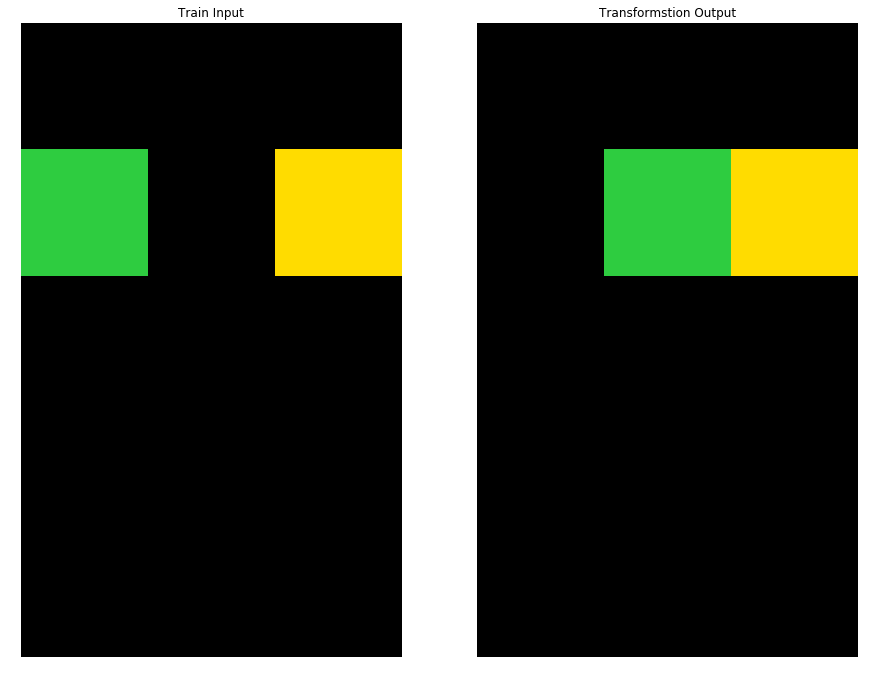

Made predictions for  dc433765
ensemble accuracy 1.0
dc433765.json



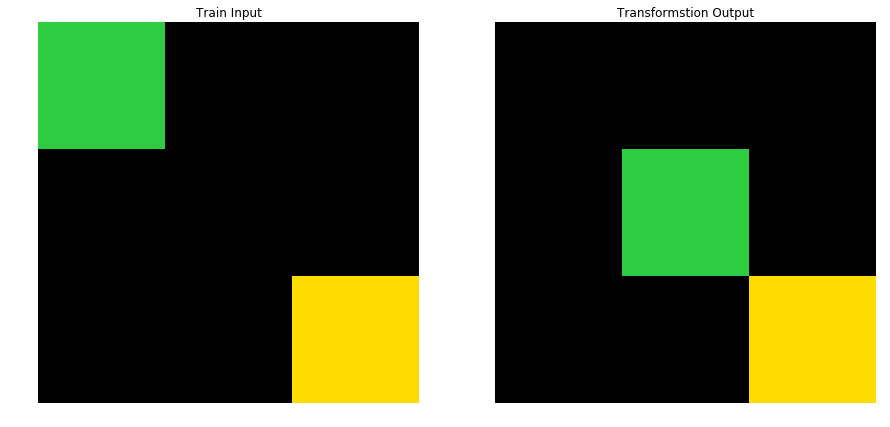

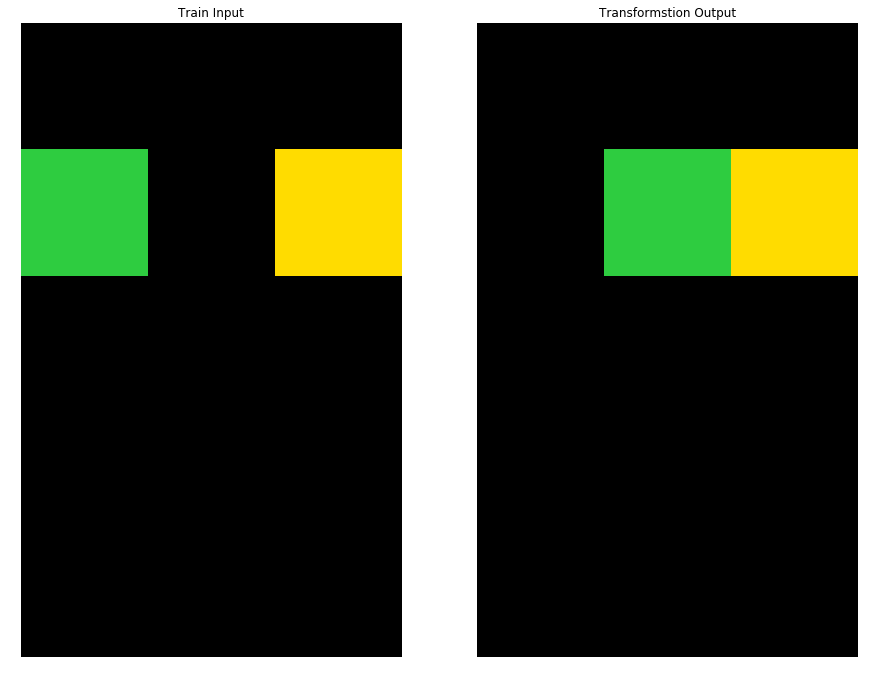

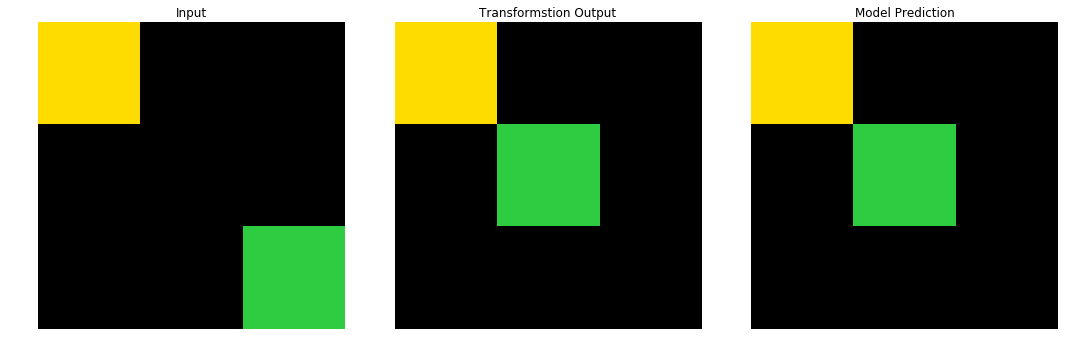

Made predictions for  ddf7fa4f
ensemble accuracy 0.76



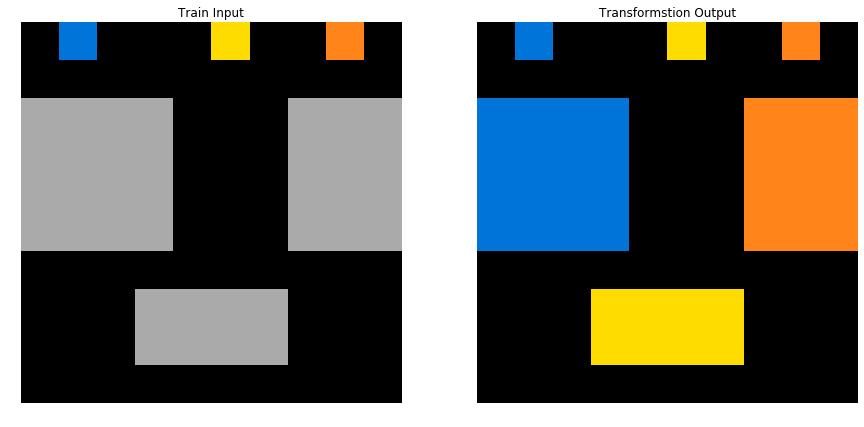

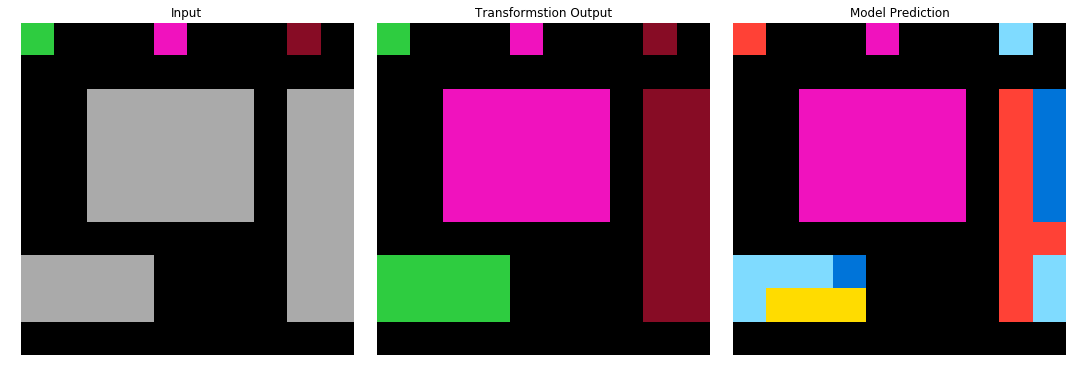

Number of input rows: 17 cols: 13
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/de1cd16c.json

Made predictions for  ded97339
ensemble accuracy 0.9



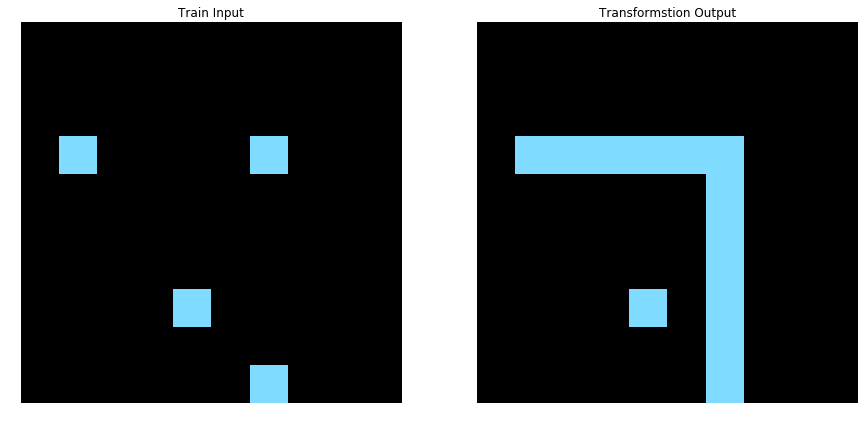

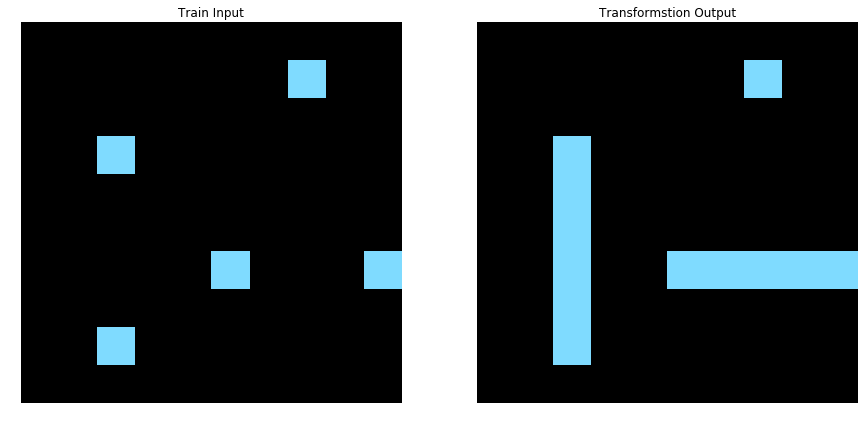

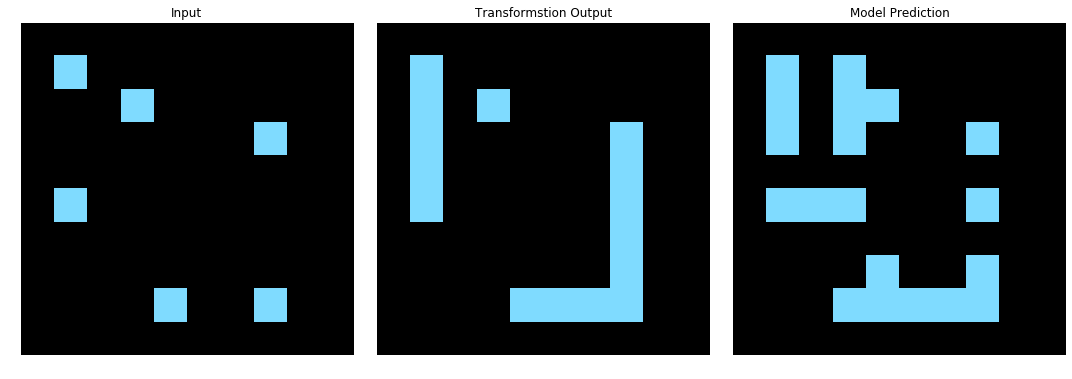

Made predictions for  e179c5f4
ensemble accuracy 0.76



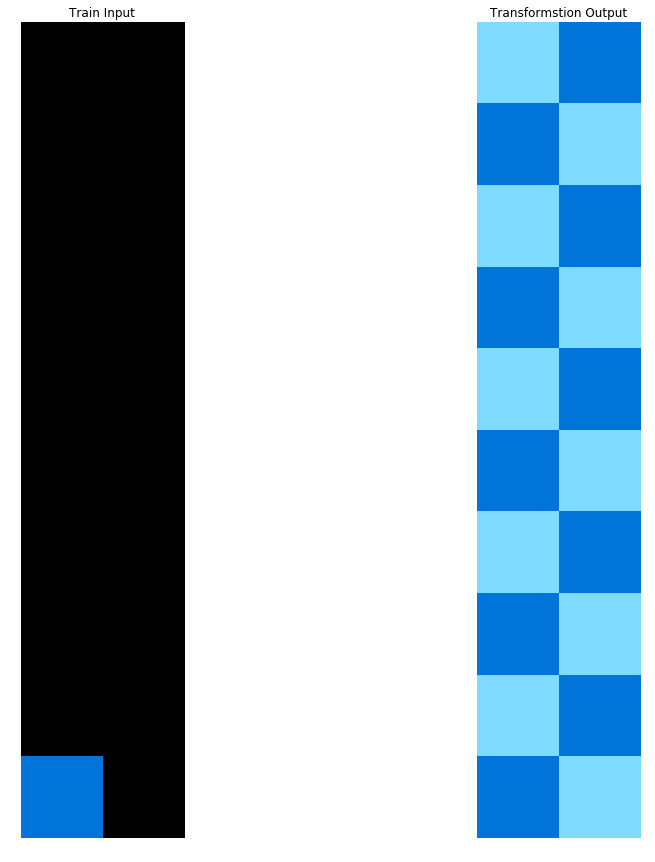

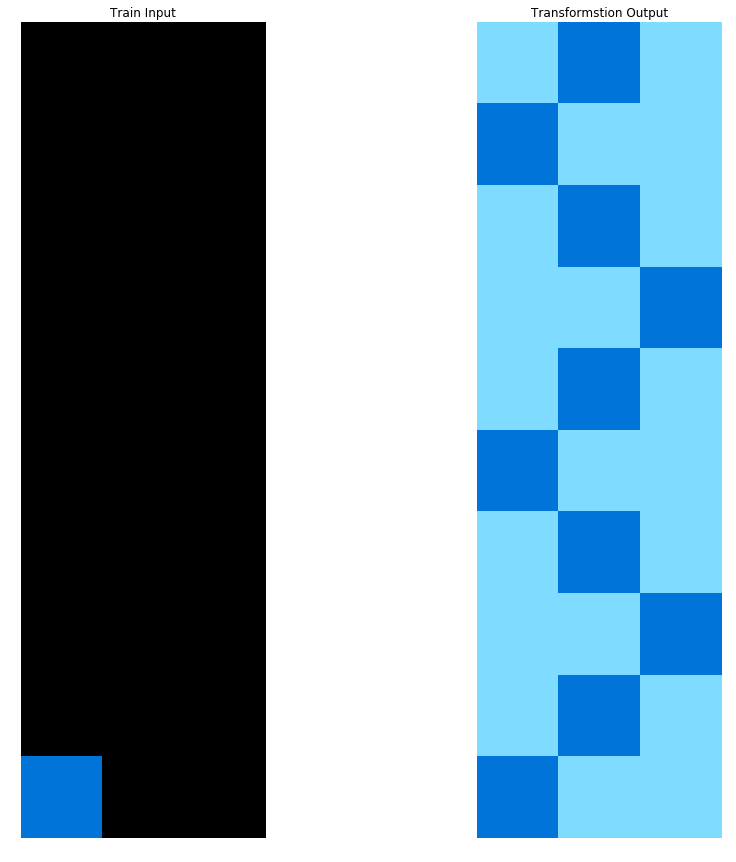

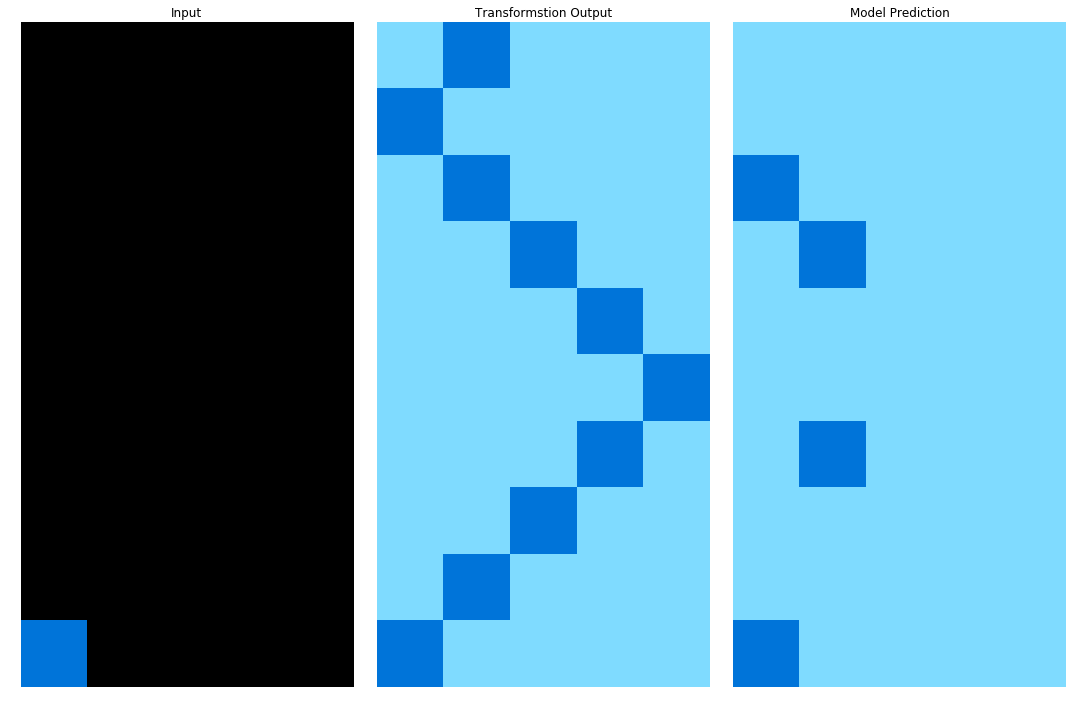

Made predictions for  e21d9049
ensemble accuracy 0.9375



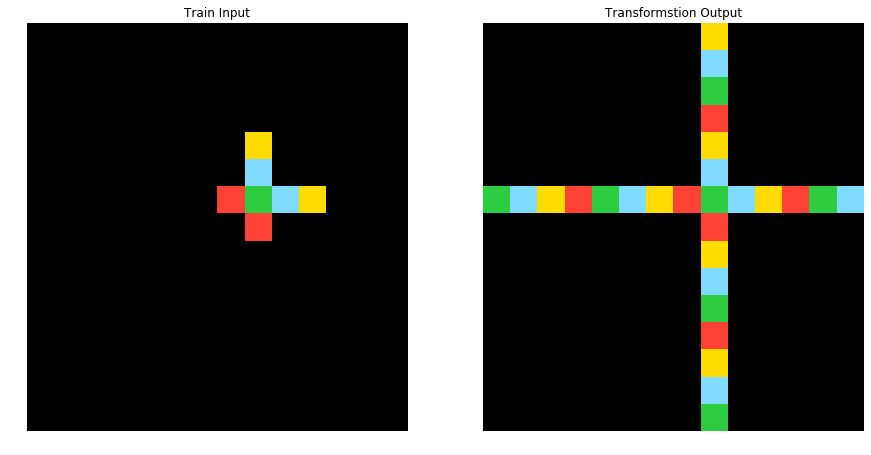

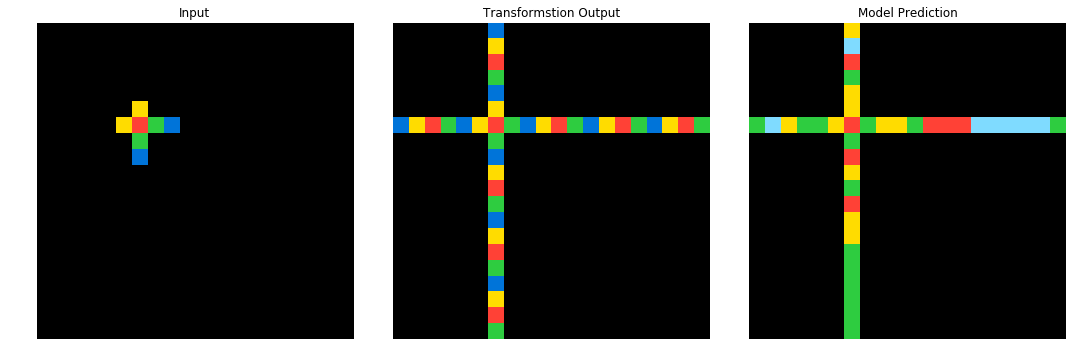

Made predictions for  e26a3af2
ensemble accuracy 0.6533333333333333



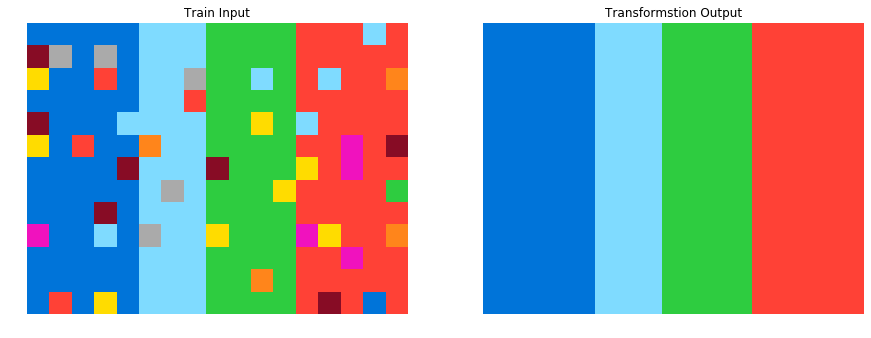

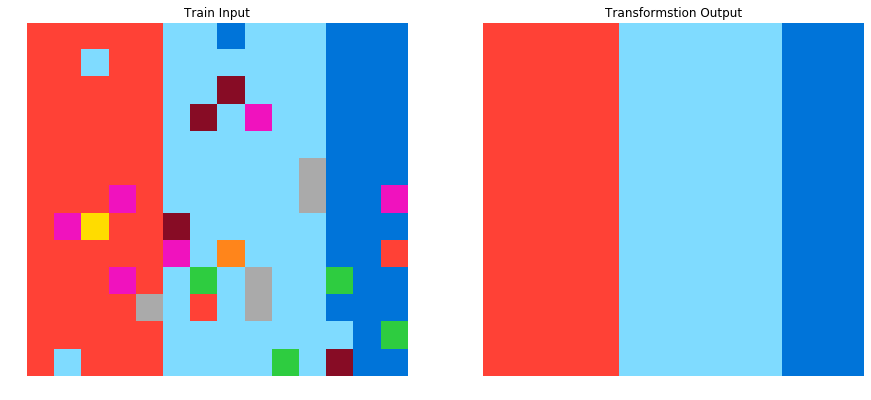

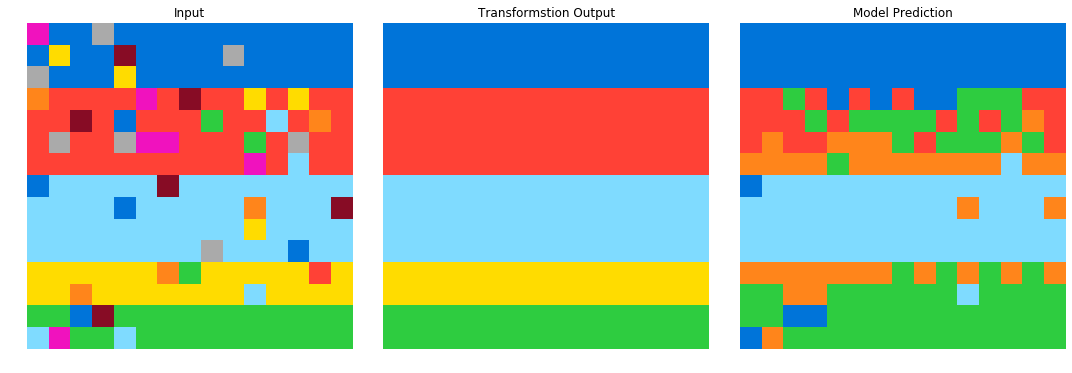

Number of input rows: 10 cols: 9
Number of target rows: 10 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e3497940.json

Made predictions for  e40b9e2f
ensemble accuracy 0.72



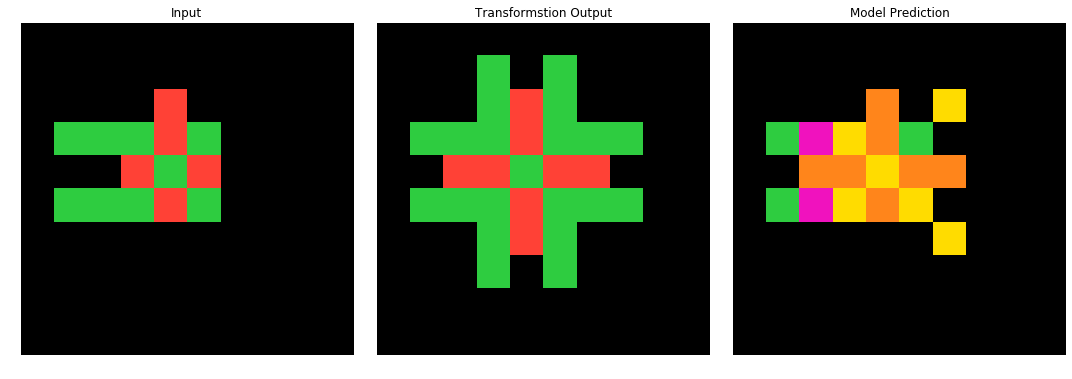

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  e48d4e1a
ensemble accuracy 0.77



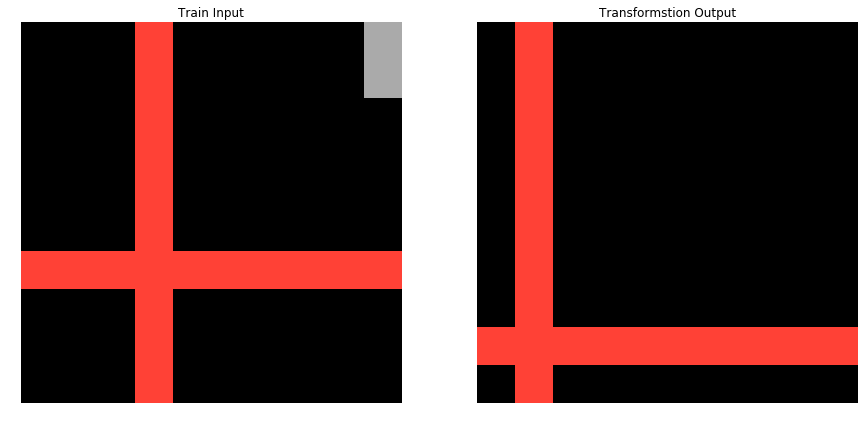

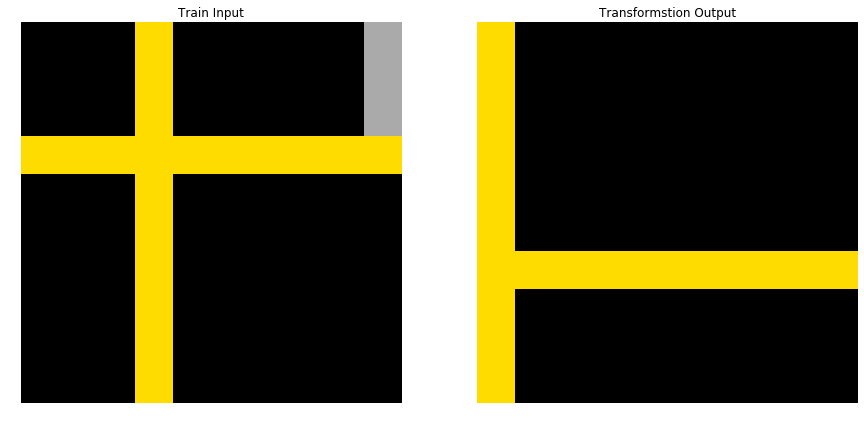

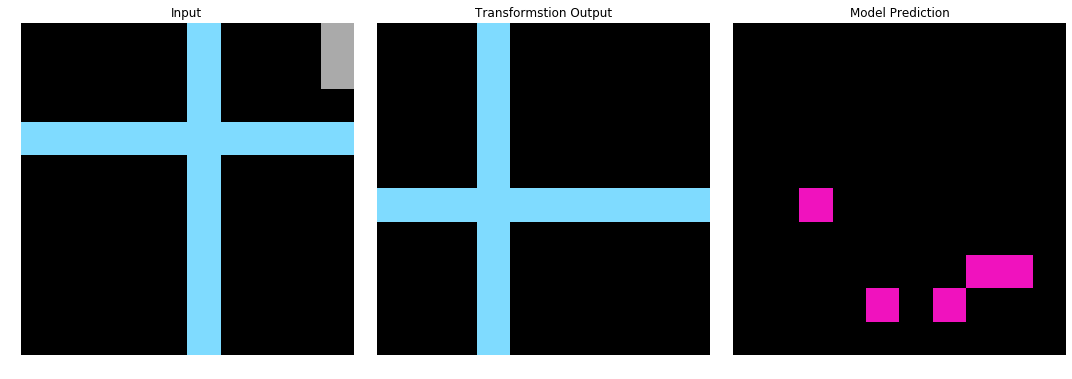

Made predictions for  e5062a87
ensemble accuracy 0.84



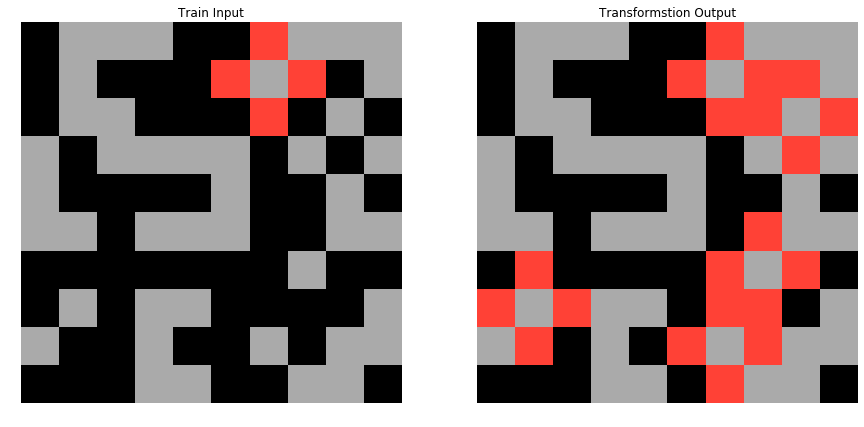

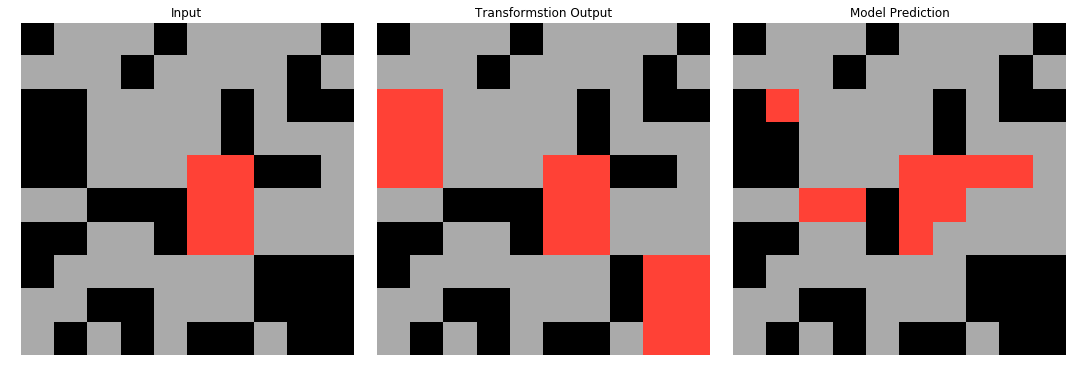

Made predictions for  e509e548
ensemble accuracy 0.8794642857142857



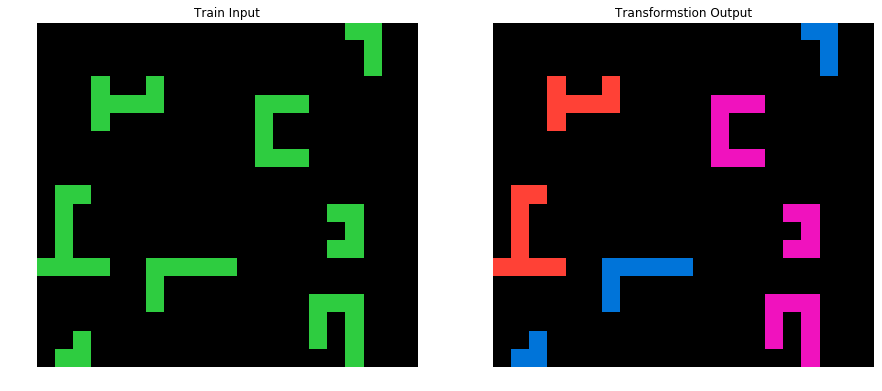

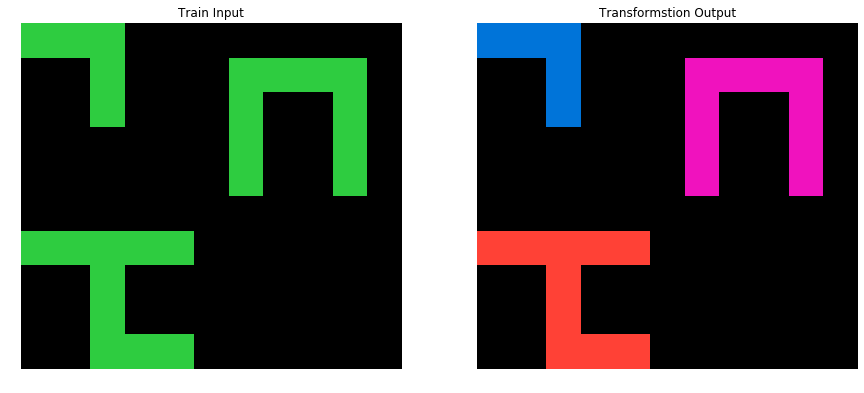

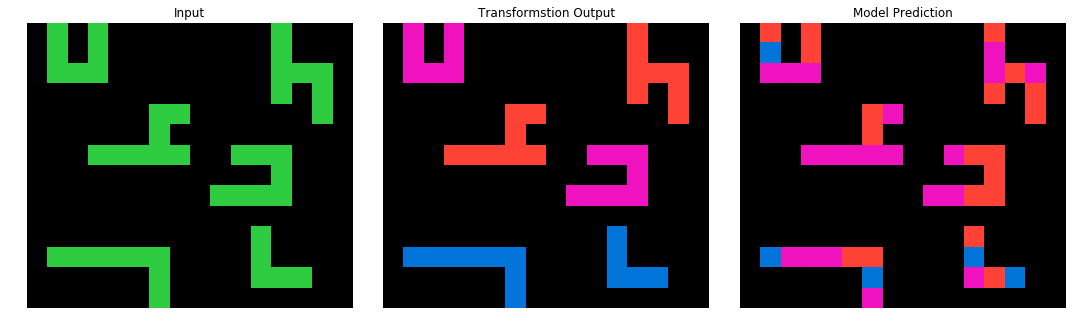

Number of input rows: 10 cols: 10
Number of target rows: 5 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e50d258f.json

Number of input rows: 30 cols: 17
Number of target rows: 15 cols: 17
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e6721834.json

Made predictions for  e73095fd
ensemble accuracy 0.9756944444444444
e73095fd.json



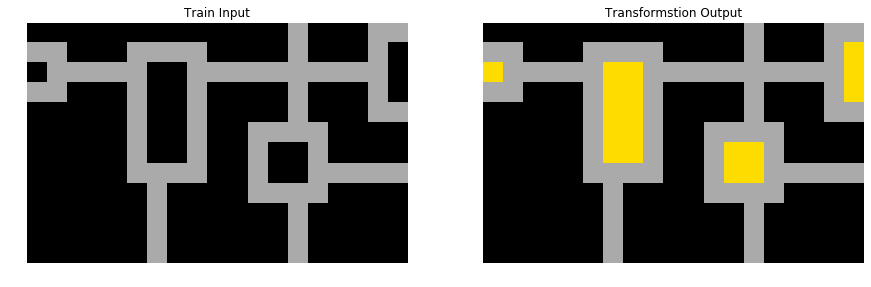

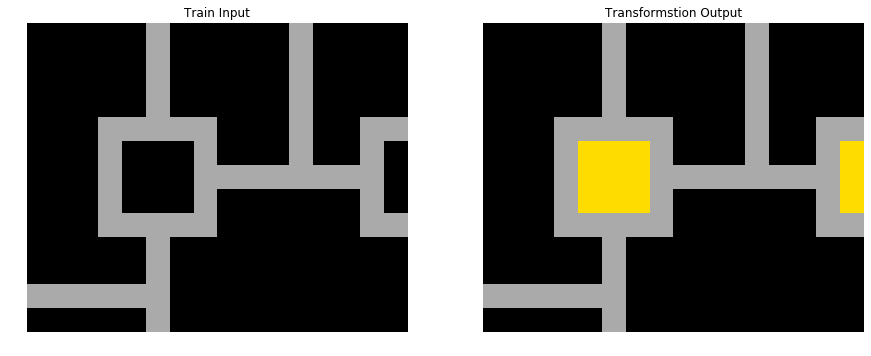

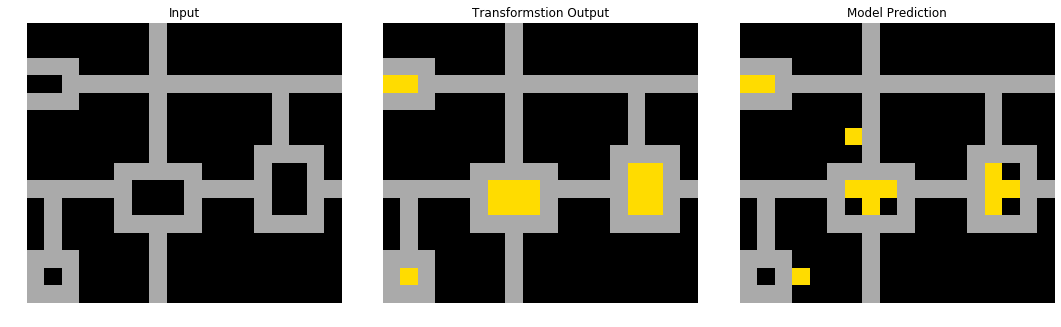

Made predictions for  e76a88a6
ensemble accuracy 0.61



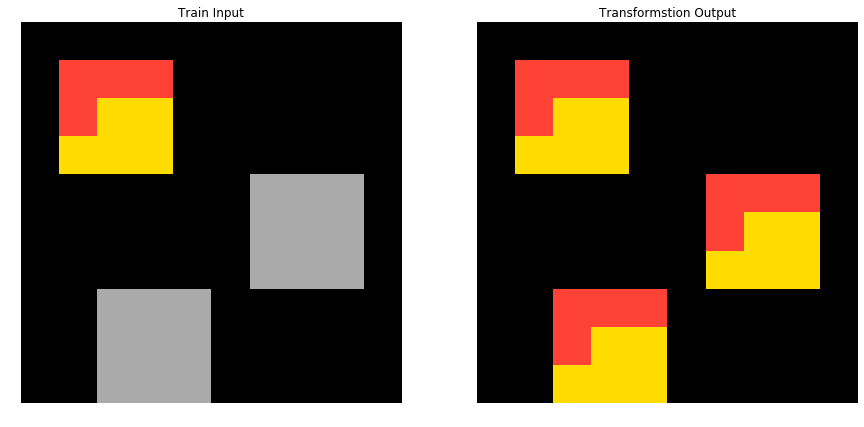

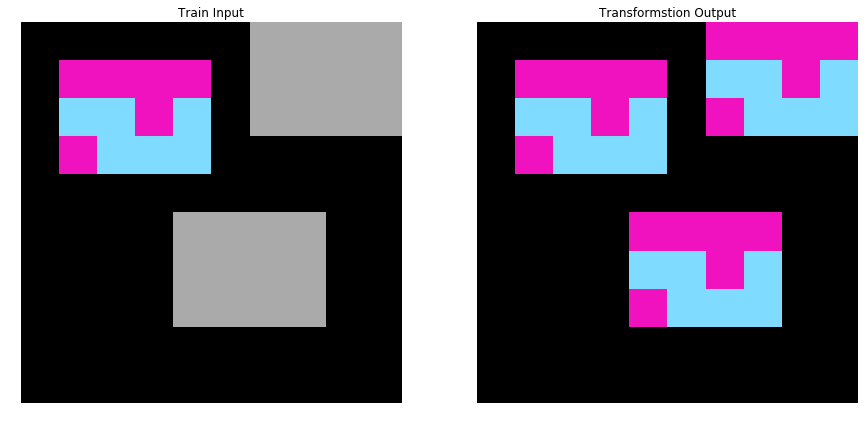

Made predictions for  e8593010
ensemble accuracy 0.95
e8593010.json



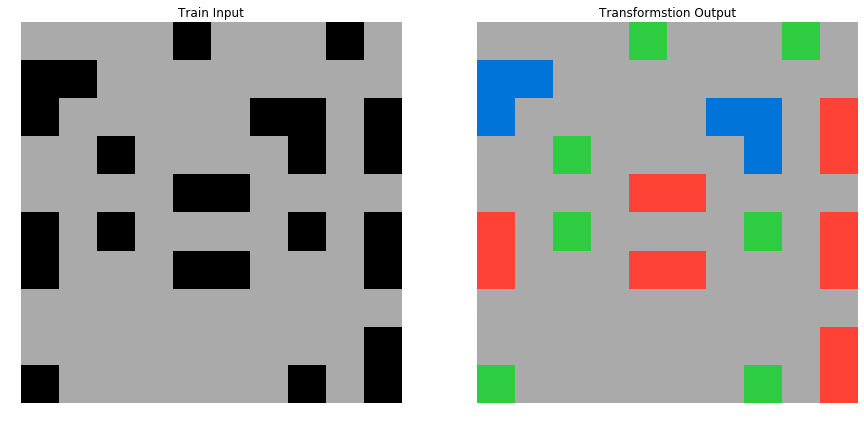

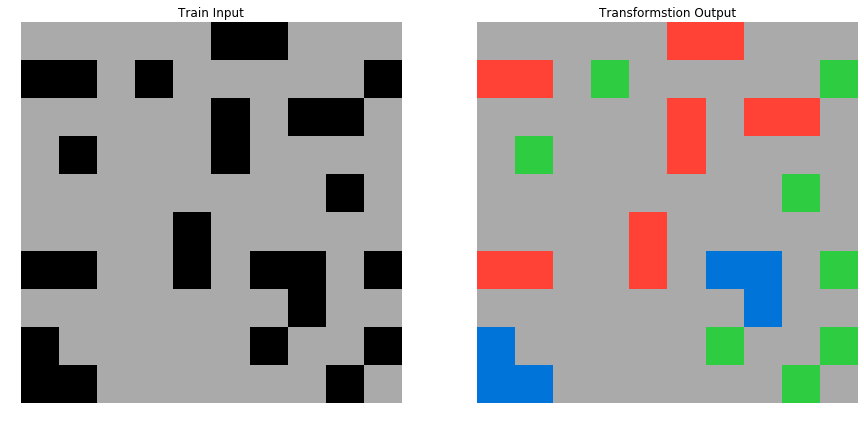

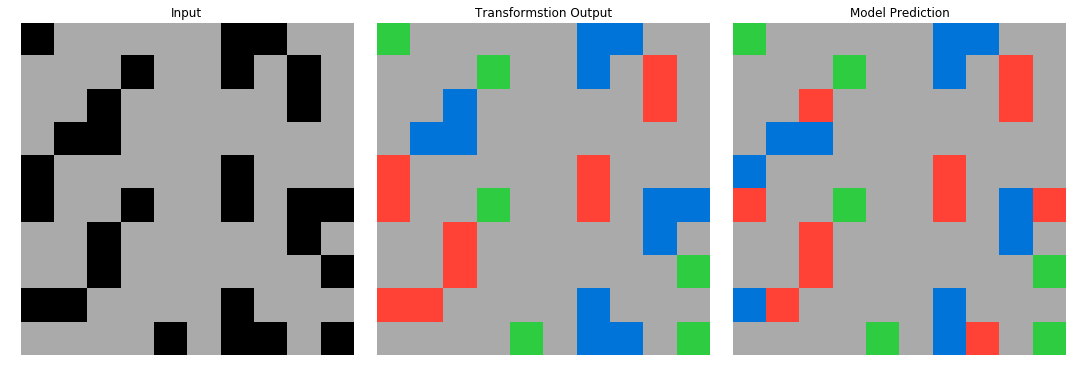

Made predictions for  e8dc4411
ensemble accuracy 0.7118055555555556



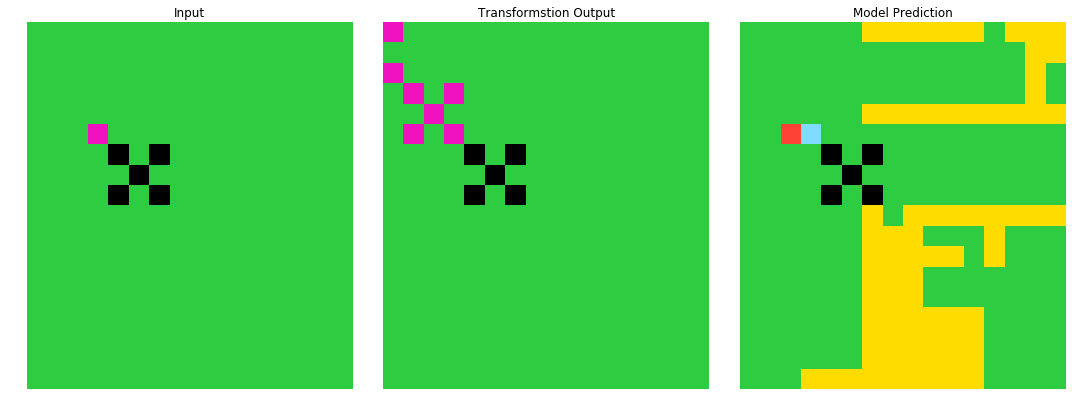

Made predictions for  e9614598
ensemble accuracy 0.9652777777777778
e9614598.json



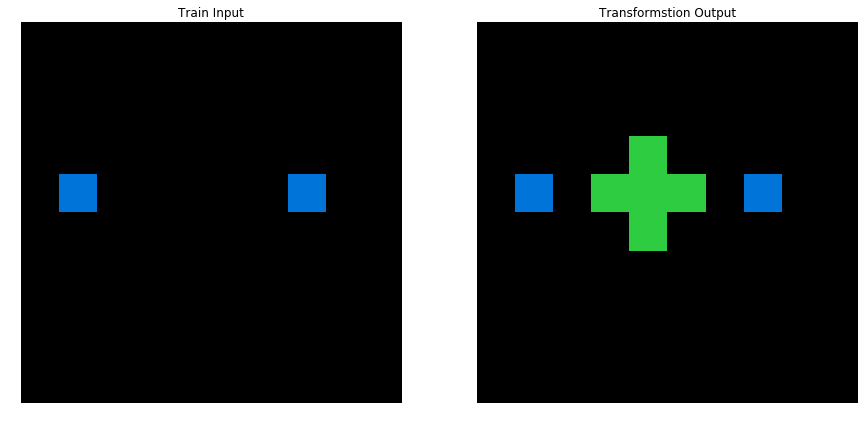

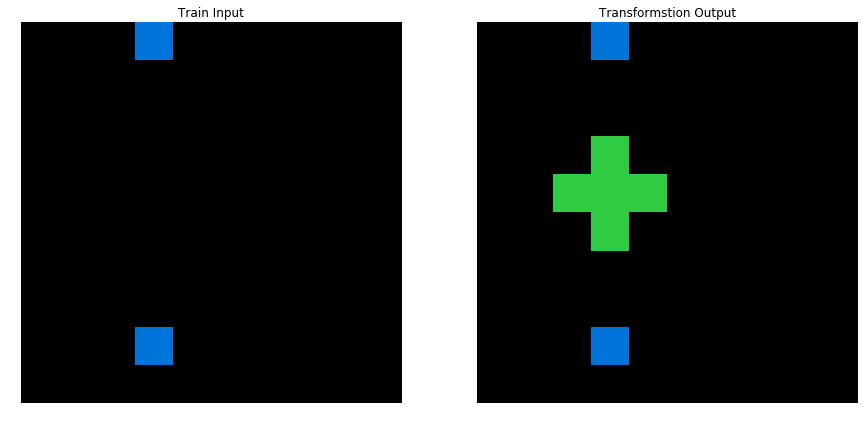

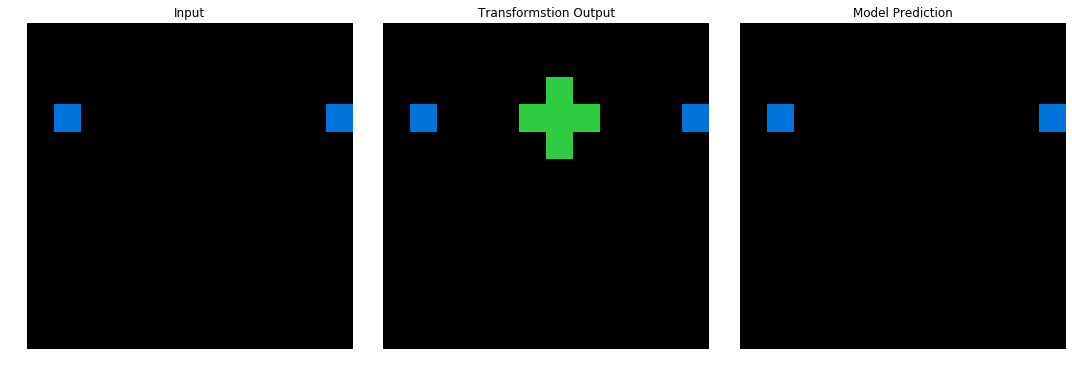

Made predictions for  e9614598
ensemble accuracy 0.9333333333333333



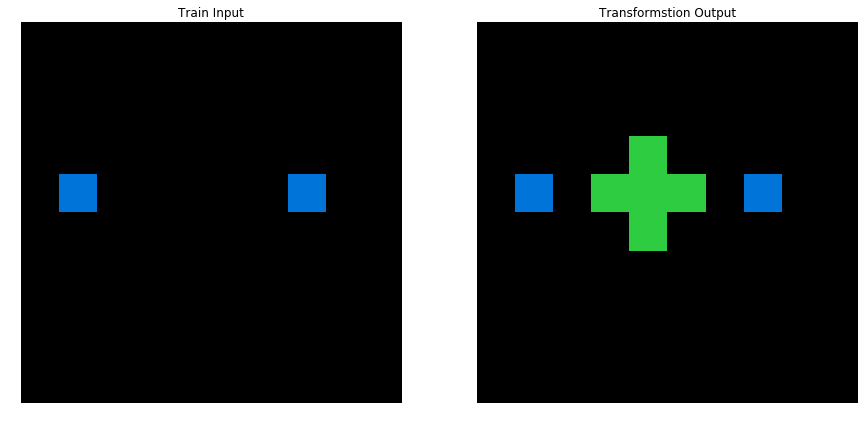

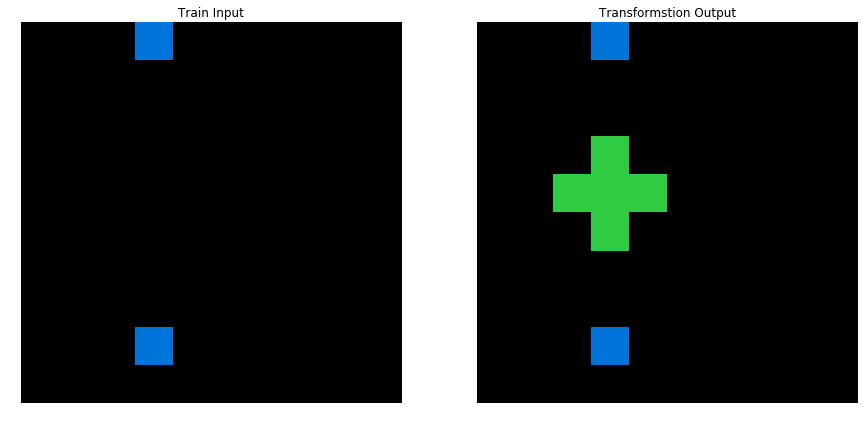

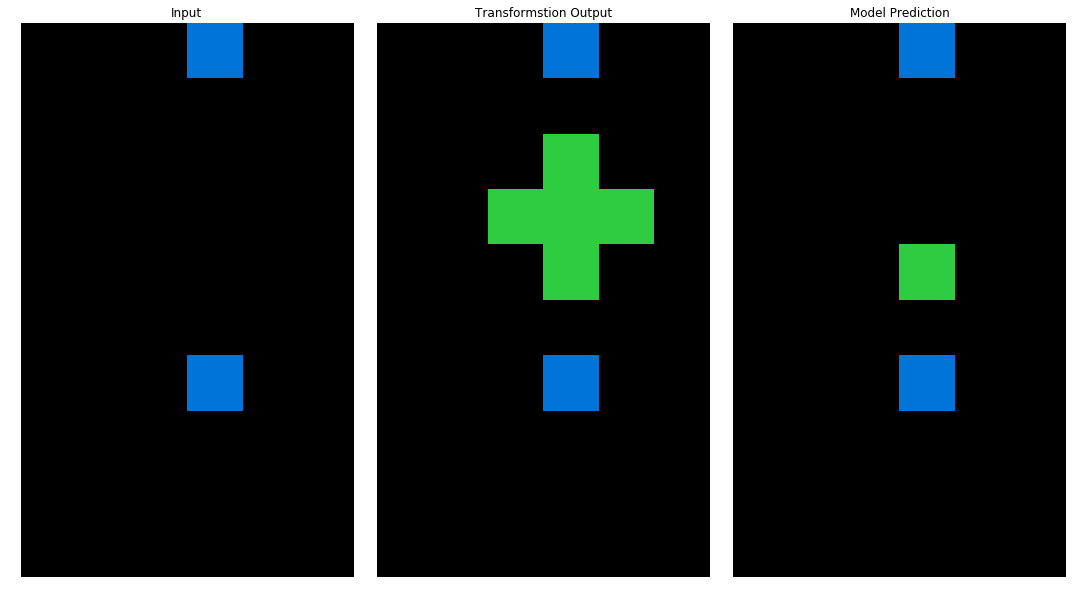

Number of input rows: 11 cols: 11
Number of target rows: 5 cols: 11
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e98196ab.json

Made predictions for  e9afcf9a
ensemble accuracy 0.0



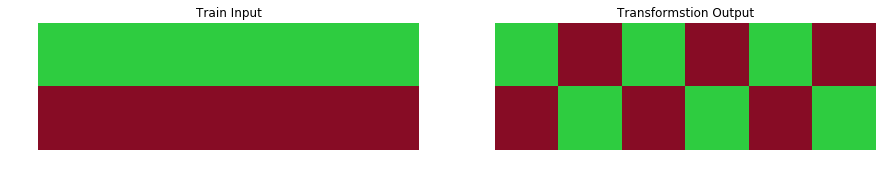

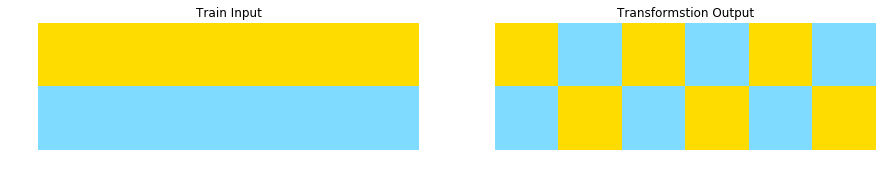

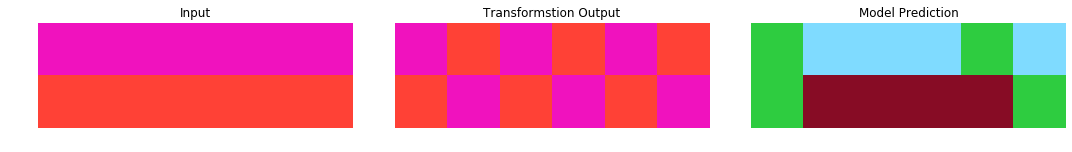

Made predictions for  ea32f347
ensemble accuracy 0.89



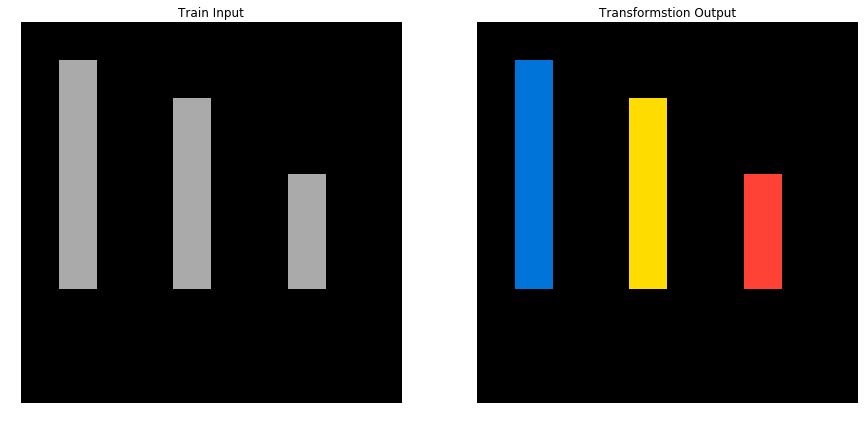

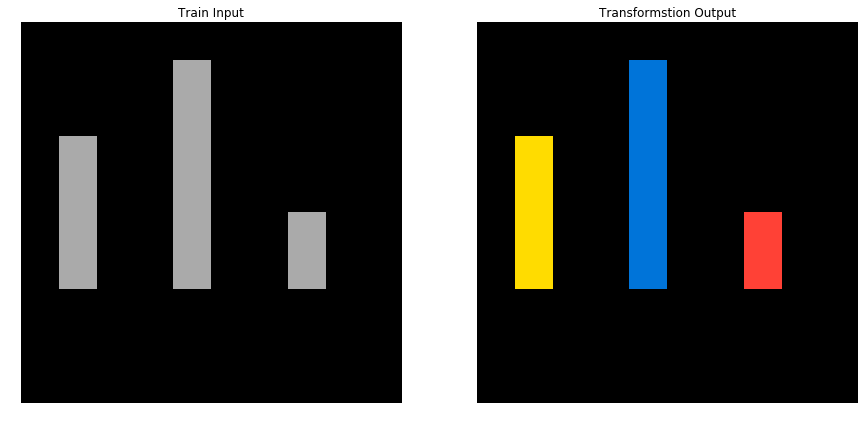

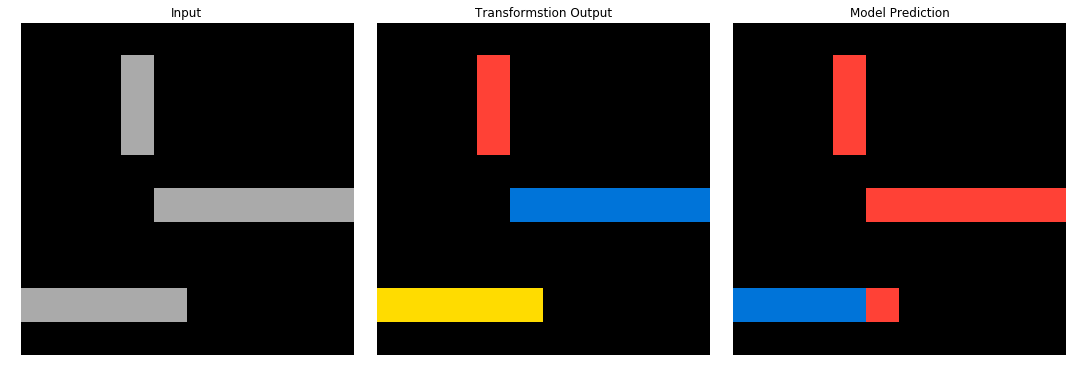

Made predictions for  ea786f4a
ensemble accuracy 0.09917355371900827



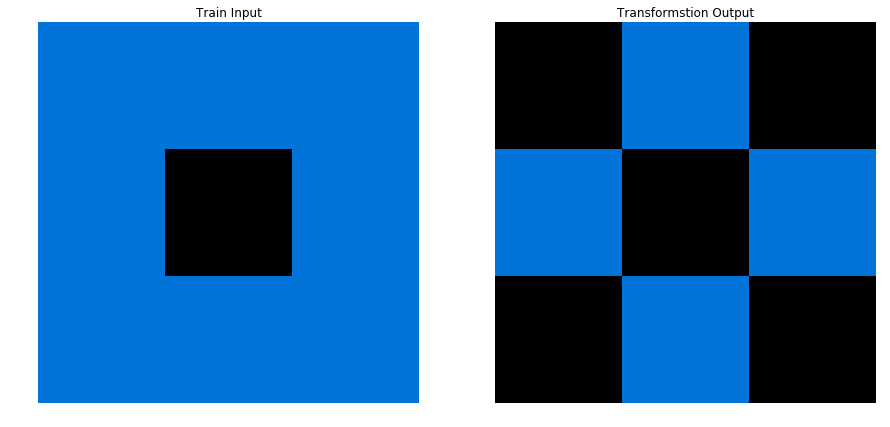

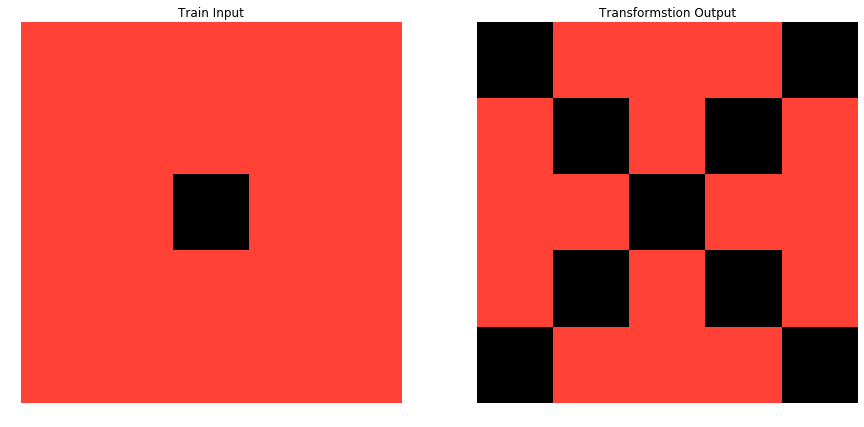

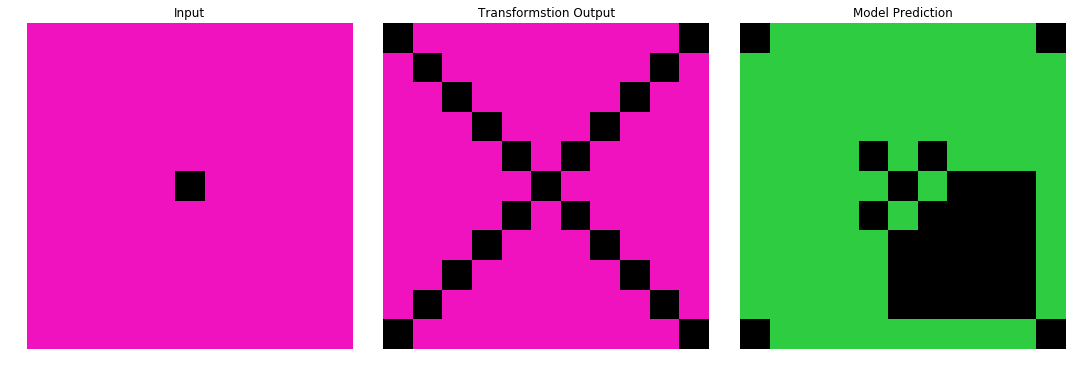

Number of input rows: 3 cols: 17
Number of target rows: 9 cols: 17
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/eb281b96.json

Number of input rows: 23 cols: 27
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/eb5a1d5d.json

Made predictions for  ec883f72
ensemble accuracy 0.9583333333333334
ec883f72.json



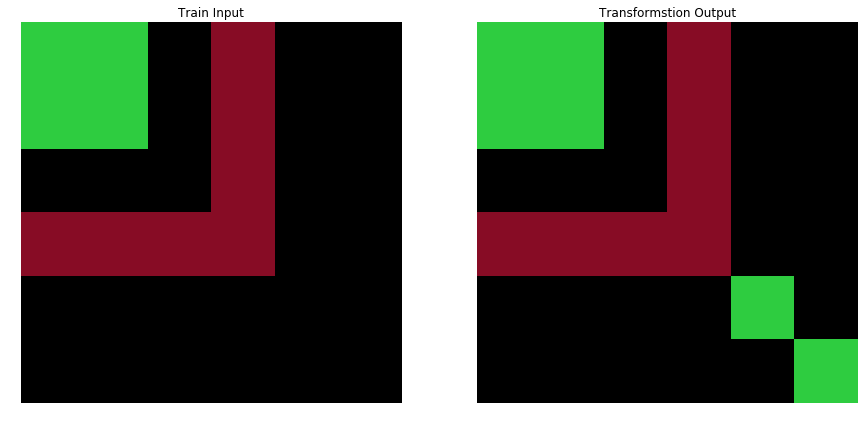

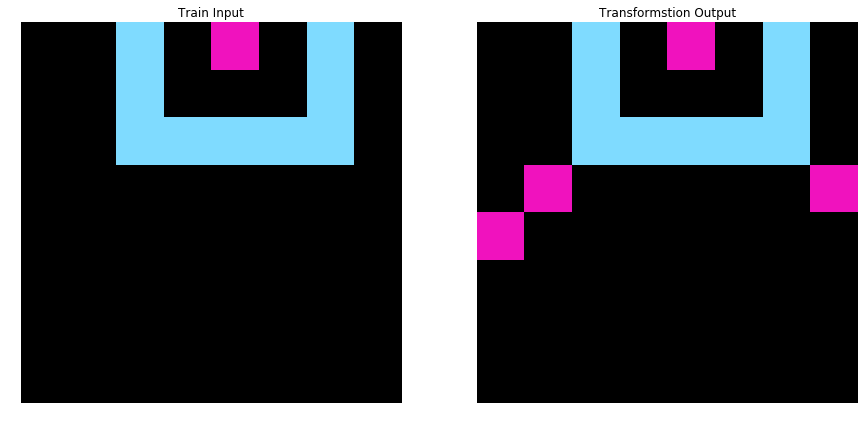

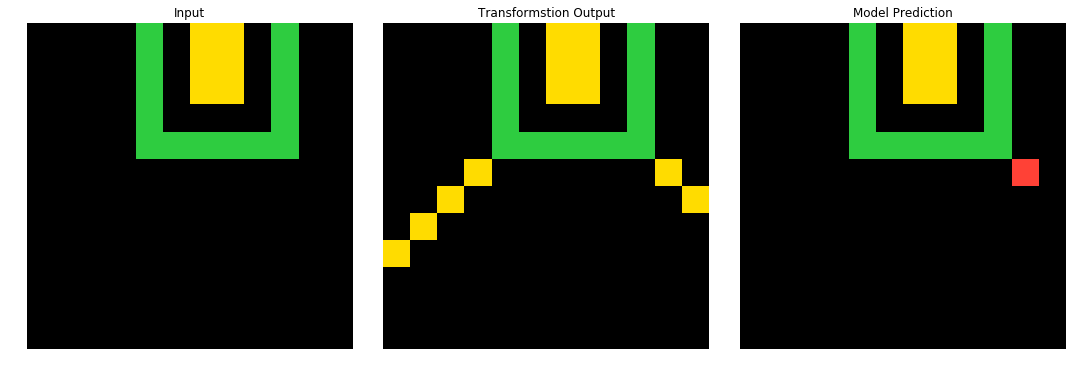

Made predictions for  ecdecbb3
ensemble accuracy 0.8668730650154799



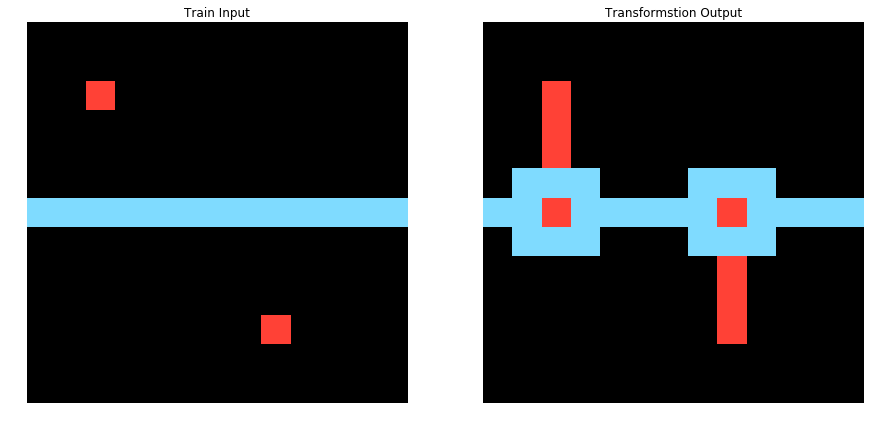

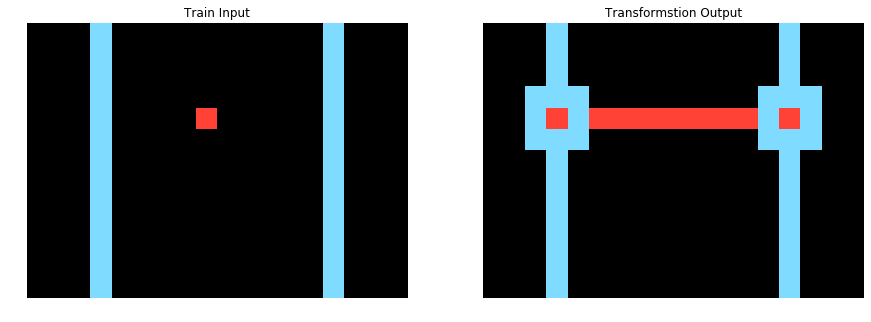

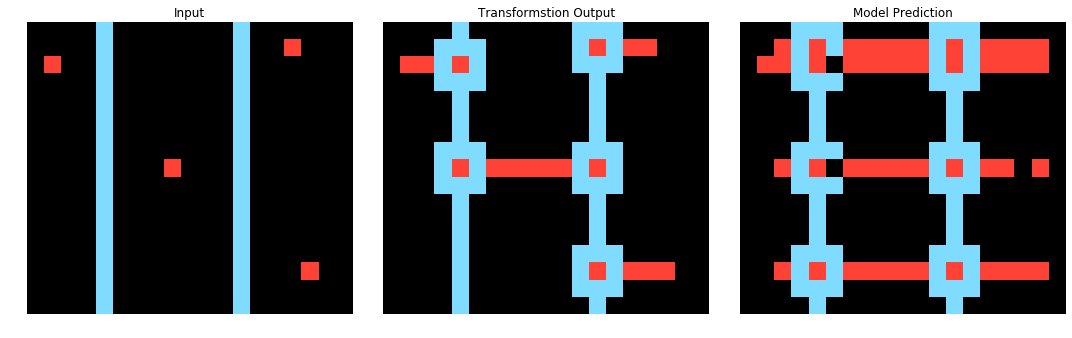

Made predictions for  ed36ccf7
ensemble accuracy 0.3333333333333333



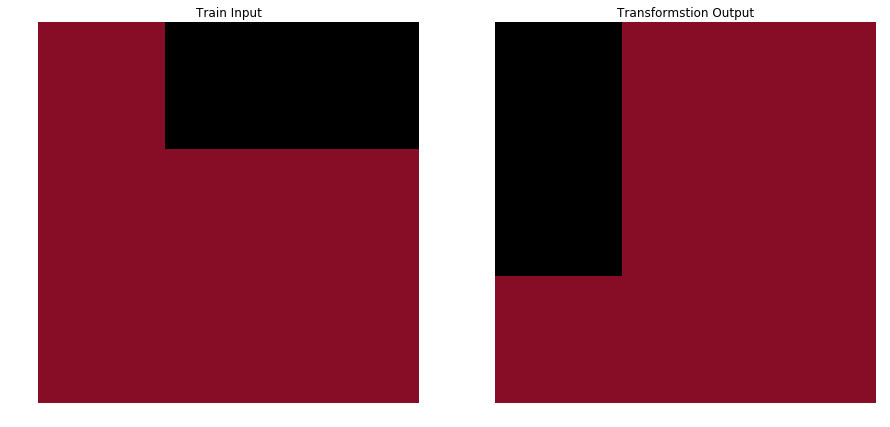

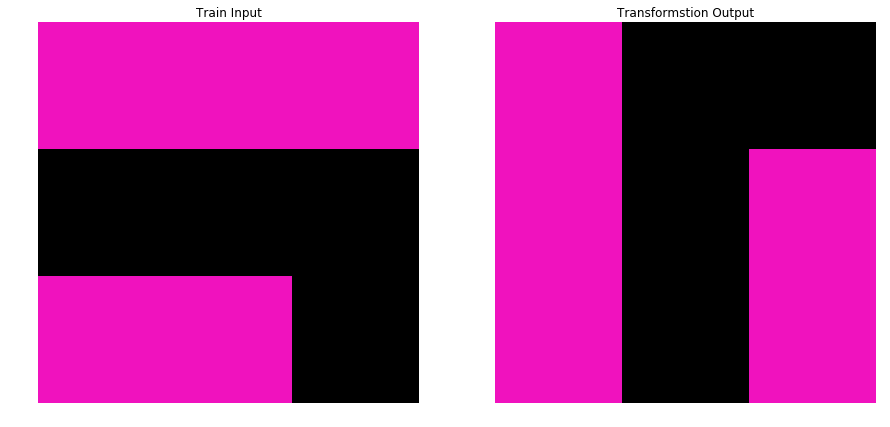

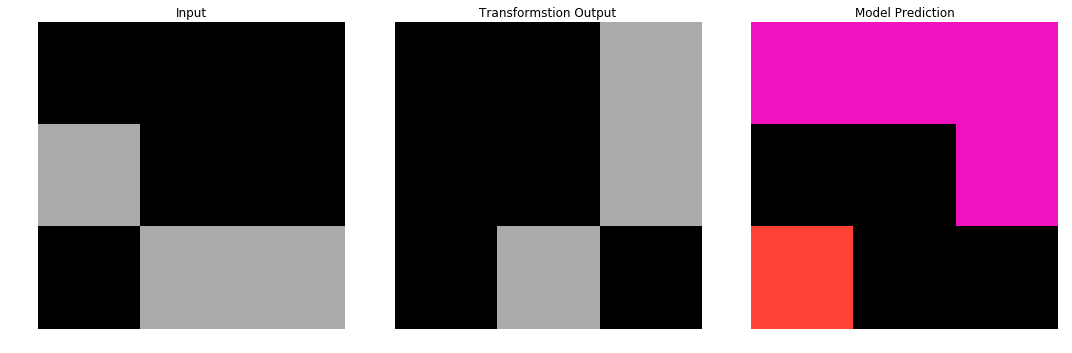

Made predictions for  ef135b50
ensemble accuracy 0.98
ef135b50.json



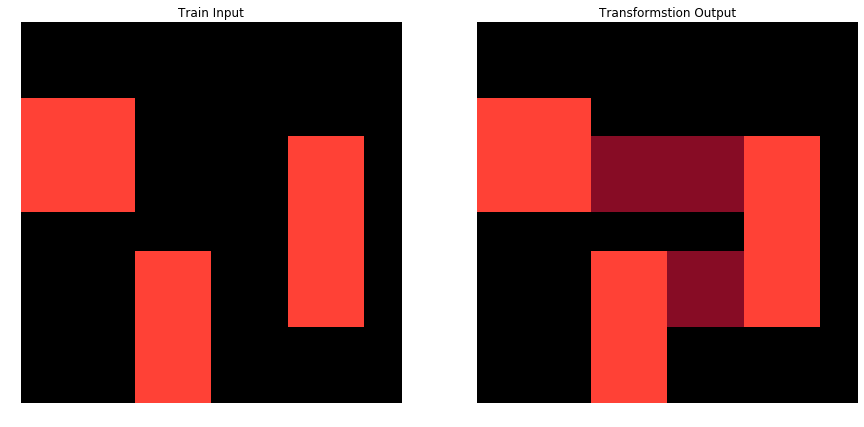

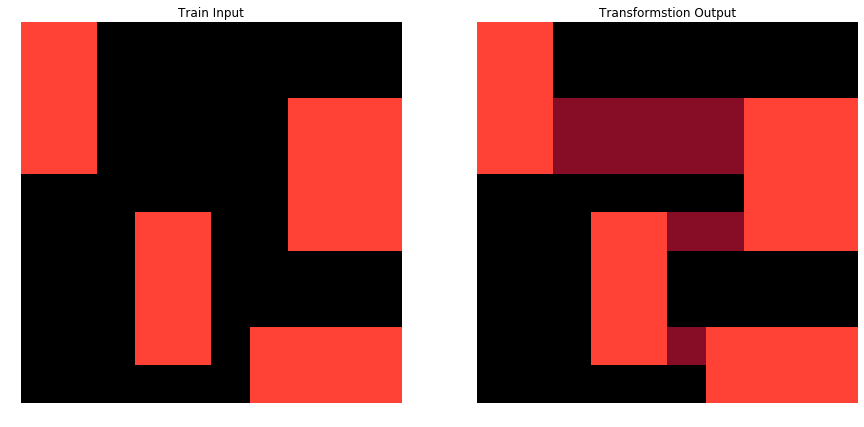

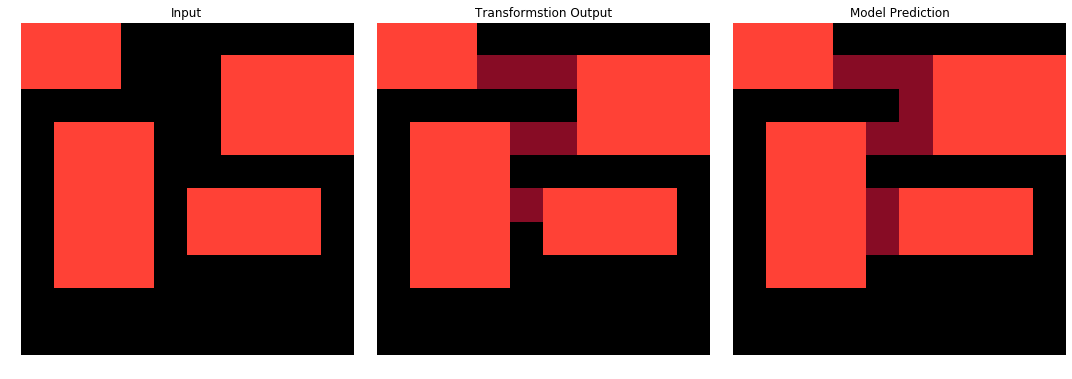

Made predictions for  f15e1fac
ensemble accuracy 0.7303921568627451



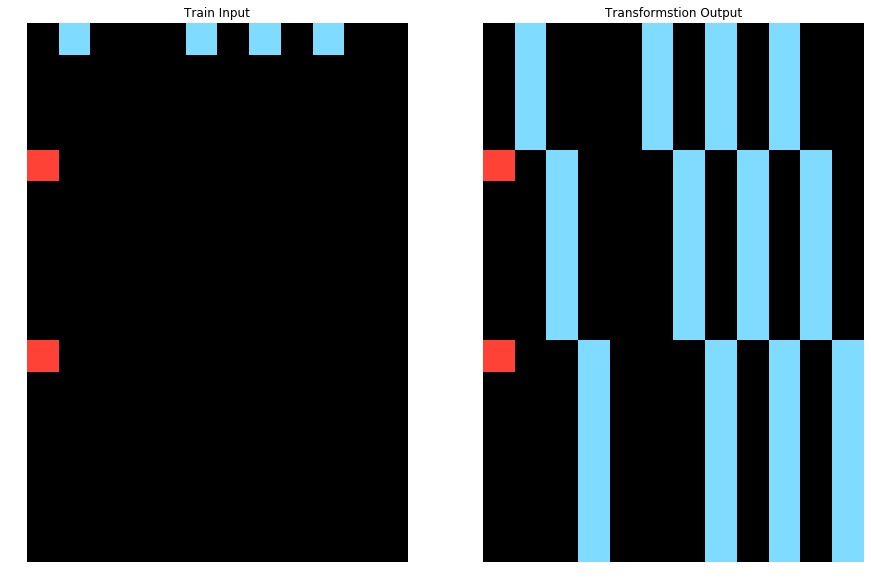

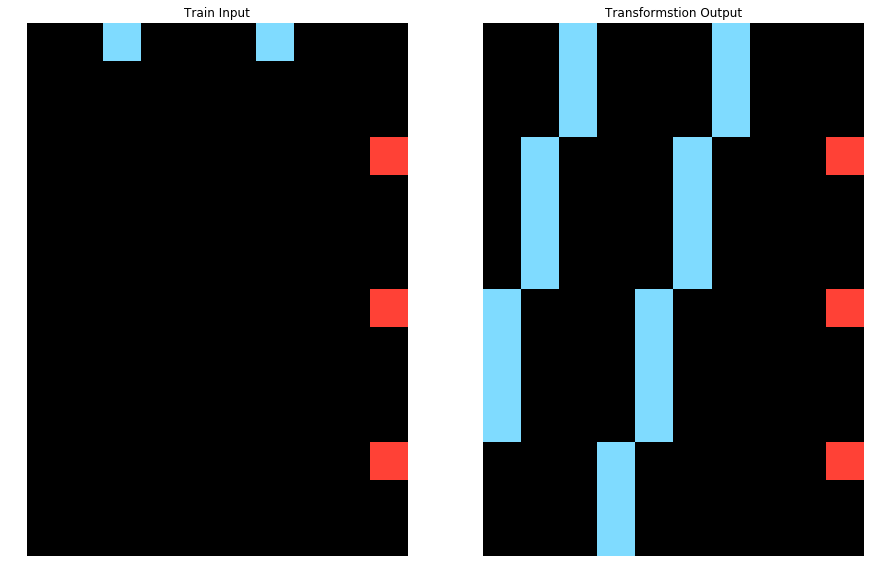

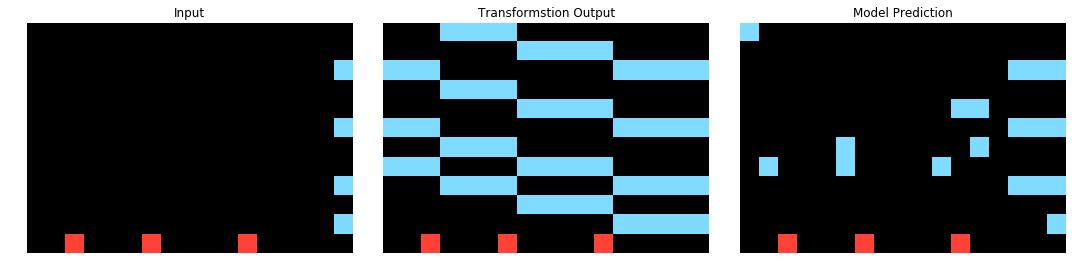

Made predictions for  f1cefba8
ensemble accuracy 0.8538011695906432



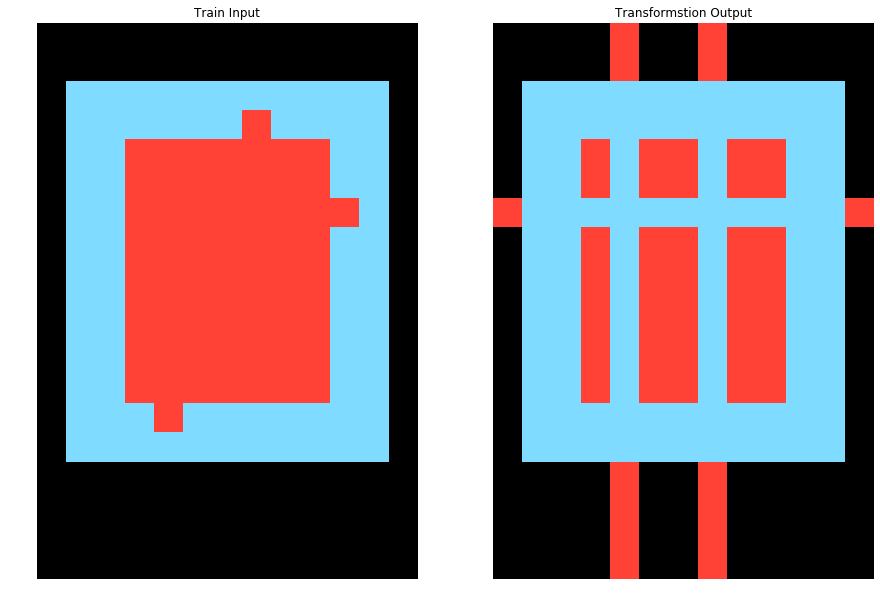

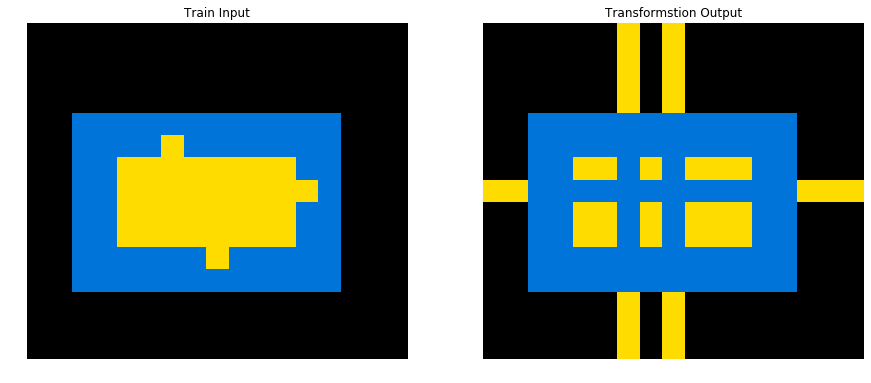

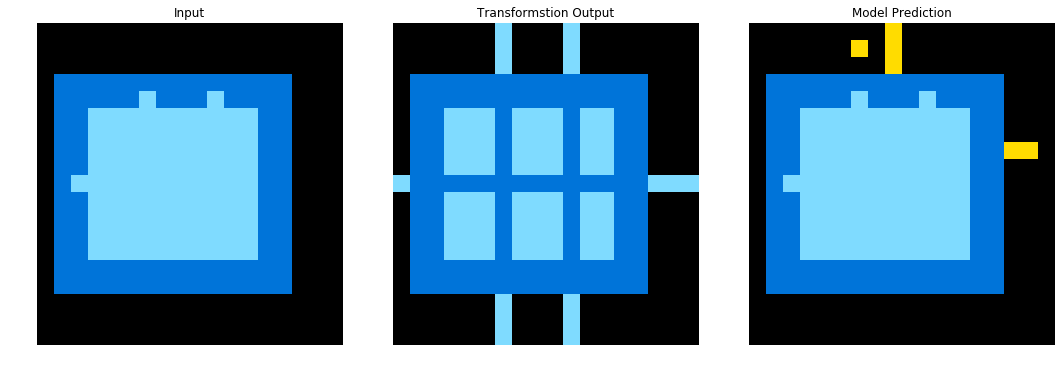

Number of input rows: 9 cols: 9
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f25fbde4.json

Made predictions for  f25ffba3
ensemble accuracy 0.4



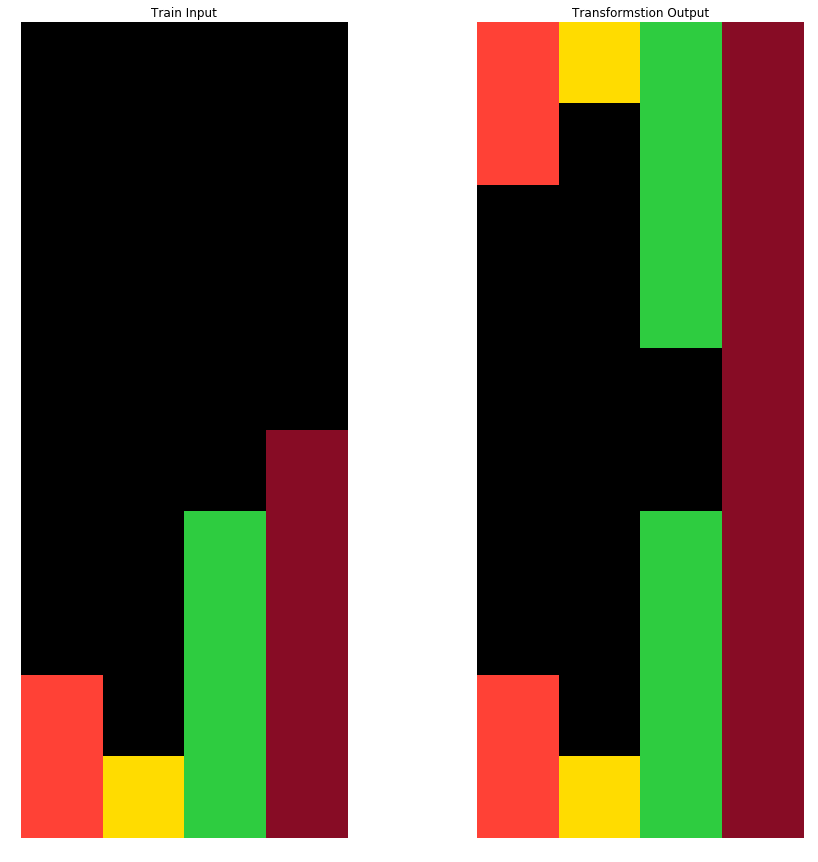

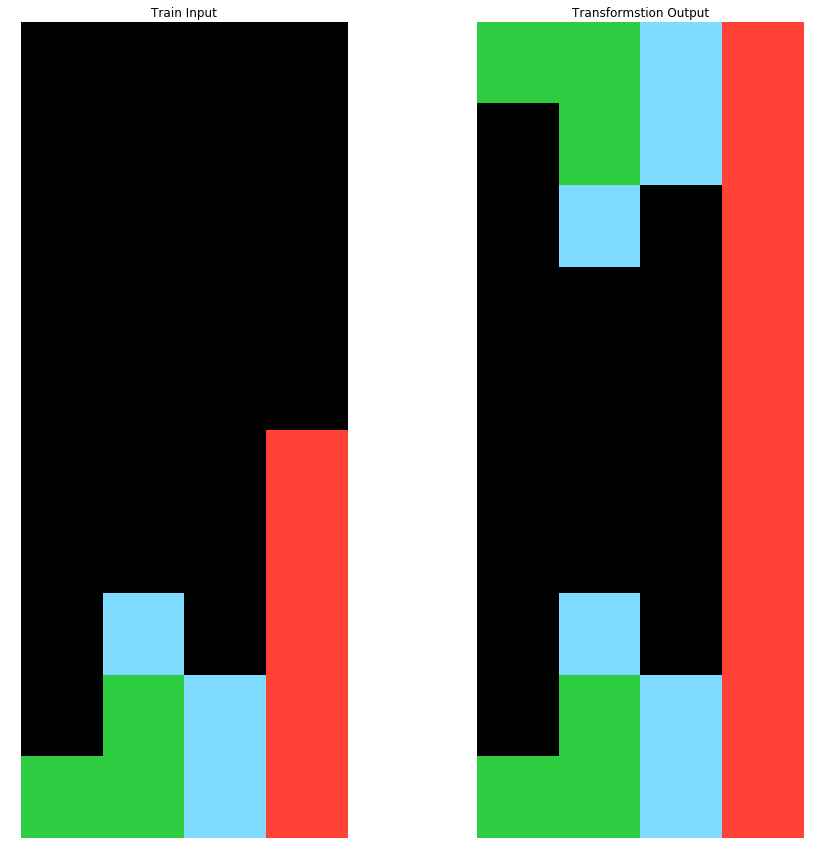

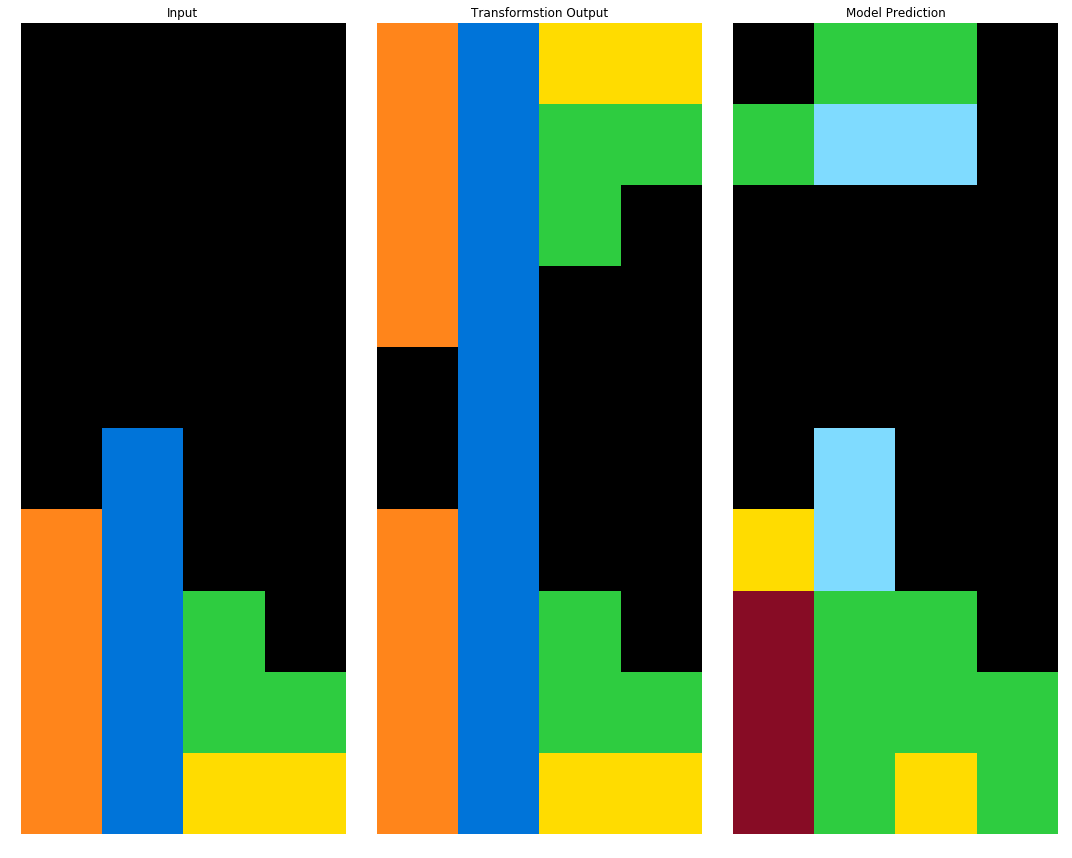

Number of input rows: 4 cols: 7
Number of target rows: 4 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f2829549.json

Made predictions for  f35d900a
ensemble accuracy 0.8562091503267973



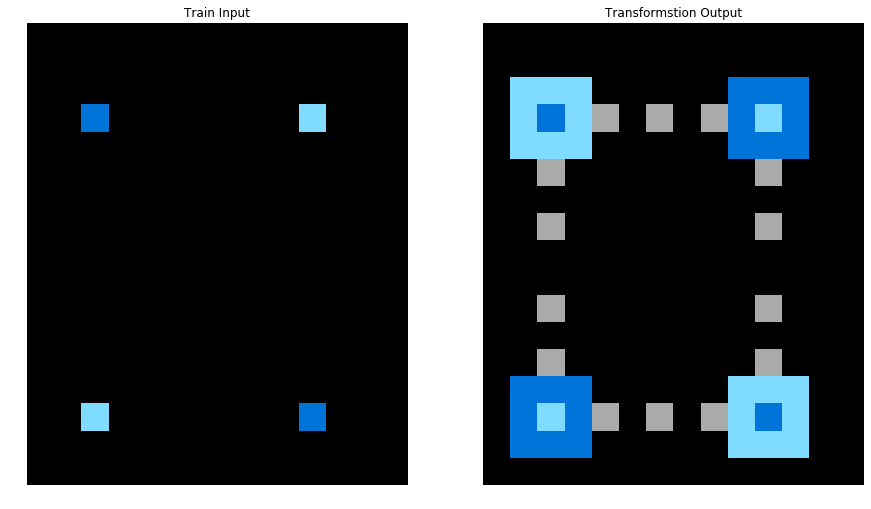

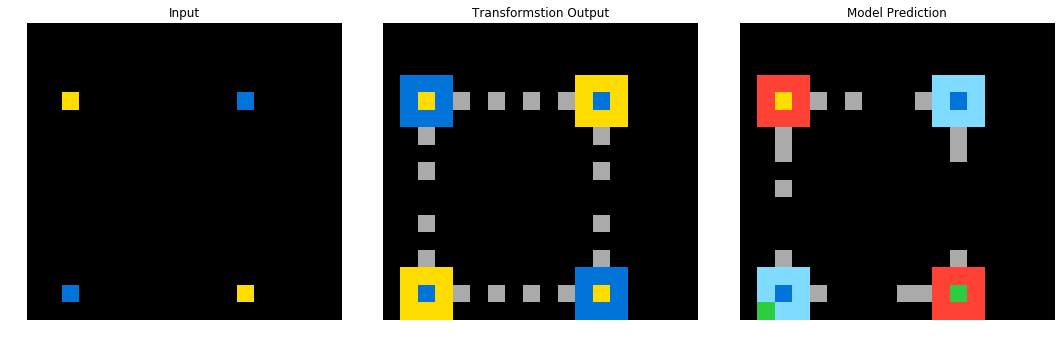

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f5b8619d.json

Made predictions for  f76d97a5
ensemble accuracy 0.64



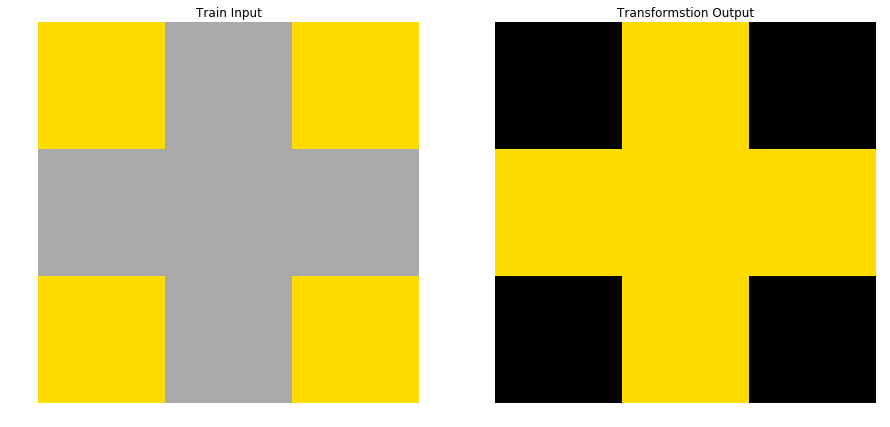

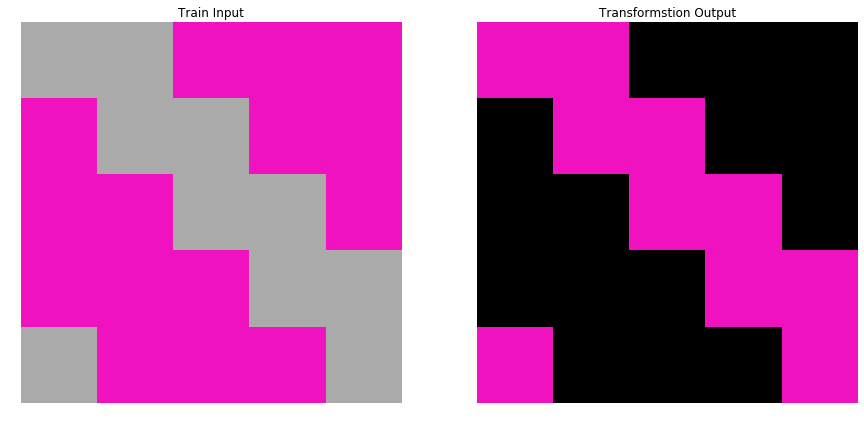

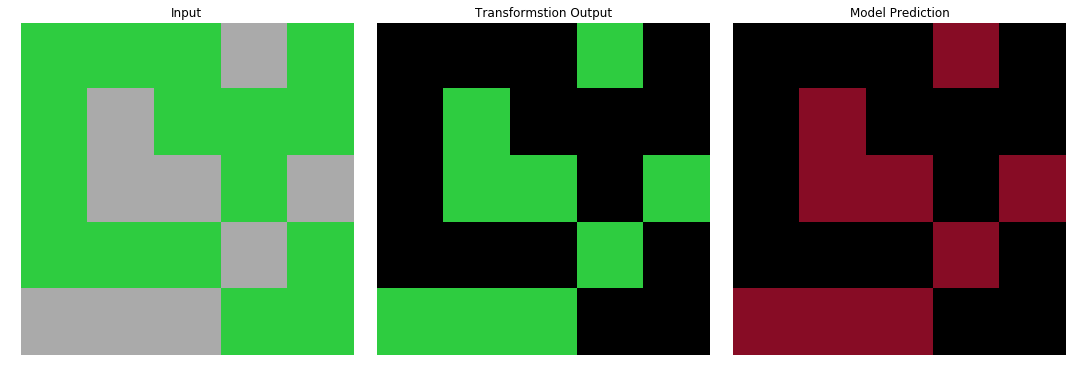

Made predictions for  f8a8fe49
ensemble accuracy 0.9822222222222222
f8a8fe49.json



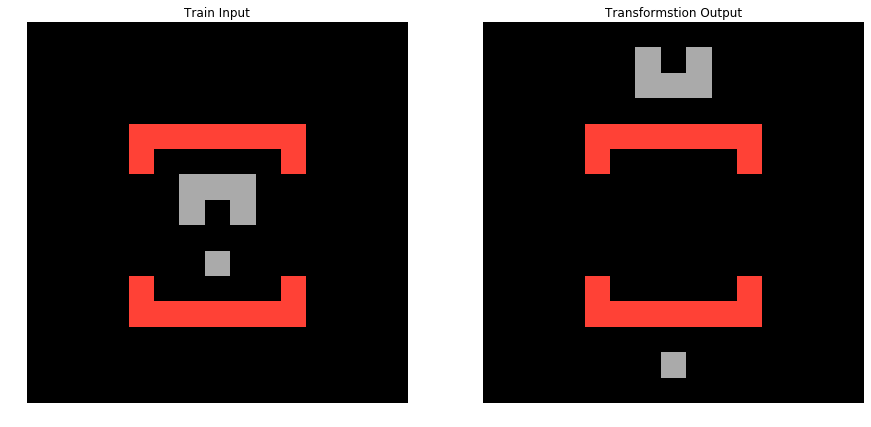

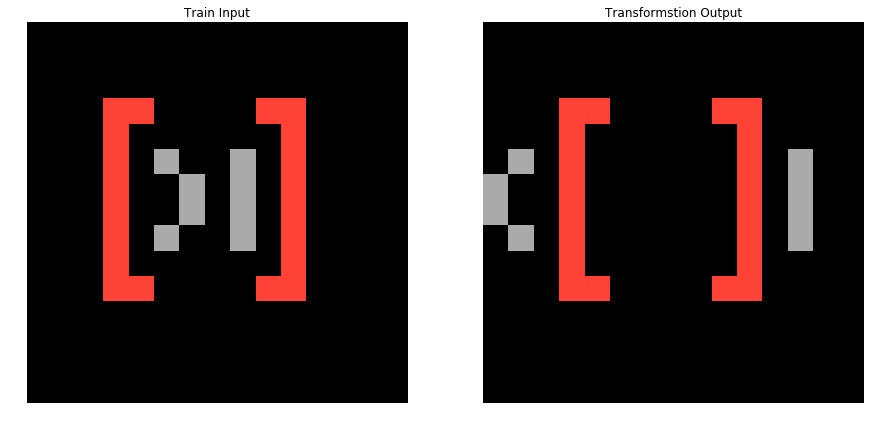

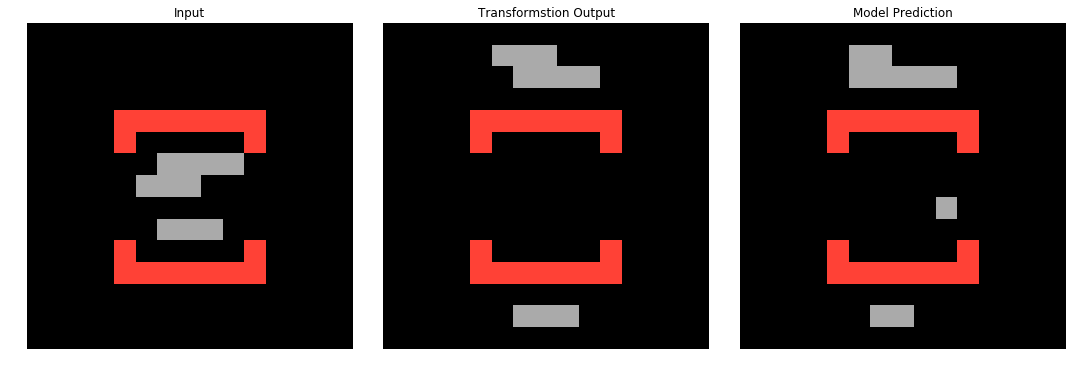

Number of input rows: 13 cols: 13
Number of target rows: 3 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f8b3ba0a.json

Made predictions for  f8c80d96
ensemble accuracy 0.58



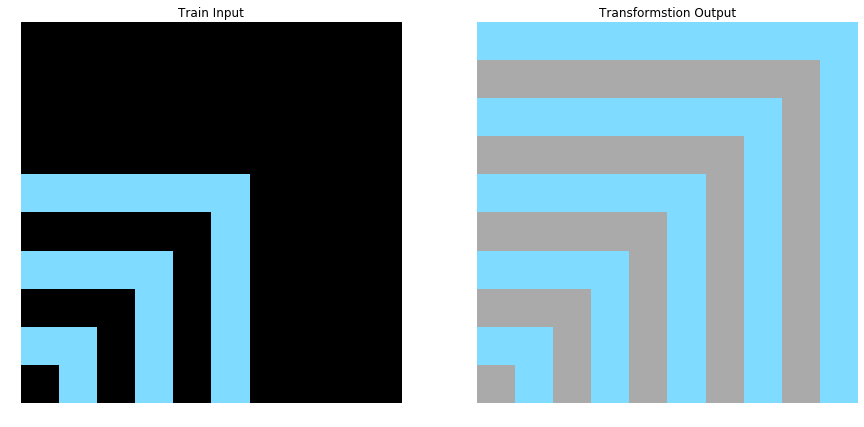

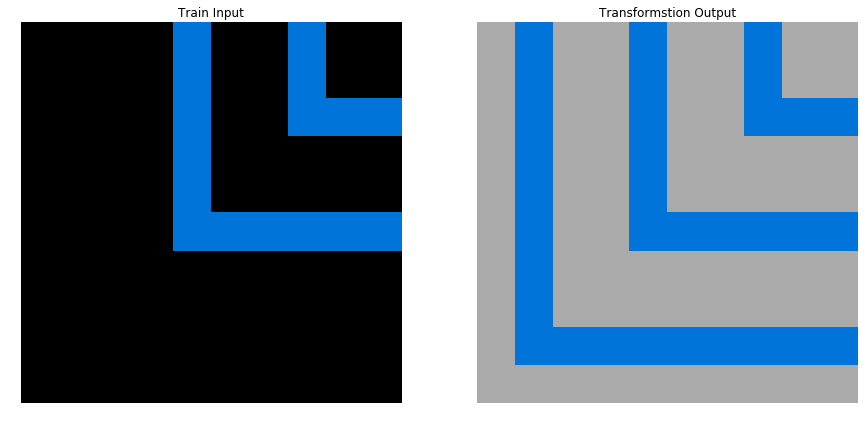

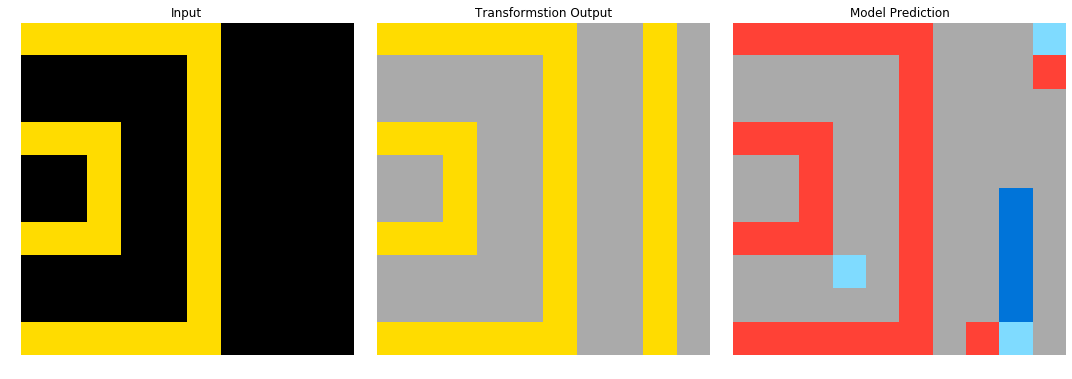

Number of input rows: 12 cols: 12
Number of target rows: 3 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f8ff0b80.json

Number of input rows: 5 cols: 5
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/f9012d9b.json

Number of input rows: 6 cols: 3
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/fafffa47.json

Number of input rows: 13 cols: 13
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/fcb5c309.json

Made predictions for  fcc82909
ensemble accuracy 0.94



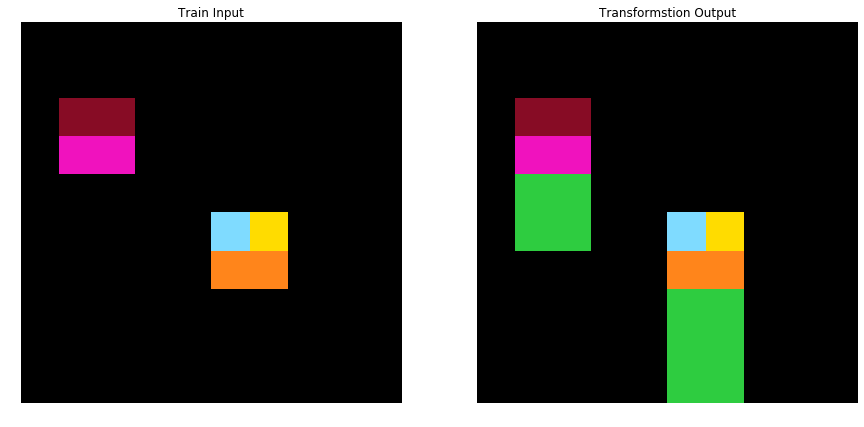

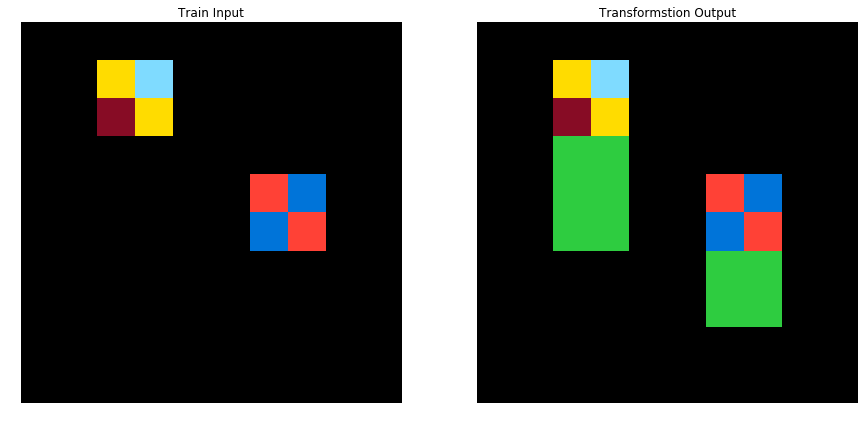

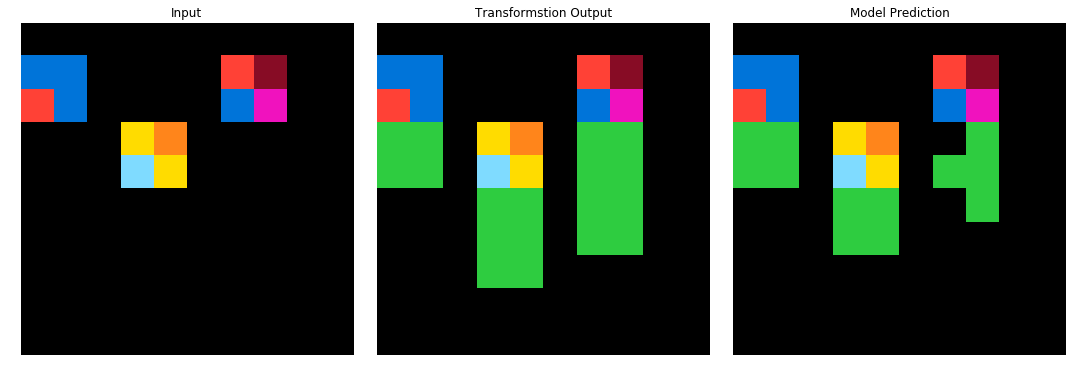

Number of input rows: 1 cols: 5
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/feca6190.json

Number of input rows: 5 cols: 5
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ff28f65a.json

Number of input rows: 24 cols: 24
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ff805c23.json



In [45]:

## Model training and Evaluation


mode = 'train'
#mode = 'test'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 31
local_neighb = 5
valid_scores = {}
save_task_ids = []
model_accuracies = {'ens': []}
pred_taskids = []
for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    estimators = [
                    ('xgb', XGBClassifier(n_estimators=25, n_jobs=-1)),
                    ('extra_trees', ExtraTreesClassifier() ),
                    ('bagging', BaggingClassifier()),
                    ('LogisticRegression',LogisticRegression())
                 ]
    clf = StackingClassifier(
        estimators=estimators, final_estimator=XGBClassifier(n_estimators=10, n_jobs=-1)
    )


    clf.fit(feat, target)
#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    cur_idx = 0
    for task_num in range(num_test_pairs):
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])

        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = clf.predict(feat).reshape(nrows,ncols)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)
            

            model_accuracies['ens'].append(ens_acc)

            pred_taskids.append(f'{task_id[:-5]}_{task_num}')

            print('ensemble accuracy',(np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols))
            #if (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols) >= 0.95:
            save_task_ids.append(task_id)
            print(task_id)
            print()
        
        preds = preds.astype(int).tolist()
        output_color = np.array(task['test'][task_num]['output'])
        
        
        # Example  no. 1
        input_train_color = np.array(task['train'][0]['input'])
        output_train_color = np.array(task['train'][0]['output'])
        
        nrows_, ncols_ = len(task['train'][0]['input']), len(
            task['train'][0]['input'][0])
        
        
        #Example No. 2
        input_train_color2 = np.array(task['train'][1]['input'])
        output_train_color2 = np.array(task['train'][1]['output'])
        
        nrows_1, ncols_1 = len(task['train'][1]['input']), len(
            task['train'][1]['input'][0])
        
        plot_sample_pattern(input_train_color, output_train_color, (nrows_, ncols_))
        plot_sample_pattern(input_train_color2, output_train_color2, (nrows_1, ncols_1))
        plot_result(input_color, output_color,preds, (nrows, ncols))
        #plot_test(preds, task_id)
        if mode=='test':
            sample_sub.loc[f'{task_id[:-5]}_{task_num}',
                        'output'] = flattener(preds)


In [12]:
## Evaluation on Eval data


mode = 'eval'
#mode = 'test'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 31
local_neighb = 5
valid_scores = {}
save_task_ids = []
model_accuracies = {'ens': []}
pred_taskids = []
for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    estimators = [
                    ('xgb', XGBClassifier(n_estimators=25, n_jobs=-1)),
                    ('extra_trees', ExtraTreesClassifier() ),
                    ('bagging', BaggingClassifier()),
                    ('LogisticRegression',LogisticRegression())
                 ]
    clf = StackingClassifier(
        estimators=estimators, final_estimator=XGBClassifier(n_estimators=10, n_jobs=-1)
    )


    clf.fit(feat, target)
#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    cur_idx = 0
    for task_num in range(num_test_pairs):
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])

        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = clf.predict(feat).reshape(nrows,ncols)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)
            

            model_accuracies['ens'].append(ens_acc)

            pred_taskids.append(f'{task_id[:-5]}_{task_num}')

            print('ensemble accuracy',(np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols))
            #if (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols) >= 0.95:
            save_task_ids.append(task_id)
            print(task_id)
            print()
        
        preds = preds.astype(int).tolist()
        output_color = np.array(task['test'][task_num]['output'])
        
        
        # Example  no. 1
        input_train_color = np.array(task['train'][0]['input'])
        output_train_color = np.array(task['train'][0]['output'])
        
        nrows_, ncols_ = len(task['train'][0]['input']), len(
            task['train'][0]['input'][0])
        
        
        #Example No. 2
        input_train_color2 = np.array(task['train'][1]['input'])
        output_train_color2 = np.array(task['train'][1]['output'])
        
        nrows_1, ncols_1 = len(task['train'][1]['input']), len(
            task['train'][1]['input'][0])
        
        #plot_sample_pattern(input_train_color, output_train_color, (nrows_, ncols_))
        #plot_sample_pattern(input_train_color2, output_train_color2, (nrows_1, ncols_1))
        #plot_result(input_color, output_color,preds, (nrows, ncols))
        #print(feat)
        #plot_test(preds, task_id)
        if mode=='test':
            sample_sub.loc[f'{task_id[:-5]}_{task_num}',
                        'output'] = flattener(preds)

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/007bbfb7.json

Made predictions for  00d62c1b
ensemble accuracy 0.885
00d62c1b.json

Number of input rows: 6 cols: 3
Number of target rows: 9 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/017c7c7b.json

Made predictions for  025d127b
ensemble accuracy 0.74
025d127b.json

Made predictions for  045e512c
ensemble accuracy 0.81859410430839
045e512c.json

Number of input rows: 3 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/0520fde7.json

Made predictions for  05269061
ensemble accuracy 0.3469387755102041
05269061.json

Made predictions for  05f2a901
ensemble accuracy 0.9363636363636364
05f2a901.json

Made predictions for  06df4c85
ensemble accuracy 0.8727810650887574
06df4c85.json

Made predictions for  08ed6ac7
ensemble accuracy 0.8024691358024691
08ed

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  0ca9ddb6
ensemble accuracy 0.9876543209876543
0ca9ddb6.json

Made predictions for  0d3d703e
ensemble accuracy 1.0
0d3d703e.json

Made predictions for  0dfd9992
ensemble accuracy 0.655328798185941
0dfd9992.json

Made predictions for  0e206a2e
ensemble accuracy 0.9627192982456141
0e206a2e.json

Number of input rows: 2 cols: 4
Number of target rows: 4 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/10fcaaa3.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  11852cab
ensemble accuracy 0.91
11852cab.json

Number of input rows: 15 cols: 15
Number of target rows: 2 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1190e5a7.json

Number of input rows: 11 cols: 11
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/137eaa0f.json

Made predictions for  150deff5
ensemble accuracy 0.8636363636363636
150deff5.json

Made predictions for  178fcbfb
ensemble accuracy 0.6212121212121212
178fcbfb.json

Made predictions for  1a07d186
ensemble accuracy 0.9453441295546559
1a07d186.json

Number of input rows: 5 cols: 7
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1b2d62fb.json

Made predictions for  1b60fb0c
ensemble accuracy 0.96
1b60fb0c.json

Made predictions for  1bfc4729
ensemble accuracy 0.48
1bfc4729.json

Number of input rows: 23 cols: 21
Number of target rows: 6 cols: 8
ignoring task 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  1e0a9b12
ensemble accuracy 0.48
1e0a9b12.json

Made predictions for  1e32b0e9
ensemble accuracy 0.5121107266435986
1e32b0e9.json

Made predictions for  1f0c79e5
ensemble accuracy 0.6419753086419753
1f0c79e5.json

Made predictions for  1f642eb9
ensemble accuracy 0.86
1f642eb9.json

Number of input rows: 30 cols: 30
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1f85a75f.json

Made predictions for  1f876c06
ensemble accuracy 0.86
1f876c06.json

Number of input rows: 9 cols: 9
Number of target rows: 1 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/1fad071e.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/2013d3e2.json

Made predictions for  2204b7a8
ensemble accuracy 0.81
2204b7a8.json

Made predictions for  22168020
ensemble accuracy 0.73
22168020.json

Made predictions for  2223

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  22eb0ac0
ensemble accuracy 0.8
22eb0ac0.json

Number of input rows: 3 cols: 9
Number of target rows: 3 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/234bbc79.json

Made predictions for  23581191
ensemble accuracy 0.8888888888888888
23581191.json

Number of input rows: 5 cols: 5
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/239be575.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/23b5c85d.json

Made predictions for  253bf280
ensemble accuracy 0.8910256410256411
253bf280.json

Made predictions for  25d487eb
ensemble accuracy 0.8522727272727273
25d487eb.json

Made predictions for  25d8a9c8
ensemble accuracy 1.0
25d8a9c8.json

Made predictions for  25ff71a9
ensemble accuracy 1.0
25ff71a9.json

Made predictions for  25ff71a9
ensemble accuracy 0.8888888888888888
25ff71a9.json

Mad

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  31aa019c
ensemble accuracy 0.86
31aa019c.json

Made predictions for  321b1fc6
ensemble accuracy 0.79
321b1fc6.json

Made predictions for  32597951
ensemble accuracy 1.0
32597951.json

Made predictions for  3345333e
ensemble accuracy 0.8125
3345333e.json

Number of input rows: 13 cols: 5
Number of target rows: 6 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/3428a4f5.json

Made predictions for  3618c87e
ensemble accuracy 1.0
3618c87e.json

Made predictions for  3631a71a
ensemble accuracy 0.95
3631a71a.json

Made predictions for  363442ee
ensemble accuracy 0.5470085470085471
363442ee.json

Made predictions for  36d67576
ensemble accuracy 0.9142857142857143
36d67576.json

Made predictions for  36fdfd69
ensemble accuracy 0.5915032679738562
36fdfd69.json

Made predictions for  3906de3d
ensemble accuracy 0.88
3906de3d.json

Number of input rows: 14 cols: 14
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-rea

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  6150a2bd
ensemble accuracy 0.2222222222222222
6150a2bd.json

Made predictions for  623ea044
ensemble accuracy 0.9134948096885813
623ea044.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/62c24649.json

Made predictions for  63613498
ensemble accuracy 0.88
63613498.json

Number of input rows: 9 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6430c8c4.json

Made predictions for  6455b5f5
ensemble accuracy 0.7692307692307693
6455b5f5.json

Number of input rows: 9 cols: 3
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/662c240a.json

Made predictions for  67385a82
ensemble accuracy 1.0
67385a82.json

Made predictions for  673ef223
ensemble accuracy 0.8492063492063492
673ef223.json

Number of input rows: 11 cols: 11
Number of target rows: 3 cols: 3
ignor

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  67a423a3
ensemble accuracy 0.9027777777777778
67a423a3.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/67e8384a.json

Number of input rows: 10 cols: 10
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/681b3aeb.json

Made predictions for  6855a6e4
ensemble accuracy 0.9511111111111111
6855a6e4.json

Made predictions for  68b16354
ensemble accuracy 0.24489795918367346
68b16354.json

Made predictions for  694f12f3
ensemble accuracy 0.88
694f12f3.json

Made predictions for  6a1e5592
ensemble accuracy 0.92
6a1e5592.json

Made predictions for  6aa20dc0
ensemble accuracy 0.878099173553719
6aa20dc0.json

Number of input rows: 18 cols: 21
Number of target rows: 8 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6b9890af.json

Made predictions for  6c434453
ensemble accuracy 1.0
6c434453.json


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  6d0160f0
ensemble accuracy 0.9669421487603306
6d0160f0.json

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6d0aefbc.json

Made predictions for  6d58a25d
ensemble accuracy 0.8275
6d58a25d.json

Made predictions for  6d75e8bb
ensemble accuracy 1.0
6d75e8bb.json

Made predictions for  6e02f1e3
ensemble accuracy 0.3333333333333333
6e02f1e3.json

Made predictions for  6e19193c
ensemble accuracy 0.86
6e19193c.json

Made predictions for  6e82a1ae
ensemble accuracy 0.96
6e82a1ae.json

Number of input rows: 27 cols: 21
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6ecd11f4.json

Made predictions for  6f8cd79b
ensemble accuracy 1.0
6f8cd79b.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/6fa7a44f.json

Made predictions for  72322f

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  834ec97d
ensemble accuracy 0.8680555555555556
834ec97d.json

Made predictions for  8403a5d5
ensemble accuracy 0.52
8403a5d5.json

Number of input rows: 13 cols: 13
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/846bdb03.json

Made predictions for  855e0971
ensemble accuracy 0.615686274509804
855e0971.json

Made predictions for  85c4e7cd
ensemble accuracy 0.061224489795918366
85c4e7cd.json

Made predictions for  868de0fa
ensemble accuracy 0.7275
868de0fa.json

Number of input rows: 17 cols: 23
Number of target rows: 7 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/8731374e.json

Made predictions for  88a10436
ensemble accuracy 0.9181818181818182
88a10436.json

Number of input rows: 5 cols: 5
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/88a62173.json

Made predictions for  890034e9
ensemble accuracy 0.9433106575963

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  952a094c
ensemble accuracy 0.79
952a094c.json

Made predictions for  9565186b
ensemble accuracy 0.0
9565186b.json

Made predictions for  95990924
ensemble accuracy 0.9333333333333333
95990924.json

Number of input rows: 5 cols: 6
Number of target rows: 5 cols: 12
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/963e52fc.json

Made predictions for  97999447
ensemble accuracy 0.7361111111111112
97999447.json

Number of input rows: 24 cols: 19
Number of target rows: 17 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/97a05b5b.json

Made predictions for  98cf29f8
ensemble accuracy 0.7303921568627451
98cf29f8.json

Number of input rows: 4 cols: 14
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/995c5fa3.json

Number of input rows: 9 cols: 4
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/99b1bc43.jso

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  9dfd6313
ensemble accuracy 0.6111111111111112
9dfd6313.json

Number of input rows: 16 cols: 16
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9ecd008a.json

Made predictions for  9edfc990
ensemble accuracy 0.875
9edfc990.json

Number of input rows: 19 cols: 19
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/9f236235.json

Made predictions for  a1570a43
ensemble accuracy 0.8625
a1570a43.json

Made predictions for  a2fd1cf0
ensemble accuracy 0.9404761904761905
a2fd1cf0.json

Number of input rows: 10 cols: 10
Number of target rows: 5 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a3325580.json

Made predictions for  a3df8b1e
ensemble accuracy 0.76
a3df8b1e.json

Number of input rows: 3 cols: 3
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/a416b8f3.json

Made p

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  a9f96cdd
ensemble accuracy 0.8666666666666667
a9f96cdd.json

Made predictions for  aabf363d
ensemble accuracy 0.673469387755102
aabf363d.json

Made predictions for  aba27056
ensemble accuracy 0.64
aba27056.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ac0a08a4.json

Made predictions for  ae3edfdc
ensemble accuracy 0.9822222222222222
ae3edfdc.json

Number of input rows: 9 cols: 9
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/ae4f1146.json

Made predictions for  aedd82e4
ensemble accuracy 1.0
aedd82e4.json

Made predictions for  af902bf9
ensemble accuracy 0.86
af902bf9.json

Number of input rows: 6 cols: 6
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/b0c4d837.json

Number of input rows: 3 cols: 6
Number of target rows: 9 cols: 9
ignoring task /kaggle/

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d037b0a7
ensemble accuracy 0.1111111111111111
d037b0a7.json

Made predictions for  d06dbe63
ensemble accuracy 0.9053254437869822
d06dbe63.json

Made predictions for  d07ae81c
ensemble accuracy 0.8730650154798761
d07ae81c.json

Number of input rows: 16 cols: 10
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d0f5fe59.json

Number of input rows: 6 cols: 6
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d10ecb37.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d13f3404.json

Made predictions for  d22278a0
ensemble accuracy 0.4117647058823529
d22278a0.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d23f8c26
ensemble accuracy 0.8979591836734694
d23f8c26.json

Made predictions for  d2abd087
ensemble accuracy 0.85
d2abd087.json

Made predictions for  d364b489
ensemble accuracy 0.89
d364b489.json

Made predictions for  d406998b
ensemble accuracy 0.8627450980392157
d406998b.json

Made predictions for  d43fd935
ensemble accuracy 0.85
d43fd935.json

Number of input rows: 5 cols: 5
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d4469b4b.json

Made predictions for  d4a91cb9
ensemble accuracy 0.9166666666666666
d4a91cb9.json

Made predictions for  d4f3cd78
ensemble accuracy 0.97
d4f3cd78.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d511f180
ensemble accuracy 0.9375
d511f180.json

Made predictions for  d5d6de2d
ensemble accuracy 0.81
d5d6de2d.json

Made predictions for  d5d6de2d
ensemble accuracy 0.976
d5d6de2d.json

Number of input rows: 3 cols: 3
Number of target rows: 1 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d631b094.json

Made predictions for  d687bc17
ensemble accuracy 0.8907563025210085
d687bc17.json

Made predictions for  d6ad076f
ensemble accuracy 0.5
d6ad076f.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  d89b689b
ensemble accuracy 0.96
d89b689b.json

Made predictions for  d8c310e9
ensemble accuracy 0.72
d8c310e9.json

Made predictions for  d90796e8
ensemble accuracy 0.9047619047619048
d90796e8.json

Made predictions for  d9f24cd1
ensemble accuracy 0.71
d9f24cd1.json

Number of input rows: 5 cols: 9
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/d9fac9be.json

Number of input rows: 3 cols: 6
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/dae9d2b5.json

Made predictions for  db3e9e38
ensemble accuracy 0.8148148148148148
db3e9e38.json

Made predictions for  db93a21d
ensemble accuracy 0.7444444444444445
db93a21d.json

Made predictions for  dbc1a6ce
ensemble accuracy 0.8471177944862155
dbc1a6ce.json

Number of input rows: 16 cols: 16
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/dc0a314f.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  dc1df850
ensemble accuracy 0.93
dc1df850.json

Made predictions for  dc433765
ensemble accuracy 1.0
dc433765.json

Made predictions for  dc433765
ensemble accuracy 1.0
dc433765.json

Made predictions for  ddf7fa4f
ensemble accuracy 0.76
ddf7fa4f.json

Number of input rows: 17 cols: 13
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/de1cd16c.json

Made predictions for  ded97339
ensemble accuracy 0.9
ded97339.json

Made predictions for  e179c5f4
ensemble accuracy 0.78
e179c5f4.json

Made predictions for  e21d9049
ensemble accuracy 0.93
e21d9049.json

Made predictions for  e26a3af2
ensemble accuracy 0.6622222222222223
e26a3af2.json

Number of input rows: 10 cols: 9
Number of target rows: 10 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e3497940.json

Made predictions for  e40b9e2f
ensemble accuracy 0.69
e40b9e2f.json



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Made predictions for  e48d4e1a
ensemble accuracy 0.78
e48d4e1a.json

Made predictions for  e5062a87
ensemble accuracy 0.89
e5062a87.json

Made predictions for  e509e548
ensemble accuracy 0.875
e509e548.json

Number of input rows: 10 cols: 10
Number of target rows: 5 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e50d258f.json

Number of input rows: 30 cols: 17
Number of target rows: 15 cols: 17
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/training/e6721834.json

Made predictions for  e73095fd
ensemble accuracy 0.9756944444444444
e73095fd.json

Made predictions for  e76a88a6
ensemble accuracy 0.62
e76a88a6.json

Made predictions for  e8593010
ensemble accuracy 0.96
e8593010.json

Made predictions for  e8dc4411
ensemble accuracy 0.6145833333333334
e8dc4411.json

Made predictions for  e9614598
ensemble accuracy 0.9513888888888888
e9614598.json

Made predictions for  e9614598
ensemble accuracy 0.95
e9614598.json

Number of input rows: 11

In [31]:
input_color.shape

(10, 10)

In [14]:
pred_taskids

['00d62c1b_0',
 '025d127b_0',
 '045e512c_0',
 '05269061_0',
 '05f2a901_0',
 '06df4c85_0',
 '08ed6ac7_0',
 '09629e4f_0',
 '0962bcdd_0',
 '0a938d79_0',
 '0ca9ddb6_0',
 '0d3d703e_0',
 '0dfd9992_0',
 '0e206a2e_0',
 '11852cab_0',
 '150deff5_0',
 '178fcbfb_0',
 '1a07d186_0',
 '1b60fb0c_0',
 '1bfc4729_0',
 '1caeab9d_0',
 '1e0a9b12_0',
 '1e32b0e9_0',
 '1f0c79e5_0',
 '1f642eb9_0',
 '1f876c06_0',
 '2204b7a8_0',
 '22168020_0',
 '22233c11_0',
 '2281f1f4_0',
 '228f6490_0',
 '22eb0ac0_0',
 '23581191_0',
 '253bf280_0',
 '25d487eb_0',
 '25d8a9c8_0',
 '25ff71a9_0',
 '25ff71a9_1',
 '264363fd_0',
 '272f95fa_0',
 '28e73c20_0',
 '29623171_0',
 '29c11459_0',
 '29ec7d0e_0',
 '2bcee788_0',
 '2bee17df_0',
 '2c608aff_0',
 '2dd70a9a_0',
 '31aa019c_0',
 '321b1fc6_0',
 '32597951_0',
 '3345333e_0',
 '3618c87e_0',
 '3631a71a_0',
 '363442ee_0',
 '36d67576_0',
 '36fdfd69_0',
 '3906de3d_0',
 '39e1d7f9_0',
 '3aa6fb7a_0',
 '3ac3eb23_0',
 '3bd67248_0',
 '3bdb4ada_0',
 '3befdf3e_0',
 '3c9b0459_0',
 '3e980e27_0',
 '3eda0437

In [13]:
model_accuracies

{'ens': [0.885,
  0.74,
  0.81859410430839,
  0.3469387755102041,
  0.9363636363636364,
  0.8727810650887574,
  0.8024691358024691,
  0.7024793388429752,
  0.7291666666666666,
  0.6127946127946128,
  0.9876543209876543,
  1.0,
  0.655328798185941,
  0.9627192982456141,
  0.91,
  0.8636363636363636,
  0.6212121212121212,
  0.9453441295546559,
  0.96,
  0.48,
  0.75,
  0.48,
  0.5121107266435986,
  0.6419753086419753,
  0.86,
  0.86,
  0.81,
  0.73,
  0.93,
  1.0,
  0.79,
  0.8,
  0.8888888888888888,
  0.8910256410256411,
  0.8522727272727273,
  1.0,
  1.0,
  0.8888888888888888,
  0.41444444444444445,
  0.5058823529411764,
  0.7592592592592593,
  0.6694214876033058,
  0.6363636363636364,
  0.8179012345679012,
  0.92,
  0.75,
  0.9298245614035088,
  0.8579881656804734,
  0.86,
  0.79,
  1.0,
  0.8125,
  1.0,
  0.95,
  0.5470085470085471,
  0.9142857142857143,
  0.5915032679738562,
  0.88,
  0.9001189060642093,
  1.0,
  0.4583333333333333,
  0.79,
  0.8863636363636364,
  0.5208333333333334

Text(0.5, 1.0, 'Accurate predictions - Interval 0.05')

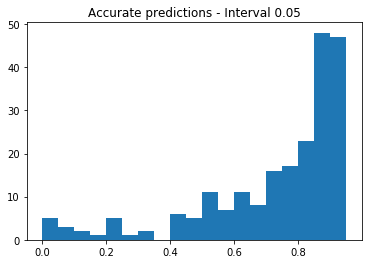

In [24]:
#save_imp_ids, plot_segments = [], [0 for i in range()]
#for id_, acc_ in zip(pred_taskids, model_accuracies):
#    if acc_ 
model_acc = sorted(model_accuracies["ens"])
bins = [i*0.05 for i in range(20)]
plt.hist(model_acc, bins)
plt.title("Accurate predictions - Interval 0.05")

In [15]:
if (mode=='train') or (mode=='eval'):
    df = pd.DataFrame(model_accuracies, index=pred_taskids)
    print(df.head(10))

    print(df.describe())
    for c in df.columns:
        print(f'for {c} no. of complete tasks is', (df.loc[:, c]==1).sum())

    df.to_csv('ens_acc.csv')

In [16]:
sample_sub.head()

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...